In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import (
    Dataset,
    DataLoader
)
import torch
import torchvision.transforms as transforms
from skimage import io

from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification

In [2]:
basedir = os.getcwd()
datadir = basedir + '/data'

# reading the csv file with annotated image file names
train_cultivar= pd.read_csv(datadir + '/train_cultivar_mapping.csv')
train_cultivar.dropna(inplace=True)

# turning cultivar labels into strings
train_cultivar['cultivar']=train_cultivar['cultivar'].astype(str)
train_cultivar.head()

image   cultivar
0  2017-06-16__12-24-20-930.png  PI_257599
1  2017-06-02__16-48-57-866.png  PI_154987
2  2017-06-12__13-18-07-707.png   PI_92270
3  2017-06-22__13-18-06-841.png  PI_152651
4  2017-06-26__12-56-48-642.png  PI_176766

In [3]:
# creating list of unique cultivars
labels=list(np.unique(train_cultivar['cultivar']))
labels

['PI_144134',
 'PI_145619',
 'PI_145626',
 'PI_145633',
 'PI_146890',
 'PI_152591',
 'PI_152651',
 'PI_152694',
 'PI_152727',
 'PI_152728',
 'PI_152730',
 'PI_152733',
 'PI_152751',
 'PI_152771',
 'PI_152816',
 'PI_152828',
 'PI_152860',
 'PI_152862',
 'PI_152923',
 'PI_152961',
 'PI_152965',
 'PI_152966',
 'PI_152967',
 'PI_152971',
 'PI_153877',
 'PI_154750',
 'PI_154844',
 'PI_154846',
 'PI_154944',
 'PI_154987',
 'PI_154988',
 'PI_155516',
 'PI_155760',
 'PI_155885',
 'PI_156178',
 'PI_156217',
 'PI_156268',
 'PI_156326',
 'PI_156330',
 'PI_156393',
 'PI_156463',
 'PI_156487',
 'PI_156871',
 'PI_156890',
 'PI_157030',
 'PI_157035',
 'PI_157804',
 'PI_167093',
 'PI_170787',
 'PI_175919',
 'PI_176766',
 'PI_179749',
 'PI_180348',
 'PI_181080',
 'PI_181083',
 'PI_195754',
 'PI_196049',
 'PI_196583',
 'PI_196586',
 'PI_196598',
 'PI_197542',
 'PI_19770',
 'PI_213900',
 'PI_217691',
 'PI_218112',
 'PI_221548',
 'PI_221651',
 'PI_22913',
 'PI_229841',
 'PI_251672',
 'PI_253986',
 'PI_255

In [4]:
train_cultivar["cultivar_index"] = train_cultivar["cultivar"].map(lambda item: labels.index(item))
train_cultivar

image   cultivar  cultivar_index
0      2017-06-16__12-24-20-930.png  PI_257599              73
1      2017-06-02__16-48-57-866.png  PI_154987              29
2      2017-06-12__13-18-07-707.png   PI_92270              99
3      2017-06-22__13-18-06-841.png  PI_152651               6
4      2017-06-26__12-56-48-642.png  PI_176766              50
...                             ...        ...             ...
22189  2017-06-16__12-27-16-266.png  PI_170787              48
22190  2017-06-28__11-19-57-454.png  PI_156393              39
22191  2017-06-28__10-20-32-417.png  PI_152923              18
22192  2017-06-28__12-47-02-714.png  PI_257599              73
22193  2017-06-04__13-12-56-053.png  PI_196586              58

[22193 rows x 3 columns]

In [75]:
y_train = y_train.drop

index  cultivar_index
0       4456              94
1       3394              82
2      11440               6
3      13999              75
4      15275               6
...      ...             ...
17749  17708               0
17750  17138              19
17751  15398              99
17752  21287              76
17753  11578              45

[17754 rows x 2 columns]

In [78]:
# training and validation split 80/20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_cultivar['image'],train_cultivar["cultivar_index"], test_size = 0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train[0]

'2017-06-16__12-17-07-670.png'

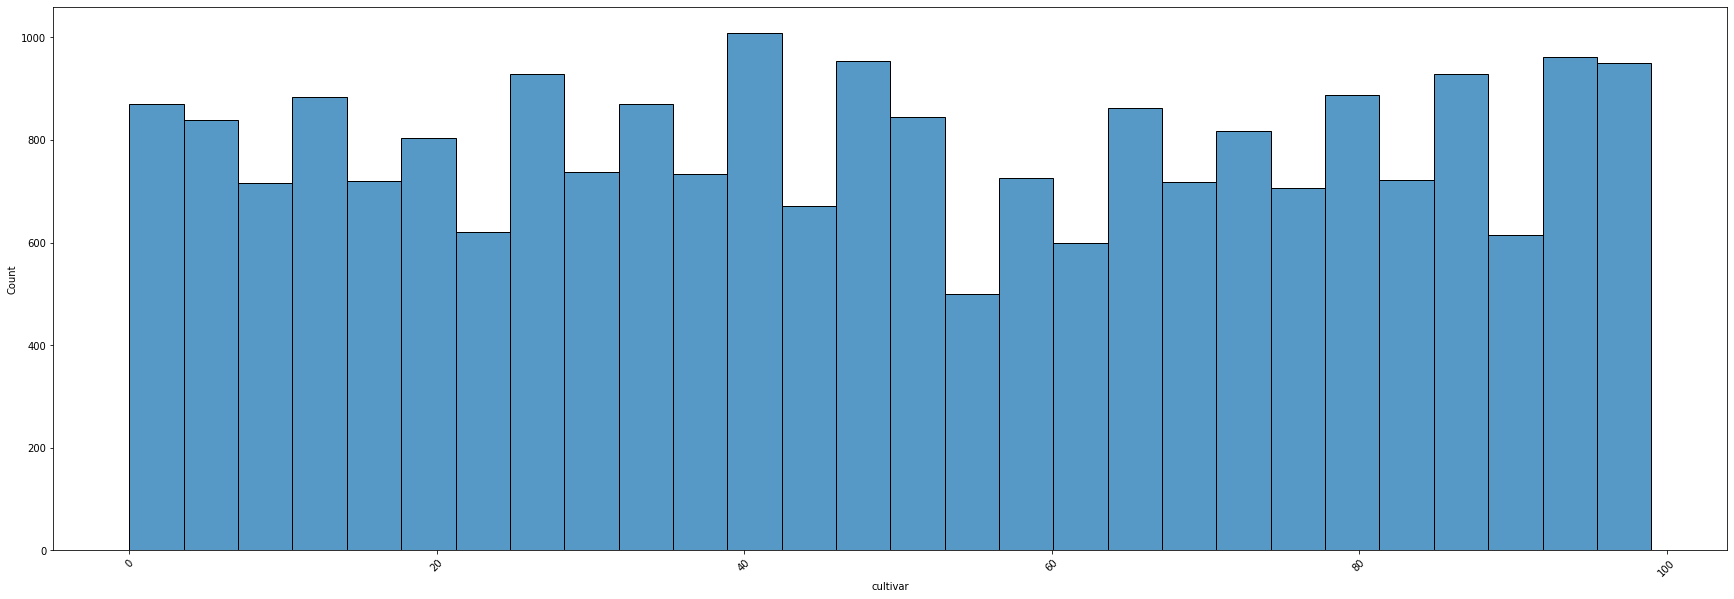

In [60]:
a=pd.DataFrame({'cultivar':train_cultivar['cultivar_index']})
plt.figure(figsize=(30,10))
sns.histplot(a,x='cultivar')
plt.xticks(rotation=45)
plt.show()

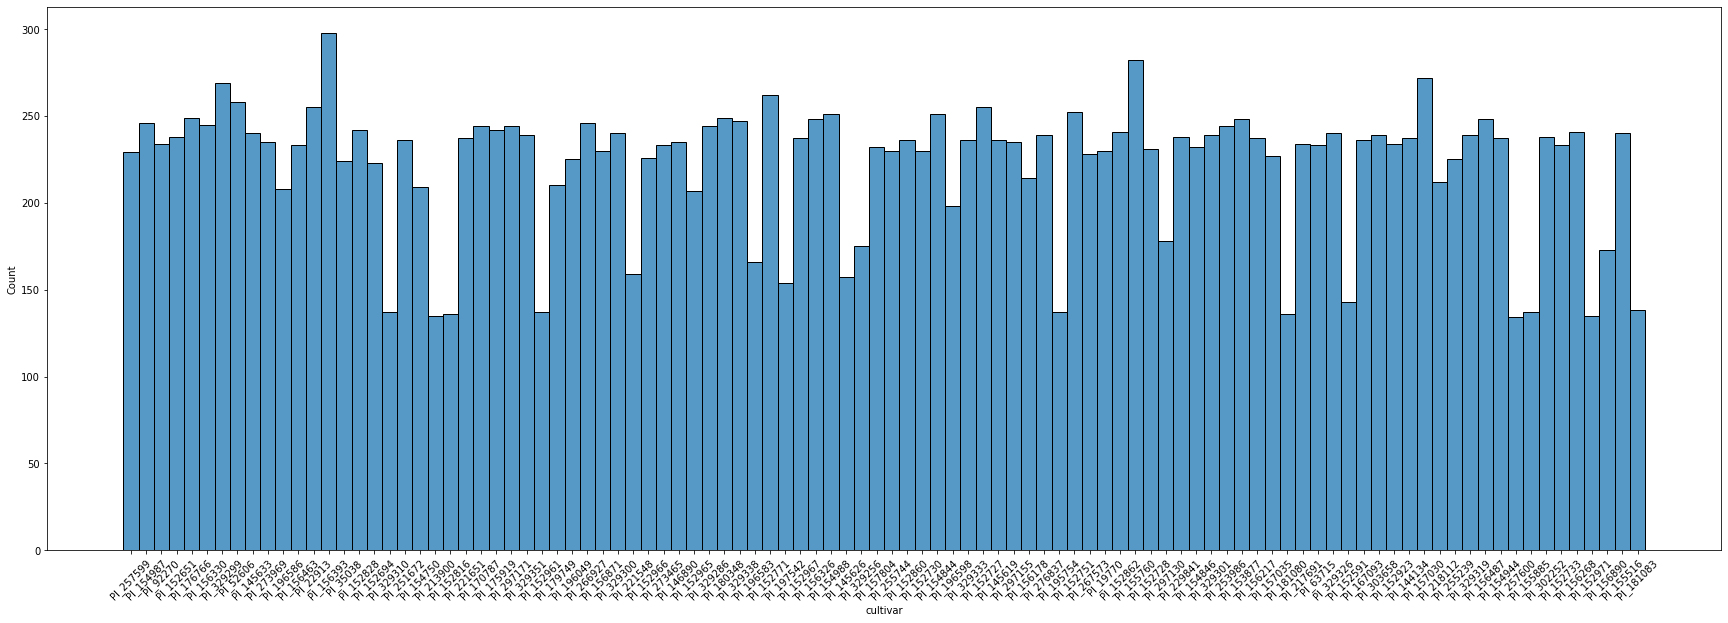

In [5]:
# visualizing frequency of cultivars 

import seaborn as sns
a=pd.DataFrame({'cultivar':train_cultivar['cultivar']})
plt.figure(figsize=(30,10))
sns.histplot(a,x='cultivar')
plt.xticks(rotation=45)
plt.show()

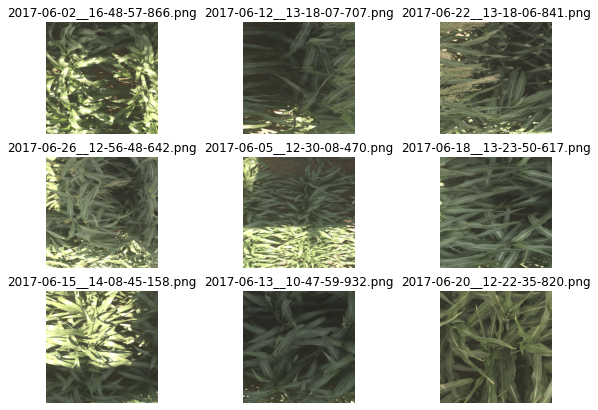

In [41]:
img_path= datadir + "/train_images"
fig = plt.figure(figsize=(10,7))
rows = 3
columns =3
for i in range(1,10):
    image=plt.imread(img_path+f"/{train_cultivar.image.values[i]}")
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(train_cultivar.image.values[i])

In [22]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(4, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(train_cultivar['image'], train_cultivar["cultivar_index"]):
    df_train = train_cultivar.iloc[train_idx]
    df_valid = train_cultivar.iloc[valid_idx]

print(f"train size: {len(df_train)}")
print(f"valid size: {len(df_valid)}")

print(df_train.cultivar.value_counts())
print(df_valid.cultivar.value_counts())

train size: 16645
valid size: 5548
PI_156393    223
PI_155760    211
PI_157030    204
PI_329299    202
PI_152771    196
            ... 
PI_152816    102
PI_195754    102
PI_213900    102
PI_257600    101
PI_152971    101
Name: cultivar, Length: 100, dtype: int64
PI_156393    75
PI_155760    71
PI_157030    68
PI_329299    67
PI_152771    66
             ..
PI_329310    34
PI_152961    34
PI_152971    34
PI_257600    33
PI_213900    33
Name: cultivar, Length: 100, dtype: int64


In [23]:
df_train

image   cultivar  cultivar_index
1      2017-06-02__16-48-57-866.png  PI_154987              29
3      2017-06-22__13-18-06-841.png  PI_152651               6
5      2017-06-05__12-30-08-470.png  PI_156330              38
6      2017-06-18__13-23-50-617.png  PI_329299              87
7      2017-06-15__14-08-45-158.png   PI_52606              97
...                             ...        ...             ...
22187  2017-06-14__11-54-26-286.png  PI_154987              29
22190  2017-06-28__11-19-57-454.png  PI_156393              39
22191  2017-06-28__10-20-32-417.png  PI_152923              18
22192  2017-06-28__12-47-02-714.png  PI_257599              73
22193  2017-06-04__13-12-56-053.png  PI_196586              58

[16645 rows x 3 columns]

In [34]:
model_name_or_path = 'facebook/convnext-tiny-224'
feature_extractor = ConvNextFeatureExtractor.from_pretrained(model_name_or_path)

# building feature extractor to grab labels
class FeatureExtractor(object):
    def __call__(self, image, target):
        sample = feature_extractor(image, return_tensors='pt')
        sample["labels"] = target
        return sample

# building dataset to grab images
class CultivarDataset(Dataset):
    def __init__(self, df_img, df_label, transform):
        self.labels = df_label
        self.image_path = df_img
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = datadir + '/train_images/' + self.image_path[idx]
        image = io.imread(image_path)
        
        #y_label = torch.tensor(int(self.labels.iloc[idx]))
        y_label = int(self.labels.iloc[idx])
        
        data = self.transform(image,y_label)

        return data

In [79]:
# train dataset
train_ds = CultivarDataset(
    df_img = X_train,
    df_label = y_train,
    transform=FeatureExtractor(),
)

# valid dataset
test_ds = CultivarDataset(
    df_img = X_test,
    df_label = y_test,
    transform=FeatureExtractor(),
)

In [80]:
null = []
exist = []
for i in range(100):
    try:
        if isinstance(train_ds.__getitem__(i)['labels'],int):
            exist.append(i)
    except:
        null.append(i)
        

In [82]:
# checking to see pixel values of image
train_ds.__getitem__(9)['labels']

43

In [111]:
import numpy as np
from datasets import load_metric

# argmax finds the greatest probability and assigns label based on max probability
metric = load_metric("accuracy")
#def compute_metrics(p):
#    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [84]:
label2id, id2label = dict(), dict()
for i,label in enumerate(labels):
    label2id[label]=str(i)
    id2label[str(i)]=label

In [85]:
model = ConvNextForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
  output_dir="./results",
  logging_dir = '/home/runs',
  evaluation_strategy='steps',
  per_device_train_batch_size=64,
  num_train_epochs=4,
  save_total_limit = 4, # Only last 4 models are saved. Older ones are deleted.
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  load_best_model_at_end=True,
)

In [87]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'][0] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [112]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=feature_extractor,
    model_init=model_init,
)

Using amp half precision backend


In [90]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 17754
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 192
  Gradient Accumulation steps = 1
  Total optimization steps = 372


/opt/conda/lib/python3.8/site-packages/transformers/trainer.py:1597: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
***** Running Evaluation *****
  Num examples = 4439
  Batch size = 24
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but a

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1666413660GF
  train_loss               =       1.8481
  train_runtime            =   1:11:23.28
  train_samples_per_second =        16.58
  train_steps_per_second   =        0.087


In [100]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4439
  Batch size = 24
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.6835
  eval_loss               =     1.5911
  eval_runtime            = 0:03:46.23
  eval_samples_per_second =     19.621
  eval_steps_per_second   =      0.818


In [108]:
def model_init():
    return ConvNextForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id
)

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=5, direction="maximize")

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU and 1 GPU for each trial.
2022-05-18 04:59:20,295	INFO trial_runner.py:803 -- starting _objective_46edf_00000
(pid=9448) 2022-05-18 04:59:22.571325: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-18 04:59:24,450	INFO trial_runner.py:803 -- starting _objective_46edf_00001
2022-05-18 04:59:24,461	INFO trial_runner.py:803 -- starting _objective_46edf_00002


== Status ==
Current time: 2022-05-18 04:59:20 (running for 00:00:00.18)
Memory usage on this node: 29.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/21 CPUs, 1.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | PENDING  |                 |     2.89593e-06 |   

(pid=9491) 2022-05-18 04:59:26.660744: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=9489) 2022-05-18 04:59:26.732371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


== Status ==
Current time: 2022-05-18 04:59:29 (running for 00:00:09.31)
Memory usage on this node: 28.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
(_objective pid=9448) - classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
(_objective pid=9448) - classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
(_objective pid=9448) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=9448) /opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=9448)   warnings.warn(
  0%|          | 0/55

== Status ==
Current time: 2022-05-18 04:59:34 (running for 00:00:14.32)
Memory usage on this node: 31.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9489) Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
(_objective pid=9489) - classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
(_objective pid=9489) - classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
(_objective pid=9489) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=9491) Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
(_objective pid=9491) - classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
(_objective pid=9

== Status ==
Current time: 2022-05-18 04:59:39 (running for 00:00:19.33)
Memory usage on this node: 35.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  0%|          | 1/834 [00:07<1:38:05,  7.07s/it]


== Status ==
Current time: 2022-05-18 04:59:44 (running for 00:00:24.34)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|          | 4/556 [00:17<35:21,  3.84s/it]


== Status ==
Current time: 2022-05-18 04:59:49 (running for 00:00:29.35)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  0%|          | 4/1112 [00:17<1:10:45,  3.83s/it]


== Status ==
Current time: 2022-05-18 04:59:54 (running for 00:00:34.36)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|          | 6/1112 [00:23<1:04:51,  3.52s/it]


== Status ==
Current time: 2022-05-18 04:59:59 (running for 00:00:39.37)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|          | 7/1112 [00:26<1:03:25,  3.44s/it]


== Status ==
Current time: 2022-05-18 05:00:04 (running for 00:00:44.38)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  2%|▏         | 10/556 [00:36<30:35,  3.36s/it]


(_objective pid=9448) {'loss': 4.6042, 'learning_rate': 1.314299330936168e-05, 'epoch': 0.04}


  1%|          | 9/1112 [00:33<1:01:42,  3.36s/it]


== Status ==
Current time: 2022-05-18 05:00:09 (running for 00:00:49.39)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|          | 10/1112 [00:36<1:01:16,  3.34s/it]


(_objective pid=9491) {'loss': 4.6111, 'learning_rate': 9.663066788641924e-06, 'epoch': 0.04}
(_objective pid=9489) {'loss': 4.613, 'learning_rate': 2.869884763245633e-06, 'epoch': 0.04}
== Status ==
Current time: 2022-05-18 05:00:14 (running for 00:00:54.40)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 |

  1%|          | 12/1112 [00:43<1:00:40,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:00:19 (running for 00:00:59.41)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|          | 13/1112 [00:46<1:00:30,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:24 (running for 00:01:04.42)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  2%|▏         | 15/834 [00:53<45:06,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:29 (running for 00:01:09.43)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  1%|▏         | 16/1112 [00:56<1:00:16,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:34 (running for 00:01:14.44)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  2%|▏         | 18/1112 [01:03<1:00:06,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:39 (running for 00:01:19.45)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▎         | 20/556 [01:09<29:26,  3.30s/it]


(_objective pid=9448) {'loss': 4.5987, 'learning_rate': 1.2902279146186558e-05, 'epoch': 0.07}


  2%|▏         | 19/834 [01:06<44:49,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:44 (running for 00:01:24.46)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  2%|▏         | 20/834 [01:09<44:47,  3.30s/it]


(_objective pid=9489) {'loss': 4.6128, 'learning_rate': 2.843842251782424e-06, 'epoch': 0.07}
(_objective pid=9491) {'loss': 4.6241, 'learning_rate': 9.545796560624426e-06, 'epoch': 0.07}


  3%|▎         | 21/834 [01:13<44:41,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:49 (running for 00:01:29.47)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  3%|▎         | 22/834 [01:16<44:41,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:54 (running for 00:01:34.48)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  3%|▎         | 24/834 [01:22<44:33,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:00:59 (running for 00:01:39.49)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  3%|▎         | 25/834 [01:26<44:27,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:04 (running for 00:01:44.50)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  2%|▏         | 27/1112 [01:32<59:33,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:01:09 (running for 00:01:49.51)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  5%|▌         | 30/556 [01:43<28:53,  3.30s/it]


(_objective pid=9448) {'loss': 4.5862, 'learning_rate': 1.2661564983011435e-05, 'epoch': 0.11}
== Status ==
Current time: 2022-05-18 05:01:14 (running for 00:01:54.52)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                        

  4%|▎         | 30/834 [01:42<44:06,  3.29s/it]


(_objective pid=9489) {'loss': 4.6003, 'learning_rate': 2.817799740319215e-06, 'epoch': 0.11}
(_objective pid=9491) {'loss': 4.6098, 'learning_rate': 9.428526332606927e-06, 'epoch': 0.11}
== Status ==
Current time: 2022-05-18 05:01:19 (running for 00:01:59.53)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 

  3%|▎         | 31/1112 [01:45<59:25,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:24 (running for 00:02:04.54)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  3%|▎         | 33/1112 [01:52<59:19,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:29 (running for 00:02:09.55)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  6%|▋         | 36/556 [02:02<28:39,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:01:34 (running for 00:02:14.56)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 36/834 [02:02<43:51,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:39 (running for 00:02:19.56)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  7%|▋         | 39/556 [02:12<28:27,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:44 (running for 00:02:24.57)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  7%|▋         | 40/556 [02:16<28:26,  3.31s/it]


(_objective pid=9448) {'loss': 4.5985, 'learning_rate': 1.2420850819836313e-05, 'epoch': 0.14}


  4%|▎         | 39/1112 [02:12<59:08,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:01:49 (running for 00:02:29.58)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▎         | 40/1112 [02:15<59:06,  3.31s/it]


(_objective pid=9491) {'loss': 4.6031, 'learning_rate': 9.311256104589427e-06, 'epoch': 0.14}
(_objective pid=9489) {'loss': 4.6014, 'learning_rate': 2.791757228856006e-06, 'epoch': 0.14}


  8%|▊         | 42/556 [02:22<28:22,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:01:54 (running for 00:02:34.59)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 42/1112 [02:22<58:50,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:01:59 (running for 00:02:39.60)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 44/1112 [02:28<58:46,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:04 (running for 00:02:44.61)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 45/1112 [02:32<58:40,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:09 (running for 00:02:49.62)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 47/1112 [02:38<58:29,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:14 (running for 00:02:54.63)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  4%|▍         | 48/1112 [02:42<58:21,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:02:19 (running for 00:02:59.64)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  6%|▌         | 49/834 [02:45<43:00,  3.29s/it]


(_objective pid=9448) {'loss': 4.5872, 'learning_rate': 1.218013665666119e-05, 'epoch': 0.18}


  4%|▍         | 50/1112 [02:48<58:17,  3.29s/it]


(_objective pid=9491) {'loss': 4.6065, 'learning_rate': 9.193985876571928e-06, 'epoch': 0.18}
(_objective pid=9489) {'loss': 4.6109, 'learning_rate': 2.765714717392797e-06, 'epoch': 0.18}
== Status ==
Current time: 2022-05-18 05:02:24 (running for 00:03:04.65)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 

  5%|▍         | 51/1112 [02:51<58:18,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:29 (running for 00:03:09.65)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  5%|▍         | 53/1112 [02:58<58:13,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:34 (running for 00:03:14.67)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  5%|▍         | 54/1112 [03:01<58:12,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:39 (running for 00:03:19.67)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 10%|█         | 57/556 [03:12<27:43,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:02:44 (running for 00:03:24.68)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 10%|█         | 58/556 [03:15<27:39,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:02:49 (running for 00:03:29.69)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 11%|█         | 60/556 [03:22<27:24,  3.32s/it]


(_objective pid=9448) {'loss': 4.5829, 'learning_rate': 1.1939422493486069e-05, 'epoch': 0.22}
== Status ==
Current time: 2022-05-18 05:02:54 (running for 00:03:34.70)
Memory usage on this node: 38.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                        

  5%|▌         | 60/1112 [03:21<56:54,  3.25s/it]


(_objective pid=9491) {'loss': 4.608, 'learning_rate': 9.076715648554429e-06, 'epoch': 0.22}
(_objective pid=9489) {'loss': 4.6145, 'learning_rate': 2.7396722059295882e-06, 'epoch': 0.22}


 11%|█         | 61/556 [03:25<27:11,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:02:59 (running for 00:03:39.71)
Memory usage on this node: 38.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 11%|█▏        | 63/556 [03:32<26:58,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:03:04 (running for 00:03:44.72)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 12%|█▏        | 64/556 [03:35<26:55,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:03:09 (running for 00:03:49.73)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 12%|█▏        | 66/556 [03:42<26:53,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:03:14 (running for 00:03:54.74)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  6%|▌         | 66/1112 [03:41<57:58,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:03:19 (running for 00:03:59.75)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 12%|█▏        | 69/556 [03:52<26:51,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:03:24 (running for 00:04:04.76)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  6%|▌         | 69/1112 [03:51<57:36,  3.31s/it]


(_objective pid=9448) {'loss': 4.5673, 'learning_rate': 1.1698708330310946e-05, 'epoch': 0.25}
== Status ==
Current time: 2022-05-18 05:03:29 (running for 00:04:09.77)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                        

 13%|█▎        | 71/556 [03:58<26:44,  3.31s/it]


(_objective pid=9489) {'loss': 4.5958, 'learning_rate': 2.713629694466379e-06, 'epoch': 0.25}


  6%|▋         | 71/1112 [03:57<57:27,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:03:34 (running for 00:04:14.78)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  9%|▉         | 73/834 [04:04<41:36,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:03:39 (running for 00:04:19.79)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  7%|▋         | 74/1112 [04:07<57:14,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:03:44 (running for 00:04:24.80)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  9%|▉         | 76/834 [04:13<41:26,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:03:49 (running for 00:04:29.80)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  7%|▋         | 77/1112 [04:17<57:03,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:03:55 (running for 00:04:34.86)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  9%|▉         | 79/834 [04:23<41:55,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:04:00 (running for 00:04:39.87)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  7%|▋         | 79/1112 [04:24<57:52,  3.36s/it]


(_objective pid=9448) {'loss': 4.568, 'learning_rate': 1.1457994167135824e-05, 'epoch': 0.29}


 10%|▉         | 80/834 [04:27<41:44,  3.32s/it]


(_objective pid=9491) {'loss': 4.5832, 'learning_rate': 8.842175192519432e-06, 'epoch': 0.29}


 15%|█▍        | 81/556 [04:32<26:41,  3.37s/it]


(_objective pid=9489) {'loss': 4.6088, 'learning_rate': 2.68758718300317e-06, 'epoch': 0.29}
== Status ==
Current time: 2022-05-18 05:04:05 (running for 00:04:44.88)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                          

 10%|▉         | 82/834 [04:33<41:23,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:04:10 (running for 00:04:49.88)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 15%|█▌        | 84/556 [04:42<26:10,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:04:15 (running for 00:04:54.89)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 10%|█         | 85/834 [04:43<41:12,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:04:20 (running for 00:04:59.90)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 16%|█▌        | 87/556 [04:52<25:52,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:04:25 (running for 00:05:04.91)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 11%|█         | 88/834 [04:53<41:01,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:04:30 (running for 00:05:09.92)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 16%|█▌        | 90/556 [05:01<25:45,  3.32s/it]


(_objective pid=9448) {'loss': 4.5669, 'learning_rate': 1.1217280003960701e-05, 'epoch': 0.32}
== Status ==
Current time: 2022-05-18 05:04:35 (running for 00:05:14.93)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                        

 11%|█         | 90/834 [05:00<40:50,  3.29s/it]


(_objective pid=9491) {'loss': 4.5897, 'learning_rate': 8.724904964501932e-06, 'epoch': 0.32}


  8%|▊         | 90/1112 [05:00<56:03,  3.29s/it]


(_objective pid=9489) {'loss': 4.6011, 'learning_rate': 2.661544671539961e-06, 'epoch': 0.32}


  8%|▊         | 91/1112 [05:04<56:01,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:04:40 (running for 00:05:19.94)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 17%|█▋        | 93/556 [05:11<25:39,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:04:45 (running for 00:05:24.95)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

  8%|▊         | 94/1112 [05:14<55:48,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:04:50 (running for 00:05:29.96)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 17%|█▋        | 96/556 [05:21<25:23,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:04:55 (running for 00:05:34.97)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 18%|█▊        | 98/556 [05:28<25:13,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:05:00 (running for 00:05:39.98)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 18%|█▊        | 99/556 [05:31<25:03,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:05:05 (running for 00:05:44.99)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

 18%|█▊        | 100/556 [05:35<24:54,  3.28s/it]


(_objective pid=9448) {'loss': 4.5479, 'learning_rate': 1.097656584078558e-05, 'epoch': 0.36}


(_objective pid=9448) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  0%|          | 2/555 [00:00<01:46,  5.18it/s]
(_objective pid=9448) 
  1%|          | 3/555 [00:00<02:33,  3.59it/s]
(_objective pid=9448) 
  1%|          | 4/555 [00:01<02:57,  3.10it/s]
(_objective pid=9448) 
 12%|█▏        | 100/834 [05:33<39:53,  3.26s/it]


(_objective pid=9491) {'loss': 4.5829, 'learning_rate': 8.607634736484433e-06, 'epoch': 0.36}


(_objective pid=9448) 
  1%|          | 6/555 [00:01<03:18,  2.77it/s]
(_objective pid=9491) 
  9%|▉         | 100/1112 [05:33<54:36,  3.24s/it]
(_objective pid=9448) 
  1%|▏         | 7/555 [00:02<03:23,  2.69it/s]


(_objective pid=9489) {'loss': 4.6078, 'learning_rate': 2.635502160076752e-06, 'epoch': 0.36}


(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:49,  5.07it/s]
(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  1%|▏         | 8/555 [00:02<03:27,  2.63it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:34,  3.56it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:48,  5.08it/s]


== Status ==
Current time: 2022-05-18 05:05:10 (running for 00:05:50.00)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
  2%|▏         | 9/555 [00:03<03:29,  2.61it/s]
(_objective pid=9491) 
  1%|          | 4/555 [00:01<02:58,  3.09it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:34,  3.56it/s]
(_objective pid=9448) 
  2%|▏         | 10/555 [00:03<03:30,  2.58it/s]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:11,  2.87it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:58,  3.09it/s]
(_objective pid=9448) 
  2%|▏         | 11/555 [00:03<03:31,  2.57it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:19,  2.75it/s]
(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:11,  2.87it/s]
(_objective pid=9448) 
  2%|▏         | 12/555 [00:04<03:31,  2.56it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:25,  2.67it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:19,  2.76it/s]
(_objective pid=9448) 
  2%|▏         | 13/555 [00:04<03:32,  2.55it/s]
(_objective pid=9491) 
  1%|▏         | 8/555 [00:02<03:28,  2.62it/s]
(_

== Status ==
Current time: 2022-05-18 05:05:15 (running for 00:05:55.01)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:34,  2.52it/s]
(_objective pid=9448) 
  4%|▍         | 22/555 [00:08<03:30,  2.53it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:31,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:34,  2.52it/s]
(_objective pid=9448) 
  4%|▍         | 23/555 [00:08<03:29,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:31,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:34,  2.51it/s]
(_objective pid=9448) 
  4%|▍         | 24/555 [00:09<03:30,  2.53it/s]
(_objective pid=9491) 
  3%|▎         | 19/555 [00:07<03:31,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:33,  2.52it/s]
(_objective pid=9448) 
  5%|▍         | 25/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
  4%|▎         | 20/555 [00:07<03:30,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:07<03:32,  2.52it/s]
(_objective pid=9448) 
  5%|▍         | 26/555 [00:09<03:28,  2.

== Status ==
Current time: 2022-05-18 05:05:20 (running for 00:06:00.02)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:29,  2.51it/s]
(_objective pid=9448) 
  6%|▋         | 35/555 [00:13<03:25,  2.53it/s]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:11<03:29,  2.51it/s]
(_objective pid=9448) 
  6%|▋         | 36/555 [00:13<03:24,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:27,  2.53it/s]
(_objective pid=9489) 
  5%|▌         | 30/555 [00:11<03:29,  2.51it/s]
(_objective pid=9448) 
  7%|▋         | 37/555 [00:14<03:24,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 32/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:28,  2.52it/s]
(_objective pid=9448) 
  7%|▋         | 38/555 [00:14<03:24,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:12<03:27,  2.

== Status ==
Current time: 2022-05-18 05:05:25 (running for 00:06:05.03)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
  8%|▊         | 47/555 [00:18<03:19,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9448) 
  9%|▊         | 48/555 [00:18<03:20,  2.53it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:24,  2.52it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9489) 
  8%|▊         | 42/555 [00:16<03:23,  2.52it/s]
(_objective pid=9448) 
  9%|▉         | 49/555 [00:18<03:20,  2.52it/s]
(_objective pid=9491) 
  8%|▊         | 44/555 [00:16<03:21,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9448) 
  9%|▉         | 50/555 [00:19<03:19,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 45/555 [00:17<03:21,  2.54it/s]
(_objective pid=9448) 
  9%|▉         | 51/555 [00:19<03:19,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:17<03:22,  2.52it/s]
(_objective pid=9491) 
  8%|▊         | 46/555 [00:17<03:20,  2.

== Status ==
Current time: 2022-05-18 05:05:30 (running for 00:06:10.04)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 11%|█         | 60/555 [00:23<03:14,  2.54it/s]
(_objective pid=9489) 
 10%|▉         | 53/555 [00:20<03:19,  2.52it/s]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:21<03:17,  2.53it/s]
(_objective pid=9489) 
 10%|▉         | 54/555 [00:21<03:18,  2.52it/s]
(_objective pid=9448) 
 11%|█         | 61/555 [00:23<03:14,  2.54it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:21<03:17,  2.53it/s]
(_objective pid=9489) 
 10%|▉         | 55/555 [00:21<03:17,  2.53it/s]
(_objective pid=9448) 
 11%|█         | 62/555 [00:24<03:14,  2.53it/s]
(_objective pid=9491) 
 10%|█         | 57/555 [00:22<03:15,  2.54it/s]
(_objective pid=9448) 
 11%|█▏        | 63/555 [00:24<03:14,  2.53it/s]
(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:17,  2.53it/s]
(_objective pid=9491) 
 10%|█         | 58/555 [00:22<03:15,  2.54it/s]
(_objective pid=9489) 
 10%|█         | 57/555 [00:22<03:16,  2.53it/s]
(_objective pid=9448) 
 12%|█▏        | 64/555 [00:24<03:14,  2.

== Status ==
Current time: 2022-05-18 05:05:35 (running for 00:06:15.05)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
 12%|█▏        | 67/555 [00:26<03:11,  2.55it/s]
(_objective pid=9489) 
 12%|█▏        | 66/555 [00:25<03:13,  2.53it/s]
(_objective pid=9448) 
 13%|█▎        | 73/555 [00:28<03:09,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:11,  2.55it/s]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:26<03:12,  2.53it/s]
(_objective pid=9448) 
 13%|█▎        | 74/555 [00:28<03:09,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:26<03:11,  2.53it/s]
(_objective pid=9448) 
 14%|█▎        | 75/555 [00:29<03:08,  2.54it/s]
(_objective pid=9489) 
 12%|█▏        | 68/555 [00:26<03:12,  2.53it/s]
(_objective pid=9491) 
 13%|█▎        | 70/555 [00:27<03:11,  2.54it/s]
(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:12,  2.53it/s]
(_objective pid=9448) 
 14%|█▎        | 76/555 [00:29<03:08,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 71/555 [00:27<03:10,  2.54it/s]
(_objective pid=9489) 
 13%|█▎        | 70/555 [00:27<03:11,  2.

== Status ==
Current time: 2022-05-18 05:05:40 (running for 00:06:20.06)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
 14%|█▍        | 80/555 [00:31<03:07,  2.54it/s]
(_objective pid=9489) 
 14%|█▍        | 79/555 [00:30<03:07,  2.53it/s]
(_objective pid=9448) 
 15%|█▌        | 86/555 [00:33<03:04,  2.54it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:06,  2.54it/s]
(_objective pid=9448) 
 16%|█▌        | 87/555 [00:33<03:04,  2.53it/s]
(_objective pid=9489) 
 14%|█▍        | 80/555 [00:31<03:08,  2.52it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:31<03:05,  2.55it/s]
(_objective pid=9448) 
 16%|█▌        | 88/555 [00:34<03:03,  2.54it/s]
(_objective pid=9489) 
 15%|█▍        | 81/555 [00:31<03:07,  2.53it/s]
(_objective pid=9491) 
 15%|█▍        | 83/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 15%|█▍        | 82/555 [00:32<03:06,  2.53it/s]
(_objective pid=9448) 
 16%|█▌        | 89/555 [00:34<03:03,  2.53it/s]
(_objective pid=9491) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9448) 
 16%|█▌        | 90/555 [00:35<03:03,  2.

== Status ==
Current time: 2022-05-18 05:05:45 (running for 00:06:25.07)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9489) 
 16%|█▋        | 91/555 [00:35<03:03,  2.53it/s]
(_objective pid=9448) 
 18%|█▊        | 98/555 [00:38<03:00,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:36<03:01,  2.54it/s]
(_objective pid=9448) 
 18%|█▊        | 99/555 [00:38<03:00,  2.53it/s]
(_objective pid=9489) 
 17%|█▋        | 92/555 [00:36<03:02,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:36<03:02,  2.53it/s]
(_objective pid=9448) 
 18%|█▊        | 100/555 [00:39<02:58,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 93/555 [00:36<03:01,  2.54it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:37<03:01,  2.53it/s]
(_objective pid=9489) 
 17%|█▋        | 94/555 [00:36<03:02,  2.53it/s]
(_objective pid=9448) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=9491) 
 17%|█▋        | 96/555 [00:37<03:01,  2.54it/s]
(_objective pid=9448) 
 18%|█▊        | 102/555 [00:39<02:57,  2.55it/s]
(_objective pid=9489) 
 17%|█▋        | 95/555 [00:37<03:02, 

== Status ==
Current time: 2022-05-18 05:05:50 (running for 00:06:30.07)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 20%|██        | 111/555 [00:43<02:54,  2.54it/s]
(_objective pid=9489) 
 19%|█▊        | 104/555 [00:40<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 106/555 [00:41<02:57,  2.54it/s]
(_objective pid=9448) 
 20%|██        | 112/555 [00:43<02:54,  2.54it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:41<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:41<02:56,  2.53it/s]
(_objective pid=9489) 
 19%|█▉        | 106/555 [00:41<02:57,  2.54it/s]
(_objective pid=9448) 
 20%|██        | 113/555 [00:44<02:53,  2.55it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:42<02:56,  2.53it/s]
(_objective pid=9448) 
 21%|██        | 114/555 [00:44<02:53,  2.55it/s]
(_objective pid=9489) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=9491) 
 20%|█▉        | 109/555 [00:42<02:57,  2.52it/s]
(_objective pid=9448) 
 21%|██        | 115/555 [00:44<02:52,  2.55it/s]
(_objective pid=9489) 
 19%|█▉        | 108/555 [00

== Status ==
Current time: 2022-05-18 05:05:55 (running for 00:06:35.09)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
 21%|██▏       | 118/555 [00:46<02:50,  2.56it/s]
(_objective pid=9448) 
 22%|██▏       | 124/555 [00:48<02:49,  2.54it/s]
(_objective pid=9489) 
 21%|██        | 117/555 [00:45<02:52,  2.54it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:46<02:51,  2.54it/s]
(_objective pid=9448) 
 23%|██▎       | 125/555 [00:48<02:49,  2.54it/s]
(_objective pid=9489) 
 21%|██▏       | 118/555 [00:46<02:51,  2.55it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:46<02:50,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 126/555 [00:49<02:49,  2.54it/s]
(_objective pid=9489) 
 21%|██▏       | 119/555 [00:46<02:51,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:47<02:50,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 127/555 [00:49<02:49,  2.53it/s]
(_objective pid=9489) 
 22%|██▏       | 120/555 [00:47<02:51,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 122/555 [00:47<02:50,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 128/555 [00

== Status ==
Current time: 2022-05-18 05:06:00 (running for 00:06:40.09)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 25%|██▍       | 136/555 [00:53<02:45,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00:50<02:48,  2.53it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00:51<02:47,  2.54it/s]
(_objective pid=9448) 
 25%|██▍       | 137/555 [00:53<02:44,  2.55it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:51<02:47,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:51<02:46,  2.53it/s]
(_objective pid=9448) 
 25%|██▍       | 138/555 [00:54<02:43,  2.55it/s]
(_objective pid=9489) 
 24%|██▎       | 131/555 [00:51<02:47,  2.53it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:52<02:46,  2.54it/s]
(_objective pid=9448) 
 25%|██▌       | 139/555 [00:54<02:44,  2.53it/s]
(_objective pid=9489) 
 24%|██▍       | 132/555 [00:51<02:47,  2.53it/s]
(_objective pid=9491) 
 24%|██▍       | 134/555 [00:52<02:45,  2.54it/s]
(_objective pid=9448) 
 25%|██▌       | 140/555 [00:54<02:43,  2.53it/s]
(_objective pid=9489) 
 24%|██▍       | 133/555 [00

== Status ==
Current time: 2022-05-18 05:06:05 (running for 00:06:45.10)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 27%|██▋       | 149/555 [00:58<02:39,  2.54it/s]
(_objective pid=9489) 
 26%|██▌       | 142/555 [00:55<02:43,  2.53it/s]
(_objective pid=9491) 
 26%|██▌       | 144/555 [00:56<02:41,  2.54it/s]
(_objective pid=9448) 
 27%|██▋       | 150/555 [00:58<02:39,  2.54it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00:56<02:43,  2.53it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=9448) 
 27%|██▋       | 151/555 [00:59<02:39,  2.53it/s]
(_objective pid=9489) 
 26%|██▌       | 144/555 [00:56<02:42,  2.53it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:57<02:41,  2.54it/s]
(_objective pid=9448) 
 27%|██▋       | 152/555 [00:59<02:39,  2.53it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:56<02:41,  2.53it/s]
(_objective pid=9491) 
 26%|██▋       | 147/555 [00:57<02:41,  2.53it/s]
(_objective pid=9448) 
 28%|██▊       | 153/555 [00:59<02:38,  2.54it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00

== Status ==
Current time: 2022-05-18 05:06:10 (running for 00:06:50.11)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
 28%|██▊       | 156/555 [01:01<02:36,  2.54it/s]
(_objective pid=9448) 
 29%|██▉       | 162/555 [01:03<02:36,  2.52it/s]
(_objective pid=9489) 
 28%|██▊       | 155/555 [01:00<02:38,  2.53it/s]
(_objective pid=9491) 
 28%|██▊       | 157/555 [01:01<02:36,  2.54it/s]
(_objective pid=9448) 
 29%|██▉       | 163/555 [01:03<02:35,  2.52it/s]
(_objective pid=9489) 
 28%|██▊       | 156/555 [01:01<02:37,  2.53it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:01<02:36,  2.54it/s]
(_objective pid=9489) 
 28%|██▊       | 157/555 [01:01<02:36,  2.54it/s]
(_objective pid=9448) 
 30%|██▉       | 164/555 [01:04<02:34,  2.53it/s]
(_objective pid=9491) 
 29%|██▊       | 159/555 [01:02<02:36,  2.53it/s]
(_objective pid=9448) 
 30%|██▉       | 165/555 [01:04<02:34,  2.53it/s]
(_objective pid=9489) 
 28%|██▊       | 158/555 [01:02<02:36,  2.54it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:02<02:35,  2.54it/s]
(_objective pid=9448) 
 30%|██▉       | 166/555 [01

== Status ==
Current time: 2022-05-18 05:06:15 (running for 00:06:55.12)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9491) 
 30%|███       | 169/555 [01:06<02:32,  2.53it/s]
(_objective pid=9448) 
 32%|███▏      | 175/555 [01:08<02:30,  2.52it/s]
(_objective pid=9489) 
 30%|███       | 168/555 [01:06<02:32,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:06<02:31,  2.54it/s]
(_objective pid=9448) 
 32%|███▏      | 176/555 [01:09<02:29,  2.53it/s]
(_objective pid=9489) 
 30%|███       | 169/555 [01:06<02:32,  2.52it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:07<02:31,  2.54it/s]
(_objective pid=9489) 
 31%|███       | 170/555 [01:06<02:32,  2.53it/s]
(_objective pid=9448) 
 32%|███▏      | 177/555 [01:09<02:29,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 172/555 [01:07<02:31,  2.53it/s]
(_objective pid=9448) 
 32%|███▏      | 178/555 [01:09<02:28,  2.53it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:07<02:31,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 173/555 [01:07<02:30,  2.53it/s]
(_objective pid=9448) 
 32%|███▏      | 179/555 [01

== Status ==
Current time: 2022-05-18 05:06:20 (running for 00:07:00.13)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 34%|███▎      | 187/555 [01:13<02:25,  2.54it/s]
(_objective pid=9489) 
 32%|███▏      | 180/555 [01:10<02:28,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 182/555 [01:11<02:27,  2.54it/s]
(_objective pid=9448) 
 34%|███▍      | 188/555 [01:13<02:24,  2.54it/s]
(_objective pid=9489) 
 33%|███▎      | 181/555 [01:11<02:27,  2.54it/s]
(_objective pid=9491) 
 33%|███▎      | 183/555 [01:11<02:26,  2.54it/s]
(_objective pid=9448) 
 34%|███▍      | 189/555 [01:14<02:24,  2.54it/s]
(_objective pid=9489) 
 33%|███▎      | 182/555 [01:11<02:27,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:12<02:25,  2.55it/s]
(_objective pid=9448) 
 34%|███▍      | 190/555 [01:14<02:23,  2.54it/s]
(_objective pid=9489) 
 33%|███▎      | 183/555 [01:11<02:26,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [01:12<02:25,  2.55it/s]
(_objective pid=9448) 
 34%|███▍      | 191/555 [01:14<02:23,  2.54it/s]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01

== Status ==
Current time: 2022-05-18 05:06:25 (running for 00:07:05.14)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 36%|███▌      | 200/555 [01:18<02:19,  2.54it/s]
(_objective pid=9489) 
 35%|███▍      | 193/555 [01:15<02:22,  2.53it/s]
(_objective pid=9491) 
 35%|███▌      | 195/555 [01:16<02:22,  2.53it/s]
(_objective pid=9448) 
 36%|███▌      | 201/555 [01:18<02:19,  2.54it/s]
(_objective pid=9489) 
 35%|███▍      | 194/555 [01:16<02:22,  2.53it/s]
(_objective pid=9491) 
 35%|███▌      | 196/555 [01:16<02:21,  2.53it/s]
(_objective pid=9448) 
 36%|███▋      | 202/555 [01:19<02:19,  2.54it/s]
(_objective pid=9489) 
 35%|███▌      | 195/555 [01:16<02:22,  2.53it/s]
(_objective pid=9491) 
 35%|███▌      | 197/555 [01:17<02:21,  2.54it/s]
(_objective pid=9448) 
 37%|███▋      | 203/555 [01:19<02:18,  2.54it/s]
(_objective pid=9489) 
 35%|███▌      | 196/555 [01:17<02:22,  2.53it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01:17<02:20,  2.54it/s]
(_objective pid=9448) 
 37%|███▋      | 204/555 [01:20<02:17,  2.55it/s]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01

== Status ==
Current time: 2022-05-18 05:06:30 (running for 00:07:10.15)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 38%|███▊      | 213/555 [01:23<02:14,  2.55it/s]
(_objective pid=9489) 
 37%|███▋      | 206/555 [01:21<02:16,  2.55it/s]
(_objective pid=9491) 
 37%|███▋      | 208/555 [01:21<02:16,  2.55it/s]
(_objective pid=9448) 
 39%|███▊      | 214/555 [01:23<02:13,  2.56it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:21<02:16,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 209/555 [01:21<02:16,  2.54it/s]
(_objective pid=9448) 
 39%|███▊      | 215/555 [01:24<02:12,  2.56it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:21<02:15,  2.55it/s]
(_objective pid=9491) 
 38%|███▊      | 210/555 [01:22<02:15,  2.54it/s]
(_objective pid=9448) 
 39%|███▉      | 216/555 [01:24<02:12,  2.55it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:22<02:15,  2.55it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [01:22<02:14,  2.55it/s]
(_objective pid=9448) 
 39%|███▉      | 217/555 [01:25<02:12,  2.54it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01

== Status ==
Current time: 2022-05-18 05:06:35 (running for 00:07:15.16)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 41%|████      | 225/555 [01:28<02:09,  2.54it/s]
(_objective pid=9489) 
 39%|███▉      | 218/555 [01:25<02:12,  2.54it/s]
(_objective pid=9491) 
 40%|███▉      | 220/555 [01:26<02:11,  2.54it/s]
(_objective pid=9448) 
 41%|████      | 226/555 [01:28<02:09,  2.54it/s]
(_objective pid=9489) 
 39%|███▉      | 219/555 [01:26<02:12,  2.54it/s]
(_objective pid=9491) 
 40%|███▉      | 221/555 [01:26<02:11,  2.54it/s]
(_objective pid=9448) 
 41%|████      | 227/555 [01:29<02:08,  2.55it/s]
(_objective pid=9489) 
 40%|███▉      | 220/555 [01:26<02:11,  2.55it/s]
(_objective pid=9491) 
 40%|████      | 222/555 [01:27<02:10,  2.54it/s]
(_objective pid=9448) 
 41%|████      | 228/555 [01:29<02:08,  2.54it/s]
(_objective pid=9489) 
 40%|███▉      | 221/555 [01:26<02:11,  2.54it/s]
(_objective pid=9491) 
 40%|████      | 223/555 [01:27<02:10,  2.54it/s]
(_objective pid=9448) 
 41%|████▏     | 229/555 [01:29<02:08,  2.54it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01

== Status ==
Current time: 2022-05-18 05:06:40 (running for 00:07:20.17)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 43%|████▎     | 238/555 [01:33<02:04,  2.54it/s]
(_objective pid=9489) 
 42%|████▏     | 231/555 [01:30<02:08,  2.52it/s]
(_objective pid=9491) 
 42%|████▏     | 233/555 [01:31<02:07,  2.54it/s]
(_objective pid=9448) 
 43%|████▎     | 239/555 [01:33<02:04,  2.55it/s]
(_objective pid=9489) 
 42%|████▏     | 232/555 [01:31<02:08,  2.52it/s]
(_objective pid=9491) 
 42%|████▏     | 234/555 [01:31<02:06,  2.55it/s]
(_objective pid=9448) 
 43%|████▎     | 240/555 [01:34<02:03,  2.54it/s]
(_objective pid=9489) 
 42%|████▏     | 233/555 [01:31<02:07,  2.53it/s]
(_objective pid=9491) 
 42%|████▏     | 235/555 [01:32<02:05,  2.55it/s]
(_objective pid=9448) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=9489) 
 42%|████▏     | 234/555 [01:32<02:06,  2.54it/s]
(_objective pid=9491) 
 43%|████▎     | 236/555 [01:32<02:05,  2.54it/s]
(_objective pid=9448) 
 44%|████▎     | 242/555 [01:34<02:03,  2.54it/s]
(_objective pid=9489) 
 42%|████▏     | 235/555 [01

== Status ==
Current time: 2022-05-18 05:06:45 (running for 00:07:25.18)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 45%|████▌     | 251/555 [01:38<01:59,  2.54it/s]
(_objective pid=9489) 
 44%|████▍     | 244/555 [01:35<02:02,  2.53it/s]
(_objective pid=9491) 
 44%|████▍     | 246/555 [01:36<02:02,  2.52it/s]
(_objective pid=9448) 
 45%|████▌     | 252/555 [01:38<01:59,  2.53it/s]
(_objective pid=9489) 
 44%|████▍     | 245/555 [01:36<02:03,  2.52it/s]
(_objective pid=9491) 
 45%|████▍     | 247/555 [01:36<02:01,  2.53it/s]
(_objective pid=9448) 
 46%|████▌     | 253/555 [01:39<01:59,  2.53it/s]
(_objective pid=9489) 
 44%|████▍     | 246/555 [01:36<02:02,  2.52it/s]
(_objective pid=9491) 
 45%|████▍     | 248/555 [01:37<02:01,  2.53it/s]
(_objective pid=9448) 
 46%|████▌     | 254/555 [01:39<01:58,  2.54it/s]
(_objective pid=9489) 
 45%|████▍     | 247/555 [01:37<02:01,  2.53it/s]
(_objective pid=9491) 
 45%|████▍     | 249/555 [01:37<02:00,  2.54it/s]
(_objective pid=9448) 
 46%|████▌     | 255/555 [01:40<01:58,  2.54it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01

== Status ==
Current time: 2022-05-18 05:06:50 (running for 00:07:30.19)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 48%|████▊     | 264/555 [01:43<01:54,  2.54it/s]
(_objective pid=9491) 
 47%|████▋     | 259/555 [01:41<01:56,  2.54it/s]
(_objective pid=9489) 
 46%|████▋     | 257/555 [01:41<01:58,  2.52it/s]
(_objective pid=9448) 
 48%|████▊     | 265/555 [01:44<01:53,  2.55it/s]
(_objective pid=9489) 
 46%|████▋     | 258/555 [01:41<01:57,  2.53it/s]
(_objective pid=9491) 
 47%|████▋     | 260/555 [01:42<01:56,  2.53it/s]
(_objective pid=9448) 
 48%|████▊     | 266/555 [01:44<01:53,  2.54it/s]
(_objective pid=9489) 
 47%|████▋     | 259/555 [01:41<01:57,  2.53it/s]
(_objective pid=9491) 
 47%|████▋     | 261/555 [01:42<01:55,  2.54it/s]
(_objective pid=9448) 
 48%|████▊     | 267/555 [01:44<01:53,  2.54it/s]
(_objective pid=9491) 
 47%|████▋     | 262/555 [01:42<01:55,  2.54it/s]
(_objective pid=9489) 
 47%|████▋     | 260/555 [01:42<01:57,  2.52it/s]
(_objective pid=9448) 
 48%|████▊     | 268/555 [01:45<01:52,  2.55it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01

== Status ==
Current time: 2022-05-18 05:06:55 (running for 00:07:35.20)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 50%|████▉     | 276/555 [01:48<01:49,  2.55it/s]
(_objective pid=9491) 
 49%|████▉     | 271/555 [01:46<01:51,  2.55it/s]
(_objective pid=9489) 
 48%|████▊     | 269/555 [01:45<01:52,  2.55it/s]
(_objective pid=9448) 
 50%|████▉     | 277/555 [01:48<01:49,  2.55it/s]
(_objective pid=9489) 
 49%|████▊     | 270/555 [01:46<01:52,  2.54it/s]
(_objective pid=9491) 
 49%|████▉     | 272/555 [01:46<01:51,  2.55it/s]
(_objective pid=9448) 
 50%|█████     | 278/555 [01:49<01:48,  2.55it/s]
(_objective pid=9489) 
 49%|████▉     | 271/555 [01:46<01:51,  2.55it/s]
(_objective pid=9491) 
 49%|████▉     | 273/555 [01:47<01:50,  2.54it/s]
(_objective pid=9448) 
 50%|█████     | 279/555 [01:49<01:48,  2.55it/s]
(_objective pid=9491) 
 49%|████▉     | 274/555 [01:47<01:51,  2.53it/s]
(_objective pid=9489) 
 49%|████▉     | 272/555 [01:47<01:51,  2.55it/s]
(_objective pid=9448) 
 50%|█████     | 280/555 [01:49<01:48,  2.54it/s]
(_objective pid=9489) 
 49%|████▉     | 273/555 [01

== Status ==
Current time: 2022-05-18 05:07:00 (running for 00:07:40.21)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 52%|█████▏    | 289/555 [01:53<01:45,  2.52it/s]
(_objective pid=9489) 
 51%|█████     | 282/555 [01:50<01:47,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 284/555 [01:51<01:46,  2.53it/s]
(_objective pid=9448) 
 52%|█████▏    | 290/555 [01:53<01:44,  2.53it/s]
(_objective pid=9489) 
 51%|█████     | 283/555 [01:51<01:47,  2.54it/s]
(_objective pid=9491) 
 51%|█████▏    | 285/555 [01:51<01:46,  2.54it/s]
(_objective pid=9448) 
 52%|█████▏    | 291/555 [01:54<01:44,  2.53it/s]
(_objective pid=9491) 
 52%|█████▏    | 286/555 [01:52<01:46,  2.54it/s]
(_objective pid=9489) 
 51%|█████     | 284/555 [01:51<01:46,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 292/555 [01:54<01:43,  2.54it/s]
(_objective pid=9489) 
 51%|█████▏    | 285/555 [01:52<01:46,  2.54it/s]
(_objective pid=9491) 
 52%|█████▏    | 287/555 [01:52<01:45,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 293/555 [01:55<01:42,  2.55it/s]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01

== Status ==
Current time: 2022-05-18 05:07:05 (running for 00:07:45.22)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 54%|█████▍    | 302/555 [01:58<01:39,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:56<01:41,  2.56it/s]
(_objective pid=9491) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.55it/s]
(_objective pid=9448) 
 55%|█████▍    | 303/555 [01:59<01:39,  2.54it/s]
(_objective pid=9491) 
 54%|█████▎    | 298/555 [01:56<01:40,  2.55it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01:56<01:41,  2.55it/s]
(_objective pid=9448) 
 55%|█████▍    | 304/555 [01:59<01:39,  2.52it/s]
(_objective pid=9489) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.55it/s]
(_objective pid=9491) 
 54%|█████▍    | 299/555 [01:57<01:40,  2.54it/s]
(_objective pid=9448) 
 55%|█████▍    | 305/555 [01:59<01:39,  2.52it/s]
(_objective pid=9489) 
 54%|█████▎    | 298/555 [01:57<01:40,  2.55it/s]
(_objective pid=9491) 
 54%|█████▍    | 300/555 [01:57<01:40,  2.54it/s]
(_objective pid=9448) 
 55%|█████▌    | 306/555 [02:00<01:39,  2.51it/s]
(_objective pid=9491) 
 54%|█████▍    | 301/555 [01

== Status ==
Current time: 2022-05-18 05:07:10 (running for 00:07:50.23)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 57%|█████▋    | 314/555 [02:03<01:35,  2.53it/s]
(_objective pid=9489) 
 55%|█████▌    | 307/555 [02:00<01:37,  2.55it/s]
(_objective pid=9491) 
 56%|█████▌    | 309/555 [02:01<01:37,  2.53it/s]
(_objective pid=9448) 
 57%|█████▋    | 315/555 [02:03<01:34,  2.53it/s]
(_objective pid=9491) 
 56%|█████▌    | 310/555 [02:01<01:36,  2.54it/s]
(_objective pid=9489) 
 55%|█████▌    | 308/555 [02:01<01:36,  2.55it/s]
(_objective pid=9448) 
 57%|█████▋    | 316/555 [02:04<01:34,  2.54it/s]
(_objective pid=9489) 
 56%|█████▌    | 309/555 [02:01<01:36,  2.55it/s]
(_objective pid=9491) 
 56%|█████▌    | 311/555 [02:02<01:36,  2.54it/s]
(_objective pid=9448) 
 57%|█████▋    | 317/555 [02:04<01:33,  2.54it/s]
(_objective pid=9489) 
 56%|█████▌    | 310/555 [02:01<01:35,  2.55it/s]
(_objective pid=9491) 
 56%|█████▌    | 312/555 [02:02<01:35,  2.54it/s]
(_objective pid=9448) 
 57%|█████▋    | 318/555 [02:04<01:33,  2.54it/s]
(_objective pid=9491) 
 56%|█████▋    | 313/555 [02

== Status ==
Current time: 2022-05-18 05:07:15 (running for 00:07:55.24)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 59%|█████▉    | 327/555 [02:08<01:29,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 320/555 [02:05<01:32,  2.54it/s]
(_objective pid=9491) 
 58%|█████▊    | 322/555 [02:06<01:31,  2.55it/s]
(_objective pid=9448) 
 59%|█████▉    | 328/555 [02:08<01:28,  2.56it/s]
(_objective pid=9489) 
 58%|█████▊    | 321/555 [02:06<01:31,  2.55it/s]
(_objective pid=9491) 
 58%|█████▊    | 323/555 [02:06<01:30,  2.55it/s]
(_objective pid=9448) 
 59%|█████▉    | 329/555 [02:09<01:28,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 322/555 [02:06<01:30,  2.56it/s]
(_objective pid=9491) 
 58%|█████▊    | 324/555 [02:07<01:30,  2.56it/s]
(_objective pid=9448) 
 59%|█████▉    | 330/555 [02:09<01:28,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 323/555 [02:07<01:30,  2.56it/s]
(_objective pid=9491) 
 59%|█████▊    | 325/555 [02:07<01:30,  2.55it/s]
(_objective pid=9448) 
 60%|█████▉    | 331/555 [02:10<01:27,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 324/555 [02

== Status ==
Current time: 2022-05-18 05:07:20 (running for 00:08:00.25)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 61%|██████▏   | 340/555 [02:13<01:24,  2.55it/s]
(_objective pid=9489) 
 60%|██████    | 333/555 [02:10<01:26,  2.56it/s]
(_objective pid=9491) 
 60%|██████    | 335/555 [02:11<01:26,  2.55it/s]
(_objective pid=9448) 
 61%|██████▏   | 341/555 [02:13<01:24,  2.55it/s]
(_objective pid=9489) 
 60%|██████    | 334/555 [02:11<01:26,  2.55it/s]
(_objective pid=9491) 
 61%|██████    | 336/555 [02:11<01:26,  2.54it/s]
(_objective pid=9448) 
 62%|██████▏   | 342/555 [02:14<01:23,  2.55it/s]
(_objective pid=9489) 
 60%|██████    | 335/555 [02:11<01:26,  2.55it/s]
(_objective pid=9491) 
 61%|██████    | 337/555 [02:12<01:25,  2.55it/s]
(_objective pid=9448) 
 62%|██████▏   | 343/555 [02:14<01:23,  2.55it/s]
(_objective pid=9489) 
 61%|██████    | 336/555 [02:12<01:25,  2.55it/s]
(_objective pid=9491) 
 61%|██████    | 338/555 [02:12<01:25,  2.55it/s]
(_objective pid=9448) 
 62%|██████▏   | 344/555 [02:15<01:22,  2.55it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02

== Status ==
Current time: 2022-05-18 05:07:25 (running for 00:08:05.26)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 64%|██████▎   | 353/555 [02:18<01:19,  2.54it/s]
(_objective pid=9489) 
 62%|██████▏   | 346/555 [02:16<01:22,  2.53it/s]
(_objective pid=9491) 
 63%|██████▎   | 348/555 [02:16<01:21,  2.53it/s]
(_objective pid=9448) 
 64%|██████▍   | 354/555 [02:19<01:19,  2.53it/s]
(_objective pid=9489) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.53it/s]
(_objective pid=9491) 
 63%|██████▎   | 349/555 [02:17<01:21,  2.54it/s]
(_objective pid=9448) 
 64%|██████▍   | 355/555 [02:19<01:18,  2.53it/s]
(_objective pid=9489) 
 63%|██████▎   | 348/555 [02:16<01:21,  2.54it/s]
(_objective pid=9491) 
 63%|██████▎   | 350/555 [02:17<01:20,  2.53it/s]
(_objective pid=9448) 
 64%|██████▍   | 356/555 [02:19<01:18,  2.54it/s]
(_objective pid=9489) 
 63%|██████▎   | 349/555 [02:17<01:21,  2.54it/s]
(_objective pid=9491) 
 63%|██████▎   | 351/555 [02:17<01:20,  2.53it/s]
(_objective pid=9448) 
 64%|██████▍   | 357/555 [02:20<01:17,  2.54it/s]
(_objective pid=9489) 
 63%|██████▎   | 350/555 [02

== Status ==
Current time: 2022-05-18 05:07:30 (running for 00:08:10.26)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 66%|██████▌   | 365/555 [02:23<01:15,  2.53it/s]
(_objective pid=9489) 
 65%|██████▍   | 358/555 [02:20<01:18,  2.52it/s]
(_objective pid=9491) 
 65%|██████▍   | 360/555 [02:21<01:17,  2.53it/s]
(_objective pid=9448) 
 66%|██████▌   | 366/555 [02:23<01:15,  2.52it/s]
(_objective pid=9489) 
 65%|██████▍   | 359/555 [02:21<01:17,  2.52it/s]
(_objective pid=9491) 
 65%|██████▌   | 361/555 [02:21<01:16,  2.52it/s]
(_objective pid=9448) 
 66%|██████▌   | 367/555 [02:24<01:14,  2.53it/s]
(_objective pid=9489) 
 65%|██████▍   | 360/555 [02:21<01:17,  2.53it/s]
(_objective pid=9491) 
 65%|██████▌   | 362/555 [02:22<01:16,  2.53it/s]
(_objective pid=9448) 
 66%|██████▋   | 368/555 [02:24<01:13,  2.53it/s]
(_objective pid=9489) 
 65%|██████▌   | 361/555 [02:22<01:16,  2.52it/s]
(_objective pid=9491) 
 65%|██████▌   | 363/555 [02:22<01:16,  2.53it/s]
(_objective pid=9448) 
 66%|██████▋   | 369/555 [02:24<01:13,  2.53it/s]
(_objective pid=9489) 
 65%|██████▌   | 362/555 [02

== Status ==
Current time: 2022-05-18 05:07:35 (running for 00:08:15.28)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 68%|██████▊   | 378/555 [02:28<01:10,  2.52it/s]
(_objective pid=9489) 
 67%|██████▋   | 371/555 [02:25<01:12,  2.53it/s]
(_objective pid=9491) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.55it/s]
(_objective pid=9448) 
 68%|██████▊   | 379/555 [02:28<01:09,  2.53it/s]
(_objective pid=9489) 
 67%|██████▋   | 372/555 [02:26<01:12,  2.54it/s]
(_objective pid=9491) 
 67%|██████▋   | 374/555 [02:26<01:11,  2.53it/s]
(_objective pid=9448) 
 68%|██████▊   | 380/555 [02:29<01:09,  2.53it/s]
(_objective pid=9489) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.54it/s]
(_objective pid=9491) 
 68%|██████▊   | 375/555 [02:27<01:10,  2.54it/s]
(_objective pid=9448) 
 69%|██████▊   | 381/555 [02:29<01:08,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 374/555 [02:27<01:11,  2.53it/s]
(_objective pid=9491) 
 68%|██████▊   | 376/555 [02:27<01:10,  2.53it/s]
(_objective pid=9448) 
 69%|██████▉   | 382/555 [02:30<01:08,  2.54it/s]
(_objective pid=9489) 
 68%|██████▊   | 375/555 [02

== Status ==
Current time: 2022-05-18 05:07:40 (running for 00:08:20.28)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 70%|███████   | 391/555 [02:33<01:04,  2.54it/s]
(_objective pid=9491) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.55it/s]
(_objective pid=9489) 
 69%|██████▉   | 384/555 [02:31<01:07,  2.53it/s]
(_objective pid=9448) 
 71%|███████   | 392/555 [02:34<01:04,  2.54it/s]
(_objective pid=9491) 
 70%|██████▉   | 387/555 [02:32<01:05,  2.55it/s]
(_objective pid=9489) 
 69%|██████▉   | 385/555 [02:31<01:06,  2.54it/s]
(_objective pid=9448) 
 71%|███████   | 393/555 [02:34<01:03,  2.55it/s]
(_objective pid=9489) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.54it/s]
(_objective pid=9491) 
 70%|██████▉   | 388/555 [02:32<01:05,  2.55it/s]
(_objective pid=9448) 
 71%|███████   | 394/555 [02:34<01:03,  2.55it/s]
(_objective pid=9491) 
 70%|███████   | 389/555 [02:32<01:05,  2.55it/s]
(_objective pid=9489) 
 70%|██████▉   | 387/555 [02:32<01:06,  2.54it/s]
(_objective pid=9448) 
 71%|███████   | 395/555 [02:35<01:02,  2.55it/s]
(_objective pid=9491) 
 70%|███████   | 390/555 [02

== Status ==
Current time: 2022-05-18 05:07:45 (running for 00:08:25.29)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 73%|███████▎  | 404/555 [02:38<00:59,  2.53it/s]
(_objective pid=9491) 
 72%|███████▏  | 399/555 [02:36<01:01,  2.55it/s]
(_objective pid=9489) 
 72%|███████▏  | 397/555 [02:36<01:01,  2.55it/s]
(_objective pid=9448) 
 73%|███████▎  | 405/555 [02:39<00:59,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 398/555 [02:36<01:01,  2.55it/s]
(_objective pid=9491) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.56it/s]
(_objective pid=9448) 
 73%|███████▎  | 406/555 [02:39<00:58,  2.54it/s]
(_objective pid=9491) 
 72%|███████▏  | 401/555 [02:37<01:00,  2.55it/s]
(_objective pid=9489) 
 72%|███████▏  | 399/555 [02:37<01:01,  2.55it/s]
(_objective pid=9448) 
 73%|███████▎  | 407/555 [02:39<00:58,  2.54it/s]
(_objective pid=9491) 
 72%|███████▏  | 402/555 [02:37<01:00,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.55it/s]
(_objective pid=9448) 
 74%|███████▎  | 408/555 [02:40<00:58,  2.53it/s]
(_objective pid=9489) 
 72%|███████▏  | 401/555 [02

== Status ==
Current time: 2022-05-18 05:07:50 (running for 00:08:30.30)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 75%|███████▍  | 416/555 [02:43<00:54,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 411/555 [02:41<00:57,  2.53it/s]
(_objective pid=9489) 
 74%|███████▎  | 409/555 [02:40<00:57,  2.52it/s]
(_objective pid=9448) 
 75%|███████▌  | 417/555 [02:43<00:54,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 412/555 [02:41<00:56,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 410/555 [02:41<00:57,  2.52it/s]
(_objective pid=9448) 
 75%|███████▌  | 418/555 [02:44<00:54,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 411/555 [02:41<00:57,  2.52it/s]
(_objective pid=9491) 
 74%|███████▍  | 413/555 [02:42<00:56,  2.52it/s]
(_objective pid=9448) 
 75%|███████▌  | 419/555 [02:44<00:53,  2.54it/s]
(_objective pid=9491) 
 75%|███████▍  | 414/555 [02:42<00:55,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 412/555 [02:42<00:56,  2.53it/s]
(_objective pid=9448) 
 76%|███████▌  | 420/555 [02:45<00:53,  2.55it/s]
(_objective pid=9491) 
 75%|███████▍  | 415/555 [02

== Status ==
Current time: 2022-05-18 05:07:55 (running for 00:08:35.31)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 77%|███████▋  | 429/555 [02:48<00:49,  2.53it/s]
(_objective pid=9491) 
 76%|███████▋  | 424/555 [02:46<00:51,  2.54it/s]
(_objective pid=9489) 
 76%|███████▌  | 422/555 [02:46<00:52,  2.53it/s]
(_objective pid=9448) 
 77%|███████▋  | 430/555 [02:49<00:49,  2.54it/s]
(_objective pid=9489) 
 76%|███████▌  | 423/555 [02:46<00:52,  2.54it/s]
(_objective pid=9491) 
 77%|███████▋  | 425/555 [02:46<00:51,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 431/555 [02:49<00:48,  2.54it/s]
(_objective pid=9489) 
 76%|███████▋  | 424/555 [02:46<00:51,  2.54it/s]
(_objective pid=9491) 
 77%|███████▋  | 426/555 [02:47<00:50,  2.53it/s]
(_objective pid=9448) 
 78%|███████▊  | 432/555 [02:49<00:48,  2.55it/s]
(_objective pid=9491) 
 77%|███████▋  | 427/555 [02:47<00:50,  2.53it/s]
(_objective pid=9489) 
 77%|███████▋  | 425/555 [02:47<00:51,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 433/555 [02:50<00:47,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 426/555 [02

== Status ==
Current time: 2022-05-18 05:08:00 (running for 00:08:40.32)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 80%|███████▉  | 442/555 [02:53<00:44,  2.55it/s]
(_objective pid=9491) 
 79%|███████▊  | 437/555 [02:51<00:46,  2.53it/s]
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02:51<00:47,  2.54it/s]
(_objective pid=9448) 
 80%|███████▉  | 443/555 [02:54<00:43,  2.55it/s]
(_objective pid=9489) 
 79%|███████▊  | 436/555 [02:51<00:46,  2.54it/s]
(_objective pid=9491) 
 79%|███████▉  | 438/555 [02:52<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 444/555 [02:54<00:43,  2.56it/s]
(_objective pid=9491) 
 79%|███████▉  | 439/555 [02:52<00:45,  2.54it/s]
(_objective pid=9489) 
 79%|███████▊  | 437/555 [02:51<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 445/555 [02:54<00:43,  2.55it/s]
(_objective pid=9491) 
 79%|███████▉  | 440/555 [02:52<00:45,  2.54it/s]
(_objective pid=9489) 
 79%|███████▉  | 438/555 [02:52<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 446/555 [02:55<00:42,  2.55it/s]
(_objective pid=9489) 
 79%|███████▉  | 439/555 [02

== Status ==
Current time: 2022-05-18 05:08:05 (running for 00:08:45.33)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 82%|████████▏ | 454/555 [02:58<00:39,  2.54it/s]
(_objective pid=9491) 
 81%|████████  | 449/555 [02:56<00:42,  2.52it/s]
(_objective pid=9489) 
 81%|████████  | 447/555 [02:55<00:42,  2.54it/s]
(_objective pid=9448) 
 82%|████████▏ | 455/555 [02:58<00:39,  2.55it/s]
(_objective pid=9489) 
 81%|████████  | 448/555 [02:56<00:42,  2.53it/s]
(_objective pid=9491) 
 81%|████████  | 450/555 [02:56<00:41,  2.53it/s]
(_objective pid=9448) 
 82%|████████▏ | 456/555 [02:59<00:38,  2.55it/s]
(_objective pid=9489) 
 81%|████████  | 449/555 [02:56<00:42,  2.52it/s]
(_objective pid=9491) 
 81%|████████▏ | 451/555 [02:57<00:40,  2.54it/s]
(_objective pid=9448) 
 82%|████████▏ | 457/555 [02:59<00:38,  2.55it/s]
(_objective pid=9491) 
 81%|████████▏ | 452/555 [02:57<00:40,  2.54it/s]
(_objective pid=9489) 
 81%|████████  | 450/555 [02:57<00:41,  2.53it/s]
(_objective pid=9448) 
 83%|████████▎ | 458/555 [03:00<00:38,  2.54it/s]
(_objective pid=9489) 
 81%|████████▏ | 451/555 [02

== Status ==
Current time: 2022-05-18 05:08:10 (running for 00:08:50.34)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 84%|████████▍ | 467/555 [03:03<00:35,  2.49it/s]
(_objective pid=9491) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.53it/s]
(_objective pid=9489) 
 83%|████████▎ | 460/555 [03:01<00:37,  2.53it/s]
(_objective pid=9448) 
 84%|████████▍ | 468/555 [03:04<00:34,  2.50it/s]
(_objective pid=9489) 
 83%|████████▎ | 461/555 [03:01<00:37,  2.53it/s]
(_objective pid=9491) 
 83%|████████▎ | 463/555 [03:01<00:36,  2.52it/s]
(_objective pid=9448) 
 85%|████████▍ | 469/555 [03:04<00:34,  2.52it/s]
(_objective pid=9489) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.54it/s]
(_objective pid=9491) 
 84%|████████▎ | 464/555 [03:02<00:36,  2.52it/s]
(_objective pid=9448) 
 85%|████████▍ | 470/555 [03:04<00:33,  2.53it/s]
(_objective pid=9491) 
 84%|████████▍ | 465/555 [03:02<00:35,  2.53it/s]
(_objective pid=9489) 
 83%|████████▎ | 463/555 [03:02<00:36,  2.53it/s]
(_objective pid=9448) 
 85%|████████▍ | 471/555 [03:05<00:33,  2.54it/s]
(_objective pid=9489) 
 84%|████████▎ | 464/555 [03

== Status ==
Current time: 2022-05-18 05:08:15 (running for 00:08:55.35)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 86%|████████▋ | 480/555 [03:08<00:29,  2.53it/s]
(_objective pid=9489) 
 85%|████████▌ | 473/555 [03:06<00:32,  2.55it/s]
(_objective pid=9491) 
 86%|████████▌ | 475/555 [03:06<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 481/555 [03:09<00:29,  2.54it/s]
(_objective pid=9489) 
 85%|████████▌ | 474/555 [03:06<00:31,  2.55it/s]
(_objective pid=9491) 
 86%|████████▌ | 476/555 [03:07<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 482/555 [03:09<00:28,  2.55it/s]
(_objective pid=9491) 
 86%|████████▌ | 477/555 [03:07<00:30,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 475/555 [03:06<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 483/555 [03:09<00:28,  2.53it/s]
(_objective pid=9489) 
 86%|████████▌ | 476/555 [03:07<00:31,  2.54it/s]
(_objective pid=9491) 
 86%|████████▌ | 478/555 [03:07<00:30,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 484/555 [03:10<00:27,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 477/555 [03

== Status ==
Current time: 2022-05-18 05:08:20 (running for 00:09:00.36)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 89%|████████▉ | 493/555 [03:13<00:24,  2.56it/s]
(_objective pid=9489) 
 88%|████████▊ | 486/555 [03:11<00:27,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 488/555 [03:11<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 494/555 [03:14<00:23,  2.55it/s]
(_objective pid=9489) 
 88%|████████▊ | 487/555 [03:11<00:26,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 489/555 [03:12<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 495/555 [03:14<00:23,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 490/555 [03:12<00:25,  2.54it/s]
(_objective pid=9489) 
 88%|████████▊ | 488/555 [03:12<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 496/555 [03:15<00:23,  2.55it/s]
(_objective pid=9489) 
 88%|████████▊ | 489/555 [03:12<00:26,  2.53it/s]
(_objective pid=9491) 
 88%|████████▊ | 491/555 [03:13<00:25,  2.54it/s]
(_objective pid=9448) 
 90%|████████▉ | 497/555 [03:15<00:22,  2.54it/s]
(_objective pid=9489) 
 88%|████████▊ | 490/555 [03

== Status ==
Current time: 2022-05-18 05:08:25 (running for 00:09:05.37)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 91%|█████████ | 505/555 [03:18<00:19,  2.54it/s]
(_objective pid=9491) 
 90%|█████████ | 500/555 [03:16<00:21,  2.53it/s]
(_objective pid=9489) 
 90%|████████▉ | 498/555 [03:16<00:22,  2.52it/s]
(_objective pid=9448) 
 91%|█████████ | 506/555 [03:19<00:19,  2.53it/s]
(_objective pid=9489) 
 90%|████████▉ | 499/555 [03:16<00:22,  2.53it/s]
(_objective pid=9491) 
 90%|█████████ | 501/555 [03:16<00:21,  2.53it/s]
(_objective pid=9448) 
 91%|█████████▏| 507/555 [03:19<00:19,  2.52it/s]
(_objective pid=9489) 
 90%|█████████ | 500/555 [03:16<00:21,  2.53it/s]
(_objective pid=9491) 
 90%|█████████ | 502/555 [03:17<00:20,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 508/555 [03:19<00:18,  2.52it/s]
(_objective pid=9491) 
 91%|█████████ | 503/555 [03:17<00:20,  2.54it/s]
(_objective pid=9489) 
 90%|█████████ | 501/555 [03:17<00:21,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 509/555 [03:20<00:18,  2.53it/s]
(_objective pid=9489) 
 90%|█████████ | 502/555 [03

== Status ==
Current time: 2022-05-18 05:08:30 (running for 00:09:10.38)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 93%|█████████▎| 518/555 [03:23<00:14,  2.54it/s]
(_objective pid=9491) 
 92%|█████████▏| 513/555 [03:21<00:16,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 511/555 [03:21<00:17,  2.53it/s]
(_objective pid=9448) 
 94%|█████████▎| 519/555 [03:24<00:14,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 512/555 [03:21<00:16,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 514/555 [03:22<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▎| 520/555 [03:24<00:13,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 515/555 [03:22<00:15,  2.55it/s]
(_objective pid=9489) 
 92%|█████████▏| 513/555 [03:21<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 521/555 [03:24<00:13,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 516/555 [03:22<00:15,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 514/555 [03:22<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 522/555 [03:25<00:12,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 515/555 [03

== Status ==
Current time: 2022-05-18 05:08:35 (running for 00:09:15.39)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 96%|█████████▌| 531/555 [03:28<00:09,  2.54it/s]
(_objective pid=9489) 
 94%|█████████▍| 524/555 [03:26<00:12,  2.53it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:26<00:11,  2.53it/s]
(_objective pid=9448) 
 96%|█████████▌| 532/555 [03:29<00:09,  2.53it/s]
(_objective pid=9489) 
 95%|█████████▍| 525/555 [03:26<00:11,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:27<00:11,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▌| 533/555 [03:29<00:08,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:27<00:10,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▍| 526/555 [03:27<00:11,  2.53it/s]
(_objective pid=9448) 
 96%|█████████▌| 534/555 [03:30<00:08,  2.55it/s]
(_objective pid=9489) 
 95%|█████████▍| 527/555 [03:27<00:11,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▌| 529/555 [03:27<00:10,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▋| 535/555 [03:30<00:07,  2.55it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03

== Status ==
Current time: 2022-05-18 05:08:40 (running for 00:09:20.39)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |
| _objective_46edf_00001 | RUNNING  | 172.17.0.3:9489 |     2.89593e-06 |   

(_objective pid=9448) 
 98%|█████████▊| 543/555 [03:33<00:04,  2.56it/s]
(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:31<00:06,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 536/555 [03:31<00:07,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 544/555 [03:33<00:04,  2.55it/s]
(_objective pid=9489) 
 97%|█████████▋| 537/555 [03:31<00:07,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:31<00:06,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 545/555 [03:34<00:03,  2.55it/s]
(_objective pid=9491) 
 97%|█████████▋| 540/555 [03:32<00:05,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 538/555 [03:31<00:06,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 546/555 [03:34<00:03,  2.56it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555 [03:32<00:05,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 539/555 [03:32<00:06,  2.55it/s]
(_objective pid=9448) 
 99%|█████████▊| 547/555 [03:35<00:03,  2.56it/s]
(_objective pid=9489) 
 97%|█████████▋| 540/555 [03

Result for _objective_46edf_00000:
  date: 2022-05-18_05-08-45
  done: false
  epoch: 0.36
  eval_accuracy: 0.025906735751295335
  eval_loss: 4.550973892211914
  eval_runtime: 218.6437
  eval_samples_per_second: 20.302
  eval_steps_per_second: 2.538
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  hostname: 2d8d8c139318
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  objective: 0.025906735751295335
  pid: 9448
  time_since_restore: 560.8209607601166
  time_this_iter_s: 560.8209607601166
  time_total_s: 560.8209607601166
  timestamp: 1652850525
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
(_objective pid=9448) {'eval_loss': 4.550973892211914, 'eval_accuracy': 0.025906735751295335, 'eval_runtime': 218.6437, 'eval_samples_per_second': 20.302, 'eval_steps_per_second': 2.538, 'epoch': 0.36}


(_objective pid=9491) 
 99%|█████████▉| 550/555 [03:36<00:01,  2.54it/s]
(_objective pid=9489) 
 99%|█████████▊| 548/555 [03:35<00:02,  2.54it/s]
(_objective pid=9489) 
 99%|█████████▉| 549/555 [03:36<00:02,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 551/555 [03:36<00:01,  2.53it/s]
(_objective pid=9489) 
 99%|█████████▉| 550/555 [03:36<00:01,  2.54it/s]
(_objective pid=9491) 
 99%|█████████▉| 552/555 [03:37<00:01,  2.54it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:37<00:00,  2.54it/s]
(_objective pid=9489) 
 99%|█████████▉| 551/555 [03:36<00:01,  2.54it/s]
(_objective pid=9489) 
 99%|█████████▉| 552/555 [03:37<00:01,  2.54it/s]
(_objective pid=9491) 
100%|█████████▉| 554/555 [03:37<00:00,  2.53it/s]
(_objective pid=9491) 
100%|██████████| 555/555 [03:38<00:00,  2.62it/s]
(_objective pid=9489) 
100%|█████████▉| 553/555 [03:37<00:00,  2.54it/s]
                                                 
100%|██████████| 555/555 [03:38<00:00,  2.62it/s]
                        

Result for _objective_46edf_00002:
  date: 2022-05-18_05-08-47
  done: false
  epoch: 0.36
  eval_accuracy: 0.017346249155215137
  eval_loss: 4.579972267150879
  eval_runtime: 218.613
  eval_samples_per_second: 20.305
  eval_steps_per_second: 2.539
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  objective: 0.017346249155215137
  pid: 9491
  time_since_restore: 558.7716732025146
  time_this_iter_s: 558.7716732025146
  time_total_s: 558.7716732025146
  timestamp: 1652850527
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
== Status ==
Current time: 2022-05-18 05:08:47 (running for 00:09:27.25)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-5

(_objective pid=9489) 
100%|█████████▉| 554/555 [03:38<00:00,  2.52it/s]
(_objective pid=9489) 
100%|██████████| 555/555 [03:38<00:00,  2.62it/s]
                                                  
100%|██████████| 555/555 [03:38<00:00,  2.62it/s]
                                                 


Result for _objective_46edf_00001:
  date: 2022-05-18_05-08-48
  done: false
  epoch: 0.36
  eval_accuracy: 0.01667042126605091
  eval_loss: 4.595157146453857
  eval_runtime: 218.9023
  eval_samples_per_second: 20.278
  eval_steps_per_second: 2.535
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  objective: 0.01667042126605091
  pid: 9489
  time_since_restore: 559.3960649967194
  time_this_iter_s: 559.3960649967194
  time_total_s: 559.3960649967194
  timestamp: 1652850528
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.595157146453857, 'eval_accuracy': 0.01667042126605091, 'eval_runtime': 218.9023, 'eval_samples_per_second': 20.278, 'eval_steps_per_second': 2.535, 'epoch': 0.36}


 18%|█▊        | 102/556 [09:20<6:13:10, 49.32s/it]


== Status ==
Current time: 2022-05-18 05:08:53 (running for 00:09:32.98)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 12%|█▏        | 103/834 [09:21<7:12:18, 35.48s/it] 


== Status ==
Current time: 2022-05-18 05:08:58 (running for 00:09:38.00)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 19%|█▉        | 105/556 [09:30<2:23:27, 19.09s/it]


== Status ==
Current time: 2022-05-18 05:09:03 (running for 00:09:43.00)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 13%|█▎        | 106/834 [09:31<2:53:54, 14.33s/it]


== Status ==
Current time: 2022-05-18 05:09:08 (running for 00:09:48.02)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 19%|█▉        | 108/556 [09:40<1:05:02,  8.71s/it]


== Status ==
Current time: 2022-05-18 05:09:13 (running for 00:09:53.02)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 13%|█▎        | 109/834 [09:41<1:25:35,  7.08s/it]


== Status ==
Current time: 2022-05-18 05:09:18 (running for 00:09:58.04)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 20%|█▉        | 110/556 [09:47<44:12,  5.95s/it]


(_objective pid=9448) {'loss': 4.5505, 'learning_rate': 1.0735851677610457e-05, 'epoch': 0.4}


 13%|█▎        | 110/834 [09:44<1:11:41,  5.94s/it]


(_objective pid=9491) {'loss': 4.5752, 'learning_rate': 8.490364508466933e-06, 'epoch': 0.4}


 10%|▉         | 110/1112 [09:45<1:39:24,  5.95s/it]


(_objective pid=9489) {'loss': 4.5902, 'learning_rate': 2.6094596486135427e-06, 'epoch': 0.4}


 20%|█▉        | 111/556 [09:50<38:10,  5.15s/it]


== Status ==
Current time: 2022-05-18 05:09:23 (running for 00:10:03.04)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 13%|█▎        | 112/834 [09:51<55:19,  4.60s/it]  


== Status ==
Current time: 2022-05-18 05:09:28 (running for 00:10:08.06)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 21%|██        | 114/556 [10:00<28:40,  3.89s/it]


== Status ==
Current time: 2022-05-18 05:09:33 (running for 00:10:13.06)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 10%|█         | 115/1112 [10:02<1:02:02,  3.73s/it]


== Status ==
Current time: 2022-05-18 05:09:38 (running for 00:10:18.08)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 21%|██        | 117/556 [10:10<25:42,  3.51s/it]


== Status ==
Current time: 2022-05-18 05:09:43 (running for 00:10:23.08)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 11%|█         | 118/1112 [10:12<57:07,  3.45s/it]


== Status ==
Current time: 2022-05-18 05:09:48 (running for 00:10:28.10)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 22%|██▏       | 120/556 [10:20<24:34,  3.38s/it]


(_objective pid=9448) {'loss': 4.5522, 'learning_rate': 1.0495137514435335e-05, 'epoch': 0.43}
== Status ==
Current time: 2022-05-18 05:09:53 (running for 00:10:33.10)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 14%|█▍        | 120/834 [10:17<39:57,  3.36s/it]


(_objective pid=9491) {'loss': 4.5708, 'learning_rate': 8.373094280449434e-06, 'epoch': 0.43}


 11%|█         | 120/1112 [10:18<55:39,  3.37s/it]


(_objective pid=9489) {'loss': 4.5937, 'learning_rate': 2.583417137150334e-06, 'epoch': 0.43}


 11%|█         | 121/1112 [10:22<55:20,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:09:58 (running for 00:10:38.12)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 22%|██▏       | 123/556 [10:30<24:04,  3.34s/it]


== Status ==
Current time: 2022-05-18 05:10:03 (running for 00:10:43.12)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 22%|██▏       | 125/556 [10:36<23:51,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:10:08 (running for 00:10:48.13)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 126/556 [10:39<23:48,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:10:13 (running for 00:10:53.14)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 128/556 [10:46<23:41,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:10:18 (running for 00:10:58.15)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 129/556 [10:49<23:35,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:10:23 (running for 00:11:03.16)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 130/556 [10:53<23:30,  3.31s/it]


(_objective pid=9448) {'loss': 4.5387, 'learning_rate': 1.0254423351260212e-05, 'epoch': 0.47}


 16%|█▌        | 130/834 [10:50<38:43,  3.30s/it]


(_objective pid=9491) {'loss': 4.5753, 'learning_rate': 8.255824052431935e-06, 'epoch': 0.47}


 12%|█▏        | 130/1112 [10:51<54:12,  3.31s/it]


(_objective pid=9489) {'loss': 4.5985, 'learning_rate': 2.557374625687125e-06, 'epoch': 0.47}


 24%|██▎       | 131/556 [10:56<23:27,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:10:28 (running for 00:11:08.17)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 16%|█▌        | 132/834 [10:57<38:31,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:10:33 (running for 00:11:13.18)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 24%|██▍       | 134/556 [11:06<23:15,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:10:38 (running for 00:11:18.19)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 16%|█▌        | 135/834 [11:07<38:26,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:10:43 (running for 00:11:23.20)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 25%|██▍       | 137/556 [11:16<23:01,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:10:48 (running for 00:11:28.21)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 17%|█▋        | 138/834 [11:17<38:18,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:10:53 (running for 00:11:33.22)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 25%|██▌       | 140/556 [11:26<22:55,  3.31s/it]


(_objective pid=9448) {'loss': 4.5268, 'learning_rate': 1.0013709188085089e-05, 'epoch': 0.5}
== Status ==
Current time: 2022-05-18 05:10:58 (running for 00:11:38.23)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 17%|█▋        | 140/834 [11:23<38:09,  3.30s/it]


(_objective pid=9491) {'loss': 4.566, 'learning_rate': 8.138553824414437e-06, 'epoch': 0.5}


 13%|█▎        | 140/1112 [11:24<53:38,  3.31s/it]


(_objective pid=9489) {'loss': 4.5921, 'learning_rate': 2.531332114223916e-06, 'epoch': 0.5}


 17%|█▋        | 141/834 [11:27<38:07,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:03 (running for 00:11:43.24)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 26%|██▌       | 143/556 [11:36<22:45,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:11:08 (running for 00:11:48.25)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 17%|█▋        | 144/834 [11:36<37:59,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:13 (running for 00:11:53.26)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 26%|██▋       | 146/556 [11:46<22:33,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:18 (running for 00:11:58.27)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 18%|█▊        | 147/834 [11:46<37:46,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:23 (running for 00:12:03.27)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 27%|██▋       | 149/556 [11:55<22:23,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:28 (running for 00:12:08.29)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 27%|██▋       | 150/556 [11:59<22:19,  3.30s/it]


(_objective pid=9448) {'loss': 4.532, 'learning_rate': 9.772995024909968e-06, 'epoch': 0.54}


 18%|█▊        | 150/834 [11:56<37:33,  3.30s/it]


(_objective pid=9491) {'loss': 4.5598, 'learning_rate': 8.021283596396937e-06, 'epoch': 0.54}
== Status ==
Current time: 2022-05-18 05:11:33 (running for 00:12:13.29)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 13%|█▎        | 150/1112 [11:58<52:56,  3.30s/it]


(_objective pid=9489) {'loss': 4.5897, 'learning_rate': 2.505289602760707e-06, 'epoch': 0.54}


 27%|██▋       | 152/556 [12:05<22:11,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:38 (running for 00:12:18.31)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 18%|█▊        | 153/834 [12:06<37:17,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:11:43 (running for 00:12:23.31)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 28%|██▊       | 155/556 [12:15<22:01,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:11:48 (running for 00:12:28.33)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 19%|█▊        | 156/834 [12:16<37:17,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:11:53 (running for 00:12:33.34)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 28%|██▊       | 158/556 [12:25<21:51,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:11:58 (running for 00:12:38.35)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 14%|█▍        | 159/1112 [12:27<52:19,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:12:03 (running for 00:12:43.36)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 29%|██▉       | 160/556 [12:32<21:47,  3.30s/it]


(_objective pid=9448) {'loss': 4.5191, 'learning_rate': 9.532280861734844e-06, 'epoch': 0.58}


 19%|█▉        | 160/834 [12:29<37:06,  3.30s/it]


(_objective pid=9491) {'loss': 4.5445, 'learning_rate': 7.904013368379438e-06, 'epoch': 0.58}


 14%|█▍        | 160/1112 [12:30<52:15,  3.29s/it]


(_objective pid=9489) {'loss': 4.5989, 'learning_rate': 2.479247091297498e-06, 'epoch': 0.58}


 29%|██▉       | 161/556 [12:35<21:45,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:08 (running for 00:12:48.37)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 15%|█▍        | 162/1112 [12:37<52:05,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:12:13 (running for 00:12:53.37)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 29%|██▉       | 164/556 [12:45<21:36,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:12:18 (running for 00:12:58.39)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 15%|█▍        | 165/1112 [12:47<52:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:23 (running for 00:13:03.39)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 30%|███       | 167/556 [12:55<21:24,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:28 (running for 00:13:08.41)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 15%|█▌        | 168/1112 [12:57<51:59,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:33 (running for 00:13:13.41)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 31%|███       | 170/556 [13:05<21:15,  3.30s/it]


(_objective pid=9448) {'loss': 4.5181, 'learning_rate': 9.291566698559723e-06, 'epoch': 0.61}


 20%|██        | 170/834 [13:02<36:30,  3.30s/it]


(_objective pid=9491) {'loss': 4.5524, 'learning_rate': 7.78674314036194e-06, 'epoch': 0.61}
== Status ==
Current time: 2022-05-18 05:12:38 (running for 00:13:18.43)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

 15%|█▌        | 170/1112 [13:03<51:56,  3.31s/it]


(_objective pid=9489) {'loss': 4.5855, 'learning_rate': 2.4532045798342888e-06, 'epoch': 0.61}


 31%|███       | 172/556 [13:11<21:06,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:43 (running for 00:13:23.43)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 21%|██        | 173/834 [13:12<36:22,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:48 (running for 00:13:28.45)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 31%|███▏      | 175/556 [13:21<20:55,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:12:53 (running for 00:13:33.45)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 21%|██        | 176/834 [13:22<36:10,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:12:58 (running for 00:13:38.47)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 32%|███▏      | 178/556 [13:31<20:46,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:03 (running for 00:13:43.47)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 21%|██▏       | 179/834 [13:32<35:59,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:08 (running for 00:13:48.48)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 32%|███▏      | 180/556 [13:38<20:41,  3.30s/it]


(_objective pid=9448) {'loss': 4.5135, 'learning_rate': 9.0508525353846e-06, 'epoch': 0.65}


 22%|██▏       | 180/834 [13:35<35:58,  3.30s/it]


(_objective pid=9491) {'loss': 4.5421, 'learning_rate': 7.669472912344441e-06, 'epoch': 0.65}


 16%|█▌        | 180/1112 [13:37<51:24,  3.31s/it]


(_objective pid=9489) {'loss': 4.5894, 'learning_rate': 2.42716206837108e-06, 'epoch': 0.65}


 33%|███▎      | 181/556 [13:41<20:38,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:13 (running for 00:13:53.49)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 22%|██▏       | 182/834 [13:42<35:55,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:13:18 (running for 00:13:58.50)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 33%|███▎      | 184/556 [13:51<20:28,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:23 (running for 00:14:03.51)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 22%|██▏       | 185/834 [13:52<35:42,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:28 (running for 00:14:08.52)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 34%|███▎      | 187/556 [14:01<20:18,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:33 (running for 00:14:13.53)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 188/834 [14:02<35:34,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:38 (running for 00:14:18.54)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 34%|███▍      | 190/556 [14:11<20:09,  3.30s/it]


(_objective pid=9448) {'loss': 4.4973, 'learning_rate': 8.810138372209478e-06, 'epoch': 0.68}
== Status ==
Current time: 2022-05-18 05:13:43 (running for 00:14:23.55)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 23%|██▎       | 190/834 [14:08<35:29,  3.31s/it]


(_objective pid=9491) {'loss': 4.5495, 'learning_rate': 7.552202684326941e-06, 'epoch': 0.68}


 17%|█▋        | 190/1112 [14:10<50:53,  3.31s/it]


(_objective pid=9489) {'loss': 4.5894, 'learning_rate': 2.4011195569078706e-06, 'epoch': 0.68}


 23%|██▎       | 191/834 [14:12<35:24,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:13:48 (running for 00:14:28.56)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 35%|███▍      | 193/556 [14:21<20:00,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:13:53 (running for 00:14:33.57)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 23%|██▎       | 194/834 [14:22<35:55,  3.37s/it]


== Status ==
Current time: 2022-05-18 05:13:58 (running for 00:14:38.58)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 35%|███▌      | 196/556 [14:31<20:01,  3.34s/it]


== Status ==
Current time: 2022-05-18 05:14:03 (running for 00:14:43.59)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 24%|██▎       | 197/834 [14:32<35:13,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:14:08 (running for 00:14:48.60)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 36%|███▌      | 199/556 [14:41<19:45,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:14:13 (running for 00:14:53.60)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

 36%|███▌      | 200/556 [14:44<19:39,  3.31s/it]


(_objective pid=9448) {'loss': 4.4811, 'learning_rate': 8.569424209034355e-06, 'epoch': 0.72}


(_objective pid=9448) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  0%|          | 2/555 [00:00<01:48,  5.11it/s]
(_objective pid=9448) 
  1%|          | 3/555 [00:00<02:34,  3.57it/s]
(_objective pid=9448) 
 24%|██▍       | 200/834 [14:41<34:53,  3.30s/it]


(_objective pid=9491) {'loss': 4.5326, 'learning_rate': 7.434932456309442e-06, 'epoch': 0.72}


(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  1%|          | 5/555 [00:01<03:11,  2.87it/s]
(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:47,  5.13it/s]
(_objective pid=9448) 
  1%|          | 6/555 [00:01<03:19,  2.75it/s]


== Status ==
Current time: 2022-05-18 05:14:18 (running for 00:14:58.62)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
  1%|▏         | 7/555 [00:02<03:25,  2.67it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:34,  3.58it/s]
(_objective pid=9448) 
  1%|▏         | 8/555 [00:02<03:28,  2.63it/s]
(_objective pid=9491) 
 18%|█▊        | 200/1112 [14:43<50:24,  3.32s/it]


(_objective pid=9489) {'loss': 4.5838, 'learning_rate': 2.375077045444662e-06, 'epoch': 0.72}


(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:11,  2.88it/s]
(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  2%|▏         | 9/555 [00:03<03:30,  2.60it/s]
(_objective pid=9448) 
  2%|▏         | 10/555 [00:03<03:31,  2.58it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:18,  2.76it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:47,  5.12it/s]
(_objective pid=9448) 
  2%|▏         | 11/555 [00:03<03:31,  2.57it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:24,  2.68it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:34,  3.58it/s]
(_objective pid=9491) 
  1%|▏         | 8/555 [00:02<03:27,  2.63it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:57,  3.10it/s]
(_objective pid=9448) 
  2%|▏         | 12/555 [00:04<03:32,  2.56it/s]
(_objective pid=9448) 
  2%|▏         | 13/555 [00:04<03:32,  2.55it/s]
(_objective pid=9491) 
  2%|▏         | 9/555 [00:03<03:29,  2.61it/s]
(_objectiv

== Status ==
Current time: 2022-05-18 05:14:23 (running for 00:15:03.62)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  2%|▏         | 12/555 [00:04<03:31,  2.57it/s]
(_objective pid=9448) 
  4%|▎         | 20/555 [00:07<03:31,  2.53it/s]
(_objective pid=9448) 
  4%|▍         | 21/555 [00:07<03:31,  2.53it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:31,  2.54it/s]
(_objective pid=9489) 
  2%|▏         | 13/555 [00:04<03:32,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:31,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 14/555 [00:05<03:32,  2.54it/s]
(_objective pid=9448) 
  4%|▍         | 22/555 [00:08<03:30,  2.53it/s]
(_objective pid=9491) 
  3%|▎         | 19/555 [00:07<03:30,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:32,  2.55it/s]
(_objective pid=9448) 
  4%|▍         | 23/555 [00:08<03:30,  2.53it/s]
(_objective pid=9448) 
  4%|▍         | 24/555 [00:09<03:30,  2.52it/s]
(_objective pid=9491) 
  4%|▎         | 20/555 [00:07<03:30,  2.

== Status ==
Current time: 2022-05-18 05:14:28 (running for 00:15:08.63)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  5%|▍         | 25/555 [00:09<03:28,  2.54it/s]
(_objective pid=9448) 
  6%|▌         | 33/555 [00:12<03:25,  2.54it/s]
(_objective pid=9448) 
  6%|▌         | 34/555 [00:13<03:24,  2.54it/s]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  5%|▍         | 26/555 [00:09<03:28,  2.54it/s]
(_objective pid=9448) 
  6%|▋         | 35/555 [00:13<03:24,  2.54it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:27,  2.52it/s]
(_objective pid=9489) 
  5%|▍         | 27/555 [00:10<03:28,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 32/555 [00:12<03:26,  2.54it/s]
(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:28,  2.53it/s]
(_objective pid=9448) 
  6%|▋         | 36/555 [00:13<03:24,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:11<03:28,  2.

== Status ==
Current time: 2022-05-18 05:14:33 (running for 00:15:13.64)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
  8%|▊         | 45/555 [00:17<03:20,  2.54it/s]
(_objective pid=9491) 
  7%|▋         | 41/555 [00:15<03:23,  2.53it/s]
(_objective pid=9489) 
  7%|▋         | 37/555 [00:14<03:23,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9489) 
  7%|▋         | 38/555 [00:14<03:23,  2.54it/s]
(_objective pid=9448) 
  8%|▊         | 46/555 [00:17<03:20,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9489) 
  7%|▋         | 39/555 [00:14<03:23,  2.54it/s]
(_objective pid=9448) 
  8%|▊         | 47/555 [00:18<03:19,  2.54it/s]
(_objective pid=9448) 
  9%|▊         | 48/555 [00:18<03:20,  2.52it/s]
(_objective pid=9491) 
  8%|▊         | 44/555 [00:16<03:22,  2.53it/s]
(_objective pid=9489) 
  7%|▋         | 40/555 [00:15<03:22,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 45/555 [00:17<03:21,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:22,  2.

== Status ==
Current time: 2022-05-18 05:14:38 (running for 00:15:18.65)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 10%|█         | 58/555 [00:22<03:14,  2.55it/s]
(_objective pid=9489) 
  9%|▉         | 50/555 [00:19<03:19,  2.54it/s]
(_objective pid=9491) 
 10%|▉         | 54/555 [00:21<03:29,  2.39it/s]
(_objective pid=9489) 
  9%|▉         | 51/555 [00:19<03:19,  2.53it/s]
(_objective pid=9448) 
 11%|█         | 59/555 [00:22<03:15,  2.54it/s]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:21<03:25,  2.44it/s]
(_objective pid=9489) 
  9%|▉         | 52/555 [00:20<03:19,  2.53it/s]
(_objective pid=9448) 
 11%|█         | 60/555 [00:23<03:14,  2.54it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:21<03:22,  2.46it/s]
(_objective pid=9448) 
 11%|█         | 61/555 [00:23<03:15,  2.53it/s]
(_objective pid=9489) 
 10%|▉         | 53/555 [00:20<03:18,  2.53it/s]
(_objective pid=9491) 
 10%|█         | 57/555 [00:22<03:19,  2.49it/s]
(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:17,  2.53it/s]
(_objective pid=9448) 
 11%|█         | 62/555 [00:24<03:14,  2.

== Status ==
Current time: 2022-05-18 05:14:43 (running for 00:15:23.66)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 13%|█▎        | 71/555 [00:27<03:10,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 67/555 [00:26<03:11,  2.54it/s]
(_objective pid=9489) 
 11%|█▏        | 63/555 [00:24<03:14,  2.54it/s]
(_objective pid=9489) 
 12%|█▏        | 64/555 [00:24<03:14,  2.53it/s]
(_objective pid=9448) 
 13%|█▎        | 72/555 [00:28<03:10,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:11,  2.55it/s]
(_objective pid=9489) 
 12%|█▏        | 65/555 [00:25<03:13,  2.53it/s]
(_objective pid=9448) 
 13%|█▎        | 73/555 [00:28<03:10,  2.53it/s]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:26<03:11,  2.54it/s]
(_objective pid=9448) 
 13%|█▎        | 74/555 [00:28<03:09,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 70/555 [00:27<03:10,  2.55it/s]
(_objective pid=9489) 
 12%|█▏        | 66/555 [00:25<03:12,  2.53it/s]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:26<03:12,  2.54it/s]
(_objective pid=9448) 
 14%|█▎        | 75/555 [00:29<03:08,  2.

== Status ==
Current time: 2022-05-18 05:14:48 (running for 00:15:28.67)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 15%|█▍        | 83/555 [00:32<03:06,  2.54it/s]
(_objective pid=9489) 
 14%|█▎        | 75/555 [00:29<03:08,  2.55it/s]
(_objective pid=9491) 
 14%|█▍        | 79/555 [00:30<03:06,  2.55it/s]
(_objective pid=9489) 
 14%|█▎        | 76/555 [00:29<03:08,  2.55it/s]
(_objective pid=9448) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 80/555 [00:31<03:06,  2.54it/s]
(_objective pid=9489) 
 14%|█▍        | 77/555 [00:29<03:08,  2.53it/s]
(_objective pid=9448) 
 15%|█▌        | 85/555 [00:33<03:05,  2.54it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:06,  2.55it/s]
(_objective pid=9448) 
 15%|█▌        | 86/555 [00:33<03:04,  2.54it/s]
(_objective pid=9489) 
 14%|█▍        | 78/555 [00:30<03:07,  2.54it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:32<03:05,  2.55it/s]
(_objective pid=9489) 
 14%|█▍        | 79/555 [00:30<03:07,  2.54it/s]
(_objective pid=9448) 
 16%|█▌        | 87/555 [00:33<03:04,  2.

== Status ==
Current time: 2022-05-18 05:14:53 (running for 00:15:33.68)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 16%|█▌        | 88/555 [00:34<03:03,  2.55it/s]
(_objective pid=9448) 
 17%|█▋        | 96/555 [00:37<03:01,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 92/555 [00:35<03:01,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 89/555 [00:34<03:03,  2.54it/s]
(_objective pid=9448) 
 17%|█▋        | 97/555 [00:37<03:01,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:36<03:01,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 90/555 [00:35<03:03,  2.54it/s]
(_objective pid=9448) 
 18%|█▊        | 98/555 [00:38<03:01,  2.52it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:36<03:01,  2.54it/s]
(_objective pid=9448) 
 18%|█▊        | 99/555 [00:38<03:00,  2.52it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:37<03:01,  2.54it/s]
(_objective pid=9489) 
 16%|█▋        | 91/555 [00:35<03:02,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 92/555 [00:35<03:01,  2.55it/s]
(_objective pid=9448) 
 18%|█▊        | 100/555 [00:39<02:59,  2

== Status ==
Current time: 2022-05-18 05:14:58 (running for 00:15:38.69)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 18%|█▊        | 101/555 [00:39<02:58,  2.54it/s]
(_objective pid=9448) 
 20%|█▉        | 109/555 [00:42<02:56,  2.52it/s]
(_objective pid=9491) 
 19%|█▉        | 105/555 [00:41<02:57,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 102/555 [00:39<02:57,  2.55it/s]
(_objective pid=9448) 
 20%|█▉        | 110/555 [00:43<02:56,  2.53it/s]
(_objective pid=9491) 
 19%|█▉        | 106/555 [00:41<02:56,  2.54it/s]
(_objective pid=9489) 
 19%|█▊        | 103/555 [00:40<02:57,  2.55it/s]
(_objective pid=9448) 
 20%|██        | 111/555 [00:43<02:55,  2.53it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=9489) 
 19%|█▊        | 104/555 [00:40<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:42<02:55,  2.54it/s]
(_objective pid=9448) 
 20%|██        | 112/555 [00:43<02:54,  2.54it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:40<02:56,  2.54it/s]
(_objective pid=9448) 
 20%|██        | 113/555 [00

== Status ==
Current time: 2022-05-18 05:15:03 (running for 00:15:43.70)
Memory usage on this node: 42.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 21%|██        | 114/555 [00:44<02:54,  2.53it/s]
(_objective pid=9448) 
 22%|██▏       | 122/555 [00:47<02:50,  2.54it/s]
(_objective pid=9491) 
 21%|██▏       | 118/555 [00:46<02:50,  2.57it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:46<02:50,  2.56it/s]
(_objective pid=9489) 
 21%|██        | 115/555 [00:44<02:53,  2.54it/s]
(_objective pid=9448) 
 22%|██▏       | 123/555 [00:48<02:50,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:46<02:50,  2.56it/s]
(_objective pid=9489) 
 21%|██        | 116/555 [00:45<02:52,  2.54it/s]
(_objective pid=9448) 
 22%|██▏       | 124/555 [00:48<02:49,  2.54it/s]
(_objective pid=9489) 
 21%|██        | 117/555 [00:45<02:52,  2.54it/s]
(_objective pid=9448) 
 23%|██▎       | 125/555 [00:48<02:49,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:47<02:49,  2.56it/s]
(_objective pid=9489) 
 21%|██▏       | 118/555 [00:46<02:50,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 126/555 [00

== Status ==
Current time: 2022-05-18 05:15:08 (running for 00:15:48.71)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 23%|██▎       | 130/555 [00:50<02:46,  2.55it/s]
(_objective pid=9489) 
 23%|██▎       | 126/555 [00:49<02:48,  2.55it/s]
(_objective pid=9448) 
 24%|██▍       | 134/555 [00:52<02:46,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 127/555 [00:49<02:48,  2.53it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00:51<02:47,  2.54it/s]
(_objective pid=9448) 
 24%|██▍       | 135/555 [00:52<02:46,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 128/555 [00:50<02:48,  2.54it/s]
(_objective pid=9448) 
 25%|██▍       | 136/555 [00:53<02:45,  2.53it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:51<02:47,  2.53it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:52<02:46,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00:50<02:47,  2.54it/s]
(_objective pid=9448) 
 25%|██▍       | 137/555 [00:53<02:44,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:50<02:46,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 134/555 [00

== Status ==
Current time: 2022-05-18 05:15:13 (running for 00:15:53.72)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 25%|██▌       | 139/555 [00:54<02:41,  2.57it/s]
(_objective pid=9491) 
 26%|██▌       | 143/555 [00:55<02:39,  2.59it/s]
(_objective pid=9448) 
 26%|██▋       | 147/555 [00:57<02:39,  2.55it/s]
(_objective pid=9491) 
 26%|██▌       | 144/555 [00:56<02:37,  2.61it/s]
(_objective pid=9489) 
 25%|██▌       | 140/555 [00:54<02:41,  2.57it/s]
(_objective pid=9448) 
 27%|██▋       | 148/555 [00:57<02:38,  2.56it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:56<02:38,  2.59it/s]
(_objective pid=9489) 
 25%|██▌       | 141/555 [00:55<02:41,  2.56it/s]
(_objective pid=9448) 
 27%|██▋       | 149/555 [00:58<02:38,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 142/555 [00:55<02:40,  2.57it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:57<02:36,  2.61it/s]
(_objective pid=9448) 
 27%|██▋       | 150/555 [00:58<02:37,  2.57it/s]
(_objective pid=9491) 
 26%|██▋       | 147/555 [00:57<02:37,  2.59it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00

== Status ==
Current time: 2022-05-18 05:15:18 (running for 00:15:58.73)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 28%|██▊       | 156/555 [01:00<02:26,  2.73it/s]
(_objective pid=9489) 
 27%|██▋       | 152/555 [00:59<02:36,  2.57it/s]
(_objective pid=9448) 
 29%|██▉       | 160/555 [01:02<02:33,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 157/555 [01:01<02:26,  2.72it/s]
(_objective pid=9489) 
 28%|██▊       | 153/555 [00:59<02:36,  2.57it/s]
(_objective pid=9448) 
 29%|██▉       | 161/555 [01:03<02:33,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:01<02:26,  2.70it/s]
(_objective pid=9489) 
 28%|██▊       | 154/555 [01:00<02:35,  2.57it/s]
(_objective pid=9448) 
 29%|██▉       | 162/555 [01:03<02:33,  2.56it/s]
(_objective pid=9491) 
 29%|██▊       | 159/555 [01:01<02:27,  2.69it/s]
(_objective pid=9489) 
 28%|██▊       | 155/555 [01:00<02:34,  2.58it/s]
(_objective pid=9448) 
 29%|██▉       | 163/555 [01:03<02:33,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:02<02:26,  2.70it/s]
(_objective pid=9489) 
 28%|██▊       | 156/555 [01

== Status ==
Current time: 2022-05-18 05:15:23 (running for 00:16:03.74)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 31%|███       | 172/555 [01:07<02:29,  2.56it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:05<02:22,  2.70it/s]
(_objective pid=9489) 
 30%|██▉       | 165/555 [01:04<02:31,  2.57it/s]
(_objective pid=9448) 
 31%|███       | 173/555 [01:07<02:29,  2.56it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:06<02:21,  2.71it/s]
(_objective pid=9489) 
 30%|██▉       | 166/555 [01:04<02:31,  2.57it/s]
(_objective pid=9448) 
 31%|███▏      | 174/555 [01:08<02:28,  2.56it/s]
(_objective pid=9491) 
 31%|███       | 172/555 [01:06<02:22,  2.69it/s]
(_objective pid=9489) 
 30%|███       | 167/555 [01:05<02:30,  2.58it/s]
(_objective pid=9448) 
 32%|███▏      | 175/555 [01:08<02:28,  2.56it/s]
(_objective pid=9491) 
 31%|███       | 173/555 [01:07<02:21,  2.71it/s]
(_objective pid=9489) 
 30%|███       | 168/555 [01:05<02:30,  2.58it/s]
(_objective pid=9448) 
 32%|███▏      | 176/555 [01:08<02:27,  2.57it/s]
(_objective pid=9491) 
 31%|███▏      | 174/555 [01

== Status ==
Current time: 2022-05-18 05:15:28 (running for 00:16:08.75)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 33%|███▎      | 185/555 [01:12<02:23,  2.57it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:11<02:13,  2.78it/s]
(_objective pid=9489) 
 32%|███▏      | 178/555 [01:09<02:26,  2.58it/s]
(_objective pid=9448) 
 34%|███▎      | 186/555 [01:12<02:23,  2.58it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [01:11<02:13,  2.77it/s]
(_objective pid=9489) 
 32%|███▏      | 179/555 [01:09<02:25,  2.58it/s]
(_objective pid=9448) 
 34%|███▎      | 187/555 [01:13<02:22,  2.58it/s]
(_objective pid=9491) 
 34%|███▎      | 186/555 [01:11<02:13,  2.76it/s]
(_objective pid=9489) 
 32%|███▏      | 180/555 [01:10<02:25,  2.57it/s]
(_objective pid=9448) 
 34%|███▍      | 188/555 [01:13<02:22,  2.58it/s]
(_objective pid=9491) 
 34%|███▎      | 187/555 [01:12<02:13,  2.76it/s]
(_objective pid=9489) 
 33%|███▎      | 181/555 [01:10<02:25,  2.58it/s]
(_objective pid=9448) 
 34%|███▍      | 189/555 [01:13<02:22,  2.58it/s]
(_objective pid=9491) 
 34%|███▍      | 188/555 [01

== Status ==
Current time: 2022-05-18 05:15:33 (running for 00:16:13.76)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 36%|███▌      | 198/555 [01:17<02:18,  2.57it/s]
(_objective pid=9489) 
 34%|███▍      | 191/555 [01:14<02:20,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01:16<02:10,  2.73it/s]
(_objective pid=9448) 
 36%|███▌      | 199/555 [01:17<02:18,  2.58it/s]
(_objective pid=9489) 
 35%|███▍      | 192/555 [01:14<02:20,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 199/555 [01:16<02:10,  2.72it/s]
(_objective pid=9448) 
 36%|███▌      | 200/555 [01:18<02:17,  2.58it/s]
(_objective pid=9491) 
 36%|███▌      | 200/555 [01:16<02:10,  2.71it/s]
(_objective pid=9489) 
 35%|███▍      | 193/555 [01:15<02:20,  2.58it/s]
(_objective pid=9448) 
 36%|███▌      | 201/555 [01:18<02:16,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 201/555 [01:17<02:11,  2.70it/s]
(_objective pid=9489) 
 35%|███▍      | 194/555 [01:15<02:20,  2.57it/s]
(_objective pid=9448) 
 36%|███▋      | 202/555 [01:19<02:16,  2.58it/s]
(_objective pid=9491) 
 36%|███▋      | 202/555 [01

== Status ==
Current time: 2022-05-18 05:15:38 (running for 00:16:18.77)
Memory usage on this node: 33.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 38%|███▊      | 211/555 [01:22<02:13,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [01:20<02:08,  2.67it/s]
(_objective pid=9489) 
 37%|███▋      | 204/555 [01:19<02:15,  2.59it/s]
(_objective pid=9448) 
 38%|███▊      | 212/555 [01:22<02:12,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 212/555 [01:21<02:08,  2.66it/s]
(_objective pid=9489) 
 37%|███▋      | 205/555 [01:19<02:14,  2.60it/s]
(_objective pid=9448) 
 38%|███▊      | 213/555 [01:23<02:12,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 213/555 [01:21<02:08,  2.67it/s]
(_objective pid=9489) 
 37%|███▋      | 206/555 [01:20<02:14,  2.59it/s]
(_objective pid=9448) 
 39%|███▊      | 214/555 [01:23<02:11,  2.59it/s]
(_objective pid=9491) 
 39%|███▊      | 214/555 [01:22<02:06,  2.69it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:20<02:14,  2.58it/s]
(_objective pid=9448) 
 39%|███▊      | 215/555 [01:24<02:11,  2.58it/s]
(_objective pid=9491) 
 39%|███▊      | 215/555 [01

== Status ==
Current time: 2022-05-18 05:15:43 (running for 00:16:23.78)
Memory usage on this node: 34.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 40%|████      | 224/555 [01:25<02:00,  2.74it/s]
(_objective pid=9489) 
 39%|███▉      | 216/555 [01:24<02:10,  2.59it/s]
(_objective pid=9448) 
 40%|████      | 224/555 [01:27<02:08,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 225/555 [01:26<02:00,  2.74it/s]
(_objective pid=9489) 
 39%|███▉      | 217/555 [01:24<02:10,  2.59it/s]
(_objective pid=9448) 
 41%|████      | 225/555 [01:27<02:08,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 226/555 [01:26<02:00,  2.73it/s]
(_objective pid=9489) 
 39%|███▉      | 218/555 [01:24<02:10,  2.58it/s]
(_objective pid=9448) 
 41%|████      | 226/555 [01:28<02:07,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 227/555 [01:26<02:00,  2.73it/s]
(_objective pid=9489) 
 39%|███▉      | 219/555 [01:25<02:10,  2.58it/s]
(_objective pid=9448) 
 41%|████      | 227/555 [01:28<02:07,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 228/555 [01:27<01:59,  2.73it/s]
(_objective pid=9489) 
 40%|███▉      | 220/555 [01

== Status ==
Current time: 2022-05-18 05:15:48 (running for 00:16:28.79)
Memory usage on this node: 34.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 43%|████▎     | 238/555 [01:30<01:54,  2.78it/s]
(_objective pid=9448) 
 43%|████▎     | 237/555 [01:32<02:02,  2.59it/s]
(_objective pid=9491) 
 43%|████▎     | 239/555 [01:31<01:53,  2.78it/s]
(_objective pid=9489) 
 41%|████▏     | 230/555 [01:29<02:06,  2.57it/s]
(_objective pid=9448) 
 43%|████▎     | 238/555 [01:32<02:02,  2.58it/s]
(_objective pid=9491) 
 43%|████▎     | 240/555 [01:31<01:53,  2.77it/s]
(_objective pid=9489) 
 42%|████▏     | 231/555 [01:29<02:05,  2.57it/s]
(_objective pid=9448) 
 43%|████▎     | 239/555 [01:33<02:02,  2.58it/s]
(_objective pid=9491) 
 43%|████▎     | 241/555 [01:31<01:53,  2.77it/s]
(_objective pid=9489) 
 42%|████▏     | 232/555 [01:30<02:05,  2.57it/s]
(_objective pid=9448) 
 43%|████▎     | 240/555 [01:33<02:02,  2.58it/s]
(_objective pid=9491) 
 44%|████▎     | 242/555 [01:32<01:53,  2.76it/s]
(_objective pid=9489) 
 42%|████▏     | 233/555 [01:30<02:04,  2.58it/s]
(_objective pid=9448) 
 43%|████▎     | 241/555 [01

== Status ==
Current time: 2022-05-18 05:15:53 (running for 00:16:33.80)
Memory usage on this node: 34.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 45%|████▌     | 252/555 [01:35<01:50,  2.74it/s]
(_objective pid=9448) 
 45%|████▌     | 250/555 [01:37<01:58,  2.57it/s]
(_objective pid=9491) 
 46%|████▌     | 253/555 [01:36<01:52,  2.70it/s]
(_objective pid=9489) 
 44%|████▍     | 243/555 [01:34<02:00,  2.58it/s]
(_objective pid=9448) 
 45%|████▌     | 251/555 [01:38<01:58,  2.57it/s]
(_objective pid=9489) 
 44%|████▍     | 244/555 [01:35<02:00,  2.57it/s]
(_objective pid=9491) 
 46%|████▌     | 254/555 [01:36<01:53,  2.65it/s]
(_objective pid=9448) 
 45%|████▌     | 252/555 [01:38<01:58,  2.57it/s]
(_objective pid=9489) 
 44%|████▍     | 245/555 [01:35<02:00,  2.57it/s]
(_objective pid=9491) 
 46%|████▌     | 255/555 [01:37<01:52,  2.66it/s]
(_objective pid=9448) 
 46%|████▌     | 253/555 [01:38<01:57,  2.57it/s]
(_objective pid=9489) 
 44%|████▍     | 246/555 [01:35<02:00,  2.57it/s]
(_objective pid=9491) 
 46%|████▌     | 256/555 [01:37<01:53,  2.65it/s]
(_objective pid=9448) 
 46%|████▌     | 254/555 [01

== Status ==
Current time: 2022-05-18 05:15:58 (running for 00:16:38.81)
Memory usage on this node: 35.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 47%|████▋     | 263/555 [01:42<01:53,  2.58it/s]
(_objective pid=9491) 
 48%|████▊     | 266/555 [01:41<01:48,  2.67it/s]
(_objective pid=9489) 
 46%|████▌     | 256/555 [01:39<01:55,  2.59it/s]
(_objective pid=9448) 
 48%|████▊     | 264/555 [01:43<01:53,  2.57it/s]
(_objective pid=9491) 
 48%|████▊     | 267/555 [01:41<01:47,  2.68it/s]
(_objective pid=9489) 
 46%|████▋     | 257/555 [01:40<01:55,  2.58it/s]
(_objective pid=9448) 
 48%|████▊     | 265/555 [01:43<01:52,  2.58it/s]
(_objective pid=9491) 
 48%|████▊     | 268/555 [01:41<01:46,  2.69it/s]
(_objective pid=9489) 
 46%|████▋     | 258/555 [01:40<01:54,  2.59it/s]
(_objective pid=9448) 
 48%|████▊     | 266/555 [01:43<01:51,  2.59it/s]
(_objective pid=9491) 
 48%|████▊     | 269/555 [01:42<01:46,  2.69it/s]
(_objective pid=9489) 
 47%|████▋     | 259/555 [01:40<01:54,  2.58it/s]
(_objective pid=9448) 
 48%|████▊     | 267/555 [01:44<01:51,  2.58it/s]
(_objective pid=9491) 
 49%|████▊     | 270/555 [01

== Status ==
Current time: 2022-05-18 05:16:03 (running for 00:16:43.82)
Memory usage on this node: 35.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 50%|█████     | 279/555 [01:46<01:43,  2.68it/s]
(_objective pid=9448) 
 50%|████▉     | 276/555 [01:47<01:48,  2.57it/s]
(_objective pid=9489) 
 48%|████▊     | 269/555 [01:44<01:50,  2.60it/s]
(_objective pid=9491) 
 50%|█████     | 280/555 [01:46<01:43,  2.66it/s]
(_objective pid=9448) 
 50%|████▉     | 277/555 [01:48<01:48,  2.57it/s]
(_objective pid=9489) 
 49%|████▊     | 270/555 [01:45<01:50,  2.59it/s]
(_objective pid=9491) 
 51%|█████     | 281/555 [01:46<01:44,  2.61it/s]
(_objective pid=9448) 
 50%|█████     | 278/555 [01:48<01:48,  2.56it/s]
(_objective pid=9489) 
 49%|████▉     | 271/555 [01:45<01:49,  2.60it/s]
(_objective pid=9448) 
 50%|█████     | 279/555 [01:48<01:48,  2.56it/s]
(_objective pid=9491) 
 51%|█████     | 282/555 [01:47<01:54,  2.39it/s]
(_objective pid=9489) 
 49%|████▉     | 272/555 [01:45<01:49,  2.58it/s]
(_objective pid=9448) 
 50%|█████     | 280/555 [01:49<01:47,  2.55it/s]
(_objective pid=9491) 
 51%|█████     | 283/555 [01

== Status ==
Current time: 2022-05-18 05:16:08 (running for 00:16:48.83)
Memory usage on this node: 38.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 52%|█████▏    | 288/555 [01:52<01:45,  2.54it/s]
(_objective pid=9489) 
 51%|█████     | 281/555 [01:49<01:47,  2.54it/s]
(_objective pid=9491) 
 52%|█████▏    | 291/555 [01:51<01:48,  2.44it/s]
(_objective pid=9448) 
 52%|█████▏    | 289/555 [01:52<01:44,  2.54it/s]
(_objective pid=9489) 
 51%|█████     | 282/555 [01:49<01:47,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 292/555 [01:51<01:47,  2.44it/s]
(_objective pid=9448) 
 52%|█████▏    | 290/555 [01:53<01:44,  2.53it/s]
(_objective pid=9489) 
 51%|█████     | 283/555 [01:50<01:47,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 293/555 [01:51<01:48,  2.43it/s]
(_objective pid=9448) 
 52%|█████▏    | 291/555 [01:53<01:44,  2.53it/s]
(_objective pid=9489) 
 51%|█████     | 284/555 [01:50<01:46,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 294/555 [01:52<01:47,  2.42it/s]
(_objective pid=9448) 
 53%|█████▎    | 292/555 [01:54<01:43,  2.54it/s]
(_objective pid=9489) 
 51%|█████▏    | 285/555 [01

== Status ==
Current time: 2022-05-18 05:16:13 (running for 00:16:53.84)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 55%|█████▍    | 303/555 [01:56<01:42,  2.46it/s]
(_objective pid=9448) 
 54%|█████▍    | 301/555 [01:57<01:40,  2.54it/s]
(_objective pid=9489) 
 53%|█████▎    | 294/555 [01:54<01:42,  2.56it/s]
(_objective pid=9448) 
 54%|█████▍    | 302/555 [01:57<01:40,  2.53it/s]
(_objective pid=9491) 
 55%|█████▍    | 304/555 [01:56<01:42,  2.44it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:54<01:41,  2.56it/s]
(_objective pid=9448) 
 55%|█████▍    | 303/555 [01:58<01:39,  2.54it/s]
(_objective pid=9491) 
 55%|█████▍    | 305/555 [01:56<01:42,  2.44it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01:55<01:41,  2.55it/s]
(_objective pid=9448) 
 55%|█████▍    | 304/555 [01:58<01:38,  2.54it/s]
(_objective pid=9491) 
 55%|█████▌    | 306/555 [01:57<01:41,  2.45it/s]
(_objective pid=9489) 
 54%|█████▎    | 297/555 [01:55<01:40,  2.56it/s]
(_objective pid=9448) 
 55%|█████▍    | 305/555 [01:59<01:38,  2.55it/s]
(_objective pid=9491) 
 55%|█████▌    | 307/555 [01

== Status ==
Current time: 2022-05-18 05:16:19 (running for 00:16:58.85)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 57%|█████▋    | 314/555 [02:02<01:35,  2.53it/s]
(_objective pid=9491) 
 57%|█████▋    | 316/555 [02:01<01:34,  2.53it/s]
(_objective pid=9489) 
 55%|█████▌    | 307/555 [01:59<01:36,  2.56it/s]
(_objective pid=9448) 
 57%|█████▋    | 315/555 [02:03<01:35,  2.52it/s]
(_objective pid=9491) 
 57%|█████▋    | 317/555 [02:01<01:34,  2.51it/s]
(_objective pid=9489) 
 55%|█████▌    | 308/555 [01:59<01:36,  2.55it/s]
(_objective pid=9448) 
 57%|█████▋    | 316/555 [02:03<01:34,  2.53it/s]
(_objective pid=9489) 
 56%|█████▌    | 309/555 [02:00<01:36,  2.55it/s]
(_objective pid=9491) 
 57%|█████▋    | 318/555 [02:02<01:34,  2.52it/s]
(_objective pid=9448) 
 57%|█████▋    | 317/555 [02:03<01:34,  2.53it/s]
(_objective pid=9491) 
 57%|█████▋    | 319/555 [02:02<01:33,  2.51it/s]
(_objective pid=9489) 
 56%|█████▌    | 310/555 [02:00<01:36,  2.55it/s]
(_objective pid=9448) 
 57%|█████▋    | 318/555 [02:04<01:33,  2.53it/s]
(_objective pid=9491) 
 58%|█████▊    | 320/555 [02

== Status ==
Current time: 2022-05-18 05:16:24 (running for 00:17:03.86)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 59%|█████▊    | 326/555 [02:07<01:29,  2.55it/s]
(_objective pid=9489) 
 57%|█████▋    | 319/555 [02:04<01:32,  2.54it/s]
(_objective pid=9491) 
 59%|█████▉    | 328/555 [02:05<01:29,  2.54it/s]
(_objective pid=9448) 
 59%|█████▉    | 327/555 [02:07<01:29,  2.54it/s]
(_objective pid=9489) 
 58%|█████▊    | 320/555 [02:04<01:32,  2.53it/s]
(_objective pid=9491) 
 59%|█████▉    | 329/555 [02:06<01:29,  2.53it/s]
(_objective pid=9448) 
 59%|█████▉    | 328/555 [02:08<01:29,  2.54it/s]
(_objective pid=9491) 
 59%|█████▉    | 330/555 [02:06<01:29,  2.53it/s]
(_objective pid=9489) 
 58%|█████▊    | 321/555 [02:05<01:32,  2.54it/s]
(_objective pid=9448) 
 59%|█████▉    | 329/555 [02:08<01:28,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 322/555 [02:05<01:31,  2.56it/s]
(_objective pid=9491) 
 60%|█████▉    | 331/555 [02:07<01:28,  2.53it/s]
(_objective pid=9448) 
 59%|█████▉    | 330/555 [02:09<01:28,  2.54it/s]
(_objective pid=9489) 
 58%|█████▊    | 323/555 [02

== Status ==
Current time: 2022-05-18 05:16:29 (running for 00:17:08.87)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 61%|██████    | 339/555 [02:12<01:25,  2.53it/s]
(_objective pid=9489) 
 60%|█████▉    | 332/555 [02:09<01:27,  2.55it/s]
(_objective pid=9491) 
 61%|██████▏   | 341/555 [02:11<01:24,  2.52it/s]
(_objective pid=9448) 
 61%|██████▏   | 340/555 [02:12<01:24,  2.53it/s]
(_objective pid=9489) 
 60%|██████    | 333/555 [02:09<01:27,  2.55it/s]
(_objective pid=9491) 
 62%|██████▏   | 342/555 [02:11<01:24,  2.52it/s]
(_objective pid=9489) 
 60%|██████    | 334/555 [02:10<01:26,  2.54it/s]
(_objective pid=9448) 
 61%|██████▏   | 341/555 [02:13<01:24,  2.54it/s]
(_objective pid=9491) 
 62%|██████▏   | 343/555 [02:11<01:24,  2.52it/s]
(_objective pid=9448) 
 62%|██████▏   | 342/555 [02:13<01:24,  2.53it/s]
(_objective pid=9489) 
 60%|██████    | 335/555 [02:10<01:26,  2.55it/s]
(_objective pid=9491) 
 62%|██████▏   | 344/555 [02:12<01:23,  2.52it/s]
(_objective pid=9448) 
 62%|██████▏   | 343/555 [02:14<01:23,  2.53it/s]
(_objective pid=9489) 
 61%|██████    | 336/555 [02

== Status ==
Current time: 2022-05-18 05:16:34 (running for 00:17:13.88)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 64%|██████▎   | 353/555 [02:15<01:20,  2.51it/s]
(_objective pid=9448) 
 63%|██████▎   | 352/555 [02:17<01:20,  2.53it/s]
(_objective pid=9489) 
 62%|██████▏   | 345/555 [02:14<01:22,  2.54it/s]
(_objective pid=9491) 
 64%|██████▍   | 354/555 [02:16<01:20,  2.51it/s]
(_objective pid=9489) 
 62%|██████▏   | 346/555 [02:14<01:22,  2.54it/s]
(_objective pid=9448) 
 64%|██████▎   | 353/555 [02:18<01:19,  2.53it/s]
(_objective pid=9491) 
 64%|██████▍   | 355/555 [02:16<01:19,  2.51it/s]
(_objective pid=9448) 
 64%|██████▍   | 354/555 [02:18<01:19,  2.53it/s]
(_objective pid=9489) 
 63%|██████▎   | 347/555 [02:15<01:22,  2.54it/s]
(_objective pid=9491) 
 64%|██████▍   | 356/555 [02:17<01:18,  2.52it/s]
(_objective pid=9448) 
 64%|██████▍   | 355/555 [02:18<01:19,  2.52it/s]
(_objective pid=9489) 
 63%|██████▎   | 348/555 [02:15<01:21,  2.54it/s]
(_objective pid=9491) 
 64%|██████▍   | 357/555 [02:17<01:18,  2.53it/s]
(_objective pid=9489) 
 63%|██████▎   | 349/555 [02

== Status ==
Current time: 2022-05-18 05:16:39 (running for 00:17:18.89)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 66%|██████▌   | 366/555 [02:21<01:15,  2.52it/s]
(_objective pid=9448) 
 66%|██████▌   | 365/555 [02:22<01:15,  2.52it/s]
(_objective pid=9489) 
 65%|██████▍   | 358/555 [02:19<01:17,  2.53it/s]
(_objective pid=9491) 
 66%|██████▌   | 367/555 [02:21<01:14,  2.52it/s]
(_objective pid=9489) 
 65%|██████▍   | 359/555 [02:20<01:17,  2.53it/s]
(_objective pid=9448) 
 66%|██████▌   | 366/555 [02:23<01:15,  2.52it/s]
(_objective pid=9491) 
 66%|██████▋   | 368/555 [02:21<01:14,  2.53it/s]
(_objective pid=9448) 
 66%|██████▌   | 367/555 [02:23<01:14,  2.52it/s]
(_objective pid=9489) 
 65%|██████▍   | 360/555 [02:20<01:16,  2.54it/s]
(_objective pid=9491) 
 66%|██████▋   | 369/555 [02:22<01:13,  2.53it/s]
(_objective pid=9448) 
 66%|██████▋   | 368/555 [02:24<01:13,  2.53it/s]
(_objective pid=9489) 
 65%|██████▌   | 361/555 [02:20<01:16,  2.53it/s]
(_objective pid=9491) 
 67%|██████▋   | 370/555 [02:22<01:13,  2.53it/s]
(_objective pid=9489) 
 65%|██████▌   | 362/555 [02

== Status ==
Current time: 2022-05-18 05:16:44 (running for 00:17:23.90)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 68%|██████▊   | 377/555 [02:27<01:10,  2.52it/s]
(_objective pid=9489) 
 67%|██████▋   | 370/555 [02:24<01:13,  2.53it/s]
(_objective pid=9491) 
 68%|██████▊   | 379/555 [02:26<01:09,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 371/555 [02:24<01:12,  2.53it/s]
(_objective pid=9448) 
 68%|██████▊   | 378/555 [02:27<01:10,  2.52it/s]
(_objective pid=9491) 
 68%|██████▊   | 380/555 [02:26<01:08,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 372/555 [02:25<01:12,  2.54it/s]
(_objective pid=9448) 
 68%|██████▊   | 379/555 [02:28<01:09,  2.53it/s]
(_objective pid=9491) 
 69%|██████▊   | 381/555 [02:26<01:08,  2.55it/s]
(_objective pid=9448) 
 68%|██████▊   | 380/555 [02:28<01:09,  2.53it/s]
(_objective pid=9489) 
 67%|██████▋   | 373/555 [02:25<01:11,  2.54it/s]
(_objective pid=9491) 
 69%|██████▉   | 382/555 [02:27<01:07,  2.55it/s]
(_objective pid=9489) 
 67%|██████▋   | 374/555 [02:25<01:11,  2.52it/s]
(_objective pid=9448) 
 69%|██████▊   | 381/555 [02

== Status ==
Current time: 2022-05-18 05:16:49 (running for 00:17:28.91)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 70%|███████   | 391/555 [02:30<01:04,  2.53it/s]
(_objective pid=9489) 
 69%|██████▉   | 383/555 [02:29<01:07,  2.54it/s]
(_objective pid=9448) 
 70%|███████   | 390/555 [02:32<01:05,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 392/555 [02:31<01:04,  2.53it/s]
(_objective pid=9489) 
 69%|██████▉   | 384/555 [02:29<01:07,  2.54it/s]
(_objective pid=9448) 
 70%|███████   | 391/555 [02:33<01:04,  2.53it/s]
(_objective pid=9491) 
 71%|███████   | 393/555 [02:31<01:03,  2.54it/s]
(_objective pid=9448) 
 71%|███████   | 392/555 [02:33<01:04,  2.54it/s]
(_objective pid=9489) 
 69%|██████▉   | 385/555 [02:30<01:07,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 394/555 [02:32<01:03,  2.53it/s]
(_objective pid=9489) 
 70%|██████▉   | 386/555 [02:30<01:06,  2.54it/s]
(_objective pid=9448) 
 71%|███████   | 393/555 [02:33<01:03,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 395/555 [02:32<01:03,  2.53it/s]
(_objective pid=9489) 
 70%|██████▉   | 387/555 [02

== Status ==
Current time: 2022-05-18 05:16:54 (running for 00:17:33.92)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 72%|███████▏  | 402/555 [02:37<01:00,  2.53it/s]
(_objective pid=9491) 
 73%|███████▎  | 404/555 [02:36<00:59,  2.54it/s]
(_objective pid=9489) 
 71%|███████▏  | 396/555 [02:34<01:02,  2.54it/s]
(_objective pid=9448) 
 73%|███████▎  | 403/555 [02:37<00:59,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 405/555 [02:36<00:58,  2.55it/s]
(_objective pid=9448) 
 73%|███████▎  | 404/555 [02:38<00:59,  2.53it/s]
(_objective pid=9489) 
 72%|███████▏  | 397/555 [02:35<01:01,  2.56it/s]
(_objective pid=9491) 
 73%|███████▎  | 406/555 [02:36<00:58,  2.55it/s]
(_objective pid=9489) 
 72%|███████▏  | 398/555 [02:35<01:01,  2.55it/s]
(_objective pid=9448) 
 73%|███████▎  | 405/555 [02:38<00:59,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 407/555 [02:37<00:58,  2.54it/s]
(_objective pid=9448) 
 73%|███████▎  | 406/555 [02:39<00:58,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 399/555 [02:35<01:01,  2.55it/s]
(_objective pid=9491) 
 74%|███████▎  | 408/555 [02

== Status ==
Current time: 2022-05-18 05:16:59 (running for 00:17:38.93)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 74%|███████▎  | 408/555 [02:39<00:57,  2.54it/s]
(_objective pid=9448) 
 75%|███████▍  | 415/555 [02:42<00:55,  2.53it/s]
(_objective pid=9491) 
 75%|███████▌  | 417/555 [02:41<00:54,  2.54it/s]
(_objective pid=9489) 
 74%|███████▎  | 409/555 [02:39<00:57,  2.54it/s]
(_objective pid=9448) 
 75%|███████▍  | 416/555 [02:42<00:54,  2.53it/s]
(_objective pid=9491) 
 75%|███████▌  | 418/555 [02:41<00:54,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 410/555 [02:40<00:57,  2.54it/s]
(_objective pid=9448) 
 75%|███████▌  | 417/555 [02:43<00:54,  2.54it/s]
(_objective pid=9491) 
 75%|███████▌  | 419/555 [02:41<00:53,  2.53it/s]
(_objective pid=9448) 
 75%|███████▌  | 418/555 [02:43<00:53,  2.54it/s]
(_objective pid=9489) 
 74%|███████▍  | 411/555 [02:40<00:56,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 420/555 [02:42<00:53,  2.54it/s]
(_objective pid=9489) 
 74%|███████▍  | 412/555 [02:40<00:56,  2.54it/s]
(_objective pid=9448) 
 75%|███████▌  | 419/555 [02

== Status ==
Current time: 2022-05-18 05:17:04 (running for 00:17:43.94)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 77%|███████▋  | 428/555 [02:47<00:50,  2.53it/s]
(_objective pid=9491) 
 77%|███████▋  | 430/555 [02:46<00:49,  2.55it/s]
(_objective pid=9489) 
 76%|███████▌  | 422/555 [02:44<00:52,  2.53it/s]
(_objective pid=9448) 
 77%|███████▋  | 429/555 [02:48<00:49,  2.53it/s]
(_objective pid=9491) 
 78%|███████▊  | 431/555 [02:46<00:48,  2.55it/s]
(_objective pid=9489) 
 76%|███████▌  | 423/555 [02:45<00:51,  2.54it/s]
(_objective pid=9448) 
 77%|███████▋  | 430/555 [02:48<00:49,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 432/555 [02:47<00:48,  2.55it/s]
(_objective pid=9489) 
 76%|███████▋  | 424/555 [02:45<00:51,  2.55it/s]
(_objective pid=9448) 
 78%|███████▊  | 431/555 [02:48<00:48,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 433/555 [02:47<00:47,  2.55it/s]
(_objective pid=9489) 
 77%|███████▋  | 425/555 [02:46<00:51,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 432/555 [02:49<00:48,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 434/555 [02

== Status ==
Current time: 2022-05-18 05:17:09 (running for 00:17:48.95)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 80%|███████▉  | 442/555 [02:51<00:44,  2.54it/s]
(_objective pid=9489) 
 78%|███████▊  | 434/555 [02:49<00:47,  2.55it/s]
(_objective pid=9448) 
 79%|███████▉  | 441/555 [02:52<00:45,  2.53it/s]
(_objective pid=9491) 
 80%|███████▉  | 443/555 [02:51<00:44,  2.53it/s]
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02:49<00:47,  2.53it/s]
(_objective pid=9448) 
 80%|███████▉  | 442/555 [02:53<00:44,  2.54it/s]
(_objective pid=9491) 
 80%|████████  | 444/555 [02:51<00:43,  2.54it/s]
(_objective pid=9489) 
 79%|███████▊  | 436/555 [02:50<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|███████▉  | 443/555 [02:53<00:44,  2.53it/s]
(_objective pid=9491) 
 80%|████████  | 445/555 [02:52<00:43,  2.54it/s]
(_objective pid=9489) 
 79%|███████▊  | 437/555 [02:50<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 444/555 [02:54<00:43,  2.54it/s]
(_objective pid=9491) 
 80%|████████  | 446/555 [02:52<00:43,  2.53it/s]
(_objective pid=9489) 
 79%|███████▉  | 438/555 [02

== Status ==
Current time: 2022-05-18 05:17:14 (running for 00:17:53.96)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 82%|████████▏ | 453/555 [02:57<00:40,  2.53it/s]
(_objective pid=9491) 
 82%|████████▏ | 455/555 [02:56<00:39,  2.53it/s]
(_objective pid=9489) 
 81%|████████  | 447/555 [02:54<00:42,  2.54it/s]
(_objective pid=9448) 
 82%|████████▏ | 454/555 [02:57<00:39,  2.53it/s]
(_objective pid=9491) 
 82%|████████▏ | 456/555 [02:56<00:39,  2.52it/s]
(_objective pid=9489) 
 81%|████████  | 448/555 [02:55<00:42,  2.53it/s]
(_objective pid=9448) 
 82%|████████▏ | 455/555 [02:58<00:39,  2.53it/s]
(_objective pid=9491) 
 82%|████████▏ | 457/555 [02:56<00:38,  2.53it/s]
(_objective pid=9489) 
 81%|████████  | 449/555 [02:55<00:42,  2.52it/s]
(_objective pid=9448) 
 82%|████████▏ | 456/555 [02:58<00:38,  2.54it/s]
(_objective pid=9491) 
 83%|████████▎ | 458/555 [02:57<00:38,  2.53it/s]
(_objective pid=9489) 
 81%|████████  | 450/555 [02:55<00:41,  2.53it/s]
(_objective pid=9448) 
 82%|████████▏ | 457/555 [02:59<00:38,  2.54it/s]
(_objective pid=9491) 
 83%|████████▎ | 459/555 [02

== Status ==
Current time: 2022-05-18 05:17:19 (running for 00:17:58.97)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 84%|████████▍ | 466/555 [03:02<00:35,  2.54it/s]
(_objective pid=9491) 
 84%|████████▍ | 468/555 [03:01<00:34,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 460/555 [02:59<00:37,  2.54it/s]
(_objective pid=9448) 
 84%|████████▍ | 467/555 [03:03<00:34,  2.54it/s]
(_objective pid=9491) 
 85%|████████▍ | 469/555 [03:01<00:34,  2.53it/s]
(_objective pid=9489) 
 83%|████████▎ | 461/555 [03:00<00:37,  2.53it/s]
(_objective pid=9448) 
 84%|████████▍ | 468/555 [03:03<00:34,  2.53it/s]
(_objective pid=9491) 
 85%|████████▍ | 470/555 [03:02<00:33,  2.55it/s]
(_objective pid=9489) 
 83%|████████▎ | 462/555 [03:00<00:36,  2.54it/s]
(_objective pid=9448) 
 85%|████████▍ | 469/555 [03:03<00:33,  2.53it/s]
(_objective pid=9491) 
 85%|████████▍ | 471/555 [03:02<00:32,  2.55it/s]
(_objective pid=9489) 
 83%|████████▎ | 463/555 [03:01<00:36,  2.53it/s]
(_objective pid=9448) 
 85%|████████▍ | 470/555 [03:04<00:33,  2.54it/s]
(_objective pid=9491) 
 85%|████████▌ | 472/555 [03

== Status ==
Current time: 2022-05-18 05:17:24 (running for 00:18:03.98)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 85%|████████▌ | 472/555 [03:04<00:32,  2.54it/s]
(_objective pid=9448) 
 86%|████████▋ | 479/555 [03:07<00:29,  2.54it/s]
(_objective pid=9491) 
 87%|████████▋ | 481/555 [03:06<00:29,  2.54it/s]
(_objective pid=9489) 
 85%|████████▌ | 473/555 [03:04<00:32,  2.55it/s]
(_objective pid=9448) 
 86%|████████▋ | 480/555 [03:08<00:29,  2.53it/s]
(_objective pid=9491) 
 87%|████████▋ | 482/555 [03:06<00:28,  2.53it/s]
(_objective pid=9489) 
 85%|████████▌ | 474/555 [03:05<00:31,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 481/555 [03:08<00:29,  2.53it/s]
(_objective pid=9491) 
 87%|████████▋ | 483/555 [03:07<00:28,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 475/555 [03:05<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 482/555 [03:09<00:28,  2.54it/s]
(_objective pid=9491) 
 87%|████████▋ | 484/555 [03:07<00:28,  2.53it/s]
(_objective pid=9489) 
 86%|████████▌ | 476/555 [03:06<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 483/555 [03

== Status ==
Current time: 2022-05-18 05:17:29 (running for 00:18:08.99)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 89%|████████▉ | 493/555 [03:11<00:24,  2.55it/s]
(_objective pid=9489) 
 87%|████████▋ | 485/555 [03:09<00:27,  2.54it/s]
(_objective pid=9448) 
 89%|████████▊ | 492/555 [03:12<00:24,  2.54it/s]
(_objective pid=9491) 
 89%|████████▉ | 494/555 [03:11<00:23,  2.55it/s]
(_objective pid=9489) 
 88%|████████▊ | 486/555 [03:10<00:27,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 493/555 [03:13<00:24,  2.55it/s]
(_objective pid=9491) 
 89%|████████▉ | 495/555 [03:11<00:23,  2.53it/s]
(_objective pid=9489) 
 88%|████████▊ | 487/555 [03:10<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 494/555 [03:13<00:23,  2.54it/s]
(_objective pid=9491) 
 89%|████████▉ | 496/555 [03:12<00:23,  2.54it/s]
(_objective pid=9489) 
 88%|████████▊ | 488/555 [03:10<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 495/555 [03:14<00:23,  2.52it/s]
(_objective pid=9491) 
 90%|████████▉ | 497/555 [03:12<00:22,  2.53it/s]
(_objective pid=9489) 
 88%|████████▊ | 489/555 [03

== Status ==
Current time: 2022-05-18 05:17:34 (running for 00:18:14.00)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 91%|█████████ | 504/555 [03:17<00:20,  2.54it/s]
(_objective pid=9491) 
 91%|█████████ | 506/555 [03:16<00:19,  2.53it/s]
(_objective pid=9489) 
 90%|████████▉ | 498/555 [03:14<00:22,  2.52it/s]
(_objective pid=9448) 
 91%|█████████ | 505/555 [03:18<00:19,  2.54it/s]
(_objective pid=9491) 
 91%|█████████▏| 507/555 [03:16<00:18,  2.53it/s]
(_objective pid=9489) 
 90%|████████▉ | 499/555 [03:15<00:22,  2.53it/s]
(_objective pid=9448) 
 91%|█████████ | 506/555 [03:18<00:19,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 508/555 [03:17<00:18,  2.53it/s]
(_objective pid=9489) 
 90%|█████████ | 500/555 [03:15<00:21,  2.53it/s]
(_objective pid=9448) 
 91%|█████████▏| 507/555 [03:18<00:18,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 509/555 [03:17<00:18,  2.53it/s]
(_objective pid=9489) 
 90%|█████████ | 501/555 [03:16<00:21,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 508/555 [03:19<00:18,  2.52it/s]
(_objective pid=9491) 
 92%|█████████▏| 510/555 [03

== Status ==
Current time: 2022-05-18 05:17:39 (running for 00:18:19.01)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9489) 
 92%|█████████▏| 510/555 [03:19<00:17,  2.54it/s]
(_objective pid=9448) 
 93%|█████████▎| 517/555 [03:22<00:14,  2.54it/s]
(_objective pid=9491) 
 94%|█████████▎| 519/555 [03:21<00:14,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 511/555 [03:19<00:17,  2.53it/s]
(_objective pid=9448) 
 93%|█████████▎| 518/555 [03:23<00:14,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▎| 520/555 [03:21<00:13,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 512/555 [03:20<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▎| 519/555 [03:23<00:14,  2.54it/s]
(_objective pid=9491) 
 94%|█████████▍| 521/555 [03:22<00:13,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 513/555 [03:20<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▎| 520/555 [03:24<00:13,  2.54it/s]
(_objective pid=9491) 
 94%|█████████▍| 522/555 [03:22<00:13,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 514/555 [03:21<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 521/555 [03

== Status ==
Current time: 2022-05-18 05:17:44 (running for 00:18:24.01)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9491) 
 96%|█████████▌| 531/555 [03:26<00:09,  2.54it/s]
(_objective pid=9489) 
 94%|█████████▍| 523/555 [03:24<00:12,  2.55it/s]
(_objective pid=9448) 
 95%|█████████▌| 530/555 [03:27<00:09,  2.53it/s]
(_objective pid=9491) 
 96%|█████████▌| 532/555 [03:26<00:09,  2.53it/s]
(_objective pid=9489) 
 94%|█████████▍| 524/555 [03:25<00:12,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▌| 531/555 [03:28<00:09,  2.53it/s]
(_objective pid=9491) 
 96%|█████████▌| 533/555 [03:26<00:08,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▍| 525/555 [03:25<00:11,  2.55it/s]
(_objective pid=9448) 
 96%|█████████▌| 532/555 [03:28<00:09,  2.53it/s]
(_objective pid=9491) 
 96%|█████████▌| 534/555 [03:27<00:08,  2.55it/s]
(_objective pid=9489) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▌| 533/555 [03:29<00:08,  2.53it/s]
(_objective pid=9491) 
 96%|█████████▋| 535/555 [03:27<00:07,  2.55it/s]
(_objective pid=9489) 
 95%|█████████▍| 527/555 [03

== Status ==
Current time: 2022-05-18 05:17:49 (running for 00:18:29.02)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0259067 |
| _objective_46edf_0

(_objective pid=9448) 
 98%|█████████▊| 542/555 [03:32<00:05,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 544/555 [03:31<00:04,  2.55it/s]
(_objective pid=9489) 
 97%|█████████▋| 536/555 [03:29<00:07,  2.55it/s]
(_objective pid=9448) 
 98%|█████████▊| 543/555 [03:33<00:04,  2.53it/s]
(_objective pid=9491) 
 98%|█████████▊| 545/555 [03:31<00:03,  2.53it/s]
(_objective pid=9489) 
 97%|█████████▋| 537/555 [03:30<00:07,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 544/555 [03:33<00:04,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 546/555 [03:32<00:03,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 545/555 [03:33<00:03,  2.54it/s]
(_objective pid=9491) 
 99%|█████████▊| 547/555 [03:32<00:03,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 539/555 [03:30<00:06,  2.55it/s]
(_objective pid=9448) 
 98%|█████████▊| 546/555 [03:34<00:03,  2.54it/s]
(_objective pid=9491) 
 99%|█████████▊| 548/555 [03

Result for _objective_46edf_00002:
  date: 2022-05-18_05-17-53
  done: false
  epoch: 0.72
  eval_accuracy: 0.027708943455733274
  eval_loss: 4.529054641723633
  eval_runtime: 216.0008
  eval_samples_per_second: 20.551
  eval_steps_per_second: 2.569
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  objective: 0.027708943455733274
  pid: 9491
  time_since_restore: 1105.1150016784668
  time_this_iter_s: 546.3433284759521
  time_total_s: 1105.1150016784668
  timestamp: 1652851073
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'eval_loss': 4.529054641723633, 'eval_accuracy': 0.027708943455733274, 'eval_runtime': 216.0008, 'eval_samples_per_second': 20.551, 'eval_steps_per_second': 2.569, 'epoch': 0.72}


(_objective pid=9489) 
 99%|█████████▊| 547/555 [03:34<00:03,  2.55it/s]
(_objective pid=9448) 
100%|█████████▉| 554/555 [03:37<00:00,  2.53it/s]
(_objective pid=9489) 
 99%|█████████▊| 548/555 [03:34<00:02,  2.54it/s]
(_objective pid=9448) 
100%|██████████| 555/555 [03:37<00:00,  2.62it/s]


Result for _objective_46edf_00000:
  date: 2022-05-18_05-17-54
  done: false
  epoch: 0.72
  eval_accuracy: 0.04730795224149583
  eval_loss: 4.4813127517700195
  eval_runtime: 218.2025
  eval_samples_per_second: 20.343
  eval_steps_per_second: 2.544
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  hostname: 2d8d8c139318
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  objective: 0.04730795224149583
  pid: 9448
  time_since_restore: 1109.9445028305054
  time_this_iter_s: 549.1235420703888
  time_total_s: 1109.9445028305054
  timestamp: 1652851074
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
== Status ==
Current time: 2022-05-18 05:17:54 (running for 00:18:34.24)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04

                                                 
100%|██████████| 555/555 [03:37<00:00,  2.62it/s]
                                                 
(_objective pid=9489) 
 99%|█████████▉| 549/555 [03:34<00:02,  2.53it/s]
(_objective pid=9489) 
 99%|█████████▉| 550/555 [03:35<00:01,  2.54it/s]
(_objective pid=9489) 
 99%|█████████▉| 551/555 [03:35<00:01,  2.53it/s]
(_objective pid=9489) 
 99%|█████████▉| 552/555 [03:36<00:01,  2.53it/s]
(_objective pid=9489) 
100%|█████████▉| 553/555 [03:36<00:00,  2.54it/s]
(_objective pid=9489) 
100%|█████████▉| 554/555 [03:36<00:00,  2.53it/s]
(_objective pid=9489) 
100%|██████████| 555/555 [03:37<00:00,  2.63it/s]
                                                  
100%|██████████| 555/555 [03:37<00:00,  2.63it/s]
                                                 


Result for _objective_46edf_00001:
  date: 2022-05-18_05-17-56
  done: false
  epoch: 0.72
  eval_accuracy: 0.020274836674926786
  eval_loss: 4.580571174621582
  eval_runtime: 217.6201
  eval_samples_per_second: 20.398
  eval_steps_per_second: 2.55
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  objective: 0.020274836674926786
  pid: 9489
  time_since_restore: 1108.2161755561829
  time_this_iter_s: 548.8201105594635
  time_total_s: 1108.2161755561829
  timestamp: 1652851076
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.580571174621582, 'eval_accuracy': 0.020274836674926786, 'eval_runtime': 217.6201, 'eval_samples_per_second': 20.398, 'eval_steps_per_second': 2.55, 'epoch': 0.72}


 36%|███▋      | 202/556 [18:29<4:50:24, 49.22s/it]


== Status ==
Current time: 2022-05-18 05:18:01 (running for 00:18:41.81)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 37%|███▋      | 203/556 [18:33<3:28:32, 35.45s/it]


== Status ==
Current time: 2022-05-18 05:18:06 (running for 00:18:46.82)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 37%|███▋      | 205/556 [18:39<1:51:25, 19.05s/it]


== Status ==
Current time: 2022-05-18 05:18:11 (running for 00:18:51.83)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 37%|███▋      | 206/556 [18:43<1:23:33, 14.32s/it]


== Status ==
Current time: 2022-05-18 05:18:17 (running for 00:18:56.84)
Memory usage on this node: 38.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 37%|███▋      | 208/556 [18:49<50:28,  8.70s/it]  


== Status ==
Current time: 2022-05-18 05:18:22 (running for 00:19:01.85)
Memory usage on this node: 38.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 38%|███▊      | 209/556 [18:52<40:59,  7.09s/it]


== Status ==
Current time: 2022-05-18 05:18:27 (running for 00:19:06.86)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 38%|███▊      | 210/556 [18:56<34:18,  5.95s/it]


(_objective pid=9448) {'loss': 4.5061, 'learning_rate': 8.328710045859234e-06, 'epoch': 0.76}


 25%|██▌       | 211/834 [18:54<53:17,  5.13s/it]  


(_objective pid=9489) {'loss': 4.5753, 'learning_rate': 2.349034533981453e-06, 'epoch': 0.76}


 38%|███▊      | 211/556 [18:59<29:38,  5.15s/it]


== Status ==
Current time: 2022-05-18 05:18:32 (running for 00:19:11.87)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 38%|███▊      | 212/556 [19:02<26:21,  4.60s/it]


== Status ==
Current time: 2022-05-18 05:18:37 (running for 00:19:16.87)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 38%|███▊      | 214/556 [19:09<22:26,  3.94s/it]


== Status ==
Current time: 2022-05-18 05:18:42 (running for 00:19:21.88)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 39%|███▊      | 215/556 [19:12<21:17,  3.75s/it]


== Status ==
Current time: 2022-05-18 05:18:47 (running for 00:19:26.89)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 39%|███▉      | 217/556 [19:19<19:50,  3.51s/it]


== Status ==
Current time: 2022-05-18 05:18:52 (running for 00:19:31.90)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 20%|█▉        | 218/1112 [19:21<51:42,  3.47s/it]


== Status ==
Current time: 2022-05-18 05:18:57 (running for 00:19:36.91)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 20%|█▉        | 219/1112 [19:24<50:49,  3.41s/it]


(_objective pid=9491) {'loss': 4.5322, 'learning_rate': 7.200392000274443e-06, 'epoch': 0.79}


 40%|███▉      | 220/556 [19:29<18:53,  3.37s/it]


(_objective pid=9448) {'loss': 4.4706, 'learning_rate': 8.08799588268411e-06, 'epoch': 0.79}
== Status ==
Current time: 2022-05-18 05:19:02 (running for 00:19:41.92)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

 20%|█▉        | 220/1112 [19:27<50:12,  3.38s/it]


(_objective pid=9489) {'loss': 4.5852, 'learning_rate': 2.322992022518244e-06, 'epoch': 0.79}


 20%|█▉        | 221/1112 [19:31<49:47,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:19:07 (running for 00:19:46.93)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 40%|████      | 223/556 [19:39<18:26,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:19:12 (running for 00:19:51.94)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 20%|██        | 224/1112 [19:41<49:02,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:19:17 (running for 00:19:56.95)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 41%|████      | 226/556 [19:48<18:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:19:22 (running for 00:20:01.96)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 20%|██        | 227/1112 [19:50<48:35,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:27 (running for 00:20:06.97)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 41%|████      | 229/556 [19:58<17:56,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:32 (running for 00:20:11.98)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 21%|██        | 229/1112 [19:57<48:33,  3.30s/it]


(_objective pid=9491) {'loss': 4.5135, 'learning_rate': 7.083121772256945e-06, 'epoch': 0.83}


 41%|████▏     | 230/556 [20:02<17:53,  3.29s/it]


(_objective pid=9448) {'loss': 4.4803, 'learning_rate': 7.84728171950899e-06, 'epoch': 0.83}


 21%|██        | 230/1112 [20:00<48:32,  3.30s/it]


(_objective pid=9489) {'loss': 4.5815, 'learning_rate': 2.296949511055035e-06, 'epoch': 0.83}


 42%|████▏     | 231/556 [20:05<17:50,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:37 (running for 00:20:16.99)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 42%|████▏     | 232/556 [20:08<17:45,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:42 (running for 00:20:22.00)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 42%|████▏     | 234/556 [20:15<17:40,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:47 (running for 00:20:27.01)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 42%|████▏     | 235/556 [20:18<17:35,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:52 (running for 00:20:32.02)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 43%|████▎     | 237/556 [20:25<17:28,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:19:57 (running for 00:20:37.03)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 43%|████▎     | 238/556 [20:28<17:25,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:20:02 (running for 00:20:42.04)
Memory usage on this node: 38.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 21%|██▏       | 239/1112 [20:30<48:12,  3.31s/it]


(_objective pid=9491) {'loss': 4.5172, 'learning_rate': 6.965851544239445e-06, 'epoch': 0.86}


 43%|████▎     | 240/556 [20:34<17:17,  3.28s/it]


(_objective pid=9448) {'loss': 4.4582, 'learning_rate': 7.606567556333866e-06, 'epoch': 0.86}
== Status ==
Current time: 2022-05-18 05:20:07 (running for 00:20:47.05)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 22%|██▏       | 240/1112 [20:33<48:13,  3.32s/it]


(_objective pid=9489) {'loss': 4.5749, 'learning_rate': 2.270906999591826e-06, 'epoch': 0.86}


 43%|████▎     | 241/556 [20:38<17:14,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:20:12 (running for 00:20:52.06)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 44%|████▎     | 243/556 [20:44<17:11,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:17 (running for 00:20:57.07)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 44%|████▍     | 244/556 [20:48<17:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:22 (running for 00:21:02.08)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 44%|████▍     | 246/556 [20:54<17:02,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:27 (running for 00:21:07.09)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 44%|████▍     | 247/556 [20:58<16:58,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:32 (running for 00:21:12.10)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 45%|████▍     | 249/556 [21:04<16:52,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:37 (running for 00:21:17.11)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 30%|██▉       | 250/834 [21:03<32:00,  3.29s/it]


(_objective pid=9491) {'loss': 4.492, 'learning_rate': 6.848581316221946e-06, 'epoch': 0.9}


 45%|████▍     | 250/556 [21:07<16:49,  3.30s/it]


(_objective pid=9448) {'loss': 4.4588, 'learning_rate': 7.365853393158744e-06, 'epoch': 0.9}
== Status ==
Current time: 2022-05-18 05:20:42 (running for 00:21:22.12)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

 45%|████▌     | 251/556 [21:11<16:46,  3.30s/it]


(_objective pid=9489) {'loss': 4.5765, 'learning_rate': 2.2448644881286167e-06, 'epoch': 0.9}


 45%|████▌     | 252/556 [21:14<16:42,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:47 (running for 00:21:27.13)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 46%|████▌     | 253/556 [21:17<16:39,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:52 (running for 00:21:32.14)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 46%|████▌     | 255/556 [21:24<16:32,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:20:57 (running for 00:21:37.14)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 31%|███       | 257/834 [21:26<31:38,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:21:02 (running for 00:21:42.16)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 46%|████▋     | 258/556 [21:34<16:24,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:21:07 (running for 00:21:47.16)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 31%|███       | 260/834 [21:36<31:31,  3.30s/it]


(_objective pid=9491) {'loss': 4.5026, 'learning_rate': 6.731311088204448e-06, 'epoch': 0.94}
== Status ==
Current time: 2022-05-18 05:21:12 (running for 00:21:52.17)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 47%|████▋     | 260/556 [21:40<16:18,  3.31s/it]


(_objective pid=9448) {'loss': 4.4594, 'learning_rate': 7.125139229983622e-06, 'epoch': 0.94}


 47%|████▋     | 261/556 [21:44<16:15,  3.31s/it]


(_objective pid=9489) {'loss': 4.5854, 'learning_rate': 2.218821976665408e-06, 'epoch': 0.94}
== Status ==
Current time: 2022-05-18 05:21:17 (running for 00:21:57.18)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 32%|███▏      | 263/834 [21:46<31:24,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:21:22 (running for 00:22:02.19)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 47%|████▋     | 264/556 [21:54<16:05,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:21:27 (running for 00:22:07.20)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 32%|███▏      | 266/834 [21:56<31:15,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:21:32 (running for 00:22:12.21)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 24%|██▍       | 266/1112 [22:00<47:03,  3.34s/it]


== Status ==
Current time: 2022-05-18 05:21:37 (running for 00:22:17.22)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 24%|██▍       | 268/1112 [22:06<46:51,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:21:42 (running for 00:22:22.23)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 32%|███▏      | 270/834 [22:09<31:00,  3.30s/it]


(_objective pid=9491) {'loss': 4.4865, 'learning_rate': 6.614040860186949e-06, 'epoch': 0.97}


 24%|██▍       | 269/1112 [22:10<46:49,  3.33s/it]


(_objective pid=9448) {'loss': 4.4492, 'learning_rate': 6.8844250668084995e-06, 'epoch': 0.97}
== Status ==
Current time: 2022-05-18 05:21:47 (running for 00:22:27.24)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 24%|██▍       | 270/1112 [22:13<46:43,  3.33s/it]


(_objective pid=9489) {'loss': 4.5987, 'learning_rate': 2.1927794652021986e-06, 'epoch': 0.97}


 49%|████▉     | 272/556 [22:20<15:34,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:21:52 (running for 00:22:32.25)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 24%|██▍       | 272/1112 [22:19<46:30,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:21:57 (running for 00:22:37.26)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 25%|██▍       | 274/1112 [22:26<46:04,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:22:02 (running for 00:22:42.27)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 25%|██▍       | 275/1112 [22:29<46:04,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:22:07 (running for 00:22:47.28)
Memory usage on this node: 38.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 25%|██▍       | 277/1112 [22:36<46:11,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:22:12 (running for 00:22:52.29)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 34%|███▎      | 280/834 [22:40<28:11,  3.05s/it]


(_objective pid=9491) {'loss': 4.4862, 'learning_rate': 6.4967706321694485e-06, 'epoch': 1.01}


 50%|█████     | 280/556 [22:44<13:49,  3.01s/it]


(_objective pid=9448) {'loss': 4.4397, 'learning_rate': 6.643710903633377e-06, 'epoch': 1.01}


 25%|██▌       | 279/1112 [22:41<40:22,  2.91s/it]


== Status ==
Current time: 2022-05-18 05:22:17 (running for 00:22:57.30)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 25%|██▌       | 280/1112 [22:44<42:08,  3.04s/it]


(_objective pid=9489) {'loss': 4.5851, 'learning_rate': 2.1667369537389897e-06, 'epoch': 1.01}
== Status ==
Current time: 2022-05-18 05:22:22 (running for 00:23:02.31)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 25%|██▌       | 282/1112 [22:51<43:55,  3.18s/it]


== Status ==
Current time: 2022-05-18 05:22:27 (running for 00:23:07.32)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 25%|██▌       | 283/1112 [22:54<44:27,  3.22s/it]


== Status ==
Current time: 2022-05-18 05:22:32 (running for 00:23:12.33)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▌       | 285/1112 [23:01<45:08,  3.27s/it]


== Status ==
Current time: 2022-05-18 05:22:37 (running for 00:23:17.34)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▌       | 286/1112 [23:04<45:12,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:22:42 (running for 00:23:22.35)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▌       | 288/1112 [23:11<45:12,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:22:47 (running for 00:23:27.36)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 35%|███▍      | 290/834 [23:13<29:55,  3.30s/it]


(_objective pid=9491) {'loss': 4.4712, 'learning_rate': 6.379500404151951e-06, 'epoch': 1.04}


 52%|█████▏    | 290/556 [23:17<14:34,  3.29s/it]


(_objective pid=9448) {'loss': 4.4296, 'learning_rate': 6.402996740458255e-06, 'epoch': 1.04}


 26%|██▌       | 289/1112 [23:14<45:13,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:22:52 (running for 00:23:32.37)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▌       | 290/1112 [23:17<45:11,  3.30s/it]


(_objective pid=9489) {'loss': 4.5718, 'learning_rate': 2.140694442275781e-06, 'epoch': 1.04}


 26%|██▌       | 291/1112 [23:20<45:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:22:57 (running for 00:23:37.38)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▋       | 292/1112 [23:24<45:12,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:23:02 (running for 00:23:42.39)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 26%|██▋       | 294/1112 [23:30<45:11,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:23:07 (running for 00:23:47.39)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 36%|███▌      | 297/834 [23:36<29:35,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:23:12 (running for 00:23:52.41)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 27%|██▋       | 297/1112 [23:40<45:11,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:23:17 (running for 00:23:57.41)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

 54%|█████▍    | 300/556 [23:50<14:03,  3.30s/it]


(_objective pid=9491) {'loss': 4.4712, 'learning_rate': 6.262230176134451e-06, 'epoch': 1.08}
(_objective pid=9448) {'loss': 4.4137, 'learning_rate': 6.162282577283133e-06, 'epoch': 1.08}
== Status ==
Current time: 2022-05-18 05:23:22 (running for 00:24:02.43)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+--------

(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  0%|          | 2/555 [00:00<01:46,  5.17it/s]
(_objective pid=9491) 
 27%|██▋       | 299/1112 [23:47<44:56,  3.32s/it]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:32,  3.61it/s]
(_objective pid=9448) 
  1%|          | 3/555 [00:00<02:33,  3.60it/s]
(_objective pid=9491) 
  1%|          | 4/555 [00:01<02:57,  3.11it/s]
(_objective pid=9448) 
  1%|          | 4/555 [00:01<02:56,  3.12it/s]
(_objective pid=9448) 
  1%|          | 5/555 [00:01<03:10,  2.88it/s]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:10,  2.88it/s]
(_objective pid=9448) 
  1%|          | 6/555 [00:01<03:18,  2.76it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:18,  2.77it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:23,  2.69it/s]
(_objective pid=9448) 
  1%|▏         | 7/555 [00:02<03:23,  2.69it/s]
(_objective pid=949

(_objective pid=9489) {'loss': 4.5686, 'learning_rate': 2.114651930812572e-06, 'epoch': 1.08}


(_objective pid=9491) 
  2%|▏         | 11/555 [00:03<03:31,  2.58it/s]
(_objective pid=9448) 
  2%|▏         | 11/555 [00:03<03:30,  2.58it/s]
(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  2%|▏         | 12/555 [00:04<03:30,  2.57it/s]
(_objective pid=9491) 
  2%|▏         | 12/555 [00:04<03:31,  2.57it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:48,  5.11it/s]
(_objective pid=9491) 
  2%|▏         | 13/555 [00:04<03:31,  2.56it/s]
(_objective pid=9448) 
  2%|▏         | 13/555 [00:04<03:31,  2.56it/s]


== Status ==
Current time: 2022-05-18 05:23:27 (running for 00:24:07.43)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:34,  3.58it/s]
(_objective pid=9448) 
  3%|▎         | 14/555 [00:05<03:32,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 14/555 [00:05<03:32,  2.55it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:57,  3.10it/s]
(_objective pid=9448) 
  3%|▎         | 15/555 [00:05<03:31,  2.56it/s]
(_objective pid=9491) 
  3%|▎         | 15/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:11,  2.88it/s]
(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:31,  2.54it/s]
(_objective pid=9448) 
  3%|▎         | 16/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:19,  2.75it/s]
(_objective pid=9448) 
  3%|▎         | 17/555 [00:06<03:30,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:32,  2.54it/s]
(_objective pid=9489) 
  1%|▏         | 7/555 [00:02<03:24,  2.68it/s]
(_objective pid=9448) 
  3%|▎         | 18/555 [00:06<03:30,  2.55it/

== Status ==
Current time: 2022-05-18 05:23:32 (running for 00:24:12.45)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9491) 
  5%|▍         | 26/555 [00:09<03:28,  2.54it/s]
(_objective pid=9448) 
  5%|▍         | 26/555 [00:09<03:28,  2.53it/s]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:31,  2.55it/s]
(_objective pid=9448) 
  5%|▍         | 27/555 [00:10<03:28,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 27/555 [00:10<03:28,  2.53it/s]
(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:30,  2.55it/s]
(_objective pid=9491) 
  5%|▌         | 28/555 [00:10<03:28,  2.53it/s]
(_objective pid=9448) 
  5%|▌         | 28/555 [00:10<03:28,  2.53it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:30,  2.55it/s]
(_objective pid=9491) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9448) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:07<03:30,  2.54it/s]
(_objective pid=9448) 
  5%|▌         | 30/555 [00:11<03:28,  2.52it/s]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:28,  2.

== Status ==
Current time: 2022-05-18 05:23:37 (running for 00:24:17.45)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:28,  2.53it/s]
(_objective pid=9448) 
  7%|▋         | 39/555 [00:14<03:24,  2.53it/s]
(_objective pid=9491) 
  7%|▋         | 39/555 [00:14<03:23,  2.53it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9448) 
  7%|▋         | 40/555 [00:15<03:23,  2.53it/s]
(_objective pid=9491) 
  7%|▋         | 40/555 [00:15<03:22,  2.54it/s]
(_objective pid=9489) 
  5%|▌         | 30/555 [00:11<03:28,  2.51it/s]
(_objective pid=9491) 
  7%|▋         | 41/555 [00:15<03:22,  2.53it/s]
(_objective pid=9448) 
  7%|▋         | 41/555 [00:15<03:23,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:27,  2.52it/s]
(_objective pid=9448) 
  8%|▊         | 42/555 [00:16<03:23,  2.52it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:12<03:26,  2.53it/s]
(_objective pid=9448) 
  8%|▊         | 43/555 [00:16<03:23,  2.

== Status ==
Current time: 2022-05-18 05:23:42 (running for 00:24:22.46)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:23,  2.52it/s]
(_objective pid=9448) 
  9%|▉         | 52/555 [00:20<03:19,  2.52it/s]
(_objective pid=9491) 
  9%|▉         | 52/555 [00:20<03:19,  2.52it/s]
(_objective pid=9489) 
  8%|▊         | 42/555 [00:16<03:23,  2.52it/s]
(_objective pid=9448) 
 10%|▉         | 53/555 [00:20<03:18,  2.53it/s]
(_objective pid=9491) 
 10%|▉         | 53/555 [00:20<03:18,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9491) 
 10%|▉         | 54/555 [00:20<03:18,  2.52it/s]
(_objective pid=9448) 
 10%|▉         | 54/555 [00:20<03:18,  2.52it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:22,  2.52it/s]
(_objective pid=9448) 
 10%|▉         | 55/555 [00:21<03:17,  2.53it/s]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:21<03:18,  2.52it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:17<03:21,  2.53it/s]
(_objective pid=9448) 
 10%|█         | 56/555 [00:21<03:17,  2.

== Status ==
Current time: 2022-05-18 05:23:47 (running for 00:24:27.47)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9491) 
 12%|█▏        | 64/555 [00:24<03:13,  2.53it/s]
(_objective pid=9448) 
 12%|█▏        | 64/555 [00:24<03:14,  2.53it/s]
(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:17,  2.53it/s]
(_objective pid=9448) 
 12%|█▏        | 65/555 [00:25<03:13,  2.53it/s]
(_objective pid=9491) 
 12%|█▏        | 65/555 [00:25<03:13,  2.54it/s]
(_objective pid=9489) 
 10%|▉         | 55/555 [00:21<03:17,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 66/555 [00:25<03:13,  2.53it/s]
(_objective pid=9448) 
 12%|█▏        | 66/555 [00:25<03:13,  2.53it/s]
(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:17,  2.53it/s]
(_objective pid=9448) 
 12%|█▏        | 67/555 [00:26<03:12,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 67/555 [00:26<03:21,  2.42it/s]
(_objective pid=9489) 
 10%|█         | 57/555 [00:22<03:15,  2.54it/s]
(_objective pid=9448) 
 12%|█▏        | 68/555 [00:26<03:11,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:17,  2.

== Status ==
Current time: 2022-05-18 05:23:52 (running for 00:24:32.48)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 14%|█▍        | 77/555 [00:29<03:08,  2.53it/s]
(_objective pid=9491) 
 14%|█▍        | 77/555 [00:30<03:09,  2.53it/s]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:26<03:12,  2.54it/s]
(_objective pid=9448) 
 14%|█▍        | 78/555 [00:30<03:07,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 78/555 [00:30<03:09,  2.52it/s]
(_objective pid=9489) 
 12%|█▏        | 68/555 [00:26<03:11,  2.54it/s]
(_objective pid=9448) 
 14%|█▍        | 79/555 [00:30<03:07,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 79/555 [00:30<03:08,  2.53it/s]
(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:11,  2.53it/s]
(_objective pid=9448) 
 14%|█▍        | 80/555 [00:31<03:06,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 80/555 [00:31<03:07,  2.53it/s]
(_objective pid=9489) 
 13%|█▎        | 70/555 [00:27<03:11,  2.54it/s]
(_objective pid=9448) 
 15%|█▍        | 81/555 [00:31<03:05,  2.55it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:06,  2.

== Status ==
Current time: 2022-05-18 05:23:57 (running for 00:24:37.49)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 16%|█▌        | 89/555 [00:35<03:08,  2.48it/s]
(_objective pid=9491) 
 16%|█▌        | 89/555 [00:35<03:07,  2.48it/s]
(_objective pid=9489) 
 14%|█▍        | 79/555 [00:31<03:10,  2.50it/s]
(_objective pid=9448) 
 16%|█▌        | 90/555 [00:35<03:06,  2.49it/s]
(_objective pid=9491) 
 16%|█▌        | 90/555 [00:35<03:05,  2.50it/s]
(_objective pid=9489) 
 14%|█▍        | 80/555 [00:31<03:09,  2.50it/s]
(_objective pid=9448) 
 16%|█▋        | 91/555 [00:35<03:05,  2.50it/s]
(_objective pid=9491) 
 16%|█▋        | 91/555 [00:35<03:04,  2.51it/s]
(_objective pid=9489) 
 15%|█▍        | 81/555 [00:31<03:08,  2.51it/s]
(_objective pid=9448) 
 17%|█▋        | 92/555 [00:36<03:04,  2.51it/s]
(_objective pid=9491) 
 17%|█▋        | 92/555 [00:36<03:03,  2.52it/s]
(_objective pid=9489) 
 15%|█▍        | 82/555 [00:32<03:07,  2.52it/s]
(_objective pid=9448) 
 17%|█▋        | 93/555 [00:36<03:03,  2.52it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:36<03:02,  2.

== Status ==
Current time: 2022-05-18 05:24:02 (running for 00:24:42.50)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=9491) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=9489) 
 16%|█▋        | 91/555 [00:35<03:02,  2.55it/s]
(_objective pid=9448) 
 18%|█▊        | 102/555 [00:40<02:57,  2.55it/s]
(_objective pid=9491) 
 18%|█▊        | 102/555 [00:40<02:58,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 92/555 [00:36<03:01,  2.55it/s]
(_objective pid=9448) 
 19%|█▊        | 103/555 [00:40<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▊        | 103/555 [00:40<02:57,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 93/555 [00:36<03:00,  2.56it/s]
(_objective pid=9448) 
 19%|█▊        | 104/555 [00:40<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▊        | 104/555 [00:41<02:57,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 94/555 [00:36<03:00,  2.55it/s]
(_objective pid=9448) 
 19%|█▉        | 105/555 [00:41<02:57,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 105/555 [00:41<

== Status ==
Current time: 2022-05-18 05:24:07 (running for 00:24:47.51)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 21%|██        | 114/555 [00:44<02:54,  2.53it/s]
(_objective pid=9491) 
 21%|██        | 114/555 [00:44<02:54,  2.53it/s]
(_objective pid=9489) 
 19%|█▊        | 104/555 [00:40<02:57,  2.54it/s]
(_objective pid=9448) 
 21%|██        | 115/555 [00:45<02:53,  2.53it/s]
(_objective pid=9491) 
 21%|██        | 115/555 [00:45<02:53,  2.54it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:41<02:56,  2.54it/s]
(_objective pid=9448) 
 21%|██        | 116/555 [00:45<02:52,  2.54it/s]
(_objective pid=9491) 
 21%|██        | 116/555 [00:45<02:52,  2.54it/s]
(_objective pid=9489) 
 19%|█▉        | 106/555 [00:41<02:56,  2.55it/s]
(_objective pid=9448) 
 21%|██        | 117/555 [00:46<02:52,  2.54it/s]
(_objective pid=9491) 
 21%|██        | 117/555 [00:46<02:52,  2.54it/s]
(_objective pid=9489) 
 19%|█▉        | 107/555 [00:42<02:56,  2.54it/s]
(_objective pid=9448) 
 21%|██▏       | 118/555 [00:46<02:51,  2.55it/s]
(_objective pid=9491) 
 21%|██▏       | 118/555 [00

== Status ==
Current time: 2022-05-18 05:24:12 (running for 00:24:52.52)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 23%|██▎       | 127/555 [00:50<02:49,  2.52it/s]
(_objective pid=9491) 
 23%|██▎       | 127/555 [00:50<02:49,  2.52it/s]
(_objective pid=9489) 
 21%|██        | 117/555 [00:45<02:51,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 128/555 [00:50<02:48,  2.53it/s]
(_objective pid=9491) 
 23%|██▎       | 128/555 [00:50<02:49,  2.53it/s]
(_objective pid=9489) 
 21%|██▏       | 118/555 [00:46<02:50,  2.57it/s]
(_objective pid=9489) 
 21%|██▏       | 119/555 [00:46<02:50,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 129/555 [00:50<02:48,  2.53it/s]
(_objective pid=9491) 
 23%|██▎       | 129/555 [00:50<02:48,  2.53it/s]
(_objective pid=9448) 
 23%|██▎       | 130/555 [00:51<02:47,  2.54it/s]
(_objective pid=9491) 
 23%|██▎       | 130/555 [00:51<02:47,  2.53it/s]
(_objective pid=9489) 
 22%|██▏       | 120/555 [00:47<02:49,  2.56it/s]
(_objective pid=9448) 
 24%|██▎       | 131/555 [00:51<02:48,  2.52it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00

== Status ==
Current time: 2022-05-18 05:24:17 (running for 00:24:57.53)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 25%|██▌       | 139/555 [00:54<02:45,  2.52it/s]
(_objective pid=9491) 
 25%|██▌       | 139/555 [00:54<02:45,  2.52it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00:50<02:48,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:51<02:47,  2.54it/s]
(_objective pid=9448) 
 25%|██▌       | 140/555 [00:55<02:44,  2.52it/s]
(_objective pid=9491) 
 25%|██▌       | 140/555 [00:55<02:44,  2.52it/s]
(_objective pid=9489) 
 24%|██▎       | 131/555 [00:51<02:47,  2.53it/s]
(_objective pid=9448) 
 25%|██▌       | 141/555 [00:55<02:44,  2.51it/s]
(_objective pid=9491) 
 25%|██▌       | 141/555 [00:55<02:44,  2.51it/s]
(_objective pid=9448) 
 26%|██▌       | 142/555 [00:55<02:43,  2.52it/s]
(_objective pid=9491) 
 26%|██▌       | 142/555 [00:56<02:43,  2.52it/s]
(_objective pid=9489) 
 24%|██▍       | 132/555 [00:51<02:47,  2.53it/s]
(_objective pid=9489) 
 24%|██▍       | 133/555 [00:52<02:46,  2.54it/s]
(_objective pid=9448) 
 26%|██▌       | 143/555 [00

== Status ==
Current time: 2022-05-18 05:24:22 (running for 00:25:02.54)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9491) 
 27%|██▋       | 152/555 [00:59<02:29,  2.70it/s]
(_objective pid=9489) 
 26%|██▌       | 142/555 [00:55<02:40,  2.57it/s]
(_objective pid=9448) 
 27%|██▋       | 152/555 [00:59<02:37,  2.56it/s]
(_objective pid=9491) 
 28%|██▊       | 153/555 [01:00<02:28,  2.70it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00:56<02:40,  2.57it/s]
(_objective pid=9448) 
 28%|██▊       | 153/555 [01:00<02:36,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 154/555 [01:00<02:28,  2.70it/s]
(_objective pid=9489) 
 26%|██▌       | 144/555 [00:56<02:39,  2.57it/s]
(_objective pid=9448) 
 28%|██▊       | 154/555 [01:00<02:35,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 155/555 [01:00<02:27,  2.71it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:56<02:39,  2.58it/s]
(_objective pid=9448) 
 28%|██▊       | 155/555 [01:01<02:35,  2.58it/s]
(_objective pid=9491) 
 28%|██▊       | 156/555 [01:01<02:26,  2.71it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00

== Status ==
Current time: 2022-05-18 05:24:27 (running for 00:25:07.55)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9491) 
 30%|██▉       | 165/555 [01:04<02:35,  2.51it/s]
(_objective pid=9489) 
 28%|██▊       | 155/555 [01:00<02:36,  2.55it/s]
(_objective pid=9448) 
 30%|██▉       | 165/555 [01:05<02:33,  2.53it/s]
(_objective pid=9491) 
 30%|██▉       | 166/555 [01:05<02:33,  2.53it/s]
(_objective pid=9489) 
 28%|██▊       | 156/555 [01:01<02:36,  2.55it/s]
(_objective pid=9448) 
 30%|██▉       | 166/555 [01:05<02:32,  2.54it/s]
(_objective pid=9491) 
 30%|███       | 167/555 [01:05<02:33,  2.53it/s]
(_objective pid=9489) 
 28%|██▊       | 157/555 [01:01<02:35,  2.55it/s]
(_objective pid=9448) 
 30%|███       | 167/555 [01:05<02:32,  2.54it/s]
(_objective pid=9491) 
 30%|███       | 168/555 [01:06<02:32,  2.53it/s]
(_objective pid=9489) 
 28%|██▊       | 158/555 [01:02<02:36,  2.54it/s]
(_objective pid=9448) 
 30%|███       | 168/555 [01:06<02:32,  2.54it/s]
(_objective pid=9491) 
 30%|███       | 169/555 [01:06<02:32,  2.53it/s]
(_objective pid=9489) 
 29%|██▊       | 159/555 [01

== Status ==
Current time: 2022-05-18 05:24:32 (running for 00:25:12.56)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 32%|███▏      | 178/555 [01:10<02:28,  2.54it/s]
(_objective pid=9491) 
 32%|███▏      | 178/555 [01:10<02:30,  2.51it/s]
(_objective pid=9489) 
 30%|███       | 168/555 [01:06<02:34,  2.50it/s]
(_objective pid=9491) 
 32%|███▏      | 179/555 [01:10<02:29,  2.51it/s]
(_objective pid=9489) 
 30%|███       | 169/555 [01:06<02:33,  2.51it/s]
(_objective pid=9448) 
 32%|███▏      | 179/555 [01:10<02:28,  2.54it/s]
(_objective pid=9491) 
 32%|███▏      | 180/555 [01:10<02:29,  2.51it/s]
(_objective pid=9489) 
 31%|███       | 170/555 [01:06<02:32,  2.52it/s]
(_objective pid=9448) 
 32%|███▏      | 180/555 [01:10<02:28,  2.53it/s]
(_objective pid=9448) 
 33%|███▎      | 181/555 [01:11<02:26,  2.55it/s]
(_objective pid=9491) 
 33%|███▎      | 181/555 [01:11<02:28,  2.53it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:07<02:32,  2.52it/s]
(_objective pid=9491) 
 33%|███▎      | 182/555 [01:11<02:27,  2.53it/s]
(_objective pid=9489) 
 31%|███       | 172/555 [01

== Status ==
Current time: 2022-05-18 05:24:37 (running for 00:25:17.57)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9491) 
 34%|███▍      | 190/555 [01:14<02:24,  2.53it/s]
(_objective pid=9489) 
 32%|███▏      | 180/555 [01:10<02:27,  2.54it/s]
(_objective pid=9448) 
 34%|███▍      | 190/555 [01:14<02:23,  2.55it/s]
(_objective pid=9448) 
 34%|███▍      | 191/555 [01:15<02:22,  2.55it/s]
(_objective pid=9491) 
 34%|███▍      | 191/555 [01:15<02:23,  2.53it/s]
(_objective pid=9489) 
 33%|███▎      | 181/555 [01:11<02:26,  2.54it/s]
(_objective pid=9491) 
 35%|███▍      | 192/555 [01:15<02:23,  2.54it/s]
(_objective pid=9489) 
 33%|███▎      | 182/555 [01:11<02:26,  2.54it/s]
(_objective pid=9448) 
 35%|███▍      | 192/555 [01:15<02:22,  2.55it/s]
(_objective pid=9491) 
 35%|███▍      | 193/555 [01:16<02:23,  2.52it/s]
(_objective pid=9489) 
 33%|███▎      | 183/555 [01:11<02:26,  2.54it/s]
(_objective pid=9448) 
 35%|███▍      | 193/555 [01:16<02:22,  2.54it/s]
(_objective pid=9448) 
 35%|███▍      | 194/555 [01:16<02:22,  2.54it/s]
(_objective pid=9491) 
 35%|███▍      | 194/555 [01

== Status ==
Current time: 2022-05-18 05:24:42 (running for 00:25:22.58)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 37%|███▋      | 203/555 [01:19<02:18,  2.55it/s]
(_objective pid=9491) 
 37%|███▋      | 203/555 [01:20<02:18,  2.53it/s]
(_objective pid=9489) 
 35%|███▍      | 193/555 [01:15<02:22,  2.54it/s]
(_objective pid=9489) 
 35%|███▍      | 194/555 [01:16<02:22,  2.54it/s]
(_objective pid=9448) 
 37%|███▋      | 204/555 [01:20<02:17,  2.56it/s]
(_objective pid=9491) 
 37%|███▋      | 204/555 [01:20<02:18,  2.54it/s]
(_objective pid=9489) 
 35%|███▌      | 195/555 [01:16<02:22,  2.53it/s]
(_objective pid=9448) 
 37%|███▋      | 205/555 [01:20<02:16,  2.56it/s]
(_objective pid=9491) 
 37%|███▋      | 205/555 [01:20<02:17,  2.54it/s]
(_objective pid=9448) 
 37%|███▋      | 206/555 [01:21<02:16,  2.56it/s]
(_objective pid=9491) 
 37%|███▋      | 206/555 [01:21<02:17,  2.54it/s]
(_objective pid=9489) 
 35%|███▌      | 196/555 [01:17<02:22,  2.52it/s]
(_objective pid=9448) 
 37%|███▋      | 207/555 [01:21<02:16,  2.54it/s]
(_objective pid=9491) 
 37%|███▋      | 207/555 [01

== Status ==
Current time: 2022-05-18 05:24:47 (running for 00:25:27.59)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 39%|███▉      | 216/555 [01:25<02:13,  2.54it/s]
(_objective pid=9491) 
 39%|███▉      | 216/555 [01:25<02:13,  2.53it/s]
(_objective pid=9489) 
 37%|███▋      | 206/555 [01:20<02:16,  2.56it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:21<02:17,  2.54it/s]
(_objective pid=9448) 
 39%|███▉      | 217/555 [01:25<02:13,  2.53it/s]
(_objective pid=9491) 
 39%|███▉      | 217/555 [01:25<02:13,  2.52it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:21<02:16,  2.55it/s]
(_objective pid=9448) 
 39%|███▉      | 218/555 [01:25<02:13,  2.53it/s]
(_objective pid=9491) 
 39%|███▉      | 218/555 [01:25<02:13,  2.53it/s]
(_objective pid=9448) 
 39%|███▉      | 219/555 [01:26<02:12,  2.53it/s]
(_objective pid=9491) 
 39%|███▉      | 219/555 [01:26<02:12,  2.53it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:22<02:15,  2.55it/s]
(_objective pid=9448) 
 40%|███▉      | 220/555 [01:26<02:12,  2.54it/s]
(_objective pid=9491) 
 40%|███▉      | 220/555 [01

== Status ==
Current time: 2022-05-18 05:24:52 (running for 00:25:32.60)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 39%|███▉      | 219/555 [01:26<02:12,  2.54it/s]
(_objective pid=9448) 
 41%|████▏     | 229/555 [01:30<02:09,  2.52it/s]
(_objective pid=9491) 
 41%|████▏     | 229/555 [01:30<02:09,  2.52it/s]
(_objective pid=9489) 
 40%|███▉      | 220/555 [01:26<02:12,  2.54it/s]
(_objective pid=9448) 
 41%|████▏     | 230/555 [01:30<02:08,  2.52it/s]
(_objective pid=9491) 
 41%|████▏     | 230/555 [01:30<02:08,  2.52it/s]
(_objective pid=9489) 
 40%|███▉      | 221/555 [01:26<02:11,  2.54it/s]
(_objective pid=9448) 
 42%|████▏     | 231/555 [01:31<02:08,  2.52it/s]
(_objective pid=9491) 
 42%|████▏     | 231/555 [01:31<02:08,  2.52it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01:27<02:10,  2.55it/s]
(_objective pid=9448) 
 42%|████▏     | 232/555 [01:31<02:08,  2.52it/s]
(_objective pid=9491) 
 42%|████▏     | 232/555 [01:31<02:08,  2.52it/s]
(_objective pid=9489) 
 40%|████      | 223/555 [01:27<02:10,  2.55it/s]
(_objective pid=9448) 
 42%|████▏     | 233/555 [01

== Status ==
Current time: 2022-05-18 05:24:57 (running for 00:25:37.61)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 42%|████▏     | 231/555 [01:30<02:07,  2.55it/s]
(_objective pid=9448) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=9491) 
 43%|████▎     | 241/555 [01:35<02:03,  2.55it/s]
(_objective pid=9489) 
 42%|████▏     | 232/555 [01:31<02:07,  2.53it/s]
(_objective pid=9448) 
 44%|████▎     | 242/555 [01:35<02:03,  2.54it/s]
(_objective pid=9491) 
 44%|████▎     | 242/555 [01:35<02:03,  2.54it/s]
(_objective pid=9489) 
 42%|████▏     | 233/555 [01:31<02:06,  2.54it/s]
(_objective pid=9448) 
 44%|████▍     | 243/555 [01:35<02:02,  2.54it/s]
(_objective pid=9491) 
 44%|████▍     | 243/555 [01:35<02:03,  2.54it/s]
(_objective pid=9489) 
 42%|████▏     | 234/555 [01:31<02:05,  2.55it/s]
(_objective pid=9448) 
 44%|████▍     | 244/555 [01:36<02:03,  2.53it/s]
(_objective pid=9491) 
 44%|████▍     | 244/555 [01:36<02:03,  2.53it/s]
(_objective pid=9489) 
 42%|████▏     | 235/555 [01:32<02:04,  2.56it/s]
(_objective pid=9448) 
 44%|████▍     | 245/555 [01

== Status ==
Current time: 2022-05-18 05:25:02 (running for 00:25:42.62)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 44%|████▍     | 244/555 [01:35<02:03,  2.52it/s]
(_objective pid=9448) 
 46%|████▌     | 254/555 [01:40<01:58,  2.53it/s]
(_objective pid=9491) 
 46%|████▌     | 254/555 [01:40<01:58,  2.53it/s]
(_objective pid=9489) 
 44%|████▍     | 245/555 [01:36<02:03,  2.52it/s]
(_objective pid=9448) 
 46%|████▌     | 255/555 [01:40<01:58,  2.54it/s]
(_objective pid=9491) 
 46%|████▌     | 255/555 [01:40<01:58,  2.53it/s]
(_objective pid=9489) 
 44%|████▍     | 246/555 [01:36<02:02,  2.52it/s]
(_objective pid=9448) 
 46%|████▌     | 256/555 [01:40<01:58,  2.53it/s]
(_objective pid=9491) 
 46%|████▌     | 256/555 [01:40<01:58,  2.53it/s]
(_objective pid=9489) 
 45%|████▍     | 247/555 [01:37<02:01,  2.53it/s]
(_objective pid=9448) 
 46%|████▋     | 257/555 [01:41<01:57,  2.53it/s]
(_objective pid=9491) 
 46%|████▋     | 257/555 [01:41<01:57,  2.53it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01:37<02:00,  2.54it/s]
(_objective pid=9448) 
 46%|████▋     | 258/555 [01

== Status ==
Current time: 2022-05-18 05:25:07 (running for 00:25:47.63)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 46%|████▋     | 257/555 [01:41<01:57,  2.53it/s]
(_objective pid=9448) 
 48%|████▊     | 267/555 [01:45<01:53,  2.54it/s]
(_objective pid=9491) 
 48%|████▊     | 267/555 [01:45<01:53,  2.54it/s]
(_objective pid=9489) 
 46%|████▋     | 258/555 [01:41<01:57,  2.54it/s]
(_objective pid=9448) 
 48%|████▊     | 268/555 [01:45<01:53,  2.53it/s]
(_objective pid=9491) 
 48%|████▊     | 268/555 [01:45<01:52,  2.54it/s]
(_objective pid=9489) 
 47%|████▋     | 259/555 [01:41<01:56,  2.53it/s]
(_objective pid=9448) 
 48%|████▊     | 269/555 [01:46<01:52,  2.54it/s]
(_objective pid=9491) 
 48%|████▊     | 269/555 [01:46<01:52,  2.55it/s]
(_objective pid=9489) 
 47%|████▋     | 260/555 [01:42<01:56,  2.52it/s]
(_objective pid=9448) 
 49%|████▊     | 270/555 [01:46<01:52,  2.54it/s]
(_objective pid=9491) 
 49%|████▊     | 270/555 [01:46<01:52,  2.54it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01:42<01:56,  2.53it/s]
(_objective pid=9448) 
 49%|████▉     | 271/555 [01

== Status ==
Current time: 2022-05-18 05:25:12 (running for 00:25:52.64)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 50%|█████     | 279/555 [01:49<01:48,  2.54it/s]
(_objective pid=9491) 
 50%|█████     | 279/555 [01:50<01:49,  2.53it/s]
(_objective pid=9489) 
 49%|████▊     | 270/555 [01:46<01:51,  2.55it/s]
(_objective pid=9448) 
 50%|█████     | 280/555 [01:50<01:48,  2.54it/s]
(_objective pid=9491) 
 50%|█████     | 280/555 [01:50<01:48,  2.53it/s]
(_objective pid=9489) 
 49%|████▉     | 271/555 [01:46<01:51,  2.55it/s]
(_objective pid=9448) 
 51%|█████     | 281/555 [01:50<01:48,  2.54it/s]
(_objective pid=9491) 
 51%|█████     | 281/555 [01:50<01:48,  2.54it/s]
(_objective pid=9489) 
 49%|████▉     | 272/555 [01:46<01:50,  2.55it/s]
(_objective pid=9448) 
 51%|█████     | 282/555 [01:51<01:47,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 282/555 [01:51<01:47,  2.53it/s]
(_objective pid=9489) 
 49%|████▉     | 273/555 [01:47<01:50,  2.55it/s]
(_objective pid=9448) 
 51%|█████     | 283/555 [01:51<01:47,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 283/555 [01

== Status ==
Current time: 2022-05-18 05:25:17 (running for 00:25:57.65)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 51%|█████     | 282/555 [01:50<01:47,  2.53it/s]
(_objective pid=9448) 
 53%|█████▎    | 292/555 [01:55<01:43,  2.53it/s]
(_objective pid=9491) 
 53%|█████▎    | 292/555 [01:55<01:43,  2.53it/s]
(_objective pid=9489) 
 51%|█████     | 283/555 [01:51<01:47,  2.53it/s]
(_objective pid=9448) 
 53%|█████▎    | 293/555 [01:55<01:43,  2.53it/s]
(_objective pid=9491) 
 53%|█████▎    | 293/555 [01:55<01:43,  2.54it/s]
(_objective pid=9489) 
 51%|█████     | 284/555 [01:51<01:46,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 294/555 [01:55<01:42,  2.53it/s]
(_objective pid=9491) 
 53%|█████▎    | 294/555 [01:55<01:42,  2.54it/s]
(_objective pid=9489) 
 51%|█████▏    | 285/555 [01:52<01:46,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 295/555 [01:56<01:42,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 295/555 [01:56<01:42,  2.54it/s]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:52<01:46,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 296/555 [01

== Status ==
Current time: 2022-05-18 05:25:22 (running for 00:26:02.66)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 55%|█████▍    | 304/555 [01:59<01:39,  2.53it/s]
(_objective pid=9491) 
 55%|█████▍    | 304/555 [01:59<01:39,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:55<01:41,  2.56it/s]
(_objective pid=9448) 
 55%|█████▍    | 305/555 [02:00<01:38,  2.53it/s]
(_objective pid=9491) 
 55%|█████▍    | 305/555 [02:00<01:38,  2.54it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01:56<01:41,  2.56it/s]
(_objective pid=9448) 
 55%|█████▌    | 306/555 [02:00<01:38,  2.53it/s]
(_objective pid=9491) 
 55%|█████▌    | 306/555 [02:00<01:38,  2.54it/s]
(_objective pid=9489) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.55it/s]
(_objective pid=9448) 
 55%|█████▌    | 307/555 [02:01<01:37,  2.54it/s]
(_objective pid=9491) 
 55%|█████▌    | 307/555 [02:01<01:37,  2.54it/s]
(_objective pid=9489) 
 54%|█████▎    | 298/555 [01:57<01:40,  2.55it/s]
(_objective pid=9448) 
 55%|█████▌    | 308/555 [02:01<01:37,  2.54it/s]
(_objective pid=9491) 
 55%|█████▌    | 308/555 [02

== Status ==
Current time: 2022-05-18 05:25:27 (running for 00:26:07.67)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 57%|█████▋    | 317/555 [02:04<01:34,  2.52it/s]
(_objective pid=9491) 
 57%|█████▋    | 317/555 [02:05<01:34,  2.53it/s]
(_objective pid=9489) 
 55%|█████▌    | 308/555 [02:01<01:36,  2.55it/s]
(_objective pid=9448) 
 57%|█████▋    | 318/555 [02:05<01:33,  2.53it/s]
(_objective pid=9491) 
 57%|█████▋    | 318/555 [02:05<01:33,  2.53it/s]
(_objective pid=9489) 
 56%|█████▌    | 309/555 [02:01<01:36,  2.55it/s]
(_objective pid=9448) 
 57%|█████▋    | 319/555 [02:05<01:33,  2.53it/s]
(_objective pid=9491) 
 57%|█████▋    | 319/555 [02:05<01:33,  2.54it/s]
(_objective pid=9489) 
 56%|█████▌    | 310/555 [02:01<01:36,  2.55it/s]
(_objective pid=9448) 
 58%|█████▊    | 320/555 [02:06<01:33,  2.53it/s]
(_objective pid=9491) 
 58%|█████▊    | 320/555 [02:06<01:33,  2.52it/s]
(_objective pid=9489) 
 56%|█████▌    | 311/555 [02:02<01:36,  2.54it/s]
(_objective pid=9448) 
 58%|█████▊    | 321/555 [02:06<01:32,  2.53it/s]
(_objective pid=9491) 
 58%|█████▊    | 321/555 [02

== Status ==
Current time: 2022-05-18 05:25:32 (running for 00:26:12.68)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 59%|█████▉    | 330/555 [02:10<01:29,  2.53it/s]
(_objective pid=9491) 
 59%|█████▉    | 330/555 [02:10<01:28,  2.54it/s]
(_objective pid=9489) 
 58%|█████▊    | 321/555 [02:06<01:31,  2.55it/s]
(_objective pid=9448) 
 60%|█████▉    | 331/555 [02:10<01:28,  2.54it/s]
(_objective pid=9491) 
 60%|█████▉    | 331/555 [02:10<01:27,  2.55it/s]
(_objective pid=9489) 
 58%|█████▊    | 322/555 [02:06<01:31,  2.56it/s]
(_objective pid=9448) 
 60%|█████▉    | 332/555 [02:10<01:27,  2.54it/s]
(_objective pid=9491) 
 60%|█████▉    | 332/555 [02:10<01:27,  2.54it/s]
(_objective pid=9489) 
 58%|█████▊    | 323/555 [02:06<01:30,  2.55it/s]
(_objective pid=9448) 
 60%|██████    | 333/555 [02:11<01:27,  2.54it/s]
(_objective pid=9491) 
 60%|██████    | 333/555 [02:11<01:27,  2.54it/s]
(_objective pid=9489) 
 58%|█████▊    | 324/555 [02:07<01:30,  2.55it/s]
(_objective pid=9448) 
 60%|██████    | 334/555 [02:11<01:27,  2.53it/s]
(_objective pid=9491) 
 60%|██████    | 334/555 [02

== Status ==
Current time: 2022-05-18 05:25:37 (running for 00:26:17.69)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 62%|██████▏   | 343/555 [02:15<01:24,  2.52it/s]
(_objective pid=9491) 
 62%|██████▏   | 343/555 [02:15<01:25,  2.48it/s]
(_objective pid=9489) 
 60%|██████    | 334/555 [02:11<01:26,  2.55it/s]
(_objective pid=9448) 
 62%|██████▏   | 344/555 [02:15<01:23,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 344/555 [02:15<01:24,  2.50it/s]
(_objective pid=9489) 
 60%|██████    | 335/555 [02:11<01:25,  2.56it/s]
(_objective pid=9448) 
 62%|██████▏   | 345/555 [02:16<01:23,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 345/555 [02:16<01:23,  2.51it/s]
(_objective pid=9489) 
 61%|██████    | 336/555 [02:12<01:25,  2.55it/s]
(_objective pid=9448) 
 62%|██████▏   | 346/555 [02:16<01:22,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 346/555 [02:16<01:23,  2.51it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:12<01:25,  2.55it/s]
(_objective pid=9448) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.52it/s]
(_objective pid=9491) 
 63%|██████▎   | 347/555 [02

== Status ==
Current time: 2022-05-18 05:25:42 (running for 00:26:22.70)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 64%|██████▍   | 355/555 [02:20<01:19,  2.51it/s]
(_objective pid=9491) 
 64%|██████▍   | 355/555 [02:20<01:19,  2.51it/s]
(_objective pid=9489) 
 62%|██████▏   | 346/555 [02:16<01:22,  2.53it/s]
(_objective pid=9448) 
 64%|██████▍   | 356/555 [02:20<01:19,  2.52it/s]
(_objective pid=9491) 
 64%|██████▍   | 356/555 [02:20<01:19,  2.52it/s]
(_objective pid=9489) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.53it/s]
(_objective pid=9448) 
 64%|██████▍   | 357/555 [02:20<01:18,  2.52it/s]
(_objective pid=9491) 
 64%|██████▍   | 357/555 [02:20<01:18,  2.52it/s]
(_objective pid=9489) 
 63%|██████▎   | 348/555 [02:16<01:21,  2.53it/s]
(_objective pid=9448) 
 65%|██████▍   | 358/555 [02:21<01:18,  2.53it/s]
(_objective pid=9491) 
 65%|██████▍   | 358/555 [02:21<01:18,  2.53it/s]
(_objective pid=9489) 
 63%|██████▎   | 349/555 [02:17<01:21,  2.53it/s]
(_objective pid=9448) 
 65%|██████▍   | 359/555 [02:21<01:17,  2.53it/s]
(_objective pid=9491) 
 65%|██████▍   | 359/555 [02

== Status ==
Current time: 2022-05-18 05:25:47 (running for 00:26:27.71)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 66%|██████▋   | 368/555 [02:25<01:14,  2.52it/s]
(_objective pid=9491) 
 66%|██████▋   | 368/555 [02:25<01:13,  2.53it/s]
(_objective pid=9489) 
 65%|██████▍   | 359/555 [02:21<01:17,  2.54it/s]
(_objective pid=9448) 
 66%|██████▋   | 369/555 [02:25<01:13,  2.53it/s]
(_objective pid=9491) 
 66%|██████▋   | 369/555 [02:25<01:13,  2.54it/s]
(_objective pid=9489) 
 65%|██████▍   | 360/555 [02:21<01:16,  2.54it/s]
(_objective pid=9448) 
 67%|██████▋   | 370/555 [02:25<01:12,  2.53it/s]
(_objective pid=9491) 
 67%|██████▋   | 370/555 [02:26<01:12,  2.54it/s]
(_objective pid=9489) 
 65%|██████▌   | 361/555 [02:21<01:16,  2.53it/s]
(_objective pid=9448) 
 67%|██████▋   | 371/555 [02:26<01:12,  2.53it/s]
(_objective pid=9491) 
 67%|██████▋   | 371/555 [02:26<01:12,  2.54it/s]
(_objective pid=9489) 
 65%|██████▌   | 362/555 [02:22<01:16,  2.53it/s]
(_objective pid=9448) 
 67%|██████▋   | 372/555 [02:26<01:11,  2.54it/s]
(_objective pid=9491) 
 67%|██████▋   | 372/555 [02

== Status ==
Current time: 2022-05-18 05:25:52 (running for 00:26:32.72)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 68%|██████▊   | 380/555 [02:29<01:09,  2.53it/s]
(_objective pid=9491) 
 68%|██████▊   | 380/555 [02:30<01:09,  2.53it/s]
(_objective pid=9489) 
 67%|██████▋   | 371/555 [02:25<01:12,  2.54it/s]
(_objective pid=9448) 
 69%|██████▊   | 381/555 [02:30<01:08,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 372/555 [02:26<01:11,  2.54it/s]
(_objective pid=9491) 
 69%|██████▊   | 381/555 [02:30<01:08,  2.54it/s]
(_objective pid=9448) 
 69%|██████▉   | 382/555 [02:30<01:07,  2.55it/s]
(_objective pid=9491) 
 69%|██████▉   | 382/555 [02:30<01:07,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.54it/s]
(_objective pid=9448) 
 69%|██████▉   | 383/555 [02:31<01:07,  2.55it/s]
(_objective pid=9491) 
 69%|██████▉   | 383/555 [02:31<01:07,  2.54it/s]
(_objective pid=9489) 
 67%|██████▋   | 374/555 [02:27<01:11,  2.53it/s]
(_objective pid=9448) 
 69%|██████▉   | 384/555 [02:31<01:07,  2.54it/s]
(_objective pid=9491) 
 69%|██████▉   | 384/555 [02

== Status ==
Current time: 2022-05-18 05:25:57 (running for 00:26:37.73)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 71%|███████   | 393/555 [02:35<01:03,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 393/555 [02:35<01:03,  2.54it/s]
(_objective pid=9489) 
 69%|██████▉   | 384/555 [02:31<01:07,  2.55it/s]
(_objective pid=9448) 
 71%|███████   | 394/555 [02:35<01:03,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 394/555 [02:35<01:03,  2.54it/s]
(_objective pid=9489) 
 69%|██████▉   | 385/555 [02:31<01:06,  2.55it/s]
(_objective pid=9448) 
 71%|███████   | 395/555 [02:35<01:02,  2.54it/s]
(_objective pid=9491) 
 71%|███████   | 395/555 [02:35<01:02,  2.54it/s]
(_objective pid=9489) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.55it/s]
(_objective pid=9448) 
 71%|███████▏  | 396/555 [02:36<01:02,  2.54it/s]
(_objective pid=9491) 
 71%|███████▏  | 396/555 [02:36<01:02,  2.54it/s]
(_objective pid=9489) 
 70%|██████▉   | 387/555 [02:32<01:05,  2.55it/s]
(_objective pid=9448) 
 72%|███████▏  | 397/555 [02:36<01:02,  2.55it/s]
(_objective pid=9491) 
 72%|███████▏  | 397/555 [02

== Status ==
Current time: 2022-05-18 05:26:02 (running for 00:26:42.74)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 73%|███████▎  | 406/555 [02:40<00:58,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 397/555 [02:36<01:01,  2.56it/s]
(_objective pid=9491) 
 73%|███████▎  | 406/555 [02:40<00:58,  2.55it/s]
(_objective pid=9448) 
 73%|███████▎  | 407/555 [02:40<00:58,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 407/555 [02:40<00:58,  2.55it/s]
(_objective pid=9489) 
 72%|███████▏  | 398/555 [02:36<01:01,  2.56it/s]
(_objective pid=9448) 
 74%|███████▎  | 408/555 [02:40<00:57,  2.54it/s]
(_objective pid=9491) 
 74%|███████▎  | 408/555 [02:41<00:57,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 399/555 [02:36<01:01,  2.56it/s]
(_objective pid=9448) 
 74%|███████▎  | 409/555 [02:41<00:57,  2.53it/s]
(_objective pid=9489) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.56it/s]
(_objective pid=9491) 
 74%|███████▎  | 409/555 [02:41<00:57,  2.53it/s]
(_objective pid=9448) 
 74%|███████▍  | 410/555 [02:41<00:57,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 410/555 [02

== Status ==
Current time: 2022-05-18 05:26:07 (running for 00:26:47.75)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 75%|███████▌  | 419/555 [02:45<00:53,  2.54it/s]
(_objective pid=9491) 
 75%|███████▌  | 419/555 [02:45<00:53,  2.54it/s]
(_objective pid=9489) 
 74%|███████▍  | 410/555 [02:41<00:57,  2.53it/s]
(_objective pid=9448) 
 76%|███████▌  | 420/555 [02:45<00:52,  2.55it/s]
(_objective pid=9489) 
 74%|███████▍  | 411/555 [02:41<00:56,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 420/555 [02:45<00:52,  2.55it/s]
(_objective pid=9448) 
 76%|███████▌  | 421/555 [02:46<00:52,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 421/555 [02:46<00:52,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 412/555 [02:42<00:56,  2.53it/s]
(_objective pid=9448) 
 76%|███████▌  | 422/555 [02:46<00:52,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 422/555 [02:46<00:52,  2.54it/s]
(_objective pid=9489) 
 74%|███████▍  | 413/555 [02:42<00:55,  2.54it/s]
(_objective pid=9448) 
 76%|███████▌  | 423/555 [02:46<00:52,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 423/555 [02

== Status ==
Current time: 2022-05-18 05:26:12 (running for 00:26:52.76)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 78%|███████▊  | 432/555 [02:50<00:48,  2.55it/s]
(_objective pid=9491) 
 78%|███████▊  | 432/555 [02:50<00:48,  2.56it/s]
(_objective pid=9489) 
 76%|███████▌  | 423/555 [02:46<00:52,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 433/555 [02:50<00:47,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 433/555 [02:50<00:47,  2.55it/s]
(_objective pid=9489) 
 76%|███████▋  | 424/555 [02:46<00:51,  2.55it/s]
(_objective pid=9448) 
 78%|███████▊  | 434/555 [02:51<00:47,  2.53it/s]
(_objective pid=9491) 
 78%|███████▊  | 434/555 [02:51<00:47,  2.55it/s]
(_objective pid=9489) 
 77%|███████▋  | 425/555 [02:47<00:51,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 435/555 [02:51<00:47,  2.53it/s]
(_objective pid=9491) 
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02:51<00:47,  2.54it/s]
(_objective pid=9448) 
 79%|███████▊  | 436/555 [02:51<00:46,  2.53it/s]
(_objective pid=9491) 
 79%|███████▊  | 436/555 [02:52<00:46,  2.55it/s]
(_objective pid=9489) 
 77%|

== Status ==
Current time: 2022-05-18 05:26:17 (running for 00:26:57.77)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9448) 
 80%|████████  | 444/555 [02:55<00:43,  2.53it/s]
(_objective pid=9491) 
 80%|████████  | 444/555 [02:55<00:43,  2.54it/s]
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02:51<00:47,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 445/555 [02:55<00:43,  2.54it/s]
(_objective pid=9491) 
 80%|████████  | 445/555 [02:55<00:43,  2.54it/s]
(_objective pid=9489) 
 79%|███████▊  | 436/555 [02:51<00:46,  2.55it/s]
(_objective pid=9489) 
 79%|███████▊  | 437/555 [02:51<00:46,  2.54it/s]
(_objective pid=9448) 
 80%|████████  | 446/555 [02:55<00:43,  2.53it/s]
(_objective pid=9491) 
 80%|████████  | 446/555 [02:55<00:43,  2.53it/s]
(_objective pid=9448) 
 81%|████████  | 447/555 [02:56<00:42,  2.53it/s]
(_objective pid=9491) 
 81%|████████  | 447/555 [02:56<00:42,  2.53it/s]
(_objective pid=9489) 
 79%|███████▉  | 438/555 [02:52<00:45,  2.55it/s]
(_objective pid=9448) 
 81%|████████  | 448/555 [02:56<00:42,  2.52it/s]
(_objective pid=9491) 
 81%|████████  | 448/555 [02

== Status ==
Current time: 2022-05-18 05:26:22 (running for 00:27:02.78)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 81%|████████  | 448/555 [02:56<00:42,  2.53it/s]
(_objective pid=9448) 
 82%|████████▏ | 457/555 [03:00<00:38,  2.53it/s]
(_objective pid=9491) 
 82%|████████▏ | 457/555 [03:00<00:38,  2.53it/s]
(_objective pid=9448) 
 83%|████████▎ | 458/555 [03:00<00:38,  2.53it/s]
(_objective pid=9491) 
 83%|████████▎ | 458/555 [03:00<00:38,  2.53it/s]
(_objective pid=9489) 
 81%|████████  | 449/555 [02:56<00:42,  2.52it/s]
(_objective pid=9448) 
 83%|████████▎ | 459/555 [03:01<00:37,  2.53it/s]
(_objective pid=9491) 
 83%|████████▎ | 459/555 [03:01<00:37,  2.53it/s]
(_objective pid=9489) 
 81%|████████  | 450/555 [02:56<00:41,  2.53it/s]
(_objective pid=9489) 
 81%|████████▏ | 451/555 [02:57<00:40,  2.54it/s]
(_objective pid=9448) 
 83%|████████▎ | 460/555 [03:01<00:37,  2.52it/s]
(_objective pid=9491) 
 83%|████████▎ | 460/555 [03:01<00:37,  2.52it/s]
(_objective pid=9489) 
 81%|████████▏ | 452/555 [02:57<00:40,  2.54it/s]
(_objective pid=9448) 
 83%|████████▎ | 461/555 [03

== Status ==
Current time: 2022-05-18 05:26:27 (running for 00:27:07.79)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 83%|████████▎ | 461/555 [03:01<00:37,  2.54it/s]
(_objective pid=9448) 
 85%|████████▍ | 470/555 [03:05<00:33,  2.54it/s]
(_objective pid=9491) 
 85%|████████▍ | 470/555 [03:05<00:33,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.54it/s]
(_objective pid=9491) 
 85%|████████▍ | 471/555 [03:05<00:33,  2.55it/s]
(_objective pid=9448) 
 85%|████████▍ | 471/555 [03:05<00:33,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 463/555 [03:02<00:36,  2.53it/s]
(_objective pid=9448) 
 85%|████████▌ | 472/555 [03:06<00:32,  2.54it/s]
(_objective pid=9491) 
 85%|████████▌ | 472/555 [03:06<00:32,  2.54it/s]
(_objective pid=9489) 
 84%|████████▎ | 464/555 [03:02<00:36,  2.52it/s]
(_objective pid=9448) 
 85%|████████▌ | 473/555 [03:06<00:32,  2.55it/s]
(_objective pid=9491) 
 85%|████████▌ | 473/555 [03:06<00:32,  2.55it/s]
(_objective pid=9491) 
 85%|████████▌ | 474/555 [03:07<00:31,  2.55it/s]
(_objective pid=9489) 
 84%|████████▍ | 465/555 [03

== Status ==
Current time: 2022-05-18 05:26:32 (running for 00:27:12.80)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 85%|████████▌ | 473/555 [03:06<00:32,  2.56it/s]
(_objective pid=9448) 
 87%|████████▋ | 482/555 [03:10<00:28,  2.54it/s]
(_objective pid=9491) 
 87%|████████▋ | 482/555 [03:10<00:28,  2.54it/s]
(_objective pid=9489) 
 85%|████████▌ | 474/555 [03:06<00:31,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 483/555 [03:10<00:28,  2.53it/s]
(_objective pid=9491) 
 87%|████████▋ | 483/555 [03:10<00:28,  2.54it/s]
(_objective pid=9491) 
 87%|████████▋ | 484/555 [03:10<00:27,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 475/555 [03:06<00:31,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 484/555 [03:10<00:28,  2.53it/s]
(_objective pid=9489) 
 86%|████████▌ | 476/555 [03:07<00:31,  2.54it/s]
(_objective pid=9448) 
 87%|████████▋ | 485/555 [03:11<00:27,  2.54it/s]
(_objective pid=9491) 
 87%|████████▋ | 485/555 [03:11<00:27,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 477/555 [03:07<00:30,  2.55it/s]
(_objective pid=9448) 
 88%|████████▊ | 486/555 [03

== Status ==
Current time: 2022-05-18 05:26:37 (running for 00:27:17.81)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 88%|████████▊ | 486/555 [03:11<00:27,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 495/555 [03:15<00:23,  2.52it/s]
(_objective pid=9491) 
 89%|████████▉ | 495/555 [03:15<00:23,  2.53it/s]
(_objective pid=9489) 
 88%|████████▊ | 487/555 [03:11<00:26,  2.53it/s]
(_objective pid=9448) 
 89%|████████▉ | 496/555 [03:15<00:23,  2.54it/s]
(_objective pid=9491) 
 89%|████████▉ | 496/555 [03:15<00:23,  2.54it/s]
(_objective pid=9489) 
 88%|████████▊ | 488/555 [03:11<00:26,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 497/555 [03:16<00:22,  2.53it/s]
(_objective pid=9491) 
 90%|████████▉ | 497/555 [03:16<00:22,  2.53it/s]
(_objective pid=9489) 
 88%|████████▊ | 489/555 [03:12<00:26,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 498/555 [03:16<00:22,  2.52it/s]
(_objective pid=9491) 
 90%|████████▉ | 498/555 [03:16<00:22,  2.53it/s]
(_objective pid=9489) 
 88%|████████▊ | 490/555 [03:12<00:25,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 499/555 [03

== Status ==
Current time: 2022-05-18 05:26:42 (running for 00:27:22.82)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 90%|████████▉ | 499/555 [03:16<00:22,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 508/555 [03:20<00:18,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 508/555 [03:20<00:18,  2.52it/s]
(_objective pid=9489) 
 90%|█████████ | 500/555 [03:16<00:21,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 509/555 [03:20<00:18,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 509/555 [03:20<00:18,  2.53it/s]
(_objective pid=9489) 
 90%|█████████ | 501/555 [03:17<00:21,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 510/555 [03:21<00:17,  2.54it/s]
(_objective pid=9491) 
 92%|█████████▏| 510/555 [03:21<00:17,  2.54it/s]
(_objective pid=9489) 
 90%|█████████ | 502/555 [03:17<00:20,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 511/555 [03:21<00:17,  2.54it/s]
(_objective pid=9491) 
 92%|█████████▏| 511/555 [03:21<00:17,  2.53it/s]
(_objective pid=9489) 
 91%|█████████ | 503/555 [03:17<00:20,  2.54it/s]
(_objective pid=9448) 
 92%|█████████▏| 512/555 [03

== Status ==
Current time: 2022-05-18 05:26:47 (running for 00:27:27.83)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 92%|█████████▏| 512/555 [03:21<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 521/555 [03:25<00:13,  2.54it/s]
(_objective pid=9491) 
 94%|█████████▍| 521/555 [03:25<00:13,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 522/555 [03:25<00:13,  2.54it/s]
(_objective pid=9491) 
 94%|█████████▍| 522/555 [03:25<00:12,  2.54it/s]
(_objective pid=9489) 
 92%|█████████▏| 513/555 [03:21<00:16,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 514/555 [03:22<00:16,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 523/555 [03:26<00:12,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▍| 523/555 [03:26<00:12,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 515/555 [03:22<00:15,  2.55it/s]
(_objective pid=9448) 
 94%|█████████▍| 524/555 [03:26<00:12,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▍| 524/555 [03:26<00:12,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 516/555 [03:22<00:15,  2.55it/s]
(_objective pid=9491) 
 95%|█████████▍| 525/555 [03

== Status ==
Current time: 2022-05-18 05:26:53 (running for 00:27:32.84)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 94%|█████████▍| 524/555 [03:26<00:12,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▌| 533/555 [03:30<00:08,  2.53it/s]
(_objective pid=9491) 
 96%|█████████▌| 533/555 [03:30<00:08,  2.53it/s]
(_objective pid=9489) 
 95%|█████████▍| 525/555 [03:26<00:11,  2.54it/s]
(_objective pid=9448) 
 96%|█████████▌| 534/555 [03:30<00:08,  2.54it/s]
(_objective pid=9491) 
 96%|█████████▌| 534/555 [03:30<00:08,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▍| 526/555 [03:26<00:11,  2.53it/s]
(_objective pid=9448) 
 96%|█████████▋| 535/555 [03:31<00:07,  2.54it/s]
(_objective pid=9491) 
 96%|█████████▋| 535/555 [03:31<00:07,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▍| 527/555 [03:27<00:11,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 536/555 [03:31<00:07,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 536/555 [03:31<00:07,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03:27<00:10,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 537/555 [03

== Status ==
Current time: 2022-05-18 05:26:58 (running for 00:27:37.85)
Memory usage on this node: 34.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.047308  |
| _objective_46edf_0

(_objective pid=9489) 
 97%|█████████▋| 537/555 [03:31<00:07,  2.48it/s]
(_objective pid=9448) 
 98%|█████████▊| 546/555 [03:35<00:03,  2.56it/s]
(_objective pid=9491) 
 98%|█████████▊| 546/555 [03:35<00:03,  2.56it/s]
(_objective pid=9448) 
 99%|█████████▊| 547/555 [03:35<00:03,  2.57it/s]
(_objective pid=9491) 
 99%|█████████▊| 547/555 [03:35<00:03,  2.57it/s]
(_objective pid=9489) 
 97%|█████████▋| 538/555 [03:31<00:06,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 539/555 [03:32<00:06,  2.60it/s]
(_objective pid=9448) 
 99%|█████████▊| 548/555 [03:36<00:02,  2.57it/s]
(_objective pid=9491) 
 99%|█████████▊| 548/555 [03:36<00:02,  2.56it/s]
(_objective pid=9489) 
 97%|█████████▋| 540/555 [03:32<00:05,  2.62it/s]
(_objective pid=9448) 
 99%|█████████▉| 549/555 [03:36<00:02,  2.57it/s]
(_objective pid=9491) 
 99%|█████████▉| 549/555 [03:36<00:02,  2.56it/s]
(_objective pid=9489) 
 97%|█████████▋| 541/555 [03:32<00:05,  2.64it/s]
(_objective pid=9448) 
 99%|█████████▉| 550/555 [03

Result for _objective_46edf_00000:
  date: 2022-05-18_05-27-01
  done: false
  epoch: 1.08
  eval_accuracy: 0.07096192836224374
  eval_loss: 4.419423580169678
  eval_runtime: 219.2483
  eval_samples_per_second: 20.246
  eval_steps_per_second: 2.531
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  hostname: 2d8d8c139318
  iterations_since_restore: 3
  node_ip: 172.17.0.3
  objective: 0.07096192836224374
  pid: 9448
  time_since_restore: 1657.3147048950195
  time_this_iter_s: 547.3702020645142
  time_total_s: 1657.3147048950195
  timestamp: 1652851621
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
(_objective pid=9448) {'eval_loss': 4.419423580169678, 'eval_accuracy': 0.07096192836224374, 'eval_runtime': 219.2483, 'eval_samples_per_second': 20.246, 'eval_steps_per_second': 2.531, 'epoch': 1.08}
Result for _objective_46edf_00002:
  date: 2022-05-18_05-27-01
  done: false
  epoch: 1.08
  eval_accuracy: 0.05564316287452

(_objective pid=9448) 
                                                 
100%|██████████| 555/555 [03:38<00:00,  2.66it/s]
                                                 
(_objective pid=9491) 
100%|██████████| 555/555 [03:38<00:00,  2.66it/s]
                                                 
100%|██████████| 555/555 [03:38<00:00,  2.66it/s]
                                                 
(_objective pid=9489) 
 99%|█████████▊| 547/555 [03:34<00:02,  2.70it/s]
(_objective pid=9489) 
 99%|█████████▊| 548/555 [03:35<00:02,  2.70it/s]
(_objective pid=9489) 
 99%|█████████▉| 549/555 [03:35<00:02,  2.71it/s]
(_objective pid=9489) 
 99%|█████████▉| 550/555 [03:36<00:01,  2.71it/s]
(_objective pid=9489) 
 99%|█████████▉| 551/555 [03:36<00:01,  2.72it/s]
(_objective pid=9489) 
 99%|█████████▉| 552/555 [03:36<00:01,  2.73it/s]
(_objective pid=9489) 
100%|█████████▉| 553/555 [03:37<00:00,  2.74it/s]
(_objective pid=9489) 
100%|█████████▉| 554/555 [03:37<00:00,  2.72it/s]


Result for _objective_46edf_00001:
  date: 2022-05-18_05-27-04
  done: false
  epoch: 1.08
  eval_accuracy: 0.02297814823158369
  eval_loss: 4.568647384643555
  eval_runtime: 218.2846
  eval_samples_per_second: 20.336
  eval_steps_per_second: 2.543
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 3
  node_ip: 172.17.0.3
  objective: 0.02297814823158369
  pid: 9489
  time_since_restore: 1656.1154408454895
  time_this_iter_s: 547.8992652893066
  time_total_s: 1656.1154408454895
  timestamp: 1652851624
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.568647384643555, 'eval_accuracy': 0.02297814823158369, 'eval_runtime': 218.2846, 'eval_samples_per_second': 20.336, 'eval_steps_per_second': 2.543, 'epoch': 1.08}
== Status ==
Current time: 2022-05-18 05:27:04 (running for 00:27:44.71)
Memory usage on this node: 34.1/251.6 GiB
Using FIF

(_objective pid=9489) 
                                                  [A
100%|██████████| 555/555 [03:37<00:00,  2.82it/s]
                                                 
 36%|███▌      | 302/834 [27:33<7:18:31, 49.46s/it] 


== Status ==
Current time: 2022-05-18 05:27:09 (running for 00:27:49.72)
Memory usage on this node: 34.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 27%|██▋       | 303/1112 [27:38<7:56:06, 35.31s/it] 


== Status ==
Current time: 2022-05-18 05:27:14 (running for 00:27:54.73)
Memory usage on this node: 34.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 37%|███▋      | 305/834 [27:42<2:48:28, 19.11s/it]


== Status ==
Current time: 2022-05-18 05:27:19 (running for 00:27:59.74)
Memory usage on this node: 34.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 28%|██▊       | 306/1112 [27:48<3:10:15, 14.16s/it]


== Status ==
Current time: 2022-05-18 05:27:24 (running for 00:28:04.75)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 37%|███▋      | 308/834 [27:52<1:16:09,  8.69s/it]


== Status ==
Current time: 2022-05-18 05:27:29 (running for 00:28:09.75)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 37%|███▋      | 310/834 [27:59<51:33,  5.90s/it]  


(_objective pid=9448) {'loss': 4.4002, 'learning_rate': 5.92156841410801e-06, 'epoch': 1.12}
(_objective pid=9491) {'loss': 4.47, 'learning_rate': 6.144959948116952e-06, 'epoch': 1.12}
== Status ==
Current time: 2022-05-18 05:27:34 (running for 00:28:14.77)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-

 28%|██▊       | 310/1112 [28:00<1:16:27,  5.72s/it]


(_objective pid=9489) {'loss': 4.5679, 'learning_rate': 2.0886094193493627e-06, 'epoch': 1.12}


 28%|██▊       | 311/1112 [28:03<1:05:51,  4.93s/it]


== Status ==
Current time: 2022-05-18 05:27:39 (running for 00:28:19.77)
Memory usage on this node: 36.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 38%|███▊      | 313/834 [28:08<36:13,  4.17s/it]


== Status ==
Current time: 2022-05-18 05:27:44 (running for 00:28:24.78)
Memory usage on this node: 35.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 28%|██▊       | 314/1112 [28:13<51:07,  3.84s/it]


== Status ==
Current time: 2022-05-18 05:27:49 (running for 00:28:29.79)
Memory usage on this node: 38.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 38%|███▊      | 316/834 [28:18<30:47,  3.57s/it]


== Status ==
Current time: 2022-05-18 05:27:54 (running for 00:28:34.80)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 29%|██▊       | 317/1112 [28:22<45:12,  3.41s/it]


== Status ==
Current time: 2022-05-18 05:27:59 (running for 00:28:39.81)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 29%|██▊       | 319/1112 [28:29<43:10,  3.27s/it]


== Status ==
Current time: 2022-05-18 05:28:04 (running for 00:28:44.82)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 38%|███▊      | 320/834 [28:31<28:27,  3.32s/it]


(_objective pid=9448) {'loss': 4.3931, 'learning_rate': 5.680854250932887e-06, 'epoch': 1.15}
(_objective pid=9491) {'loss': 4.4496, 'learning_rate': 6.027689720099453e-06, 'epoch': 1.15}


 29%|██▉       | 320/1112 [28:32<42:36,  3.23s/it]


(_objective pid=9489) {'loss': 4.5684, 'learning_rate': 2.062566907886154e-06, 'epoch': 1.15}
== Status ==
Current time: 2022-05-18 05:28:09 (running for 00:28:49.83)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 29%|██▉       | 322/1112 [28:38<41:57,  3.19s/it]


== Status ==
Current time: 2022-05-18 05:28:15 (running for 00:28:54.84)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 29%|██▉       | 323/1112 [28:41<41:42,  3.17s/it]


== Status ==
Current time: 2022-05-18 05:28:20 (running for 00:28:59.85)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 29%|██▉       | 325/1112 [28:47<41:21,  3.15s/it]


== Status ==
Current time: 2022-05-18 05:28:25 (running for 00:29:04.86)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 29%|██▉       | 327/1112 [28:54<41:13,  3.15s/it]


== Status ==
Current time: 2022-05-18 05:28:30 (running for 00:29:09.87)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 39%|███▉      | 328/834 [28:57<27:17,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:28:35 (running for 00:29:14.88)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 59%|█████▉    | 330/556 [29:07<12:10,  3.23s/it]


(_objective pid=9489) {'loss': 4.5649, 'learning_rate': 2.0365243964229446e-06, 'epoch': 1.19}
(_objective pid=9448) {'loss': 4.4107, 'learning_rate': 5.440140087757765e-06, 'epoch': 1.19}


 40%|███▉      | 330/834 [29:03<27:12,  3.24s/it]


(_objective pid=9491) {'loss': 4.4463, 'learning_rate': 5.910419492081954e-06, 'epoch': 1.19}
== Status ==
Current time: 2022-05-18 05:28:40 (running for 00:29:19.89)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 40%|███▉      | 331/834 [29:07<27:12,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:28:45 (running for 00:29:24.90)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 40%|███▉      | 333/834 [29:13<27:08,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:28:50 (running for 00:29:29.91)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 30%|███       | 335/1112 [29:19<40:28,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:28:55 (running for 00:29:34.92)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 40%|████      | 336/834 [29:23<26:59,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:29:00 (running for 00:29:39.93)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 30%|███       | 338/1112 [29:28<40:29,  3.14s/it]


== Status ==
Current time: 2022-05-18 05:29:05 (running for 00:29:44.94)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 41%|████      | 339/834 [29:33<26:46,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:29:10 (running for 00:29:49.95)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 31%|███       | 340/1112 [29:35<40:20,  3.13s/it]


(_objective pid=9489) {'loss': 4.5696, 'learning_rate': 2.0104818849597358e-06, 'epoch': 1.22}


 41%|████      | 340/834 [29:36<26:40,  3.24s/it]


(_objective pid=9448) {'loss': 4.4009, 'learning_rate': 5.199425924582643e-06, 'epoch': 1.22}
(_objective pid=9491) {'loss': 4.4368, 'learning_rate': 5.793149264064455e-06, 'epoch': 1.22}


 31%|███       | 341/1112 [29:38<40:13,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:29:15 (running for 00:29:54.96)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 41%|████      | 342/834 [29:42<26:33,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:29:20 (running for 00:29:59.96)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 41%|████      | 344/834 [29:49<26:30,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:29:25 (running for 00:30:04.98)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 31%|███       | 346/1112 [29:53<39:59,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:29:30 (running for 00:30:09.98)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 42%|████▏     | 347/834 [29:59<26:16,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:29:35 (running for 00:30:15.00)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 31%|███▏      | 349/1112 [30:03<39:55,  3.14s/it]


== Status ==
Current time: 2022-05-18 05:29:40 (running for 00:30:20.00)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 31%|███▏      | 350/1112 [30:06<39:56,  3.15s/it]


(_objective pid=9489) {'loss': 4.5597, 'learning_rate': 1.9844393734965265e-06, 'epoch': 1.26}


 63%|██████▎   | 350/556 [30:12<11:07,  3.24s/it]


(_objective pid=9448) {'loss': 4.3797, 'learning_rate': 4.95871176140752e-06, 'epoch': 1.26}


 42%|████▏     | 350/834 [30:08<26:11,  3.25s/it]


(_objective pid=9491) {'loss': 4.4462, 'learning_rate': 5.675879036046955e-06, 'epoch': 1.26}
== Status ==
Current time: 2022-05-18 05:29:45 (running for 00:30:25.02)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 32%|███▏      | 352/1112 [30:12<39:28,  3.12s/it]


== Status ==
Current time: 2022-05-18 05:29:50 (running for 00:30:30.02)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 32%|███▏      | 354/1112 [30:18<39:23,  3.12s/it]


== Status ==
Current time: 2022-05-18 05:29:55 (running for 00:30:35.04)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 32%|███▏      | 355/1112 [30:21<39:14,  3.11s/it]


== Status ==
Current time: 2022-05-18 05:30:00 (running for 00:30:40.04)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 43%|████▎     | 356/834 [30:28<25:53,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:30:05 (running for 00:30:45.05)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 43%|████▎     | 357/834 [30:31<25:47,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:30:10 (running for 00:30:50.06)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 32%|███▏      | 360/1112 [30:37<39:13,  3.13s/it]


(_objective pid=9489) {'loss': 4.5685, 'learning_rate': 1.9583968620333176e-06, 'epoch': 1.29}


 43%|████▎     | 359/834 [30:38<25:42,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:30:15 (running for 00:30:55.07)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 65%|██████▍   | 360/556 [30:45<10:36,  3.25s/it]


(_objective pid=9448) {'loss': 4.3915, 'learning_rate': 4.717997598232397e-06, 'epoch': 1.29}


 43%|████▎     | 360/834 [30:41<25:37,  3.24s/it]


(_objective pid=9491) {'loss': 4.4294, 'learning_rate': 5.558608808029457e-06, 'epoch': 1.29}


 33%|███▎      | 362/1112 [30:43<38:54,  3.11s/it]


== Status ==
Current time: 2022-05-18 05:30:20 (running for 00:31:00.08)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 43%|████▎     | 362/834 [30:47<25:32,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:30:25 (running for 00:31:05.10)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 44%|████▎     | 364/834 [30:54<25:27,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:30:30 (running for 00:31:10.10)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 33%|███▎      | 367/1112 [30:59<38:43,  3.12s/it]


== Status ==
Current time: 2022-05-18 05:30:35 (running for 00:31:15.11)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 44%|████▍     | 367/834 [31:04<25:14,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:30:40 (running for 00:31:20.12)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 33%|███▎      | 370/1112 [31:09<39:15,  3.17s/it]


(_objective pid=9489) {'loss': 4.5591, 'learning_rate': 1.9323543505701088e-06, 'epoch': 1.33}
== Status ==
Current time: 2022-05-18 05:30:45 (running for 00:31:25.14)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 67%|██████▋   | 370/556 [31:17<10:06,  3.26s/it]


(_objective pid=9448) {'loss': 4.3863, 'learning_rate': 4.477283435057275e-06, 'epoch': 1.33}


 44%|████▍     | 370/834 [31:13<25:13,  3.26s/it]


(_objective pid=9491) {'loss': 4.4171, 'learning_rate': 5.441338580011957e-06, 'epoch': 1.33}
== Status ==
Current time: 2022-05-18 05:30:50 (running for 00:31:30.14)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 34%|███▎      | 373/1112 [31:18<39:47,  3.23s/it]


== Status ==
Current time: 2022-05-18 05:30:55 (running for 00:31:35.15)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 45%|████▍     | 373/834 [31:23<25:02,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:31:00 (running for 00:31:40.16)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 34%|███▍      | 376/1112 [31:28<38:55,  3.17s/it]


== Status ==
Current time: 2022-05-18 05:31:05 (running for 00:31:45.18)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 45%|████▌     | 376/834 [31:33<24:53,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:31:10 (running for 00:31:50.18)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 34%|███▍      | 379/1112 [31:37<38:27,  3.15s/it]


== Status ==
Current time: 2022-05-18 05:31:15 (running for 00:31:55.20)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 34%|███▍      | 380/1112 [31:40<38:17,  3.14s/it]


(_objective pid=9489) {'loss': 4.5651, 'learning_rate': 1.9063118391068997e-06, 'epoch': 1.37}


 34%|███▍      | 381/1112 [31:43<38:09,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:31:20 (running for 00:32:00.20)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 68%|██████▊   | 380/556 [31:50<09:31,  3.25s/it]


(_objective pid=9448) {'loss': 4.3749, 'learning_rate': 4.236569271882153e-06, 'epoch': 1.37}


 46%|████▌     | 380/834 [31:46<24:37,  3.26s/it]


(_objective pid=9491) {'loss': 4.4216, 'learning_rate': 5.324068351994458e-06, 'epoch': 1.37}


 69%|██████▊   | 381/556 [31:53<09:27,  3.24s/it]


== Status ==
Current time: 2022-05-18 05:31:25 (running for 00:32:05.21)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 35%|███▍      | 384/1112 [31:53<38:02,  3.14s/it]


== Status ==
Current time: 2022-05-18 05:31:30 (running for 00:32:10.22)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 35%|███▍      | 386/1112 [31:59<37:52,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:31:35 (running for 00:32:15.23)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 46%|████▌     | 385/834 [32:02<24:18,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:31:40 (running for 00:32:20.24)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 46%|████▋     | 387/834 [32:09<24:12,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:31:45 (running for 00:32:25.25)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 70%|██████▉   | 388/556 [32:16<09:05,  3.25s/it]


(_objective pid=9489) {'loss': 4.5681, 'learning_rate': 1.8802693276436907e-06, 'epoch': 1.4}


 47%|████▋     | 388/834 [32:12<24:15,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:31:50 (running for 00:32:30.26)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 70%|███████   | 390/556 [32:22<08:59,  3.25s/it]


(_objective pid=9448) {'loss': 4.3641, 'learning_rate': 3.995855108707031e-06, 'epoch': 1.4}


 47%|████▋     | 390/834 [32:19<24:13,  3.27s/it]


(_objective pid=9491) {'loss': 4.4175, 'learning_rate': 5.206798123976959e-06, 'epoch': 1.4}
== Status ==
Current time: 2022-05-18 05:31:55 (running for 00:32:35.27)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

 35%|███▌      | 394/1112 [32:24<37:22,  3.12s/it]


== Status ==
Current time: 2022-05-18 05:32:00 (running for 00:32:40.28)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 47%|████▋     | 393/834 [32:28<23:57,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:32:05 (running for 00:32:45.29)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 36%|███▌      | 397/1112 [32:33<37:11,  3.12s/it]


== Status ==
Current time: 2022-05-18 05:32:10 (running for 00:32:50.30)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 47%|████▋     | 396/834 [32:38<23:44,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:32:15 (running for 00:32:55.31)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 36%|███▌      | 400/1112 [32:43<37:04,  3.12s/it]


(_objective pid=9489) {'loss': 4.5636, 'learning_rate': 1.8542268161804818e-06, 'epoch': 1.44}


(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:39,  5.57it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:22,  3.88it/s]


== Status ==
Current time: 2022-05-18 05:32:20 (running for 00:33:00.32)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

 72%|███████▏  | 398/556 [32:48<08:36,  3.27s/it]
(_objective pid=9489) 
 48%|████▊     | 398/834 [32:45<23:33,  3.24s/it]
(_objective pid=9489) 
  1%|          | 5/555 [00:01<02:55,  3.13it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:02,  3.01it/s]
(_objective pid=9489) 
  1%|▏         | 7/555 [00:02<03:07,  2.93it/s]
(_objective pid=9489) 
  1%|▏         | 8/555 [00:02<03:10,  2.87it/s]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:02<03:13,  2.82it/s]
(_objective pid=9489) 
  2%|▏         | 10/555 [00:03<03:16,  2.77it/s]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:17,  2.75it/s]
(_objective pid=9489) 
 72%|███████▏  | 399/556 [32:52<08:32,  3.26s/it]
(_objective pid=9489) 
 48%|████▊     | 399/834 [32:48<23:30,  3.24s/it]
(_objective pid=9489) 
  3%|▎         | 14/555 [00:04<03:19,  2.71it/s]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:19,  2.71it/s]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:19,  2.70it/s]
(_objective pid=

== Status ==
Current time: 2022-05-18 05:32:25 (running for 00:33:05.33)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:19,  2.69it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:06<03:19,  2.69it/s]
(_objective pid=9489) 
  4%|▎         | 20/555 [00:06<03:18,  2.70it/s]
(_objective pid=9489) 
 72%|███████▏  | 400/556 [32:55<08:28,  3.26s/it]


(_objective pid=9448) {'loss': 4.3723, 'learning_rate': 3.7551409455319083e-06, 'epoch': 1.44}


(_objective pid=9489) 
  4%|▍         | 22/555 [00:07<03:17,  2.70it/s]
(_objective pid=9448) 
 48%|████▊     | 400/834 [32:51<23:29,  3.25s/it]
(_objective pid=9489) 
  4%|▍         | 23/555 [00:08<03:16,  2.70it/s]


(_objective pid=9491) {'loss': 4.4159, 'learning_rate': 5.08952789595946e-06, 'epoch': 1.44}


(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9448) 
  0%|          | 2/555 [00:00<01:46,  5.18it/s]
(_objective pid=9489) 
  4%|▍         | 24/555 [00:08<03:17,  2.69it/s]
(_objective pid=9448) 
  1%|          | 3/555 [00:00<02:31,  3.64it/s]
(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:46,  5.19it/s]
(_objective pid=9489) 
  5%|▍         | 25/555 [00:08<03:16,  2.69it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:31,  3.63it/s]
(_objective pid=9448) 
  1%|          | 4/555 [00:01<02:54,  3.16it/s]
(_objective pid=9489) 
  5%|▍         | 26/555 [00:09<03:15,  2.70it/s]
(_objective pid=9491) 
  1%|          | 4/555 [00:01<02:55,  3.14it/s]
(_objective pid=9448) 
  1%|          | 5/555 [00:01<03:08,  2.92it/s]
(_objective pid=9489) 
  5%|▍         | 27/555 [00:09<03:15,  2.70it/s]
(_objective pid=9448) 
  1%|          | 6/555 [00:01<03:16,  2.80it/s]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:08,  2.92it/s]
(_objectiv

== Status ==
Current time: 2022-05-18 05:32:30 (running for 00:33:10.34)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
  2%|▏         | 9/555 [00:03<03:26,  2.65it/s]
(_objective pid=9491) 
  1%|▏         | 8/555 [00:02<03:24,  2.68it/s]
(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:13,  2.70it/s]
(_objective pid=9491) 
  2%|▏         | 9/555 [00:03<03:26,  2.64it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:11<03:12,  2.72it/s]
(_objective pid=9448) 
  2%|▏         | 10/555 [00:03<03:27,  2.62it/s]
(_objective pid=9448) 
  2%|▏         | 11/555 [00:03<03:28,  2.61it/s]
(_objective pid=9491) 
  2%|▏         | 10/555 [00:03<03:27,  2.62it/s]
(_objective pid=9489) 
  6%|▌         | 33/555 [00:11<03:12,  2.72it/s]
(_objective pid=9489) 
  6%|▌         | 34/555 [00:12<03:10,  2.73it/s]
(_objective pid=9491) 
  2%|▏         | 11/555 [00:03<03:28,  2.61it/s]
(_objective pid=9448) 
  2%|▏         | 12/555 [00:04<03:29,  2.59it/s]
(_objective pid=9489) 
  6%|▋         | 35/555 [00:12<03:10,  2.73it/s]
(_objective pid=9491) 
  2%|▏         | 12/555 [00:04<03:28,  2.60i

== Status ==
Current time: 2022-05-18 05:32:35 (running for 00:33:15.35)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
  4%|▍         | 22/555 [00:08<03:27,  2.57it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:16<03:11,  2.66it/s]
(_objective pid=9491) 
  4%|▍         | 22/555 [00:08<03:27,  2.57it/s]
(_objective pid=9448) 
  4%|▍         | 23/555 [00:08<03:27,  2.57it/s]
(_objective pid=9489) 
  8%|▊         | 46/555 [00:16<03:12,  2.64it/s]
(_objective pid=9448) 
  4%|▍         | 24/555 [00:08<03:27,  2.55it/s]
(_objective pid=9491) 
  4%|▍         | 23/555 [00:08<03:26,  2.57it/s]
(_objective pid=9489) 
  8%|▊         | 47/555 [00:17<03:13,  2.62it/s]
(_objective pid=9491) 
  4%|▍         | 24/555 [00:08<03:26,  2.57it/s]
(_objective pid=9448) 
  5%|▍         | 25/555 [00:09<03:26,  2.56it/s]
(_objective pid=9489) 
  9%|▊         | 48/555 [00:17<03:11,  2.65it/s]
(_objective pid=9448) 
  5%|▍         | 26/555 [00:09<03:25,  2.57it/s]
(_objective pid=9491) 
  5%|▍         | 25/555 [00:09<03:26,  2.57it/s]
(_objective pid=9489) 
  9%|▉         | 49/555 [00:17<03:09,  2.

== Status ==
Current time: 2022-05-18 05:32:40 (running for 00:33:20.36)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 11%|█         | 59/555 [00:21<03:01,  2.74it/s]
(_objective pid=9491) 
  6%|▋         | 35/555 [00:13<03:22,  2.57it/s]
(_objective pid=9448) 
  6%|▋         | 36/555 [00:13<03:22,  2.56it/s]
(_objective pid=9489) 
 11%|█         | 60/555 [00:21<03:00,  2.75it/s]
(_objective pid=9491) 
  6%|▋         | 36/555 [00:13<03:22,  2.57it/s]
(_objective pid=9448) 
  7%|▋         | 37/555 [00:14<03:22,  2.56it/s]
(_objective pid=9489) 
 11%|█         | 61/555 [00:22<02:59,  2.75it/s]
(_objective pid=9448) 
  7%|▋         | 38/555 [00:14<03:21,  2.57it/s]
(_objective pid=9491) 
  7%|▋         | 37/555 [00:13<03:21,  2.57it/s]
(_objective pid=9489) 
 11%|█         | 62/555 [00:22<02:59,  2.74it/s]
(_objective pid=9491) 
  7%|▋         | 38/555 [00:14<03:21,  2.57it/s]
(_objective pid=9448) 
  7%|▋         | 39/555 [00:14<03:21,  2.57it/s]
(_objective pid=9489) 
 11%|█▏        | 63/555 [00:22<03:00,  2.73it/s]
(_objective pid=9448) 
  7%|▋         | 40/555 [00:15<03:20,  2.

== Status ==
Current time: 2022-05-18 05:32:45 (running for 00:33:25.37)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 13%|█▎        | 72/555 [00:26<02:56,  2.74it/s]
(_objective pid=9448) 
  9%|▊         | 48/555 [00:18<03:18,  2.56it/s]
(_objective pid=9491) 
  8%|▊         | 47/555 [00:17<03:17,  2.58it/s]
(_objective pid=9489) 
 13%|█▎        | 73/555 [00:26<02:57,  2.71it/s]
(_objective pid=9491) 
  9%|▊         | 48/555 [00:18<03:17,  2.56it/s]
(_objective pid=9448) 
  9%|▉         | 49/555 [00:18<03:18,  2.55it/s]
(_objective pid=9489) 
 13%|█▎        | 74/555 [00:26<02:57,  2.70it/s]
(_objective pid=9491) 
  9%|▉         | 49/555 [00:18<03:17,  2.56it/s]
(_objective pid=9448) 
  9%|▉         | 50/555 [00:19<03:17,  2.56it/s]
(_objective pid=9489) 
 14%|█▎        | 75/555 [00:27<02:58,  2.69it/s]
(_objective pid=9448) 
  9%|▉         | 51/555 [00:19<03:16,  2.56it/s]
(_objective pid=9491) 
  9%|▉         | 50/555 [00:19<03:16,  2.57it/s]
(_objective pid=9489) 
 14%|█▎        | 76/555 [00:27<02:58,  2.69it/s]
(_objective pid=9491) 
  9%|▉         | 51/555 [00:19<03:15,  2.

== Status ==
Current time: 2022-05-18 05:32:50 (running for 00:33:30.38)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 11%|█         | 60/555 [00:22<03:11,  2.58it/s]
(_objective pid=9489) 
 15%|█▌        | 86/555 [00:31<02:49,  2.77it/s]
(_objective pid=9448) 
 11%|█         | 61/555 [00:23<03:12,  2.56it/s]
(_objective pid=9491) 
 11%|█         | 61/555 [00:23<03:11,  2.58it/s]
(_objective pid=9489) 
 16%|█▌        | 87/555 [00:31<02:49,  2.77it/s]
(_objective pid=9448) 
 11%|█         | 62/555 [00:23<03:13,  2.55it/s]
(_objective pid=9491) 
 11%|█         | 62/555 [00:23<03:11,  2.57it/s]
(_objective pid=9489) 
 16%|█▌        | 88/555 [00:32<02:48,  2.77it/s]
(_objective pid=9448) 
 11%|█▏        | 63/555 [00:24<03:13,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 89/555 [00:32<02:47,  2.78it/s]
(_objective pid=9491) 
 11%|█▏        | 63/555 [00:24<03:11,  2.56it/s]
(_objective pid=9448) 
 12%|█▏        | 64/555 [00:24<03:12,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 90/555 [00:32<02:47,  2.77it/s]
(_objective pid=9491) 
 12%|█▏        | 64/555 [00:24<03:11,  2.

== Status ==
Current time: 2022-05-18 05:32:55 (running for 00:33:35.40)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 18%|█▊        | 99/555 [00:36<02:48,  2.70it/s]
(_objective pid=9491) 
 13%|█▎        | 73/555 [00:27<03:07,  2.57it/s]
(_objective pid=9448) 
 13%|█▎        | 74/555 [00:28<03:07,  2.57it/s]
(_objective pid=9489) 
 18%|█▊        | 100/555 [00:36<02:47,  2.72it/s]
(_objective pid=9491) 
 13%|█▎        | 74/555 [00:28<03:07,  2.57it/s]
(_objective pid=9448) 
 14%|█▎        | 75/555 [00:28<03:06,  2.57it/s]
(_objective pid=9489) 
 18%|█▊        | 101/555 [00:36<02:47,  2.72it/s]
(_objective pid=9491) 
 14%|█▎        | 75/555 [00:28<03:06,  2.57it/s]
(_objective pid=9448) 
 14%|█▎        | 76/555 [00:29<03:06,  2.57it/s]
(_objective pid=9489) 
 18%|█▊        | 102/555 [00:37<02:47,  2.71it/s]
(_objective pid=9491) 
 14%|█▎        | 76/555 [00:29<03:05,  2.58it/s]
(_objective pid=9448) 
 14%|█▍        | 77/555 [00:29<03:06,  2.56it/s]
(_objective pid=9489) 
 19%|█▊        | 103/555 [00:37<02:46,  2.71it/s]
(_objective pid=9491) 
 14%|█▍        | 77/555 [00:29<03:05,

== Status ==
Current time: 2022-05-18 05:33:00 (running for 00:33:40.40)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 20%|██        | 113/555 [00:41<02:43,  2.70it/s]
(_objective pid=9491) 
 15%|█▌        | 86/555 [00:33<03:02,  2.57it/s]
(_objective pid=9448) 
 16%|█▌        | 87/555 [00:33<03:02,  2.56it/s]
(_objective pid=9489) 
 21%|██        | 114/555 [00:41<02:42,  2.71it/s]
(_objective pid=9491) 
 16%|█▌        | 87/555 [00:33<03:02,  2.57it/s]
(_objective pid=9448) 
 16%|█▌        | 88/555 [00:33<03:01,  2.57it/s]
(_objective pid=9489) 
 21%|██        | 115/555 [00:42<02:42,  2.71it/s]
(_objective pid=9491) 
 16%|█▌        | 88/555 [00:33<03:01,  2.57it/s]
(_objective pid=9448) 
 16%|█▌        | 89/555 [00:34<03:01,  2.57it/s]
(_objective pid=9489) 
 21%|██        | 116/555 [00:42<02:41,  2.72it/s]
(_objective pid=9491) 
 16%|█▌        | 89/555 [00:34<03:01,  2.57it/s]
(_objective pid=9448) 
 16%|█▌        | 90/555 [00:34<03:01,  2.57it/s]
(_objective pid=9489) 
 21%|██        | 117/555 [00:42<02:41,  2.72it/s]
(_objective pid=9491) 
 16%|█▌        | 90/555 [00:34<03:00

== Status ==
Current time: 2022-05-18 05:33:05 (running for 00:33:45.42)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 18%|█▊        | 99/555 [00:38<02:57,  2.56it/s]
(_objective pid=9489) 
 23%|██▎       | 127/555 [00:46<02:37,  2.71it/s]
(_objective pid=9448) 
 18%|█▊        | 100/555 [00:38<02:56,  2.58it/s]
(_objective pid=9491) 
 18%|█▊        | 100/555 [00:38<02:56,  2.58it/s]
(_objective pid=9489) 
 23%|██▎       | 128/555 [00:46<02:37,  2.70it/s]
(_objective pid=9448) 
 18%|█▊        | 101/555 [00:38<02:55,  2.58it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00:47<02:37,  2.71it/s]
(_objective pid=9491) 
 18%|█▊        | 101/555 [00:38<02:55,  2.59it/s]
(_objective pid=9448) 
 18%|█▊        | 102/555 [00:39<02:55,  2.58it/s]
(_objective pid=9491) 
 18%|█▊        | 102/555 [00:39<02:55,  2.58it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:47<02:36,  2.72it/s]
(_objective pid=9448) 
 19%|█▊        | 103/555 [00:39<02:55,  2.58it/s]
(_objective pid=9489) 
 24%|██▎       | 131/555 [00:47<02:36,  2.71it/s]
(_objective pid=9491) 
 19%|█▊        | 103/555 [00:

== Status ==
Current time: 2022-05-18 05:33:10 (running for 00:33:50.42)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 20%|██        | 112/555 [00:43<02:52,  2.57it/s]
(_objective pid=9448) 
 20%|██        | 113/555 [00:43<02:51,  2.57it/s]
(_objective pid=9489) 
 25%|██▌       | 141/555 [00:51<02:33,  2.70it/s]
(_objective pid=9491) 
 20%|██        | 113/555 [00:43<02:51,  2.57it/s]
(_objective pid=9448) 
 21%|██        | 114/555 [00:44<02:51,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 142/555 [00:51<02:32,  2.71it/s]
(_objective pid=9491) 
 21%|██        | 114/555 [00:43<02:50,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00:52<02:31,  2.71it/s]
(_objective pid=9448) 
 21%|██        | 115/555 [00:44<02:50,  2.58it/s]
(_objective pid=9491) 
 21%|██        | 115/555 [00:44<02:50,  2.58it/s]
(_objective pid=9448) 
 21%|██        | 116/555 [00:44<02:50,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 144/555 [00:52<02:32,  2.70it/s]
(_objective pid=9491) 
 21%|██        | 116/555 [00:44<02:50,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00

== Status ==
Current time: 2022-05-18 05:33:15 (running for 00:33:55.44)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 23%|██▎       | 125/555 [00:48<02:47,  2.57it/s]
(_objective pid=9489) 
 28%|██▊       | 154/555 [00:56<02:27,  2.71it/s]
(_objective pid=9491) 
 23%|██▎       | 125/555 [00:48<02:47,  2.57it/s]
(_objective pid=9448) 
 23%|██▎       | 126/555 [00:48<02:47,  2.57it/s]
(_objective pid=9489) 
 28%|██▊       | 155/555 [00:56<02:27,  2.71it/s]
(_objective pid=9491) 
 23%|██▎       | 126/555 [00:48<02:47,  2.57it/s]
(_objective pid=9448) 
 23%|██▎       | 127/555 [00:49<02:47,  2.55it/s]
(_objective pid=9489) 
 28%|██▊       | 156/555 [00:57<02:26,  2.72it/s]
(_objective pid=9491) 
 23%|██▎       | 127/555 [00:49<02:47,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 128/555 [00:49<02:46,  2.56it/s]
(_objective pid=9489) 
 28%|██▊       | 157/555 [00:57<02:26,  2.72it/s]
(_objective pid=9491) 
 23%|██▎       | 128/555 [00:49<02:46,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 129/555 [00:49<02:46,  2.55it/s]
(_objective pid=9489) 
 28%|██▊       | 158/555 [00

== Status ==
Current time: 2022-05-18 05:33:20 (running for 00:34:00.44)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 25%|██▍       | 137/555 [00:52<02:41,  2.59it/s]
(_objective pid=9489) 
 30%|███       | 167/555 [01:01<02:22,  2.72it/s]
(_objective pid=9448) 
 25%|██▍       | 138/555 [00:53<02:41,  2.58it/s]
(_objective pid=9491) 
(_objective pid=9489) 
 25%|██▍       | 138/555 [00:53<02:41,  2.59it/s]
(_objective pid=9448) 
 25%|██▌       | 139/555 [00:53<02:41,  2.58it/s]
(_objective pid=9491) 
 25%|██▌       | 139/555 [00:53<02:41,  2.58it/s]
(_objective pid=9489) 
 30%|███       | 169/555 [01:01<02:22,  2.71it/s]
(_objective pid=9448) 
 25%|██▌       | 140/555 [00:54<02:41,  2.57it/s]
(_objective pid=9489) 
 31%|███       | 170/555 [01:02<02:21,  2.72it/s]
(_objective pid=9491) 
 25%|██▌       | 140/555 [00:54<02:41,  2.57it/s]
(_objective pid=9448) 
 25%|██▌       | 141/555 [00:54<02:41,  2.57it/s]
(_objective pid=9491) 
 25%|██▌       | 141/555 [00:54<02:41,  2.57it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:02<02:21,  2.72it/s]
(_objective pid=9448) 
 26%|

== Status ==
Current time: 2022-05-18 05:33:25 (running for 00:34:05.45)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 27%|██▋       | 150/555 [00:57<02:37,  2.58it/s]
(_objective pid=9448) 
 27%|██▋       | 151/555 [00:58<02:36,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 181/555 [01:06<02:18,  2.70it/s]
(_objective pid=9491) 
 27%|██▋       | 151/555 [00:58<02:36,  2.58it/s]
(_objective pid=9448) 
 27%|██▋       | 152/555 [00:58<02:36,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 182/555 [01:06<02:18,  2.69it/s]
(_objective pid=9491) 
 27%|██▋       | 152/555 [00:58<02:35,  2.58it/s]
(_objective pid=9448) 
 28%|██▊       | 153/555 [00:59<02:35,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 183/555 [01:07<02:18,  2.69it/s]
(_objective pid=9491) 
 28%|██▊       | 153/555 [00:59<02:36,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01:07<02:17,  2.70it/s]
(_objective pid=9448) 
 28%|██▊       | 154/555 [00:59<02:35,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 154/555 [00:59<02:35,  2.58it/s]
(_objective pid=9448) 
 28%|██▊       | 155/555 [00

== Status ==
Current time: 2022-05-18 05:33:30 (running for 00:34:10.46)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 35%|███▍      | 194/555 [01:11<02:14,  2.69it/s]
(_objective pid=9491) 
 29%|██▉       | 163/555 [01:02<02:32,  2.57it/s]
(_objective pid=9448) 
 30%|██▉       | 164/555 [01:03<02:32,  2.56it/s]
(_objective pid=9489) 
 35%|███▌      | 195/555 [01:11<02:13,  2.69it/s]
(_objective pid=9491) 
 30%|██▉       | 164/555 [01:03<02:32,  2.57it/s]
(_objective pid=9448) 
 30%|██▉       | 165/555 [01:03<02:32,  2.56it/s]
(_objective pid=9489) 
 35%|███▌      | 196/555 [01:11<02:13,  2.68it/s]
(_objective pid=9491) 
 30%|██▉       | 165/555 [01:03<02:31,  2.57it/s]
(_objective pid=9448) 
 30%|██▉       | 166/555 [01:04<02:30,  2.58it/s]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01:12<02:12,  2.69it/s]
(_objective pid=9491) 
 30%|██▉       | 166/555 [01:04<02:31,  2.58it/s]
(_objective pid=9448) 
 30%|███       | 167/555 [01:04<02:31,  2.56it/s]
(_objective pid=9489) 
 36%|███▌      | 198/555 [01:12<02:11,  2.71it/s]
(_objective pid=9491) 
 30%|███       | 167/555 [01

== Status ==
Current time: 2022-05-18 05:33:35 (running for 00:34:15.47)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 32%|███▏      | 176/555 [01:08<02:27,  2.58it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:16<02:08,  2.71it/s]
(_objective pid=9448) 
 32%|███▏      | 177/555 [01:08<02:27,  2.56it/s]
(_objective pid=9491) 
 32%|███▏      | 177/555 [01:08<02:26,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:16<02:08,  2.70it/s]
(_objective pid=9448) 
 32%|███▏      | 178/555 [01:08<02:26,  2.57it/s]
(_objective pid=9491) 
 32%|███▏      | 178/555 [01:08<02:26,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01:17<02:09,  2.67it/s]
(_objective pid=9448) 
 32%|███▏      | 179/555 [01:09<02:26,  2.56it/s]
(_objective pid=9491) 
 32%|███▏      | 179/555 [01:09<02:26,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 211/555 [01:17<02:10,  2.64it/s]
(_objective pid=9448) 
 32%|███▏      | 180/555 [01:09<02:26,  2.56it/s]
(_objective pid=9491) 
 32%|███▏      | 180/555 [01:09<02:25,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 212/555 [01

== Status ==
Current time: 2022-05-18 05:33:40 (running for 00:34:20.48)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 40%|███▉      | 221/555 [01:21<02:02,  2.73it/s]
(_objective pid=9491) 
 34%|███▍      | 189/555 [01:13<02:21,  2.58it/s]
(_objective pid=9448) 
 34%|███▍      | 190/555 [01:13<02:21,  2.58it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01:21<02:01,  2.73it/s]
(_objective pid=9491) 
 34%|███▍      | 190/555 [01:13<02:21,  2.57it/s]
(_objective pid=9489) 
 40%|████      | 223/555 [01:21<02:01,  2.74it/s]
(_objective pid=9448) 
 34%|███▍      | 191/555 [01:13<02:21,  2.57it/s]
(_objective pid=9491) 
 34%|███▍      | 191/555 [01:13<02:21,  2.58it/s]
(_objective pid=9448) 
 35%|███▍      | 192/555 [01:14<02:20,  2.58it/s]
(_objective pid=9489) 
 40%|████      | 224/555 [01:22<02:01,  2.73it/s]
(_objective pid=9491) 
 35%|███▍      | 192/555 [01:14<02:20,  2.58it/s]
(_objective pid=9489) 
 41%|████      | 225/555 [01:22<02:00,  2.73it/s]
(_objective pid=9448) 
 35%|███▍      | 193/555 [01:14<02:21,  2.56it/s]
(_objective pid=9491) 
 35%|███▍      | 193/555 [01

== Status ==
Current time: 2022-05-18 05:33:45 (running for 00:34:25.49)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 42%|████▏     | 235/555 [01:26<01:56,  2.74it/s]
(_objective pid=9491) 
 36%|███▋      | 202/555 [01:18<02:17,  2.57it/s]
(_objective pid=9448) 
 37%|███▋      | 203/555 [01:18<02:16,  2.57it/s]
(_objective pid=9489) 
 43%|████▎     | 236/555 [01:26<01:57,  2.72it/s]
(_objective pid=9491) 
 37%|███▋      | 203/555 [01:18<02:16,  2.57it/s]
(_objective pid=9448) 
 37%|███▋      | 204/555 [01:19<02:16,  2.57it/s]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:27<01:57,  2.72it/s]
(_objective pid=9491) 
 37%|███▋      | 204/555 [01:18<02:15,  2.58it/s]
(_objective pid=9448) 
 37%|███▋      | 205/555 [01:19<02:15,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01:27<01:57,  2.70it/s]
(_objective pid=9491) 
 37%|███▋      | 205/555 [01:19<02:14,  2.59it/s]
(_objective pid=9448) 
 37%|███▋      | 206/555 [01:19<02:14,  2.59it/s]
(_objective pid=9489) 
 43%|████▎     | 239/555 [01:27<01:57,  2.69it/s]
(_objective pid=9491) 
 37%|███▋      | 206/555 [01

== Status ==
Current time: 2022-05-18 05:33:50 (running for 00:34:30.50)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 39%|███▊      | 215/555 [01:23<02:11,  2.59it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:31<01:51,  2.74it/s]
(_objective pid=9448) 
 39%|███▉      | 216/555 [01:23<02:11,  2.57it/s]
(_objective pid=9491) 
 39%|███▉      | 216/555 [01:23<02:11,  2.58it/s]
(_objective pid=9489) 
 45%|████▌     | 250/555 [01:31<01:51,  2.74it/s]
(_objective pid=9448) 
 39%|███▉      | 217/555 [01:24<02:11,  2.56it/s]
(_objective pid=9491) 
 39%|███▉      | 217/555 [01:23<02:11,  2.57it/s]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01:32<01:50,  2.74it/s]
(_objective pid=9448) 
 39%|███▉      | 218/555 [01:24<02:11,  2.56it/s]
(_objective pid=9489) 
 45%|████▌     | 252/555 [01:32<01:50,  2.74it/s]
(_objective pid=9491) 
 39%|███▉      | 218/555 [01:24<02:11,  2.57it/s]
(_objective pid=9448) 
 39%|███▉      | 219/555 [01:24<02:10,  2.57it/s]
(_objective pid=9489) 
 46%|████▌     | 253/555 [01:32<01:50,  2.74it/s]
(_objective pid=9491) 
 39%|███▉      | 219/555 [01

== Status ==
Current time: 2022-05-18 05:33:55 (running for 00:34:35.51)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 41%|████      | 227/555 [01:28<02:28,  2.21it/s]
(_objective pid=9448) 
 41%|████      | 228/555 [01:28<02:22,  2.29it/s]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:36<02:02,  2.40it/s]
(_objective pid=9491) 
 41%|████      | 228/555 [01:28<02:21,  2.31it/s]
(_objective pid=9489) 
 47%|████▋     | 263/555 [01:36<01:56,  2.50it/s]
(_objective pid=9448) 
 41%|████▏     | 229/555 [01:29<02:17,  2.37it/s]
(_objective pid=9491) 
 41%|████▏     | 229/555 [01:28<02:16,  2.39it/s]
(_objective pid=9489) 
 48%|████▊     | 264/555 [01:37<01:53,  2.55it/s]
(_objective pid=9448) 
 41%|████▏     | 230/555 [01:29<02:14,  2.42it/s]
(_objective pid=9491) 
 41%|████▏     | 230/555 [01:29<02:13,  2.44it/s]
(_objective pid=9489) 
 48%|████▊     | 265/555 [01:37<01:51,  2.60it/s]
(_objective pid=9448) 
 42%|████▏     | 231/555 [01:29<02:11,  2.47it/s]
(_objective pid=9491) 
 42%|████▏     | 231/555 [01:29<02:10,  2.48it/s]
(_objective pid=9489) 
 48%|████▊     | 266/555 [01

== Status ==
Current time: 2022-05-18 05:34:00 (running for 00:34:40.52)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 43%|████▎     | 240/555 [01:33<02:02,  2.58it/s]
(_objective pid=9489) 
 50%|████▉     | 275/555 [01:41<01:44,  2.67it/s]
(_objective pid=9448) 
 43%|████▎     | 241/555 [01:33<02:01,  2.58it/s]
(_objective pid=9489) 
 50%|████▉     | 276/555 [01:41<01:43,  2.68it/s]
(_objective pid=9491) 
 43%|████▎     | 241/555 [01:33<02:01,  2.59it/s]
(_objective pid=9448) 
 44%|████▎     | 242/555 [01:34<02:01,  2.58it/s]
(_objective pid=9489) 
 50%|████▉     | 277/555 [01:42<01:43,  2.69it/s]
(_objective pid=9491) 
 44%|████▎     | 242/555 [01:33<02:01,  2.58it/s]
(_objective pid=9448) 
 44%|████▍     | 243/555 [01:34<02:01,  2.57it/s]
(_objective pid=9489) 
 50%|█████     | 278/555 [01:42<01:42,  2.69it/s]
(_objective pid=9491) 
 44%|████▍     | 243/555 [01:34<02:01,  2.58it/s]
(_objective pid=9448) 
 44%|████▍     | 244/555 [01:34<02:01,  2.57it/s]
(_objective pid=9489) 
 50%|█████     | 279/555 [01:42<01:42,  2.70it/s]
(_objective pid=9491) 
 44%|████▍     | 244/555 [01

== Status ==
Current time: 2022-05-18 05:34:05 (running for 00:34:45.53)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 46%|████▌     | 253/555 [01:38<01:58,  2.55it/s]
(_objective pid=9491) 
 46%|████▌     | 253/555 [01:38<01:58,  2.55it/s]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:46<01:50,  2.42it/s]
(_objective pid=9448) 
 46%|████▌     | 254/555 [01:38<01:57,  2.55it/s]
(_objective pid=9491) 
 46%|████▌     | 254/555 [01:38<01:57,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 289/555 [01:46<01:47,  2.48it/s]
(_objective pid=9448) 
 46%|████▌     | 255/555 [01:39<01:57,  2.56it/s]
(_objective pid=9491) 
 46%|████▌     | 255/555 [01:39<01:57,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 290/555 [01:47<01:45,  2.51it/s]
(_objective pid=9448) 
 46%|████▌     | 256/555 [01:39<01:56,  2.56it/s]
(_objective pid=9491) 
 46%|████▌     | 256/555 [01:39<01:56,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 291/555 [01:47<01:44,  2.54it/s]
(_objective pid=9448) 
 46%|████▋     | 257/555 [01:39<01:56,  2.56it/s]
(_objective pid=9491) 
 46%|████▋     | 257/555 [01

== Status ==
Current time: 2022-05-18 05:34:10 (running for 00:34:50.54)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 48%|████▊     | 265/555 [01:42<01:54,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 300/555 [01:51<01:45,  2.43it/s]
(_objective pid=9448) 
 48%|████▊     | 266/555 [01:43<01:53,  2.54it/s]
(_objective pid=9491) 
 48%|████▊     | 266/555 [01:43<01:53,  2.55it/s]
(_objective pid=9448) 
 48%|████▊     | 267/555 [01:43<01:53,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:51<01:44,  2.43it/s]
(_objective pid=9491) 
 48%|████▊     | 267/555 [01:43<01:53,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01:52<01:44,  2.43it/s]
(_objective pid=9448) 
 48%|████▊     | 268/555 [01:44<01:52,  2.54it/s]
(_objective pid=9491) 
 48%|████▊     | 268/555 [01:44<01:52,  2.55it/s]
(_objective pid=9489) 
 55%|█████▍    | 303/555 [01:52<01:43,  2.44it/s]
(_objective pid=9448) 
 48%|████▊     | 269/555 [01:44<01:52,  2.55it/s]
(_objective pid=9491) 
 48%|████▊     | 269/555 [01:44<01:52,  2.55it/s]
(_objective pid=9448) 
 49%|████▊     | 270/555 [01

== Status ==
Current time: 2022-05-18 05:34:15 (running for 00:34:55.55)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 50%|█████     | 279/555 [01:48<01:49,  2.53it/s]
(_objective pid=9491) 
 50%|█████     | 279/555 [01:48<01:49,  2.53it/s]
(_objective pid=9489) 
 56%|█████▋    | 313/555 [01:56<01:40,  2.40it/s]
(_objective pid=9448) 
 50%|█████     | 280/555 [01:49<01:48,  2.53it/s]
(_objective pid=9491) 
 50%|█████     | 280/555 [01:48<01:48,  2.53it/s]
(_objective pid=9489) 
 57%|█████▋    | 314/555 [01:57<01:39,  2.42it/s]
(_objective pid=9448) 
 51%|█████     | 281/555 [01:49<01:48,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 281/555 [01:49<01:48,  2.54it/s]
(_objective pid=9489) 
 57%|█████▋    | 315/555 [01:57<01:39,  2.42it/s]
(_objective pid=9448) 
 51%|█████     | 282/555 [01:49<01:47,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 282/555 [01:49<01:47,  2.53it/s]
(_objective pid=9489) 
 57%|█████▋    | 316/555 [01:58<01:38,  2.43it/s]
(_objective pid=9448) 
 51%|█████     | 283/555 [01:50<01:47,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 283/555 [01

== Status ==
Current time: 2022-05-18 05:34:20 (running for 00:35:00.56)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 52%|█████▏    | 291/555 [01:53<01:44,  2.53it/s]
(_objective pid=9489) 
 59%|█████▊    | 325/555 [02:01<01:33,  2.46it/s]
(_objective pid=9448) 
 53%|█████▎    | 292/555 [01:53<01:43,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 292/555 [01:53<01:43,  2.54it/s]
(_objective pid=9489) 
 59%|█████▊    | 326/555 [02:02<01:33,  2.46it/s]
(_objective pid=9448) 
 53%|█████▎    | 293/555 [01:54<01:43,  2.54it/s]
(_objective pid=9491) 
 53%|█████▎    | 293/555 [01:53<01:43,  2.54it/s]
(_objective pid=9448) 
 53%|█████▎    | 294/555 [01:54<01:42,  2.55it/s]
(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:02<01:32,  2.45it/s]
(_objective pid=9491) 
 53%|█████▎    | 294/555 [01:54<01:42,  2.55it/s]
(_objective pid=9448) 
 53%|█████▎    | 295/555 [01:54<01:41,  2.55it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:02<01:32,  2.46it/s]
(_objective pid=9491) 
 53%|█████▎    | 295/555 [01:54<01:42,  2.55it/s]
(_objective pid=9448) 
 53%|█████▎    | 296/555 [01

== Status ==
Current time: 2022-05-18 05:34:25 (running for 00:35:05.57)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 55%|█████▍    | 304/555 [01:58<01:38,  2.54it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:06<01:27,  2.50it/s]
(_objective pid=9491) 
 55%|█████▍    | 304/555 [01:58<01:38,  2.54it/s]
(_objective pid=9448) 
 55%|█████▍    | 305/555 [01:58<01:38,  2.54it/s]
(_objective pid=9489) 
 61%|██████    | 338/555 [02:06<01:26,  2.50it/s]
(_objective pid=9491) 
 55%|█████▍    | 305/555 [01:58<01:38,  2.54it/s]
(_objective pid=9448) 
 55%|█████▌    | 306/555 [01:59<01:38,  2.54it/s]
(_objective pid=9489) 
 61%|██████    | 339/555 [02:07<01:26,  2.50it/s]
(_objective pid=9491) 
 55%|█████▌    | 306/555 [01:59<01:38,  2.53it/s]
(_objective pid=9448) 
 55%|█████▌    | 307/555 [01:59<01:37,  2.55it/s]
(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:07<01:26,  2.50it/s]
(_objective pid=9491) 
 55%|█████▌    | 307/555 [01:59<01:37,  2.54it/s]
(_objective pid=9448) 
 55%|█████▌    | 308/555 [02:00<01:36,  2.55it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02

== Status ==
Current time: 2022-05-18 05:34:30 (running for 00:35:10.58)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 57%|█████▋    | 316/555 [02:03<01:33,  2.56it/s]
(_objective pid=9448) 
 57%|█████▋    | 317/555 [02:03<01:32,  2.57it/s]
(_objective pid=9489) 
 63%|██████▎   | 350/555 [02:11<01:18,  2.61it/s]
(_objective pid=9491) 
 57%|█████▋    | 317/555 [02:03<01:32,  2.56it/s]
(_objective pid=9448) 
 57%|█████▋    | 318/555 [02:03<01:32,  2.57it/s]
(_objective pid=9489) 
 63%|██████▎   | 351/555 [02:12<01:17,  2.62it/s]
(_objective pid=9491) 
 57%|█████▋    | 318/555 [02:03<01:32,  2.57it/s]
(_objective pid=9448) 
 57%|█████▋    | 319/555 [02:04<01:31,  2.58it/s]
(_objective pid=9489) 
 63%|██████▎   | 352/555 [02:12<01:17,  2.63it/s]
(_objective pid=9491) 
 57%|█████▋    | 319/555 [02:04<01:31,  2.57it/s]
(_objective pid=9448) 
 58%|█████▊    | 320/555 [02:04<01:31,  2.56it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:12<01:19,  2.53it/s]
(_objective pid=9491) 
 58%|█████▊    | 320/555 [02:04<01:32,  2.55it/s]
(_objective pid=9448) 
 58%|█████▊    | 321/555 [02

== Status ==
Current time: 2022-05-18 05:34:35 (running for 00:35:15.59)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 59%|█████▉    | 329/555 [02:08<01:28,  2.55it/s]
(_objective pid=9489) 
 65%|██████▌   | 362/555 [02:16<01:16,  2.51it/s]
(_objective pid=9448) 
 59%|█████▉    | 330/555 [02:08<01:28,  2.54it/s]
(_objective pid=9489) 
 65%|██████▌   | 363/555 [02:16<01:16,  2.52it/s]
(_objective pid=9491) 
 59%|█████▉    | 330/555 [02:08<01:28,  2.55it/s]
(_objective pid=9448) 
 60%|█████▉    | 331/555 [02:09<01:27,  2.55it/s]
(_objective pid=9491) 
 60%|█████▉    | 331/555 [02:08<01:27,  2.55it/s]
(_objective pid=9489) 
 66%|██████▌   | 364/555 [02:17<01:15,  2.52it/s]
(_objective pid=9448) 
 60%|█████▉    | 332/555 [02:09<01:27,  2.55it/s]
(_objective pid=9491) 
 60%|█████▉    | 332/555 [02:09<01:27,  2.55it/s]
(_objective pid=9489) 
 66%|██████▌   | 365/555 [02:17<01:15,  2.52it/s]
(_objective pid=9448) 
 60%|██████    | 333/555 [02:09<01:27,  2.55it/s]
(_objective pid=9489) 
 66%|██████▌   | 366/555 [02:18<01:15,  2.52it/s]
(_objective pid=9491) 
 60%|██████    | 333/555 [02

== Status ==
Current time: 2022-05-18 05:34:40 (running for 00:35:20.60)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 62%|██████▏   | 342/555 [02:13<01:24,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 342/555 [02:13<01:24,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 375/555 [02:21<01:11,  2.51it/s]
(_objective pid=9448) 
 62%|██████▏   | 343/555 [02:13<01:23,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 343/555 [02:13<01:23,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:21<01:11,  2.51it/s]
(_objective pid=9448) 
 62%|██████▏   | 344/555 [02:14<01:23,  2.54it/s]
(_objective pid=9491) 
 62%|██████▏   | 344/555 [02:14<01:23,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:22<01:11,  2.50it/s]
(_objective pid=9448) 
 62%|██████▏   | 345/555 [02:14<01:22,  2.54it/s]
(_objective pid=9491) 
 62%|██████▏   | 345/555 [02:14<01:22,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:22<01:10,  2.50it/s]
(_objective pid=9448) 
 62%|██████▏   | 346/555 [02:14<01:22,  2.53it/s]
(_objective pid=9491) 
 62%|██████▏   | 346/555 [02

== Status ==
Current time: 2022-05-18 05:34:45 (running for 00:35:25.61)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 64%|██████▍   | 355/555 [02:18<01:19,  2.52it/s]
(_objective pid=9491) 
 64%|██████▍   | 355/555 [02:18<01:19,  2.53it/s]
(_objective pid=9489) 
 70%|██████▉   | 388/555 [02:26<01:05,  2.54it/s]
(_objective pid=9448) 
 64%|██████▍   | 356/555 [02:18<01:18,  2.53it/s]
(_objective pid=9491) 
 64%|██████▍   | 356/555 [02:18<01:18,  2.53it/s]
(_objective pid=9489) 
 70%|███████   | 389/555 [02:27<01:05,  2.54it/s]
(_objective pid=9448) 
 64%|██████▍   | 357/555 [02:19<01:18,  2.53it/s]
(_objective pid=9491) 
 64%|██████▍   | 357/555 [02:19<01:18,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 390/555 [02:27<01:04,  2.54it/s]
(_objective pid=9448) 
 65%|██████▍   | 358/555 [02:19<01:17,  2.53it/s]
(_objective pid=9491) 
 65%|██████▍   | 358/555 [02:19<01:17,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 391/555 [02:27<01:04,  2.54it/s]
(_objective pid=9448) 
 65%|██████▍   | 359/555 [02:20<01:17,  2.53it/s]
(_objective pid=9491) 
 65%|██████▍   | 359/555 [02

== Status ==
Current time: 2022-05-18 05:34:50 (running for 00:35:30.62)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 66%|██████▌   | 367/555 [02:23<01:13,  2.55it/s]
(_objective pid=9489) 
 72%|███████▏  | 400/555 [02:31<00:59,  2.59it/s]
(_objective pid=9448) 
 66%|██████▋   | 368/555 [02:23<01:13,  2.55it/s]
(_objective pid=9491) 
 66%|██████▋   | 368/555 [02:23<01:13,  2.56it/s]
(_objective pid=9489) 
 72%|███████▏  | 401/555 [02:31<00:58,  2.61it/s]
(_objective pid=9448) 
 66%|██████▋   | 369/555 [02:24<01:12,  2.56it/s]
(_objective pid=9491) 
 66%|██████▋   | 369/555 [02:23<01:12,  2.56it/s]
(_objective pid=9489) 
 72%|███████▏  | 402/555 [02:32<00:57,  2.64it/s]
(_objective pid=9448) 
 67%|██████▋   | 370/555 [02:24<01:12,  2.57it/s]
(_objective pid=9489) 
 73%|███████▎  | 403/555 [02:32<00:57,  2.66it/s]
(_objective pid=9491) 
 67%|██████▋   | 370/555 [02:24<01:12,  2.56it/s]
(_objective pid=9448) 
 67%|██████▋   | 371/555 [02:24<01:12,  2.55it/s]
(_objective pid=9491) 
 67%|██████▋   | 371/555 [02:24<01:11,  2.56it/s]
(_objective pid=9489) 
 73%|███████▎  | 404/555 [02

== Status ==
Current time: 2022-05-18 05:34:55 (running for 00:35:35.63)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 68%|██████▊   | 380/555 [02:28<01:08,  2.57it/s]
(_objective pid=9448) 
 69%|██████▊   | 381/555 [02:28<01:07,  2.58it/s]
(_objective pid=9491) 
 69%|██████▊   | 381/555 [02:28<01:07,  2.57it/s]
(_objective pid=9489) 
 75%|███████▍  | 414/555 [02:36<00:56,  2.47it/s]
(_objective pid=9448) 
 69%|██████▉   | 382/555 [02:29<01:07,  2.57it/s]
(_objective pid=9489) 
 75%|███████▍  | 415/555 [02:37<00:56,  2.49it/s]
(_objective pid=9491) 
 69%|██████▉   | 382/555 [02:28<01:07,  2.56it/s]
(_objective pid=9448) 
 69%|██████▉   | 383/555 [02:29<01:07,  2.56it/s]
(_objective pid=9489) 
 75%|███████▍  | 416/555 [02:37<00:55,  2.51it/s]
(_objective pid=9491) 
 69%|██████▉   | 383/555 [02:29<01:07,  2.56it/s]
(_objective pid=9448) 
 69%|██████▉   | 384/555 [02:29<01:07,  2.55it/s]
(_objective pid=9491) 
 69%|██████▉   | 384/555 [02:29<01:07,  2.55it/s]
(_objective pid=9489) 
 75%|███████▌  | 417/555 [02:37<00:54,  2.53it/s]
(_objective pid=9448) 
 69%|██████▉   | 385/555 [02

== Status ==
Current time: 2022-05-18 05:35:00 (running for 00:35:40.64)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 71%|███████   | 393/555 [02:33<01:03,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 426/555 [02:41<00:51,  2.52it/s]
(_objective pid=9448) 
 71%|███████   | 394/555 [02:33<01:03,  2.55it/s]
(_objective pid=9491) 
 71%|███████   | 394/555 [02:33<01:03,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 427/555 [02:41<00:51,  2.50it/s]
(_objective pid=9448) 
 71%|███████   | 395/555 [02:34<01:02,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 428/555 [02:42<00:50,  2.50it/s]
(_objective pid=9491) 
 71%|███████   | 395/555 [02:34<01:03,  2.54it/s]
(_objective pid=9448) 
 71%|███████▏  | 396/555 [02:34<01:02,  2.55it/s]
(_objective pid=9491) 
 71%|███████▏  | 396/555 [02:34<01:02,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 429/555 [02:42<00:50,  2.51it/s]
(_objective pid=9448) 
 72%|███████▏  | 397/555 [02:34<01:01,  2.55it/s]
(_objective pid=9491) 
 72%|███████▏  | 397/555 [02:34<01:02,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 430/555 [02

== Status ==
Current time: 2022-05-18 05:35:05 (running for 00:35:45.65)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 73%|███████▎  | 405/555 [02:38<00:59,  2.53it/s]
(_objective pid=9448) 
 73%|███████▎  | 406/555 [02:38<00:58,  2.53it/s]
(_objective pid=9491) 
 73%|███████▎  | 406/555 [02:38<00:58,  2.54it/s]
(_objective pid=9489) 
 79%|███████▉  | 439/555 [02:46<00:45,  2.53it/s]
(_objective pid=9448) 
 73%|███████▎  | 407/555 [02:38<00:58,  2.52it/s]
(_objective pid=9489) 
 79%|███████▉  | 440/555 [02:47<00:45,  2.53it/s]
(_objective pid=9491) 
 73%|███████▎  | 407/555 [02:38<00:58,  2.54it/s]
(_objective pid=9448) 
 74%|███████▎  | 408/555 [02:39<00:58,  2.52it/s]
(_objective pid=9489) 
 79%|███████▉  | 441/555 [02:47<00:45,  2.53it/s]
(_objective pid=9491) 
 74%|███████▎  | 408/555 [02:39<00:57,  2.54it/s]
(_objective pid=9448) 
 74%|███████▎  | 409/555 [02:39<00:57,  2.52it/s]
(_objective pid=9491) 
 74%|███████▎  | 409/555 [02:39<00:57,  2.54it/s]
(_objective pid=9489) 
 80%|███████▉  | 442/555 [02:47<00:44,  2.54it/s]
(_objective pid=9448) 
 74%|███████▍  | 410/555 [02

== Status ==
Current time: 2022-05-18 05:35:10 (running for 00:35:50.65)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 75%|███████▌  | 419/555 [02:43<00:53,  2.53it/s]
(_objective pid=9491) 
 75%|███████▌  | 419/555 [02:43<00:53,  2.54it/s]
(_objective pid=9489) 
 81%|████████▏ | 452/555 [02:51<00:40,  2.52it/s]
(_objective pid=9448) 
 76%|███████▌  | 420/555 [02:44<00:53,  2.54it/s]
(_objective pid=9489) 
 82%|████████▏ | 453/555 [02:52<00:40,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 420/555 [02:43<00:53,  2.55it/s]
(_objective pid=9448) 
 76%|███████▌  | 421/555 [02:44<00:52,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 454/555 [02:52<00:40,  2.52it/s]
(_objective pid=9491) 
 76%|███████▌  | 421/555 [02:44<00:52,  2.53it/s]
(_objective pid=9448) 
 76%|███████▌  | 422/555 [02:44<00:52,  2.53it/s]
(_objective pid=9491) 
 76%|███████▌  | 422/555 [02:44<00:52,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 455/555 [02:53<00:39,  2.53it/s]
(_objective pid=9448) 
 76%|███████▌  | 423/555 [02:45<00:52,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 456/555 [02

== Status ==
Current time: 2022-05-18 05:35:15 (running for 00:35:55.67)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 78%|███████▊  | 431/555 [02:48<00:48,  2.54it/s]
(_objective pid=9489) 
 84%|████████▎ | 464/555 [02:56<00:36,  2.52it/s]
(_objective pid=9491) 
 78%|███████▊  | 431/555 [02:48<00:48,  2.54it/s]
(_objective pid=9448) 
 78%|███████▊  | 432/555 [02:48<00:48,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 432/555 [02:48<00:48,  2.55it/s]
(_objective pid=9489) 
 84%|████████▍ | 465/555 [02:57<00:35,  2.52it/s]
(_objective pid=9448) 
 78%|███████▊  | 433/555 [02:49<00:48,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 433/555 [02:49<00:47,  2.55it/s]
(_objective pid=9489) 
 84%|████████▍ | 466/555 [02:57<00:35,  2.53it/s]
(_objective pid=9448) 
 78%|███████▊  | 434/555 [02:49<00:47,  2.54it/s]
(_objective pid=9491) 
 78%|███████▊  | 434/555 [02:49<00:47,  2.55it/s]
(_objective pid=9489) 
 84%|████████▍ | 467/555 [02:57<00:34,  2.53it/s]
(_objective pid=9448) 
 78%|███████▊  | 435/555 [02:50<00:47,  2.53it/s]
(_objective pid=9491) 
 78%|███████▊  | 435/555 [02

== Status ==
Current time: 2022-05-18 05:35:20 (running for 00:36:00.67)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9491) 
 80%|███████▉  | 443/555 [02:53<00:44,  2.51it/s]
(_objective pid=9448) 
 80%|████████  | 444/555 [02:53<00:43,  2.55it/s]
(_objective pid=9491) 
 80%|████████  | 444/555 [02:53<00:43,  2.58it/s]
(_objective pid=9489) 
 86%|████████▌ | 477/555 [03:01<00:30,  2.56it/s]
(_objective pid=9448) 
 80%|████████  | 445/555 [02:53<00:43,  2.55it/s]
(_objective pid=9489) 
 86%|████████▌ | 478/555 [03:02<00:30,  2.56it/s]
(_objective pid=9491) 
 80%|████████  | 445/555 [02:53<00:41,  2.62it/s]
(_objective pid=9448) 
 80%|████████  | 446/555 [02:54<00:42,  2.55it/s]
(_objective pid=9491) 
 80%|████████  | 446/555 [02:54<00:41,  2.64it/s]
(_objective pid=9489) 
 86%|████████▋ | 479/555 [03:02<00:29,  2.55it/s]
(_objective pid=9448) 
 81%|████████  | 447/555 [02:54<00:42,  2.55it/s]
(_objective pid=9491) 
 81%|████████  | 447/555 [02:54<00:40,  2.66it/s]
(_objective pid=9489) 
 86%|████████▋ | 480/555 [03:02<00:29,  2.56it/s]
(_objective pid=9448) 
 81%|████████  | 448/555 [02

== Status ==
Current time: 2022-05-18 05:35:25 (running for 00:36:05.68)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 82%|████████▏ | 457/555 [02:58<00:38,  2.57it/s]
(_objective pid=9491) 
 82%|████████▏ | 457/555 [02:58<00:37,  2.63it/s]
(_objective pid=9489) 
 88%|████████▊ | 490/555 [03:06<00:25,  2.56it/s]
(_objective pid=9448) 
 83%|████████▎ | 458/555 [02:59<00:37,  2.57it/s]
(_objective pid=9491) 
 83%|████████▎ | 458/555 [02:58<00:36,  2.64it/s]
(_objective pid=9489) 
 88%|████████▊ | 491/555 [03:07<00:24,  2.57it/s]
(_objective pid=9448) 
 83%|████████▎ | 459/555 [02:59<00:37,  2.57it/s]
(_objective pid=9491) 
 83%|████████▎ | 459/555 [02:59<00:36,  2.63it/s]
(_objective pid=9489) 
 89%|████████▊ | 492/555 [03:07<00:24,  2.58it/s]
(_objective pid=9491) 
 83%|████████▎ | 460/555 [02:59<00:36,  2.61it/s]
(_objective pid=9448) 
 83%|████████▎ | 460/555 [02:59<00:37,  2.56it/s]
(_objective pid=9489) 
 89%|████████▉ | 493/555 [03:07<00:23,  2.59it/s]
(_objective pid=9448) 
 83%|████████▎ | 461/555 [03:00<00:36,  2.56it/s]
(_objective pid=9491) 
 83%|████████▎ | 461/555 [02

== Status ==
Current time: 2022-05-18 05:35:30 (running for 00:36:10.69)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9489) 
 90%|█████████ | 502/555 [03:11<00:20,  2.56it/s]
(_objective pid=9448) 
 85%|████████▍ | 470/555 [03:03<00:33,  2.56it/s]
(_objective pid=9491) 
 85%|████████▍ | 470/555 [03:03<00:33,  2.51it/s]
(_objective pid=9489) 
 91%|█████████ | 503/555 [03:11<00:20,  2.55it/s]
(_objective pid=9448) 
 85%|████████▍ | 471/555 [03:04<00:32,  2.55it/s]
(_objective pid=9491) 
 85%|████████▍ | 471/555 [03:03<00:33,  2.52it/s]
(_objective pid=9489) 
 91%|█████████ | 504/555 [03:12<00:20,  2.54it/s]
(_objective pid=9448) 
 85%|████████▌ | 472/555 [03:04<00:32,  2.54it/s]
(_objective pid=9491) 
 85%|████████▌ | 472/555 [03:04<00:32,  2.52it/s]
(_objective pid=9489) 
 91%|█████████ | 505/555 [03:12<00:19,  2.54it/s]
(_objective pid=9448) 
 85%|████████▌ | 473/555 [03:04<00:32,  2.55it/s]
(_objective pid=9491) 
 85%|████████▌ | 473/555 [03:04<00:32,  2.53it/s]
(_objective pid=9489) 
 91%|█████████ | 506/555 [03:13<00:19,  2.53it/s]
(_objective pid=9448) 
 85%|████████▌ | 474/555 [03

== Status ==
Current time: 2022-05-18 05:35:35 (running for 00:36:15.70)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 87%|████████▋ | 482/555 [03:08<00:28,  2.52it/s]
(_objective pid=9491) 
 87%|████████▋ | 482/555 [03:08<00:28,  2.52it/s]
(_objective pid=9489) 
 93%|█████████▎| 515/555 [03:16<00:15,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 483/555 [03:08<00:28,  2.52it/s]
(_objective pid=9491) 
 87%|████████▋ | 483/555 [03:08<00:28,  2.52it/s]
(_objective pid=9489) 
 93%|█████████▎| 516/555 [03:17<00:15,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 484/555 [03:09<00:28,  2.52it/s]
(_objective pid=9491) 
 87%|████████▋ | 484/555 [03:08<00:28,  2.52it/s]
(_objective pid=9489) 
 93%|█████████▎| 517/555 [03:17<00:14,  2.55it/s]
(_objective pid=9448) 
 87%|████████▋ | 485/555 [03:09<00:27,  2.53it/s]
(_objective pid=9491) 
 87%|████████▋ | 485/555 [03:09<00:27,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 518/555 [03:17<00:14,  2.54it/s]
(_objective pid=9448) 
 88%|████████▊ | 486/555 [03:10<00:27,  2.52it/s]
(_objective pid=9491) 
 88%|████████▊ | 486/555 [03

== Status ==
Current time: 2022-05-18 05:35:40 (running for 00:36:20.71)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 89%|████████▉ | 495/555 [03:13<00:23,  2.52it/s]
(_objective pid=9491) 
 89%|████████▉ | 495/555 [03:13<00:24,  2.50it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03:21<00:10,  2.54it/s]
(_objective pid=9448) 
 89%|████████▉ | 496/555 [03:14<00:23,  2.53it/s]
(_objective pid=9491) 
 89%|████████▉ | 496/555 [03:13<00:23,  2.52it/s]
(_objective pid=9489) 
 95%|█████████▌| 529/555 [03:22<00:10,  2.54it/s]
(_objective pid=9448) 
 90%|████████▉ | 497/555 [03:14<00:22,  2.52it/s]
(_objective pid=9491) 
 90%|████████▉ | 497/555 [03:14<00:23,  2.51it/s]
(_objective pid=9489) 
 95%|█████████▌| 530/555 [03:22<00:09,  2.54it/s]
(_objective pid=9448) 
 90%|████████▉ | 498/555 [03:14<00:22,  2.52it/s]
(_objective pid=9491) 
 90%|████████▉ | 498/555 [03:14<00:22,  2.51it/s]
(_objective pid=9489) 
 96%|█████████▌| 531/555 [03:22<00:09,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 499/555 [03:15<00:22,  2.53it/s]
(_objective pid=9491) 
 90%|████████▉ | 499/555 [03

== Status ==
Current time: 2022-05-18 05:35:45 (running for 00:36:25.72)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 92%|█████████▏| 508/555 [03:18<00:18,  2.51it/s]
(_objective pid=9491) 
 92%|█████████▏| 508/555 [03:18<00:18,  2.51it/s]
(_objective pid=9489) 
 97%|█████████▋| 541/555 [03:26<00:05,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 509/555 [03:19<00:18,  2.52it/s]
(_objective pid=9491) 
 92%|█████████▏| 509/555 [03:18<00:18,  2.51it/s]
(_objective pid=9489) 
 98%|█████████▊| 542/555 [03:27<00:05,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 510/555 [03:19<00:17,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 510/555 [03:19<00:17,  2.52it/s]
(_objective pid=9489) 
 98%|█████████▊| 543/555 [03:27<00:04,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 511/555 [03:19<00:17,  2.52it/s]
(_objective pid=9491) 
 92%|█████████▏| 511/555 [03:19<00:17,  2.52it/s]
(_objective pid=9489) 
 98%|█████████▊| 544/555 [03:28<00:04,  2.53it/s]
(_objective pid=9448) 
 92%|█████████▏| 512/555 [03:20<00:17,  2.52it/s]
(_objective pid=9491) 
 92%|█████████▏| 512/555 [03

== Status ==
Current time: 2022-05-18 05:35:50 (running for 00:36:30.73)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 94%|█████████▎| 520/555 [03:23<00:13,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▎| 520/555 [03:23<00:13,  2.54it/s]
(_objective pid=9489) 
100%|█████████▉| 553/555 [03:31<00:00,  2.54it/s]
(_objective pid=9448) 
 94%|█████████▍| 521/555 [03:23<00:13,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▍| 521/555 [03:23<00:13,  2.53it/s]
(_objective pid=9489) 
100%|█████████▉| 554/555 [03:31<00:00,  2.53it/s]
(_objective pid=9448) 
 94%|█████████▍| 522/555 [03:24<00:13,  2.53it/s]
(_objective pid=9491) 
 94%|█████████▍| 522/555 [03:24<00:13,  2.53it/s]
(_objective pid=9489) 
                                                  [A
100%|██████████| 555/555 [03:32<00:00,  2.63it/s]
                                                 


Result for _objective_46edf_00001:
  date: 2022-05-18_05-35-51
  done: false
  epoch: 1.44
  eval_accuracy: 0.02928587519711647
  eval_loss: 4.557070732116699
  eval_runtime: 212.7297
  eval_samples_per_second: 20.867
  eval_steps_per_second: 2.609
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  objective: 0.02928587519711647
  pid: 9489
  time_since_restore: 2183.030216693878
  time_this_iter_s: 526.9147758483887
  time_total_s: 2183.030216693878
  timestamp: 1652852151
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.557070732116699, 'eval_accuracy': 0.02928587519711647, 'eval_runtime': 212.7297, 'eval_samples_per_second': 20.867, 'eval_steps_per_second': 2.609, 'epoch': 1.44}


(_objective pid=9448) 
 94%|█████████▍| 523/555 [03:24<00:12,  2.52it/s]
(_objective pid=9491) 
 94%|█████████▍| 523/555 [03:24<00:12,  2.52it/s]
(_objective pid=9448) 
 94%|█████████▍| 524/555 [03:25<00:12,  2.51it/s]
(_objective pid=9491) 
 94%|█████████▍| 524/555 [03:24<00:12,  2.51it/s]
(_objective pid=9448) 
 95%|█████████▍| 525/555 [03:25<00:11,  2.53it/s]
(_objective pid=9491) 
 95%|█████████▍| 525/555 [03:25<00:11,  2.52it/s]
(_objective pid=9448) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.52it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.52it/s]
(_objective pid=9448) 
 95%|█████████▍| 527/555 [03:26<00:11,  2.53it/s]
(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:26<00:11,  2.52it/s]
(_objective pid=9448) 
 95%|█████████▌| 528/555 [03:26<00:10,  2.53it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:26<00:10,  2.53it/s]
(_objective pid=9448) 
 95%|█████████▌| 529/555 [03:27<00:10,  2.53it/s]
(_objective pid=9491) 
 95%|█████████▌| 529/555 [03

== Status ==
Current time: 2022-05-18 05:35:56 (running for 00:36:36.62)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 96%|█████████▋| 535/555 [03:29<00:07,  2.54it/s]
(_objective pid=9491) 
 96%|█████████▋| 535/555 [03:29<00:07,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 536/555 [03:29<00:07,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 536/555 [03:29<00:07,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 537/555 [03:30<00:07,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 537/555 [03:29<00:07,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 539/555 [03:31<00:06,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:30<00:06,  2.54it/s]
(_objective pid=9448) 
 97%|█████████▋| 540/555 [03:31<00:05,  2.54it/s]
(_objective pid=9491) 
 36%|███▌      | 402/1112 [36:23<9:27:56, 48.00s/it] 
(_objective pid=9448) 
 97%|█████████▋| 541/555 [03:31<00:05,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555

== Status ==
Current time: 2022-05-18 05:36:01 (running for 00:36:41.63)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0709619 |
| _objective_46edf_0

(_objective pid=9448) 
 99%|█████████▊| 548/555 [03:34<00:02,  2.54it/s]
(_objective pid=9491) 
 36%|███▌      | 403/1112 [36:26<6:48:42, 34.59s/it]
(_objective pid=9448) 
 99%|█████████▉| 549/555 [03:34<00:02,  2.52it/s]
(_objective pid=9491) 
 99%|█████████▉| 549/555 [03:34<00:02,  2.54it/s]
(_objective pid=9448) 
 99%|█████████▉| 550/555 [03:35<00:01,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 550/555 [03:35<00:01,  2.54it/s]
(_objective pid=9448) 
 99%|█████████▉| 551/555 [03:35<00:01,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 551/555 [03:35<00:01,  2.54it/s]
(_objective pid=9448) 
 99%|█████████▉| 552/555 [03:36<00:01,  2.54it/s]
(_objective pid=9491) 
 99%|█████████▉| 552/555 [03:35<00:01,  2.54it/s]
(_objective pid=9448) 
100%|█████████▉| 553/555 [03:36<00:00,  2.54it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:36<00:00,  2.54it/s]
(_objective pid=9448) 
100%|█████████▉| 554/555 [03:36<00:00,  2.53it/s]
(_objective pid=9491) 
100%|█████████▉| 554/555 

Result for _objective_46edf_00000:
  date: 2022-05-18_05-36-04
  done: false
  epoch: 1.44
  eval_accuracy: 0.08965983329578733
  eval_loss: 4.370452880859375
  eval_runtime: 217.6863
  eval_samples_per_second: 20.392
  eval_steps_per_second: 2.55
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  hostname: 2d8d8c139318
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  objective: 0.08965983329578733
  pid: 9448
  time_since_restore: 2200.239490032196
  time_this_iter_s: 542.9247851371765
  time_total_s: 2200.239490032196
  timestamp: 1652852164
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
Result for _objective_46edf_00002:
  date: 2022-05-18_05-36-04
  done: false
  epoch: 1.44
  eval_accuracy: 0.08132462266276189
  eval_loss: 4.418388366699219
  eval_runtime: 217.413
  eval_samples_per_second: 20.417
  eval_steps_per_second: 2.553
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  ite

 36%|███▋      | 405/1112 [36:33<3:39:30, 18.63s/it]


== Status ==
Current time: 2022-05-18 05:36:09 (running for 00:36:49.62)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 37%|███▋      | 406/1112 [36:36<2:45:06, 14.03s/it]


== Status ==
Current time: 2022-05-18 05:36:14 (running for 00:36:54.62)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 37%|███▋      | 408/1112 [36:42<1:40:30,  8.57s/it]


== Status ==
Current time: 2022-05-18 05:36:19 (running for 00:36:59.63)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 37%|███▋      | 409/1112 [36:46<1:21:49,  6.98s/it]


== Status ==
Current time: 2022-05-18 05:36:24 (running for 00:37:04.64)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 37%|███▋      | 410/1112 [36:49<1:08:34,  5.86s/it]


(_objective pid=9489) {'loss': 4.5414, 'learning_rate': 1.8281843047172725e-06, 'epoch': 1.47}


 37%|███▋      | 411/1112 [36:52<59:21,  5.08s/it]  


== Status ==
Current time: 2022-05-18 05:36:29 (running for 00:37:09.65)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 49%|████▉     | 409/834 [36:58<49:59,  7.06s/it]  


== Status ==
Current time: 2022-05-18 05:36:34 (running for 00:37:14.66)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 49%|████▉     | 410/834 [37:02<41:54,  5.93s/it]


(_objective pid=9448) {'loss': 4.3679, 'learning_rate': 3.514426782356786e-06, 'epoch': 1.47}
(_objective pid=9491) {'loss': 4.4326, 'learning_rate': 4.9722576679419604e-06, 'epoch': 1.47}


 37%|███▋      | 414/1112 [37:02<45:24,  3.90s/it]


== Status ==
Current time: 2022-05-18 05:36:39 (running for 00:37:19.67)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 49%|████▉     | 412/834 [37:08<32:20,  4.60s/it]


== Status ==
Current time: 2022-05-18 05:36:44 (running for 00:37:24.68)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 38%|███▊      | 417/1112 [37:12<40:38,  3.51s/it]


== Status ==
Current time: 2022-05-18 05:36:49 (running for 00:37:29.69)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 50%|████▉     | 415/834 [37:18<26:11,  3.75s/it]


== Status ==
Current time: 2022-05-18 05:36:54 (running for 00:37:34.70)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 38%|███▊      | 420/1112 [37:22<39:08,  3.39s/it]


(_objective pid=9489) {'loss': 4.5605, 'learning_rate': 1.8021417932540637e-06, 'epoch': 1.51}
== Status ==
Current time: 2022-05-18 05:36:59 (running for 00:37:39.71)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 50%|█████     | 418/834 [37:28<23:58,  3.46s/it]


== Status ==
Current time: 2022-05-18 05:37:04 (running for 00:37:44.72)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 38%|███▊      | 423/1112 [37:32<38:30,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:37:09 (running for 00:37:49.73)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 76%|███████▌  | 420/556 [37:39<07:39,  3.38s/it]


(_objective pid=9448) {'loss': 4.3621, 'learning_rate': 3.273712619181664e-06, 'epoch': 1.51}


 50%|█████     | 420/834 [37:35<23:19,  3.38s/it]


(_objective pid=9491) {'loss': 4.3974, 'learning_rate': 4.854987439924462e-06, 'epoch': 1.51}


 38%|███▊      | 425/1112 [37:39<38:00,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:37:14 (running for 00:37:54.74)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 38%|███▊      | 426/1112 [37:42<37:55,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:37:19 (running for 00:37:59.75)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 38%|███▊      | 428/1112 [37:48<37:33,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:37:24 (running for 00:38:04.76)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▊      | 429/1112 [37:52<37:34,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:37:29 (running for 00:38:09.77)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▊      | 430/1112 [37:55<37:26,  3.29s/it]


(_objective pid=9489) {'loss': 4.5578, 'learning_rate': 1.7760992817908546e-06, 'epoch': 1.55}


 39%|███▉      | 431/1112 [37:58<37:22,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:37:34 (running for 00:38:14.78)
Memory usage on this node: 38.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▉      | 432/1112 [38:02<37:19,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:37:39 (running for 00:38:19.79)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 77%|███████▋  | 430/556 [38:12<06:54,  3.29s/it]


(_objective pid=9448) {'loss': 4.3648, 'learning_rate': 3.0329984560065416e-06, 'epoch': 1.55}


 52%|█████▏    | 430/834 [38:08<22:21,  3.32s/it]


(_objective pid=9491) {'loss': 4.3931, 'learning_rate': 4.7377172119069625e-06, 'epoch': 1.55}


 39%|███▉      | 434/1112 [38:08<37:13,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:37:44 (running for 00:38:24.80)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▉      | 435/1112 [38:12<37:10,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:37:49 (running for 00:38:29.81)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▉      | 437/1112 [38:18<36:51,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:37:54 (running for 00:38:34.82)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 39%|███▉      | 438/1112 [38:21<36:41,  3.27s/it]


== Status ==
Current time: 2022-05-18 05:37:59 (running for 00:38:39.83)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 40%|███▉      | 440/1112 [38:28<36:40,  3.27s/it]


(_objective pid=9489) {'loss': 4.5514, 'learning_rate': 1.7500567703276458e-06, 'epoch': 1.58}
== Status ==
Current time: 2022-05-18 05:38:05 (running for 00:38:44.84)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 40%|███▉      | 441/1112 [38:31<36:40,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:38:10 (running for 00:38:49.85)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 40%|███▉      | 443/1112 [38:38<36:33,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:38:15 (running for 00:38:54.86)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 79%|███████▉  | 440/556 [38:44<06:19,  3.27s/it]


(_objective pid=9448) {'loss': 4.3579, 'learning_rate': 2.7922842928314193e-06, 'epoch': 1.58}


 53%|█████▎    | 440/834 [38:40<21:23,  3.26s/it]


(_objective pid=9491) {'loss': 4.408, 'learning_rate': 4.620446983889464e-06, 'epoch': 1.58}


 79%|███████▉  | 441/556 [38:48<06:15,  3.27s/it]


== Status ==
Current time: 2022-05-18 05:38:20 (running for 00:38:59.87)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 40%|████      | 446/1112 [38:47<36:12,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:38:25 (running for 00:39:04.88)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 80%|███████▉  | 444/556 [38:57<06:04,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:38:30 (running for 00:39:09.89)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 40%|████      | 449/1112 [38:57<35:59,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:38:35 (running for 00:39:14.90)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 40%|████      | 450/1112 [39:01<35:58,  3.26s/it]


(_objective pid=9489) {'loss': 4.555, 'learning_rate': 1.7240142588644365e-06, 'epoch': 1.62}


 41%|████      | 451/1112 [39:04<35:51,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:38:40 (running for 00:39:19.91)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 41%|████      | 452/1112 [39:07<35:44,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:38:45 (running for 00:39:24.92)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 54%|█████▍    | 450/834 [39:12<20:10,  3.15s/it]


(_objective pid=9491) {'loss': 4.4032, 'learning_rate': 4.503176755871965e-06, 'epoch': 1.62}


 81%|████████  | 450/556 [39:17<05:45,  3.26s/it]


(_objective pid=9448) {'loss': 4.3384, 'learning_rate': 2.551570129656297e-06, 'epoch': 1.62}


 41%|████      | 454/1112 [39:14<35:46,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:38:50 (running for 00:39:29.93)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 54%|█████▍    | 452/834 [39:18<19:54,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:38:55 (running for 00:39:34.93)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 41%|████      | 457/1112 [39:23<35:33,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:39:00 (running for 00:39:39.95)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 55%|█████▍    | 455/834 [39:28<20:00,  3.17s/it]


== Status ==
Current time: 2022-05-18 05:39:05 (running for 00:39:44.96)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 41%|████▏     | 460/1112 [39:33<35:31,  3.27s/it]


(_objective pid=9489) {'loss': 4.5466, 'learning_rate': 1.6979717474012276e-06, 'epoch': 1.65}
== Status ==
Current time: 2022-05-18 05:39:10 (running for 00:39:49.97)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 55%|█████▍    | 458/834 [39:37<19:45,  3.15s/it]


== Status ==
Current time: 2022-05-18 05:39:15 (running for 00:39:54.97)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 55%|█████▌    | 460/834 [39:44<19:38,  3.15s/it]


(_objective pid=9491) {'loss': 4.3904, 'learning_rate': 4.385906527854466e-06, 'epoch': 1.65}
== Status ==
Current time: 2022-05-18 05:39:20 (running for 00:39:59.99)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 83%|████████▎ | 460/556 [39:50<05:12,  3.26s/it]


(_objective pid=9448) {'loss': 4.3602, 'learning_rate': 2.3108559664811748e-06, 'epoch': 1.65}


 83%|████████▎ | 461/556 [39:53<05:09,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:39:25 (running for 00:40:04.99)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 56%|█████▌    | 463/834 [39:53<19:26,  3.14s/it]


== Status ==
Current time: 2022-05-18 05:39:30 (running for 00:40:10.01)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 83%|████████▎ | 464/556 [40:03<04:59,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:39:35 (running for 00:40:15.01)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 42%|████▏     | 469/1112 [40:02<34:48,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:39:40 (running for 00:40:20.02)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 42%|████▏     | 470/1112 [40:06<34:50,  3.26s/it]


(_objective pid=9489) {'loss': 4.561, 'learning_rate': 1.6719292359380186e-06, 'epoch': 1.69}


 56%|█████▌    | 468/834 [40:09<19:06,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:39:45 (running for 00:40:25.03)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 42%|████▏     | 472/1112 [40:12<34:46,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:39:50 (running for 00:40:30.04)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 56%|█████▋    | 470/834 [40:15<18:55,  3.12s/it]


(_objective pid=9491) {'loss': 4.3902, 'learning_rate': 4.2686362998369665e-06, 'epoch': 1.69}


 56%|█████▋    | 471/834 [40:18<18:50,  3.11s/it]


(_objective pid=9448) {'loss': 4.3494, 'learning_rate': 2.0701418033060525e-06, 'epoch': 1.69}


 43%|████▎     | 474/1112 [40:19<34:39,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:39:55 (running for 00:40:35.05)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 43%|████▎     | 475/1112 [40:22<34:38,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:40:00 (running for 00:40:40.06)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 43%|████▎     | 477/1112 [40:28<34:28,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:40:05 (running for 00:40:45.07)
Memory usage on this node: 38.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 57%|█████▋    | 476/834 [40:34<18:49,  3.15s/it]


== Status ==
Current time: 2022-05-18 05:40:10 (running for 00:40:50.08)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 43%|████▎     | 480/1112 [40:38<34:20,  3.26s/it]


(_objective pid=9489) {'loss': 4.5549, 'learning_rate': 1.6458867244748097e-06, 'epoch': 1.73}
== Status ==
Current time: 2022-05-18 05:40:15 (running for 00:40:55.09)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 86%|████████▌ | 478/556 [40:48<04:13,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:40:20 (running for 00:41:00.10)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 58%|█████▊    | 480/834 [40:46<18:23,  3.12s/it]


(_objective pid=9491) {'loss': 4.3492, 'learning_rate': 4.151366071819468e-06, 'epoch': 1.73}


 43%|████▎     | 483/1112 [40:48<34:05,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:40:25 (running for 00:41:05.11)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 86%|████████▋ | 480/556 [40:55<04:07,  3.26s/it]


(_objective pid=9448) {'loss': 4.3526, 'learning_rate': 1.82942764013093e-06, 'epoch': 1.73}


 87%|████████▋ | 481/556 [40:58<04:04,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:40:30 (running for 00:41:10.12)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 58%|█████▊    | 484/834 [40:59<18:14,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:40:35 (running for 00:41:15.13)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 87%|████████▋ | 484/556 [41:08<03:54,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:40:40 (running for 00:41:20.14)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 58%|█████▊    | 487/834 [41:08<18:07,  3.13s/it]


== Status ==
Current time: 2022-05-18 05:40:45 (running for 00:41:25.15)
Memory usage on this node: 40.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 44%|████▍     | 490/1112 [41:11<33:40,  3.25s/it]


(_objective pid=9489) {'loss': 4.5526, 'learning_rate': 1.6198442130116004e-06, 'epoch': 1.76}


 88%|████████▊ | 487/556 [41:17<03:44,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:40:50 (running for 00:41:30.16)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 59%|█████▉    | 490/834 [41:18<18:03,  3.15s/it]


(_objective pid=9491) {'loss': 4.384, 'learning_rate': 4.034095843801969e-06, 'epoch': 1.76}
== Status ==
Current time: 2022-05-18 05:40:55 (running for 00:41:35.17)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

 88%|████████▊ | 490/556 [41:27<03:34,  3.25s/it]


(_objective pid=9448) {'loss': 4.3694, 'learning_rate': 1.5887134769558075e-06, 'epoch': 1.76}


 59%|█████▉    | 492/834 [41:24<18:01,  3.16s/it]


== Status ==
Current time: 2022-05-18 05:41:00 (running for 00:41:40.18)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 45%|████▍     | 495/1112 [41:27<33:34,  3.27s/it]


== Status ==
Current time: 2022-05-18 05:41:05 (running for 00:41:45.19)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 45%|████▍     | 497/1112 [41:34<33:24,  3.26s/it]


== Status ==
Current time: 2022-05-18 05:41:10 (running for 00:41:50.20)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 45%|████▍     | 498/1112 [41:37<33:17,  3.25s/it]


== Status ==
Current time: 2022-05-18 05:41:15 (running for 00:41:55.20)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

 45%|████▍     | 500/1112 [41:43<33:13,  3.26s/it]


(_objective pid=9489) {'loss': 4.5446, 'learning_rate': 1.5938017015483916e-06, 'epoch': 1.8}


(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]


== Status ==
Current time: 2022-05-18 05:41:20 (running for 00:42:00.22)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:45,  5.23it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:31,  3.65it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:54,  3.16it/s]
(_objective pid=9489) 
 89%|████████▉ | 497/556 [41:50<03:11,  3.25s/it]
(_objective pid=9489) 
 60%|█████▉    | 499/834 [41:46<17:31,  3.14s/it]
(_objective pid=9489) 
  1%|▏         | 7/555 [00:02<03:20,  2.74it/s]
(_objective pid=9489) 
  1%|▏         | 8/555 [00:02<03:23,  2.69it/s]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:03<03:25,  2.66it/s]
(_objective pid=9489) 
  2%|▏         | 10/555 [00:03<03:26,  2.64it/s]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:27,  2.63it/s]
(_objective pid=9489) 
  2%|▏         | 12/555 [00:04<03:27,  2.62it/s]
(_objective pid=9489) 
  2%|▏         | 13/555 [00:04<03:28,  2.61it/s]
(_objective pid=9489) 
 60%|█████▉    | 500/834 [41:49<17:28,  3.14s/it]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:27,  2.60i

(_objective pid=9491) {'loss': 4.3725, 'learning_rate': 3.916825615784469e-06, 'epoch': 1.8}
== Status ==
Current time: 2022-05-18 05:41:25 (running for 00:42:05.22)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |     

(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:27,  2.60it/s]
(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:43,  5.34it/s]
(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:27,  2.59it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:27,  3.73it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:27,  2.59it/s]
(_objective pid=9491) 
  1%|          | 4/555 [00:01<02:50,  3.24it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:06<03:28,  2.57it/s]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:02,  3.01it/s]
(_objective pid=9489) 
  4%|▎         | 20/555 [00:07<03:35,  2.49it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:10,  2.89it/s]
(_objective pid=9489) 
  4%|▍         | 21/555 [00:07<03:32,  2.51it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:15,  2.80it/s]
(_objective pid=9489) 
  4%|▍         | 22/555 [00:08<03:30,  2.53it/s]
(_objec

== Status ==
Current time: 2022-05-18 05:41:30 (running for 00:42:10.23)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
  3%|▎         | 14/555 [00:04<03:22,  2.67it/s]
(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:25,  2.57it/s]
(_objective pid=9491) 
  3%|▎         | 15/555 [00:05<03:22,  2.67it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:10<03:25,  2.56it/s]
(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:21,  2.67it/s]
(_objective pid=9489) 
  5%|▌         | 30/555 [00:11<03:25,  2.56it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:21,  2.67it/s]
(_objective pid=9489) 
 90%|████████▉ | 500/556 [42:00<03:02,  3.25s/it]


(_objective pid=9448) {'loss': 4.3544, 'learning_rate': 1.347999313780685e-06, 'epoch': 1.8}


(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:20,  2.67it/s]
(_objective pid=9448) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:12<03:23,  2.57it/s]
(_objective pid=9491) 
  3%|▎         | 19/555 [00:06<03:20,  2.67it/s]
(_objective pid=9489) 
  6%|▌         | 33/555 [00:12<03:23,  2.57it/s]
(_objective pid=9448) 
  0%|          | 2/555 [00:00<01:46,  5.18it/s]
(_objective pid=9491) 
  4%|▎         | 20/555 [00:07<03:21,  2.66it/s]
(_objective pid=9448) 
  1%|          | 3/555 [00:00<02:32,  3.63it/s]
(_objective pid=9489) 
  6%|▌         | 34/555 [00:12<03:21,  2.58it/s]
(_objective pid=9491) 
  4%|▍         | 21/555 [00:07<03:21,  2.65it/s]
(_objective pid=9489) 
  6%|▋         | 35/555 [00:13<03:21,  2.58it/s]
(_objective pid=9448) 
  1%|          | 4/555 [00:01<02:54,  3.15it/s]
(_objective pid=9491) 
  4%|▍         | 22/555 [00:07<03:21,  2.65it/s]
(_objective pid=9489) 
  6%|▋         | 36/555 [00:13<03:21,  2.58it/s]
(_ob

== Status ==
Current time: 2022-05-18 05:41:35 (running for 00:42:15.24)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
  5%|▍         | 27/555 [00:09<03:18,  2.65it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:19,  2.57it/s]
(_objective pid=9448) 
  2%|▏         | 10/555 [00:03<03:27,  2.63it/s]
(_objective pid=9491) 
  5%|▌         | 28/555 [00:10<03:19,  2.64it/s]
(_objective pid=9448) 
  2%|▏         | 11/555 [00:03<03:28,  2.61it/s]
(_objective pid=9489) 
  8%|▊         | 42/555 [00:15<03:19,  2.57it/s]
(_objective pid=9491) 
  5%|▌         | 29/555 [00:10<03:19,  2.64it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:19,  2.57it/s]
(_objective pid=9448) 
  2%|▏         | 12/555 [00:04<03:28,  2.61it/s]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:10<03:19,  2.63it/s]
(_objective pid=9448) 
  2%|▏         | 13/555 [00:04<03:29,  2.59it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:18,  2.57it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:18,  2.64it/s]
(_objective pid=9448) 
  3%|▎         | 14/555 [00:05<03:29,  2.

== Status ==
Current time: 2022-05-18 05:41:40 (running for 00:42:20.26)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:14,  2.58it/s]
(_objective pid=9448) 
  4%|▍         | 23/555 [00:08<03:25,  2.58it/s]
(_objective pid=9491) 
  7%|▋         | 41/555 [00:15<03:14,  2.64it/s]
(_objective pid=9448) 
  4%|▍         | 24/555 [00:08<03:26,  2.58it/s]
(_objective pid=9489) 
 10%|▉         | 55/555 [00:20<03:14,  2.58it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:15<03:13,  2.65it/s]
(_objective pid=9448) 
  5%|▍         | 25/555 [00:09<03:26,  2.57it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:15<03:13,  2.64it/s]
(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:13,  2.57it/s]
(_objective pid=9489) 
 10%|█         | 57/555 [00:21<03:12,  2.58it/s]
(_objective pid=9448) 
  5%|▍         | 26/555 [00:09<03:25,  2.57it/s]
(_objective pid=9491) 
  8%|▊         | 44/555 [00:16<03:12,  2.65it/s]
(_objective pid=9448) 
  5%|▍         | 27/555 [00:10<03:25,  2.57it/s]
(_objective pid=9491) 
  8%|▊         | 45/555 [00:16<03:11,  2.

== Status ==
Current time: 2022-05-18 05:41:45 (running for 00:42:25.26)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
  6%|▋         | 36/555 [00:13<03:22,  2.56it/s]
(_objective pid=9491) 
 10%|▉         | 54/555 [00:20<03:14,  2.57it/s]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:25<03:09,  2.57it/s]
(_objective pid=9489) 
 12%|█▏        | 68/555 [00:26<03:09,  2.57it/s]
(_objective pid=9448) 
  7%|▋         | 37/555 [00:14<03:22,  2.56it/s]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:20<03:14,  2.57it/s]
(_objective pid=9448) 
  7%|▋         | 38/555 [00:14<03:21,  2.56it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:20<03:14,  2.57it/s]
(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:09,  2.57it/s]
(_objective pid=9448) 
  7%|▋         | 39/555 [00:14<03:20,  2.57it/s]
(_objective pid=9491) 
 10%|█         | 57/555 [00:21<03:12,  2.58it/s]
(_objective pid=9489) 
 13%|█▎        | 70/555 [00:26<03:08,  2.57it/s]
(_objective pid=9491) 
 10%|█         | 58/555 [00:21<03:11,  2.60it/s]
(_objective pid=9489) 
 13%|█▎        | 71/555 [00:27<03:08,  2.

== Status ==
Current time: 2022-05-18 05:41:50 (running for 00:42:30.28)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 12%|█▏        | 67/555 [00:25<03:08,  2.59it/s]
(_objective pid=9489) 
 14%|█▍        | 80/555 [00:30<03:04,  2.57it/s]
(_objective pid=9448) 
  9%|▉         | 49/555 [00:18<03:17,  2.56it/s]
(_objective pid=9448) 
  9%|▉         | 50/555 [00:19<03:16,  2.57it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:25<03:08,  2.58it/s]
(_objective pid=9489) 
 15%|█▍        | 81/555 [00:31<03:04,  2.58it/s]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:25<03:08,  2.57it/s]
(_objective pid=9489) 
 15%|█▍        | 82/555 [00:31<03:03,  2.58it/s]
(_objective pid=9448) 
  9%|▉         | 51/555 [00:19<03:16,  2.57it/s]
(_objective pid=9491) 
 13%|█▎        | 70/555 [00:26<03:08,  2.57it/s]
(_objective pid=9489) 
 15%|█▍        | 83/555 [00:31<03:03,  2.58it/s]
(_objective pid=9448) 
  9%|▉         | 52/555 [00:19<03:15,  2.57it/s]
(_objective pid=9489) 
 15%|█▌        | 84/555 [00:32<03:02,  2.58it/s]
(_objective pid=9448) 
 10%|▉         | 53/555 [00:20<03:14,  2.

== Status ==
Current time: 2022-05-18 05:41:55 (running for 00:42:35.28)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 11%|█         | 61/555 [00:23<03:11,  2.58it/s]
(_objective pid=9491) 
 14%|█▍        | 79/555 [00:29<03:04,  2.58it/s]
(_objective pid=9489) 
 17%|█▋        | 92/555 [00:35<02:59,  2.58it/s]
(_objective pid=9491) 
 14%|█▍        | 80/555 [00:30<03:03,  2.59it/s]
(_objective pid=9489) 
 17%|█▋        | 93/555 [00:35<02:58,  2.58it/s]
(_objective pid=9448) 
 11%|█         | 62/555 [00:23<03:11,  2.58it/s]
(_objective pid=9448) 
 11%|█▏        | 63/555 [00:24<03:11,  2.57it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:30<03:02,  2.60it/s]
(_objective pid=9489) 
 17%|█▋        | 94/555 [00:36<02:59,  2.57it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:30<03:02,  2.59it/s]
(_objective pid=9448) 
 12%|█▏        | 64/555 [00:24<03:11,  2.57it/s]
(_objective pid=9489) 
 17%|█▋        | 95/555 [00:36<02:59,  2.56it/s]
(_objective pid=9491) 
 15%|█▍        | 83/555 [00:31<03:03,  2.57it/s]
(_objective pid=9489) 
 17%|█▋        | 96/555 [00:36<02:58,  2.

== Status ==
Current time: 2022-05-18 05:42:00 (running for 00:42:40.29)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 13%|█▎        | 74/555 [00:28<03:06,  2.58it/s]
(_objective pid=9491) 
 17%|█▋        | 92/555 [00:34<02:59,  2.58it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:40<02:55,  2.57it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:35<02:58,  2.58it/s]
(_objective pid=9448) 
 14%|█▎        | 75/555 [00:28<03:07,  2.56it/s]
(_objective pid=9489) 
 19%|█▉        | 106/555 [00:40<02:55,  2.56it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:35<03:00,  2.55it/s]
(_objective pid=9489) 
 19%|█▉        | 107/555 [00:41<02:55,  2.55it/s]
(_objective pid=9448) 
 14%|█▎        | 76/555 [00:29<03:07,  2.56it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:35<02:59,  2.57it/s]
(_objective pid=9489) 
 19%|█▉        | 108/555 [00:41<02:56,  2.53it/s]
(_objective pid=9448) 
 14%|█▍        | 77/555 [00:29<03:07,  2.54it/s]
(_objective pid=9491) 
 17%|█▋        | 96/555 [00:36<02:56,  2.60it/s]
(_objective pid=9448) 
 14%|█▍        | 78/555 [00:29<03:07,

== Status ==
Current time: 2022-05-18 05:42:05 (running for 00:42:45.30)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 16%|█▌        | 87/555 [00:33<03:02,  2.57it/s]
(_objective pid=9491) 
 19%|█▉        | 106/555 [00:40<02:50,  2.63it/s]
(_objective pid=9448) 
 16%|█▌        | 88/555 [00:33<03:01,  2.57it/s]
(_objective pid=9489) 
 21%|██▏       | 119/555 [00:45<02:48,  2.59it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:40<02:50,  2.62it/s]
(_objective pid=9489) 
 22%|██▏       | 120/555 [00:46<02:48,  2.59it/s]
(_objective pid=9448) 
 16%|█▌        | 89/555 [00:34<03:00,  2.58it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:40<02:51,  2.61it/s]
(_objective pid=9489) 
 22%|██▏       | 121/555 [00:46<02:47,  2.59it/s]
(_objective pid=9448) 
 16%|█▌        | 90/555 [00:34<03:00,  2.58it/s]
(_objective pid=9491) 
 20%|█▉        | 109/555 [00:41<02:52,  2.59it/s]
(_objective pid=9448) 
 16%|█▋        | 91/555 [00:35<03:00,  2.57it/s]
(_objective pid=9489) 
 22%|██▏       | 122/555 [00:47<02:47,  2.59it/s]
(_objective pid=9491) 
 20%|█▉        | 110/555 [00:41<0

== Status ==
Current time: 2022-05-18 05:42:10 (running for 00:42:50.31)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 24%|██▎       | 131/555 [00:50<02:45,  2.57it/s]
(_objective pid=9448) 
 18%|█▊        | 100/555 [00:38<02:57,  2.57it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:45<02:49,  2.58it/s]
(_objective pid=9448) 
 18%|█▊        | 101/555 [00:38<02:56,  2.57it/s]
(_objective pid=9489) 
 24%|██▍       | 132/555 [00:50<02:45,  2.56it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:45<02:48,  2.58it/s]
(_objective pid=9489) 
 24%|██▍       | 133/555 [00:51<02:45,  2.55it/s]
(_objective pid=9448) 
 18%|█▊        | 102/555 [00:39<02:56,  2.57it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:45<02:49,  2.56it/s]
(_objective pid=9489) 
 24%|██▍       | 134/555 [00:51<02:44,  2.56it/s]
(_objective pid=9448) 
 19%|█▊        | 103/555 [00:39<02:56,  2.56it/s]
(_objective pid=9491) 
 22%|██▏       | 122/555 [00:46<02:49,  2.55it/s]
(_objective pid=9489) 
 24%|██▍       | 135/555 [00:52<02:44,  2.56it/s]
(_objective pid=9448) 
 19%|█▊        | 104/555 [00

== Status ==
Current time: 2022-05-18 05:42:15 (running for 00:42:55.32)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 26%|██▌       | 144/555 [00:55<02:41,  2.54it/s]
(_objective pid=9448) 
 20%|██        | 113/555 [00:43<02:53,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:50<02:42,  2.60it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=9448) 
 21%|██        | 114/555 [00:44<02:52,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:50<02:42,  2.60it/s]
(_objective pid=9448) 
 21%|██        | 115/555 [00:44<02:51,  2.56it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00:56<02:40,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 134/555 [00:50<02:41,  2.60it/s]
(_objective pid=9489) 
 26%|██▋       | 147/555 [00:56<02:40,  2.55it/s]
(_objective pid=9448) 
 21%|██        | 116/555 [00:44<02:51,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 135/555 [00:51<02:42,  2.59it/s]
(_objective pid=9489) 
 27%|██▋       | 148/555 [00:57<02:39,  2.55it/s]
(_objective pid=9448) 
 21%|██        | 117/555 [00

== Status ==
Current time: 2022-05-18 05:42:20 (running for 00:43:00.33)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 28%|██▊       | 157/555 [01:00<02:35,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 126/555 [00:48<02:47,  2.56it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:55<02:39,  2.58it/s]
(_objective pid=9489) 
 28%|██▊       | 158/555 [01:01<02:35,  2.56it/s]
(_objective pid=9448) 
 23%|██▎       | 127/555 [00:49<02:48,  2.54it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:55<02:38,  2.57it/s]
(_objective pid=9489) 
 29%|██▊       | 159/555 [01:01<02:35,  2.54it/s]
(_objective pid=9448) 
 23%|██▎       | 128/555 [00:49<02:48,  2.54it/s]
(_objective pid=9491) 
 26%|██▋       | 147/555 [00:55<02:38,  2.57it/s]
(_objective pid=9489) 
 29%|██▉       | 160/555 [01:01<02:34,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 129/555 [00:49<02:47,  2.55it/s]
(_objective pid=9491) 
 27%|██▋       | 148/555 [00:56<02:37,  2.58it/s]
(_objective pid=9489) 
 29%|██▉       | 161/555 [01:02<02:34,  2.55it/s]
(_objective pid=9448) 
 23%|██▎       | 130/555 [00

== Status ==
Current time: 2022-05-18 05:42:25 (running for 00:43:05.34)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 31%|███       | 170/555 [01:05<02:30,  2.56it/s]
(_objective pid=9448) 
 25%|██▌       | 139/555 [00:53<02:41,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:00<02:34,  2.58it/s]
(_objective pid=9491) 
 29%|██▊       | 159/555 [01:00<02:34,  2.56it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:06<02:29,  2.56it/s]
(_objective pid=9448) 
 25%|██▌       | 140/555 [00:54<02:41,  2.56it/s]
(_objective pid=9489) 
 31%|███       | 172/555 [01:06<02:29,  2.56it/s]
(_objective pid=9448) 
 25%|██▌       | 141/555 [00:54<02:41,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:01<02:33,  2.57it/s]
(_objective pid=9489) 
 31%|███       | 173/555 [01:06<02:28,  2.56it/s]
(_objective pid=9448) 
 26%|██▌       | 142/555 [00:54<02:41,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 161/555 [01:01<02:32,  2.58it/s]
(_objective pid=9448) 
 26%|██▌       | 143/555 [00:55<02:40,  2.57it/s]
(_objective pid=9491) 
 29%|██▉       | 162/555 [01

== Status ==
Current time: 2022-05-18 05:42:30 (running for 00:43:10.36)
Memory usage on this node: 40.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 33%|███▎      | 182/555 [01:10<02:25,  2.57it/s]
(_objective pid=9448) 
 27%|██▋       | 151/555 [00:58<02:36,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:04<02:32,  2.52it/s]
(_objective pid=9448) 
 27%|██▋       | 152/555 [00:58<02:36,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 183/555 [01:10<02:24,  2.57it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:05<02:31,  2.53it/s]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01:11<02:24,  2.57it/s]
(_objective pid=9448) 
 28%|██▊       | 153/555 [00:59<02:35,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 172/555 [01:05<02:32,  2.52it/s]
(_objective pid=9489) 
 33%|███▎      | 185/555 [01:11<02:23,  2.57it/s]
(_objective pid=9448) 
 28%|██▊       | 154/555 [00:59<02:35,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 173/555 [01:06<02:31,  2.52it/s]
(_objective pid=9489) 
 34%|███▎      | 186/555 [01:12<02:23,  2.58it/s]
(_objective pid=9448) 
 28%|██▊       | 155/555 [01

== Status ==
Current time: 2022-05-18 05:42:35 (running for 00:43:15.36)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 35%|███▌      | 195/555 [01:15<02:20,  2.57it/s]
(_objective pid=9448) 
 30%|██▉       | 164/555 [01:03<02:32,  2.56it/s]
(_objective pid=9491) 
 33%|███▎      | 183/555 [01:10<02:23,  2.59it/s]
(_objective pid=9448) 
 30%|██▉       | 165/555 [01:03<02:32,  2.55it/s]
(_objective pid=9489) 
 35%|███▌      | 196/555 [01:15<02:20,  2.56it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:10<02:22,  2.59it/s]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01:16<02:19,  2.57it/s]
(_objective pid=9448) 
 30%|██▉       | 166/555 [01:04<02:31,  2.56it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [01:10<02:22,  2.59it/s]
(_objective pid=9489) 
 36%|███▌      | 198/555 [01:16<02:18,  2.57it/s]
(_objective pid=9448) 
 30%|███       | 167/555 [01:04<02:31,  2.57it/s]
(_objective pid=9491) 
 34%|███▎      | 186/555 [01:11<02:22,  2.60it/s]
(_objective pid=9489) 
 36%|███▌      | 199/555 [01:17<02:18,  2.58it/s]
(_objective pid=9448) 
 30%|███       | 168/555 [01

== Status ==
Current time: 2022-05-18 05:42:40 (running for 00:43:20.38)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 37%|███▋      | 208/555 [01:20<02:14,  2.59it/s]
(_objective pid=9448) 
 32%|███▏      | 177/555 [01:08<02:27,  2.57it/s]
(_objective pid=9491) 
 35%|███▌      | 196/555 [01:15<02:19,  2.58it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:20<02:14,  2.58it/s]
(_objective pid=9491) 
 35%|███▌      | 197/555 [01:15<02:19,  2.56it/s]
(_objective pid=9448) 
 32%|███▏      | 178/555 [01:08<02:26,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01:21<02:13,  2.58it/s]
(_objective pid=9448) 
 32%|███▏      | 179/555 [01:09<02:26,  2.57it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01:15<02:18,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 211/555 [01:21<02:13,  2.59it/s]
(_objective pid=9448) 
 32%|███▏      | 180/555 [01:09<02:26,  2.57it/s]
(_objective pid=9491) 
 36%|███▌      | 199/555 [01:16<02:18,  2.56it/s]
(_objective pid=9489) 
 38%|███▊      | 212/555 [01:22<02:12,  2.59it/s]
(_objective pid=9448) 
 33%|███▎      | 181/555 [01

== Status ==
Current time: 2022-05-18 05:42:45 (running for 00:43:25.38)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 40%|███▉      | 221/555 [01:25<02:09,  2.57it/s]
(_objective pid=9448) 
 34%|███▍      | 190/555 [01:13<02:22,  2.56it/s]
(_objective pid=9491) 
 38%|███▊      | 209/555 [01:20<02:13,  2.60it/s]
(_objective pid=9491) 
 38%|███▊      | 210/555 [01:20<02:12,  2.60it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01:26<02:09,  2.57it/s]
(_objective pid=9448) 
 34%|███▍      | 191/555 [01:14<02:22,  2.56it/s]
(_objective pid=9489) 
 40%|████      | 223/555 [01:26<02:09,  2.57it/s]
(_objective pid=9448) 
 35%|███▍      | 192/555 [01:14<02:21,  2.57it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [01:20<02:11,  2.61it/s]
(_objective pid=9491) 
 38%|███▊      | 212/555 [01:21<02:11,  2.61it/s]
(_objective pid=9489) 
 40%|████      | 224/555 [01:26<02:09,  2.56it/s]
(_objective pid=9448) 
 35%|███▍      | 193/555 [01:14<02:21,  2.56it/s]
(_objective pid=9489) 
 41%|████      | 225/555 [01:27<02:08,  2.56it/s]
(_objective pid=9491) 
 38%|███▊      | 213/555 [01

== Status ==
Current time: 2022-05-18 05:42:50 (running for 00:43:30.39)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 42%|████▏     | 234/555 [01:30<02:05,  2.57it/s]
(_objective pid=9491) 
 40%|████      | 222/555 [01:25<02:09,  2.57it/s]
(_objective pid=9448) 
 37%|███▋      | 203/555 [01:18<02:17,  2.56it/s]
(_objective pid=9491) 
 40%|████      | 223/555 [01:25<02:08,  2.58it/s]
(_objective pid=9489) 
 42%|████▏     | 235/555 [01:31<02:04,  2.57it/s]
(_objective pid=9448) 
 37%|███▋      | 204/555 [01:19<02:16,  2.56it/s]
(_objective pid=9489) 
 43%|████▎     | 236/555 [01:31<02:03,  2.58it/s]
(_objective pid=9491) 
 40%|████      | 224/555 [01:25<02:08,  2.57it/s]
(_objective pid=9448) 
 37%|███▋      | 205/555 [01:19<02:16,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 225/555 [01:26<02:08,  2.57it/s]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:31<02:03,  2.58it/s]
(_objective pid=9448) 
 37%|███▋      | 206/555 [01:19<02:15,  2.57it/s]
(_objective pid=9491) 
 41%|████      | 226/555 [01:26<02:08,  2.57it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01

== Status ==
Current time: 2022-05-18 05:42:55 (running for 00:43:35.40)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 45%|████▍     | 247/555 [01:35<02:00,  2.55it/s]
(_objective pid=9491) 
 42%|████▏     | 235/555 [01:30<02:04,  2.58it/s]
(_objective pid=9448) 
 39%|███▉      | 216/555 [01:23<02:12,  2.56it/s]
(_objective pid=9491) 
 43%|████▎     | 236/555 [01:30<02:03,  2.58it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01:36<01:59,  2.56it/s]
(_objective pid=9448) 
 39%|███▉      | 217/555 [01:24<02:12,  2.55it/s]
(_objective pid=9491) 
 43%|████▎     | 237/555 [01:30<02:02,  2.59it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:36<01:59,  2.56it/s]
(_objective pid=9448) 
 39%|███▉      | 218/555 [01:24<02:12,  2.55it/s]
(_objective pid=9491) 
 43%|████▎     | 238/555 [01:31<02:02,  2.58it/s]
(_objective pid=9489) 
 45%|████▌     | 250/555 [01:36<01:59,  2.56it/s]
(_objective pid=9448) 
 39%|███▉      | 219/555 [01:24<02:11,  2.55it/s]
(_objective pid=9491) 
 43%|████▎     | 239/555 [01:31<02:02,  2.58it/s]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01

== Status ==
Current time: 2022-05-18 05:43:00 (running for 00:43:40.41)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 47%|████▋     | 260/555 [01:40<01:54,  2.57it/s]
(_objective pid=9491) 
 45%|████▍     | 248/555 [01:35<01:59,  2.56it/s]
(_objective pid=9448) 
 41%|████▏     | 229/555 [01:28<02:07,  2.56it/s]
(_objective pid=9491) 
 45%|████▍     | 249/555 [01:35<01:59,  2.57it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01:41<01:54,  2.58it/s]
(_objective pid=9448) 
 41%|████▏     | 230/555 [01:29<02:06,  2.56it/s]
(_objective pid=9491) 
 45%|████▌     | 250/555 [01:36<01:58,  2.57it/s]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:41<01:53,  2.58it/s]
(_objective pid=9448) 
 42%|████▏     | 231/555 [01:29<02:06,  2.57it/s]
(_objective pid=9489) 
 47%|████▋     | 263/555 [01:41<01:53,  2.58it/s]
(_objective pid=9491) 
 45%|████▌     | 251/555 [01:36<01:58,  2.57it/s]
(_objective pid=9448) 
 42%|████▏     | 232/555 [01:30<02:06,  2.56it/s]
(_objective pid=9491) 
 45%|████▌     | 252/555 [01:36<01:58,  2.57it/s]
(_objective pid=9489) 
 48%|████▊     | 264/555 [01

== Status ==
Current time: 2022-05-18 05:43:05 (running for 00:43:45.42)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 49%|████▉     | 273/555 [01:45<01:49,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 261/555 [01:40<01:54,  2.56it/s]
(_objective pid=9448) 
 44%|████▎     | 242/555 [01:33<02:01,  2.58it/s]
(_objective pid=9489) 
 49%|████▉     | 274/555 [01:46<01:49,  2.58it/s]
(_objective pid=9448) 
 44%|████▍     | 243/555 [01:34<02:00,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 262/555 [01:40<01:54,  2.56it/s]
(_objective pid=9489) 
 50%|████▉     | 275/555 [01:46<01:48,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 263/555 [01:41<01:53,  2.57it/s]
(_objective pid=9448) 
 44%|████▍     | 244/555 [01:34<02:00,  2.57it/s]
(_objective pid=9489) 
 50%|████▉     | 276/555 [01:47<01:48,  2.58it/s]
(_objective pid=9491) 
 48%|████▊     | 264/555 [01:41<01:53,  2.56it/s]
(_objective pid=9448) 
 44%|████▍     | 245/555 [01:35<02:00,  2.56it/s]
(_objective pid=9489) 
 50%|████▉     | 277/555 [01:47<01:47,  2.58it/s]
(_objective pid=9448) 
 44%|████▍     | 246/555 [01

== Status ==
Current time: 2022-05-18 05:43:10 (running for 00:43:50.43)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 46%|████▌     | 254/555 [01:38<01:57,  2.57it/s]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:50<01:44,  2.57it/s]
(_objective pid=9491) 
 49%|████▉     | 274/555 [01:45<01:49,  2.57it/s]
(_objective pid=9448) 
 46%|████▌     | 255/555 [01:38<01:57,  2.56it/s]
(_objective pid=9491) 
 50%|████▉     | 275/555 [01:45<01:48,  2.58it/s]
(_objective pid=9489) 
 52%|█████▏    | 287/555 [01:51<01:44,  2.57it/s]
(_objective pid=9448) 
 46%|████▌     | 256/555 [01:39<01:56,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:51<01:44,  2.56it/s]
(_objective pid=9491) 
 50%|████▉     | 276/555 [01:46<01:47,  2.58it/s]
(_objective pid=9448) 
 46%|████▋     | 257/555 [01:39<01:56,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 289/555 [01:52<01:43,  2.56it/s]
(_objective pid=9491) 
 50%|████▉     | 277/555 [01:46<01:47,  2.58it/s]
(_objective pid=9448) 
 46%|████▋     | 258/555 [01:40<01:56,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 290/555 [01

== Status ==
Current time: 2022-05-18 05:43:15 (running for 00:43:55.44)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 54%|█████▎    | 298/555 [01:55<01:39,  2.57it/s]
(_objective pid=9491) 
 52%|█████▏    | 286/555 [01:50<01:44,  2.57it/s]
(_objective pid=9448) 
 48%|████▊     | 267/555 [01:43<01:51,  2.57it/s]
(_objective pid=9489) 
 54%|█████▍    | 299/555 [01:55<01:39,  2.57it/s]
(_objective pid=9491) 
 52%|█████▏    | 287/555 [01:50<01:44,  2.57it/s]
(_objective pid=9448) 
 48%|████▊     | 268/555 [01:44<01:51,  2.57it/s]
(_objective pid=9489) 
 54%|█████▍    | 300/555 [01:56<01:39,  2.56it/s]
(_objective pid=9491) 
 52%|█████▏    | 288/555 [01:50<01:44,  2.57it/s]
(_objective pid=9448) 
 48%|████▊     | 269/555 [01:44<01:50,  2.58it/s]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:56<01:39,  2.56it/s]
(_objective pid=9491) 
 52%|█████▏    | 289/555 [01:51<01:43,  2.57it/s]
(_objective pid=9448) 
 49%|████▊     | 270/555 [01:44<01:50,  2.57it/s]
(_objective pid=9491) 
 52%|█████▏    | 290/555 [01:51<01:43,  2.56it/s]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01

== Status ==
Current time: 2022-05-18 05:43:20 (running for 00:44:00.45)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 56%|█████▌    | 311/555 [02:00<01:35,  2.56it/s]
(_objective pid=9491) 
 54%|█████▍    | 299/555 [01:55<01:39,  2.56it/s]
(_objective pid=9448) 
 50%|█████     | 280/555 [01:48<01:47,  2.55it/s]
(_objective pid=9489) 
 56%|█████▌    | 312/555 [02:01<01:35,  2.56it/s]
(_objective pid=9491) 
 54%|█████▍    | 300/555 [01:55<01:39,  2.56it/s]
(_objective pid=9448) 
 51%|█████     | 281/555 [01:49<01:46,  2.56it/s]
(_objective pid=9489) 
 56%|█████▋    | 313/555 [02:01<01:34,  2.56it/s]
(_objective pid=9491) 
 54%|█████▍    | 301/555 [01:55<01:39,  2.56it/s]
(_objective pid=9448) 
 51%|█████     | 282/555 [01:49<01:46,  2.56it/s]
(_objective pid=9489) 
 57%|█████▋    | 314/555 [02:01<01:34,  2.55it/s]
(_objective pid=9491) 
 54%|█████▍    | 302/555 [01:56<01:38,  2.56it/s]
(_objective pid=9448) 
 51%|█████     | 283/555 [01:49<01:46,  2.55it/s]
(_objective pid=9491) 
 55%|█████▍    | 303/555 [01:56<01:38,  2.56it/s]
(_objective pid=9489) 
 57%|█████▋    | 315/555 [02

== Status ==
Current time: 2022-05-18 05:43:25 (running for 00:44:05.46)
Memory usage on this node: 40.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 58%|█████▊    | 324/555 [02:05<01:29,  2.59it/s]
(_objective pid=9491) 
 56%|█████▌    | 312/555 [02:00<01:34,  2.56it/s]
(_objective pid=9448) 
 53%|█████▎    | 293/555 [01:53<01:41,  2.58it/s]
(_objective pid=9489) 
 59%|█████▊    | 325/555 [02:06<01:29,  2.58it/s]
(_objective pid=9491) 
 56%|█████▋    | 313/555 [02:00<01:34,  2.56it/s]
(_objective pid=9448) 
 53%|█████▎    | 294/555 [01:54<01:41,  2.58it/s]
(_objective pid=9489) 
 59%|█████▊    | 326/555 [02:06<01:28,  2.59it/s]
(_objective pid=9491) 
 57%|█████▋    | 314/555 [02:00<01:33,  2.57it/s]
(_objective pid=9448) 
 53%|█████▎    | 295/555 [01:54<01:40,  2.59it/s]
(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:06<01:28,  2.57it/s]
(_objective pid=9491) 
 57%|█████▋    | 315/555 [02:01<01:33,  2.56it/s]
(_objective pid=9448) 
 53%|█████▎    | 296/555 [01:54<01:40,  2.56it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:07<01:28,  2.57it/s]
(_objective pid=9491) 
 57%|█████▋    | 316/555 [02

== Status ==
Current time: 2022-05-18 05:43:30 (running for 00:44:10.47)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 55%|█████▍    | 305/555 [01:58<01:36,  2.59it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:10<01:24,  2.58it/s]
(_objective pid=9491) 
 59%|█████▊    | 325/555 [02:05<01:29,  2.57it/s]
(_objective pid=9448) 
 55%|█████▌    | 306/555 [01:58<01:36,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 338/555 [02:11<01:24,  2.58it/s]
(_objective pid=9491) 
 59%|█████▊    | 326/555 [02:05<01:29,  2.57it/s]
(_objective pid=9448) 
 55%|█████▌    | 307/555 [01:59<01:35,  2.59it/s]
(_objective pid=9489) 
 61%|██████    | 339/555 [02:11<01:23,  2.58it/s]
(_objective pid=9491) 
 59%|█████▉    | 327/555 [02:06<01:29,  2.54it/s]
(_objective pid=9448) 
 55%|█████▌    | 308/555 [01:59<01:35,  2.58it/s]
(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:11<01:23,  2.57it/s]
(_objective pid=9491) 
 59%|█████▉    | 328/555 [02:06<01:29,  2.54it/s]
(_objective pid=9448) 
 56%|█████▌    | 309/555 [02:00<01:35,  2.57it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02

== Status ==
Current time: 2022-05-18 05:43:35 (running for 00:44:15.48)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9489) 
 63%|██████▎   | 350/555 [02:15<01:19,  2.57it/s]
(_objective pid=9491) 
 61%|██████    | 338/555 [02:10<01:23,  2.59it/s]
(_objective pid=9448) 
 57%|█████▋    | 319/555 [02:03<01:32,  2.56it/s]
(_objective pid=9489) 
 63%|██████▎   | 351/555 [02:16<01:19,  2.57it/s]
(_objective pid=9491) 
 61%|██████    | 339/555 [02:10<01:23,  2.59it/s]
(_objective pid=9448) 
 58%|█████▊    | 320/555 [02:04<01:31,  2.55it/s]
(_objective pid=9489) 
 63%|██████▎   | 352/555 [02:16<01:18,  2.57it/s]
(_objective pid=9491) 
 61%|██████▏   | 340/555 [02:11<01:23,  2.58it/s]
(_objective pid=9448) 
 58%|█████▊    | 321/555 [02:04<01:31,  2.56it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:16<01:18,  2.58it/s]
(_objective pid=9491) 
 61%|██████▏   | 341/555 [02:11<01:22,  2.59it/s]
(_objective pid=9448) 
 58%|█████▊    | 322/555 [02:05<01:30,  2.57it/s]
(_objective pid=9489) 
 64%|██████▍   | 354/555 [02:17<01:18,  2.57it/s]
(_objective pid=9491) 
 62%|██████▏   | 342/555 [02

== Status ==
Current time: 2022-05-18 05:43:40 (running for 00:44:20.49)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 60%|█████▉    | 331/555 [02:08<01:26,  2.58it/s]
(_objective pid=9489) 
 65%|██████▌   | 363/555 [02:20<01:14,  2.56it/s]
(_objective pid=9491) 
 63%|██████▎   | 351/555 [02:15<01:18,  2.59it/s]
(_objective pid=9448) 
 60%|█████▉    | 332/555 [02:09<01:26,  2.57it/s]
(_objective pid=9491) 
 63%|██████▎   | 352/555 [02:15<01:19,  2.57it/s]
(_objective pid=9489) 
 66%|██████▌   | 364/555 [02:21<01:14,  2.56it/s]
(_objective pid=9448) 
 60%|██████    | 333/555 [02:09<01:26,  2.57it/s]
(_objective pid=9489) 
 66%|██████▌   | 365/555 [02:21<01:14,  2.56it/s]
(_objective pid=9491) 
 64%|██████▎   | 353/555 [02:16<01:18,  2.57it/s]
(_objective pid=9448) 
 60%|██████    | 334/555 [02:09<01:26,  2.57it/s]
(_objective pid=9489) 
 66%|██████▌   | 366/555 [02:22<01:14,  2.55it/s]
(_objective pid=9491) 
 64%|██████▍   | 354/555 [02:16<01:18,  2.56it/s]
(_objective pid=9448) 
 60%|██████    | 335/555 [02:10<01:25,  2.57it/s]
(_objective pid=9489) 
 66%|██████▌   | 367/555 [02

== Status ==
Current time: 2022-05-18 05:43:45 (running for 00:44:25.50)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 65%|██████▌   | 363/555 [02:20<01:15,  2.55it/s]
(_objective pid=9448) 
 62%|██████▏   | 344/555 [02:13<01:22,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:25<01:09,  2.57it/s]
(_objective pid=9491) 
 66%|██████▌   | 364/555 [02:20<01:15,  2.54it/s]
(_objective pid=9448) 
 62%|██████▏   | 345/555 [02:14<01:21,  2.57it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:26<01:09,  2.57it/s]
(_objective pid=9491) 
 66%|██████▌   | 365/555 [02:20<01:14,  2.54it/s]
(_objective pid=9448) 
 62%|██████▏   | 346/555 [02:14<01:21,  2.57it/s]
(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:26<01:09,  2.56it/s]
(_objective pid=9491) 
 66%|██████▌   | 366/555 [02:21<01:14,  2.54it/s]
(_objective pid=9448) 
 63%|██████▎   | 347/555 [02:14<01:21,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 379/555 [02:27<01:08,  2.57it/s]
(_objective pid=9491) 
 66%|██████▌   | 367/555 [02:21<01:13,  2.55it/s]
(_objective pid=9448) 
 63%|██████▎   | 348/555 [02

== Status ==
Current time: 2022-05-18 05:43:50 (running for 00:44:30.51)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 68%|██████▊   | 376/555 [02:25<01:10,  2.55it/s]
(_objective pid=9448) 
 64%|██████▍   | 357/555 [02:18<01:17,  2.56it/s]
(_objective pid=9489) 
 70%|███████   | 389/555 [02:30<01:04,  2.57it/s]
(_objective pid=9491) 
 68%|██████▊   | 377/555 [02:25<01:10,  2.54it/s]
(_objective pid=9448) 
 65%|██████▍   | 358/555 [02:19<01:17,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 390/555 [02:31<01:04,  2.57it/s]
(_objective pid=9491) 
 68%|██████▊   | 378/555 [02:25<01:09,  2.54it/s]
(_objective pid=9448) 
 65%|██████▍   | 359/555 [02:19<01:17,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 391/555 [02:31<01:03,  2.57it/s]
(_objective pid=9491) 
 68%|██████▊   | 379/555 [02:26<01:09,  2.55it/s]
(_objective pid=9448) 
 65%|██████▍   | 360/555 [02:19<01:16,  2.54it/s]
(_objective pid=9489) 
 71%|███████   | 392/555 [02:32<01:03,  2.57it/s]
(_objective pid=9491) 
 68%|██████▊   | 380/555 [02:26<01:08,  2.55it/s]
(_objective pid=9448) 
 65%|██████▌   | 361/555 [02

== Status ==
Current time: 2022-05-18 05:43:55 (running for 00:44:35.52)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 66%|██████▋   | 369/555 [02:23<01:24,  2.19it/s]
(_objective pid=9491) 
 70%|██████▉   | 388/555 [02:30<01:21,  2.04it/s]
(_objective pid=9489) 
 72%|███████▏  | 401/555 [02:35<01:06,  2.31it/s]
(_objective pid=9448) 
 67%|██████▋   | 370/555 [02:24<01:21,  2.28it/s]
(_objective pid=9489) 
 72%|███████▏  | 402/555 [02:36<01:04,  2.37it/s]
(_objective pid=9491) 
 70%|███████   | 389/555 [02:30<01:17,  2.14it/s]
(_objective pid=9448) 
 67%|██████▋   | 371/555 [02:24<01:18,  2.35it/s]
(_objective pid=9489) 
 73%|███████▎  | 403/555 [02:36<01:02,  2.43it/s]
(_objective pid=9491) 
 70%|███████   | 390/555 [02:31<01:14,  2.23it/s]
(_objective pid=9448) 
 67%|██████▋   | 372/555 [02:24<01:16,  2.41it/s]
(_objective pid=9489) 
 73%|███████▎  | 404/555 [02:37<01:01,  2.45it/s]
(_objective pid=9491) 
 70%|███████   | 391/555 [02:31<01:11,  2.29it/s]
(_objective pid=9448) 
 67%|██████▋   | 373/555 [02:25<01:14,  2.44it/s]
(_objective pid=9489) 
 73%|███████▎  | 405/555 [02

== Status ==
Current time: 2022-05-18 05:44:00 (running for 00:44:40.53)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 69%|██████▊   | 381/555 [02:28<01:08,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 413/555 [02:40<00:56,  2.52it/s]
(_objective pid=9491) 
 72%|███████▏  | 400/555 [02:35<01:03,  2.44it/s]
(_objective pid=9448) 
 69%|██████▉   | 382/555 [02:28<01:08,  2.53it/s]
(_objective pid=9489) 
 75%|███████▍  | 414/555 [02:41<00:55,  2.52it/s]
(_objective pid=9491) 
 72%|███████▏  | 401/555 [02:35<01:03,  2.43it/s]
(_objective pid=9448) 
 69%|██████▉   | 383/555 [02:29<01:07,  2.53it/s]
(_objective pid=9489) 
 75%|███████▍  | 415/555 [02:41<00:55,  2.52it/s]
(_objective pid=9491) 
 72%|███████▏  | 402/555 [02:36<01:03,  2.43it/s]
(_objective pid=9448) 
 69%|██████▉   | 384/555 [02:29<01:07,  2.53it/s]
(_objective pid=9489) 
 75%|███████▍  | 416/555 [02:41<00:54,  2.53it/s]
(_objective pid=9448) 
 69%|██████▉   | 385/555 [02:30<01:07,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 403/555 [02:36<01:05,  2.33it/s]
(_objective pid=9489) 
 75%|███████▌  | 417/555 [02

== Status ==
Current time: 2022-05-18 05:44:05 (running for 00:44:45.54)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 71%|███████   | 394/555 [02:33<01:02,  2.58it/s]
(_objective pid=9491) 
 74%|███████▍  | 412/555 [02:40<00:56,  2.53it/s]
(_objective pid=9489) 
 77%|███████▋  | 426/555 [02:45<00:50,  2.57it/s]
(_objective pid=9448) 
 71%|███████   | 395/555 [02:34<01:02,  2.57it/s]
(_objective pid=9491) 
 74%|███████▍  | 413/555 [02:40<00:55,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 427/555 [02:46<00:49,  2.57it/s]
(_objective pid=9448) 
 71%|███████▏  | 396/555 [02:34<01:01,  2.58it/s]
(_objective pid=9491) 
 75%|███████▍  | 414/555 [02:40<00:55,  2.55it/s]
(_objective pid=9489) 
 77%|███████▋  | 428/555 [02:46<00:49,  2.57it/s]
(_objective pid=9448) 
 72%|███████▏  | 397/555 [02:34<01:01,  2.59it/s]
(_objective pid=9489) 
 77%|███████▋  | 429/555 [02:46<00:48,  2.57it/s]
(_objective pid=9491) 
 75%|███████▍  | 415/555 [02:41<00:54,  2.55it/s]
(_objective pid=9448) 
 72%|███████▏  | 398/555 [02:35<01:00,  2.58it/s]
(_objective pid=9491) 
 75%|███████▍  | 416/555 [02

== Status ==
Current time: 2022-05-18 05:44:10 (running for 00:44:50.55)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 73%|███████▎  | 407/555 [02:38<00:57,  2.57it/s]
(_objective pid=9491) 
 77%|███████▋  | 425/555 [02:45<00:50,  2.57it/s]
(_objective pid=9489) 
 79%|███████▉  | 439/555 [02:50<00:45,  2.58it/s]
(_objective pid=9448) 
 74%|███████▎  | 408/555 [02:39<00:57,  2.56it/s]
(_objective pid=9489) 
 79%|███████▉  | 440/555 [02:51<00:44,  2.57it/s]
(_objective pid=9491) 
 77%|███████▋  | 426/555 [02:45<00:50,  2.56it/s]
(_objective pid=9448) 
 74%|███████▎  | 409/555 [02:39<00:57,  2.56it/s]
(_objective pid=9491) 
 77%|███████▋  | 427/555 [02:46<00:50,  2.54it/s]
(_objective pid=9489) 
 79%|███████▉  | 441/555 [02:51<00:44,  2.57it/s]
(_objective pid=9448) 
 74%|███████▍  | 410/555 [02:39<00:56,  2.56it/s]
(_objective pid=9491) 
 77%|███████▋  | 428/555 [02:46<00:49,  2.55it/s]
(_objective pid=9489) 
 80%|███████▉  | 442/555 [02:51<00:43,  2.57it/s]
(_objective pid=9448) 
 74%|███████▍  | 411/555 [02:40<00:56,  2.56it/s]
(_objective pid=9489) 
 80%|███████▉  | 443/555 [02

== Status ==
Current time: 2022-05-18 05:44:15 (running for 00:44:55.56)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 79%|███████▊  | 437/555 [02:50<00:49,  2.38it/s]
(_objective pid=9448) 
 76%|███████▌  | 420/555 [02:43<00:53,  2.54it/s]
(_objective pid=9489) 
 81%|████████▏ | 452/555 [02:55<00:40,  2.53it/s]
(_objective pid=9491) 
 79%|███████▉  | 438/555 [02:50<00:48,  2.40it/s]
(_objective pid=9448) 
 76%|███████▌  | 421/555 [02:44<00:53,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 453/555 [02:56<00:40,  2.53it/s]
(_objective pid=9491) 
 79%|███████▉  | 439/555 [02:50<00:47,  2.42it/s]
(_objective pid=9448) 
 76%|███████▌  | 422/555 [02:44<00:52,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 454/555 [02:56<00:40,  2.52it/s]
(_objective pid=9491) 
 79%|███████▉  | 440/555 [02:51<00:47,  2.42it/s]
(_objective pid=9448) 
 76%|███████▌  | 423/555 [02:44<00:52,  2.53it/s]
(_objective pid=9489) 
 82%|████████▏ | 455/555 [02:57<00:39,  2.53it/s]
(_objective pid=9491) 
 79%|███████▉  | 441/555 [02:51<00:46,  2.43it/s]
(_objective pid=9448) 
 76%|███████▋  | 424/555 [02

== Status ==
Current time: 2022-05-18 05:44:20 (running for 00:45:00.57)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 78%|███████▊  | 433/555 [02:48<00:48,  2.53it/s]
(_objective pid=9491) 
 81%|████████  | 450/555 [02:55<00:43,  2.43it/s]
(_objective pid=9489) 
 84%|████████▍ | 465/555 [03:01<00:35,  2.52it/s]
(_objective pid=9448) 
 78%|███████▊  | 434/555 [02:49<00:47,  2.54it/s]
(_objective pid=9491) 
 81%|████████▏ | 451/555 [02:55<00:42,  2.44it/s]
(_objective pid=9489) 
 84%|████████▍ | 466/555 [03:01<00:35,  2.53it/s]
(_objective pid=9448) 
 78%|███████▊  | 435/555 [02:49<00:47,  2.53it/s]
(_objective pid=9489) 
 84%|████████▍ | 467/555 [03:01<00:34,  2.53it/s]
(_objective pid=9491) 
 81%|████████▏ | 452/555 [02:56<00:42,  2.41it/s]
(_objective pid=9448) 
 79%|███████▊  | 436/555 [02:50<00:46,  2.54it/s]
(_objective pid=9489) 
 84%|████████▍ | 468/555 [03:02<00:34,  2.53it/s]
(_objective pid=9491) 
 82%|████████▏ | 453/555 [02:56<00:42,  2.39it/s]
(_objective pid=9448) 
 79%|███████▊  | 437/555 [02:50<00:46,  2.53it/s]
(_objective pid=9489) 
 85%|████████▍ | 469/555 [03

== Status ==
Current time: 2022-05-18 05:44:25 (running for 00:45:05.58)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 80%|████████  | 446/555 [02:54<00:43,  2.53it/s]
(_objective pid=9491) 
 83%|████████▎ | 462/555 [03:00<00:38,  2.43it/s]
(_objective pid=9489) 
 86%|████████▌ | 478/555 [03:06<00:30,  2.53it/s]
(_objective pid=9448) 
 81%|████████  | 447/555 [02:54<00:42,  2.53it/s]
(_objective pid=9491) 
 83%|████████▎ | 463/555 [03:00<00:37,  2.43it/s]
(_objective pid=9489) 
 86%|████████▋ | 479/555 [03:06<00:30,  2.52it/s]
(_objective pid=9448) 
 81%|████████  | 448/555 [02:54<00:42,  2.52it/s]
(_objective pid=9491) 
 84%|████████▎ | 464/555 [03:01<00:37,  2.42it/s]
(_objective pid=9489) 
 86%|████████▋ | 480/555 [03:06<00:29,  2.52it/s]
(_objective pid=9491) 
 84%|████████▍ | 465/555 [03:01<00:36,  2.43it/s]
(_objective pid=9448) 
 81%|████████  | 449/555 [02:55<00:42,  2.51it/s]
(_objective pid=9489) 
 87%|████████▋ | 481/555 [03:07<00:29,  2.53it/s]
(_objective pid=9448) 
 81%|████████  | 450/555 [02:55<00:41,  2.52it/s]
(_objective pid=9491) 
 84%|████████▍ | 466/555 [03

== Status ==
Current time: 2022-05-18 05:44:30 (running for 00:45:10.59)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 83%|████████▎ | 458/555 [02:58<00:38,  2.53it/s]
(_objective pid=9491) 
 85%|████████▌ | 474/555 [03:05<00:32,  2.52it/s]
(_objective pid=9489) 
 88%|████████▊ | 490/555 [03:10<00:25,  2.53it/s]
(_objective pid=9448) 
 83%|████████▎ | 459/555 [02:59<00:37,  2.54it/s]
(_objective pid=9491) 
 86%|████████▌ | 475/555 [03:05<00:31,  2.51it/s]
(_objective pid=9489) 
 88%|████████▊ | 491/555 [03:11<00:25,  2.53it/s]
(_objective pid=9448) 
 83%|████████▎ | 460/555 [02:59<00:37,  2.53it/s]
(_objective pid=9491) 
 86%|████████▌ | 476/555 [03:06<00:31,  2.51it/s]
(_objective pid=9489) 
 89%|████████▊ | 492/555 [03:11<00:24,  2.54it/s]
(_objective pid=9448) 
 83%|████████▎ | 461/555 [02:59<00:37,  2.52it/s]
(_objective pid=9491) 
 86%|████████▌ | 477/555 [03:06<00:31,  2.50it/s]
(_objective pid=9489) 
 89%|████████▉ | 493/555 [03:12<00:24,  2.55it/s]
(_objective pid=9448) 
 83%|████████▎ | 462/555 [03:00<00:36,  2.53it/s]
(_objective pid=9489) 
 89%|████████▉ | 494/555 [03

== Status ==
Current time: 2022-05-18 05:44:35 (running for 00:45:15.60)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 85%|████████▍ | 471/555 [03:03<00:32,  2.55it/s]
(_objective pid=9491) 
 88%|████████▊ | 487/555 [03:10<00:27,  2.47it/s]
(_objective pid=9489) 
 91%|█████████ | 503/555 [03:16<00:20,  2.52it/s]
(_objective pid=9448) 
 85%|████████▌ | 472/555 [03:04<00:32,  2.54it/s]
(_objective pid=9489) 
 91%|█████████ | 504/555 [03:16<00:20,  2.53it/s]
(_objective pid=9491) 
 88%|████████▊ | 488/555 [03:10<00:26,  2.48it/s]
(_objective pid=9448) 
 85%|████████▌ | 473/555 [03:04<00:32,  2.55it/s]
(_objective pid=9489) 
 91%|█████████ | 505/555 [03:16<00:19,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 489/555 [03:11<00:26,  2.50it/s]
(_objective pid=9448) 
 85%|████████▌ | 474/555 [03:05<00:31,  2.55it/s]
(_objective pid=9491) 
 88%|████████▊ | 490/555 [03:11<00:25,  2.51it/s]
(_objective pid=9489) 
 91%|█████████ | 506/555 [03:17<00:19,  2.53it/s]
(_objective pid=9448) 
 86%|████████▌ | 475/555 [03:05<00:31,  2.54it/s]
(_objective pid=9489) 
 91%|█████████▏| 507/555 [03

== Status ==
Current time: 2022-05-18 05:44:40 (running for 00:45:20.61)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 87%|████████▋ | 483/555 [03:08<00:28,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 515/555 [03:20<00:15,  2.54it/s]
(_objective pid=9491) 
 90%|████████▉ | 499/555 [03:15<00:22,  2.52it/s]
(_objective pid=9448) 
 87%|████████▋ | 484/555 [03:09<00:28,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 516/555 [03:21<00:15,  2.54it/s]
(_objective pid=9491) 
 90%|█████████ | 500/555 [03:15<00:21,  2.52it/s]
(_objective pid=9448) 
 87%|████████▋ | 485/555 [03:09<00:27,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 517/555 [03:21<00:14,  2.54it/s]
(_objective pid=9491) 
 90%|█████████ | 501/555 [03:16<00:21,  2.50it/s]
(_objective pid=9448) 
 88%|████████▊ | 486/555 [03:09<00:27,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 518/555 [03:21<00:14,  2.54it/s]
(_objective pid=9491) 
 90%|█████████ | 502/555 [03:16<00:21,  2.50it/s]
(_objective pid=9448) 
 88%|████████▊ | 487/555 [03:10<00:26,  2.52it/s]
(_objective pid=9489) 
 94%|█████████▎| 519/555 [03

== Status ==
Current time: 2022-05-18 05:44:45 (running for 00:45:25.62)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 89%|████████▉ | 496/555 [03:13<00:23,  2.53it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03:25<00:10,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 512/555 [03:20<00:17,  2.52it/s]
(_objective pid=9448) 
 90%|████████▉ | 497/555 [03:14<00:22,  2.53it/s]
(_objective pid=9489) 
 95%|█████████▌| 529/555 [03:26<00:10,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 513/555 [03:20<00:16,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 498/555 [03:14<00:22,  2.52it/s]
(_objective pid=9489) 
 95%|█████████▌| 530/555 [03:26<00:09,  2.53it/s]
(_objective pid=9491) 
 93%|█████████▎| 514/555 [03:21<00:16,  2.53it/s]
(_objective pid=9448) 
 90%|████████▉ | 499/555 [03:14<00:22,  2.53it/s]
(_objective pid=9489) 
 96%|█████████▌| 531/555 [03:27<00:09,  2.53it/s]
(_objective pid=9491) 
 93%|█████████▎| 515/555 [03:21<00:15,  2.54it/s]
(_objective pid=9448) 
 90%|█████████ | 500/555 [03:15<00:21,  2.53it/s]
(_objective pid=9489) 
 96%|█████████▌| 532/555 [03

== Status ==
Current time: 2022-05-18 05:44:50 (running for 00:45:30.63)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 94%|█████████▍| 524/555 [03:25<00:12,  2.50it/s]
(_objective pid=9448) 
 92%|█████████▏| 509/555 [03:18<00:18,  2.53it/s]
(_objective pid=9489) 
 97%|█████████▋| 541/555 [03:31<00:05,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▍| 525/555 [03:25<00:11,  2.50it/s]
(_objective pid=9448) 
 92%|█████████▏| 510/555 [03:19<00:17,  2.54it/s]
(_objective pid=9489) 
 98%|█████████▊| 542/555 [03:31<00:05,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:26<00:11,  2.51it/s]
(_objective pid=9448) 
 92%|█████████▏| 511/555 [03:19<00:17,  2.54it/s]
(_objective pid=9489) 
 98%|█████████▊| 543/555 [03:31<00:04,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:26<00:11,  2.52it/s]
(_objective pid=9448) 
 92%|█████████▏| 512/555 [03:20<00:16,  2.53it/s]
(_objective pid=9489) 
 98%|█████████▊| 544/555 [03:32<00:04,  2.54it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:26<00:10,  2.52it/s]
(_objective pid=9448) 
 92%|█████████▏| 513/555 [03

== Status ==
Current time: 2022-05-18 05:44:55 (running for 00:45:35.64)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9491) 
 97%|█████████▋| 537/555 [03:30<00:07,  2.52it/s]
(_objective pid=9448) 
 94%|█████████▍| 522/555 [03:24<00:13,  2.53it/s]
(_objective pid=9489) 
100%|█████████▉| 554/555 [03:36<00:00,  2.52it/s]
(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.52it/s]
(_objective pid=9448) 
 94%|█████████▍| 523/555 [03:24<00:12,  2.53it/s]
(_objective pid=9489) 
100%|██████████| 555/555 [03:36<00:00,  2.62it/s]


Result for _objective_46edf_00001:
  date: 2022-05-18_05-44-56
  done: false
  epoch: 1.8
  eval_accuracy: 0.030862806938499663
  eval_loss: 4.546541690826416
  eval_runtime: 216.9516
  eval_samples_per_second: 20.461
  eval_steps_per_second: 2.558
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 5
  node_ip: 172.17.0.3
  objective: 0.030862806938499663
  pid: 9489
  time_since_restore: 2727.8520131111145
  time_this_iter_s: 544.8217964172363
  time_total_s: 2727.8520131111145
  timestamp: 1652852696
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.546541690826416, 'eval_accuracy': 0.030862806938499663, 'eval_runtime': 216.9516, 'eval_samples_per_second': 20.461, 'eval_steps_per_second': 2.558, 'epoch': 1.8}


                                                  
100%|██████████| 555/555 [03:36<00:00,  2.62it/s]
                                                 
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:31<00:06,  2.52it/s]
(_objective pid=9448) 
 94%|█████████▍| 524/555 [03:24<00:12,  2.51it/s]
(_objective pid=9491) 
 97%|█████████▋| 540/555 [03:31<00:05,  2.52it/s]
(_objective pid=9448) 
 95%|█████████▍| 525/555 [03:25<00:11,  2.53it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555 [03:31<00:05,  2.52it/s]
(_objective pid=9448) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.52it/s]
(_objective pid=9491) 
 98%|█████████▊| 542/555 [03:32<00:05,  2.53it/s]
(_objective pid=9448) 
 95%|█████████▍| 527/555 [03:26<00:11,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 543/555 [03:32<00:04,  2.53it/s]
(_objective pid=9448) 
 95%|█████████▌| 528/555 [03:26<00:10,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 544/555 [03:33<00:04,  2.53it/s]
(_objective pid=9448) 
 95%|█████████▌| 529/55

== Status ==
Current time: 2022-05-18 05:45:01 (running for 00:45:41.44)
Memory usage on this node: 40.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
 97%|█████████▋| 536/555 [03:29<00:07,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 552/555 [03:36<00:01,  2.53it/s]
(_objective pid=9448) 
 97%|█████████▋| 537/555 [03:29<00:07,  2.52it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:36<00:00,  2.52it/s]
(_objective pid=9448) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.53it/s]
(_objective pid=9491) 
100%|█████████▉| 554/555 [03:37<00:00,  2.52it/s]
(_objective pid=9448) 
 97%|█████████▋| 539/555 [03:30<00:06,  2.54it/s]


Result for _objective_46edf_00002:
  date: 2022-05-18_05-45-03
  done: false
  epoch: 1.8
  eval_accuracy: 0.09619283622437486
  eval_loss: 4.375696659088135
  eval_runtime: 217.8555
  eval_samples_per_second: 20.376
  eval_steps_per_second: 2.548
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 5
  node_ip: 172.17.0.3
  objective: 0.09619283622437486
  pid: 9491
  time_since_restore: 2734.490473508835
  time_this_iter_s: 538.3611919879913
  time_total_s: 2734.490473508835
  timestamp: 1652852703
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'eval_loss': 4.375696659088135, 'eval_accuracy': 0.09619283622437486, 'eval_runtime': 217.8555, 'eval_samples_per_second': 20.376, 'eval_steps_per_second': 2.548, 'epoch': 1.8}


(_objective pid=9491) 
                                                 
100%|██████████| 555/555 [03:37<00:00,  2.61it/s]
                                                 
(_objective pid=9448) 
 97%|█████████▋| 540/555 [03:31<00:05,  2.53it/s]
(_objective pid=9448) 
 45%|████▌     | 502/1112 [45:27<8:17:35, 48.94s/it] 
(_objective pid=9448) 
 98%|█████████▊| 542/555 [03:31<00:05,  2.55it/s]
(_objective pid=9448) 
 98%|█████████▊| 543/555 [03:32<00:04,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 544/555 [03:32<00:04,  2.54it/s]
(_objective pid=9448) 
 98%|█████████▊| 545/555 [03:33<00:03,  2.55it/s]
(_objective pid=9448) 
 98%|█████████▊| 546/555 [03:33<00:03,  2.56it/s]
(_objective pid=9448) 
 99%|█████████▊| 547/555 [03:33<00:03,  2.57it/s]
(_objective pid=9448) 
 99%|█████████▊| 548/555 [03:34<00:02,  2.56it/s]
(_objective pid=9448) 
 45%|████▌     | 503/1112 [45:31<5:57:39, 35.24s/it]
(_objective pid=9448) 
 99%|█████████▉| 550/555 [03:35<00:01,  2.57it/s]
(_objective pid=9

== Status ==
Current time: 2022-05-18 05:45:08 (running for 00:45:47.96)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0896598 |
| _objective_46edf_0

(_objective pid=9448) 
100%|█████████▉| 553/555 [03:36<00:00,  2.57it/s]
(_objective pid=9448) 
100%|█████████▉| 554/555 [03:36<00:00,  2.56it/s]


Result for _objective_46edf_00000:
  date: 2022-05-18_05-45-09
  done: false
  epoch: 1.8
  eval_accuracy: 0.0964181121874296
  eval_loss: 4.34412956237793
  eval_runtime: 217.372
  eval_samples_per_second: 20.421
  eval_steps_per_second: 2.553
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  hostname: 2d8d8c139318
  iterations_since_restore: 5
  node_ip: 172.17.0.3
  objective: 0.0964181121874296
  pid: 9448
  time_since_restore: 2744.6512880325317
  time_this_iter_s: 544.4117980003357
  time_total_s: 2744.6512880325317
  timestamp: 1652852709
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
(_objective pid=9448) {'eval_loss': 4.34412956237793, 'eval_accuracy': 0.0964181121874296, 'eval_runtime': 217.372, 'eval_samples_per_second': 20.421, 'eval_steps_per_second': 2.553, 'epoch': 1.8}


(_objective pid=9448) 
                                                 
100%|██████████| 555/555 [03:36<00:00,  2.66it/s]
                                                 
 45%|████▌     | 505/1112 [45:37<3:12:00, 18.98s/it]


== Status ==
Current time: 2022-05-18 05:45:14 (running for 00:45:53.97)
Memory usage on this node: 40.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▌     | 506/1112 [45:41<2:24:09, 14.27s/it]


== Status ==
Current time: 2022-05-18 05:45:19 (running for 00:45:58.97)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▌     | 508/1112 [45:47<1:27:32,  8.70s/it]


== Status ==
Current time: 2022-05-18 05:45:24 (running for 00:46:03.98)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▌     | 509/1112 [45:51<1:11:08,  7.08s/it]


== Status ==
Current time: 2022-05-18 05:45:29 (running for 00:46:08.99)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▌     | 510/1112 [45:54<59:41,  5.95s/it]  


(_objective pid=9489) {'loss': 4.5623, 'learning_rate': 1.5677591900851825e-06, 'epoch': 1.83}


 46%|████▌     | 511/1112 [45:57<51:42,  5.16s/it]


== Status ==
Current time: 2022-05-18 05:45:34 (running for 00:46:14.00)
Memory usage on this node: 41.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▌     | 512/1112 [46:01<46:10,  4.62s/it]


(_objective pid=9491) {'loss': 4.3612, 'learning_rate': 3.7995553877669706e-06, 'epoch': 1.83}
== Status ==
Current time: 2022-05-18 05:45:39 (running for 00:46:19.01)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 92%|█████████▏| 510/556 [46:10<04:32,  5.93s/it]


(_objective pid=9448) {'loss': 4.3339, 'learning_rate': 1.1072851506055628e-06, 'epoch': 1.83}


 46%|████▌     | 514/1112 [46:07<39:26,  3.96s/it]


== Status ==
Current time: 2022-05-18 05:45:44 (running for 00:46:24.02)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▋     | 515/1112 [46:11<37:25,  3.76s/it]


== Status ==
Current time: 2022-05-18 05:45:49 (running for 00:46:29.03)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 46%|████▋     | 517/1112 [46:17<35:00,  3.53s/it]


== Status ==
Current time: 2022-05-18 05:45:54 (running for 00:46:34.04)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 93%|█████████▎| 515/556 [46:27<02:33,  3.74s/it]


== Status ==
Current time: 2022-05-18 05:45:59 (running for 00:46:39.05)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 47%|████▋     | 520/1112 [46:27<33:25,  3.39s/it]


(_objective pid=9489) {'loss': 4.5517, 'learning_rate': 1.5417166786219737e-06, 'epoch': 1.87}
== Status ==
Current time: 2022-05-18 05:46:04 (running for 00:46:44.06)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 93%|█████████▎| 518/556 [46:37<02:11,  3.45s/it]


== Status ==
Current time: 2022-05-18 05:46:09 (running for 00:46:49.07)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 47%|████▋     | 522/1112 [46:34<32:48,  3.34s/it]


(_objective pid=9491) {'loss': 4.3619, 'learning_rate': 3.682285159749471e-06, 'epoch': 1.87}


 62%|██████▏   | 521/834 [46:37<17:38,  3.38s/it]


== Status ==
Current time: 2022-05-18 05:46:14 (running for 00:46:54.08)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 94%|█████████▎| 520/556 [46:43<02:01,  3.37s/it]


(_objective pid=9448) {'loss': 4.3575, 'learning_rate': 8.665709874304404e-07, 'epoch': 1.87}


 94%|█████████▎| 521/556 [46:47<01:56,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:46:19 (running for 00:46:59.09)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 63%|██████▎   | 524/834 [46:47<17:12,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:46:24 (running for 00:47:04.10)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 94%|█████████▍| 524/556 [46:57<01:45,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:46:29 (running for 00:47:09.11)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 63%|██████▎   | 527/834 [46:57<16:53,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:46:34 (running for 00:47:14.12)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 48%|████▊     | 530/1112 [47:00<31:50,  3.28s/it]


(_objective pid=9489) {'loss': 4.5527, 'learning_rate': 1.5156741671587644e-06, 'epoch': 1.91}


 95%|█████████▍| 527/556 [47:06<01:35,  3.28s/it]


== Status ==
Current time: 2022-05-18 05:46:39 (running for 00:47:19.13)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 64%|██████▎   | 530/834 [47:07<16:45,  3.31s/it]


(_objective pid=9491) {'loss': 4.3603, 'learning_rate': 3.5650149317319722e-06, 'epoch': 1.91}
== Status ==
Current time: 2022-05-18 05:46:44 (running for 00:47:24.14)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |   

 95%|█████████▌| 530/556 [47:16<01:25,  3.30s/it]


(_objective pid=9448) {'loss': 4.3591, 'learning_rate': 6.258568242553181e-07, 'epoch': 1.91}
== Status ==
Current time: 2022-05-18 05:46:49 (running for 00:47:29.15)
Memory usage on this node: 42.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 64%|██████▍   | 533/834 [47:17<16:39,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:46:54 (running for 00:47:34.16)
Memory usage on this node: 42.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 96%|█████████▌| 533/556 [47:26<01:16,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:46:59 (running for 00:47:39.17)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 64%|██████▍   | 536/834 [47:27<16:28,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:47:04 (running for 00:47:44.18)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 96%|█████████▋| 536/556 [47:36<01:06,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:47:09 (running for 00:47:49.19)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 65%|██████▍   | 539/834 [47:37<16:18,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:47:14 (running for 00:47:54.20)
Memory usage on this node: 42.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 65%|██████▍   | 540/834 [47:40<16:14,  3.32s/it]


(_objective pid=9491) {'loss': 4.3575, 'learning_rate': 3.447744703714473e-06, 'epoch': 1.94}


 49%|████▉     | 543/1112 [47:43<31:23,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:47:19 (running for 00:47:59.21)
Memory usage on this node: 41.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 97%|█████████▋| 540/556 [47:49<00:52,  3.31s/it]


(_objective pid=9448) {'loss': 4.3305, 'learning_rate': 3.851426610801958e-07, 'epoch': 1.94}


 65%|██████▍   | 542/834 [47:47<16:06,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:47:24 (running for 00:48:04.22)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 49%|████▉     | 546/1112 [47:53<31:21,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:47:29 (running for 00:48:09.23)
Memory usage on this node: 41.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 65%|██████▌   | 545/834 [47:57<15:56,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:47:34 (running for 00:48:14.24)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 49%|████▉     | 549/1112 [48:03<31:07,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:47:39 (running for 00:48:19.24)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 49%|████▉     | 550/1112 [48:06<30:59,  3.31s/it]


(_objective pid=9489) {'loss': 4.5459, 'learning_rate': 1.4635891442323465e-06, 'epoch': 1.98}


 66%|██████▌   | 548/834 [48:06<15:44,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:47:44 (running for 00:48:24.26)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 66%|██████▌   | 550/834 [48:13<15:38,  3.30s/it]


(_objective pid=9491) {'loss': 4.3588, 'learning_rate': 3.330474475696974e-06, 'epoch': 1.98}
== Status ==
Current time: 2022-05-18 05:47:49 (running for 00:48:29.26)
Memory usage on this node: 41.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |    

 66%|██████▌   | 551/834 [48:16<15:34,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:47:54 (running for 00:48:34.27)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 66%|██████▋   | 553/834 [48:23<15:30,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:47:59 (running for 00:48:39.28)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

 50%|█████     | 557/1112 [48:27<26:48,  2.90s/it]


== Status ==
Current time: 2022-05-18 05:48:04 (running for 00:48:44.29)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

100%|█████████▉| 554/556 [48:36<00:06,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:48:09 (running for 00:48:49.30)
Memory usage on this node: 42.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (2 PENDING, 3 RUNNING)
+------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status   | loc             |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+----------+-----------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00000 | RUNNING  | 172.17.0.3:9448 |     1.33837e-05 |                  2 |                            64 | 12.8799 |   0.0964181 |
| _objective_46edf_0

100%|██████████| 556/556 [48:40<00:00,  5.25s/it]


Result for _objective_46edf_00000:
  date: 2022-05-18_05-45-09
  done: true
  epoch: 1.8
  eval_accuracy: 0.0964181121874296
  eval_loss: 4.34412956237793
  eval_runtime: 217.372
  eval_samples_per_second: 20.421
  eval_steps_per_second: 2.553
  experiment_id: a79e719567bc4fa69a934482e9035a7b
  experiment_tag: 0_learning_rate=1.3384e-05,num_train_epochs=2,per_device_train_batch_size=64,seed=12.88
  hostname: 2d8d8c139318
  iterations_since_restore: 5
  node_ip: 172.17.0.3
  objective: 0.0964181121874296
  pid: 9448
  time_since_restore: 2744.6512880325317
  time_this_iter_s: 544.4117980003357
  time_total_s: 2744.6512880325317
  timestamp: 1652852709
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 46edf_00000
  warmup_time: 0.004683017730712891
  
(_objective pid=9448) {'train_runtime': 2920.8368, 'train_samples_per_second': 12.157, 'train_steps_per_second': 0.19, 'train_loss': 4.4493141311535735, 'epoch': 2.0}


2022-05-18 05:48:12,832	INFO trial_runner.py:803 -- starting _objective_46edf_00003
 67%|██████▋   | 558/834 [48:38<13:55,  3.03s/it]


(_objective pid=9489) {'loss': 4.5504, 'learning_rate': 1.4375466327691376e-06, 'epoch': 2.01}


(pid=20368) 2022-05-18 05:48:15.307463: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
 67%|██████▋   | 559/834 [48:41<14:13,  3.11s/it]


== Status ==
Current time: 2022-05-18 05:48:17 (running for 00:48:57.69)
Memory usage on this node: 36.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 67%|██████▋   | 560/834 [48:44<14:28,  3.17s/it]


(_objective pid=9491) {'loss': 4.3345, 'learning_rate': 3.213204247679475e-06, 'epoch': 2.01}
== Status ==
Current time: 2022-05-18 05:48:22 (running for 00:49:02.70)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:948

 51%|█████     | 563/1112 [48:47<30:00,  3.28s/it]
(_objective pid=20368) Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
(_objective pid=20368) - classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
(_objective pid=20368) - classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
(_objective pid=20368) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(_objective pid=20368) /opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_ob

== Status ==
Current time: 2022-05-18 05:48:27 (running for 00:49:07.71)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  0%|          | 1/1112 [00:07<2:10:53,  7.07s/it]


== Status ==
Current time: 2022-05-18 05:48:32 (running for 00:49:12.72)
Memory usage on this node: 42.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 51%|█████     | 567/1112 [49:01<30:18,  3.34s/it]


== Status ==
Current time: 2022-05-18 05:48:37 (running for 00:49:17.73)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  0%|          | 4/1112 [00:17<1:11:31,  3.87s/it]


== Status ==
Current time: 2022-05-18 05:48:42 (running for 00:49:22.74)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 51%|█████▏    | 570/1112 [49:11<29:55,  3.31s/it]


(_objective pid=9489) {'loss': 4.5585, 'learning_rate': 1.4115041213059286e-06, 'epoch': 2.05}
== Status ==
Current time: 2022-05-18 05:48:47 (running for 00:49:27.75)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:94

  1%|          | 7/1112 [00:27<1:04:13,  3.49s/it]


== Status ==
Current time: 2022-05-18 05:48:52 (running for 00:49:32.76)
Memory usage on this node: 41.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 51%|█████▏    | 572/1112 [49:17<29:48,  3.31s/it]


(_objective pid=9491) {'loss': 4.3076, 'learning_rate': 3.0959340196619754e-06, 'epoch': 2.05}


 52%|█████▏    | 573/1112 [49:21<29:46,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:48:57 (running for 00:49:37.77)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  1%|          | 10/1112 [00:37<1:02:07,  3.38s/it]


(_objective pid=20368) {'loss': 4.6225, 'learning_rate': 2.2937653231596946e-06, 'epoch': 0.04}
== Status ==
Current time: 2022-05-18 05:49:02 (running for 00:49:42.78)
Memory usage on this node: 42.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9

 52%|█████▏    | 576/1112 [49:31<29:34,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:49:07 (running for 00:49:47.79)
Memory usage on this node: 42.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  1%|          | 13/1112 [00:47<1:01:23,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:49:12 (running for 00:49:52.80)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 52%|█████▏    | 579/1112 [49:41<29:31,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:49:17 (running for 00:49:57.81)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 52%|█████▏    | 580/1112 [49:44<29:26,  3.32s/it]


(_objective pid=9489) {'loss': 4.5397, 'learning_rate': 1.3854616098427195e-06, 'epoch': 2.09}


  1%|▏         | 16/1112 [00:57<1:00:57,  3.34s/it]


== Status ==
Current time: 2022-05-18 05:49:22 (running for 00:50:02.82)
Memory usage on this node: 41.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 70%|██████▉   | 580/834 [49:50<14:00,  3.31s/it]


(_objective pid=9491) {'loss': 4.3422, 'learning_rate': 2.9786637916444765e-06, 'epoch': 2.09}


 52%|█████▏    | 582/1112 [49:51<29:26,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:49:27 (running for 00:50:07.83)
Memory usage on this node: 42.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  2%|▏         | 19/1112 [01:07<1:00:26,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:49:33 (running for 00:50:12.84)
Memory usage on this node: 42.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  2%|▏         | 20/1112 [01:10<1:00:14,  3.31s/it]


(_objective pid=20368) {'loss': 4.6152, 'learning_rate': 2.2729507557988993e-06, 'epoch': 0.07}


 53%|█████▎    | 585/1112 [50:01<29:15,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:49:38 (running for 00:50:17.85)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  2%|▏         | 22/1112 [01:17<1:00:04,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:49:43 (running for 00:50:22.86)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 53%|█████▎    | 588/1112 [50:10<28:49,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:49:48 (running for 00:50:27.87)
Memory usage on this node: 41.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  2%|▏         | 25/1112 [01:26<59:45,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:49:53 (running for 00:50:32.88)
Memory usage on this node: 41.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 53%|█████▎    | 590/1112 [50:17<28:36,  3.29s/it]


(_objective pid=9489) {'loss': 4.5329, 'learning_rate': 1.3594190983795105e-06, 'epoch': 2.12}


 53%|█████▎    | 591/1112 [50:20<28:33,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:49:58 (running for 00:50:37.89)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 71%|███████   | 590/834 [50:23<13:23,  3.29s/it]


(_objective pid=9491) {'loss': 4.3266, 'learning_rate': 2.861393563626978e-06, 'epoch': 2.12}


 71%|███████   | 591/834 [50:27<13:20,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:50:03 (running for 00:50:42.90)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  3%|▎         | 30/1112 [01:43<59:16,  3.29s/it]


(_objective pid=20368) {'loss': 4.6106, 'learning_rate': 2.2521361884381032e-06, 'epoch': 0.11}
== Status ==
Current time: 2022-05-18 05:50:08 (running for 00:50:47.91)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9

 71%|███████   | 594/834 [50:36<13:09,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:50:13 (running for 00:50:52.92)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  3%|▎         | 33/1112 [01:53<59:15,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:50:18 (running for 00:50:57.93)
Memory usage on this node: 42.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 54%|█████▍    | 599/1112 [50:47<28:06,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:50:23 (running for 00:51:02.94)
Memory usage on this node: 42.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

 54%|█████▍    | 600/1112 [50:50<28:01,  3.29s/it]


(_objective pid=9489) {'loss': 4.5432, 'learning_rate': 1.3333765869163016e-06, 'epoch': 2.16}


(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:47,  5.15it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:33,  3.59it/s]
(_objective pid=9489) 
  3%|▎         | 36/1112 [02:03<59:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:50:28 (running for 00:51:07.95)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:10,  2.89it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:18,  2.77it/s]
(_objective pid=9489) 
 72%|███████▏  | 599/834 [50:53<12:52,  3.29s/it]
(_objective pid=9489) 
  1%|▏         | 8/555 [00:02<03:26,  2.64it/s]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:03<03:29,  2.61it/s]
(_objective pid=9489) 
  2%|▏         | 10/555 [00:03<03:30,  2.59it/s]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:30,  2.58it/s]
(_objective pid=9489) 
  3%|▎         | 37/1112 [02:06<59:04,  3.30s/it]
(_objective pid=9489) 
  2%|▏         | 13/555 [00:04<03:31,  2.56it/s]
(_objective pid=9489) 
  3%|▎         | 14/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:31,  2.56it/s]
(_objective pid=9489) 
 72%|███████▏  | 600/834 [50:56<12:51,  3.30s/it]


(_objective pid=9491) {'loss': 4.327, 'learning_rate': 2.744123335609478e-06, 'epoch': 2.16}


(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:30,  2.55it/s]
(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]


== Status ==
Current time: 2022-05-18 05:50:33 (running for 00:51:12.96)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:47,  5.15it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:30,  2.56it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:07<03:30,  2.55it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:32,  3.62it/s]
(_objective pid=9489) 
  4%|▎         | 20/555 [00:07<03:29,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 38/1112 [02:09<59:02,  3.30s/it]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:09,  2.90it/s]
(_objective pid=9489) 
  4%|▍         | 21/555 [00:07<03:29,  2.55it/s]
(_objective pid=9489) 
  4%|▍         | 22/555 [00:08<03:28,  2.55it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:17,  2.78it/s]
(_objective pid=9489) 
  4%|▍         | 23/555 [00:08<03:28,  2.55it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:23,  2.69it/s]
(_objective pid=9491) 
  1%|▏         | 8/555 [00:02<03:26,  2.64it/s]
(_objective pid=9489) 
  4%|▍         | 24/555 [00:09<03:28,  2.55it/

== Status ==
Current time: 2022-05-18 05:50:38 (running for 00:51:17.97)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
  3%|▎         | 15/555 [00:05<03:31,  2.56it/s]
(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:26,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:12<03:26,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:30,  2.56it/s]
(_objective pid=9489) 
  6%|▌         | 33/555 [00:12<03:25,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:31,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:30,  2.55it/s]
(_objective pid=9489) 
  6%|▌         | 34/555 [00:12<03:24,  2.55it/s]
(_objective pid=9489) 
  6%|▋         | 35/555 [00:13<03:23,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 19/555 [00:07<03:30,  2.55it/s]
(_objective pid=9489) 
  6%|▋         | 36/555 [00:13<03:24,  2.54it/s]
(_objective pid=9491) 
  4%|▎         | 20/555 [00:07<03:29,  2.55it/s]
(_objective pid=9491) 
  4%|▍         | 21/555 [00:07<03:29,  2.55it/s]
(_objective pid=9489) 
  4%|▎         | 40/1112 [02:16<58:57,  3

(_objective pid=20368) {'loss': 4.6178, 'learning_rate': 2.2313216210773075e-06, 'epoch': 0.14}


(_objective pid=9491) 
  4%|▍         | 22/555 [00:08<03:29,  2.55it/s]
(_objective pid=9489) 
  7%|▋         | 39/555 [00:14<03:23,  2.53it/s]
(_objective pid=9491) 
  4%|▍         | 23/555 [00:08<03:29,  2.54it/s]
(_objective pid=9491) 
  4%|▍         | 24/555 [00:09<03:28,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 40/555 [00:15<03:22,  2.54it/s]
(_objective pid=9491) 
  5%|▍         | 25/555 [00:09<03:28,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:22,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 26/555 [00:09<03:28,  2.54it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:22,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 27/555 [00:10<03:28,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:50:43 (running for 00:51:22.98)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
  5%|▌         | 28/555 [00:10<03:28,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:21,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:17<03:21,  2.53it/s]
(_objective pid=9491) 
  5%|▌         | 29/555 [00:11<03:28,  2.53it/s]
(_objective pid=9489) 
  4%|▎         | 41/1112 [02:19<58:54,  3.30s/it]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:28,  2.52it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:27,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 47/555 [00:18<03:19,  2.54it/s]
(_objective pid=9491) 
  6%|▌         | 32/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  9%|▊         | 48/555 [00:18<03:20,  2.52it/s]
(_objective pid=9489) 
  9%|▉         | 49/555 [00:18<03:20,  2.52it/s]
(_objective pid=9491) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 34/555 [00:12<03:25,  2.54it/s]
(_objective pid=9489) 
  9%|▉         | 50/555 [00:19<03:19,  2

== Status ==
Current time: 2022-05-18 05:50:48 (running for 00:51:27.99)
Memory usage on this node: 41.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:16,  2.54it/s]
(_objective pid=9491) 
  7%|▋         | 40/555 [00:15<03:22,  2.54it/s]
(_objective pid=9489) 
 10%|█         | 57/555 [00:22<03:15,  2.55it/s]
(_objective pid=9491) 
  7%|▋         | 41/555 [00:15<03:22,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9489) 
 10%|█         | 58/555 [00:22<03:15,  2.55it/s]
(_objective pid=9489) 
 11%|█         | 59/555 [00:22<03:15,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9489) 
 11%|█         | 60/555 [00:23<03:14,  2.55it/s]
(_objective pid=9491) 
  8%|▊         | 44/555 [00:16<03:21,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 45/555 [00:17<03:20,  2.54it/s]
(_objective pid=9489) 
 11%|█         | 61/555 [00:23<03:13,  2.55it/s]
(_objective pid=9489) 
 11%|█         | 62/555 [00:24<03:13,  2.54it/s]
(_objective pid=9491) 
  4%|▍         | 43/1112 [02:26<58:44,  3

== Status ==
Current time: 2022-05-18 05:50:53 (running for 00:51:33.00)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:11,  2.54it/s]
(_objective pid=9491) 
 10%|▉         | 53/555 [00:20<03:17,  2.54it/s]
(_objective pid=9491) 
(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:17,  2.54it/s]
(_objective pid=9489) 
 13%|█▎        | 71/555 [00:27<03:09,  2.55it/s]
(_objective pid=9491) 
  4%|▍         | 44/1112 [02:29<58:46,  3.30s/it]
(_objective pid=9489) 
 13%|█▎        | 72/555 [00:27<03:09,  2.54it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:21<03:16,  2.54it/s]
(_objective pid=9491) 
 10%|█         | 57/555 [00:22<03:15,  2.55it/s]
(_objective pid=9489) 
 13%|█▎        | 73/555 [00:28<03:09,  2.55it/s]
(_objective pid=9489) 
 13%|█▎        | 74/555 [00:28<03:08,  2.56it/s]
(_objective pid=9491) 
 10%|█         | 58/555 [00:22<03:14,  2.56it/s]
(_objective pid=9489) 
 14%|█▎        | 75/555 [00:29<03:07,  2.56it/s]
(_objective pid=9491) 
 11%|█         | 59/555 [00:22<03:14,  2.55it/s]
(_objective pid=9491) 
 11%|█         | 

== Status ==
Current time: 2022-05-18 05:50:58 (running for 00:51:38.01)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 15%|█▍        | 82/555 [00:31<03:05,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 66/555 [00:25<03:12,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 67/555 [00:25<03:11,  2.55it/s]
(_objective pid=9489) 
 15%|█▍        | 83/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:10,  2.55it/s]
(_objective pid=9489) 
 15%|█▌        | 85/555 [00:33<03:04,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:26<03:10,  2.55it/s]
(_objective pid=9491) 
 13%|█▎        | 70/555 [00:27<03:10,  2.55it/s]
(_objective pid=9489) 
 15%|█▌        | 86/555 [00:33<03:04,  2.55it/s]
(_objective pid=9491) 
 13%|█▎        | 71/555 [00:27<03:09,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 87/555 [00:33<03:04,  2.54it/s]
(_objective pid=9489) 
  4%|▍         | 46/1112 [02:36<58:34,  3.30s/it]
(_objective pid=9491) 
 13%|█▎        | 72/555 [00:27<03:09,  2

== Status ==
Current time: 2022-05-18 05:51:03 (running for 00:51:43.02)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 17%|█▋        | 95/555 [00:36<03:01,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 79/555 [00:30<03:07,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 80/555 [00:31<03:07,  2.54it/s]
(_objective pid=9489) 
  4%|▍         | 47/1112 [02:39<58:28,  3.29s/it]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:06,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 97/555 [00:37<03:00,  2.53it/s]
(_objective pid=9489) 
 18%|█▊        | 98/555 [00:38<03:00,  2.53it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:31<03:06,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 99/555 [00:38<03:00,  2.53it/s]
(_objective pid=9491) 
 15%|█▍        | 83/555 [00:32<03:06,  2.54it/s]
(_objective pid=9491) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 100/555 [00:38<02:58,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=9491) 
 15%|█▌        | 85/555 [00:33<03:05, 

== Status ==
Current time: 2022-05-18 05:51:08 (running for 00:51:48.03)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=9491) 
 16%|█▋        | 91/555 [00:35<03:03,  2.53it/s]
(_objective pid=9489) 
 19%|█▉        | 108/555 [00:42<02:56,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 92/555 [00:35<03:02,  2.54it/s]
(_objective pid=9489) 
 20%|█▉        | 109/555 [00:42<02:56,  2.52it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:36<03:01,  2.54it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:36<03:02,  2.53it/s]
(_objective pid=9489) 
 20%|█▉        | 110/555 [00:42<02:55,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 111/555 [00:43<02:55,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:36<03:01,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 112/555 [00:43<02:54,  2.53it/s]
(_objective pid=9491) 
  4%|▍         | 49/1112 [02:46<58:23,  3.30s/it]
(_objective pid=9491) 
 17%|█▋        | 97/555 [00:37<03:00,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 113/555 [00:44<02

== Status ==
Current time: 2022-05-18 05:51:13 (running for 00:51:53.04)
Memory usage on this node: 42.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 22%|██▏       | 120/555 [00:46<02:51,  2.54it/s]
(_objective pid=9491) 
 19%|█▊        | 104/555 [00:40<02:58,  2.53it/s]
(_objective pid=9489) 
 22%|██▏       | 121/555 [00:47<02:51,  2.54it/s]
(_objective pid=9491) 
  4%|▍         | 50/1112 [02:49<58:27,  3.30s/it]


(_objective pid=20368) {'loss': 4.623, 'learning_rate': 2.210507053716512e-06, 'epoch': 0.18}


(_objective pid=9489) 
 22%|██▏       | 122/555 [00:47<02:50,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 106/555 [00:41<02:57,  2.54it/s]
(_objective pid=9489) 
 22%|██▏       | 123/555 [00:47<02:49,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=9489) 
 22%|██▏       | 124/555 [00:48<02:49,  2.55it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:42<02:56,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 125/555 [00:48<02:48,  2.55it/s]
(_objective pid=9491) 
 20%|█▉        | 109/555 [00:42<02:56,  2.52it/s]
(_objective pid=9491) 
 20%|█▉        | 110/555 [00:42<02:55,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 126/555 [00:49<02:48,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 127/555 [00:49<02:48,  2.53it/s]
(_objective pid=9491) 
 20%|██        | 111/555 [00:43<02:55,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 128/555 [00:49<02:48,  2.54it/s]
(_objective pid=9491) 
 20%|██        | 112/555 [00

== Status ==
Current time: 2022-05-18 05:51:18 (running for 00:51:58.05)
Memory usage on this node: 42.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 24%|██▍       | 133/555 [00:51<02:45,  2.54it/s]
(_objective pid=9491) 
 21%|██        | 117/555 [00:45<02:51,  2.56it/s]
(_objective pid=9489) 
 24%|██▍       | 134/555 [00:52<02:45,  2.55it/s]
(_objective pid=9491) 
 21%|██▏       | 118/555 [00:46<02:50,  2.57it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:46<02:50,  2.55it/s]
(_objective pid=9489) 
 24%|██▍       | 135/555 [00:52<02:45,  2.54it/s]
(_objective pid=9489) 
 25%|██▍       | 136/555 [00:53<02:44,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:46<02:50,  2.56it/s]
(_objective pid=9489) 
 25%|██▍       | 137/555 [00:53<02:43,  2.55it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:47<02:49,  2.56it/s]
(_objective pid=9491) 
 22%|██▏       | 122/555 [00:47<02:49,  2.56it/s]
(_objective pid=9489) 
  5%|▍         | 52/1112 [02:55<58:24,  3.31s/it]
(_objective pid=9489) 
 25%|██▌       | 139/555 [00:54<02:43,  2.55it/s]
(_objective pid=9491) 
 22%|██▏       | 123/555 [00

== Status ==
Current time: 2022-05-18 05:51:23 (running for 00:52:03.06)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 23%|██▎       | 129/555 [00:50<02:47,  2.54it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00:57<02:41,  2.54it/s]
(_objective pid=9491) 
  5%|▍         | 53/1112 [02:59<58:15,  3.30s/it]
(_objective pid=9489) 
 26%|██▋       | 147/555 [00:57<02:40,  2.55it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00:51<02:46,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:51<02:46,  2.54it/s]
(_objective pid=9489) 
 27%|██▋       | 148/555 [00:57<02:39,  2.55it/s]
(_objective pid=9489) 
 27%|██▋       | 149/555 [00:58<02:39,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:51<02:45,  2.54it/s]
(_objective pid=9489) 
 27%|██▋       | 150/555 [00:58<02:38,  2.55it/s]
(_objective pid=9491) 
 24%|██▍       | 134/555 [00:52<02:45,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 135/555 [00:52<02:45,  2.54it/s]
(_objective pid=9489) 
 27%|██▋       | 151/555 [00

== Status ==
Current time: 2022-05-18 05:51:28 (running for 00:52:08.07)
Memory usage on this node: 41.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 28%|██▊       | 158/555 [01:01<02:35,  2.55it/s]
(_objective pid=9491) 
 26%|██▌       | 142/555 [00:55<02:42,  2.54it/s]
(_objective pid=9489) 
 29%|██▊       | 159/555 [01:02<02:35,  2.54it/s]
(_objective pid=9491) 
 26%|██▌       | 143/555 [00:55<02:42,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 160/555 [01:02<02:35,  2.54it/s]
(_objective pid=9491) 
 26%|██▌       | 144/555 [00:56<02:42,  2.54it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 161/555 [01:02<02:34,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 162/555 [01:03<02:34,  2.54it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:57<02:41,  2.53it/s]
(_objective pid=9489) 
 29%|██▉       | 163/555 [01:03<02:35,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 55/1112 [03:05<58:07,  3.30s/it]
(_objective pid=9491) 
 27%|██▋       | 148/555 [00:57<02:40,  2.54it/s]
(_objective pid=9489) 
 30%|██▉       | 164/555 [01

== Status ==
Current time: 2022-05-18 05:51:33 (running for 00:52:13.07)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 31%|███       | 171/555 [01:06<02:30,  2.56it/s]
(_objective pid=9491) 
  5%|▌         | 56/1112 [03:09<58:00,  3.30s/it]
(_objective pid=9489) 
 31%|███       | 172/555 [01:07<02:29,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 156/555 [01:00<02:33,  2.61it/s]
(_objective pid=9491) 
 28%|██▊       | 157/555 [01:01<02:31,  2.63it/s]
(_objective pid=9489) 
 31%|███       | 173/555 [01:07<02:28,  2.57it/s]
(_objective pid=9489) 
 31%|███▏      | 174/555 [01:08<02:27,  2.57it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:01<02:29,  2.65it/s]
(_objective pid=9491) 
 29%|██▊       | 159/555 [01:02<02:29,  2.64it/s]
(_objective pid=9489) 
 32%|███▏      | 175/555 [01:08<02:28,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:02<02:29,  2.65it/s]
(_objective pid=9489) 
 32%|███▏      | 176/555 [01:08<02:27,  2.58it/s]
(_objective pid=9491) 
 29%|██▉       | 161/555 [01:02<02:28,  2.66it/s]
(_objective pid=9489) 
 32%|███▏      | 177/555 [01

== Status ==
Current time: 2022-05-18 05:51:38 (running for 00:52:18.09)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 30%|███       | 168/555 [01:05<02:23,  2.70it/s]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01:11<02:23,  2.59it/s]
(_objective pid=9491) 
 30%|███       | 169/555 [01:05<02:22,  2.70it/s]
(_objective pid=9489) 
 33%|███▎      | 185/555 [01:12<02:23,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:06<02:22,  2.71it/s]
(_objective pid=9489) 
 34%|███▎      | 186/555 [01:12<02:22,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:06<02:21,  2.72it/s]
(_objective pid=9489) 
 34%|███▎      | 187/555 [01:13<02:22,  2.58it/s]
(_objective pid=9491) 
 31%|███       | 172/555 [01:06<02:20,  2.72it/s]
(_objective pid=9489) 
 34%|███▍      | 188/555 [01:13<02:22,  2.58it/s]
(_objective pid=9491) 
  5%|▌         | 58/1112 [03:15<57:25,  3.27s/it]
(_objective pid=9489) 
 34%|███▍      | 189/555 [01:13<02:21,  2.58it/s]
(_objective pid=9491) 
 31%|███▏      | 174/555 [01:07<02:19,  2.73it/s]
(_objective pid=9489) 
 34%|███▍      | 190/555 [01

== Status ==
Current time: 2022-05-18 05:51:43 (running for 00:52:23.09)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  5%|▌         | 59/1112 [03:18<57:18,  3.27s/it]
(_objective pid=9491) 
 33%|███▎      | 182/555 [01:10<02:20,  2.66it/s]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01:16<02:18,  2.58it/s]
(_objective pid=9489) 
 36%|███▌      | 198/555 [01:17<02:18,  2.58it/s]
(_objective pid=9491) 
 33%|███▎      | 183/555 [01:10<02:19,  2.67it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:11<02:19,  2.67it/s]
(_objective pid=9489) 
 36%|███▌      | 199/555 [01:17<02:17,  2.58it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [01:11<02:18,  2.68it/s]
(_objective pid=9489) 
 36%|███▌      | 200/555 [01:18<02:17,  2.58it/s]
(_objective pid=9491) 
 34%|███▎      | 186/555 [01:12<02:16,  2.70it/s]
(_objective pid=9489) 
 36%|███▌      | 201/555 [01:18<02:17,  2.58it/s]
(_objective pid=9491) 
 34%|███▎      | 187/555 [01:12<02:15,  2.71it/s]
(_objective pid=9489) 
 36%|███▋      | 202/555 [01:18<02:16,  2.58it/s]
(_objective pid=9491) 
 34%|███▍      | 188/555 [01:12<02:14,  2.72it/s]
(

(_objective pid=20368) {'loss': 4.6193, 'learning_rate': 2.189692486355716e-06, 'epoch': 0.22}


(_objective pid=9491) 
 34%|███▍      | 191/555 [01:13<02:17,  2.64it/s]
(_objective pid=9489) 
 37%|███▋      | 206/555 [01:20<02:14,  2.59it/s]
(_objective pid=9491) 
 35%|███▍      | 192/555 [01:14<02:17,  2.65it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:20<02:14,  2.58it/s]
(_objective pid=9491) 
 35%|███▍      | 193/555 [01:14<02:16,  2.66it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:21<02:14,  2.59it/s]
(_objective pid=9491) 
 35%|███▍      | 194/555 [01:15<02:17,  2.63it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:21<02:14,  2.58it/s]


== Status ==
Current time: 2022-05-18 05:51:48 (running for 00:52:28.10)
Memory usage on this node: 38.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 35%|███▌      | 195/555 [01:15<02:17,  2.63it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01:21<02:13,  2.58it/s]
(_objective pid=9491) 
 35%|███▌      | 196/555 [01:15<02:19,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 211/555 [01:22<02:13,  2.59it/s]
(_objective pid=9491) 
 35%|███▌      | 197/555 [01:16<02:20,  2.55it/s]
(_objective pid=9489) 
 38%|███▊      | 212/555 [01:22<02:12,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01:16<02:19,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 61/1112 [03:25<57:10,  3.26s/it]
(_objective pid=9491) 
 36%|███▌      | 199/555 [01:17<02:19,  2.55it/s]
(_objective pid=9489) 
 39%|███▊      | 214/555 [01:23<02:11,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 200/555 [01:17<02:18,  2.57it/s]
(_objective pid=9489) 
 39%|███▊      | 215/555 [01:23<02:11,  2.59it/s]
(_objective pid=9491) 
 36%|███▌      | 201/555 [01:17<02:17,  2.57it/s]
(_objective pid=9489) 
 39%|███▉      | 216/555 [01

== Status ==
Current time: 2022-05-18 05:51:53 (running for 00:52:33.11)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 37%|███▋      | 208/555 [01:20<02:20,  2.47it/s]
(_objective pid=9489) 
 40%|████      | 223/555 [01:27<02:10,  2.55it/s]
(_objective pid=9489) 
 40%|████      | 224/555 [01:27<02:10,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 209/555 [01:21<02:20,  2.46it/s]
(_objective pid=9489) 
 41%|████      | 225/555 [01:27<02:09,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 210/555 [01:21<02:19,  2.47it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [01:21<02:17,  2.50it/s]
(_objective pid=9489) 
 41%|████      | 226/555 [01:28<02:09,  2.54it/s]
(_objective pid=9489) 
 41%|████      | 227/555 [01:28<02:08,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 212/555 [01:22<02:16,  2.51it/s]
(_objective pid=9489) 
 41%|████      | 228/555 [01:29<02:08,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 213/555 [01:22<02:15,  2.52it/s]
(_objective pid=9491) 
 39%|███▊      | 214/555 [01:23<02:14,  2.53it/s]
(_objective pid=9489) 
 41%|████▏     | 229/555 [01

== Status ==
Current time: 2022-05-18 05:51:58 (running for 00:52:38.12)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 42%|████▏     | 235/555 [01:31<02:04,  2.56it/s]
(_objective pid=9491) 
 40%|███▉      | 220/555 [01:25<02:12,  2.52it/s]
(_objective pid=9491) 
 40%|███▉      | 221/555 [01:25<02:12,  2.53it/s]
(_objective pid=9489) 
 43%|████▎     | 236/555 [01:32<02:04,  2.56it/s]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:32<02:04,  2.56it/s]
(_objective pid=9491) 
 40%|████      | 222/555 [01:26<02:11,  2.53it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01:32<02:04,  2.55it/s]
(_objective pid=9491) 
  6%|▌         | 64/1112 [03:35<57:21,  3.28s/it]
(_objective pid=9489) 
 43%|████▎     | 239/555 [01:33<02:03,  2.56it/s]
(_objective pid=9491) 
 40%|████      | 224/555 [01:27<02:11,  2.53it/s]
(_objective pid=9489) 
 43%|████▎     | 240/555 [01:33<02:03,  2.55it/s]
(_objective pid=9491) 
 41%|████      | 225/555 [01:27<02:10,  2.52it/s]
(_objective pid=9489) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=9491) 
 41%|████      | 226/555 [01

== Status ==
Current time: 2022-05-18 05:52:03 (running for 00:52:43.13)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 45%|████▍     | 248/555 [01:36<02:00,  2.55it/s]
(_objective pid=9491) 
 42%|████▏     | 233/555 [01:30<02:07,  2.52it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:37<02:00,  2.54it/s]
(_objective pid=9491) 
 42%|████▏     | 234/555 [01:31<02:07,  2.52it/s]
(_objective pid=9489) 
 45%|████▌     | 250/555 [01:37<02:00,  2.54it/s]
(_objective pid=9491) 
 42%|████▏     | 235/555 [01:31<02:06,  2.52it/s]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01:38<01:59,  2.54it/s]
(_objective pid=9491) 
 43%|████▎     | 236/555 [01:31<02:06,  2.51it/s]
(_objective pid=9489) 
 45%|████▌     | 252/555 [01:38<01:59,  2.54it/s]
(_objective pid=9491) 
 43%|████▎     | 237/555 [01:32<02:06,  2.51it/s]
(_objective pid=9489) 
 46%|████▌     | 253/555 [01:38<01:58,  2.54it/s]
(_objective pid=9491) 
 43%|████▎     | 238/555 [01:32<02:06,  2.51it/s]
(_objective pid=9489) 
 46%|████▌     | 254/555 [01:39<01:58,  2.54it/s]
(_objective pid=9491) 
 43%|████▎     | 239/555 [01

== Status ==
Current time: 2022-05-18 05:52:08 (running for 00:52:48.14)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 44%|████▍     | 245/555 [01:35<02:03,  2.52it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01:41<01:55,  2.54it/s]
(_objective pid=9491) 
 44%|████▍     | 246/555 [01:35<02:02,  2.51it/s]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:42<01:55,  2.53it/s]
(_objective pid=9491) 
 45%|████▍     | 247/555 [01:36<02:02,  2.52it/s]
(_objective pid=9489) 
 47%|████▋     | 263/555 [01:42<01:55,  2.54it/s]
(_objective pid=9491) 
 45%|████▍     | 248/555 [01:36<02:01,  2.53it/s]
(_objective pid=9489) 
  6%|▌         | 67/1112 [03:45<57:23,  3.29s/it]
(_objective pid=9491) 
 45%|████▍     | 249/555 [01:36<02:00,  2.54it/s]
(_objective pid=9489) 
 48%|████▊     | 265/555 [01:43<01:56,  2.49it/s]
(_objective pid=9491) 
 45%|████▌     | 250/555 [01:37<02:00,  2.54it/s]
(_objective pid=9489) 
 48%|████▊     | 266/555 [01:43<01:55,  2.51it/s]
(_objective pid=9491) 
 45%|████▌     | 251/555 [01:37<02:00,  2.53it/s]
(_objective pid=9489) 
 48%|████▊     | 267/555 [01

== Status ==
Current time: 2022-05-18 05:52:13 (running for 00:52:53.14)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 49%|████▉     | 273/555 [01:46<01:50,  2.55it/s]
(_objective pid=9491) 
 46%|████▋     | 258/555 [01:40<01:57,  2.53it/s]
(_objective pid=9489) 
 49%|████▉     | 274/555 [01:47<01:51,  2.53it/s]
(_objective pid=9491) 
 47%|████▋     | 259/555 [01:40<01:57,  2.53it/s]
(_objective pid=9489) 
 50%|████▉     | 275/555 [01:47<01:50,  2.53it/s]
(_objective pid=9491) 
 47%|████▋     | 260/555 [01:41<01:57,  2.52it/s]
(_objective pid=9489) 
 50%|████▉     | 276/555 [01:47<01:49,  2.54it/s]
(_objective pid=9491) 
 47%|████▋     | 261/555 [01:41<01:56,  2.53it/s]
(_objective pid=9489) 
 50%|████▉     | 277/555 [01:48<01:49,  2.54it/s]
(_objective pid=9491) 
 47%|████▋     | 262/555 [01:42<01:55,  2.53it/s]
(_objective pid=9489) 
 50%|█████     | 278/555 [01:48<01:48,  2.54it/s]
(_objective pid=9491) 
 47%|████▋     | 263/555 [01:42<01:55,  2.53it/s]
(_objective pid=9489) 
 50%|█████     | 279/555 [01:49<01:48,  2.54it/s]
(_objective pid=9491) 
 48%|████▊     | 264/555 [01

== Status ==
Current time: 2022-05-18 05:52:18 (running for 00:52:58.16)
Memory usage on this node: 34.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:51<01:44,  2.58it/s]
(_objective pid=9491) 
 49%|████▉     | 271/555 [01:45<01:50,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 287/555 [01:52<01:42,  2.62it/s]
(_objective pid=9491) 
 49%|████▉     | 272/555 [01:46<01:50,  2.57it/s]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:52<01:41,  2.63it/s]
(_objective pid=9491) 
 49%|████▉     | 273/555 [01:46<01:50,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 289/555 [01:52<01:41,  2.62it/s]
(_objective pid=9491) 
  6%|▋         | 70/1112 [03:55<57:18,  3.30s/it]


(_objective pid=20368) {'loss': 4.619, 'learning_rate': 2.16887791899492e-06, 'epoch': 0.25}


(_objective pid=9489) 
 52%|█████▏    | 290/555 [01:53<01:40,  2.64it/s]
(_objective pid=9491) 
 50%|████▉     | 275/555 [01:47<01:49,  2.57it/s]
(_objective pid=9489) 
 52%|█████▏    | 291/555 [01:53<01:39,  2.66it/s]
(_objective pid=9491) 
 50%|████▉     | 276/555 [01:47<01:48,  2.57it/s]
(_objective pid=9489) 
 53%|█████▎    | 292/555 [01:54<01:37,  2.69it/s]
(_objective pid=9491) 
 50%|████▉     | 277/555 [01:47<01:47,  2.58it/s]
(_objective pid=9489) 
 53%|█████▎    | 293/555 [01:54<01:36,  2.71it/s]
(_objective pid=9491) 
 50%|█████     | 278/555 [01:48<01:47,  2.57it/s]
(_objective pid=9489) 
 53%|█████▎    | 294/555 [01:54<01:35,  2.73it/s]
(_objective pid=9491) 
 50%|█████     | 279/555 [01:48<01:47,  2.57it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:55<01:35,  2.73it/s]
(_objective pid=9491) 
 50%|█████     | 280/555 [01:49<01:46,  2.57it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01:55<01:34,  2.73it/s]
(_objective pid=9491) 
 51%|█████     | 281/555 [01

== Status ==
Current time: 2022-05-18 05:52:23 (running for 00:53:03.16)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 54%|█████▍    | 300/555 [01:57<01:34,  2.71it/s]
(_objective pid=9491) 
 51%|█████     | 284/555 [01:50<01:45,  2.57it/s]
(_objective pid=9491) 
 51%|█████▏    | 285/555 [01:51<01:44,  2.58it/s]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:57<01:33,  2.70it/s]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01:57<01:33,  2.70it/s]
(_objective pid=9491) 
 52%|█████▏    | 286/555 [01:51<01:44,  2.58it/s]
(_objective pid=9491) 
 52%|█████▏    | 287/555 [01:51<01:44,  2.58it/s]
(_objective pid=9489) 
 55%|█████▍    | 303/555 [01:58<01:33,  2.70it/s]
(_objective pid=9489) 
 55%|█████▍    | 304/555 [01:58<01:32,  2.70it/s]
(_objective pid=9491) 
 52%|█████▏    | 288/555 [01:52<01:43,  2.57it/s]
(_objective pid=9489) 
 55%|█████▍    | 305/555 [01:58<01:32,  2.71it/s]
(_objective pid=9491) 
 52%|█████▏    | 289/555 [01:52<01:43,  2.58it/s]
(_objective pid=9489) 
 55%|█████▌    | 306/555 [01:59<01:32,  2.69it/s]
(_objective pid=9491) 
  6%|▋         | 72/1112 [04

== Status ==
Current time: 2022-05-18 05:52:28 (running for 00:53:08.18)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 54%|█████▎    | 297/555 [01:55<01:40,  2.57it/s]
(_objective pid=9489) 
 57%|█████▋    | 314/555 [02:02<01:28,  2.72it/s]
(_objective pid=9491) 
 54%|█████▎    | 298/555 [01:56<01:39,  2.58it/s]
(_objective pid=9489) 
 57%|█████▋    | 315/555 [02:02<01:28,  2.72it/s]
(_objective pid=9491) 
 54%|█████▍    | 299/555 [01:56<01:39,  2.58it/s]
(_objective pid=9489) 
  7%|▋         | 73/1112 [04:04<56:30,  3.26s/it]
(_objective pid=9491) 
 54%|█████▍    | 300/555 [01:56<01:39,  2.57it/s]
(_objective pid=9489) 
 57%|█████▋    | 317/555 [02:03<01:27,  2.73it/s]
(_objective pid=9491) 
 54%|█████▍    | 301/555 [01:57<01:39,  2.56it/s]
(_objective pid=9489) 
 57%|█████▋    | 318/555 [02:03<01:26,  2.74it/s]
(_objective pid=9491) 
 54%|█████▍    | 302/555 [01:57<01:38,  2.56it/s]
(_objective pid=9489) 
 57%|█████▋    | 319/555 [02:04<01:26,  2.73it/s]
(_objective pid=9489) 
 58%|█████▊    | 320/555 [02:04<01:26,  2.73it/s]
(_objective pid=9491) 
 55%|█████▍    | 303/555 [01

== Status ==
Current time: 2022-05-18 05:52:33 (running for 00:53:13.18)
Memory usage on this node: 34.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:06<01:24,  2.69it/s]
(_objective pid=9491) 
 56%|█████▌    | 310/555 [02:00<01:35,  2.58it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:07<01:23,  2.71it/s]
(_objective pid=9491) 
 56%|█████▌    | 311/555 [02:01<01:35,  2.56it/s]
(_objective pid=9489) 
 59%|█████▉    | 329/555 [02:07<01:23,  2.72it/s]
(_objective pid=9491) 
 56%|█████▌    | 312/555 [02:01<01:34,  2.57it/s]
(_objective pid=9489) 
 59%|█████▉    | 330/555 [02:08<01:23,  2.70it/s]
(_objective pid=9491) 
 56%|█████▋    | 313/555 [02:01<01:34,  2.56it/s]
(_objective pid=9489) 
 60%|█████▉    | 331/555 [02:08<01:23,  2.69it/s]
(_objective pid=9491) 
 57%|█████▋    | 314/555 [02:02<01:33,  2.57it/s]
(_objective pid=9489) 
 60%|█████▉    | 332/555 [02:08<01:23,  2.67it/s]
(_objective pid=9491) 
 57%|█████▋    | 315/555 [02:02<01:34,  2.55it/s]
(_objective pid=9489) 
  7%|▋         | 75/1112 [04:11<56:14,  3.25s/it]
(_objective pid=9491) 
 57%|█████▋    | 316/555 [02

== Status ==
Current time: 2022-05-18 05:52:38 (running for 00:53:18.20)
Memory usage on this node: 34.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 58%|█████▊    | 322/555 [02:05<01:30,  2.58it/s]
(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:11<01:21,  2.64it/s]
(_objective pid=9491) 
 58%|█████▊    | 323/555 [02:05<01:30,  2.57it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02:12<01:21,  2.64it/s]
(_objective pid=9491) 
  7%|▋         | 76/1112 [04:14<56:10,  3.25s/it]
(_objective pid=9489) 
 62%|██████▏   | 342/555 [02:12<01:25,  2.49it/s]
(_objective pid=9491) 
 59%|█████▊    | 325/555 [02:06<01:30,  2.54it/s]
(_objective pid=9489) 
 62%|██████▏   | 343/555 [02:13<01:25,  2.47it/s]
(_objective pid=9491) 
 59%|█████▊    | 326/555 [02:07<01:28,  2.60it/s]
(_objective pid=9489) 
 62%|██████▏   | 344/555 [02:13<01:24,  2.49it/s]
(_objective pid=9491) 
 59%|█████▉    | 327/555 [02:07<01:26,  2.63it/s]
(_objective pid=9489) 
 62%|██████▏   | 345/555 [02:13<01:24,  2.49it/s]
(_objective pid=9491) 
 59%|█████▉    | 328/555 [02:07<01:25,  2.67it/s]
(_objective pid=9489) 
 62%|██████▏   | 346/555 [02

== Status ==
Current time: 2022-05-18 05:52:43 (running for 00:53:23.20)
Memory usage on this node: 34.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 61%|██████    | 336/555 [02:10<01:21,  2.69it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:17<01:21,  2.49it/s]
(_objective pid=9491) 
 61%|██████    | 337/555 [02:11<01:21,  2.67it/s]
(_objective pid=9489) 
 64%|██████▍   | 354/555 [02:17<01:20,  2.49it/s]
(_objective pid=9491) 
 61%|██████    | 338/555 [02:11<01:21,  2.67it/s]
(_objective pid=9489) 
 64%|██████▍   | 355/555 [02:17<01:20,  2.49it/s]
(_objective pid=9491) 
 61%|██████    | 339/555 [02:11<01:21,  2.66it/s]
(_objective pid=9489) 
 64%|██████▍   | 356/555 [02:18<01:20,  2.48it/s]
(_objective pid=9491) 
 61%|██████▏   | 340/555 [02:12<01:20,  2.66it/s]
(_objective pid=9489) 
 64%|██████▍   | 357/555 [02:18<01:19,  2.49it/s]
(_objective pid=9491) 
 61%|██████▏   | 341/555 [02:12<01:20,  2.67it/s]
(_objective pid=9489) 
  7%|▋         | 78/1112 [04:21<56:02,  3.25s/it]
(_objective pid=9491) 
 62%|██████▏   | 342/555 [02:12<01:19,  2.67it/s]
(_objective pid=9489) 
 65%|██████▍   | 359/555 [02

== Status ==
Current time: 2022-05-18 05:52:48 (running for 00:53:28.22)
Memory usage on this node: 34.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 63%|██████▎   | 349/555 [02:15<01:16,  2.68it/s]
(_objective pid=9489) 
 66%|██████▌   | 365/555 [02:21<01:16,  2.48it/s]
(_objective pid=9491) 
 63%|██████▎   | 350/555 [02:15<01:16,  2.68it/s]
(_objective pid=9489) 
  7%|▋         | 79/1112 [04:24<56:00,  3.25s/it]
(_objective pid=9491) 
 63%|██████▎   | 351/555 [02:16<01:16,  2.68it/s]
(_objective pid=9489) 
 66%|██████▌   | 367/555 [02:22<01:15,  2.49it/s]
(_objective pid=9491) 
 63%|██████▎   | 352/555 [02:16<01:15,  2.69it/s]
(_objective pid=9489) 
 66%|██████▋   | 368/555 [02:23<01:15,  2.49it/s]
(_objective pid=9491) 
 64%|██████▎   | 353/555 [02:17<01:15,  2.69it/s]
(_objective pid=9489) 
 66%|██████▋   | 369/555 [02:23<01:14,  2.48it/s]
(_objective pid=9491) 
 64%|██████▍   | 354/555 [02:17<01:14,  2.70it/s]
(_objective pid=9489) 
 67%|██████▋   | 370/555 [02:23<01:14,  2.48it/s]
(_objective pid=9491) 
 64%|██████▍   | 355/555 [02:17<01:14,  2.67it/s]
(_objective pid=9489) 
 67%|██████▋   | 371/555 [02

(_objective pid=20368) {'loss': 4.6167, 'learning_rate': 2.1480633516341244e-06, 'epoch': 0.29}


(_objective pid=9489) 
 68%|██████▊   | 375/555 [02:25<01:12,  2.49it/s]
(_objective pid=9491) 
 65%|██████▍   | 360/555 [02:19<01:12,  2.68it/s]
(_objective pid=9491) 
 65%|██████▌   | 361/555 [02:20<01:12,  2.67it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:26<01:11,  2.49it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:26<01:11,  2.49it/s]
(_objective pid=9491) 
 65%|██████▌   | 362/555 [02:20<01:13,  2.64it/s]


== Status ==
Current time: 2022-05-18 05:52:53 (running for 00:53:33.22)
Memory usage on this node: 35.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:27<01:11,  2.48it/s]
(_objective pid=9491) 
 65%|██████▌   | 363/555 [02:20<01:13,  2.61it/s]
(_objective pid=9491) 
 66%|██████▌   | 364/555 [02:21<01:13,  2.60it/s]
(_objective pid=9489) 
 68%|██████▊   | 379/555 [02:27<01:10,  2.48it/s]
(_objective pid=9491) 
 66%|██████▌   | 365/555 [02:21<01:16,  2.47it/s]
(_objective pid=9489) 
 68%|██████▊   | 380/555 [02:27<01:10,  2.47it/s]
(_objective pid=9491) 
 66%|██████▌   | 366/555 [02:22<01:16,  2.46it/s]
(_objective pid=9489) 
 69%|██████▊   | 381/555 [02:28<01:10,  2.47it/s]
(_objective pid=9491) 
 66%|██████▌   | 367/555 [02:22<01:16,  2.47it/s]
(_objective pid=9489) 
  7%|▋         | 81/1112 [04:30<55:49,  3.25s/it]
(_objective pid=9489) 
 69%|██████▉   | 383/555 [02:29<01:09,  2.46it/s]
(_objective pid=9491) 
 66%|██████▋   | 368/555 [02:22<01:15,  2.47it/s]
(_objective pid=9489) 
 69%|██████▉   | 384/555 [02:29<01:09,  2.45it/s]
(_objective pid=9491) 
 66%|██████▋   | 369/555 [02

== Status ==
Current time: 2022-05-18 05:52:58 (running for 00:53:38.23)
Memory usage on this node: 36.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 70%|███████   | 390/555 [02:32<01:07,  2.44it/s]
(_objective pid=9491) 
  7%|▋         | 82/1112 [04:34<55:57,  3.26s/it]
(_objective pid=9489) 
 70%|███████   | 391/555 [02:32<01:07,  2.44it/s]
(_objective pid=9491) 
 68%|██████▊   | 376/555 [02:26<01:13,  2.44it/s]
(_objective pid=9489) 
 71%|███████   | 392/555 [02:32<01:06,  2.44it/s]
(_objective pid=9491) 
 68%|██████▊   | 377/555 [02:26<01:12,  2.44it/s]
(_objective pid=9489) 
 71%|███████   | 393/555 [02:33<01:06,  2.45it/s]
(_objective pid=9491) 
 68%|██████▊   | 378/555 [02:26<01:12,  2.44it/s]
(_objective pid=9491) 
 68%|██████▊   | 379/555 [02:27<01:11,  2.45it/s]
(_objective pid=9489) 
 71%|███████   | 394/555 [02:33<01:05,  2.44it/s]
(_objective pid=9491) 
 68%|██████▊   | 380/555 [02:27<01:11,  2.45it/s]
(_objective pid=9489) 
 71%|███████   | 395/555 [02:34<01:05,  2.45it/s]
(_objective pid=9489) 
 71%|███████▏  | 396/555 [02:34<01:04,  2.48it/s]
(_objective pid=9491) 
 69%|██████▊   | 381/555 [02

== Status ==
Current time: 2022-05-18 05:53:03 (running for 00:53:43.24)
Memory usage on this node: 36.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 70%|██████▉   | 387/555 [02:30<01:07,  2.49it/s]
(_objective pid=9489) 
 73%|███████▎  | 403/555 [02:37<00:59,  2.55it/s]
(_objective pid=9491) 
 70%|██████▉   | 388/555 [02:31<01:07,  2.49it/s]
(_objective pid=9489) 
 73%|███████▎  | 404/555 [02:37<00:59,  2.54it/s]
(_objective pid=9491) 
 70%|███████   | 389/555 [02:31<01:06,  2.49it/s]
(_objective pid=9489) 
 73%|███████▎  | 405/555 [02:37<00:59,  2.54it/s]
(_objective pid=9491) 
 70%|███████   | 390/555 [02:31<01:06,  2.49it/s]
(_objective pid=9489) 
 73%|███████▎  | 406/555 [02:38<00:58,  2.54it/s]
(_objective pid=9491) 
 70%|███████   | 391/555 [02:32<01:05,  2.49it/s]
(_objective pid=9489) 
  8%|▊         | 84/1112 [04:40<56:15,  3.28s/it]
(_objective pid=9491) 
 71%|███████   | 392/555 [02:32<01:05,  2.50it/s]
(_objective pid=9489) 
 74%|███████▎  | 408/555 [02:39<00:57,  2.56it/s]
(_objective pid=9491) 
 71%|███████   | 393/555 [02:33<01:04,  2.50it/s]
(_objective pid=9489) 
 74%|███████▎  | 409/555 [02

== Status ==
Current time: 2022-05-18 05:53:08 (running for 00:53:48.25)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  8%|▊         | 85/1112 [04:44<56:14,  3.29s/it]
(_objective pid=9491) 
 72%|███████▏  | 400/555 [02:35<01:02,  2.50it/s]
(_objective pid=9489) 
 75%|███████▍  | 416/555 [02:42<00:53,  2.58it/s]
(_objective pid=9491) 
 72%|███████▏  | 401/555 [02:36<01:01,  2.49it/s]
(_objective pid=9489) 
 75%|███████▌  | 417/555 [02:42<00:52,  2.61it/s]
(_objective pid=9491) 
 72%|███████▏  | 402/555 [02:36<01:01,  2.50it/s]
(_objective pid=9489) 
 75%|███████▌  | 418/555 [02:42<00:52,  2.60it/s]
(_objective pid=9491) 
 73%|███████▎  | 403/555 [02:37<01:00,  2.50it/s]
(_objective pid=9489) 
 75%|███████▌  | 419/555 [02:43<00:52,  2.59it/s]
(_objective pid=9491) 
 73%|███████▎  | 404/555 [02:37<01:00,  2.49it/s]
(_objective pid=9489) 
 76%|███████▌  | 420/555 [02:43<00:52,  2.60it/s]
(_objective pid=9491) 
 73%|███████▎  | 405/555 [02:37<01:00,  2.50it/s]
(_objective pid=9489) 
 76%|███████▌  | 421/555 [02:44<00:51,  2.60it/s]
(_objective pid=9489) 
 76%|███████▌  | 422/555 [02:44<00:50,  2.62it/s]
(

== Status ==
Current time: 2022-05-18 05:53:13 (running for 00:53:53.26)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 74%|███████▍  | 412/555 [02:40<00:57,  2.49it/s]
(_objective pid=9489) 
 77%|███████▋  | 429/555 [02:47<00:47,  2.65it/s]
(_objective pid=9491) 
 74%|███████▍  | 413/555 [02:41<00:57,  2.49it/s]
(_objective pid=9489) 
 77%|███████▋  | 430/555 [02:47<00:46,  2.67it/s]
(_objective pid=9491) 
 75%|███████▍  | 414/555 [02:41<00:56,  2.49it/s]
(_objective pid=9489) 
 78%|███████▊  | 431/555 [02:47<00:46,  2.69it/s]
(_objective pid=9491) 
 75%|███████▍  | 415/555 [02:41<00:57,  2.45it/s]
(_objective pid=9489) 
  8%|▊         | 87/1112 [04:50<55:52,  3.27s/it]
(_objective pid=9491) 
 75%|███████▍  | 416/555 [02:42<00:55,  2.49it/s]
(_objective pid=9489) 
 78%|███████▊  | 433/555 [02:48<00:45,  2.70it/s]
(_objective pid=9491) 
 75%|███████▌  | 417/555 [02:42<00:55,  2.51it/s]
(_objective pid=9489) 
 78%|███████▊  | 434/555 [02:49<00:44,  2.70it/s]
(_objective pid=9491) 
 75%|███████▌  | 418/555 [02:43<00:54,  2.53it/s]
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02

== Status ==
Current time: 2022-05-18 05:53:18 (running for 00:53:58.27)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

  8%|▊         | 88/1112 [04:53<56:01,  3.28s/it]
(_objective pid=9489) 
 80%|███████▉  | 442/555 [02:51<00:42,  2.69it/s]
(_objective pid=9491) 
 77%|███████▋  | 425/555 [02:45<00:50,  2.56it/s]
(_objective pid=9489) 
 80%|███████▉  | 443/555 [02:52<00:42,  2.64it/s]
(_objective pid=9491) 
 77%|███████▋  | 426/555 [02:46<00:50,  2.55it/s]
(_objective pid=9489) 
 80%|████████  | 444/555 [02:52<00:41,  2.65it/s]
(_objective pid=9491) 
 77%|███████▋  | 427/555 [02:46<00:50,  2.54it/s]
(_objective pid=9489) 
 80%|████████  | 445/555 [02:53<00:41,  2.65it/s]
(_objective pid=9491) 
 77%|███████▋  | 428/555 [02:46<00:49,  2.55it/s]
(_objective pid=9489) 
 80%|████████  | 446/555 [02:53<00:41,  2.65it/s]
(_objective pid=9491) 
 77%|███████▋  | 429/555 [02:47<00:49,  2.55it/s]
(_objective pid=9489) 
 81%|████████  | 447/555 [02:53<00:40,  2.65it/s]
(_objective pid=9491) 
 77%|███████▋  | 430/555 [02:47<00:48,  2.55it/s]
(_objective pid=9489) 
 81%|████████  | 448/555 [02:54<00:40,  2.63it/s]
(

== Status ==
Current time: 2022-05-18 05:53:23 (running for 00:54:03.28)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 79%|███████▉  | 438/555 [02:50<00:45,  2.55it/s]
(_objective pid=9489) 
 82%|████████▏ | 456/555 [02:57<00:37,  2.65it/s]
(_objective pid=9491) 
 79%|███████▉  | 439/555 [02:51<00:45,  2.56it/s]
(_objective pid=9489) 
 82%|████████▏ | 457/555 [02:57<00:37,  2.64it/s]
(_objective pid=9491) 
 79%|███████▉  | 440/555 [02:51<00:45,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 458/555 [02:58<00:36,  2.64it/s]
(_objective pid=9491) 
 79%|███████▉  | 441/555 [02:52<00:44,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 90/1112 [05:00<55:57,  3.29s/it]


(_objective pid=20368) {'loss': 4.6126, 'learning_rate': 2.1272487842733287e-06, 'epoch': 0.32}


(_objective pid=9491) 
 80%|███████▉  | 442/555 [02:52<00:44,  2.55it/s]
(_objective pid=9489) 
 83%|████████▎ | 460/555 [02:58<00:35,  2.65it/s]
(_objective pid=9491) 
 80%|███████▉  | 443/555 [02:52<00:43,  2.55it/s]
(_objective pid=9489) 
 83%|████████▎ | 461/555 [02:59<00:35,  2.65it/s]
(_objective pid=9491) 
 80%|████████  | 444/555 [02:53<00:43,  2.56it/s]
(_objective pid=9489) 
 83%|████████▎ | 462/555 [02:59<00:34,  2.66it/s]
(_objective pid=9489) 
 83%|████████▎ | 463/555 [02:59<00:34,  2.65it/s]
(_objective pid=9491) 
 80%|████████  | 445/555 [02:53<00:42,  2.57it/s]
(_objective pid=9491) 
 80%|████████  | 446/555 [02:53<00:42,  2.57it/s]
(_objective pid=9489) 
 84%|████████▎ | 464/555 [03:00<00:34,  2.65it/s]
(_objective pid=9491) 
 81%|████████  | 447/555 [02:54<00:42,  2.57it/s]
(_objective pid=9489) 
 84%|████████▍ | 465/555 [03:00<00:33,  2.66it/s]
(_objective pid=9489) 
 84%|████████▍ | 466/555 [03:01<00:33,  2.66it/s]
(_objective pid=9491) 
 81%|████████  | 448/555 [02

== Status ==
Current time: 2022-05-18 05:53:28 (running for 00:54:08.29)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 81%|████████  | 450/555 [02:55<00:40,  2.57it/s]
(_objective pid=9491) 
 81%|████████▏ | 451/555 [02:55<00:40,  2.58it/s]
(_objective pid=9489) 
 85%|████████▍ | 469/555 [03:02<00:32,  2.65it/s]
(_objective pid=9489) 
 85%|████████▍ | 470/555 [03:02<00:31,  2.67it/s]
(_objective pid=9491) 
 81%|████████▏ | 452/555 [02:56<00:39,  2.58it/s]
(_objective pid=9489) 
 85%|████████▍ | 471/555 [03:02<00:31,  2.67it/s]
(_objective pid=9491) 
 82%|████████▏ | 453/555 [02:56<00:39,  2.57it/s]
(_objective pid=9489) 
 85%|████████▌ | 472/555 [03:03<00:31,  2.66it/s]
(_objective pid=9491) 
 82%|████████▏ | 454/555 [02:57<00:39,  2.56it/s]
(_objective pid=9489) 
 85%|████████▌ | 473/555 [03:03<00:30,  2.67it/s]
(_objective pid=9491) 
 82%|████████▏ | 455/555 [02:57<00:38,  2.57it/s]
(_objective pid=9489) 
 85%|████████▌ | 474/555 [03:04<00:30,  2.67it/s]
(_objective pid=9491) 
 82%|████████▏ | 456/555 [02:57<00:38,  2.58it/s]
(_objective pid=9489) 
 86%|████████▌ | 475/555 [03

== Status ==
Current time: 2022-05-18 05:53:33 (running for 00:54:13.30)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 83%|████████▎ | 463/555 [03:00<00:35,  2.56it/s]
(_objective pid=9489) 
 87%|████████▋ | 482/555 [03:07<00:27,  2.65it/s]
(_objective pid=9491) 
 84%|████████▎ | 464/555 [03:00<00:35,  2.56it/s]
(_objective pid=9489) 
 87%|████████▋ | 483/555 [03:07<00:27,  2.66it/s]
(_objective pid=9491) 
 84%|████████▍ | 465/555 [03:01<00:35,  2.57it/s]
(_objective pid=9489) 
 87%|████████▋ | 484/555 [03:07<00:26,  2.65it/s]
(_objective pid=9491) 
 84%|████████▍ | 466/555 [03:01<00:34,  2.57it/s]
(_objective pid=9489) 
  8%|▊         | 93/1112 [05:10<55:34,  3.27s/it]
(_objective pid=9491) 
 84%|████████▍ | 467/555 [03:02<00:34,  2.58it/s]
(_objective pid=9489) 
 88%|████████▊ | 486/555 [03:08<00:26,  2.64it/s]
(_objective pid=9491) 
 84%|████████▍ | 468/555 [03:02<00:33,  2.58it/s]
(_objective pid=9489) 
 88%|████████▊ | 487/555 [03:08<00:25,  2.64it/s]
(_objective pid=9491) 
 85%|████████▍ | 469/555 [03:02<00:33,  2.58it/s]
(_objective pid=9489) 
 88%|████████▊ | 488/555 [03

== Status ==
Current time: 2022-05-18 05:53:38 (running for 00:54:18.31)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 89%|████████▉ | 495/555 [03:11<00:22,  2.64it/s]
(_objective pid=9491) 
 86%|████████▌ | 476/555 [03:05<00:30,  2.57it/s]
(_objective pid=9491) 
 86%|████████▌ | 477/555 [03:06<00:30,  2.57it/s]
(_objective pid=9489) 
 89%|████████▉ | 496/555 [03:12<00:22,  2.65it/s]
(_objective pid=9489) 
 90%|████████▉ | 497/555 [03:12<00:21,  2.64it/s]
(_objective pid=9491) 
 86%|████████▌ | 478/555 [03:06<00:29,  2.58it/s]
(_objective pid=9489) 
 90%|████████▉ | 498/555 [03:13<00:21,  2.64it/s]
(_objective pid=9491) 
 86%|████████▋ | 479/555 [03:06<00:29,  2.57it/s]
(_objective pid=9489) 
 90%|████████▉ | 499/555 [03:13<00:21,  2.65it/s]
(_objective pid=9491) 
 86%|████████▋ | 480/555 [03:07<00:29,  2.57it/s]
(_objective pid=9489) 
 90%|█████████ | 500/555 [03:13<00:20,  2.65it/s]
(_objective pid=9491) 
 87%|████████▋ | 481/555 [03:07<00:28,  2.57it/s]
(_objective pid=9489) 
 90%|█████████ | 501/555 [03:14<00:20,  2.65it/s]
(_objective pid=9491) 
 87%|████████▋ | 482/555 [03

== Status ==
Current time: 2022-05-18 05:53:43 (running for 00:54:23.32)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 92%|█████████▏| 508/555 [03:16<00:17,  2.64it/s]
(_objective pid=9491) 
 88%|████████▊ | 489/555 [03:10<00:25,  2.56it/s]
(_objective pid=9489) 
 92%|█████████▏| 509/555 [03:17<00:17,  2.64it/s]
(_objective pid=9491) 
 88%|████████▊ | 490/555 [03:11<00:25,  2.56it/s]
(_objective pid=9489) 
 92%|█████████▏| 510/555 [03:17<00:16,  2.66it/s]
(_objective pid=9491) 
  9%|▊         | 96/1112 [05:19<55:13,  3.26s/it]
(_objective pid=9489) 
 92%|█████████▏| 511/555 [03:18<00:16,  2.64it/s]
(_objective pid=9491) 
 89%|████████▊ | 492/555 [03:11<00:24,  2.59it/s]
(_objective pid=9489) 
 92%|█████████▏| 512/555 [03:18<00:16,  2.65it/s]
(_objective pid=9491) 
 89%|████████▉ | 493/555 [03:12<00:23,  2.59it/s]
(_objective pid=9489) 
 92%|█████████▏| 513/555 [03:18<00:15,  2.65it/s]
(_objective pid=9491) 
 89%|████████▉ | 494/555 [03:12<00:23,  2.58it/s]
(_objective pid=9489) 
 93%|█████████▎| 514/555 [03:19<00:15,  2.65it/s]
(_objective pid=9491) 
 89%|████████▉ | 495/555 [03

== Status ==
Current time: 2022-05-18 05:53:48 (running for 00:54:28.33)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 90%|█████████ | 502/555 [03:15<00:20,  2.57it/s]
(_objective pid=9489) 
 94%|█████████▍| 522/555 [03:22<00:12,  2.66it/s]
(_objective pid=9491) 
 91%|█████████ | 503/555 [03:16<00:20,  2.57it/s]
(_objective pid=9489) 
 94%|█████████▍| 523/555 [03:22<00:12,  2.66it/s]
(_objective pid=9491) 
 91%|█████████ | 504/555 [03:16<00:19,  2.58it/s]
(_objective pid=9489) 
 94%|█████████▍| 524/555 [03:22<00:11,  2.66it/s]
(_objective pid=9491) 
 91%|█████████ | 505/555 [03:16<00:19,  2.58it/s]
(_objective pid=9489) 
 95%|█████████▍| 525/555 [03:23<00:11,  2.66it/s]
(_objective pid=9489) 
 95%|█████████▍| 526/555 [03:23<00:10,  2.67it/s]
(_objective pid=9491) 
 91%|█████████ | 506/555 [03:17<00:19,  2.56it/s]
(_objective pid=9491) 
 91%|█████████▏| 507/555 [03:17<00:18,  2.56it/s]
(_objective pid=9489) 
 95%|█████████▍| 527/555 [03:24<00:10,  2.68it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03:24<00:10,  2.68it/s]
(_objective pid=9491) 
  9%|▉         | 98/1112 [05

== Status ==
Current time: 2022-05-18 05:53:53 (running for 00:54:33.34)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9489) 
 96%|█████████▋| 535/555 [03:27<00:07,  2.68it/s]
(_objective pid=9491) 
 93%|█████████▎| 515/555 [03:20<00:15,  2.58it/s]
(_objective pid=9489) 
 97%|█████████▋| 536/555 [03:27<00:07,  2.68it/s]
(_objective pid=9491) 
 93%|█████████▎| 516/555 [03:21<00:15,  2.58it/s]
(_objective pid=9489) 
  9%|▉         | 99/1112 [05:29<55:01,  3.26s/it]
(_objective pid=9491) 
 93%|█████████▎| 517/555 [03:21<00:14,  2.58it/s]
(_objective pid=9489) 
 97%|█████████▋| 538/555 [03:28<00:06,  2.66it/s]
(_objective pid=9491) 
 93%|█████████▎| 518/555 [03:22<00:14,  2.58it/s]
(_objective pid=9489) 
 97%|█████████▋| 539/555 [03:28<00:07,  2.09it/s]
(_objective pid=9491) 
 94%|█████████▎| 519/555 [03:22<00:16,  2.15it/s]
(_objective pid=9489) 
 97%|█████████▋| 540/555 [03:29<00:06,  2.22it/s]
(_objective pid=9491) 
 94%|█████████▎| 520/555 [03:23<00:15,  2.27it/s]
(_objective pid=9489) 
 97%|█████████▋| 541/555 [03:29<00:05,  2.34it/s]
(_objective pid=9491) 
 94%|█████████▍| 521/555 [03

(_objective pid=20368) {'loss': 4.6015, 'learning_rate': 2.106434216912533e-06, 'epoch': 0.36}


(_objective pid=9491) 
 95%|█████████▍| 525/555 [03:24<00:11,  2.53it/s]
(_objective pid=9489) 
 98%|█████████▊| 546/555 [03:31<00:03,  2.58it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.54it/s]
(_objective pid=20368) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
 99%|█████████▊| 547/555 [03:31<00:03,  2.60it/s]


== Status ==
Current time: 2022-05-18 05:53:58 (running for 00:54:38.35)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0308

(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:25<00:10,  2.56it/s]
(_objective pid=20368) 
  0%|          | 2/555 [00:00<01:47,  5.13it/s]
(_objective pid=9489) 
 99%|█████████▊| 548/555 [03:32<00:02,  2.60it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:26<00:10,  2.56it/s]
(_objective pid=20368) 
  1%|          | 3/555 [00:00<02:33,  3.60it/s]
(_objective pid=9489) 
 99%|█████████▉| 549/555 [03:32<00:02,  2.60it/s]
(_objective pid=9491) 
 95%|█████████▌| 529/555 [03:26<00:10,  2.57it/s]
(_objective pid=20368) 
  1%|          | 4/555 [00:01<02:56,  3.13it/s]
(_objective pid=9489) 
 99%|█████████▉| 550/555 [03:33<00:01,  2.61it/s]
(_objective pid=9491) 
 95%|█████████▌| 530/555 [03:26<00:09,  2.58it/s]
(_objective pid=20368) 
  1%|          | 5/555 [00:01<03:09,  2.91it/s]
(_objective pid=9489) 
 99%|█████████▉| 551/555 [03:33<00:01,  2.63it/s]
(_objective pid=9491) 
 96%|█████████▌| 531/555 [03:27<00:09,  2.58it/s]
(_objective pid=20368) 
  1%|          | 6/555 [00:01<0

Result for _objective_46edf_00001:
  date: 2022-05-18_05-54-01
  done: false
  epoch: 2.16
  eval_accuracy: 0.0369452579409777
  eval_loss: 4.537308692932129
  eval_runtime: 215.5877
  eval_samples_per_second: 20.59
  eval_steps_per_second: 2.574
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 6
  node_ip: 172.17.0.3
  objective: 0.0369452579409777
  pid: 9489
  time_since_restore: 3273.0025827884674
  time_this_iter_s: 545.1505696773529
  time_total_s: 3273.0025827884674
  timestamp: 1652853241
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.537308692932129, 'eval_accuracy': 0.0369452579409777, 'eval_runtime': 215.5877, 'eval_samples_per_second': 20.59, 'eval_steps_per_second': 2.574, 'epoch': 2.16}


(_objective pid=9491) 
 97%|█████████▋| 536/555 [03:29<00:07,  2.55it/s]
(_objective pid=20368) 
  2%|▏         | 11/555 [00:03<03:32,  2.57it/s]
(_objective pid=9491) 
 97%|█████████▋| 537/555 [03:29<00:07,  2.54it/s]
(_objective pid=20368) 
  2%|▏         | 12/555 [00:04<03:32,  2.55it/s]
(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:30<00:06,  2.54it/s]
(_objective pid=20368) 
  2%|▏         | 13/555 [00:04<03:33,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:30<00:06,  2.54it/s]
(_objective pid=20368) 
  3%|▎         | 14/555 [00:05<03:33,  2.53it/s]
(_objective pid=9491) 
 97%|█████████▋| 540/555 [03:30<00:05,  2.53it/s]
(_objective pid=20368) 
  3%|▎         | 15/555 [00:05<03:33,  2.53it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555 [03:31<00:05,  2.53it/s]
(_objective pid=20368) 
  3%|▎         | 16/555 [00:05<03:33,  2.53it/s]
(_objective pid=9491) 
 98%|█████████▊| 542/555 [03:31<00:05,  2.54it/s]
(_objective pid=20368) 
  3%|▎         | 17/555 [00

== Status ==
Current time: 2022-05-18 05:54:06 (running for 00:54:46.58)
Memory usage on this node: 40.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=9491) 
 99%|█████████▊| 548/555 [03:34<00:02,  2.52it/s]
(_objective pid=20368) 
  4%|▍         | 23/555 [00:08<03:29,  2.54it/s]
(_objective pid=9491) 
 99%|█████████▉| 549/555 [03:34<00:02,  2.52it/s]
(_objective pid=20368) 
  4%|▍         | 24/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 550/555 [03:34<00:01,  2.53it/s]
(_objective pid=20368) 
  5%|▍         | 25/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 551/555 [03:35<00:01,  2.53it/s]
(_objective pid=20368) 
  5%|▍         | 26/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
 99%|█████████▉| 552/555 [03:35<00:01,  2.53it/s]
(_objective pid=20368) 
  5%|▍         | 27/555 [00:10<03:28,  2.53it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:35<00:00,  2.53it/s]
(_objective pid=20368) 
 54%|█████▍    | 602/1112 [54:33<6:54:02, 48.71s/it]
(_objective pid=9491) 
100%|█████████▉| 554/555 [03:36<00:00,  2.53it/s]
(_objective pid=20368) 
  5%|▌         | 29/555

Result for _objective_46edf_00002:
  date: 2022-05-18_05-54-09
  done: false
  epoch: 2.16
  eval_accuracy: 0.10880829015544041
  eval_loss: 4.342812538146973
  eval_runtime: 217.1497
  eval_samples_per_second: 20.442
  eval_steps_per_second: 2.556
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 6
  node_ip: 172.17.0.3
  objective: 0.10880829015544041
  pid: 9491
  time_since_restore: 3281.0367379188538
  time_this_iter_s: 546.5462644100189
  time_total_s: 3281.0367379188538
  timestamp: 1652853249
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'eval_loss': 4.342812538146973, 'eval_accuracy': 0.10880829015544041, 'eval_runtime': 217.1497, 'eval_samples_per_second': 20.442, 'eval_steps_per_second': 2.556, 'epoch': 2.16}


(_objective pid=20368) 
  6%|▌         | 31/555 [00:11<03:29,  2.50it/s]
(_objective pid=20368) 
  6%|▌         | 32/555 [00:12<03:27,  2.52it/s]
(_objective pid=20368) 
  6%|▌         | 33/555 [00:12<03:27,  2.52it/s]
(_objective pid=20368) 
  6%|▌         | 34/555 [00:13<03:26,  2.52it/s]
(_objective pid=20368) 
  6%|▋         | 35/555 [00:13<03:26,  2.52it/s]
(_objective pid=20368) 
 54%|█████▍    | 603/1112 [54:36<4:57:47, 35.10s/it]
(_objective pid=20368) 
  7%|▋         | 37/555 [00:14<03:26,  2.51it/s]
(_objective pid=20368) 
  7%|▋         | 38/555 [00:14<03:25,  2.51it/s]
(_objective pid=20368) 
 72%|███████▏  | 601/834 [54:37<4:26:21, 68.59s/it]
(_objective pid=20368) 
  7%|▋         | 40/555 [00:15<03:23,  2.53it/s]
(_objective pid=20368) 
  7%|▋         | 41/555 [00:15<03:23,  2.52it/s]
(_objective pid=20368) 
  8%|▊         | 42/555 [00:16<03:23,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:54:14 (running for 00:54:54.52)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
  8%|▊         | 43/555 [00:16<03:24,  2.50it/s]
(_objective pid=20368) 
  8%|▊         | 44/555 [00:17<03:23,  2.51it/s]
(_objective pid=20368) 
 54%|█████▍    | 604/1112 [54:39<3:36:38, 25.59s/it]
(_objective pid=20368) 
  8%|▊         | 46/555 [00:17<03:21,  2.53it/s]
(_objective pid=20368) 
 72%|███████▏  | 602/834 [54:40<3:09:30, 49.01s/it]
(_objective pid=20368) 
  9%|▊         | 48/555 [00:18<03:21,  2.52it/s]
(_objective pid=20368) 
  9%|▉         | 49/555 [00:18<03:21,  2.52it/s]
(_objective pid=20368) 
  9%|▉         | 50/555 [00:19<03:20,  2.52it/s]
(_objective pid=20368) 
  9%|▉         | 51/555 [00:19<03:19,  2.52it/s]
(_objective pid=20368) 
  9%|▉         | 52/555 [00:20<03:19,  2.52it/s]
(_objective pid=20368) 
 54%|█████▍    | 605/1112 [54:43<2:39:52, 18.92s/it]
(_objective pid=20368) 
 10%|▉         | 54/555 [00:20<03:18,  2.52it/s]
(_objective pid=20368) 
 10%|▉         | 55/555 [00:21<03:18,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:54:19 (running for 00:54:59.53)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 72%|███████▏  | 603/834 [54:44<2:15:54, 35.30s/it]
(_objective pid=20368) 
 10%|█         | 57/555 [00:22<03:16,  2.53it/s]
(_objective pid=20368) 
 10%|█         | 58/555 [00:22<03:16,  2.53it/s]
(_objective pid=20368) 
 11%|█         | 59/555 [00:22<03:16,  2.52it/s]
(_objective pid=20368) 
 11%|█         | 60/555 [00:23<03:15,  2.54it/s]
(_objective pid=20368) 
 11%|█         | 61/555 [00:23<03:14,  2.54it/s]
(_objective pid=20368) 
 54%|█████▍    | 606/1112 [54:46<2:00:01, 14.23s/it]
(_objective pid=20368) 
 11%|█▏        | 63/555 [00:24<03:14,  2.53it/s]
(_objective pid=20368) 
 72%|███████▏  | 604/834 [54:47<1:38:31, 25.70s/it]
(_objective pid=20368) 
 12%|█▏        | 65/555 [00:25<03:13,  2.53it/s]
(_objective pid=20368) 
 12%|█▏        | 66/555 [00:25<03:12,  2.54it/s]
(_objective pid=20368) 
 12%|█▏        | 67/555 [00:26<03:11,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:54:24 (running for 00:55:04.54)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 12%|█▏        | 68/555 [00:26<03:11,  2.54it/s]
(_objective pid=20368) 
 12%|█▏        | 69/555 [00:26<03:11,  2.53it/s]
(_objective pid=20368) 
 55%|█████▍    | 607/1112 [54:49<1:32:12, 10.96s/it]
(_objective pid=20368) 
 13%|█▎        | 71/555 [00:27<03:10,  2.54it/s]
(_objective pid=20368) 
 73%|███████▎  | 605/834 [54:50<1:12:27, 18.98s/it]
(_objective pid=20368) 
 13%|█▎        | 73/555 [00:28<03:09,  2.54it/s]
(_objective pid=20368) 
 13%|█▎        | 74/555 [00:28<03:08,  2.55it/s]
(_objective pid=20368) 
 14%|█▎        | 75/555 [00:29<03:08,  2.55it/s]
(_objective pid=20368) 
 14%|█▎        | 76/555 [00:29<03:07,  2.55it/s]
(_objective pid=20368) 
 14%|█▍        | 77/555 [00:30<03:08,  2.54it/s]
(_objective pid=20368) 
 55%|█████▍    | 608/1112 [54:53<1:12:43,  8.66s/it]
(_objective pid=20368) 
 14%|█▍        | 79/555 [00:30<03:07,  2.54it/s]
(_objective pid=20368) 
 14%|█▍        | 80/555 [00:31<03:08,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:54:29 (running for 00:55:09.55)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 73%|███████▎  | 606/834 [54:54<54:15, 14.28s/it]  
(_objective pid=20368) 
 15%|█▍        | 82/555 [00:32<03:07,  2.53it/s]
(_objective pid=20368) 
 15%|█▍        | 83/555 [00:32<03:07,  2.52it/s]
(_objective pid=20368) 
 15%|█▌        | 84/555 [00:32<03:06,  2.53it/s]
(_objective pid=20368) 
 15%|█▌        | 85/555 [00:33<03:06,  2.52it/s]
(_objective pid=20368) 
 55%|█████▍    | 609/1112 [54:56<59:05,  7.05s/it]  
(_objective pid=20368) 
 16%|█▌        | 87/555 [00:33<03:05,  2.52it/s]
(_objective pid=20368) 
 16%|█▌        | 88/555 [00:34<03:05,  2.52it/s]
(_objective pid=20368) 
 73%|███████▎  | 607/834 [54:57<41:34, 10.99s/it]
(_objective pid=20368) 
 16%|█▌        | 90/555 [00:35<03:04,  2.52it/s]
(_objective pid=20368) 
 16%|█▋        | 91/555 [00:35<03:03,  2.53it/s]
(_objective pid=20368) 
 17%|█▋        | 92/555 [00:35<03:02,  2.53it/s]
(_objective pid=20368) 
 17%|█▋        | 93/555 [00:36<03:02,  2.53it/s]


== Status ==
Current time: 2022-05-18 05:54:34 (running for 00:55:14.56)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 17%|█▋        | 94/555 [00:36<03:03,  2.52it/s]
(_objective pid=20368) 
 55%|█████▍    | 610/1112 [54:59<49:36,  5.93s/it]


(_objective pid=9489) {'loss': 4.5341, 'learning_rate': 1.3073340754530925e-06, 'epoch': 2.19}


(_objective pid=20368) 
 17%|█▋        | 96/555 [00:37<03:02,  2.52it/s]
(_objective pid=20368) 
 73%|███████▎  | 608/834 [55:00<32:42,  8.68s/it]
(_objective pid=20368) 
 18%|█▊        | 98/555 [00:38<03:01,  2.52it/s]
(_objective pid=20368) 
 18%|█▊        | 99/555 [00:38<03:00,  2.53it/s]
(_objective pid=20368) 
 18%|█▊        | 100/555 [00:39<02:58,  2.54it/s]
(_objective pid=20368) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=20368) 
 18%|█▊        | 102/555 [00:39<02:57,  2.55it/s]
(_objective pid=20368) 
 55%|█████▍    | 611/1112 [55:03<42:52,  5.14s/it]
(_objective pid=20368) 
 19%|█▊        | 104/555 [00:40<02:57,  2.54it/s]
(_objective pid=20368) 
 19%|█▉        | 105/555 [00:41<02:56,  2.55it/s]
(_objective pid=20368) 
 19%|█▉        | 106/555 [00:41<02:56,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:54:39 (running for 00:55:19.57)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 73%|███████▎  | 609/834 [55:04<26:30,  7.07s/it]
(_objective pid=20368) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=20368) 
 19%|█▉        | 108/555 [00:42<02:56,  2.53it/s]
(_objective pid=20368) 
 20%|█▉        | 109/555 [00:42<02:56,  2.52it/s]
(_objective pid=20368) 
 20%|█▉        | 110/555 [00:43<02:55,  2.53it/s]
(_objective pid=20368) 
 55%|█████▌    | 612/1112 [55:06<38:11,  4.58s/it]
(_objective pid=20368) 
 20%|██        | 112/555 [00:43<02:55,  2.53it/s]
(_objective pid=20368) 
 20%|██        | 113/555 [00:44<02:54,  2.53it/s]
(_objective pid=20368) 
 73%|███████▎  | 610/834 [55:07<22:10,  5.94s/it]
(_objective pid=20368) 
 21%|██        | 115/555 [00:45<02:53,  2.54it/s]


(_objective pid=9491) {'loss': 4.3163, 'learning_rate': 2.6268531075919795e-06, 'epoch': 2.19}


(_objective pid=20368) 
 21%|██        | 116/555 [00:45<02:52,  2.54it/s]
(_objective pid=20368) 
 21%|██        | 117/555 [00:45<02:52,  2.54it/s]
(_objective pid=20368) 
 21%|██▏       | 118/555 [00:46<02:51,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:54:44 (running for 00:55:24.58)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 21%|██▏       | 119/555 [00:46<02:51,  2.54it/s]
(_objective pid=20368) 
 55%|█████▌    | 613/1112 [55:09<34:55,  4.20s/it]
(_objective pid=20368) 
 22%|██▏       | 121/555 [00:47<02:50,  2.55it/s]
(_objective pid=20368) 
 73%|███████▎  | 611/834 [55:10<19:08,  5.15s/it]
(_objective pid=20368) 
 22%|██▏       | 123/555 [00:48<02:50,  2.54it/s]
(_objective pid=20368) 
 22%|██▏       | 124/555 [00:48<02:49,  2.54it/s]
(_objective pid=20368) 
 23%|██▎       | 125/555 [00:48<02:48,  2.55it/s]
(_objective pid=20368) 
 23%|██▎       | 126/555 [00:49<02:48,  2.54it/s]
(_objective pid=20368) 
 23%|██▎       | 127/555 [00:49<02:49,  2.53it/s]
(_objective pid=20368) 
 55%|█████▌    | 614/1112 [55:13<32:37,  3.93s/it]
(_objective pid=20368) 
 23%|██▎       | 129/555 [00:50<02:48,  2.52it/s]
(_objective pid=20368) 
 23%|██▎       | 130/555 [00:50<02:47,  2.54it/s]
(_objective pid=20368) 
 24%|██▎       | 131/555 [00:51<02:47,  2.53it/s]


== Status ==
Current time: 2022-05-18 05:54:49 (running for 00:55:29.59)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 73%|███████▎  | 612/834 [55:14<17:00,  4.60s/it]
(_objective pid=20368) 
 24%|██▍       | 132/555 [00:51<02:47,  2.53it/s]
(_objective pid=20368) 
 24%|██▍       | 133/555 [00:52<02:47,  2.52it/s]
(_objective pid=20368) 
 24%|██▍       | 134/555 [00:52<02:46,  2.53it/s]
(_objective pid=20368) 
 24%|██▍       | 135/555 [00:52<02:46,  2.53it/s]
(_objective pid=20368) 
 25%|██▍       | 136/555 [00:53<02:46,  2.52it/s]
(_objective pid=20368) 
 55%|█████▌    | 615/1112 [55:16<31:06,  3.76s/it]
(_objective pid=20368) 
 25%|██▍       | 138/555 [00:54<02:44,  2.54it/s]
(_objective pid=20368) 
 74%|███████▎  | 613/834 [55:17<15:31,  4.21s/it]
(_objective pid=20368) 
 25%|██▌       | 140/555 [00:54<02:44,  2.53it/s]
(_objective pid=20368) 
 25%|██▌       | 141/555 [00:55<02:44,  2.52it/s]
(_objective pid=20368) 
 26%|██▌       | 142/555 [00:55<02:43,  2.53it/s]
(_objective pid=20368) 
 26%|██▌       | 143/555 [00:56<02:42,  2.53it/s]


== Status ==
Current time: 2022-05-18 05:54:54 (running for 00:55:34.60)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 26%|██▌       | 144/555 [00:56<02:42,  2.52it/s]
(_objective pid=20368) 
 55%|█████▌    | 616/1112 [55:19<30:01,  3.63s/it]
(_objective pid=20368) 
 26%|██▋       | 146/555 [00:57<02:41,  2.53it/s]
(_objective pid=20368) 
 26%|██▋       | 147/555 [00:57<02:41,  2.53it/s]
(_objective pid=20368) 
 74%|███████▎  | 614/834 [55:20<14:27,  3.94s/it]
(_objective pid=20368) 
 27%|██▋       | 149/555 [00:58<02:39,  2.54it/s]
(_objective pid=20368) 
 27%|██▋       | 150/555 [00:58<02:39,  2.53it/s]
(_objective pid=20368) 
 27%|██▋       | 151/555 [00:59<02:38,  2.54it/s]
(_objective pid=20368) 
 27%|██▋       | 152/555 [00:59<02:38,  2.54it/s]
(_objective pid=20368) 
 28%|██▊       | 153/555 [01:00<02:38,  2.54it/s]
(_objective pid=20368) 
 55%|█████▌    | 617/1112 [55:23<29:08,  3.53s/it]
(_objective pid=20368) 
 28%|██▊       | 155/555 [01:00<02:37,  2.55it/s]
(_objective pid=20368) 
 28%|██▊       | 156/555 [01:01<02:37,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:54:59 (running for 00:55:39.62)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 74%|███████▎  | 615/834 [55:23<13:41,  3.75s/it]
(_objective pid=20368) 
 28%|██▊       | 157/555 [01:01<02:36,  2.55it/s]
(_objective pid=20368) 
 28%|██▊       | 158/555 [01:02<02:36,  2.54it/s]
(_objective pid=20368) 
 29%|██▊       | 159/555 [01:02<02:36,  2.52it/s]
(_objective pid=20368) 
 29%|██▉       | 160/555 [01:02<02:36,  2.53it/s]
(_objective pid=20368) 
 29%|██▉       | 161/555 [01:03<02:35,  2.53it/s]
(_objective pid=20368) 
 56%|█████▌    | 618/1112 [55:26<28:35,  3.47s/it]
(_objective pid=20368) 
 29%|██▉       | 163/555 [01:04<02:35,  2.51it/s]
(_objective pid=20368) 
 30%|██▉       | 164/555 [01:04<02:35,  2.52it/s]
(_objective pid=20368) 
 74%|███████▍  | 616/834 [55:27<13:08,  3.62s/it]
(_objective pid=20368) 
 30%|██▉       | 166/555 [01:05<02:34,  2.52it/s]
(_objective pid=20368) 
 30%|███       | 167/555 [01:05<02:33,  2.52it/s]
(_objective pid=20368) 
 30%|███       | 168/555 [01:05<02:33,  2.52it/s]
(_objective pid=20368) 
 30%|███       | 169/555 [01:06<02:33

== Status ==
Current time: 2022-05-18 05:55:04 (running for 00:55:44.62)
Memory usage on this node: 40.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 56%|█████▌    | 619/1112 [55:29<28:05,  3.42s/it]
(_objective pid=20368) 
 31%|███       | 171/555 [01:07<02:31,  2.53it/s]
(_objective pid=20368) 
 31%|███       | 172/555 [01:07<02:31,  2.53it/s]
(_objective pid=20368) 
 74%|███████▍  | 617/834 [55:30<12:44,  3.52s/it]
(_objective pid=20368) 
 31%|███▏      | 174/555 [01:08<02:30,  2.53it/s]
(_objective pid=20368) 
 32%|███▏      | 175/555 [01:08<02:30,  2.52it/s]
(_objective pid=20368) 
 32%|███▏      | 176/555 [01:09<02:30,  2.53it/s]
(_objective pid=20368) 
 32%|███▏      | 177/555 [01:09<02:29,  2.53it/s]
(_objective pid=20368) 
 32%|███▏      | 178/555 [01:09<02:27,  2.55it/s]
(_objective pid=20368) 
 56%|█████▌    | 620/1112 [55:32<27:46,  3.39s/it]


(_objective pid=9489) {'loss': 4.5255, 'learning_rate': 1.2812915639898835e-06, 'epoch': 2.23}


(_objective pid=20368) 
 32%|███▏      | 180/555 [01:10<02:27,  2.55it/s]
(_objective pid=20368) 
 74%|███████▍  | 618/834 [55:33<12:28,  3.46s/it]
(_objective pid=20368) 
 33%|███▎      | 182/555 [01:11<02:26,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:55:09 (running for 00:55:49.64)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 33%|███▎      | 183/555 [01:11<02:25,  2.55it/s]
(_objective pid=20368) 
 33%|███▎      | 184/555 [01:12<02:25,  2.55it/s]
(_objective pid=20368) 
 33%|███▎      | 185/555 [01:12<02:24,  2.56it/s]
(_objective pid=20368) 
 34%|███▎      | 186/555 [01:13<02:24,  2.56it/s]
(_objective pid=20368) 
 56%|█████▌    | 621/1112 [55:36<27:08,  3.32s/it]
(_objective pid=20368) 
 34%|███▍      | 188/555 [01:13<02:23,  2.56it/s]
(_objective pid=20368) 
 34%|███▍      | 189/555 [01:14<02:22,  2.56it/s]
(_objective pid=20368) 
 74%|███████▍  | 619/834 [55:37<12:12,  3.41s/it]
(_objective pid=20368) 
 34%|███▍      | 191/555 [01:15<02:22,  2.56it/s]
(_objective pid=20368) 
 35%|███▍      | 192/555 [01:15<02:22,  2.55it/s]
(_objective pid=20368) 
 35%|███▍      | 193/555 [01:15<02:22,  2.54it/s]
(_objective pid=20368) 
 35%|███▍      | 194/555 [01:16<02:22,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:55:14 (running for 00:55:54.64)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 56%|█████▌    | 622/1112 [55:39<27:10,  3.33s/it]
(_objective pid=20368) 
 35%|███▌      | 196/555 [01:16<02:22,  2.52it/s]
(_objective pid=20368) 
 35%|███▌      | 197/555 [01:17<02:21,  2.53it/s]
(_objective pid=20368) 
 74%|███████▍  | 620/834 [55:40<12:04,  3.38s/it]
(_objective pid=20368) 
 36%|███▌      | 199/555 [01:18<02:20,  2.54it/s]


(_objective pid=9491) {'loss': 4.306, 'learning_rate': 2.5095828795744805e-06, 'epoch': 2.23}


(_objective pid=20368) 
 36%|███▌      | 200/555 [01:18<02:19,  2.54it/s]
(_objective pid=20368) 
 36%|███▌      | 201/555 [01:18<02:19,  2.54it/s]
(_objective pid=20368) 
 36%|███▋      | 202/555 [01:19<02:19,  2.53it/s]
(_objective pid=20368) 
 37%|███▋      | 203/555 [01:19<02:19,  2.53it/s]
(_objective pid=20368) 
 56%|█████▌    | 623/1112 [55:42<27:01,  3.32s/it]
(_objective pid=20368) 
 37%|███▋      | 205/555 [01:20<02:17,  2.54it/s]
(_objective pid=20368) 
 37%|███▋      | 206/555 [01:20<02:17,  2.54it/s]
(_objective pid=20368) 
 74%|███████▍  | 621/834 [55:43<11:56,  3.36s/it]


== Status ==
Current time: 2022-05-18 05:55:19 (running for 00:55:59.65)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 37%|███▋      | 208/555 [01:21<02:16,  2.54it/s]
(_objective pid=20368) 
 38%|███▊      | 209/555 [01:22<02:16,  2.53it/s]
(_objective pid=20368) 
 38%|███▊      | 210/555 [01:22<02:16,  2.54it/s]
(_objective pid=20368) 
 38%|███▊      | 211/555 [01:22<02:15,  2.54it/s]
(_objective pid=20368) 
 56%|█████▌    | 624/1112 [55:46<26:59,  3.32s/it]
(_objective pid=20368) 
 38%|███▊      | 213/555 [01:23<02:14,  2.55it/s]
(_objective pid=20368) 
 39%|███▊      | 214/555 [01:24<02:14,  2.54it/s]
(_objective pid=20368) 
 75%|███████▍  | 622/834 [55:47<11:48,  3.34s/it]
(_objective pid=20368) 
 39%|███▉      | 216/555 [01:24<02:13,  2.54it/s]
(_objective pid=20368) 
 39%|███▉      | 217/555 [01:25<02:13,  2.53it/s]
(_objective pid=20368) 
 39%|███▉      | 218/555 [01:25<02:13,  2.53it/s]
(_objective pid=20368) 
 39%|███▉      | 219/555 [01:26<02:12,  2.53it/s]
(_objective pid=20368) 
 40%|███▉      | 220/555 [01:26<02:12,  2.53it/s]


== Status ==
Current time: 2022-05-18 05:55:24 (running for 00:56:04.66)
Memory usage on this node: 38.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 56%|█████▌    | 625/1112 [55:49<27:03,  3.33s/it]
(_objective pid=20368) 
 40%|████      | 222/555 [01:27<02:11,  2.54it/s]
(_objective pid=20368) 
 75%|███████▍  | 623/834 [55:50<11:45,  3.34s/it]
(_objective pid=20368) 
 40%|████      | 224/555 [01:28<02:10,  2.54it/s]
(_objective pid=20368) 
 41%|████      | 225/555 [01:28<02:10,  2.54it/s]
(_objective pid=20368) 
 41%|████      | 226/555 [01:28<02:10,  2.53it/s]
(_objective pid=20368) 
 41%|████      | 227/555 [01:29<02:09,  2.53it/s]
(_objective pid=20368) 
 41%|████      | 228/555 [01:29<02:09,  2.53it/s]
(_objective pid=20368) 
 56%|█████▋    | 626/1112 [55:52<26:59,  3.33s/it]
(_objective pid=20368) 
 41%|████▏     | 230/555 [01:30<02:08,  2.52it/s]
(_objective pid=20368) 
 42%|████▏     | 231/555 [01:30<02:08,  2.53it/s]
(_objective pid=20368) 
 75%|███████▍  | 624/834 [55:53<11:38,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:55:29 (running for 00:56:09.67)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 42%|████▏     | 233/555 [01:31<02:07,  2.53it/s]
(_objective pid=20368) 
 42%|████▏     | 234/555 [01:31<02:06,  2.54it/s]
(_objective pid=20368) 
 42%|████▏     | 235/555 [01:32<02:05,  2.54it/s]
(_objective pid=20368) 
 43%|████▎     | 236/555 [01:32<02:05,  2.54it/s]
(_objective pid=20368) 
 43%|████▎     | 237/555 [01:33<02:04,  2.56it/s]
(_objective pid=20368) 
 56%|█████▋    | 627/1112 [55:56<26:57,  3.34s/it]
(_objective pid=20368) 
 43%|████▎     | 239/555 [01:33<02:03,  2.55it/s]
(_objective pid=20368) 
 75%|███████▍  | 625/834 [55:57<11:34,  3.32s/it]
(_objective pid=20368) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=20368) 
 44%|████▎     | 242/555 [01:35<02:03,  2.54it/s]
(_objective pid=20368) 
 44%|████▍     | 243/555 [01:35<02:03,  2.53it/s]
(_objective pid=20368) 
 44%|████▍     | 244/555 [01:35<02:02,  2.53it/s]
(_objective pid=20368) 
 44%|████▍     | 245/555 [01:36<02:03,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:55:34 (running for 00:56:14.68)
Memory usage on this node: 39.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 56%|█████▋    | 628/1112 [55:59<26:53,  3.33s/it]
(_objective pid=20368) 
 45%|████▍     | 247/555 [01:37<02:01,  2.53it/s]
(_objective pid=20368) 
 75%|███████▌  | 626/834 [56:00<11:29,  3.32s/it]
(_objective pid=20368) 
 45%|████▍     | 249/555 [01:37<02:00,  2.54it/s]
(_objective pid=20368) 
 45%|████▌     | 250/555 [01:38<02:00,  2.54it/s]
(_objective pid=20368) 
 45%|████▌     | 251/555 [01:38<01:59,  2.54it/s]
(_objective pid=20368) 
 45%|████▌     | 252/555 [01:39<01:59,  2.53it/s]
(_objective pid=20368) 
 46%|████▌     | 253/555 [01:39<01:59,  2.54it/s]
(_objective pid=20368) 
 46%|████▌     | 254/555 [01:39<01:58,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 629/1112 [56:02<26:48,  3.33s/it]
(_objective pid=20368) 
 46%|████▌     | 256/555 [01:40<01:57,  2.54it/s]
(_objective pid=20368) 
 75%|███████▌  | 627/834 [56:03<11:25,  3.31s/it]
(_objective pid=20368) 
 46%|████▋     | 258/555 [01:41<01:57,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:55:39 (running for 00:56:19.70)
Memory usage on this node: 39.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 47%|████▋     | 259/555 [01:41<01:56,  2.53it/s]
(_objective pid=20368) 
 47%|████▋     | 260/555 [01:42<01:57,  2.51it/s]
(_objective pid=20368) 
 47%|████▋     | 261/555 [01:42<01:56,  2.53it/s]
(_objective pid=20368) 
 47%|████▋     | 262/555 [01:43<01:56,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 630/1112 [56:06<26:40,  3.32s/it]


(_objective pid=9489) {'loss': 4.5396, 'learning_rate': 1.2552490525266744e-06, 'epoch': 2.27}


(_objective pid=20368) 
 48%|████▊     | 264/555 [01:43<01:54,  2.54it/s]
(_objective pid=20368) 
 75%|███████▌  | 628/834 [56:06<11:21,  3.31s/it]
(_objective pid=20368) 
 48%|████▊     | 266/555 [01:44<01:53,  2.55it/s]
(_objective pid=20368) 
 48%|████▊     | 267/555 [01:44<01:52,  2.55it/s]
(_objective pid=20368) 
 48%|████▊     | 268/555 [01:45<01:52,  2.56it/s]
(_objective pid=20368) 
 48%|████▊     | 269/555 [01:45<01:52,  2.55it/s]
(_objective pid=20368) 
 49%|████▊     | 270/555 [01:46<01:51,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:55:44 (running for 00:56:24.70)
Memory usage on this node: 39.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 57%|█████▋    | 631/1112 [56:09<26:35,  3.32s/it]
(_objective pid=20368) 
 49%|████▉     | 272/555 [01:46<01:50,  2.55it/s]
(_objective pid=20368) 
 49%|████▉     | 273/555 [01:47<01:50,  2.55it/s]
(_objective pid=20368) 
 75%|███████▌  | 629/834 [56:10<11:18,  3.31s/it]
(_objective pid=20368) 
 50%|████▉     | 275/555 [01:48<01:50,  2.54it/s]
(_objective pid=20368) 
 50%|████▉     | 276/555 [01:48<01:50,  2.54it/s]
(_objective pid=20368) 
 50%|████▉     | 277/555 [01:48<01:49,  2.54it/s]
(_objective pid=20368) 
 50%|█████     | 278/555 [01:49<01:49,  2.54it/s]
(_objective pid=20368) 
 50%|█████     | 279/555 [01:49<01:48,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 632/1112 [56:12<26:29,  3.31s/it]
(_objective pid=20368) 
 51%|█████     | 281/555 [01:50<01:47,  2.54it/s]
(_objective pid=20368) 
 76%|███████▌  | 630/834 [56:13<11:13,  3.30s/it]
(_objective pid=20368) 
 51%|█████     | 283/555 [01:51<01:47,  2.53it/s]


(_objective pid=9491) {'loss': 4.3149, 'learning_rate': 2.392312651556981e-06, 'epoch': 2.27}
== Status ==
Current time: 2022-05-18 05:55:49 (running for 00:56:29.72)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:948

(_objective pid=20368) 
 51%|█████     | 284/555 [01:51<01:46,  2.54it/s]
(_objective pid=20368) 
 51%|█████▏    | 285/555 [01:52<01:46,  2.54it/s]
(_objective pid=20368) 
 52%|█████▏    | 286/555 [01:52<01:46,  2.54it/s]
(_objective pid=20368) 
 52%|█████▏    | 287/555 [01:52<01:45,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 633/1112 [56:15<26:22,  3.30s/it]
(_objective pid=20368) 
 52%|█████▏    | 289/555 [01:53<01:44,  2.54it/s]
(_objective pid=20368) 
 76%|███████▌  | 631/834 [56:16<11:10,  3.30s/it]
(_objective pid=20368) 
 52%|█████▏    | 291/555 [01:54<01:43,  2.54it/s]
(_objective pid=20368) 
 53%|█████▎    | 292/555 [01:54<01:43,  2.55it/s]
(_objective pid=20368) 
 53%|█████▎    | 293/555 [01:55<01:42,  2.55it/s]
(_objective pid=20368) 
 53%|█████▎    | 294/555 [01:55<01:42,  2.55it/s]
(_objective pid=20368) 
 53%|█████▎    | 295/555 [01:55<01:41,  2.56it/s]
(_objective pid=20368) 
 53%|█████▎    | 296/555 [01:56<01:41,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:55:54 (running for 00:56:34.73)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 57%|█████▋    | 634/1112 [56:19<26:16,  3.30s/it]
(_objective pid=20368) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.54it/s]
(_objective pid=20368) 
 54%|█████▎    | 298/555 [01:57<01:40,  2.55it/s]
(_objective pid=20368) 
 76%|███████▌  | 632/834 [56:20<11:06,  3.30s/it]
(_objective pid=20368) 
 54%|█████▍    | 300/555 [01:57<01:40,  2.54it/s]
(_objective pid=20368) 
 54%|█████▍    | 301/555 [01:58<01:40,  2.54it/s]
(_objective pid=20368) 
 54%|█████▍    | 302/555 [01:58<01:39,  2.53it/s]
(_objective pid=20368) 
 55%|█████▍    | 303/555 [01:59<01:39,  2.54it/s]
(_objective pid=20368) 
 55%|█████▍    | 304/555 [01:59<01:38,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 635/1112 [56:22<26:12,  3.30s/it]
(_objective pid=20368) 
 55%|█████▌    | 306/555 [02:00<01:38,  2.53it/s]
(_objective pid=20368) 
 76%|███████▌  | 633/834 [56:23<11:03,  3.30s/it]
(_objective pid=20368) 
 55%|█████▌    | 308/555 [02:01<01:37,  2.54it/s]
(_objective pid=20368) 
 56%|█████▌    | 309/555 [02:01<01:3

== Status ==
Current time: 2022-05-18 05:55:59 (running for 00:56:39.74)
Memory usage on this node: 39.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 56%|█████▌    | 310/555 [02:01<01:36,  2.54it/s]
(_objective pid=20368) 
 56%|█████▌    | 311/555 [02:02<01:36,  2.54it/s]
(_objective pid=20368) 
 56%|█████▌    | 312/555 [02:02<01:36,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 636/1112 [56:25<26:14,  3.31s/it]
(_objective pid=20368) 
 57%|█████▋    | 314/555 [02:03<01:35,  2.53it/s]
(_objective pid=20368) 
 76%|███████▌  | 634/834 [56:26<10:59,  3.30s/it]
(_objective pid=20368) 
 57%|█████▋    | 316/555 [02:04<01:34,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 317/555 [02:04<01:34,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 318/555 [02:05<01:33,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 319/555 [02:05<01:33,  2.53it/s]
(_objective pid=20368) 
 58%|█████▊    | 320/555 [02:05<01:33,  2.52it/s]
(_objective pid=20368) 
 58%|█████▊    | 321/555 [02:06<01:32,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 637/1112 [56:29<26:08,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:56:04 (running for 00:56:44.75)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 58%|█████▊    | 323/555 [02:07<01:31,  2.54it/s]
(_objective pid=20368) 
 76%|███████▌  | 635/834 [56:30<10:57,  3.30s/it]
(_objective pid=20368) 
 59%|█████▊    | 325/555 [02:07<01:30,  2.55it/s]
(_objective pid=20368) 
 59%|█████▊    | 326/555 [02:08<01:30,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 327/555 [02:08<01:29,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 328/555 [02:08<01:29,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 329/555 [02:09<01:28,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 638/1112 [56:32<26:04,  3.30s/it]
(_objective pid=20368) 
 60%|█████▉    | 331/555 [02:10<01:27,  2.55it/s]
(_objective pid=20368) 
 76%|███████▋  | 636/834 [56:33<10:53,  3.30s/it]
(_objective pid=20368) 
 60%|██████    | 333/555 [02:10<01:27,  2.55it/s]
(_objective pid=20368) 
 60%|██████    | 334/555 [02:11<01:26,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:56:09 (running for 00:56:49.76)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 60%|██████    | 335/555 [02:11<01:26,  2.55it/s]
(_objective pid=20368) 
 61%|██████    | 336/555 [02:12<01:26,  2.54it/s]
(_objective pid=20368) 
 61%|██████    | 337/555 [02:12<01:25,  2.54it/s]
(_objective pid=20368) 
 57%|█████▋    | 639/1112 [56:35<26:04,  3.31s/it]
(_objective pid=20368) 
 61%|██████    | 339/555 [02:13<01:24,  2.54it/s]
(_objective pid=20368) 
 61%|██████▏   | 340/555 [02:13<01:24,  2.53it/s]
(_objective pid=20368) 
 76%|███████▋  | 637/834 [56:36<10:49,  3.30s/it]
(_objective pid=20368) 
 62%|██████▏   | 342/555 [02:14<01:24,  2.53it/s]
(_objective pid=20368) 
 62%|██████▏   | 343/555 [02:14<01:23,  2.52it/s]
(_objective pid=20368) 
 62%|██████▏   | 344/555 [02:15<01:23,  2.53it/s]
(_objective pid=20368) 
 62%|██████▏   | 345/555 [02:15<01:22,  2.53it/s]
(_objective pid=20368) 
 62%|██████▏   | 346/555 [02:16<01:22,  2.52it/s]
(_objective pid=20368) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:56:14 (running for 00:56:54.77)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 58%|█████▊    | 640/1112 [56:39<26:03,  3.31s/it]
(_objective pid=20368) 
 63%|██████▎   | 348/555 [02:16<01:21,  2.53it/s]
(_objective pid=20368) 
 76%|███████▋  | 638/834 [56:39<10:47,  3.30s/it]
(_objective pid=20368) 
 63%|██████▎   | 350/555 [02:17<01:21,  2.52it/s]
(_objective pid=20368) 
 63%|██████▎   | 351/555 [02:18<01:21,  2.52it/s]
(_objective pid=20368) 
 63%|██████▎   | 352/555 [02:18<01:20,  2.53it/s]
(_objective pid=20368) 
 64%|██████▎   | 353/555 [02:18<01:19,  2.53it/s]
(_objective pid=20368) 
 64%|██████▍   | 354/555 [02:19<01:19,  2.51it/s]
(_objective pid=20368) 
 58%|█████▊    | 641/1112 [56:42<26:03,  3.32s/it]
(_objective pid=20368) 
 64%|██████▍   | 356/555 [02:20<01:18,  2.52it/s]
(_objective pid=20368) 
 77%|███████▋  | 639/834 [56:43<10:45,  3.31s/it]
(_objective pid=20368) 
 65%|██████▍   | 358/555 [02:20<01:17,  2.53it/s]
(_objective pid=20368) 
 65%|██████▍   | 359/555 [02:21<01:17,  2.52it/s]
(_objective pid=20368) 
 65%|██████▍   | 360/555 [02:21<01:1

== Status ==
Current time: 2022-05-18 05:56:19 (running for 00:56:59.78)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 65%|██████▌   | 361/555 [02:22<01:16,  2.52it/s]
(_objective pid=20368) 
 65%|██████▌   | 362/555 [02:22<01:16,  2.52it/s]
(_objective pid=20368) 
 65%|██████▌   | 363/555 [02:22<01:16,  2.53it/s]
(_objective pid=20368) 
 58%|█████▊    | 642/1112 [56:45<26:01,  3.32s/it]
(_objective pid=20368) 
 66%|██████▌   | 365/555 [02:23<01:15,  2.53it/s]
(_objective pid=20368) 
 77%|███████▋  | 640/834 [56:46<10:41,  3.31s/it]


(_objective pid=9491) {'loss': 4.3066, 'learning_rate': 2.275042423539482e-06, 'epoch': 2.3}


(_objective pid=20368) 
 66%|██████▌   | 367/555 [02:24<01:14,  2.53it/s]
(_objective pid=20368) 
 66%|██████▋   | 368/555 [02:24<01:13,  2.54it/s]
(_objective pid=20368) 
 66%|██████▋   | 369/555 [02:25<01:13,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 370/555 [02:25<01:12,  2.53it/s]
(_objective pid=20368) 
 67%|██████▋   | 371/555 [02:25<01:12,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 643/1112 [56:49<25:54,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:56:24 (running for 00:57:04.79)
Memory usage on this node: 40.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.55it/s]
(_objective pid=20368) 
 77%|███████▋  | 641/834 [56:49<10:36,  3.30s/it]
(_objective pid=20368) 
 68%|██████▊   | 375/555 [02:27<01:10,  2.54it/s]
(_objective pid=20368) 
 68%|██████▊   | 376/555 [02:27<01:10,  2.54it/s]
(_objective pid=20368) 
 68%|██████▊   | 377/555 [02:28<01:10,  2.54it/s]
(_objective pid=20368) 
 68%|██████▊   | 378/555 [02:28<01:09,  2.53it/s]
(_objective pid=20368) 
 68%|██████▊   | 379/555 [02:29<01:09,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 644/1112 [56:52<25:53,  3.32s/it]
(_objective pid=20368) 
 69%|██████▊   | 381/555 [02:29<01:08,  2.55it/s]
(_objective pid=20368) 
 77%|███████▋  | 642/834 [56:53<10:32,  3.30s/it]
(_objective pid=20368) 
 69%|██████▉   | 383/555 [02:30<01:07,  2.55it/s]
(_objective pid=20368) 
 69%|██████▉   | 384/555 [02:31<01:07,  2.54it/s]
(_objective pid=20368) 
 69%|██████▉   | 385/555 [02:31<01:06,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:56:29 (running for 00:57:09.80)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.53it/s]
(_objective pid=20368) 
 70%|██████▉   | 387/555 [02:32<01:06,  2.54it/s]
(_objective pid=20368) 
 70%|██████▉   | 388/555 [02:32<01:05,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 645/1112 [56:55<25:48,  3.32s/it]
(_objective pid=20368) 
 70%|███████   | 390/555 [02:33<01:05,  2.54it/s]
(_objective pid=20368) 
 77%|███████▋  | 643/834 [56:56<10:29,  3.30s/it]
(_objective pid=20368) 
 71%|███████   | 392/555 [02:34<01:04,  2.55it/s]
(_objective pid=20368) 
 71%|███████   | 393/555 [02:34<01:03,  2.55it/s]
(_objective pid=20368) 
 71%|███████   | 394/555 [02:35<01:03,  2.54it/s]
(_objective pid=20368) 
 71%|███████   | 395/555 [02:35<01:03,  2.54it/s]
(_objective pid=20368) 
 71%|███████▏  | 396/555 [02:35<01:02,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 646/1112 [56:59<25:46,  3.32s/it]
(_objective pid=20368) 
 72%|███████▏  | 398/555 [02:36<01:01,  2.56it/s]


== Status ==
Current time: 2022-05-18 05:56:34 (running for 00:57:14.81)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 77%|███████▋  | 644/834 [56:59<10:26,  3.30s/it]
(_objective pid=20368) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.56it/s]
(_objective pid=20368) 
 72%|███████▏  | 401/555 [02:37<01:00,  2.55it/s]
(_objective pid=20368) 
 72%|███████▏  | 402/555 [02:38<01:00,  2.55it/s]
(_objective pid=20368) 
 73%|███████▎  | 403/555 [02:38<00:59,  2.54it/s]
(_objective pid=20368) 
 73%|███████▎  | 404/555 [02:38<00:59,  2.53it/s]
(_objective pid=20368) 
 73%|███████▎  | 405/555 [02:39<00:59,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 647/1112 [57:02<25:43,  3.32s/it]
(_objective pid=20368) 
 77%|███████▋  | 645/834 [57:03<10:23,  3.30s/it]
(_objective pid=20368) 
 74%|███████▎  | 408/555 [02:40<00:57,  2.53it/s]
(_objective pid=20368) 
 74%|███████▎  | 409/555 [02:40<00:57,  2.54it/s]
(_objective pid=20368) 
 74%|███████▍  | 410/555 [02:41<00:57,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:56:39 (running for 00:57:19.82)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 74%|███████▍  | 411/555 [02:41<00:56,  2.53it/s]
(_objective pid=20368) 
 74%|███████▍  | 412/555 [02:42<00:56,  2.54it/s]
(_objective pid=20368) 
 74%|███████▍  | 413/555 [02:42<00:55,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 648/1112 [57:05<25:36,  3.31s/it]
(_objective pid=20368) 
 75%|███████▍  | 415/555 [02:43<00:55,  2.54it/s]
(_objective pid=20368) 
 77%|███████▋  | 646/834 [57:06<10:20,  3.30s/it]
(_objective pid=20368) 
 75%|███████▌  | 417/555 [02:44<00:54,  2.54it/s]
(_objective pid=20368) 
 75%|███████▌  | 418/555 [02:44<00:53,  2.55it/s]
(_objective pid=20368) 
 75%|███████▌  | 419/555 [02:44<00:53,  2.54it/s]
(_objective pid=20368) 
 76%|███████▌  | 420/555 [02:45<00:52,  2.55it/s]
(_objective pid=20368) 
 76%|███████▌  | 421/555 [02:45<00:52,  2.53it/s]
(_objective pid=20368) 
 76%|███████▌  | 422/555 [02:46<00:52,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 649/1112 [57:08<25:32,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:56:44 (running for 00:57:24.83)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 78%|███████▊  | 647/834 [57:09<10:15,  3.29s/it]
(_objective pid=20368) 
 77%|███████▋  | 425/555 [02:47<00:51,  2.55it/s]
(_objective pid=20368) 
 77%|███████▋  | 426/555 [02:47<00:50,  2.54it/s]
(_objective pid=20368) 
 77%|███████▋  | 427/555 [02:48<00:50,  2.53it/s]
(_objective pid=20368) 
 77%|███████▋  | 428/555 [02:48<00:50,  2.54it/s]
(_objective pid=20368) 
 77%|███████▋  | 429/555 [02:48<00:49,  2.54it/s]
(_objective pid=20368) 
 77%|███████▋  | 430/555 [02:49<00:49,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 650/1112 [57:12<25:25,  3.30s/it]


(_objective pid=9489) {'loss': 4.5345, 'learning_rate': 1.2031640296002565e-06, 'epoch': 2.34}


(_objective pid=20368) 
 78%|███████▊  | 432/555 [02:49<00:48,  2.55it/s]
(_objective pid=20368) 
 78%|███████▊  | 648/834 [57:12<10:13,  3.30s/it]
(_objective pid=20368) 
 78%|███████▊  | 434/555 [02:50<00:47,  2.54it/s]
(_objective pid=20368) 
 78%|███████▊  | 435/555 [02:51<00:47,  2.54it/s]
(_objective pid=20368) 
 79%|███████▊  | 436/555 [02:51<00:46,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:56:50 (running for 00:57:29.84)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 79%|███████▊  | 437/555 [02:51<00:46,  2.54it/s]
(_objective pid=20368) 
 79%|███████▉  | 438/555 [02:52<00:46,  2.54it/s]
(_objective pid=20368) 
 59%|█████▊    | 651/1112 [57:15<25:21,  3.30s/it]
(_objective pid=20368) 
 79%|███████▉  | 440/555 [02:53<00:45,  2.53it/s]
(_objective pid=20368) 
 78%|███████▊  | 649/834 [57:16<10:10,  3.30s/it]
(_objective pid=20368) 
 80%|███████▉  | 442/555 [02:53<00:44,  2.54it/s]
(_objective pid=20368) 
 80%|███████▉  | 443/555 [02:54<00:44,  2.54it/s]
(_objective pid=20368) 
 80%|████████  | 444/555 [02:54<00:43,  2.55it/s]
(_objective pid=20368) 
 80%|████████  | 445/555 [02:55<00:43,  2.54it/s]
(_objective pid=20368) 
 80%|████████  | 446/555 [02:55<00:43,  2.53it/s]
(_objective pid=20368) 
 81%|████████  | 447/555 [02:55<00:42,  2.53it/s]
(_objective pid=20368) 
 59%|█████▊    | 652/1112 [57:18<25:22,  3.31s/it]
(_objective pid=20368) 
 81%|████████  | 449/555 [02:56<00:42,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:56:55 (running for 00:57:34.85)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 78%|███████▊  | 650/834 [57:19<10:07,  3.30s/it]
(_objective pid=20368) 
 81%|████████  | 450/555 [02:57<00:41,  2.52it/s]


(_objective pid=9491) {'loss': 4.3199, 'learning_rate': 2.157772195521983e-06, 'epoch': 2.34}


(_objective pid=20368) 
 81%|████████▏ | 451/555 [02:57<00:41,  2.53it/s]
(_objective pid=20368) 
 81%|████████▏ | 452/555 [02:57<00:40,  2.53it/s]
(_objective pid=20368) 
 82%|████████▏ | 453/555 [02:58<00:40,  2.53it/s]
(_objective pid=20368) 
 82%|████████▏ | 454/555 [02:58<00:39,  2.53it/s]
(_objective pid=20368) 
 82%|████████▏ | 455/555 [02:59<00:39,  2.53it/s]
(_objective pid=20368) 
 59%|█████▊    | 653/1112 [57:22<25:23,  3.32s/it]
(_objective pid=20368) 
 82%|████████▏ | 457/555 [02:59<00:38,  2.54it/s]
(_objective pid=20368) 
 78%|███████▊  | 651/834 [57:22<10:03,  3.30s/it]
(_objective pid=20368) 
 83%|████████▎ | 459/555 [03:00<00:37,  2.55it/s]
(_objective pid=20368) 
 83%|████████▎ | 460/555 [03:01<00:37,  2.53it/s]
(_objective pid=20368) 
 83%|████████▎ | 461/555 [03:01<00:37,  2.53it/s]


== Status ==
Current time: 2022-05-18 05:57:00 (running for 00:57:39.86)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.54it/s]
(_objective pid=20368) 
 83%|████████▎ | 463/555 [03:02<00:36,  2.53it/s]
(_objective pid=20368) 
 59%|█████▉    | 654/1112 [57:25<25:16,  3.31s/it]
(_objective pid=20368) 
 84%|████████▍ | 465/555 [03:03<00:35,  2.52it/s]
(_objective pid=20368) 
 78%|███████▊  | 652/834 [57:26<09:59,  3.30s/it]
(_objective pid=20368) 
 84%|████████▍ | 467/555 [03:03<00:34,  2.54it/s]
(_objective pid=20368) 
 84%|████████▍ | 468/555 [03:04<00:34,  2.54it/s]
(_objective pid=20368) 
 85%|████████▍ | 469/555 [03:04<00:33,  2.54it/s]
(_objective pid=20368) 
 85%|████████▍ | 470/555 [03:04<00:33,  2.55it/s]
(_objective pid=20368) 
 85%|████████▍ | 471/555 [03:05<00:32,  2.55it/s]
(_objective pid=20368) 
 85%|████████▌ | 472/555 [03:05<00:32,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 655/1112 [57:28<25:09,  3.30s/it]
(_objective pid=20368) 
 85%|████████▌ | 474/555 [03:06<00:31,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:57:05 (running for 00:57:44.87)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 78%|███████▊  | 653/834 [57:29<09:57,  3.30s/it]
(_objective pid=20368) 
 86%|████████▌ | 475/555 [03:06<00:31,  2.54it/s]
(_objective pid=20368) 
 86%|████████▌ | 476/555 [03:07<00:31,  2.54it/s]
(_objective pid=20368) 
 86%|████████▌ | 477/555 [03:07<00:30,  2.55it/s]
(_objective pid=20368) 
 86%|████████▌ | 478/555 [03:08<00:30,  2.54it/s]
(_objective pid=20368) 
 86%|████████▋ | 479/555 [03:08<00:29,  2.54it/s]
(_objective pid=20368) 
 86%|████████▋ | 480/555 [03:08<00:29,  2.52it/s]
(_objective pid=20368) 
 59%|█████▉    | 656/1112 [57:32<25:07,  3.31s/it]
(_objective pid=20368) 
 87%|████████▋ | 482/555 [03:09<00:28,  2.54it/s]
(_objective pid=20368) 
 78%|███████▊  | 654/834 [57:32<09:54,  3.30s/it]
(_objective pid=20368) 
 87%|████████▋ | 484/555 [03:10<00:27,  2.54it/s]
(_objective pid=20368) 
 87%|████████▋ | 485/555 [03:10<00:27,  2.54it/s]
(_objective pid=20368) 
 88%|████████▊ | 486/555 [03:11<00:27,  2.53it/s]
(_objective pid=20368) 
 88%|████████▊ | 487/555 [03:11<00:26

== Status ==
Current time: 2022-05-18 05:57:10 (running for 00:57:49.88)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 88%|████████▊ | 488/555 [03:12<00:26,  2.52it/s]
(_objective pid=20368) 
 88%|████████▊ | 489/555 [03:12<00:26,  2.53it/s]
(_objective pid=20368) 
 59%|█████▉    | 657/1112 [57:35<25:07,  3.31s/it]
(_objective pid=20368) 
 79%|███████▊  | 655/834 [57:36<09:50,  3.30s/it]
(_objective pid=20368) 
 89%|████████▊ | 492/555 [03:13<00:24,  2.54it/s]
(_objective pid=20368) 
 89%|████████▉ | 493/555 [03:14<00:24,  2.54it/s]
(_objective pid=20368) 
 89%|████████▉ | 494/555 [03:14<00:24,  2.54it/s]
(_objective pid=20368) 
 89%|████████▉ | 495/555 [03:14<00:23,  2.52it/s]
(_objective pid=20368) 
 89%|████████▉ | 496/555 [03:15<00:23,  2.52it/s]
(_objective pid=20368) 
 90%|████████▉ | 497/555 [03:15<00:23,  2.51it/s]
(_objective pid=20368) 
 59%|█████▉    | 658/1112 [57:38<25:03,  3.31s/it]
(_objective pid=20368) 
 90%|████████▉ | 499/555 [03:16<00:22,  2.52it/s]


== Status ==
Current time: 2022-05-18 05:57:15 (running for 00:57:54.89)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 79%|███████▊  | 656/834 [57:39<09:48,  3.30s/it]
(_objective pid=20368) 
 90%|█████████ | 501/555 [03:17<00:21,  2.53it/s]
(_objective pid=20368) 
 90%|█████████ | 502/555 [03:17<00:20,  2.53it/s]
(_objective pid=20368) 
 91%|█████████ | 503/555 [03:18<00:20,  2.53it/s]
(_objective pid=20368) 
 91%|█████████ | 504/555 [03:18<00:20,  2.54it/s]
(_objective pid=20368) 
 91%|█████████ | 505/555 [03:18<00:19,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 659/1112 [57:42<24:56,  3.30s/it]
(_objective pid=20368) 
 91%|█████████▏| 507/555 [03:19<00:18,  2.53it/s]
(_objective pid=20368) 
 79%|███████▉  | 657/834 [57:42<09:44,  3.30s/it]
(_objective pid=20368) 
 92%|█████████▏| 509/555 [03:20<00:18,  2.54it/s]
(_objective pid=20368) 
 92%|█████████▏| 510/555 [03:20<00:17,  2.55it/s]
(_objective pid=20368) 
 92%|█████████▏| 511/555 [03:21<00:17,  2.54it/s]
(_objective pid=20368) 
 92%|█████████▏| 512/555 [03:21<00:16,  2.54it/s]


== Status ==
Current time: 2022-05-18 05:57:20 (running for 00:57:59.90)
Memory usage on this node: 39.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 92%|█████████▏| 513/555 [03:21<00:16,  2.54it/s]
(_objective pid=20368) 
 93%|█████████▎| 514/555 [03:22<00:16,  2.55it/s]
(_objective pid=20368) 
 59%|█████▉    | 660/1112 [57:45<24:56,  3.31s/it]


(_objective pid=9489) {'loss': 4.5364, 'learning_rate': 1.1771215181370474e-06, 'epoch': 2.37}


(_objective pid=20368) 
 79%|███████▉  | 658/834 [57:45<09:41,  3.31s/it]
(_objective pid=20368) 
 93%|█████████▎| 517/555 [03:23<00:14,  2.55it/s]
(_objective pid=20368) 
 93%|█████████▎| 518/555 [03:23<00:14,  2.54it/s]
(_objective pid=20368) 
 94%|█████████▎| 519/555 [03:24<00:14,  2.54it/s]
(_objective pid=20368) 
 94%|█████████▎| 520/555 [03:24<00:13,  2.54it/s]
(_objective pid=20368) 
 94%|█████████▍| 521/555 [03:25<00:13,  2.55it/s]
(_objective pid=20368) 
 94%|█████████▍| 522/555 [03:25<00:12,  2.54it/s]
(_objective pid=20368) 
 59%|█████▉    | 661/1112 [57:48<24:55,  3.32s/it]
(_objective pid=20368) 
 94%|█████████▍| 524/555 [03:26<00:12,  2.54it/s]
(_objective pid=20368) 
 95%|█████████▍| 525/555 [03:26<00:11,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:57:25 (running for 00:58:04.91)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

 79%|███████▉  | 659/834 [57:49<09:40,  3.32s/it]
(_objective pid=20368) 
 95%|█████████▍| 526/555 [03:27<00:11,  2.56it/s]
(_objective pid=20368) 
 95%|█████████▍| 527/555 [03:27<00:10,  2.57it/s]
(_objective pid=20368) 
 95%|█████████▌| 528/555 [03:27<00:10,  2.57it/s]
(_objective pid=20368) 
 95%|█████████▌| 529/555 [03:28<00:10,  2.56it/s]
(_objective pid=20368) 
 95%|█████████▌| 530/555 [03:28<00:09,  2.56it/s]
(_objective pid=20368) 
 96%|█████████▌| 531/555 [03:28<00:09,  2.56it/s]
(_objective pid=20368) 
 60%|█████▉    | 662/1112 [57:51<24:49,  3.31s/it]
(_objective pid=20368) 
 79%|███████▉  | 660/834 [57:52<09:26,  3.26s/it]
(_objective pid=20368) 
 96%|█████████▌| 534/555 [03:30<00:08,  2.59it/s]


(_objective pid=9491) {'loss': 4.3108, 'learning_rate': 2.040501967504484e-06, 'epoch': 2.37}


(_objective pid=20368) 
 96%|█████████▋| 535/555 [03:30<00:07,  2.58it/s]
(_objective pid=20368) 
 97%|█████████▋| 536/555 [03:30<00:07,  2.58it/s]
(_objective pid=20368) 
 97%|█████████▋| 537/555 [03:31<00:06,  2.58it/s]
(_objective pid=20368) 
 97%|█████████▋| 538/555 [03:31<00:06,  2.58it/s]


== Status ==
Current time: 2022-05-18 05:57:30 (running for 00:58:09.92)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 97%|█████████▋| 539/555 [03:32<00:06,  2.58it/s]
(_objective pid=20368) 
 60%|█████▉    | 663/1112 [57:55<24:38,  3.29s/it]
(_objective pid=20368) 
 79%|███████▉  | 661/834 [57:55<09:26,  3.27s/it]
(_objective pid=20368) 
 98%|█████████▊| 542/555 [03:33<00:05,  2.56it/s]
(_objective pid=20368) 
 98%|█████████▊| 543/555 [03:33<00:04,  2.55it/s]
(_objective pid=20368) 
 98%|█████████▊| 544/555 [03:34<00:04,  2.55it/s]
(_objective pid=20368) 
 98%|█████████▊| 545/555 [03:34<00:03,  2.55it/s]
(_objective pid=20368) 
 98%|█████████▊| 546/555 [03:34<00:03,  2.55it/s]
(_objective pid=20368) 
 99%|█████████▊| 547/555 [03:35<00:03,  2.55it/s]
(_objective pid=20368) 
 60%|█████▉    | 664/1112 [57:58<24:38,  3.30s/it]
(_objective pid=20368) 
 99%|█████████▉| 549/555 [03:36<00:02,  2.54it/s]
(_objective pid=20368) 
 79%|███████▉  | 662/834 [57:59<09:26,  3.29s/it]
(_objective pid=20368) 
 99%|█████████▉| 551/555 [03:36<00:01,  2.55it/s]


== Status ==
Current time: 2022-05-18 05:57:35 (running for 00:58:14.93)
Memory usage on this node: 39.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0369

(_objective pid=20368) 
 99%|█████████▉| 552/555 [03:37<00:01,  2.55it/s]
(_objective pid=20368) 
100%|█████████▉| 553/555 [03:37<00:00,  2.54it/s]
(_objective pid=20368) 
100%|█████████▉| 554/555 [03:37<00:00,  2.54it/s]


Result for _objective_46edf_00003:
  date: 2022-05-18_05-57-36
  done: false
  epoch: 0.36
  eval_accuracy: 0.009461590448299166
  eval_loss: 4.608632564544678
  eval_runtime: 218.7674
  eval_samples_per_second: 20.291
  eval_steps_per_second: 2.537
  experiment_id: d9d8dba7c0b94d4b927b01a3f8976703
  hostname: 2d8d8c139318
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  objective: 0.009461590448299166
  pid: 20368
  time_since_restore: 559.2164082527161
  time_this_iter_s: 559.2164082527161
  time_total_s: 559.2164082527161
  timestamp: 1652853456
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46edf_00003
  warmup_time: 0.004656314849853516
  
(_objective pid=20368) {'eval_loss': 4.608632564544678, 'eval_accuracy': 0.009461590448299166, 'eval_runtime': 218.7674, 'eval_samples_per_second': 20.291, 'eval_steps_per_second': 2.537, 'epoch': 0.36}


(_objective pid=20368) 
                                                  [A
100%|██████████| 555/555 [03:38<00:00,  2.63it/s]
                                                 
 80%|███████▉  | 664/834 [58:05<09:21,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:57:41 (running for 00:58:21.48)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 80%|███████▉  | 665/834 [58:09<09:19,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:57:46 (running for 00:58:26.48)
Memory usage on this node: 39.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 80%|███████▉  | 667/834 [58:15<09:12,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:57:51 (running for 00:58:31.50)
Memory usage on this node: 41.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 60%|██████    | 670/1112 [58:18<24:21,  3.31s/it]


(_objective pid=9489) {'loss': 4.5376, 'learning_rate': 1.1510790066738384e-06, 'epoch': 2.41}


 80%|████████  | 668/834 [58:18<09:09,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:57:56 (running for 00:58:36.50)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 80%|████████  | 670/834 [58:25<08:57,  3.28s/it]


(_objective pid=9491) {'loss': 4.3208, 'learning_rate': 1.9232317394869848e-06, 'epoch': 2.41}
== Status ==
Current time: 2022-05-18 05:58:01 (running for 00:58:41.52)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:94

 10%|▉         | 109/1112 [09:42<1:58:00,  7.06s/it]


== Status ==
Current time: 2022-05-18 05:58:06 (running for 00:58:46.52)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 10%|▉         | 110/1112 [09:45<1:39:03,  5.93s/it]


(_objective pid=20368) {'loss': 4.6096, 'learning_rate': 2.085619649551737e-06, 'epoch': 0.4}


 81%|████████  | 673/834 [58:35<08:49,  3.29s/it]


== Status ==
Current time: 2022-05-18 05:58:11 (running for 00:58:51.54)
Memory usage on this node: 41.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 10%|█         | 112/1112 [09:51<1:16:33,  4.59s/it]


== Status ==
Current time: 2022-05-18 05:58:16 (running for 00:58:56.55)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 81%|████████  | 676/834 [58:45<08:41,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:58:21 (running for 00:59:01.56)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 10%|█         | 115/1112 [10:01<1:02:08,  3.74s/it]


== Status ==
Current time: 2022-05-18 05:58:26 (running for 00:59:06.57)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 61%|██████    | 680/1112 [58:51<24:01,  3.34s/it]


(_objective pid=9489) {'loss': 4.5356, 'learning_rate': 1.1250364952106295e-06, 'epoch': 2.45}


 81%|████████▏ | 679/834 [58:55<08:33,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:58:31 (running for 00:59:11.58)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 82%|████████▏ | 680/834 [58:58<08:29,  3.31s/it]


(_objective pid=9491) {'loss': 4.3226, 'learning_rate': 1.8059615114694858e-06, 'epoch': 2.45}


 11%|█         | 118/1112 [10:11<57:12,  3.45s/it]


== Status ==
Current time: 2022-05-18 05:58:36 (running for 00:59:16.59)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 82%|████████▏ | 682/834 [59:05<08:22,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:58:41 (running for 00:59:21.60)
Memory usage on this node: 41.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 11%|█         | 120/1112 [10:18<55:44,  3.37s/it]


(_objective pid=20368) {'loss': 4.6092, 'learning_rate': 2.0648050821909413e-06, 'epoch': 0.43}


 11%|█         | 121/1112 [10:21<55:18,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:58:46 (running for 00:59:26.61)
Memory usage on this node: 41.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 82%|████████▏ | 685/834 [59:15<08:13,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:58:51 (running for 00:59:31.62)
Memory usage on this node: 41.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 11%|█         | 124/1112 [10:31<55:25,  3.37s/it]


== Status ==
Current time: 2022-05-18 05:58:56 (running for 00:59:36.62)
Memory usage on this node: 42.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 62%|██████▏   | 690/1112 [59:24<23:40,  3.37s/it]


(_objective pid=9489) {'loss': 4.5287, 'learning_rate': 1.0989939837474205e-06, 'epoch': 2.48}


 82%|████████▏ | 688/834 [59:25<08:08,  3.35s/it]


== Status ==
Current time: 2022-05-18 05:59:01 (running for 00:59:41.63)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 11%|█▏        | 127/1112 [10:41<54:43,  3.33s/it]


== Status ==
Current time: 2022-05-18 05:59:06 (running for 00:59:46.64)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 83%|████████▎ | 690/834 [59:31<07:58,  3.33s/it]


(_objective pid=9491) {'loss': 4.3253, 'learning_rate': 1.6886912834519868e-06, 'epoch': 2.48}


 83%|████████▎ | 691/834 [59:35<07:54,  3.32s/it]


== Status ==
Current time: 2022-05-18 05:59:11 (running for 00:59:51.65)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 12%|█▏        | 130/1112 [10:51<54:10,  3.31s/it]


(_objective pid=20368) {'loss': 4.6048, 'learning_rate': 2.0439905148301456e-06, 'epoch': 0.47}
== Status ==
Current time: 2022-05-18 05:59:16 (running for 00:59:56.66)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9

 83%|████████▎ | 694/834 [59:45<07:43,  3.31s/it]


== Status ==
Current time: 2022-05-18 05:59:21 (running for 01:00:01.67)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 12%|█▏        | 133/1112 [11:01<53:47,  3.30s/it]


== Status ==
Current time: 2022-05-18 05:59:26 (running for 01:00:06.68)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 63%|██████▎   | 699/1112 [59:54<23:06,  3.36s/it]


== Status ==
Current time: 2022-05-18 05:59:31 (running for 01:00:11.69)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 63%|██████▎   | 700/1112 [59:58<23:04,  3.36s/it]


(_objective pid=9489) {'loss': 4.5198, 'learning_rate': 1.0729514722842112e-06, 'epoch': 2.52}


(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:48,  5.10it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:34,  3.57it/s]
(_objective pid=9489) 
 12%|█▏        | 136/1112 [11:11<53:40,  3.30s/it]
(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:10,  2.88it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:19,  2.75it/s]


== Status ==
Current time: 2022-05-18 05:59:36 (running for 01:00:16.70)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
  1%|▏         | 7/555 [00:02<03:24,  2.68it/s]
(_objective pid=9489) 
 84%|████████▍ | 699/834 [1:00:01<07:25,  3.30s/it]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:03<03:29,  2.60it/s]
(_objective pid=9489) 
  2%|▏         | 10/555 [00:03<03:30,  2.58it/s]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:31,  2.57it/s]
(_objective pid=9489) 
  2%|▏         | 12/555 [00:04<03:32,  2.56it/s]
(_objective pid=9489) 
 12%|█▏        | 137/1112 [11:14<53:40,  3.30s/it]
(_objective pid=9489) 
  3%|▎         | 14/555 [00:05<03:32,  2.54it/s]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:32,  2.55it/s]
(_objective pid=9489) 
 84%|████████▍ | 700/834 [1:00:04<07:22,  3.30s/it]


(_objective pid=9491) {'loss': 4.3194, 'learning_rate': 1.5714210554344876e-06, 'epoch': 2.52}


(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:31,  2.55it/s]
(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:31,  2.54it/s]
(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:48,  5.12it/s]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:07<03:31,  2.54it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:34,  3.58it/s]


== Status ==
Current time: 2022-05-18 05:59:41 (running for 01:00:21.72)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
  4%|▎         | 20/555 [00:07<03:30,  2.54it/s]
(_objective pid=9491) 
  1%|          | 4/555 [00:01<02:57,  3.10it/s]
(_objective pid=9489) 
  4%|▍         | 21/555 [00:07<03:30,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 138/1112 [11:17<53:35,  3.30s/it]
(_objective pid=9489) 
  4%|▍         | 22/555 [00:08<03:29,  2.54it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:18,  2.76it/s]
(_objective pid=9489) 
  4%|▍         | 23/555 [00:08<03:29,  2.54it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:24,  2.68it/s]
(_objective pid=9489) 
  4%|▍         | 24/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
  1%|▏         | 8/555 [00:02<03:27,  2.63it/s]
(_objective pid=9489) 
  5%|▍         | 25/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
  2%|▏         | 9/555 [00:03<03:29,  2.60it/s]
(_objective pid=9489) 
  5%|▍         | 26/555 [00:09<03:29,  2.53it/s]
(_objective pid=9491) 
  2%|▏         | 10/555 [00:03<03:31,  2.58i

== Status ==
Current time: 2022-05-18 05:59:46 (running for 01:00:26.72)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:31,  2.54it/s]
(_objective pid=9489) 
  6%|▌         | 34/555 [00:13<03:24,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:30,  2.55it/s]
(_objective pid=9489) 
  6%|▋         | 35/555 [00:13<03:24,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 19/555 [00:07<03:30,  2.54it/s]
(_objective pid=9489) 
  6%|▋         | 36/555 [00:13<03:24,  2.53it/s]
(_objective pid=9491) 
  4%|▎         | 20/555 [00:07<03:30,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 37/555 [00:14<03:24,  2.53it/s]
(_objective pid=9491) 
  4%|▍         | 21/555 [00:07<03:29,  2.54it/s]
(_objective pid=9489) 
 13%|█▎        | 140/1112 [11:24<53:26,  3.30s/it]


(_objective pid=20368) {'loss': 4.5975, 'learning_rate': 2.02317594746935e-06, 'epoch': 0.5}


(_objective pid=9491) 
  4%|▍         | 22/555 [00:08<03:29,  2.55it/s]
(_objective pid=9489) 
  7%|▋         | 39/555 [00:14<03:23,  2.54it/s]
(_objective pid=9491) 
  4%|▍         | 23/555 [00:08<03:29,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 40/555 [00:15<03:22,  2.54it/s]
(_objective pid=9491) 
  4%|▍         | 24/555 [00:09<03:29,  2.54it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:23,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 25/555 [00:09<03:29,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]
(_objective pid=9491) 
  5%|▍         | 26/555 [00:09<03:29,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:23,  2.52it/s]
(_objective pid=9491) 
  5%|▍         | 27/555 [00:10<03:28,  2.53it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:24,  2.50it/s]
(_objective pid=9491) 
  5%|▌         | 28/555 [00:10<03:30,  2.50it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:17<03:22,  2.

== Status ==
Current time: 2022-05-18 05:59:51 (running for 01:00:31.74)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
  5%|▌         | 29/555 [00:11<03:29,  2.51it/s]
(_objective pid=9489) 
 13%|█▎        | 141/1112 [11:27<53:29,  3.31s/it]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:29,  2.51it/s]
(_objective pid=9489) 
  8%|▊         | 47/555 [00:18<03:20,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:28,  2.52it/s]
(_objective pid=9489) 
  9%|▊         | 48/555 [00:18<03:21,  2.52it/s]
(_objective pid=9491) 
  6%|▌         | 32/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  9%|▉         | 49/555 [00:18<03:20,  2.52it/s]
(_objective pid=9491) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=9489) 
  9%|▉         | 50/555 [00:19<03:19,  2.53it/s]
(_objective pid=9491) 
  6%|▌         | 34/555 [00:13<03:25,  2.54it/s]
(_objective pid=9489) 
  9%|▉         | 51/555 [00:19<03:19,  2.52it/s]
(_objective pid=9491) 
  6%|▋         | 35/555 [00:13<03:24,  2.54it/s]
(_objective pid=9489) 
  9%|▉         | 52/555 [00:20<03:19,  

== Status ==
Current time: 2022-05-18 05:59:56 (running for 01:00:36.74)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 10%|█         | 58/555 [00:22<03:16,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:16<03:23,  2.52it/s]
(_objective pid=9489) 
 11%|█         | 59/555 [00:22<03:16,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:16<03:24,  2.51it/s]
(_objective pid=9489) 
 11%|█         | 60/555 [00:23<03:15,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 44/555 [00:16<03:22,  2.52it/s]
(_objective pid=9489) 
 11%|█         | 61/555 [00:23<03:14,  2.53it/s]
(_objective pid=9491) 
  8%|▊         | 45/555 [00:17<03:21,  2.53it/s]
(_objective pid=9489) 
 11%|█         | 62/555 [00:24<03:14,  2.54it/s]
(_objective pid=9491) 
  8%|▊         | 46/555 [00:17<03:20,  2.53it/s]
(_objective pid=9489) 
 13%|█▎        | 143/1112 [11:34<53:30,  3.31s/it]
(_objective pid=9491) 
  8%|▊         | 47/555 [00:18<03:19,  2.54it/s]
(_objective pid=9489) 
 12%|█▏        | 64/555 [00:24<03:13,  2.53it/s]
(_objective pid=9491) 
  9%|▊         | 48/555 [00:18<03:20,  

== Status ==
Current time: 2022-05-18 06:00:01 (running for 01:00:41.76)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 10%|▉         | 54/555 [00:21<03:21,  2.49it/s]
(_objective pid=9489) 
 13%|█▎        | 144/1112 [11:37<53:23,  3.31s/it]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:21<03:19,  2.50it/s]
(_objective pid=9489) 
 13%|█▎        | 72/555 [00:28<03:10,  2.53it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:21<03:18,  2.52it/s]
(_objective pid=9489) 
 13%|█▎        | 73/555 [00:28<03:10,  2.53it/s]
(_objective pid=9491) 
 10%|█         | 57/555 [00:22<03:16,  2.53it/s]
(_objective pid=9489) 
 13%|█▎        | 74/555 [00:28<03:09,  2.54it/s]
(_objective pid=9491) 
 10%|█         | 58/555 [00:22<03:15,  2.54it/s]
(_objective pid=9489) 
 14%|█▎        | 75/555 [00:29<03:09,  2.54it/s]
(_objective pid=9491) 
 11%|█         | 59/555 [00:22<03:15,  2.53it/s]
(_objective pid=9489) 
 14%|█▎        | 76/555 [00:29<03:08,  2.54it/s]
(_objective pid=9491) 
 11%|█         | 60/555 [00:23<03:14,  2.54it/s]
(_objective pid=9489) 
 14%|█▍        | 77/555 [00:30<03:08,  

== Status ==
Current time: 2022-05-18 06:00:06 (running for 01:00:46.77)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 15%|█▍        | 83/555 [00:32<03:06,  2.53it/s]
(_objective pid=9491) 
 12%|█▏        | 67/555 [00:26<03:11,  2.54it/s]
(_objective pid=9489) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:11,  2.54it/s]
(_objective pid=9489) 
 15%|█▌        | 85/555 [00:33<03:05,  2.54it/s]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:26<03:11,  2.54it/s]
(_objective pid=9489) 
 15%|█▌        | 86/555 [00:33<03:04,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 70/555 [00:27<03:10,  2.54it/s]
(_objective pid=9489) 
 16%|█▌        | 87/555 [00:33<03:04,  2.53it/s]
(_objective pid=9491) 
 13%|█▎        | 71/555 [00:27<03:10,  2.55it/s]
(_objective pid=9489) 
 13%|█▎        | 146/1112 [11:44<53:13,  3.31s/it]
(_objective pid=9491) 
 13%|█▎        | 72/555 [00:28<03:10,  2.54it/s]
(_objective pid=9489) 
 16%|█▌        | 89/555 [00:34<03:03,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 73/555 [00:28<03:09,  

== Status ==
Current time: 2022-05-18 06:00:11 (running for 01:00:51.78)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 17%|█▋        | 96/555 [00:37<03:00,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 147/1112 [11:47<53:14,  3.31s/it]
(_objective pid=9489) 
 17%|█▋        | 97/555 [00:37<03:00,  2.53it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:06,  2.55it/s]
(_objective pid=9489) 
 18%|█▊        | 98/555 [00:38<03:00,  2.54it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 99/555 [00:38<03:00,  2.53it/s]
(_objective pid=9491) 
 15%|█▍        | 83/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 100/555 [00:39<02:58,  2.54it/s]
(_objective pid=9491) 
 15%|█▌        | 84/555 [00:32<03:05,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 101/555 [00:39<02:58,  2.55it/s]
(_objective pid=9491) 
 15%|█▌        | 85/555 [00:33<03:05,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 102/555 [00:39<02:58,  2.54it/s]
(_objective pid=9491) 
 15%|█▌        | 86/555 [00:33<03:05

== Status ==
Current time: 2022-05-18 06:00:16 (running for 01:00:56.78)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 17%|█▋        | 92/555 [00:35<03:02,  2.54it/s]
(_objective pid=9489) 
 20%|█▉        | 109/555 [00:42<02:57,  2.52it/s]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:36<03:01,  2.54it/s]
(_objective pid=9489) 
 20%|█▉        | 110/555 [00:43<02:56,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:36<03:02,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 111/555 [00:43<02:55,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:37<03:01,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 112/555 [00:43<02:54,  2.53it/s]
(_objective pid=9491) 
 17%|█▋        | 96/555 [00:37<03:01,  2.53it/s]
(_objective pid=9489) 
 20%|██        | 113/555 [00:44<02:54,  2.54it/s]
(_objective pid=9491) 
 13%|█▎        | 149/1112 [11:54<53:00,  3.30s/it]
(_objective pid=9489) 
 21%|██        | 114/555 [00:44<02:53,  2.54it/s]
(_objective pid=9491) 
 18%|█▊        | 98/555 [00:38<03:00,  2.53it/s]
(_objective pid=9489) 
 21%|██        | 115/555 [00:45<0

== Status ==
Current time: 2022-05-18 06:00:21 (running for 01:01:01.80)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 13%|█▎        | 150/1112 [11:57<53:00,  3.31s/it]
(_objective pid=9489) 
 22%|██▏       | 122/555 [00:47<02:50,  2.54it/s]


(_objective pid=20368) {'loss': 4.6054, 'learning_rate': 2.002361380108554e-06, 'epoch': 0.54}


(_objective pid=9491) 
 19%|█▉        | 106/555 [00:41<02:57,  2.53it/s]
(_objective pid=9489) 
 22%|██▏       | 123/555 [00:48<02:50,  2.53it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=9489) 
 22%|██▏       | 124/555 [00:48<02:49,  2.54it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:42<02:56,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 125/555 [00:48<02:48,  2.55it/s]
(_objective pid=9491) 
 20%|█▉        | 109/555 [00:42<02:56,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 126/555 [00:49<02:48,  2.55it/s]
(_objective pid=9491) 
 20%|█▉        | 110/555 [00:43<02:55,  2.53it/s]
(_objective pid=9489) 
 23%|██▎       | 127/555 [00:49<02:48,  2.53it/s]
(_objective pid=9491) 
 20%|██        | 111/555 [00:43<02:55,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 128/555 [00:50<02:48,  2.53it/s]
(_objective pid=9491) 
 20%|██        | 112/555 [00:43<02:54,  2.54it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00

== Status ==
Current time: 2022-05-18 06:00:26 (running for 01:01:06.81)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 24%|██▍       | 134/555 [00:52<02:46,  2.53it/s]
(_objective pid=9491) 
 21%|██▏       | 118/555 [00:46<02:50,  2.56it/s]
(_objective pid=9489) 
 24%|██▍       | 135/555 [00:52<02:46,  2.53it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:46<02:50,  2.55it/s]
(_objective pid=9489) 
 25%|██▍       | 136/555 [00:53<02:45,  2.53it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:46<02:50,  2.55it/s]
(_objective pid=9489) 
 25%|██▍       | 137/555 [00:53<02:44,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:47<02:50,  2.55it/s]
(_objective pid=9489) 
 25%|██▍       | 138/555 [00:54<02:44,  2.54it/s]
(_objective pid=9491) 
 14%|█▎        | 152/1112 [12:04<52:57,  3.31s/it]
(_objective pid=9489) 
 25%|██▌       | 139/555 [00:54<02:43,  2.54it/s]
(_objective pid=9491) 
 22%|██▏       | 123/555 [00:48<02:49,  2.54it/s]
(_objective pid=9489) 
 25%|██▌       | 140/555 [00:54<02:44,  2.53it/s]
(_objective pid=9491) 
 22%|██▏       | 124/555 [0

== Status ==
Current time: 2022-05-18 06:00:31 (running for 01:01:11.82)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 14%|█▍        | 153/1112 [12:07<52:50,  3.31s/it]
(_objective pid=9489) 
 26%|██▋       | 147/555 [00:57<02:41,  2.53it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00:51<02:47,  2.53it/s]
(_objective pid=9489) 
 27%|██▋       | 148/555 [00:58<02:40,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:51<02:46,  2.53it/s]
(_objective pid=9489) 
 27%|██▋       | 149/555 [00:58<02:39,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:52<02:46,  2.54it/s]
(_objective pid=9489) 
 27%|██▋       | 150/555 [00:58<02:39,  2.53it/s]
(_objective pid=9491) 
 24%|██▍       | 134/555 [00:52<02:45,  2.54it/s]
(_objective pid=9489) 
 27%|██▋       | 151/555 [00:59<02:39,  2.54it/s]
(_objective pid=9491) 
 24%|██▍       | 135/555 [00:52<02:45,  2.53it/s]
(_objective pid=9489) 
 27%|██▋       | 152/555 [00:59<02:39,  2.53it/s]
(_objective pid=9491) 
 25%|██▍       | 136/555 [00:53<02:45,  2.53it/s]
(_objective pid=9489) 
 28%|██▊       | 153/555 [0

== Status ==
Current time: 2022-05-18 06:00:36 (running for 01:01:16.82)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 29%|██▉       | 160/555 [01:02<02:36,  2.53it/s]
(_objective pid=9491) 
 26%|██▌       | 144/555 [00:56<02:42,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 161/555 [01:03<02:35,  2.53it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 162/555 [01:03<02:35,  2.53it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:57<02:41,  2.54it/s]
(_objective pid=9489) 
 29%|██▉       | 163/555 [01:03<02:35,  2.52it/s]
(_objective pid=9491) 
 14%|█▍        | 155/1112 [12:14<52:41,  3.30s/it]
(_objective pid=9489) 
 30%|██▉       | 164/555 [01:04<02:35,  2.52it/s]
(_objective pid=9491) 
 27%|██▋       | 148/555 [00:58<02:40,  2.54it/s]
(_objective pid=9489) 
 30%|██▉       | 165/555 [01:04<02:34,  2.52it/s]
(_objective pid=9491) 
 27%|██▋       | 149/555 [00:58<02:39,  2.55it/s]
(_objective pid=9489) 
 30%|██▉       | 166/555 [01:05<02:33,  2.53it/s]
(_objective pid=9491) 
 27%|██▋       | 150/555 [0

== Status ==
Current time: 2022-05-18 06:00:42 (running for 01:01:21.84)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 14%|█▍        | 156/1112 [12:17<52:40,  3.31s/it]
(_objective pid=9491) 
 28%|██▊       | 156/555 [01:01<02:36,  2.55it/s]
(_objective pid=9489) 
 31%|███       | 173/555 [01:07<02:31,  2.52it/s]
(_objective pid=9491) 
 28%|██▊       | 157/555 [01:01<02:36,  2.55it/s]
(_objective pid=9489) 
 31%|███▏      | 174/555 [01:08<02:30,  2.53it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:01<02:35,  2.55it/s]
(_objective pid=9489) 
 32%|███▏      | 175/555 [01:08<02:30,  2.52it/s]
(_objective pid=9491) 
 29%|██▊       | 159/555 [01:02<02:36,  2.53it/s]
(_objective pid=9489) 
 32%|███▏      | 176/555 [01:09<02:29,  2.53it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:02<02:35,  2.54it/s]
(_objective pid=9489) 
 32%|███▏      | 177/555 [01:09<02:30,  2.52it/s]
(_objective pid=9491) 
 29%|██▉       | 161/555 [01:03<02:35,  2.54it/s]
(_objective pid=9489) 
 32%|███▏      | 178/555 [01:09<02:29,  2.52it/s]
(_objective pid=9491) 
 29%|██▉       | 162/555 [0

== Status ==
Current time: 2022-05-18 06:00:47 (running for 01:01:26.84)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 33%|███▎      | 185/555 [01:12<02:26,  2.53it/s]
(_objective pid=9491) 
 30%|███       | 169/555 [01:06<02:32,  2.52it/s]
(_objective pid=9489) 
 34%|███▎      | 186/555 [01:13<02:25,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:06<02:32,  2.53it/s]
(_objective pid=9489) 
 34%|███▎      | 187/555 [01:13<02:25,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:07<02:31,  2.53it/s]
(_objective pid=9489) 
 34%|███▍      | 188/555 [01:13<02:24,  2.53it/s]
(_objective pid=9491) 
 14%|█▍        | 158/1112 [12:24<52:33,  3.31s/it]
(_objective pid=9489) 
 34%|███▍      | 189/555 [01:14<02:24,  2.53it/s]
(_objective pid=9491) 
 31%|███       | 173/555 [01:07<02:31,  2.53it/s]
(_objective pid=9489) 
 34%|███▍      | 190/555 [01:14<02:23,  2.54it/s]
(_objective pid=9491) 
 31%|███▏      | 174/555 [01:08<02:30,  2.53it/s]
(_objective pid=9489) 
 34%|███▍      | 191/555 [01:15<02:23,  2.54it/s]
(_objective pid=9491) 
 32%|███▏      | 175/555 [0

== Status ==
Current time: 2022-05-18 06:00:52 (running for 01:01:31.86)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 36%|███▌      | 198/555 [01:17<02:21,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 182/555 [01:11<02:27,  2.53it/s]
(_objective pid=9489) 
 36%|███▌      | 199/555 [01:18<02:20,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 183/555 [01:11<02:27,  2.53it/s]
(_objective pid=9489) 
 36%|███▌      | 200/555 [01:18<02:20,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:12<02:26,  2.53it/s]
(_objective pid=9489) 
 36%|███▌      | 201/555 [01:18<02:19,  2.53it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [01:12<02:25,  2.53it/s]
(_objective pid=9489) 
 36%|███▋      | 202/555 [01:19<02:19,  2.53it/s]
(_objective pid=9491) 
 34%|███▎      | 186/555 [01:13<02:25,  2.54it/s]
(_objective pid=9489) 
 37%|███▋      | 203/555 [01:19<02:19,  2.53it/s]
(_objective pid=9491) 
 34%|███▎      | 187/555 [01:13<02:25,  2.54it/s]
(_objective pid=9489) 
 37%|███▋      | 204/555 [01:20<02:18,  2.54it/s]
(_objective pid=9491) 
 34%|███▍      | 188/555 [01

(_objective pid=20368) {'loss': 4.6004, 'learning_rate': 1.981546812747758e-06, 'epoch': 0.58}


(_objective pid=9491) 
 34%|███▍      | 190/555 [01:14<02:23,  2.54it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:21<02:17,  2.53it/s]
(_objective pid=9491) 
 34%|███▍      | 191/555 [01:14<02:23,  2.54it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:21<02:16,  2.54it/s]
(_objective pid=9491) 
 35%|███▍      | 192/555 [01:15<02:22,  2.55it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:22<02:16,  2.53it/s]
(_objective pid=9491) 
 35%|███▍      | 193/555 [01:15<02:22,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:00:57 (running for 01:01:36.87)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 38%|███▊      | 210/555 [01:22<02:16,  2.53it/s]
(_objective pid=9491) 
 35%|███▍      | 194/555 [01:16<02:22,  2.53it/s]
(_objective pid=9489) 
 38%|███▊      | 211/555 [01:22<02:15,  2.54it/s]
(_objective pid=9491) 
 35%|███▌      | 195/555 [01:16<02:22,  2.53it/s]
(_objective pid=9489) 
 38%|███▊      | 212/555 [01:23<02:14,  2.54it/s]
(_objective pid=9491) 
 35%|███▌      | 196/555 [01:16<02:22,  2.52it/s]
(_objective pid=9489) 
 38%|███▊      | 213/555 [01:23<02:14,  2.54it/s]
(_objective pid=9491) 
 14%|█▍        | 161/1112 [12:34<52:25,  3.31s/it]
(_objective pid=9489) 
 39%|███▊      | 214/555 [01:24<02:13,  2.55it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01:17<02:20,  2.54it/s]
(_objective pid=9489) 
 39%|███▊      | 215/555 [01:24<02:13,  2.55it/s]
(_objective pid=9491) 
 36%|███▌      | 199/555 [01:18<02:20,  2.54it/s]
(_objective pid=9489) 
 39%|███▉      | 216/555 [01:24<02:13,  2.53it/s]
(_objective pid=9491) 
 36%|███▌      | 200/555 [0

== Status ==
Current time: 2022-05-18 06:01:02 (running for 01:01:41.88)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 40%|████      | 223/555 [01:27<02:10,  2.54it/s]
(_objective pid=9491) 
 37%|███▋      | 207/555 [01:21<02:16,  2.55it/s]
(_objective pid=9489) 
 40%|████      | 224/555 [01:28<02:10,  2.54it/s]
(_objective pid=9491) 
 37%|███▋      | 208/555 [01:21<02:16,  2.55it/s]
(_objective pid=9489) 
 41%|████      | 225/555 [01:28<02:10,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 209/555 [01:22<02:16,  2.54it/s]
(_objective pid=9489) 
 41%|████      | 226/555 [01:28<02:09,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 210/555 [01:22<02:15,  2.54it/s]
(_objective pid=9489) 
 41%|████      | 227/555 [01:29<02:09,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [01:22<02:14,  2.55it/s]
(_objective pid=9489) 
 41%|████      | 228/555 [01:29<02:08,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 212/555 [01:23<02:14,  2.55it/s]
(_objective pid=9489) 
 41%|████▏     | 229/555 [01:30<02:08,  2.54it/s]
(_objective pid=9491) 
 38%|███▊      | 213/555 [01

== Status ==
Current time: 2022-05-18 06:01:07 (running for 01:01:46.88)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 43%|████▎     | 236/555 [01:32<02:05,  2.55it/s]
(_objective pid=9491) 
 40%|███▉      | 220/555 [01:26<02:12,  2.54it/s]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:33<02:04,  2.55it/s]
(_objective pid=9491) 
 40%|███▉      | 221/555 [01:26<02:11,  2.54it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01:33<02:04,  2.54it/s]
(_objective pid=9491) 
 40%|████      | 222/555 [01:27<02:11,  2.54it/s]
(_objective pid=9489) 
 15%|█▍        | 164/1112 [12:43<52:17,  3.31s/it]
(_objective pid=9491) 
 40%|████      | 223/555 [01:27<02:10,  2.55it/s]
(_objective pid=9489) 
 43%|████▎     | 240/555 [01:34<02:03,  2.55it/s]
(_objective pid=9491) 
 40%|████      | 224/555 [01:27<02:10,  2.54it/s]
(_objective pid=9489) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=9491) 
 41%|████      | 225/555 [01:28<02:09,  2.54it/s]
(_objective pid=9489) 
 44%|████▎     | 242/555 [01:35<02:03,  2.54it/s]
(_objective pid=9491) 
 41%|████      | 226/555 [0

== Status ==
Current time: 2022-05-18 06:01:12 (running for 01:01:51.90)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 42%|████▏     | 232/555 [01:31<02:07,  2.52it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01:37<02:05,  2.45it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:37<02:03,  2.48it/s]
(_objective pid=9491) 
 42%|████▏     | 233/555 [01:31<02:06,  2.54it/s]
(_objective pid=9489) 
 45%|████▌     | 250/555 [01:38<02:03,  2.48it/s]
(_objective pid=9491) 
 42%|████▏     | 234/555 [01:31<02:06,  2.54it/s]
(_objective pid=9491) 
 42%|████▏     | 235/555 [01:32<02:05,  2.55it/s]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01:38<02:02,  2.48it/s]
(_objective pid=9491) 
 43%|████▎     | 236/555 [01:32<02:05,  2.55it/s]
(_objective pid=9489) 
 45%|████▌     | 252/555 [01:39<02:01,  2.49it/s]
(_objective pid=9489) 
 46%|████▌     | 253/555 [01:39<02:00,  2.51it/s]
(_objective pid=9491) 
 43%|████▎     | 237/555 [01:33<02:04,  2.56it/s]
(_objective pid=9491) 
 43%|████▎     | 238/555 [01:33<02:04,  2.55it/s]
(_objective pid=9489) 
 46%|████▌     | 254/555 [01

== Status ==
Current time: 2022-05-18 06:01:17 (running for 01:01:56.91)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 44%|████▍     | 245/555 [01:36<02:02,  2.53it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01:42<01:56,  2.53it/s]
(_objective pid=9491) 
 44%|████▍     | 246/555 [01:36<02:02,  2.53it/s]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:43<01:55,  2.53it/s]
(_objective pid=9489) 
 47%|████▋     | 263/555 [01:43<01:54,  2.54it/s]
(_objective pid=9491) 
 45%|████▍     | 247/555 [01:37<02:01,  2.53it/s]
(_objective pid=9491) 
 45%|████▍     | 248/555 [01:37<02:00,  2.55it/s]
(_objective pid=9489) 
 15%|█▌        | 167/1112 [12:53<52:01,  3.30s/it]
(_objective pid=9491) 
 45%|████▍     | 249/555 [01:37<01:59,  2.55it/s]
(_objective pid=9489) 
 48%|████▊     | 265/555 [01:44<01:53,  2.55it/s]
(_objective pid=9489) 
 48%|████▊     | 266/555 [01:44<01:52,  2.56it/s]
(_objective pid=9491) 
 45%|████▌     | 250/555 [01:38<01:59,  2.55it/s]
(_objective pid=9491) 
 45%|████▌     | 251/555 [01:38<01:59,  2.54it/s]
(_objective pid=9489) 
 48%|████▊     | 267/555 [0

== Status ==
Current time: 2022-05-18 06:01:22 (running for 01:02:01.92)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 46%|████▋     | 258/555 [01:41<01:56,  2.54it/s]
(_objective pid=9489) 
 49%|████▉     | 274/555 [01:47<01:51,  2.51it/s]
(_objective pid=9491) 
 47%|████▋     | 259/555 [01:41<01:56,  2.54it/s]
(_objective pid=9489) 
 50%|████▉     | 275/555 [01:48<01:51,  2.51it/s]
(_objective pid=9491) 
 47%|████▋     | 260/555 [01:42<01:56,  2.53it/s]
(_objective pid=9489) 
 50%|████▉     | 276/555 [01:48<01:50,  2.51it/s]
(_objective pid=9491) 
 47%|████▋     | 261/555 [01:42<01:55,  2.54it/s]
(_objective pid=9489) 
 50%|████▉     | 277/555 [01:49<01:50,  2.51it/s]
(_objective pid=9491) 
 47%|████▋     | 262/555 [01:42<01:55,  2.53it/s]
(_objective pid=9489) 
 50%|█████     | 278/555 [01:49<01:49,  2.52it/s]
(_objective pid=9491) 
 47%|████▋     | 263/555 [01:43<01:55,  2.53it/s]
(_objective pid=9489) 
 50%|█████     | 279/555 [01:49<01:49,  2.52it/s]
(_objective pid=9491) 
 48%|████▊     | 264/555 [01:43<01:54,  2.53it/s]
(_objective pid=9489) 
 15%|█▌        | 169/1112 [1

== Status ==
Current time: 2022-05-18 06:01:27 (running for 01:02:06.92)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 49%|████▊     | 270/555 [01:46<01:51,  2.55it/s]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:52<01:45,  2.54it/s]
(_objective pid=9491) 
 49%|████▉     | 271/555 [01:46<01:51,  2.55it/s]
(_objective pid=9489) 
 52%|█████▏    | 287/555 [01:52<01:45,  2.54it/s]
(_objective pid=9491) 
 49%|████▉     | 272/555 [01:46<01:51,  2.55it/s]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:53<01:45,  2.54it/s]
(_objective pid=9491) 
 49%|████▉     | 273/555 [01:47<01:50,  2.55it/s]
(_objective pid=9489) 
 15%|█▌        | 170/1112 [13:03<51:48,  3.30s/it]


(_objective pid=20368) {'loss': 4.6001, 'learning_rate': 1.9607322453869624e-06, 'epoch': 0.61}


(_objective pid=9491) 
 49%|████▉     | 274/555 [01:47<01:50,  2.54it/s]
(_objective pid=9489) 
 52%|█████▏    | 290/555 [01:54<01:44,  2.54it/s]
(_objective pid=9491) 
 50%|████▉     | 275/555 [01:48<01:50,  2.53it/s]
(_objective pid=9489) 
 52%|█████▏    | 291/555 [01:54<01:44,  2.53it/s]
(_objective pid=9491) 
 50%|████▉     | 276/555 [01:48<01:50,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 292/555 [01:54<01:43,  2.54it/s]
(_objective pid=9491) 
 50%|████▉     | 277/555 [01:48<01:49,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 293/555 [01:55<01:42,  2.54it/s]
(_objective pid=9491) 
 50%|█████     | 278/555 [01:49<01:49,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 294/555 [01:55<01:42,  2.55it/s]
(_objective pid=9491) 
 50%|█████     | 279/555 [01:49<01:48,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:56<01:42,  2.55it/s]
(_objective pid=9491) 
 50%|█████     | 280/555 [01:50<01:48,  2.53it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01

== Status ==
Current time: 2022-05-18 06:01:32 (running for 01:02:11.94)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 51%|█████     | 283/555 [01:51<01:47,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 299/555 [01:57<01:41,  2.53it/s]
(_objective pid=9491) 
 51%|█████     | 284/555 [01:51<01:46,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 300/555 [01:58<01:40,  2.53it/s]
(_objective pid=9491) 
 51%|█████▏    | 285/555 [01:51<01:46,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:58<01:40,  2.53it/s]
(_objective pid=9491) 
 52%|█████▏    | 286/555 [01:52<01:45,  2.54it/s]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01:58<01:40,  2.52it/s]
(_objective pid=9491) 
 52%|█████▏    | 287/555 [01:52<01:45,  2.53it/s]
(_objective pid=9489) 
 55%|█████▍    | 303/555 [01:59<01:39,  2.54it/s]
(_objective pid=9491) 
 52%|█████▏    | 288/555 [01:53<01:45,  2.53it/s]
(_objective pid=9489) 
 55%|█████▍    | 304/555 [01:59<01:39,  2.53it/s]
(_objective pid=9491) 
 52%|█████▏    | 289/555 [01:53<01:45,  2.53it/s]
(_objective pid=9489) 
 55%|█████▍    | 305/555 [02

== Status ==
Current time: 2022-05-18 06:01:37 (running for 01:02:16.94)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 53%|█████▎    | 296/555 [01:56<01:41,  2.55it/s]
(_objective pid=9489) 
 56%|█████▌    | 312/555 [02:02<01:36,  2.52it/s]
(_objective pid=9491) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.55it/s]
(_objective pid=9489) 
 56%|█████▋    | 313/555 [02:03<01:35,  2.52it/s]
(_objective pid=9491) 
 54%|█████▎    | 298/555 [01:57<01:40,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 173/1112 [13:13<51:39,  3.30s/it]
(_objective pid=9491) 
 54%|█████▍    | 299/555 [01:57<01:40,  2.54it/s]
(_objective pid=9489) 
 57%|█████▋    | 315/555 [02:04<01:34,  2.53it/s]
(_objective pid=9491) 
 54%|█████▍    | 300/555 [01:57<01:40,  2.54it/s]
(_objective pid=9489) 
 57%|█████▋    | 316/555 [02:04<01:34,  2.54it/s]
(_objective pid=9491) 
 54%|█████▍    | 301/555 [01:58<01:40,  2.54it/s]
(_objective pid=9489) 
 57%|█████▋    | 317/555 [02:04<01:33,  2.54it/s]
(_objective pid=9491) 
 54%|█████▍    | 302/555 [01:58<01:39,  2.54it/s]
(_objective pid=9489) 
 57%|█████▋    | 318/555 [0

== Status ==
Current time: 2022-05-18 06:01:42 (running for 01:02:21.96)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 56%|█████▌    | 309/555 [02:01<01:36,  2.54it/s]
(_objective pid=9489) 
 59%|█████▊    | 325/555 [02:07<01:30,  2.55it/s]
(_objective pid=9491) 
 56%|█████▌    | 310/555 [02:01<01:36,  2.54it/s]
(_objective pid=9489) 
 59%|█████▊    | 326/555 [02:08<01:29,  2.55it/s]
(_objective pid=9491) 
 56%|█████▌    | 311/555 [02:02<01:36,  2.54it/s]
(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:08<01:29,  2.54it/s]
(_objective pid=9491) 
 56%|█████▌    | 312/555 [02:02<01:35,  2.53it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:09<01:29,  2.54it/s]
(_objective pid=9491) 
 56%|█████▋    | 313/555 [02:02<01:35,  2.53it/s]
(_objective pid=9489) 
 59%|█████▉    | 329/555 [02:09<01:29,  2.54it/s]
(_objective pid=9491) 
 57%|█████▋    | 314/555 [02:03<01:35,  2.54it/s]
(_objective pid=9489) 
 59%|█████▉    | 330/555 [02:09<01:28,  2.54it/s]
(_objective pid=9491) 
 57%|█████▋    | 315/555 [02:03<01:34,  2.54it/s]
(_objective pid=9489) 
 16%|█▌        | 175/1112 [1

== Status ==
Current time: 2022-05-18 06:01:47 (running for 01:02:26.97)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 58%|█████▊    | 321/555 [02:06<01:31,  2.55it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:12<01:25,  2.54it/s]
(_objective pid=9491) 
 58%|█████▊    | 322/555 [02:06<01:31,  2.55it/s]
(_objective pid=9489) 
 61%|██████    | 338/555 [02:13<01:25,  2.54it/s]
(_objective pid=9491) 
 58%|█████▊    | 323/555 [02:06<01:30,  2.55it/s]
(_objective pid=9489) 
 16%|█▌        | 176/1112 [13:23<51:30,  3.30s/it]
(_objective pid=9491) 
 58%|█████▊    | 324/555 [02:07<01:30,  2.55it/s]
(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:13<01:25,  2.53it/s]
(_objective pid=9491) 
 59%|█████▊    | 325/555 [02:07<01:30,  2.55it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02:14<01:24,  2.53it/s]
(_objective pid=9491) 
 59%|█████▊    | 326/555 [02:08<01:29,  2.55it/s]
(_objective pid=9489) 
 62%|██████▏   | 342/555 [02:14<01:24,  2.53it/s]
(_objective pid=9491) 
 59%|█████▉    | 327/555 [02:08<01:29,  2.55it/s]
(_objective pid=9489) 
 62%|██████▏   | 343/555 [0

== Status ==
Current time: 2022-05-18 06:01:52 (running for 01:02:31.98)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 60%|██████    | 334/555 [02:11<01:26,  2.55it/s]
(_objective pid=9489) 
 63%|██████▎   | 350/555 [02:17<01:21,  2.53it/s]
(_objective pid=9491) 
 60%|██████    | 335/555 [02:11<01:26,  2.55it/s]
(_objective pid=9489) 
 63%|██████▎   | 351/555 [02:18<01:20,  2.53it/s]
(_objective pid=9491) 
 61%|██████    | 336/555 [02:12<01:26,  2.54it/s]
(_objective pid=9489) 
 63%|██████▎   | 352/555 [02:18<01:20,  2.53it/s]
(_objective pid=9491) 
 61%|██████    | 337/555 [02:12<01:25,  2.54it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:19<01:19,  2.53it/s]
(_objective pid=9491) 
 61%|██████    | 338/555 [02:12<01:25,  2.54it/s]
(_objective pid=9489) 
 64%|██████▍   | 354/555 [02:19<01:19,  2.52it/s]
(_objective pid=9491) 
 61%|██████    | 339/555 [02:13<01:25,  2.54it/s]
(_objective pid=9489) 
 64%|██████▍   | 355/555 [02:19<01:19,  2.52it/s]
(_objective pid=9491) 
 61%|██████▏   | 340/555 [02:13<01:24,  2.53it/s]
(_objective pid=9489) 
 16%|█▌        | 178/1112 [1

== Status ==
Current time: 2022-05-18 06:01:57 (running for 01:02:36.99)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.52it/s]
(_objective pid=9489) 
 65%|██████▌   | 363/555 [02:22<01:16,  2.53it/s]
(_objective pid=9491) 
 63%|██████▎   | 348/555 [02:16<01:22,  2.52it/s]
(_objective pid=9489) 
 16%|█▌        | 179/1112 [13:33<51:18,  3.30s/it]
(_objective pid=9491) 
 63%|██████▎   | 349/555 [02:17<01:21,  2.53it/s]
(_objective pid=9489) 
 66%|██████▌   | 365/555 [02:23<01:15,  2.53it/s]
(_objective pid=9491) 
 63%|██████▎   | 350/555 [02:17<01:21,  2.53it/s]
(_objective pid=9489) 
 66%|██████▌   | 366/555 [02:24<01:14,  2.52it/s]
(_objective pid=9491) 
 63%|██████▎   | 351/555 [02:17<01:20,  2.52it/s]
(_objective pid=9489) 
 66%|██████▌   | 367/555 [02:24<01:14,  2.53it/s]
(_objective pid=9491) 
 63%|██████▎   | 352/555 [02:18<01:20,  2.53it/s]
(_objective pid=9489) 
 66%|██████▋   | 368/555 [02:24<01:14,  2.53it/s]
(_objective pid=9491) 
 64%|██████▎   | 353/555 [02:18<01:19,  2.54it/s]
(_objective pid=9489) 
 66%|██████▋   | 369/555 [0

(_objective pid=20368) {'loss': 4.6016, 'learning_rate': 1.9399176780261668e-06, 'epoch': 0.65}


(_objective pid=9491) 
 65%|██████▍   | 358/555 [02:20<01:17,  2.53it/s]
(_objective pid=9489) 
 67%|██████▋   | 374/555 [02:27<01:11,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:02:02 (running for 01:02:42.00)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 65%|██████▍   | 359/555 [02:21<01:17,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 375/555 [02:27<01:11,  2.53it/s]
(_objective pid=9491) 
 65%|██████▍   | 360/555 [02:21<01:16,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:28<01:11,  2.52it/s]
(_objective pid=9491) 
 65%|██████▌   | 361/555 [02:21<01:16,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:28<01:10,  2.53it/s]
(_objective pid=9491) 
 65%|██████▌   | 362/555 [02:22<01:16,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:28<01:10,  2.52it/s]
(_objective pid=9491) 
 65%|██████▌   | 363/555 [02:22<01:15,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 379/555 [02:29<01:09,  2.53it/s]
(_objective pid=9491) 
 66%|██████▌   | 364/555 [02:23<01:15,  2.53it/s]
(_objective pid=9489) 
 68%|██████▊   | 380/555 [02:29<01:09,  2.53it/s]
(_objective pid=9491) 
 16%|█▋        | 181/1112 [13:40<51:11,  3.30s/it]
(_objective pid=9489) 
 69%|██████▊   | 381/555 [0

== Status ==
Current time: 2022-05-18 06:02:07 (running for 01:02:47.01)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 67%|██████▋   | 372/555 [02:26<01:11,  2.55it/s]
(_objective pid=9489) 
 70%|██████▉   | 388/555 [02:32<01:05,  2.53it/s]
(_objective pid=9491) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.54it/s]
(_objective pid=9489) 
 16%|█▋        | 182/1112 [13:43<51:11,  3.30s/it]
(_objective pid=9491) 
 67%|██████▋   | 374/555 [02:27<01:11,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 390/555 [02:33<01:04,  2.54it/s]
(_objective pid=9491) 
 68%|██████▊   | 375/555 [02:27<01:10,  2.54it/s]
(_objective pid=9489) 
 70%|███████   | 391/555 [02:34<01:04,  2.54it/s]
(_objective pid=9491) 
 68%|██████▊   | 376/555 [02:27<01:10,  2.54it/s]
(_objective pid=9489) 
 71%|███████   | 392/555 [02:34<01:04,  2.54it/s]
(_objective pid=9491) 
 68%|██████▊   | 377/555 [02:28<01:10,  2.54it/s]
(_objective pid=9489) 
 71%|███████   | 393/555 [02:34<01:03,  2.54it/s]
(_objective pid=9491) 
 68%|██████▊   | 378/555 [02:28<01:09,  2.54it/s]
(_objective pid=9489) 
 71%|███████   | 394/555 [0

== Status ==
Current time: 2022-05-18 06:02:12 (running for 01:02:52.02)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 69%|██████▉   | 385/555 [02:31<01:06,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 401/555 [02:37<01:00,  2.54it/s]
(_objective pid=9491) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.54it/s]
(_objective pid=9489) 
 72%|███████▏  | 402/555 [02:38<01:00,  2.54it/s]
(_objective pid=9491) 
 70%|██████▉   | 387/555 [02:32<01:06,  2.54it/s]
(_objective pid=9489) 
 73%|███████▎  | 403/555 [02:38<00:59,  2.55it/s]
(_objective pid=9491) 
 70%|██████▉   | 388/555 [02:32<01:05,  2.54it/s]
(_objective pid=9489) 
 73%|███████▎  | 404/555 [02:39<00:59,  2.54it/s]
(_objective pid=9491) 
 70%|███████   | 389/555 [02:32<01:05,  2.54it/s]
(_objective pid=9489) 
 73%|███████▎  | 405/555 [02:39<00:59,  2.54it/s]
(_objective pid=9491) 
 70%|███████   | 390/555 [02:33<01:04,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 184/1112 [13:49<51:07,  3.31s/it]
(_objective pid=9491) 
 70%|███████   | 391/555 [02:33<01:04,  2.54it/s]
(_objective pid=9489) 
 73%|███████▎  | 407/555 [0

== Status ==
Current time: 2022-05-18 06:02:17 (running for 01:02:57.03)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 72%|███████▏  | 398/555 [02:36<01:01,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 185/1112 [13:53<51:01,  3.30s/it]
(_objective pid=9491) 
 72%|███████▏  | 399/555 [02:36<01:01,  2.55it/s]
(_objective pid=9489) 
 75%|███████▍  | 415/555 [02:43<00:55,  2.54it/s]
(_objective pid=9491) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.55it/s]
(_objective pid=9489) 
 75%|███████▍  | 416/555 [02:43<00:54,  2.53it/s]
(_objective pid=9491) 
 72%|███████▏  | 401/555 [02:37<01:00,  2.54it/s]
(_objective pid=9489) 
 75%|███████▌  | 417/555 [02:44<00:54,  2.53it/s]
(_objective pid=9491) 
 72%|███████▏  | 402/555 [02:38<01:00,  2.54it/s]
(_objective pid=9489) 
 75%|███████▌  | 418/555 [02:44<00:53,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 403/555 [02:38<00:59,  2.54it/s]
(_objective pid=9489) 
 75%|███████▌  | 419/555 [02:45<00:53,  2.54it/s]
(_objective pid=9491) 
 73%|███████▎  | 404/555 [02:38<00:59,  2.54it/s]
(_objective pid=9489) 
 76%|███████▌  | 420/555 [0

== Status ==
Current time: 2022-05-18 06:02:22 (running for 01:03:02.04)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
 77%|███████▋  | 426/555 [02:47<00:50,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 411/555 [02:41<00:56,  2.53it/s]
(_objective pid=9489) 
 77%|███████▋  | 427/555 [02:48<00:50,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 412/555 [02:41<00:56,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 428/555 [02:48<00:50,  2.53it/s]
(_objective pid=9491) 
 74%|███████▍  | 413/555 [02:42<00:55,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 429/555 [02:48<00:49,  2.53it/s]
(_objective pid=9491) 
 75%|███████▍  | 414/555 [02:42<00:55,  2.54it/s]
(_objective pid=9489) 
 77%|███████▋  | 430/555 [02:49<00:49,  2.55it/s]
(_objective pid=9491) 
 75%|███████▍  | 415/555 [02:43<00:55,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 187/1112 [13:59<50:57,  3.31s/it]
(_objective pid=9491) 
 75%|███████▍  | 416/555 [02:43<00:54,  2.54it/s]
(_objective pid=9489) 
 78%|███████▊  | 432/555 [02:50<00:48,  2.56it/s]
(_objective pid=9491) 
 75%|███████▌  | 417/555 [0

== Status ==
Current time: 2022-05-18 06:02:27 (running for 01:03:07.05)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 76%|███████▌  | 423/555 [02:46<00:52,  2.52it/s]
(_objective pid=9489) 
 79%|███████▉  | 439/555 [02:52<00:45,  2.54it/s]
(_objective pid=9491) 
 17%|█▋        | 188/1112 [14:03<50:52,  3.30s/it]
(_objective pid=9489) 
 79%|███████▉  | 440/555 [02:53<00:45,  2.54it/s]
(_objective pid=9491) 
 77%|███████▋  | 425/555 [02:47<00:51,  2.53it/s]
(_objective pid=9489) 
 79%|███████▉  | 441/555 [02:53<00:45,  2.53it/s]
(_objective pid=9491) 
 77%|███████▋  | 426/555 [02:47<00:50,  2.53it/s]
(_objective pid=9489) 
 80%|███████▉  | 442/555 [02:54<00:44,  2.54it/s]
(_objective pid=9491) 
 77%|███████▋  | 427/555 [02:47<00:50,  2.52it/s]
(_objective pid=9489) 
 80%|███████▉  | 443/555 [02:54<00:44,  2.53it/s]
(_objective pid=9491) 
 77%|███████▋  | 428/555 [02:48<00:50,  2.52it/s]
(_objective pid=9489) 
 80%|████████  | 444/555 [02:54<00:43,  2.54it/s]
(_objective pid=9491) 
 77%|███████▋  | 429/555 [02:48<00:49,  2.53it/s]
(_objective pid=9489) 
 80%|████████  | 445/555 [0

== Status ==
Current time: 2022-05-18 06:02:32 (running for 01:03:12.06)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 79%|███████▊  | 436/555 [02:51<00:46,  2.54it/s]
(_objective pid=9489) 
 81%|████████▏ | 452/555 [02:58<00:40,  2.54it/s]
(_objective pid=9491) 
 79%|███████▊  | 437/555 [02:51<00:46,  2.54it/s]
(_objective pid=9489) 
 82%|████████▏ | 453/555 [02:58<00:40,  2.54it/s]
(_objective pid=9491) 
 79%|███████▉  | 438/555 [02:52<00:46,  2.54it/s]
(_objective pid=9489) 
 82%|████████▏ | 454/555 [02:58<00:40,  2.52it/s]
(_objective pid=9491) 
 79%|███████▉  | 439/555 [02:52<00:45,  2.54it/s]
(_objective pid=9489) 
 82%|████████▏ | 455/555 [02:59<00:39,  2.54it/s]
(_objective pid=9491) 
 79%|███████▉  | 440/555 [02:53<00:45,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 190/1112 [14:09<50:47,  3.31s/it]
(_objective pid=9491) 
 79%|███████▉  | 441/555 [02:53<00:44,  2.54it/s]


(_objective pid=20368) {'loss': 4.5963, 'learning_rate': 1.9191031106653707e-06, 'epoch': 0.68}


(_objective pid=9489) 
 82%|████████▏ | 457/555 [03:00<00:38,  2.55it/s]
(_objective pid=9491) 
 80%|███████▉  | 442/555 [02:53<00:44,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 458/555 [03:00<00:38,  2.54it/s]
(_objective pid=9491) 
 80%|███████▉  | 443/555 [02:54<00:44,  2.53it/s]
(_objective pid=9489) 
 83%|████████▎ | 459/555 [03:00<00:37,  2.54it/s]
(_objective pid=9491) 
 80%|████████  | 444/555 [02:54<00:43,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 460/555 [03:01<00:37,  2.53it/s]
(_objective pid=9491) 
 80%|████████  | 445/555 [02:54<00:43,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 461/555 [03:01<00:37,  2.53it/s]
(_objective pid=9491) 
 80%|████████  | 446/555 [02:55<00:42,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.54it/s]
(_objective pid=9491) 
 81%|████████  | 447/555 [02:55<00:42,  2.54it/s]
(_objective pid=9489) 
 83%|████████▎ | 463/555 [03:02<00:36,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:02:37 (running for 01:03:17.07)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 81%|████████  | 448/555 [02:56<00:42,  2.53it/s]
(_objective pid=9489) 
 84%|████████▎ | 464/555 [03:02<00:36,  2.53it/s]
(_objective pid=9491) 
 81%|████████  | 449/555 [02:56<00:42,  2.52it/s]
(_objective pid=9489) 
 17%|█▋        | 191/1112 [14:13<50:45,  3.31s/it]
(_objective pid=9491) 
 81%|████████  | 450/555 [02:56<00:41,  2.53it/s]
(_objective pid=9489) 
 84%|████████▍ | 466/555 [03:03<00:35,  2.54it/s]
(_objective pid=9491) 
 81%|████████▏ | 451/555 [02:57<00:41,  2.53it/s]
(_objective pid=9489) 
 84%|████████▍ | 467/555 [03:03<00:34,  2.54it/s]
(_objective pid=9491) 
 81%|████████▏ | 452/555 [02:57<00:40,  2.53it/s]
(_objective pid=9489) 
 84%|████████▍ | 468/555 [03:04<00:34,  2.54it/s]
(_objective pid=9491) 
 82%|████████▏ | 453/555 [02:58<00:40,  2.53it/s]
(_objective pid=9489) 
 85%|████████▍ | 469/555 [03:04<00:33,  2.54it/s]
(_objective pid=9491) 
 82%|████████▏ | 454/555 [02:58<00:39,  2.53it/s]
(_objective pid=9489) 
 85%|████████▍ | 470/555 [0

== Status ==
Current time: 2022-05-18 06:02:42 (running for 01:03:22.08)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 83%|████████▎ | 461/555 [03:01<00:37,  2.53it/s]
(_objective pid=9489) 
 86%|████████▌ | 477/555 [03:07<00:30,  2.55it/s]
(_objective pid=9491) 
 83%|████████▎ | 462/555 [03:01<00:36,  2.54it/s]
(_objective pid=9489) 
 86%|████████▌ | 478/555 [03:08<00:30,  2.54it/s]
(_objective pid=9491) 
 83%|████████▎ | 463/555 [03:02<00:36,  2.53it/s]
(_objective pid=9489) 
 86%|████████▋ | 479/555 [03:08<00:30,  2.53it/s]
(_objective pid=9491) 
 84%|████████▎ | 464/555 [03:02<00:36,  2.53it/s]
(_objective pid=9489) 
 86%|████████▋ | 480/555 [03:09<00:29,  2.53it/s]
(_objective pid=9491) 
 84%|████████▍ | 465/555 [03:02<00:35,  2.53it/s]
(_objective pid=9489) 
 87%|████████▋ | 481/555 [03:09<00:29,  2.54it/s]
(_objective pid=9491) 
 17%|█▋        | 193/1112 [14:19<50:40,  3.31s/it]
(_objective pid=9489) 
 87%|████████▋ | 482/555 [03:09<00:28,  2.55it/s]
(_objective pid=9491) 
 84%|████████▍ | 467/555 [03:03<00:34,  2.54it/s]
(_objective pid=9489) 
 87%|████████▋ | 483/555 [0

== Status ==
Current time: 2022-05-18 06:02:47 (running for 01:03:27.09)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 85%|████████▌ | 474/555 [03:06<00:31,  2.54it/s]
(_objective pid=9489) 
 17%|█▋        | 194/1112 [14:23<50:37,  3.31s/it]
(_objective pid=9491) 
 86%|████████▌ | 475/555 [03:06<00:31,  2.54it/s]
(_objective pid=9489) 
 88%|████████▊ | 491/555 [03:13<00:25,  2.54it/s]
(_objective pid=9491) 
 86%|████████▌ | 476/555 [03:07<00:31,  2.54it/s]
(_objective pid=9489) 
 89%|████████▊ | 492/555 [03:13<00:24,  2.55it/s]
(_objective pid=9491) 
 86%|████████▌ | 477/555 [03:07<00:30,  2.55it/s]
(_objective pid=9489) 
 89%|████████▉ | 493/555 [03:14<00:24,  2.55it/s]
(_objective pid=9491) 
 86%|████████▌ | 478/555 [03:07<00:30,  2.55it/s]
(_objective pid=9489) 
 89%|████████▉ | 494/555 [03:14<00:23,  2.54it/s]
(_objective pid=9491) 
 86%|████████▋ | 479/555 [03:08<00:29,  2.53it/s]
(_objective pid=9489) 
 89%|████████▉ | 495/555 [03:14<00:23,  2.53it/s]
(_objective pid=9491) 
 86%|████████▋ | 480/555 [03:08<00:29,  2.53it/s]
(_objective pid=9489) 
 89%|████████▉ | 496/555 [0

== Status ==
Current time: 2022-05-18 06:02:52 (running for 01:03:32.10)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 88%|████████▊ | 487/555 [03:11<00:26,  2.52it/s]
(_objective pid=9489) 
 91%|█████████ | 503/555 [03:18<00:20,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 488/555 [03:11<00:26,  2.53it/s]
(_objective pid=9489) 
 91%|█████████ | 504/555 [03:18<00:20,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 489/555 [03:12<00:26,  2.53it/s]
(_objective pid=9489) 
 91%|█████████ | 505/555 [03:18<00:19,  2.54it/s]
(_objective pid=9491) 
 88%|████████▊ | 490/555 [03:12<00:25,  2.53it/s]
(_objective pid=9489) 
 91%|█████████ | 506/555 [03:19<00:19,  2.53it/s]
(_objective pid=9491) 
 18%|█▊        | 196/1112 [14:29<50:28,  3.31s/it]
(_objective pid=9489) 
 91%|█████████▏| 507/555 [03:19<00:18,  2.53it/s]
(_objective pid=9491) 
 89%|████████▊ | 492/555 [03:13<00:24,  2.55it/s]
(_objective pid=9489) 
 92%|█████████▏| 508/555 [03:20<00:18,  2.53it/s]
(_objective pid=9491) 
 89%|████████▉ | 493/555 [03:13<00:24,  2.55it/s]
(_objective pid=9489) 
 92%|█████████▏| 509/555 [0

== Status ==
Current time: 2022-05-18 06:02:57 (running for 01:03:37.11)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 90%|████████▉ | 499/555 [03:16<00:22,  2.54it/s]
(_objective pid=9489) 
 18%|█▊        | 197/1112 [14:32<50:23,  3.30s/it]
(_objective pid=9491) 
 90%|█████████ | 500/555 [03:16<00:21,  2.53it/s]
(_objective pid=9489) 
 93%|█████████▎| 516/555 [03:23<00:15,  2.55it/s]
(_objective pid=9491) 
 90%|█████████ | 501/555 [03:17<00:21,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 517/555 [03:23<00:14,  2.55it/s]
(_objective pid=9491) 
 90%|█████████ | 502/555 [03:17<00:20,  2.54it/s]
(_objective pid=9489) 
 93%|█████████▎| 518/555 [03:24<00:14,  2.54it/s]
(_objective pid=9491) 
 91%|█████████ | 503/555 [03:17<00:20,  2.54it/s]
(_objective pid=9489) 
 94%|█████████▎| 519/555 [03:24<00:14,  2.54it/s]
(_objective pid=9491) 
 91%|█████████ | 504/555 [03:18<00:20,  2.54it/s]
(_objective pid=9489) 
 94%|█████████▎| 520/555 [03:24<00:13,  2.54it/s]
(_objective pid=9491) 
 91%|█████████ | 505/555 [03:18<00:19,  2.54it/s]
(_objective pid=9489) 
 94%|█████████▍| 521/555 [0

== Status ==
Current time: 2022-05-18 06:03:02 (running for 01:03:42.12)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9491) 
 92%|█████████▏| 512/555 [03:21<00:16,  2.53it/s]
(_objective pid=9489) 
 95%|█████████▌| 528/555 [03:27<00:10,  2.53it/s]
(_objective pid=9491) 
 92%|█████████▏| 513/555 [03:21<00:16,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▌| 529/555 [03:28<00:10,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 514/555 [03:22<00:16,  2.54it/s]
(_objective pid=9489) 
 95%|█████████▌| 530/555 [03:28<00:09,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 515/555 [03:22<00:15,  2.55it/s]
(_objective pid=9489) 
 96%|█████████▌| 531/555 [03:29<00:09,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 516/555 [03:22<00:15,  2.55it/s]
(_objective pid=9489) 
 18%|█▊        | 199/1112 [14:39<50:15,  3.30s/it]
(_objective pid=9491) 
 93%|█████████▎| 517/555 [03:23<00:14,  2.55it/s]
(_objective pid=9489) 
 96%|█████████▌| 533/555 [03:29<00:08,  2.54it/s]
(_objective pid=9491) 
 93%|█████████▎| 518/555 [03:23<00:14,  2.54it/s]
(_objective pid=9489) 
 96%|█████████▌| 534/555 [0

== Status ==
Current time: 2022-05-18 06:03:07 (running for 01:03:47.13)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

 18%|█▊        | 200/1112 [14:42<50:14,  3.31s/it]
(_objective pid=9491) 
 95%|█████████▍| 525/555 [03:26<00:11,  2.54it/s]
(_objective pid=9489) 
 97%|█████████▋| 541/555 [03:33<00:05,  2.54it/s]
(_objective pid=20368) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:26<00:11,  2.53it/s]
(_objective pid=9489) 
 98%|█████████▊| 542/555 [03:33<00:05,  2.55it/s]
(_objective pid=20368) 
  0%|          | 2/555 [00:00<01:48,  5.12it/s]
(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:27<00:11,  2.54it/s]
(_objective pid=9489) 
 98%|█████████▊| 543/555 [03:33<00:04,  2.54it/s]
(_objective pid=20368) 
  1%|          | 3/555 [00:00<02:34,  3.58it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:27<00:10,  2.54it/s]
(_objective pid=9489) 
 98%|█████████▊| 544/555 [03:34<00:04,  2.54it/s]
(_objective pid=20368) 
  1%|          | 4/555 [00:01<02:57,  3.10it/s]
(_objective pid=9491) 
 95%|█████████▌| 529/555 [03:28<00:10,  2.54it/s]
(_objective 

== Status ==
Current time: 2022-05-18 06:03:12 (running for 01:03:52.14)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03694

(_objective pid=9489) 
100%|█████████▉| 553/555 [03:37<00:00,  2.54it/s]
(_objective pid=20368) 
  2%|▏         | 13/555 [00:04<03:32,  2.56it/s]
(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:31<00:06,  2.54it/s]
(_objective pid=9489) 
100%|█████████▉| 554/555 [03:38<00:00,  2.53it/s]
(_objective pid=20368) 
  3%|▎         | 14/555 [00:05<03:32,  2.55it/s]
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:32<00:06,  2.54it/s]


Result for _objective_46edf_00001:
  date: 2022-05-18_06-03-13
  done: false
  epoch: 2.52
  eval_accuracy: 0.03874746564541563
  eval_loss: 4.529376983642578
  eval_runtime: 218.9884
  eval_samples_per_second: 20.27
  eval_steps_per_second: 2.534
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 7
  node_ip: 172.17.0.3
  objective: 0.03874746564541563
  pid: 9489
  time_since_restore: 3824.37642621994
  time_this_iter_s: 551.3738434314728
  time_total_s: 3824.37642621994
  timestamp: 1652853793
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.529376983642578, 'eval_accuracy': 0.03874746564541563, 'eval_runtime': 218.9884, 'eval_samples_per_second': 20.27, 'eval_steps_per_second': 2.534, 'epoch': 2.52}


(_objective pid=9489) 
                                                  [A
100%|██████████| 555/555 [03:38<00:00,  2.63it/s]
                                                 
(_objective pid=20368) 
  3%|▎         | 15/555 [00:05<03:31,  2.55it/s]
(_objective pid=9491) 
 97%|█████████▋| 540/555 [03:32<00:05,  2.53it/s]
(_objective pid=20368) 
  3%|▎         | 16/555 [00:05<03:32,  2.54it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555 [03:32<00:05,  2.53it/s]
(_objective pid=20368) 
  3%|▎         | 17/555 [00:06<03:32,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 542/555 [03:33<00:05,  2.54it/s]
(_objective pid=20368) 
  3%|▎         | 18/555 [00:06<03:31,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 543/555 [03:33<00:04,  2.54it/s]
(_objective pid=20368) 
  3%|▎         | 19/555 [00:07<03:31,  2.54it/s]
(_objective pid=9491) 
 98%|█████████▊| 544/555 [03:33<00:04,  2.53it/s]
(_objective pid=20368) 
  4%|▎         | 20/555 [00:07<03:31,  2.54it/s]
(_objective pid=9491)

== Status ==
Current time: 2022-05-18 06:03:18 (running for 01:03:57.96)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
  5%|▌         | 28/555 [00:10<03:28,  2.52it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:37<00:00,  2.55it/s]
(_objective pid=20368) 
  5%|▌         | 29/555 [00:11<03:28,  2.52it/s]
(_objective pid=9491) 
100%|█████████▉| 554/555 [03:37<00:00,  2.54it/s]
(_objective pid=20368) 
  5%|▌         | 30/555 [00:11<03:28,  2.52it/s]
(_objective pid=9491) 
                                                   A
100%|██████████| 555/555 [03:38<00:00,  2.64it/s]
                                                 


Result for _objective_46edf_00002:
  date: 2022-05-18_06-03-19
  done: false
  epoch: 2.52
  eval_accuracy: 0.11714350078846587
  eval_loss: 4.320298194885254
  eval_runtime: 218.6939
  eval_samples_per_second: 20.298
  eval_steps_per_second: 2.538
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 7
  node_ip: 172.17.0.3
  objective: 0.11714350078846587
  pid: 9491
  time_since_restore: 3830.692682504654
  time_this_iter_s: 549.6559445858002
  time_total_s: 3830.692682504654
  timestamp: 1652853799
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'eval_loss': 4.320298194885254, 'eval_accuracy': 0.11714350078846587, 'eval_runtime': 218.6939, 'eval_samples_per_second': 20.298, 'eval_steps_per_second': 2.538, 'epoch': 2.52}


(_objective pid=20368) 
  6%|▌         | 31/555 [00:11<03:27,  2.53it/s]
(_objective pid=20368) 
 63%|██████▎   | 702/1112 [1:03:44<5:37:44, 49.42s/it]
(_objective pid=20368) 
  6%|▌         | 33/555 [00:12<03:26,  2.53it/s]
(_objective pid=20368) 
  6%|▌         | 34/555 [00:13<03:25,  2.54it/s]
(_objective pid=20368) 
  6%|▋         | 35/555 [00:13<03:24,  2.54it/s]
(_objective pid=20368) 
  6%|▋         | 36/555 [00:13<03:24,  2.53it/s]
(_objective pid=20368) 
  7%|▋         | 37/555 [00:14<03:24,  2.54it/s]
(_objective pid=20368) 
  7%|▋         | 38/555 [00:14<03:23,  2.54it/s]
(_objective pid=20368) 
  7%|▋         | 39/555 [00:14<03:23,  2.54it/s]
(_objective pid=20368) 
 63%|██████▎   | 703/1112 [1:03:47<4:02:39, 35.60s/it]
(_objective pid=20368) 
  7%|▋         | 41/555 [00:15<03:22,  2.53it/s]
(_objective pid=20368) 
  8%|▊         | 42/555 [00:16<03:22,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:03:24 (running for 01:04:04.18)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
  8%|▊         | 43/555 [00:16<03:22,  2.52it/s]
(_objective pid=20368) 
  8%|▊         | 44/555 [00:16<03:22,  2.53it/s]
(_objective pid=20368) 
  8%|▊         | 45/555 [00:17<03:20,  2.54it/s]
(_objective pid=20368) 
  8%|▊         | 46/555 [00:17<03:20,  2.54it/s]
(_objective pid=20368) 
  8%|▊         | 47/555 [00:18<03:20,  2.54it/s]
(_objective pid=20368) 
 84%|████████▍ | 702/834 [1:03:50<1:48:33, 49.34s/it]
(_objective pid=20368) 
 63%|██████▎   | 704/1112 [1:03:51<2:56:10, 25.91s/it]
(_objective pid=20368) 
  9%|▉         | 50/555 [00:19<03:19,  2.54it/s]
(_objective pid=20368) 
  9%|▉         | 51/555 [00:19<03:18,  2.54it/s]
(_objective pid=20368) 
  9%|▉         | 52/555 [00:20<03:18,  2.53it/s]
(_objective pid=20368) 
 10%|▉         | 53/555 [00:20<03:18,  2.53it/s]
(_objective pid=20368) 
 10%|▉         | 54/555 [00:20<03:17,  2.54it/s]
(_objective pid=20368) 
 10%|▉         | 55/555 [00:21<03:17,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:03:29 (running for 01:04:09.19)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 84%|████████▍ | 703/834 [1:03:53<1:17:34, 35.53s/it]
(_objective pid=20368) 
 63%|██████▎   | 705/1112 [1:03:54<2:09:41, 19.12s/it]
(_objective pid=20368) 
 10%|█         | 58/555 [00:22<03:14,  2.55it/s]
(_objective pid=20368) 
 11%|█         | 59/555 [00:22<03:15,  2.54it/s]
(_objective pid=20368) 
 11%|█         | 60/555 [00:23<03:14,  2.54it/s]
(_objective pid=20368) 
 11%|█         | 61/555 [00:23<03:14,  2.54it/s]
(_objective pid=20368) 
 11%|█         | 62/555 [00:24<03:14,  2.54it/s]
(_objective pid=20368) 
 11%|█▏        | 63/555 [00:24<03:14,  2.53it/s]
(_objective pid=20368) 
 12%|█▏        | 64/555 [00:24<03:13,  2.53it/s]
(_objective pid=20368) 
 63%|██████▎   | 706/1112 [1:03:57<1:37:15, 14.37s/it]
(_objective pid=20368) 
 12%|█▏        | 66/555 [00:25<03:12,  2.54it/s]
(_objective pid=20368) 
 12%|█▏        | 67/555 [00:26<03:11,  2.55it/s]
(_objective pid=20368) 
 12%|█▏        | 68/555 [00:26<03:11,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:03:34 (running for 01:04:14.20)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 12%|█▏        | 69/555 [00:26<03:11,  2.54it/s]
(_objective pid=20368) 
 13%|█▎        | 70/555 [00:27<03:10,  2.54it/s]
(_objective pid=20368) 
 13%|█▎        | 71/555 [00:27<03:10,  2.54it/s]
(_objective pid=20368) 
 13%|█▎        | 72/555 [00:27<03:10,  2.54it/s]
(_objective pid=20368) 
 85%|████████▍ | 705/834 [1:04:00<41:02, 19.09s/it]
(_objective pid=20368) 
 64%|██████▎   | 707/1112 [1:04:01<1:14:41, 11.06s/it]
(_objective pid=20368) 
 14%|█▎        | 75/555 [00:29<03:08,  2.55it/s]
(_objective pid=20368) 
 14%|█▎        | 76/555 [00:29<03:07,  2.55it/s]
(_objective pid=20368) 
 14%|█▍        | 77/555 [00:29<03:08,  2.53it/s]
(_objective pid=20368) 
 14%|█▍        | 78/555 [00:30<03:08,  2.53it/s]
(_objective pid=20368) 
 14%|█▍        | 79/555 [00:30<03:07,  2.54it/s]
(_objective pid=20368) 
 14%|█▍        | 80/555 [00:31<03:07,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:03:39 (running for 01:04:19.20)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 85%|████████▍ | 706/834 [1:04:03<30:36, 14.35s/it]
(_objective pid=20368) 
 64%|██████▎   | 708/1112 [1:04:04<58:54,  8.75s/it]  
(_objective pid=20368) 
 15%|█▍        | 83/555 [00:32<03:06,  2.53it/s]
(_objective pid=20368) 
 15%|█▌        | 84/555 [00:32<03:05,  2.53it/s]
(_objective pid=20368) 
 15%|█▌        | 85/555 [00:33<03:05,  2.53it/s]
(_objective pid=20368) 
 15%|█▌        | 86/555 [00:33<03:05,  2.53it/s]
(_objective pid=20368) 
 16%|█▌        | 87/555 [00:33<03:04,  2.53it/s]
(_objective pid=20368) 
 16%|█▌        | 88/555 [00:34<03:04,  2.53it/s]
(_objective pid=20368) 
 16%|█▌        | 89/555 [00:34<03:03,  2.53it/s]
(_objective pid=20368) 
 85%|████████▍ | 707/834 [1:04:07<23:23, 11.05s/it]
(_objective pid=20368) 
 64%|██████▍   | 709/1112 [1:04:07<47:49,  7.12s/it]
(_objective pid=20368) 
 17%|█▋        | 92/555 [00:35<03:01,  2.55it/s]
(_objective pid=20368) 
 17%|█▋        | 93/555 [00:36<03:01,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:03:44 (running for 01:04:24.21)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 17%|█▋        | 94/555 [00:36<03:01,  2.54it/s]
(_objective pid=20368) 
 17%|█▋        | 95/555 [00:37<03:02,  2.53it/s]
(_objective pid=20368) 
 17%|█▋        | 96/555 [00:37<03:01,  2.53it/s]
(_objective pid=20368) 
 17%|█▋        | 97/555 [00:37<03:00,  2.53it/s]
(_objective pid=20368) 
 85%|████████▍ | 708/834 [1:04:10<18:20,  8.74s/it]
(_objective pid=20368) 
 64%|██████▍   | 710/1112 [1:04:11<40:05,  5.98s/it]
(_objective pid=20368) 
 18%|█▊        | 100/555 [00:39<02:58,  2.55it/s]


(_objective pid=9489) {'loss': 4.5394, 'learning_rate': 1.0469089608210021e-06, 'epoch': 2.55}


(_objective pid=20368) 
 18%|█▊        | 101/555 [00:39<02:57,  2.55it/s]
(_objective pid=20368) 
 18%|█▊        | 102/555 [00:39<02:58,  2.54it/s]
(_objective pid=20368) 
 19%|█▊        | 103/555 [00:40<02:57,  2.54it/s]
(_objective pid=20368) 
 19%|█▊        | 104/555 [00:40<02:57,  2.53it/s]
(_objective pid=20368) 
 19%|█▉        | 105/555 [00:40<02:57,  2.54it/s]
(_objective pid=20368) 
 19%|█▉        | 106/555 [00:41<02:56,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:03:49 (running for 01:04:29.22)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

 85%|████████▌ | 709/834 [1:04:13<14:48,  7.11s/it]
(_objective pid=20368) 
 19%|█▉        | 107/555 [00:41<02:56,  2.54it/s]
(_objective pid=20368) 
 64%|██████▍   | 711/1112 [1:04:14<34:36,  5.18s/it]
(_objective pid=20368) 
 20%|█▉        | 109/555 [00:42<02:56,  2.52it/s]
(_objective pid=20368) 
 20%|█▉        | 110/555 [00:42<02:55,  2.53it/s]
(_objective pid=20368) 
 20%|██        | 111/555 [00:43<02:55,  2.53it/s]
(_objective pid=20368) 
 20%|██        | 112/555 [00:43<02:54,  2.53it/s]
(_objective pid=20368) 
 20%|██        | 113/555 [00:44<02:54,  2.53it/s]
(_objective pid=20368) 
 21%|██        | 114/555 [00:44<02:54,  2.53it/s]
(_objective pid=20368) 
 85%|████████▌ | 710/834 [1:04:17<12:25,  6.01s/it]
(_objective pid=20368) 
 21%|██        | 116/555 [00:45<02:52,  2.55it/s]


(_objective pid=9491) {'loss': 4.3116, 'learning_rate': 1.4541508274169886e-06, 'epoch': 2.55}


 64%|██████▍   | 712/1112 [1:04:17<30:45,  4.61s/it]
(_objective pid=20368) 
 21%|██        | 117/555 [00:45<02:51,  2.55it/s]
(_objective pid=20368) 
 21%|██▏       | 118/555 [00:46<02:50,  2.56it/s]
(_objective pid=20368) 
 21%|██▏       | 119/555 [00:46<02:50,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:03:54 (running for 01:04:34.23)
Memory usage on this node: 44.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 22%|██▏       | 120/555 [00:46<02:50,  2.55it/s]
(_objective pid=20368) 
 22%|██▏       | 121/555 [00:47<03:21,  2.15it/s]
(_objective pid=20368) 
 22%|██▏       | 122/555 [00:47<03:11,  2.26it/s]
(_objective pid=20368) 
 22%|██▏       | 123/555 [00:48<03:04,  2.34it/s]
(_objective pid=20368) 
 64%|██████▍   | 713/1112 [1:04:21<28:37,  4.30s/it]
(_objective pid=20368) 
 23%|██▎       | 125/555 [00:49<02:55,  2.45it/s]
(_objective pid=20368) 
 23%|██▎       | 126/555 [00:49<02:53,  2.47it/s]
(_objective pid=20368) 
 23%|██▎       | 127/555 [00:49<02:52,  2.48it/s]
(_objective pid=20368) 
 23%|██▎       | 128/555 [00:50<02:50,  2.50it/s]
(_objective pid=20368) 
 23%|██▎       | 129/555 [00:50<02:49,  2.51it/s]
(_objective pid=20368) 
 23%|██▎       | 130/555 [00:51<02:47,  2.53it/s]
(_objective pid=20368) 
 24%|██▎       | 131/555 [00:51<02:47,  2.52it/s]


== Status ==
Current time: 2022-05-18 06:03:59 (running for 01:04:39.24)
Memory usage on this node: 44.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 85%|████████▌ | 712/834 [1:04:24<09:32,  4.69s/it]
(_objective pid=20368) 
 64%|██████▍   | 714/1112 [1:04:24<26:35,  4.01s/it]
(_objective pid=20368) 
 24%|██▍       | 134/555 [00:52<02:45,  2.54it/s]
(_objective pid=20368) 
 24%|██▍       | 135/555 [00:53<02:45,  2.54it/s]
(_objective pid=20368) 
 25%|██▍       | 136/555 [00:53<02:45,  2.54it/s]
(_objective pid=20368) 
 25%|██▍       | 137/555 [00:53<02:44,  2.55it/s]
(_objective pid=20368) 
 25%|██▍       | 138/555 [00:54<02:43,  2.55it/s]
(_objective pid=20368) 
 25%|██▌       | 139/555 [00:54<02:43,  2.54it/s]
(_objective pid=20368) 
 25%|██▌       | 140/555 [00:55<02:43,  2.54it/s]
(_objective pid=20368) 
 64%|██████▍   | 715/1112 [1:04:27<25:05,  3.79s/it]
(_objective pid=20368) 
 26%|██▌       | 142/555 [00:55<02:42,  2.54it/s]
(_objective pid=20368) 
 26%|██▌       | 143/555 [00:56<02:41,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:04:04 (running for 01:04:44.25)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 26%|██▌       | 144/555 [00:56<02:41,  2.55it/s]
(_objective pid=20368) 
 26%|██▌       | 145/555 [00:56<02:41,  2.54it/s]
(_objective pid=20368) 
 26%|██▋       | 146/555 [00:57<02:40,  2.54it/s]
(_objective pid=20368) 
 26%|██▋       | 147/555 [00:57<02:40,  2.54it/s]
(_objective pid=20368) 
 27%|██▋       | 148/555 [00:58<02:39,  2.55it/s]
(_objective pid=20368) 
 86%|████████▌ | 714/834 [1:04:30<07:59,  3.99s/it]
(_objective pid=20368) 
 64%|██████▍   | 716/1112 [1:04:31<24:06,  3.65s/it]
(_objective pid=20368) 
 27%|██▋       | 151/555 [00:59<02:38,  2.55it/s]
(_objective pid=20368) 
 27%|██▋       | 152/555 [00:59<02:37,  2.55it/s]
(_objective pid=20368) 
 28%|██▊       | 153/555 [01:00<02:37,  2.55it/s]
(_objective pid=20368) 
 28%|██▊       | 154/555 [01:00<02:37,  2.55it/s]
(_objective pid=20368) 
 28%|██▊       | 155/555 [01:00<02:36,  2.56it/s]
(_objective pid=20368) 
 28%|██▊       | 156/555 [01:01<02:36,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:04:09 (running for 01:04:49.26)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 28%|██▊       | 157/555 [01:01<02:36,  2.55it/s]
(_objective pid=20368) 
 64%|██████▍   | 717/1112 [1:04:34<23:21,  3.55s/it]
(_objective pid=20368) 
 29%|██▊       | 159/555 [01:02<02:35,  2.55it/s]
(_objective pid=20368) 
 29%|██▉       | 160/555 [01:02<02:35,  2.55it/s]
(_objective pid=20368) 
 29%|██▉       | 161/555 [01:03<02:34,  2.55it/s]
(_objective pid=20368) 
 29%|██▉       | 162/555 [01:03<02:34,  2.55it/s]
(_objective pid=20368) 
 29%|██▉       | 163/555 [01:04<02:34,  2.53it/s]
(_objective pid=20368) 
 30%|██▉       | 164/555 [01:04<02:33,  2.54it/s]
(_objective pid=20368) 
 30%|██▉       | 165/555 [01:04<02:33,  2.54it/s]
(_objective pid=20368) 
 86%|████████▌ | 716/834 [1:04:37<07:09,  3.64s/it]
(_objective pid=20368) 
 65%|██████▍   | 718/1112 [1:04:37<22:50,  3.48s/it]
(_objective pid=20368) 
 30%|███       | 168/555 [01:05<02:32,  2.55it/s]
(_objective pid=20368) 
 30%|███       | 169/555 [01:06<02:32,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:04:14 (running for 01:04:54.27)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 31%|███       | 170/555 [01:06<02:31,  2.54it/s]
(_objective pid=20368) 
 31%|███       | 171/555 [01:07<02:31,  2.54it/s]
(_objective pid=20368) 
 31%|███       | 172/555 [01:07<02:31,  2.53it/s]
(_objective pid=20368) 
 31%|███       | 173/555 [01:07<02:30,  2.54it/s]
(_objective pid=20368) 
 86%|████████▌ | 717/834 [1:04:40<06:54,  3.54s/it]
(_objective pid=20368) 
 65%|██████▍   | 719/1112 [1:04:41<22:23,  3.42s/it]
(_objective pid=20368) 
 32%|███▏      | 176/555 [01:09<02:28,  2.55it/s]
(_objective pid=20368) 
 32%|███▏      | 177/555 [01:09<02:28,  2.54it/s]
(_objective pid=20368) 
 32%|███▏      | 178/555 [01:09<02:28,  2.54it/s]
(_objective pid=20368) 
 32%|███▏      | 179/555 [01:10<02:37,  2.39it/s]
(_objective pid=20368) 
 32%|███▏      | 180/555 [01:10<02:34,  2.43it/s]
(_objective pid=20368) 
 33%|███▎      | 181/555 [01:11<02:31,  2.46it/s]


== Status ==
Current time: 2022-05-18 06:04:19 (running for 01:04:59.28)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 33%|███▎      | 182/555 [01:11<02:30,  2.48it/s]
(_objective pid=20368) 
 65%|██████▍   | 720/1112 [1:04:44<22:04,  3.38s/it]
(_objective pid=20368) 
 33%|███▎      | 184/555 [01:12<02:26,  2.53it/s]


(_objective pid=9489) {'loss': 4.5277, 'learning_rate': 1.0208664493577933e-06, 'epoch': 2.59}


(_objective pid=20368) 
 33%|███▎      | 185/555 [01:12<02:26,  2.53it/s]
(_objective pid=20368) 
 34%|███▎      | 186/555 [01:13<02:25,  2.54it/s]
(_objective pid=20368) 
 34%|███▎      | 187/555 [01:13<02:25,  2.53it/s]
(_objective pid=20368) 
 34%|███▍      | 188/555 [01:13<02:24,  2.54it/s]
(_objective pid=20368) 
 34%|███▍      | 189/555 [01:14<02:23,  2.54it/s]
(_objective pid=20368) 
 34%|███▍      | 190/555 [01:14<02:23,  2.54it/s]
(_objective pid=20368) 
 65%|██████▍   | 721/1112 [1:04:47<21:50,  3.35s/it]
(_objective pid=20368) 
 35%|███▍      | 192/555 [01:15<02:22,  2.55it/s]
(_objective pid=20368) 
 35%|███▍      | 193/555 [01:15<02:22,  2.54it/s]
(_objective pid=20368) 
 35%|███▍      | 194/555 [01:16<02:22,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:04:24 (running for 01:05:04.29)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 35%|███▌      | 195/555 [01:16<02:22,  2.53it/s]
(_objective pid=20368) 
 35%|███▌      | 196/555 [01:17<02:22,  2.52it/s]
(_objective pid=20368) 
 35%|███▌      | 197/555 [01:17<02:21,  2.53it/s]
(_objective pid=20368) 
 36%|███▌      | 198/555 [01:17<02:20,  2.54it/s]
(_objective pid=20368) 
 86%|████████▋ | 720/834 [1:04:50<06:26,  3.39s/it]
(_objective pid=20368) 
 36%|███▌      | 200/555 [01:18<02:19,  2.54it/s]


(_objective pid=9491) {'loss': 4.297, 'learning_rate': 1.3368805993994896e-06, 'epoch': 2.59}


 65%|██████▍   | 722/1112 [1:04:50<21:43,  3.34s/it]
(_objective pid=20368) 
 36%|███▌      | 201/555 [01:19<02:18,  2.55it/s]
(_objective pid=20368) 
 36%|███▋      | 202/555 [01:19<02:18,  2.54it/s]
(_objective pid=20368) 
 37%|███▋      | 203/555 [01:19<02:18,  2.54it/s]
(_objective pid=20368) 
 37%|███▋      | 204/555 [01:20<02:18,  2.54it/s]
(_objective pid=20368) 
 37%|███▋      | 205/555 [01:20<02:17,  2.55it/s]
(_objective pid=20368) 
 37%|███▋      | 206/555 [01:21<02:16,  2.55it/s]
(_objective pid=20368) 
 37%|███▋      | 207/555 [01:21<02:16,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:04:29 (running for 01:05:09.30)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 65%|██████▌   | 723/1112 [1:04:54<21:38,  3.34s/it]
(_objective pid=20368) 
 38%|███▊      | 209/555 [01:22<02:15,  2.55it/s]
(_objective pid=20368) 
 38%|███▊      | 210/555 [01:22<02:15,  2.55it/s]
(_objective pid=20368) 
 38%|███▊      | 211/555 [01:22<02:14,  2.55it/s]
(_objective pid=20368) 
 38%|███▊      | 212/555 [01:23<02:14,  2.55it/s]
(_objective pid=20368) 
 38%|███▊      | 213/555 [01:23<02:13,  2.55it/s]
(_objective pid=20368) 
 39%|███▊      | 214/555 [01:24<02:13,  2.55it/s]
(_objective pid=20368) 
 39%|███▊      | 215/555 [01:24<02:12,  2.56it/s]
(_objective pid=20368) 
 87%|████████▋ | 722/834 [1:04:57<06:14,  3.35s/it]
(_objective pid=20368) 
 65%|██████▌   | 724/1112 [1:04:57<21:29,  3.32s/it]
(_objective pid=20368) 
 39%|███▉      | 218/555 [01:25<02:12,  2.54it/s]
(_objective pid=20368) 
 39%|███▉      | 219/555 [01:26<02:12,  2.54it/s]
(_objective pid=20368) 
 40%|███▉      | 220/555 [01:26<02:11,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:04:34 (running for 01:05:14.31)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 40%|███▉      | 221/555 [01:26<02:11,  2.54it/s]
(_objective pid=20368) 
 40%|████      | 222/555 [01:27<02:10,  2.54it/s]
(_objective pid=20368) 
 40%|████      | 223/555 [01:27<02:10,  2.54it/s]
(_objective pid=20368) 
 40%|████      | 224/555 [01:28<02:10,  2.53it/s]
(_objective pid=20368) 
 65%|██████▌   | 725/1112 [1:05:00<21:24,  3.32s/it]
(_objective pid=20368) 
 41%|████      | 226/555 [01:28<02:09,  2.54it/s]
(_objective pid=20368) 
 41%|████      | 227/555 [01:29<02:09,  2.54it/s]
(_objective pid=20368) 
 41%|████      | 228/555 [01:29<02:09,  2.53it/s]
(_objective pid=20368) 
 41%|████▏     | 229/555 [01:30<02:08,  2.54it/s]
(_objective pid=20368) 
 41%|████▏     | 230/555 [01:30<02:08,  2.52it/s]
(_objective pid=20368) 
 42%|████▏     | 231/555 [01:30<02:07,  2.53it/s]
(_objective pid=20368) 
 42%|████▏     | 232/555 [01:31<02:07,  2.53it/s]
(_objective pid=20368) 
 42%|████▏     | 233/555 [01:31<02:06,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:04:39 (running for 01:05:19.32)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

 65%|██████▌   | 726/1112 [1:05:04<21:17,  3.31s/it]
(_objective pid=20368) 
 42%|████▏     | 234/555 [01:32<02:05,  2.55it/s]
(_objective pid=20368) 
 42%|████▏     | 235/555 [01:32<02:04,  2.56it/s]
(_objective pid=20368) 
 43%|████▎     | 236/555 [01:32<02:05,  2.55it/s]
(_objective pid=20368) 
 43%|████▎     | 237/555 [01:33<02:04,  2.56it/s]
(_objective pid=20368) 
 43%|████▎     | 238/555 [01:33<02:04,  2.55it/s]
(_objective pid=20368) 
 43%|████▎     | 239/555 [01:33<02:03,  2.56it/s]
(_objective pid=20368) 
 43%|████▎     | 240/555 [01:34<02:03,  2.55it/s]
(_objective pid=20368) 
 43%|████▎     | 241/555 [01:34<02:03,  2.55it/s]
(_objective pid=20368) 
 65%|██████▌   | 727/1112 [1:05:07<21:11,  3.30s/it]
(_objective pid=20368) 
 44%|████▍     | 243/555 [01:35<02:02,  2.54it/s]
(_objective pid=20368) 
 44%|████▍     | 244/555 [01:35<02:02,  2.53it/s]
(_objective pid=20368) 
 44%|████▍     | 245/555 [01:36<02:02,  2.53it/s]


== Status ==
Current time: 2022-05-18 06:04:44 (running for 01:05:24.33)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 44%|████▍     | 246/555 [01:36<02:02,  2.52it/s]
(_objective pid=20368) 
 45%|████▍     | 247/555 [01:37<02:01,  2.53it/s]
(_objective pid=20368) 
 45%|████▍     | 248/555 [01:37<02:00,  2.54it/s]
(_objective pid=20368) 
 45%|████▍     | 249/555 [01:37<02:00,  2.53it/s]
(_objective pid=20368) 
 65%|██████▌   | 728/1112 [1:05:10<21:06,  3.30s/it]
(_objective pid=20368) 
 45%|████▌     | 251/555 [01:38<01:59,  2.55it/s]
(_objective pid=20368) 
 45%|████▌     | 252/555 [01:39<01:59,  2.54it/s]
(_objective pid=20368) 
 46%|████▌     | 253/555 [01:39<01:58,  2.54it/s]
(_objective pid=20368) 
 46%|████▌     | 254/555 [01:39<01:58,  2.54it/s]
(_objective pid=20368) 
 46%|████▌     | 255/555 [01:40<01:58,  2.54it/s]
(_objective pid=20368) 
 46%|████▌     | 256/555 [01:40<01:57,  2.54it/s]
(_objective pid=20368) 
 46%|████▋     | 257/555 [01:41<01:57,  2.53it/s]
(_objective pid=20368) 
 46%|████▋     | 258/555 [01:41<01:57,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:04:49 (running for 01:05:29.34)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 66%|██████▌   | 729/1112 [1:05:13<21:01,  3.29s/it]
(_objective pid=20368) 
 47%|████▋     | 260/555 [01:42<01:56,  2.53it/s]
(_objective pid=20368) 
 47%|████▋     | 261/555 [01:42<01:56,  2.53it/s]
(_objective pid=20368) 
 47%|████▋     | 262/555 [01:43<01:55,  2.53it/s]
(_objective pid=20368) 
 47%|████▋     | 263/555 [01:43<01:54,  2.54it/s]
(_objective pid=20368) 
 48%|████▊     | 264/555 [01:43<01:54,  2.54it/s]
(_objective pid=20368) 
 48%|████▊     | 265/555 [01:44<01:53,  2.55it/s]
(_objective pid=20368) 
 48%|████▊     | 266/555 [01:44<01:53,  2.55it/s]
(_objective pid=20368) 
 66%|██████▌   | 730/1112 [1:05:17<20:58,  3.29s/it]


(_objective pid=9489) {'loss': 4.5299, 'learning_rate': 9.948239378945842e-07, 'epoch': 2.63}


(_objective pid=20368) 
 48%|████▊     | 268/555 [01:45<01:51,  2.57it/s]
(_objective pid=20368) 
 48%|████▊     | 269/555 [01:45<01:51,  2.56it/s]
(_objective pid=20368) 
 49%|████▊     | 270/555 [01:46<01:51,  2.56it/s]
(_objective pid=20368) 
 49%|████▉     | 271/555 [01:46<01:51,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:04:54 (running for 01:05:34.34)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 49%|████▉     | 272/555 [01:46<01:50,  2.55it/s]
(_objective pid=20368) 
 49%|████▉     | 273/555 [01:47<01:50,  2.55it/s]
(_objective pid=20368) 
 49%|████▉     | 274/555 [01:47<01:50,  2.54it/s]
(_objective pid=20368) 
 87%|████████▋ | 729/834 [1:05:20<05:47,  3.31s/it]
(_objective pid=20368) 
 66%|██████▌   | 731/1112 [1:05:20<21:04,  3.32s/it]
(_objective pid=20368) 
 50%|████▉     | 277/555 [01:48<01:48,  2.55it/s]
(_objective pid=20368) 
 50%|█████     | 278/555 [01:49<01:48,  2.55it/s]
(_objective pid=20368) 
 50%|█████     | 279/555 [01:49<01:48,  2.55it/s]
(_objective pid=20368) 
 50%|█████     | 280/555 [01:50<01:48,  2.55it/s]
(_objective pid=20368) 
 51%|█████     | 281/555 [01:50<01:47,  2.55it/s]
(_objective pid=20368) 
 51%|█████     | 282/555 [01:50<01:47,  2.54it/s]
(_objective pid=20368) 
 51%|█████     | 283/555 [01:51<01:46,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:04:59 (running for 01:05:39.35)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 66%|██████▌   | 732/1112 [1:05:23<21:01,  3.32s/it]
(_objective pid=20368) 
 51%|█████▏    | 285/555 [01:52<01:45,  2.55it/s]
(_objective pid=20368) 
 52%|█████▏    | 286/555 [01:52<01:45,  2.55it/s]
(_objective pid=20368) 
 52%|█████▏    | 287/555 [01:52<01:45,  2.55it/s]
(_objective pid=20368) 
 52%|█████▏    | 288/555 [01:53<01:44,  2.55it/s]
(_objective pid=20368) 
 52%|█████▏    | 289/555 [01:53<01:44,  2.55it/s]
(_objective pid=20368) 
 52%|█████▏    | 290/555 [01:54<01:44,  2.54it/s]
(_objective pid=20368) 
 52%|█████▏    | 291/555 [01:54<01:44,  2.54it/s]
(_objective pid=20368) 
 88%|████████▊ | 731/834 [1:05:27<05:40,  3.31s/it]
(_objective pid=20368) 
 66%|██████▌   | 733/1112 [1:05:27<20:57,  3.32s/it]
(_objective pid=20368) 
 53%|█████▎    | 294/555 [01:55<01:42,  2.56it/s]
(_objective pid=20368) 
 53%|█████▎    | 295/555 [01:56<01:41,  2.56it/s]
(_objective pid=20368) 
 53%|█████▎    | 296/555 [01:56<01:41,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:05:04 (running for 01:05:44.36)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 54%|█████▎    | 297/555 [01:56<01:41,  2.55it/s]
(_objective pid=20368) 
 54%|█████▎    | 298/555 [01:57<01:40,  2.55it/s]
(_objective pid=20368) 
 54%|█████▍    | 299/555 [01:57<01:40,  2.54it/s]
(_objective pid=20368) 
 54%|█████▍    | 300/555 [01:57<01:40,  2.54it/s]
(_objective pid=20368) 
 66%|██████▌   | 734/1112 [1:05:30<20:53,  3.32s/it]
(_objective pid=20368) 
 54%|█████▍    | 302/555 [01:58<01:39,  2.54it/s]
(_objective pid=20368) 
 55%|█████▍    | 303/555 [01:59<01:38,  2.55it/s]
(_objective pid=20368) 
 55%|█████▍    | 304/555 [01:59<01:38,  2.55it/s]
(_objective pid=20368) 
 55%|█████▍    | 305/555 [01:59<01:38,  2.55it/s]
(_objective pid=20368) 
 55%|█████▌    | 306/555 [02:00<01:38,  2.54it/s]
(_objective pid=20368) 
 55%|█████▌    | 307/555 [02:00<01:37,  2.55it/s]
(_objective pid=20368) 
 55%|█████▌    | 308/555 [02:01<01:37,  2.55it/s]
(_objective pid=20368) 
 56%|█████▌    | 309/555 [02:01<01:36,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:05:09 (running for 01:05:49.37)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

 66%|██████▌   | 735/1112 [1:05:33<20:49,  3.31s/it]
(_objective pid=20368) 
 56%|█████▌    | 310/555 [02:01<01:35,  2.55it/s]
(_objective pid=20368) 
 56%|█████▌    | 311/555 [02:02<01:35,  2.55it/s]
(_objective pid=20368) 
 56%|█████▌    | 312/555 [02:02<01:35,  2.54it/s]
(_objective pid=20368) 
 56%|█████▋    | 313/555 [02:03<01:35,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 314/555 [02:03<01:35,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 315/555 [02:03<01:35,  2.53it/s]
(_objective pid=20368) 
 57%|█████▋    | 316/555 [02:04<01:34,  2.54it/s]
(_objective pid=20368) 
 88%|████████▊ | 734/834 [1:05:37<05:31,  3.31s/it]
(_objective pid=20368) 
 66%|██████▌   | 736/1112 [1:05:37<20:44,  3.31s/it]
(_objective pid=20368) 
 57%|█████▋    | 319/555 [02:05<01:32,  2.55it/s]
(_objective pid=20368) 
 58%|█████▊    | 320/555 [02:05<01:32,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 321/555 [02:06<01:32,  2.54it/s]
(_objective pid=20368) 
 58%|█████▊    | 322/555 [02:0

== Status ==
Current time: 2022-05-18 06:05:14 (running for 01:05:54.38)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 58%|█████▊    | 323/555 [02:07<01:31,  2.55it/s]
(_objective pid=20368) 
 58%|█████▊    | 324/555 [02:07<01:30,  2.56it/s]
(_objective pid=20368) 
 59%|█████▊    | 325/555 [02:07<01:30,  2.55it/s]
(_objective pid=20368) 
 66%|██████▋   | 737/1112 [1:05:40<20:40,  3.31s/it]
(_objective pid=20368) 
 59%|█████▉    | 327/555 [02:08<01:29,  2.56it/s]
(_objective pid=20368) 
 59%|█████▉    | 328/555 [02:08<01:28,  2.55it/s]
(_objective pid=20368) 
 59%|█████▉    | 329/555 [02:09<01:28,  2.56it/s]
(_objective pid=20368) 
 59%|█████▉    | 330/555 [02:09<01:28,  2.55it/s]
(_objective pid=20368) 
 60%|█████▉    | 331/555 [02:10<01:27,  2.56it/s]
(_objective pid=20368) 
 60%|█████▉    | 332/555 [02:10<01:27,  2.56it/s]
(_objective pid=20368) 
 60%|██████    | 333/555 [02:10<01:26,  2.55it/s]
(_objective pid=20368) 
 88%|████████▊ | 736/834 [1:05:43<05:24,  3.31s/it]
(_objective pid=20368) 
 66%|██████▋   | 738/1112 [1:05:43<20:38,  3.31s/it]


== Status ==
Current time: 2022-05-18 06:05:19 (running for 01:05:59.39)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 61%|██████    | 336/555 [02:12<01:25,  2.55it/s]
(_objective pid=20368) 
 61%|██████    | 337/555 [02:12<01:25,  2.55it/s]
(_objective pid=20368) 
 61%|██████    | 338/555 [02:12<01:25,  2.55it/s]
(_objective pid=20368) 
 61%|██████    | 339/555 [02:13<01:24,  2.55it/s]
(_objective pid=20368) 
 61%|██████▏   | 340/555 [02:13<01:24,  2.54it/s]
(_objective pid=20368) 
 61%|██████▏   | 341/555 [02:14<01:24,  2.54it/s]
(_objective pid=20368) 
 62%|██████▏   | 342/555 [02:14<01:23,  2.54it/s]
(_objective pid=20368) 
 66%|██████▋   | 739/1112 [1:05:47<20:36,  3.31s/it]
(_objective pid=20368) 
 62%|██████▏   | 344/555 [02:15<01:22,  2.54it/s]
(_objective pid=20368) 
 62%|██████▏   | 345/555 [02:15<01:22,  2.54it/s]
(_objective pid=20368) 
 62%|██████▏   | 346/555 [02:16<01:22,  2.54it/s]
(_objective pid=20368) 
 63%|██████▎   | 347/555 [02:16<01:22,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:05:24 (running for 01:06:04.40)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 63%|██████▎   | 348/555 [02:16<01:21,  2.54it/s]
(_objective pid=20368) 
 63%|██████▎   | 349/555 [02:17<01:21,  2.54it/s]
(_objective pid=20368) 
 63%|██████▎   | 350/555 [02:17<01:20,  2.53it/s]
(_objective pid=20368) 
 88%|████████▊ | 738/834 [1:05:50<05:17,  3.31s/it]
(_objective pid=20368) 
 67%|██████▋   | 740/1112 [1:05:50<20:32,  3.31s/it]


(_objective pid=9489) {'loss': 4.5296, 'learning_rate': 9.687814264313751e-07, 'epoch': 2.66}


(_objective pid=20368) 
 64%|██████▎   | 353/555 [02:18<01:19,  2.54it/s]
(_objective pid=20368) 
 64%|██████▍   | 354/555 [02:19<01:19,  2.54it/s]
(_objective pid=20368) 
 64%|██████▍   | 355/555 [02:19<01:19,  2.53it/s]
(_objective pid=20368) 
 64%|██████▍   | 356/555 [02:19<01:18,  2.53it/s]
(_objective pid=20368) 
 64%|██████▍   | 357/555 [02:20<01:17,  2.54it/s]
(_objective pid=20368) 
 65%|██████▍   | 358/555 [02:20<01:17,  2.53it/s]
(_objective pid=20368) 
 89%|████████▊ | 739/834 [1:05:53<05:14,  3.31s/it]
(_objective pid=20368) 
 65%|██████▍   | 360/555 [02:21<01:16,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:05:29 (running for 01:06:09.41)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

 67%|██████▋   | 741/1112 [1:05:53<20:28,  3.31s/it]
(_objective pid=20368) 
 65%|██████▌   | 361/555 [02:21<01:16,  2.54it/s]
(_objective pid=20368) 
 65%|██████▌   | 362/555 [02:22<01:15,  2.54it/s]
(_objective pid=20368) 
 65%|██████▌   | 363/555 [02:22<01:15,  2.54it/s]
(_objective pid=20368) 
 66%|██████▌   | 364/555 [02:23<01:15,  2.54it/s]
(_objective pid=20368) 
 66%|██████▌   | 365/555 [02:23<01:15,  2.53it/s]
(_objective pid=20368) 
 66%|██████▌   | 366/555 [02:23<01:14,  2.52it/s]
(_objective pid=20368) 
 66%|██████▌   | 367/555 [02:24<01:14,  2.53it/s]
(_objective pid=20368) 
 89%|████████▊ | 740/834 [1:05:56<05:10,  3.31s/it]


(_objective pid=9491) {'loss': 4.2876, 'learning_rate': 1.1023401433644912e-06, 'epoch': 2.66}


 67%|██████▋   | 742/1112 [1:05:57<20:26,  3.32s/it]
(_objective pid=20368) 
 66%|██████▋   | 369/555 [02:25<01:13,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 370/555 [02:25<01:12,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 371/555 [02:25<01:12,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 372/555 [02:26<01:11,  2.55it/s]
(_objective pid=20368) 
 67%|██████▋   | 373/555 [02:26<01:11,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:05:34 (running for 01:06:14.42)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 67%|██████▋   | 374/555 [02:27<01:11,  2.53it/s]
(_objective pid=20368) 
 68%|██████▊   | 375/555 [02:27<01:10,  2.54it/s]
(_objective pid=20368) 
 89%|████████▉ | 741/834 [1:06:00<05:07,  3.31s/it]
(_objective pid=20368) 
 67%|██████▋   | 743/1112 [1:06:00<20:21,  3.31s/it]
(_objective pid=20368) 
 68%|██████▊   | 378/555 [02:28<01:09,  2.54it/s]
(_objective pid=20368) 
 68%|██████▊   | 379/555 [02:29<01:09,  2.55it/s]
(_objective pid=20368) 
 68%|██████▊   | 380/555 [02:29<01:08,  2.54it/s]
(_objective pid=20368) 
 69%|██████▊   | 381/555 [02:29<01:08,  2.54it/s]
(_objective pid=20368) 
 69%|██████▉   | 382/555 [02:30<01:07,  2.55it/s]
(_objective pid=20368) 
 69%|██████▉   | 383/555 [02:30<01:07,  2.55it/s]
(_objective pid=20368) 
 69%|██████▉   | 384/555 [02:31<01:07,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 744/1112 [1:06:03<20:21,  3.32s/it]
(_objective pid=20368) 
 70%|██████▉   | 386/555 [02:31<01:06,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:05:39 (running for 01:06:19.43)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 70%|██████▉   | 387/555 [02:32<01:06,  2.54it/s]
(_objective pid=20368) 
 70%|██████▉   | 388/555 [02:32<01:05,  2.55it/s]
(_objective pid=20368) 
 70%|███████   | 389/555 [02:32<01:05,  2.54it/s]
(_objective pid=20368) 
 70%|███████   | 390/555 [02:33<01:04,  2.55it/s]
(_objective pid=20368) 
 70%|███████   | 391/555 [02:33<01:04,  2.54it/s]
(_objective pid=20368) 
 71%|███████   | 392/555 [02:34<01:04,  2.54it/s]
(_objective pid=20368) 
 89%|████████▉ | 743/834 [1:06:06<05:01,  3.31s/it]
(_objective pid=20368) 
 67%|██████▋   | 745/1112 [1:06:07<20:17,  3.32s/it]
(_objective pid=20368) 
 71%|███████   | 395/555 [02:35<01:02,  2.55it/s]
(_objective pid=20368) 
 71%|███████▏  | 396/555 [02:35<01:02,  2.55it/s]
(_objective pid=20368) 
 72%|███████▏  | 397/555 [02:36<01:01,  2.55it/s]
(_objective pid=20368) 
 72%|███████▏  | 398/555 [02:36<01:01,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:05:44 (running for 01:06:24.45)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 72%|███████▏  | 399/555 [02:36<01:01,  2.55it/s]
(_objective pid=20368) 
 72%|███████▏  | 400/555 [02:37<01:00,  2.56it/s]
(_objective pid=20368) 
 89%|████████▉ | 744/834 [1:06:10<04:57,  3.30s/it]
(_objective pid=20368) 
 67%|██████▋   | 746/1112 [1:06:10<20:11,  3.31s/it]
(_objective pid=20368) 
 73%|███████▎  | 403/555 [02:38<00:59,  2.56it/s]
(_objective pid=20368) 
 73%|███████▎  | 404/555 [02:38<00:59,  2.55it/s]
(_objective pid=20368) 
 73%|███████▎  | 405/555 [02:39<00:58,  2.55it/s]
(_objective pid=20368) 
 73%|███████▎  | 406/555 [02:39<00:58,  2.55it/s]
(_objective pid=20368) 
 73%|███████▎  | 407/555 [02:40<01:00,  2.46it/s]
(_objective pid=20368) 
 74%|███████▎  | 408/555 [02:40<00:59,  2.49it/s]
(_objective pid=20368) 
 74%|███████▎  | 409/555 [02:40<00:57,  2.54it/s]
(_objective pid=20368) 
 67%|██████▋   | 747/1112 [1:06:13<20:03,  3.30s/it]
(_objective pid=20368) 
 74%|███████▍  | 411/555 [02:41<00:55,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:05:49 (running for 01:06:29.45)
Memory usage on this node: 37.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 74%|███████▍  | 412/555 [02:41<00:54,  2.61it/s]
(_objective pid=20368) 
 74%|███████▍  | 413/555 [02:42<00:53,  2.64it/s]
(_objective pid=20368) 
 75%|███████▍  | 414/555 [02:42<00:52,  2.66it/s]
(_objective pid=20368) 
 75%|███████▍  | 415/555 [02:43<00:52,  2.69it/s]
(_objective pid=20368) 
 75%|███████▍  | 416/555 [02:43<00:51,  2.71it/s]
(_objective pid=20368) 
 75%|███████▌  | 417/555 [02:43<00:50,  2.72it/s]
(_objective pid=20368) 
 75%|███████▌  | 418/555 [02:44<00:50,  2.74it/s]
(_objective pid=20368) 
 67%|██████▋   | 748/1112 [1:06:16<19:58,  3.29s/it]
(_objective pid=20368) 
 76%|███████▌  | 420/555 [02:44<00:49,  2.74it/s]
(_objective pid=20368) 
 76%|███████▌  | 421/555 [02:45<00:49,  2.73it/s]
(_objective pid=20368) 
 76%|███████▌  | 422/555 [02:45<00:48,  2.74it/s]
(_objective pid=20368) 
 76%|███████▌  | 423/555 [02:45<00:48,  2.74it/s]
(_objective pid=20368) 
 76%|███████▋  | 424/555 [02:46<00:48,  2.73it/s]
(_objective pid=20368) 
 77%|██████

== Status ==
Current time: 2022-05-18 06:05:54 (running for 01:06:34.47)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 77%|███████▋  | 426/555 [02:47<00:47,  2.72it/s]
(_objective pid=20368) 
 77%|███████▋  | 427/555 [02:47<00:47,  2.70it/s]
(_objective pid=20368) 
 67%|██████▋   | 749/1112 [1:06:20<19:50,  3.28s/it]
(_objective pid=20368) 
 77%|███████▋  | 429/555 [02:48<00:46,  2.73it/s]
(_objective pid=20368) 
 77%|███████▋  | 430/555 [02:48<00:45,  2.75it/s]
(_objective pid=20368) 
 78%|███████▊  | 431/555 [02:48<00:46,  2.69it/s]
(_objective pid=20368) 
 78%|███████▊  | 432/555 [02:49<00:45,  2.71it/s]
(_objective pid=20368) 
 78%|███████▊  | 433/555 [02:49<00:45,  2.70it/s]
(_objective pid=20368) 
 78%|███████▊  | 434/555 [02:50<00:45,  2.69it/s]
(_objective pid=20368) 
 78%|███████▊  | 435/555 [02:50<00:44,  2.70it/s]
(_objective pid=20368) 
 90%|████████▉ | 748/834 [1:06:23<04:41,  3.27s/it]
(_objective pid=20368) 
 67%|██████▋   | 750/1112 [1:06:23<19:46,  3.28s/it]


(_objective pid=9489) {'loss': 4.5318, 'learning_rate': 9.427389149681662e-07, 'epoch': 2.7}


(_objective pid=20368) 
 79%|███████▉  | 438/555 [02:51<00:43,  2.70it/s]


== Status ==
Current time: 2022-05-18 06:05:59 (running for 01:06:39.47)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 79%|███████▉  | 439/555 [02:51<00:42,  2.72it/s]
(_objective pid=20368) 
 79%|███████▉  | 440/555 [02:52<00:42,  2.70it/s]
(_objective pid=20368) 
 79%|███████▉  | 441/555 [02:52<00:41,  2.72it/s]
(_objective pid=20368) 
 80%|███████▉  | 442/555 [02:53<00:41,  2.74it/s]
(_objective pid=20368) 
 80%|███████▉  | 443/555 [02:53<00:40,  2.75it/s]
(_objective pid=20368) 
 80%|████████  | 444/555 [02:53<00:40,  2.77it/s]
(_objective pid=20368) 
 90%|████████▉ | 749/834 [1:06:26<04:37,  3.26s/it]
(_objective pid=20368) 
 68%|██████▊   | 751/1112 [1:06:26<19:42,  3.28s/it]
(_objective pid=20368) 
 81%|████████  | 447/555 [02:54<00:39,  2.76it/s]
(_objective pid=20368) 
 81%|████████  | 448/555 [02:55<00:38,  2.76it/s]
(_objective pid=20368) 
 81%|████████  | 449/555 [02:55<00:38,  2.75it/s]
(_objective pid=20368) 
 81%|████████  | 450/555 [02:55<00:38,  2.76it/s]
(_objective pid=20368) 
 81%|████████▏ | 451/555 [02:56<00:37,  2.77it/s]
(_objective pid=20368) 
 81%|████

== Status ==
Current time: 2022-05-18 06:06:04 (running for 01:06:44.49)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 82%|████████▏ | 453/555 [02:56<00:37,  2.75it/s]
(_objective pid=20368) 
 90%|████████▉ | 750/834 [1:06:29<04:33,  3.26s/it]
(_objective pid=20368) 
 82%|████████▏ | 455/555 [02:57<00:36,  2.73it/s]


(_objective pid=9491) {'loss': 4.2992, 'learning_rate': 9.850699153469923e-07, 'epoch': 2.7}


 68%|██████▊   | 752/1112 [1:06:29<19:37,  3.27s/it]
(_objective pid=20368) 
 82%|████████▏ | 456/555 [02:58<00:36,  2.73it/s]
(_objective pid=20368) 
 82%|████████▏ | 457/555 [02:58<00:35,  2.73it/s]
(_objective pid=20368) 
 83%|████████▎ | 458/555 [02:58<00:35,  2.73it/s]
(_objective pid=20368) 
 83%|████████▎ | 459/555 [02:59<00:35,  2.73it/s]
(_objective pid=20368) 
 83%|████████▎ | 460/555 [02:59<00:34,  2.72it/s]
(_objective pid=20368) 
 83%|████████▎ | 461/555 [02:59<00:34,  2.73it/s]
(_objective pid=20368) 
 83%|████████▎ | 462/555 [03:00<00:33,  2.75it/s]
(_objective pid=20368) 
 90%|█████████ | 751/834 [1:06:32<04:30,  3.25s/it]
(_objective pid=20368) 
 68%|██████▊   | 753/1112 [1:06:33<19:31,  3.26s/it]
(_objective pid=20368) 
 84%|████████▍ | 465/555 [03:01<00:32,  2.76it/s]
(_objective pid=20368) 
 84%|████████▍ | 466/555 [03:01<00:32,  2.76it/s]


== Status ==
Current time: 2022-05-18 06:06:09 (running for 01:06:49.50)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 84%|████████▍ | 467/555 [03:02<00:31,  2.76it/s]
(_objective pid=20368) 
 84%|████████▍ | 468/555 [03:02<00:31,  2.77it/s]
(_objective pid=20368) 
 85%|████████▍ | 469/555 [03:02<00:31,  2.77it/s]
(_objective pid=20368) 
 85%|████████▍ | 470/555 [03:03<00:30,  2.78it/s]
(_objective pid=20368) 
 85%|████████▍ | 471/555 [03:03<00:30,  2.78it/s]
(_objective pid=20368) 
 90%|█████████ | 752/834 [1:06:36<04:27,  3.26s/it]
(_objective pid=20368) 
 68%|██████▊   | 754/1112 [1:06:36<19:28,  3.26s/it]
(_objective pid=20368) 
 85%|████████▌ | 474/555 [03:04<00:29,  2.77it/s]
(_objective pid=20368) 
 86%|████████▌ | 475/555 [03:04<00:28,  2.76it/s]
(_objective pid=20368) 
 86%|████████▌ | 476/555 [03:05<00:28,  2.77it/s]
(_objective pid=20368) 
 86%|████████▌ | 477/555 [03:05<00:28,  2.76it/s]
(_objective pid=20368) 
 86%|████████▌ | 478/555 [03:06<00:27,  2.76it/s]
(_objective pid=20368) 
 86%|████████▋ | 479/555 [03:06<00:28,  2.71it/s]


== Status ==
Current time: 2022-05-18 06:06:14 (running for 01:06:54.51)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 86%|████████▋ | 480/555 [03:06<00:27,  2.69it/s]
(_objective pid=20368) 
 90%|█████████ | 753/834 [1:06:39<04:23,  3.25s/it]
(_objective pid=20368) 
 68%|██████▊   | 755/1112 [1:06:39<19:24,  3.26s/it]
(_objective pid=20368) 
 87%|████████▋ | 483/555 [03:07<00:26,  2.71it/s]
(_objective pid=20368) 
 87%|████████▋ | 484/555 [03:08<00:26,  2.71it/s]
(_objective pid=20368) 
 87%|████████▋ | 485/555 [03:08<00:25,  2.72it/s]
(_objective pid=20368) 
 88%|████████▊ | 486/555 [03:09<00:25,  2.71it/s]
(_objective pid=20368) 
 88%|████████▊ | 487/555 [03:09<00:25,  2.71it/s]
(_objective pid=20368) 
 88%|████████▊ | 488/555 [03:09<00:24,  2.71it/s]
(_objective pid=20368) 
 88%|████████▊ | 489/555 [03:10<00:24,  2.72it/s]
(_objective pid=20368) 
 90%|█████████ | 754/834 [1:06:42<04:20,  3.26s/it]
(_objective pid=20368) 
 68%|██████▊   | 756/1112 [1:06:43<19:25,  3.27s/it]
(_objective pid=20368) 
 89%|████████▊ | 492/555 [03:11<00:22,  2.77it/s]
(_objective pid=20368) 
 89%

== Status ==
Current time: 2022-05-18 06:06:19 (running for 01:06:59.52)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 89%|████████▉ | 494/555 [03:11<00:21,  2.77it/s]
(_objective pid=20368) 
 89%|████████▉ | 495/555 [03:12<00:21,  2.76it/s]
(_objective pid=20368) 
 89%|████████▉ | 496/555 [03:12<00:21,  2.77it/s]
(_objective pid=20368) 
 90%|████████▉ | 497/555 [03:13<00:21,  2.76it/s]
(_objective pid=20368) 
 90%|████████▉ | 498/555 [03:13<00:20,  2.76it/s]
(_objective pid=20368) 
 91%|█████████ | 755/834 [1:06:45<04:17,  3.26s/it]
(_objective pid=20368) 
 68%|██████▊   | 757/1112 [1:06:46<19:19,  3.27s/it]
(_objective pid=20368) 
 90%|█████████ | 501/555 [03:14<00:19,  2.76it/s]
(_objective pid=20368) 
 90%|█████████ | 502/555 [03:14<00:19,  2.76it/s]
(_objective pid=20368) 
 91%|█████████ | 503/555 [03:15<00:18,  2.76it/s]
(_objective pid=20368) 
 91%|█████████ | 504/555 [03:15<00:18,  2.77it/s]
(_objective pid=20368) 
 91%|█████████ | 505/555 [03:15<00:18,  2.76it/s]
(_objective pid=20368) 
 91%|█████████ | 506/555 [03:16<00:17,  2.76it/s]
(_objective pid=20368) 
 91%|████

== Status ==
Current time: 2022-05-18 06:06:24 (running for 01:07:04.53)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 91%|█████████ | 756/834 [1:06:49<04:13,  3.25s/it]
(_objective pid=20368) 
 68%|██████▊   | 758/1112 [1:06:49<19:15,  3.27s/it]
(_objective pid=20368) 
 92%|█████████▏| 510/555 [03:17<00:16,  2.73it/s]
(_objective pid=20368) 
 92%|█████████▏| 511/555 [03:18<00:16,  2.72it/s]
(_objective pid=20368) 
 92%|█████████▏| 512/555 [03:18<00:15,  2.72it/s]
(_objective pid=20368) 
 92%|█████████▏| 513/555 [03:18<00:15,  2.72it/s]
(_objective pid=20368) 
 93%|█████████▎| 514/555 [03:19<00:15,  2.72it/s]
(_objective pid=20368) 
 93%|█████████▎| 515/555 [03:19<00:14,  2.74it/s]
(_objective pid=20368) 
 91%|█████████ | 757/834 [1:06:52<04:09,  3.25s/it]
(_objective pid=20368) 
 93%|█████████▎| 517/555 [03:20<00:13,  2.75it/s]
(_objective pid=20368) 
 68%|██████▊   | 759/1112 [1:06:52<19:09,  3.26s/it]
(_objective pid=20368) 
 94%|█████████▎| 519/555 [03:21<00:13,  2.75it/s]
(_objective pid=20368) 
 94%|█████████▎| 520/555 [03:21<00:12,  2.76it/s]
(_objective pid=20368) 
 94%

== Status ==
Current time: 2022-05-18 06:06:29 (running for 01:07:09.54)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 94%|█████████▍| 522/555 [03:22<00:11,  2.77it/s]
(_objective pid=20368) 
 94%|█████████▍| 523/555 [03:22<00:11,  2.77it/s]
(_objective pid=20368) 
 94%|█████████▍| 524/555 [03:22<00:11,  2.76it/s]
(_objective pid=20368) 
 95%|█████████▍| 525/555 [03:23<00:10,  2.77it/s]
(_objective pid=20368) 
 68%|██████▊   | 760/1112 [1:06:56<19:06,  3.26s/it]
(_objective pid=20368) 
 95%|█████████▍| 527/555 [03:23<00:10,  2.76it/s]


(_objective pid=9489) {'loss': 4.5154, 'learning_rate': 9.166964035049571e-07, 'epoch': 2.73}


(_objective pid=20368) 
 95%|█████████▌| 528/555 [03:24<00:09,  2.76it/s]
(_objective pid=20368) 
 95%|█████████▌| 529/555 [03:24<00:09,  2.76it/s]
(_objective pid=20368) 
 95%|█████████▌| 530/555 [03:25<00:09,  2.77it/s]
(_objective pid=20368) 
 96%|█████████▌| 531/555 [03:25<00:08,  2.77it/s]
(_objective pid=20368) 
 96%|█████████▌| 532/555 [03:25<00:08,  2.74it/s]
(_objective pid=20368) 
 96%|█████████▌| 533/555 [03:26<00:08,  2.72it/s]
(_objective pid=20368) 
 96%|█████████▌| 534/555 [03:26<00:07,  2.70it/s]
(_objective pid=20368) 
 91%|█████████ | 759/834 [1:06:58<04:03,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:06:34 (running for 01:07:14.55)
Memory usage on this node: 37.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

 68%|██████▊   | 761/1112 [1:06:59<19:05,  3.26s/it]
(_objective pid=20368) 
 97%|█████████▋| 536/555 [03:27<00:07,  2.70it/s]
(_objective pid=20368) 
 97%|█████████▋| 537/555 [03:27<00:06,  2.72it/s]
(_objective pid=20368) 
 97%|█████████▋| 538/555 [03:27<00:06,  2.73it/s]
(_objective pid=20368) 
 97%|█████████▋| 539/555 [03:28<00:05,  2.75it/s]
(_objective pid=20368) 
 97%|█████████▋| 540/555 [03:28<00:05,  2.72it/s]
(_objective pid=20368) 
 97%|█████████▋| 541/555 [03:29<00:05,  2.70it/s]
(_objective pid=20368) 
 98%|█████████▊| 542/555 [03:29<00:04,  2.70it/s]
(_objective pid=20368) 
 91%|█████████ | 760/834 [1:07:02<04:00,  3.25s/it]
(_objective pid=20368) 
 98%|█████████▊| 544/555 [03:30<00:04,  2.68it/s]


(_objective pid=9491) {'loss': 4.3016, 'learning_rate': 8.677996873294933e-07, 'epoch': 2.73}


 69%|██████▊   | 762/1112 [1:07:02<19:02,  3.26s/it]
(_objective pid=20368) 
 98%|█████████▊| 545/555 [03:30<00:03,  2.66it/s]
(_objective pid=20368) 
 98%|█████████▊| 546/555 [03:30<00:03,  2.68it/s]
(_objective pid=20368) 
 99%|█████████▊| 547/555 [03:31<00:02,  2.71it/s]
(_objective pid=20368) 
 99%|█████████▊| 548/555 [03:31<00:02,  2.71it/s]


== Status ==
Current time: 2022-05-18 06:06:39 (running for 01:07:19.56)
Memory usage on this node: 37.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |  0.03874

(_objective pid=20368) 
 99%|█████████▉| 549/555 [03:32<00:02,  2.70it/s]
(_objective pid=20368) 
 99%|█████████▉| 550/555 [03:32<00:01,  2.73it/s]
(_objective pid=20368) 
 99%|█████████▉| 551/555 [03:32<00:01,  2.73it/s]
(_objective pid=20368) 
 91%|█████████ | 761/834 [1:07:05<03:57,  3.25s/it]
(_objective pid=20368) 
 69%|██████▊   | 763/1112 [1:07:05<18:58,  3.26s/it]
(_objective pid=20368) 
100%|█████████▉| 554/555 [03:33<00:00,  2.72it/s]
(_objective pid=20368) 
100%|██████████| 555/555 [03:34<00:00,  2.83it/s]
                                                  
100%|██████████| 555/555 [03:34<00:00,  2.83it/s]
                                                 


Result for _objective_46edf_00003:
  date: 2022-05-18_06-06-42
  done: false
  epoch: 0.72
  eval_accuracy: 0.010587970263572877
  eval_loss: 4.596872329711914
  eval_runtime: 214.6268
  eval_samples_per_second: 20.682
  eval_steps_per_second: 2.586
  experiment_id: d9d8dba7c0b94d4b927b01a3f8976703
  hostname: 2d8d8c139318
  iterations_since_restore: 2
  node_ip: 172.17.0.3
  objective: 0.010587970263572877
  pid: 20368
  time_since_restore: 1104.6110758781433
  time_this_iter_s: 545.3946676254272
  time_total_s: 1104.6110758781433
  timestamp: 1652854002
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 46edf_00003
  warmup_time: 0.004656314849853516
  
(_objective pid=20368) {'eval_loss': 4.596872329711914, 'eval_accuracy': 0.010587970263572877, 'eval_runtime': 214.6268, 'eval_samples_per_second': 20.682, 'eval_steps_per_second': 2.586, 'epoch': 0.72}


 18%|█▊        | 201/1112 [18:20<17:08:43, 67.75s/it]


== Status ==
Current time: 2022-05-18 06:06:47 (running for 01:07:26.87)
Memory usage on this node: 37.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 18%|█▊        | 203/1112 [18:27<8:47:01, 34.79s/it] 


== Status ==
Current time: 2022-05-18 06:06:52 (running for 01:07:31.88)
Memory usage on this node: 37.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 18%|█▊        | 204/1112 [18:30<6:23:09, 25.32s/it]


== Status ==
Current time: 2022-05-18 06:06:57 (running for 01:07:36.89)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 19%|█▊        | 206/1112 [18:36<3:31:52, 14.03s/it]


== Status ==
Current time: 2022-05-18 06:07:02 (running for 01:07:41.90)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 69%|██████▉   | 770/1112 [1:07:28<18:39,  3.27s/it]


(_objective pid=9489) {'loss': 4.5234, 'learning_rate': 8.906538920417482e-07, 'epoch': 2.77}


 19%|█▊        | 207/1112 [18:40<2:42:50, 10.80s/it]


== Status ==
Current time: 2022-05-18 06:07:07 (running for 01:07:46.91)
Memory usage on this node: 41.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 92%|█████████▏| 770/834 [1:07:34<03:28,  3.25s/it]


(_objective pid=9491) {'loss': 4.2958, 'learning_rate': 7.505294593119941e-07, 'epoch': 2.77}


 69%|██████▉   | 772/1112 [1:07:35<18:37,  3.29s/it]


== Status ==
Current time: 2022-05-18 06:07:12 (running for 01:07:51.92)
Memory usage on this node: 41.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 19%|█▉        | 210/1112 [18:49<1:26:47,  5.77s/it]


(_objective pid=20368) {'loss': 4.5975, 'learning_rate': 1.877473975943779e-06, 'epoch': 0.76}


 93%|█████████▎| 772/834 [1:07:41<03:21,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:07:17 (running for 01:07:56.93)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 70%|██████▉   | 775/1112 [1:07:45<18:22,  3.27s/it]


== Status ==
Current time: 2022-05-18 06:07:22 (running for 01:08:01.94)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 93%|█████████▎| 775/834 [1:07:50<03:13,  3.28s/it]


== Status ==
Current time: 2022-05-18 06:07:27 (running for 01:08:06.95)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 70%|██████▉   | 778/1112 [1:07:54<18:10,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:07:32 (running for 01:08:11.95)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 93%|█████████▎| 778/834 [1:08:00<03:02,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:07:37 (running for 01:08:16.97)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 20%|█▉        | 219/1112 [19:17<47:46,  3.21s/it]


== Status ==
Current time: 2022-05-18 06:07:42 (running for 01:08:21.97)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 94%|█████████▎| 780/834 [1:08:07<02:55,  3.24s/it]


(_objective pid=9491) {'loss': 4.2998, 'learning_rate': 6.33259231294495e-07, 'epoch': 2.81}


 20%|█▉        | 220/1112 [19:20<47:14,  3.18s/it]


(_objective pid=20368) {'loss': 4.6021, 'learning_rate': 1.8566594085829836e-06, 'epoch': 0.79}


 70%|███████   | 783/1112 [1:08:11<17:50,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:07:47 (running for 01:08:26.99)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 20%|█▉        | 222/1112 [19:26<47:01,  3.17s/it]


== Status ==
Current time: 2022-05-18 06:07:52 (running for 01:08:31.99)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 71%|███████   | 786/1112 [1:08:20<17:39,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:07:57 (running for 01:08:37.01)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 20%|██        | 225/1112 [19:36<45:44,  3.09s/it]


== Status ==
Current time: 2022-05-18 06:08:02 (running for 01:08:42.02)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 20%|██        | 227/1112 [19:42<45:17,  3.07s/it]


== Status ==
Current time: 2022-05-18 06:08:07 (running for 01:08:47.03)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 21%|██        | 228/1112 [19:45<45:04,  3.06s/it]


(_objective pid=9489) {'loss': 4.5296, 'learning_rate': 8.385688691153302e-07, 'epoch': 2.84}
== Status ==
Current time: 2022-05-18 06:08:12 (running for 01:08:52.04)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:948

 95%|█████████▍| 790/834 [1:08:39<02:22,  3.24s/it]


(_objective pid=9491) {'loss': 4.2978, 'learning_rate': 5.159890032769959e-07, 'epoch': 2.84}


 21%|██        | 230/1112 [19:51<44:52,  3.05s/it]


(_objective pid=20368) {'loss': 4.5949, 'learning_rate': 1.8358448412221875e-06, 'epoch': 0.83}


 71%|███████   | 792/1112 [1:08:40<17:21,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:08:17 (running for 01:08:57.05)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 21%|██        | 232/1112 [19:57<44:39,  3.05s/it]


== Status ==
Current time: 2022-05-18 06:08:22 (running for 01:09:02.06)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 71%|███████▏  | 795/1112 [1:08:50<17:17,  3.27s/it]


== Status ==
Current time: 2022-05-18 06:08:27 (running for 01:09:07.07)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 95%|█████████▌| 795/834 [1:08:55<02:06,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:08:32 (running for 01:09:12.08)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 21%|██▏       | 237/1112 [20:12<44:24,  3.04s/it]


== Status ==
Current time: 2022-05-18 06:08:37 (running for 01:09:17.09)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 96%|█████████▌| 798/834 [1:09:05<01:56,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:08:42 (running for 01:09:22.10)
Memory usage on this node: 37.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 72%|███████▏  | 800/1112 [1:09:06<16:53,  3.25s/it]
(_objective pid=9489) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
 21%|██▏       | 239/1112 [20:18<44:19,  3.05s/it]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:31,  3.63it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:55,  3.14it/s]
(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:08,  2.92it/s]
(_objective pid=9489) 
 96%|█████████▌| 799/834 [1:09:08<01:53,  3.25s/it]
(_objective pid=9489) 
  1%|▏         | 7/555 [00:02<03:21,  2.72it/s]
(_objective pid=9489) 
  1%|▏         | 8/555 [00:02<03:24,  2.67it/s]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:03<03:26,  2.64it/s]
(_objective pid=9489) 
 22%|██▏       | 240/1112 [20:21<44:34,  3.07s/it]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:27,  2.62it/s]


(_objective pid=20368) {'loss': 4.5836, 'learning_rate': 1.815030273861392e-06, 'epoch': 0.86}


(_objective pid=9489) 
  2%|▏         | 12/555 [00:04<03:28,  2.60it/s]


== Status ==
Current time: 2022-05-18 06:08:47 (running for 01:09:27.11)
Memory usage on this node: 37.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
  2%|▏         | 13/555 [00:04<03:28,  2.60it/s]
(_objective pid=9489) 
 96%|█████████▌| 800/834 [1:09:12<01:50,  3.25s/it]
(_objective pid=9489) 
  3%|▎         | 15/555 [00:05<03:27,  2.60it/s]


(_objective pid=9491) {'loss': 4.2936, 'learning_rate': 3.987187752594969e-07, 'epoch': 2.88}


(_objective pid=9491) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:27,  2.60it/s]
(_objective pid=9491) 
  0%|          | 2/555 [00:00<01:46,  5.18it/s]
(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:27,  2.59it/s]
(_objective pid=9491) 
  1%|          | 3/555 [00:00<02:31,  3.64it/s]
(_objective pid=9489) 
  3%|▎         | 18/555 [00:06<03:27,  2.59it/s]
(_objective pid=9491) 
 22%|██▏       | 241/1112 [20:24<44:44,  3.08s/it]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:06<03:27,  2.58it/s]
(_objective pid=9491) 
  1%|          | 5/555 [00:01<03:08,  2.91it/s]
(_objective pid=9489) 
  4%|▎         | 20/555 [00:07<03:26,  2.59it/s]
(_objective pid=9491) 
  1%|          | 6/555 [00:01<03:16,  2.80it/s]
(_objective pid=9489) 
  4%|▍         | 21/555 [00:07<03:26,  2.59it/s]
(_objective pid=9491) 
  1%|▏         | 7/555 [00:02<03:21,  2.72it/s]
(_objective pid=9489) 
  4%|▍         | 22/555 [00:08<03:26,  2.59it/s]
(_ob

== Status ==
Current time: 2022-05-18 06:08:52 (running for 01:09:32.12)
Memory usage on this node: 37.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 22%|██▏       | 242/1112 [20:27<44:32,  3.07s/it]
(_objective pid=9491) 
  2%|▏         | 12/555 [00:04<03:34,  2.53it/s]
(_objective pid=9489) 
  5%|▍         | 27/555 [00:10<03:29,  2.52it/s]
(_objective pid=9491) 
  2%|▏         | 13/555 [00:04<03:33,  2.54it/s]
(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:27,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 14/555 [00:05<03:31,  2.55it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:10<03:27,  2.54it/s]
(_objective pid=9491) 
  3%|▎         | 15/555 [00:05<03:30,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 30/555 [00:11<03:25,  2.55it/s]
(_objective pid=9491) 
  3%|▎         | 16/555 [00:05<03:29,  2.57it/s]
(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:24,  2.56it/s]
(_objective pid=9491) 
  3%|▎         | 17/555 [00:06<03:28,  2.58it/s]
(_objective pid=9489) 
  6%|▌         | 32/555 [00:12<03:23,  2.57it/s]
(_objective pid=9491) 
  3%|▎         | 18/555 [00:06<03:28,  

== Status ==
Current time: 2022-05-18 06:08:57 (running for 01:09:37.13)
Memory usage on this node: 37.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
  5%|▍         | 25/555 [00:09<03:25,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 40/555 [00:15<03:19,  2.58it/s]
(_objective pid=9491) 
  5%|▍         | 26/555 [00:09<03:25,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 41/555 [00:15<03:19,  2.58it/s]
(_objective pid=9491) 
  5%|▍         | 27/555 [00:10<03:25,  2.57it/s]
(_objective pid=9489) 
 22%|██▏       | 244/1112 [20:34<44:23,  3.07s/it]
(_objective pid=9491) 
  5%|▌         | 28/555 [00:10<03:25,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:19,  2.56it/s]
(_objective pid=9491) 
  5%|▌         | 29/555 [00:10<03:25,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:18,  2.58it/s]
(_objective pid=9491) 
  5%|▌         | 30/555 [00:11<03:25,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:17<03:17,  2.58it/s]
(_objective pid=9491) 
  6%|▌         | 31/555 [00:11<03:24,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 46/555 [00:17<03:16,  

== Status ==
Current time: 2022-05-18 06:09:02 (running for 01:09:42.14)
Memory usage on this node: 39.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
  7%|▋         | 37/555 [00:14<03:21,  2.57it/s]
(_objective pid=9489) 
  9%|▉         | 52/555 [00:19<03:16,  2.56it/s]
(_objective pid=9491) 
  7%|▋         | 38/555 [00:14<03:21,  2.56it/s]
(_objective pid=9489) 
 10%|▉         | 53/555 [00:20<03:15,  2.57it/s]
(_objective pid=9491) 
  7%|▋         | 39/555 [00:14<03:20,  2.57it/s]
(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:14,  2.58it/s]
(_objective pid=9491) 
  7%|▋         | 40/555 [00:15<03:19,  2.58it/s]
(_objective pid=9489) 
 10%|▉         | 55/555 [00:20<03:14,  2.58it/s]
(_objective pid=9491) 
  7%|▋         | 41/555 [00:15<03:20,  2.57it/s]
(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:13,  2.57it/s]
(_objective pid=9491) 
  8%|▊         | 42/555 [00:15<03:19,  2.57it/s]
(_objective pid=9489) 
 10%|█         | 57/555 [00:21<03:12,  2.58it/s]
(_objective pid=9491) 
  8%|▊         | 43/555 [00:16<03:20,  2.56it/s]
(_objective pid=9489) 
 22%|██▏       | 246/1112 [20:40<44:35,  

== Status ==
Current time: 2022-05-18 06:09:07 (running for 01:09:47.15)
Memory usage on this node: 39.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
  9%|▉         | 50/555 [00:19<03:17,  2.56it/s]
(_objective pid=9489) 
 12%|█▏        | 65/555 [00:24<03:10,  2.57it/s]
(_objective pid=9491) 
  9%|▉         | 51/555 [00:19<03:16,  2.56it/s]
(_objective pid=9489) 
 22%|██▏       | 247/1112 [20:43<44:48,  3.11s/it]
(_objective pid=9491) 
  9%|▉         | 52/555 [00:19<03:16,  2.56it/s]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:25<03:09,  2.58it/s]
(_objective pid=9491) 
 10%|▉         | 53/555 [00:20<03:15,  2.57it/s]
(_objective pid=9489) 
 12%|█▏        | 68/555 [00:26<03:09,  2.58it/s]
(_objective pid=9491) 
 10%|▉         | 54/555 [00:20<03:14,  2.57it/s]
(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:08,  2.57it/s]
(_objective pid=9491) 
 10%|▉         | 55/555 [00:21<03:13,  2.58it/s]
(_objective pid=9489) 
 13%|█▎        | 70/555 [00:26<03:07,  2.58it/s]
(_objective pid=9491) 
 10%|█         | 56/555 [00:21<03:13,  2.58it/s]
(_objective pid=9489) 
 13%|█▎        | 71/555 [00:27<03:07,  

== Status ==
Current time: 2022-05-18 06:09:12 (running for 01:09:52.16)
Memory usage on this node: 39.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 11%|█▏        | 63/555 [00:24<03:10,  2.58it/s]
(_objective pid=9489) 
 14%|█▍        | 78/555 [00:29<03:03,  2.60it/s]
(_objective pid=9491) 
 12%|█▏        | 64/555 [00:24<03:11,  2.57it/s]
(_objective pid=9489) 
 14%|█▍        | 79/555 [00:30<03:04,  2.59it/s]
(_objective pid=9491) 
 12%|█▏        | 65/555 [00:24<03:11,  2.56it/s]
(_objective pid=9489) 
 14%|█▍        | 80/555 [00:30<03:05,  2.56it/s]
(_objective pid=9491) 
 12%|█▏        | 66/555 [00:25<03:10,  2.57it/s]
(_objective pid=9489) 
 15%|█▍        | 81/555 [00:31<03:04,  2.57it/s]
(_objective pid=9491) 
 12%|█▏        | 67/555 [00:25<03:09,  2.58it/s]
(_objective pid=9489) 
 15%|█▍        | 82/555 [00:31<03:03,  2.58it/s]
(_objective pid=9491) 
 12%|█▏        | 68/555 [00:26<03:08,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 249/1112 [20:49<45:19,  3.15s/it]
(_objective pid=9491) 
 12%|█▏        | 69/555 [00:26<03:08,  2.57it/s]
(_objective pid=9489) 
 15%|█▌        | 84/555 [00:32<03:02,  

== Status ==
Current time: 2022-05-18 06:09:17 (running for 01:09:57.17)
Memory usage on this node: 42.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 14%|█▎        | 76/555 [00:29<03:08,  2.55it/s]
(_objective pid=9489) 
 22%|██▏       | 250/1112 [20:53<45:38,  3.18s/it]


(_objective pid=20368) {'loss': 4.5907, 'learning_rate': 1.7942157065005962e-06, 'epoch': 0.9}


(_objective pid=9491) 
 14%|█▍        | 77/555 [00:29<03:07,  2.55it/s]
(_objective pid=9489) 
 17%|█▋        | 92/555 [00:35<03:00,  2.56it/s]
(_objective pid=9491) 
 14%|█▍        | 78/555 [00:29<03:06,  2.56it/s]
(_objective pid=9489) 
 17%|█▋        | 93/555 [00:35<02:59,  2.57it/s]
(_objective pid=9491) 
 14%|█▍        | 79/555 [00:30<03:05,  2.57it/s]
(_objective pid=9489) 
 17%|█▋        | 94/555 [00:36<02:59,  2.57it/s]
(_objective pid=9491) 
 14%|█▍        | 80/555 [00:30<03:05,  2.56it/s]
(_objective pid=9489) 
 17%|█▋        | 95/555 [00:36<02:58,  2.57it/s]
(_objective pid=9491) 
 15%|█▍        | 81/555 [00:31<03:04,  2.58it/s]
(_objective pid=9489) 
 17%|█▋        | 96/555 [00:36<02:57,  2.58it/s]
(_objective pid=9491) 
 15%|█▍        | 82/555 [00:31<03:03,  2.58it/s]
(_objective pid=9489) 
 17%|█▋        | 97/555 [00:37<02:57,  2.58it/s]
(_objective pid=9491) 
 15%|█▍        | 83/555 [00:31<03:03,  2.58it/s]
(_objective pid=9489) 
 18%|█▊        | 98/555 [00:37<02:56,  2.

== Status ==
Current time: 2022-05-18 06:09:22 (running for 01:10:02.18)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 16%|█▌        | 89/555 [00:34<03:00,  2.58it/s]
(_objective pid=9489) 
 19%|█▊        | 104/555 [00:39<02:54,  2.59it/s]
(_objective pid=9491) 
 16%|█▌        | 90/555 [00:34<03:00,  2.58it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:40<02:54,  2.59it/s]
(_objective pid=9491) 
 16%|█▋        | 91/555 [00:35<02:59,  2.58it/s]
(_objective pid=9489) 
 19%|█▉        | 106/555 [00:40<02:53,  2.59it/s]
(_objective pid=9491) 
 17%|█▋        | 92/555 [00:35<02:58,  2.59it/s]
(_objective pid=9489) 
 23%|██▎       | 252/1112 [20:59<45:22,  3.17s/it]
(_objective pid=9491) 
 17%|█▋        | 93/555 [00:35<02:58,  2.59it/s]
(_objective pid=9489) 
 19%|█▉        | 108/555 [00:41<02:53,  2.58it/s]
(_objective pid=9491) 
 17%|█▋        | 94/555 [00:36<02:58,  2.58it/s]
(_objective pid=9489) 
 20%|█▉        | 109/555 [00:41<02:53,  2.58it/s]
(_objective pid=9491) 
 17%|█▋        | 95/555 [00:36<02:58,  2.57it/s]
(_objective pid=9489) 
 20%|█▉        | 110/555 [00:42<02

== Status ==
Current time: 2022-05-18 06:09:27 (running for 01:10:07.20)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 18%|█▊        | 102/555 [00:39<02:54,  2.59it/s]
(_objective pid=9489) 
 21%|██        | 117/555 [00:44<02:48,  2.61it/s]
(_objective pid=9491) 
 19%|█▊        | 103/555 [00:39<02:54,  2.59it/s]
(_objective pid=9489) 
 21%|██▏       | 118/555 [00:45<02:47,  2.61it/s]
(_objective pid=9491) 
 19%|█▊        | 104/555 [00:40<02:54,  2.58it/s]
(_objective pid=9489) 
 21%|██▏       | 119/555 [00:45<02:47,  2.60it/s]
(_objective pid=9491) 
 19%|█▉        | 105/555 [00:40<02:54,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 120/555 [00:46<02:47,  2.60it/s]
(_objective pid=9491) 
 19%|█▉        | 106/555 [00:40<02:54,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 121/555 [00:46<02:46,  2.60it/s]
(_objective pid=9491) 
 19%|█▉        | 107/555 [00:41<02:53,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 122/555 [00:46<02:46,  2.60it/s]
(_objective pid=9491) 
 19%|█▉        | 108/555 [00:41<02:53,  2.57it/s]
(_objective pid=9489) 
 22%|██▏       | 123/555 [00

== Status ==
Current time: 2022-05-18 06:09:32 (running for 01:10:12.21)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 21%|██        | 115/555 [00:44<02:50,  2.59it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:50<02:44,  2.59it/s]
(_objective pid=9491) 
 21%|██        | 116/555 [00:44<02:49,  2.59it/s]
(_objective pid=9489) 
 24%|██▎       | 131/555 [00:50<02:44,  2.58it/s]
(_objective pid=9491) 
 21%|██        | 117/555 [00:45<02:49,  2.59it/s]
(_objective pid=9489) 
 23%|██▎       | 255/1112 [21:08<45:18,  3.17s/it]
(_objective pid=9491) 
 21%|██▏       | 118/555 [00:45<02:48,  2.60it/s]
(_objective pid=9489) 
 24%|██▍       | 133/555 [00:51<02:43,  2.58it/s]
(_objective pid=9491) 
 21%|██▏       | 119/555 [00:45<02:48,  2.58it/s]
(_objective pid=9489) 
 24%|██▍       | 134/555 [00:51<02:43,  2.58it/s]
(_objective pid=9491) 
 22%|██▏       | 120/555 [00:46<02:48,  2.58it/s]
(_objective pid=9489) 
 24%|██▍       | 135/555 [00:51<02:42,  2.58it/s]
(_objective pid=9491) 
 22%|██▏       | 121/555 [00:46<02:48,  2.58it/s]
(_objective pid=9489) 
 25%|██▍       | 136/555 [0

== Status ==
Current time: 2022-05-18 06:09:37 (running for 01:10:17.22)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 23%|██▎       | 128/555 [00:49<02:46,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00:55<02:40,  2.57it/s]
(_objective pid=9491) 
 23%|██▎       | 129/555 [00:49<02:45,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 144/555 [00:55<02:39,  2.57it/s]
(_objective pid=9491) 
 23%|██▎       | 130/555 [00:50<02:44,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:55<02:38,  2.58it/s]
(_objective pid=9491) 
 24%|██▎       | 131/555 [00:50<02:44,  2.57it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00:56<02:38,  2.58it/s]
(_objective pid=9491) 
 24%|██▍       | 132/555 [00:50<02:44,  2.57it/s]
(_objective pid=9489) 
 26%|██▋       | 147/555 [00:56<02:38,  2.58it/s]
(_objective pid=9491) 
 24%|██▍       | 133/555 [00:51<02:43,  2.58it/s]
(_objective pid=9489) 
 27%|██▋       | 148/555 [00:56<02:37,  2.58it/s]
(_objective pid=9491) 
 23%|██▎       | 257/1112 [21:15<45:28,  3.19s/it]
(_objective pid=9489) 
 27%|██▋       | 149/555 [0

== Status ==
Current time: 2022-05-18 06:09:42 (running for 01:10:22.23)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 25%|██▌       | 141/555 [00:54<02:41,  2.57it/s]
(_objective pid=9489) 
 28%|██▊       | 156/555 [01:00<02:34,  2.59it/s]
(_objective pid=9491) 
 26%|██▌       | 142/555 [00:54<02:40,  2.57it/s]
(_objective pid=9489) 
 23%|██▎       | 258/1112 [21:18<45:22,  3.19s/it]
(_objective pid=9491) 
 26%|██▌       | 143/555 [00:55<02:39,  2.58it/s]
(_objective pid=9489) 
 28%|██▊       | 158/555 [01:00<02:33,  2.59it/s]
(_objective pid=9491) 
 26%|██▌       | 144/555 [00:55<02:39,  2.57it/s]
(_objective pid=9489) 
 29%|██▊       | 159/555 [01:01<02:33,  2.58it/s]
(_objective pid=9491) 
 26%|██▌       | 145/555 [00:55<02:38,  2.58it/s]
(_objective pid=9489) 
 29%|██▉       | 160/555 [01:01<02:32,  2.59it/s]
(_objective pid=9491) 
 26%|██▋       | 146/555 [00:56<02:38,  2.58it/s]
(_objective pid=9489) 
 29%|██▉       | 161/555 [01:02<02:32,  2.58it/s]
(_objective pid=9491) 
 26%|██▋       | 147/555 [00:56<02:38,  2.57it/s]
(_objective pid=9489) 
 29%|██▉       | 162/555 [0

== Status ==
Current time: 2022-05-18 06:09:47 (running for 01:10:27.24)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 28%|██▊       | 154/555 [00:59<02:35,  2.58it/s]
(_objective pid=9489) 
 30%|███       | 169/555 [01:05<02:29,  2.58it/s]
(_objective pid=9491) 
 28%|██▊       | 155/555 [00:59<02:34,  2.59it/s]
(_objective pid=9489) 
 31%|███       | 170/555 [01:05<02:28,  2.59it/s]
(_objective pid=9491) 
 28%|██▊       | 156/555 [01:00<02:33,  2.59it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:05<02:28,  2.59it/s]
(_objective pid=9491) 
 28%|██▊       | 157/555 [01:00<02:33,  2.59it/s]
(_objective pid=9489) 
 31%|███       | 172/555 [01:06<02:28,  2.58it/s]
(_objective pid=9491) 
 28%|██▊       | 158/555 [01:00<02:33,  2.59it/s]
(_objective pid=9489) 
 23%|██▎       | 260/1112 [21:24<45:21,  3.19s/it]


(_objective pid=20368) {'loss': 4.5935, 'learning_rate': 1.7734011391398005e-06, 'epoch': 0.94}


(_objective pid=9491) 
 29%|██▊       | 159/555 [01:01<02:33,  2.58it/s]
(_objective pid=9489) 
 31%|███▏      | 174/555 [01:07<02:28,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 160/555 [01:01<02:33,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 175/555 [01:07<02:28,  2.56it/s]
(_objective pid=9491) 
 29%|██▉       | 161/555 [01:02<02:32,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 176/555 [01:07<02:27,  2.57it/s]
(_objective pid=9491) 
 29%|██▉       | 162/555 [01:02<02:32,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 177/555 [01:08<02:26,  2.57it/s]
(_objective pid=9491) 
 29%|██▉       | 163/555 [01:02<02:32,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 178/555 [01:08<02:25,  2.59it/s]
(_objective pid=9491) 
 30%|██▉       | 164/555 [01:03<02:32,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 179/555 [01:09<02:25,  2.58it/s]
(_objective pid=9491) 
 30%|██▉       | 165/555 [01:03<02:31,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 180/555 [01

== Status ==
Current time: 2022-05-18 06:09:52 (running for 01:10:32.25)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 23%|██▎       | 261/1112 [21:28<45:17,  3.19s/it]
(_objective pid=9491) 
 30%|███       | 167/555 [01:04<02:30,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 182/555 [01:10<02:24,  2.58it/s]
(_objective pid=9491) 
 30%|███       | 168/555 [01:04<02:30,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 183/555 [01:10<02:23,  2.59it/s]
(_objective pid=9491) 
 30%|███       | 169/555 [01:05<02:30,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01:10<02:23,  2.59it/s]
(_objective pid=9491) 
 31%|███       | 170/555 [01:05<02:35,  2.48it/s]
(_objective pid=9489) 
 33%|███▎      | 185/555 [01:11<02:24,  2.55it/s]
(_objective pid=9491) 
 31%|███       | 171/555 [01:06<02:36,  2.45it/s]
(_objective pid=9489) 
 34%|███▎      | 186/555 [01:11<02:28,  2.49it/s]
(_objective pid=9489) 
 34%|███▎      | 187/555 [01:12<02:29,  2.46it/s]
(_objective pid=9491) 
 31%|███       | 172/555 [01:06<02:44,  2.33it/s]
(_objective pid=9491) 
 31%|███       | 173/555 [01:07<02:43,  2.34it/s]


== Status ==
Current time: 2022-05-18 06:09:57 (running for 01:10:37.26)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 35%|███▍      | 194/555 [01:14<02:21,  2.55it/s]
(_objective pid=9491) 
 32%|███▏      | 179/555 [01:09<02:28,  2.52it/s]
(_objective pid=9489) 
 35%|███▌      | 195/555 [01:15<02:20,  2.56it/s]
(_objective pid=9491) 
 32%|███▏      | 180/555 [01:09<02:28,  2.53it/s]
(_objective pid=9489) 
 35%|███▌      | 196/555 [01:15<02:20,  2.56it/s]
(_objective pid=9491) 
 33%|███▎      | 181/555 [01:10<02:26,  2.56it/s]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01:16<02:19,  2.57it/s]
(_objective pid=9491) 
 33%|███▎      | 182/555 [01:10<02:26,  2.55it/s]
(_objective pid=9489) 
 24%|██▎       | 263/1112 [21:34<45:09,  3.19s/it]
(_objective pid=9491) 
 33%|███▎      | 183/555 [01:10<02:25,  2.56it/s]
(_objective pid=9489) 
 36%|███▌      | 199/555 [01:16<02:18,  2.58it/s]
(_objective pid=9491) 
 33%|███▎      | 184/555 [01:11<02:24,  2.57it/s]
(_objective pid=9489) 
 36%|███▌      | 200/555 [01:17<02:17,  2.58it/s]
(_objective pid=9491) 
 33%|███▎      | 185/555 [0

== Status ==
Current time: 2022-05-18 06:10:02 (running for 01:10:42.27)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 37%|███▋      | 207/555 [01:19<02:14,  2.59it/s]
(_objective pid=9491) 
 35%|███▍      | 192/555 [01:14<02:20,  2.58it/s]
(_objective pid=9489) 
 37%|███▋      | 208/555 [01:20<02:13,  2.60it/s]
(_objective pid=9491) 
 35%|███▍      | 193/555 [01:14<02:20,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:20<02:13,  2.59it/s]
(_objective pid=9491) 
 35%|███▍      | 194/555 [01:15<02:20,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01:21<02:13,  2.59it/s]
(_objective pid=9491) 
 35%|███▌      | 195/555 [01:15<02:19,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 211/555 [01:21<02:12,  2.60it/s]
(_objective pid=9491) 
 35%|███▌      | 196/555 [01:15<02:19,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 212/555 [01:21<02:12,  2.60it/s]
(_objective pid=9491) 
 35%|███▌      | 197/555 [01:16<02:19,  2.57it/s]
(_objective pid=9489) 
 38%|███▊      | 213/555 [01:22<02:11,  2.60it/s]
(_objective pid=9491) 
 36%|███▌      | 198/555 [01

== Status ==
Current time: 2022-05-18 06:10:07 (running for 01:10:47.28)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 40%|███▉      | 220/555 [01:24<02:09,  2.59it/s]
(_objective pid=9491) 
 37%|███▋      | 205/555 [01:19<02:15,  2.59it/s]
(_objective pid=9489) 
 40%|███▉      | 221/555 [01:25<02:08,  2.60it/s]
(_objective pid=9491) 
 37%|███▋      | 206/555 [01:19<02:14,  2.59it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01:25<02:08,  2.59it/s]
(_objective pid=9491) 
 24%|██▍       | 266/1112 [21:43<44:46,  3.18s/it]
(_objective pid=9489) 
 40%|████      | 223/555 [01:26<02:08,  2.59it/s]
(_objective pid=9491) 
 37%|███▋      | 208/555 [01:20<02:14,  2.58it/s]
(_objective pid=9489) 
 40%|████      | 224/555 [01:26<02:08,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 209/555 [01:21<02:14,  2.58it/s]
(_objective pid=9489) 
 41%|████      | 225/555 [01:26<02:07,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 210/555 [01:21<02:13,  2.58it/s]
(_objective pid=9489) 
 41%|████      | 226/555 [01:27<02:07,  2.58it/s]
(_objective pid=9491) 
 38%|███▊      | 211/555 [0

== Status ==
Current time: 2022-05-18 06:10:12 (running for 01:10:52.29)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 42%|████▏     | 233/555 [01:30<02:04,  2.58it/s]
(_objective pid=9491) 
 39%|███▉      | 218/555 [01:24<02:11,  2.57it/s]
(_objective pid=9489) 
 42%|████▏     | 234/555 [01:30<02:03,  2.59it/s]
(_objective pid=9491) 
 39%|███▉      | 219/555 [01:24<02:10,  2.57it/s]
(_objective pid=9489) 
 42%|████▏     | 235/555 [01:30<02:02,  2.60it/s]
(_objective pid=9491) 
 40%|███▉      | 220/555 [01:25<02:09,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 236/555 [01:31<02:02,  2.59it/s]
(_objective pid=9491) 
 40%|███▉      | 221/555 [01:25<02:09,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:31<02:02,  2.60it/s]
(_objective pid=9491) 
 40%|████      | 222/555 [01:26<02:08,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01:31<02:01,  2.60it/s]
(_objective pid=9491) 
 40%|████      | 223/555 [01:26<02:08,  2.58it/s]
(_objective pid=9489) 
 24%|██▍       | 268/1112 [21:50<44:43,  3.18s/it]
(_objective pid=9491) 
 40%|████      | 224/555 [0

== Status ==
Current time: 2022-05-18 06:10:17 (running for 01:10:57.30)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 44%|████▍     | 246/555 [01:35<02:00,  2.57it/s]
(_objective pid=9491) 
 42%|████▏     | 231/555 [01:29<02:06,  2.56it/s]
(_objective pid=9489) 
 24%|██▍       | 269/1112 [21:53<44:32,  3.17s/it]
(_objective pid=9491) 
 42%|████▏     | 232/555 [01:29<02:06,  2.56it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01:35<01:58,  2.59it/s]
(_objective pid=9491) 
 42%|████▏     | 233/555 [01:30<02:05,  2.57it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:36<01:58,  2.59it/s]
(_objective pid=9491) 
 42%|████▏     | 234/555 [01:30<02:04,  2.58it/s]
(_objective pid=9489) 
 45%|████▌     | 250/555 [01:36<01:57,  2.59it/s]
(_objective pid=9491) 
 42%|████▏     | 235/555 [01:31<02:03,  2.59it/s]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01:36<01:57,  2.59it/s]
(_objective pid=9491) 
 43%|████▎     | 236/555 [01:31<02:03,  2.59it/s]
(_objective pid=9489) 
 45%|████▌     | 252/555 [01:37<01:57,  2.59it/s]
(_objective pid=9491) 
 43%|████▎     | 237/555 [0

(_objective pid=20368) {'loss': 4.5863, 'learning_rate': 1.7525865717790046e-06, 'epoch': 0.97}


(_objective pid=9489) 
 46%|████▌     | 256/555 [01:38<01:55,  2.59it/s]
(_objective pid=9491) 
 43%|████▎     | 241/555 [01:33<02:01,  2.59it/s]
(_objective pid=9489) 
 46%|████▋     | 257/555 [01:39<01:55,  2.58it/s]
(_objective pid=9491) 
 44%|████▎     | 242/555 [01:33<02:00,  2.59it/s]
(_objective pid=9489) 
 46%|████▋     | 258/555 [01:39<01:54,  2.59it/s]
(_objective pid=9491) 
 44%|████▍     | 243/555 [01:34<02:00,  2.58it/s]


== Status ==
Current time: 2022-05-18 06:10:22 (running for 01:11:02.31)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 47%|████▋     | 259/555 [01:40<01:54,  2.59it/s]
(_objective pid=9491) 
 44%|████▍     | 244/555 [01:34<02:00,  2.57it/s]
(_objective pid=9489) 
 47%|████▋     | 260/555 [01:40<01:54,  2.58it/s]
(_objective pid=9491) 
 44%|████▍     | 245/555 [01:34<02:01,  2.56it/s]
(_objective pid=9489) 
 47%|████▋     | 261/555 [01:40<01:54,  2.58it/s]
(_objective pid=9491) 
 44%|████▍     | 246/555 [01:35<02:00,  2.56it/s]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:41<01:53,  2.57it/s]
(_objective pid=9491) 
 45%|████▍     | 247/555 [01:35<01:59,  2.57it/s]
(_objective pid=9489) 
 47%|████▋     | 263/555 [01:41<01:52,  2.59it/s]
(_objective pid=9491) 
 24%|██▍       | 271/1112 [21:59<44:25,  3.17s/it]
(_objective pid=9489) 
 48%|████▊     | 264/555 [01:42<01:52,  2.58it/s]
(_objective pid=9491) 
 45%|████▍     | 249/555 [01:36<01:58,  2.58it/s]
(_objective pid=9489) 
 48%|████▊     | 265/555 [01:42<01:52,  2.59it/s]
(_objective pid=9491) 
 45%|████▌     | 250/555 [0

== Status ==
Current time: 2022-05-18 06:10:27 (running for 01:11:07.32)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 49%|████▉     | 272/555 [01:45<01:49,  2.59it/s]
(_objective pid=9491) 
 46%|████▋     | 257/555 [01:39<01:56,  2.57it/s]
(_objective pid=9489) 
 49%|████▉     | 273/555 [01:45<01:49,  2.58it/s]
(_objective pid=9491) 
 46%|████▋     | 258/555 [01:40<01:55,  2.57it/s]
(_objective pid=9489) 
 49%|████▉     | 274/555 [01:45<01:48,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 259/555 [01:40<01:55,  2.57it/s]
(_objective pid=9489) 
 50%|████▉     | 275/555 [01:46<01:48,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 260/555 [01:40<01:55,  2.56it/s]
(_objective pid=9489) 
 50%|████▉     | 276/555 [01:46<01:48,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 261/555 [01:41<01:54,  2.57it/s]
(_objective pid=9489) 
 50%|████▉     | 277/555 [01:47<01:47,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 262/555 [01:41<01:54,  2.57it/s]
(_objective pid=9489) 
 50%|█████     | 278/555 [01:47<01:47,  2.58it/s]
(_objective pid=9491) 
 47%|████▋     | 263/555 [01

== Status ==
Current time: 2022-05-18 06:10:32 (running for 01:11:12.33)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 51%|█████▏    | 285/555 [01:50<01:44,  2.59it/s]
(_objective pid=9491) 
 49%|████▊     | 270/555 [01:44<01:50,  2.58it/s]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:50<01:44,  2.59it/s]
(_objective pid=9491) 
 49%|████▉     | 271/555 [01:45<01:49,  2.59it/s]
(_objective pid=9489) 
 52%|█████▏    | 287/555 [01:50<01:43,  2.59it/s]
(_objective pid=9491) 
 25%|██▍       | 274/1112 [22:09<43:55,  3.15s/it]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:51<01:43,  2.58it/s]
(_objective pid=9491) 
 49%|████▉     | 273/555 [01:45<01:49,  2.58it/s]
(_objective pid=9489) 
 52%|█████▏    | 289/555 [01:51<01:43,  2.58it/s]
(_objective pid=9491) 
 49%|████▉     | 274/555 [01:46<01:49,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 290/555 [01:52<01:43,  2.56it/s]
(_objective pid=9489) 
 52%|█████▏    | 291/555 [01:52<01:45,  2.50it/s]
(_objective pid=9491) 
 50%|████▉     | 275/555 [01:46<02:11,  2.12it/s]
(_objective pid=9489) 
 53%|█████▎    | 292/555 [0

== Status ==
Current time: 2022-05-18 06:10:37 (running for 01:11:17.34)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 50%|█████     | 280/555 [01:49<02:01,  2.25it/s]
(_objective pid=9489) 
 54%|█████▎    | 297/555 [01:54<01:44,  2.48it/s]
(_objective pid=9491) 
 51%|█████     | 281/555 [01:49<01:56,  2.34it/s]
(_objective pid=9489) 
 54%|█████▎    | 298/555 [01:55<01:42,  2.50it/s]
(_objective pid=9491) 
 51%|█████     | 282/555 [01:49<01:53,  2.41it/s]
(_objective pid=9489) 
 54%|█████▍    | 299/555 [01:55<01:41,  2.52it/s]
(_objective pid=9491) 
 51%|█████     | 283/555 [01:50<01:50,  2.45it/s]
(_objective pid=9489) 
 54%|█████▍    | 300/555 [01:56<01:40,  2.54it/s]
(_objective pid=9491) 
 51%|█████     | 284/555 [01:50<01:48,  2.49it/s]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:56<01:39,  2.55it/s]
(_objective pid=9491) 
 51%|█████▏    | 285/555 [01:51<01:47,  2.52it/s]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01:56<01:38,  2.56it/s]
(_objective pid=9491) 
 52%|█████▏    | 286/555 [01:51<01:46,  2.53it/s]
(_objective pid=9489) 
 55%|█████▍    | 303/555 [01

== Status ==
Current time: 2022-05-18 06:10:42 (running for 01:11:22.35)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 53%|█████▎    | 293/555 [01:54<01:41,  2.58it/s]
(_objective pid=9489) 
 56%|█████▌    | 310/555 [02:00<01:35,  2.58it/s]
(_objective pid=9491) 
 53%|█████▎    | 294/555 [01:54<01:41,  2.58it/s]
(_objective pid=9489) 
 56%|█████▌    | 311/555 [02:00<01:34,  2.57it/s]
(_objective pid=9491) 
 53%|█████▎    | 295/555 [01:55<01:40,  2.59it/s]
(_objective pid=9489) 
 25%|██▍       | 277/1112 [22:18<44:14,  3.18s/it]
(_objective pid=9491) 
 53%|█████▎    | 296/555 [01:55<01:40,  2.57it/s]
(_objective pid=9489) 
 56%|█████▋    | 313/555 [02:01<01:34,  2.57it/s]
(_objective pid=9491) 
 54%|█████▎    | 297/555 [01:55<01:40,  2.56it/s]
(_objective pid=9489) 
 57%|█████▋    | 314/555 [02:01<01:33,  2.57it/s]
(_objective pid=9491) 
 54%|█████▎    | 298/555 [01:56<01:40,  2.56it/s]
(_objective pid=9489) 
 25%|██▌       | 278/1112 [22:20<36:19,  2.61s/it]
(_objective pid=9491) 
 54%|█████▍    | 299/555 [01:56<01:40,  2.55it/s]
(_objective pid=9489) 
 57%|█████▋    | 316/555 [

== Status ==
Current time: 2022-05-18 06:10:47 (running for 01:11:27.36)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 55%|█████▌    | 306/555 [01:59<01:37,  2.55it/s]
(_objective pid=9489) 
 25%|██▌       | 279/1112 [22:23<38:36,  2.78s/it]
(_objective pid=9491) 
 55%|█████▌    | 307/555 [01:59<01:36,  2.57it/s]
(_objective pid=9489) 
 58%|█████▊    | 324/555 [02:05<01:29,  2.58it/s]
(_objective pid=9491) 
 55%|█████▌    | 308/555 [02:00<01:36,  2.57it/s]
(_objective pid=9489) 
 59%|█████▊    | 325/555 [02:05<01:28,  2.58it/s]
(_objective pid=9491) 
 56%|█████▌    | 309/555 [02:00<01:35,  2.57it/s]
(_objective pid=9489) 
 59%|█████▊    | 326/555 [02:06<01:28,  2.59it/s]
(_objective pid=9491) 
 56%|█████▌    | 310/555 [02:00<01:35,  2.58it/s]
(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:06<01:28,  2.58it/s]
(_objective pid=9491) 
 56%|█████▌    | 311/555 [02:01<01:35,  2.56it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:06<01:27,  2.59it/s]
(_objective pid=9491) 
 56%|█████▌    | 312/555 [02:01<01:34,  2.57it/s]
(_objective pid=9489) 
 59%|█████▉    | 329/555 [0

(_objective pid=20368) {'loss': 4.6037, 'learning_rate': 1.731772004418209e-06, 'epoch': 1.01}


(_objective pid=9489) 
 60%|█████▉    | 332/555 [02:08<01:25,  2.59it/s]
(_objective pid=9491) 
 57%|█████▋    | 316/555 [02:03<01:32,  2.58it/s]
(_objective pid=9489) 
 60%|██████    | 333/555 [02:08<01:25,  2.59it/s]
(_objective pid=9491) 
 57%|█████▋    | 317/555 [02:03<01:32,  2.58it/s]
(_objective pid=9489) 
 60%|██████    | 334/555 [02:09<01:25,  2.59it/s]
(_objective pid=9491) 
 57%|█████▋    | 318/555 [02:04<01:31,  2.58it/s]
(_objective pid=9489) 
 60%|██████    | 335/555 [02:09<01:24,  2.59it/s]


== Status ==
Current time: 2022-05-18 06:10:52 (running for 01:11:32.37)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 57%|█████▋    | 319/555 [02:04<01:31,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 336/555 [02:10<01:24,  2.58it/s]
(_objective pid=9491) 
 58%|█████▊    | 320/555 [02:04<01:31,  2.57it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:10<01:24,  2.59it/s]
(_objective pid=9491) 
 58%|█████▊    | 321/555 [02:05<01:30,  2.57it/s]
(_objective pid=9489) 
 61%|██████    | 338/555 [02:10<01:23,  2.59it/s]
(_objective pid=9491) 
 58%|█████▊    | 322/555 [02:05<01:30,  2.58it/s]
(_objective pid=9489) 
 25%|██▌       | 281/1112 [22:29<41:02,  2.96s/it]
(_objective pid=9491) 
 58%|█████▊    | 323/555 [02:05<01:29,  2.58it/s]
(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:11<01:23,  2.58it/s]
(_objective pid=9491) 
 58%|█████▊    | 324/555 [02:06<01:29,  2.59it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02:12<01:23,  2.57it/s]
(_objective pid=9491) 
 59%|█████▊    | 325/555 [02:06<01:28,  2.58it/s]
(_objective pid=9489) 
 62%|██████▏   | 342/555 [0

== Status ==
Current time: 2022-05-18 06:10:57 (running for 01:11:37.38)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 60%|█████▉    | 332/555 [02:09<01:26,  2.59it/s]
(_objective pid=9489) 
 63%|██████▎   | 349/555 [02:15<01:19,  2.59it/s]
(_objective pid=9491) 
 60%|██████    | 333/555 [02:09<01:25,  2.59it/s]
(_objective pid=9489) 
 63%|██████▎   | 350/555 [02:15<01:18,  2.60it/s]
(_objective pid=9491) 
 60%|██████    | 334/555 [02:10<01:25,  2.58it/s]
(_objective pid=9489) 
 63%|██████▎   | 351/555 [02:15<01:18,  2.59it/s]
(_objective pid=9491) 
 60%|██████    | 335/555 [02:10<01:25,  2.58it/s]
(_objective pid=9489) 
 63%|██████▎   | 352/555 [02:16<01:18,  2.60it/s]
(_objective pid=9491) 
 61%|██████    | 336/555 [02:10<01:24,  2.58it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:16<01:17,  2.60it/s]
(_objective pid=9491) 
 61%|██████    | 337/555 [02:11<01:24,  2.59it/s]
(_objective pid=9489) 
 64%|██████▍   | 354/555 [02:17<01:17,  2.58it/s]
(_objective pid=9491) 
 61%|██████    | 338/555 [02:11<01:23,  2.59it/s]
(_objective pid=9489) 
 64%|██████▍   | 355/555 [02

== Status ==
Current time: 2022-05-18 06:11:02 (running for 01:11:42.39)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 62%|██████▏   | 345/555 [02:14<01:21,  2.59it/s]
(_objective pid=9489) 
 65%|██████▌   | 362/555 [02:20<01:14,  2.58it/s]
(_objective pid=9491) 
 62%|██████▏   | 346/555 [02:14<01:20,  2.59it/s]
(_objective pid=9489) 
 65%|██████▌   | 363/555 [02:20<01:14,  2.58it/s]
(_objective pid=9491) 
 63%|██████▎   | 347/555 [02:15<01:20,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 284/1112 [22:39<42:53,  3.11s/it]
(_objective pid=9491) 
 63%|██████▎   | 348/555 [02:15<01:20,  2.58it/s]
(_objective pid=9489) 
 66%|██████▌   | 365/555 [02:21<01:13,  2.58it/s]
(_objective pid=9491) 
 63%|██████▎   | 349/555 [02:16<01:19,  2.58it/s]
(_objective pid=9489) 
 66%|██████▌   | 366/555 [02:21<01:13,  2.56it/s]
(_objective pid=9491) 
 63%|██████▎   | 350/555 [02:16<01:19,  2.58it/s]
(_objective pid=9489) 
 66%|██████▌   | 367/555 [02:22<01:13,  2.57it/s]
(_objective pid=9491) 
 63%|██████▎   | 351/555 [02:16<01:19,  2.56it/s]
(_objective pid=9489) 
 66%|██████▋   | 368/555 [0

== Status ==
Current time: 2022-05-18 06:11:07 (running for 01:11:47.40)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 65%|██████▍   | 358/555 [02:19<01:16,  2.57it/s]
(_objective pid=9489) 
 68%|██████▊   | 375/555 [02:25<01:10,  2.57it/s]
(_objective pid=9491) 
 65%|██████▍   | 359/555 [02:19<01:16,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:25<01:11,  2.49it/s]
(_objective pid=9491) 
 65%|██████▍   | 360/555 [02:20<01:16,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:26<01:10,  2.51it/s]
(_objective pid=9491) 
 65%|██████▌   | 361/555 [02:20<01:15,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:26<01:09,  2.53it/s]
(_objective pid=9491) 
 65%|██████▌   | 362/555 [02:21<01:15,  2.56it/s]
(_objective pid=9489) 
 68%|██████▊   | 379/555 [02:26<01:09,  2.55it/s]
(_objective pid=9491) 
 65%|██████▌   | 363/555 [02:21<01:15,  2.56it/s]
(_objective pid=9489) 
 26%|██▌       | 286/1112 [22:45<43:04,  3.13s/it]
(_objective pid=9491) 
 66%|██████▌   | 364/555 [02:21<01:14,  2.56it/s]
(_objective pid=9489) 
 69%|██████▊   | 381/555 [0

== Status ==
Current time: 2022-05-18 06:11:12 (running for 01:11:52.41)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 67%|██████▋   | 371/555 [02:24<01:12,  2.55it/s]
(_objective pid=9489) 
 26%|██▌       | 287/1112 [22:48<43:14,  3.15s/it]
(_objective pid=9491) 
 67%|██████▋   | 372/555 [02:25<01:11,  2.56it/s]
(_objective pid=9489) 
 70%|███████   | 389/555 [02:30<01:04,  2.58it/s]
(_objective pid=9491) 
 67%|██████▋   | 373/555 [02:25<01:11,  2.56it/s]
(_objective pid=9489) 
 70%|███████   | 390/555 [02:31<01:04,  2.58it/s]
(_objective pid=9489) 
 70%|███████   | 391/555 [02:31<01:03,  2.58it/s]
(_objective pid=9491) 
 67%|██████▋   | 374/555 [02:25<01:10,  2.56it/s]
(_objective pid=9491) 
 68%|██████▊   | 375/555 [02:26<01:10,  2.57it/s]
(_objective pid=9489) 
 71%|███████   | 392/555 [02:31<01:03,  2.58it/s]
(_objective pid=9491) 
 68%|██████▊   | 376/555 [02:26<01:10,  2.56it/s]
(_objective pid=9489) 
 71%|███████   | 393/555 [02:32<01:02,  2.58it/s]
(_objective pid=9491) 
 68%|██████▊   | 377/555 [02:26<01:09,  2.57it/s]
(_objective pid=9489) 
 71%|███████   | 394/555 [0

== Status ==
Current time: 2022-05-18 06:11:17 (running for 01:11:57.42)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 69%|██████▉   | 384/555 [02:29<01:06,  2.57it/s]
(_objective pid=9489) 
 72%|███████▏  | 401/555 [02:35<00:59,  2.59it/s]
(_objective pid=9489) 
 72%|███████▏  | 402/555 [02:35<00:59,  2.59it/s]
(_objective pid=9491) 
 69%|██████▉   | 385/555 [02:30<01:06,  2.57it/s]
(_objective pid=9491) 
 70%|██████▉   | 386/555 [02:30<01:05,  2.57it/s]
(_objective pid=9489) 
 73%|███████▎  | 403/555 [02:36<00:58,  2.59it/s]
(_objective pid=9491) 
 70%|██████▉   | 387/555 [02:30<01:05,  2.55it/s]
(_objective pid=9489) 
 26%|██▌       | 289/1112 [22:54<42:54,  3.13s/it]
(_objective pid=9491) 
 70%|██████▉   | 388/555 [02:31<01:05,  2.53it/s]
(_objective pid=9489) 
 73%|███████▎  | 405/555 [02:36<00:58,  2.55it/s]
(_objective pid=9489) 
 73%|███████▎  | 406/555 [02:37<00:59,  2.52it/s]
(_objective pid=9491) 
 70%|███████   | 389/555 [02:31<01:06,  2.50it/s]
(_objective pid=9489) 
 73%|███████▎  | 407/555 [02:37<00:59,  2.48it/s]
(_objective pid=9491) 
 70%|███████   | 390/555 [0

== Status ==
Current time: 2022-05-18 06:11:22 (running for 01:12:02.42)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 26%|██▌       | 290/1112 [22:58<43:08,  3.15s/it]
(_objective pid=9491) 
 71%|███████▏  | 396/555 [02:34<01:02,  2.53it/s]
(_objective pid=9489) 
 74%|███████▍  | 413/555 [02:40<00:56,  2.53it/s]
(_objective pid=9491) 
 72%|███████▏  | 397/555 [02:34<01:01,  2.55it/s]
(_objective pid=9489) 
 75%|███████▍  | 414/555 [02:40<00:55,  2.54it/s]
(_objective pid=9489) 
 75%|███████▍  | 415/555 [02:40<00:54,  2.55it/s]
(_objective pid=9491) 
 72%|███████▏  | 398/555 [02:35<01:01,  2.56it/s]
(_objective pid=9489) 
 75%|███████▍  | 416/555 [02:41<00:54,  2.55it/s]
(_objective pid=9491) 
 72%|███████▏  | 399/555 [02:35<01:00,  2.57it/s]
(_objective pid=9491) 
 72%|███████▏  | 400/555 [02:36<01:00,  2.57it/s]
(_objective pid=9489) 
 75%|███████▌  | 417/555 [02:41<00:53,  2.56it/s]
(_objective pid=9489) 
 75%|███████▌  | 418/555 [02:42<00:53,  2.56it/s]
(_objective pid=9491) 
 72%|███████▏  | 401/555 [02:36<00:59,  2.57it/s]
(_objective pid=9489) 
 75%|███████▌  | 419/555 [02:42<00:53,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:11:27 (running for 01:12:07.44)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 74%|███████▎  | 409/555 [02:39<00:57,  2.56it/s]
(_objective pid=9489) 
 77%|███████▋  | 426/555 [02:45<00:50,  2.57it/s]
(_objective pid=9489) 
 77%|███████▋  | 427/555 [02:45<00:49,  2.56it/s]
(_objective pid=9491) 
 74%|███████▍  | 410/555 [02:39<00:56,  2.56it/s]
(_objective pid=9489) 
 77%|███████▋  | 428/555 [02:45<00:49,  2.57it/s]
(_objective pid=9491) 
 26%|██▋       | 292/1112 [23:04<42:46,  3.13s/it]
(_objective pid=9491) 
 74%|███████▍  | 412/555 [02:40<00:55,  2.56it/s]
(_objective pid=9489) 
 77%|███████▋  | 429/555 [02:46<00:49,  2.57it/s]
(_objective pid=9489) 
 77%|███████▋  | 430/555 [02:46<00:48,  2.58it/s]
(_objective pid=9491) 
 74%|███████▍  | 413/555 [02:41<00:55,  2.57it/s]
(_objective pid=9491) 
 75%|███████▍  | 414/555 [02:41<00:54,  2.57it/s]
(_objective pid=9489) 
 78%|███████▊  | 431/555 [02:47<00:47,  2.58it/s]
(_objective pid=9489) 
 78%|███████▊  | 432/555 [02:47<00:47,  2.60it/s]
(_objective pid=9491) 
 75%|███████▍  | 415/555 [0

== Status ==
Current time: 2022-05-18 06:11:32 (running for 01:12:12.44)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 76%|███████▌  | 422/555 [02:44<00:51,  2.57it/s]
(_objective pid=9489) 
 79%|███████▉  | 439/555 [02:50<00:44,  2.58it/s]
(_objective pid=9489) 
 79%|███████▉  | 440/555 [02:50<00:44,  2.58it/s]
(_objective pid=9491) 
 76%|███████▌  | 423/555 [02:44<00:51,  2.58it/s]
(_objective pid=9489) 
 79%|███████▉  | 441/555 [02:50<00:44,  2.58it/s]
(_objective pid=9491) 
 76%|███████▋  | 424/555 [02:45<00:50,  2.59it/s]
(_objective pid=9491) 
 77%|███████▋  | 425/555 [02:45<00:50,  2.57it/s]
(_objective pid=9489) 
 80%|███████▉  | 442/555 [02:51<00:43,  2.58it/s]
(_objective pid=9489) 
 80%|███████▉  | 443/555 [02:51<00:43,  2.58it/s]
(_objective pid=9491) 
 77%|███████▋  | 426/555 [02:46<00:50,  2.57it/s]
(_objective pid=9489) 
 80%|████████  | 444/555 [02:52<00:42,  2.59it/s]
(_objective pid=9491) 
 77%|███████▋  | 427/555 [02:46<00:49,  2.56it/s]
(_objective pid=9491) 
 77%|███████▋  | 428/555 [02:46<00:49,  2.57it/s]
(_objective pid=9489) 
 26%|██▋       | 294/1112 [2

== Status ==
Current time: 2022-05-18 06:11:37 (running for 01:12:17.46)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 81%|████████▏ | 452/555 [02:55<00:40,  2.56it/s]
(_objective pid=9491) 
 78%|███████▊  | 435/555 [02:49<00:46,  2.56it/s]
(_objective pid=9491) 
 79%|███████▊  | 436/555 [02:50<00:46,  2.56it/s]
(_objective pid=9489) 
 27%|██▋       | 295/1112 [23:13<43:01,  3.16s/it]
(_objective pid=9491) 
 79%|███████▊  | 437/555 [02:50<00:46,  2.55it/s]
(_objective pid=9489) 
 82%|████████▏ | 454/555 [02:56<00:39,  2.55it/s]
(_objective pid=9489) 
 82%|████████▏ | 455/555 [02:56<00:39,  2.56it/s]
(_objective pid=9491) 
 79%|███████▉  | 438/555 [02:50<00:45,  2.56it/s]
(_objective pid=9491) 
 79%|███████▉  | 439/555 [02:51<00:45,  2.56it/s]
(_objective pid=9489) 
 82%|████████▏ | 456/555 [02:56<00:38,  2.57it/s]
(_objective pid=9491) 
 79%|███████▉  | 440/555 [02:51<00:44,  2.56it/s]
(_objective pid=9489) 
 82%|████████▏ | 457/555 [02:57<00:38,  2.57it/s]
(_objective pid=9489) 
 83%|████████▎ | 458/555 [02:57<00:37,  2.58it/s]
(_objective pid=9491) 
 79%|███████▉  | 441/555 [0

== Status ==
Current time: 2022-05-18 06:11:42 (running for 01:12:22.46)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 81%|████████  | 448/555 [02:54<00:41,  2.57it/s]
(_objective pid=9489) 
 84%|████████▍ | 465/555 [03:00<00:35,  2.57it/s]
(_objective pid=9489) 
 84%|████████▍ | 466/555 [03:00<00:34,  2.58it/s]
(_objective pid=9491) 
 81%|████████  | 449/555 [02:55<00:41,  2.56it/s]
(_objective pid=9489) 
 84%|████████▍ | 467/555 [03:01<00:34,  2.58it/s]
(_objective pid=9491) 
 81%|████████  | 450/555 [02:55<00:41,  2.56it/s]
(_objective pid=9491) 
 81%|████████▏ | 451/555 [02:55<00:40,  2.57it/s]
(_objective pid=9489) 
 84%|████████▍ | 468/555 [03:01<00:33,  2.58it/s]
(_objective pid=9489) 
 85%|████████▍ | 469/555 [03:01<00:33,  2.58it/s]
(_objective pid=9491) 
 27%|██▋       | 297/1112 [23:20<43:06,  3.17s/it]
(_objective pid=9489) 
 85%|████████▍ | 470/555 [03:02<00:32,  2.59it/s]
(_objective pid=9491) 
 82%|████████▏ | 453/555 [02:56<00:39,  2.57it/s]
(_objective pid=9489) 
 85%|████████▍ | 471/555 [03:02<00:32,  2.60it/s]
(_objective pid=9491) 
 82%|████████▏ | 454/555 [0

== Status ==
Current time: 2022-05-18 06:11:47 (running for 01:12:27.48)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

 27%|██▋       | 298/1112 [23:23<42:53,  3.16s/it]
(_objective pid=9489) 
 86%|████████▌ | 478/555 [03:05<00:29,  2.58it/s]
(_objective pid=9491) 
 83%|████████▎ | 461/555 [02:59<00:36,  2.57it/s]
(_objective pid=9489) 
 86%|████████▋ | 479/555 [03:05<00:29,  2.58it/s]
(_objective pid=9491) 
 83%|████████▎ | 462/555 [03:00<00:36,  2.57it/s]
(_objective pid=9489) 
 86%|████████▋ | 480/555 [03:06<00:29,  2.58it/s]
(_objective pid=9491) 
 83%|████████▎ | 463/555 [03:00<00:35,  2.57it/s]
(_objective pid=9489) 
 87%|████████▋ | 481/555 [03:06<00:28,  2.59it/s]
(_objective pid=9491) 
 84%|████████▎ | 464/555 [03:00<00:35,  2.57it/s]
(_objective pid=9489) 
 87%|████████▋ | 482/555 [03:06<00:28,  2.59it/s]
(_objective pid=9491) 
 84%|████████▍ | 465/555 [03:01<00:34,  2.57it/s]
(_objective pid=9489) 
 87%|████████▋ | 483/555 [03:07<00:27,  2.58it/s]
(_objective pid=9491) 
 84%|████████▍ | 466/555 [03:01<00:34,  2.58it/s]
(_objective pid=9489) 
 87%|████████▋ | 484/555 [03:07<00:27,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:11:52 (running for 01:12:32.49)
Memory usage on this node: 42.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 85%|████████▌ | 473/555 [03:04<00:31,  2.59it/s]
(_objective pid=9489) 
 88%|████████▊ | 490/555 [03:10<00:25,  2.50it/s]
(_objective pid=9489) 
 88%|████████▊ | 491/555 [03:10<00:25,  2.53it/s]
(_objective pid=9491) 
 85%|████████▌ | 474/555 [03:04<00:31,  2.59it/s]
(_objective pid=9491) 
 86%|████████▌ | 475/555 [03:05<00:30,  2.59it/s]
(_objective pid=9489) 
 89%|████████▊ | 492/555 [03:10<00:24,  2.56it/s]
(_objective pid=9489) 
 89%|████████▉ | 493/555 [03:11<00:24,  2.57it/s]
(_objective pid=9491) 
 27%|██▋       | 300/1112 [23:29<42:40,  3.15s/it]
(_objective pid=9491) 
 86%|████████▌ | 477/555 [03:05<00:30,  2.59it/s]
(_objective pid=9489) 
 89%|████████▉ | 494/555 [03:11<00:23,  2.57it/s]


(_objective pid=20368) {'loss': 4.5809, 'learning_rate': 1.6901428696966174e-06, 'epoch': 1.08}


(_objective pid=20368) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9491) 
 86%|████████▌ | 478/555 [03:06<00:29,  2.59it/s]
(_objective pid=9489) 
 89%|████████▉ | 495/555 [03:11<00:23,  2.56it/s]
(_objective pid=20368) 
  0%|          | 2/555 [00:00<01:43,  5.35it/s]
(_objective pid=9489) 
 89%|████████▉ | 496/555 [03:12<00:22,  2.57it/s]
(_objective pid=9491) 
 86%|████████▋ | 479/555 [03:06<00:29,  2.58it/s]
(_objective pid=20368) 
  1%|          | 3/555 [00:00<02:27,  3.74it/s]
(_objective pid=9491) 
 86%|████████▋ | 480/555 [03:07<00:29,  2.58it/s]
(_objective pid=9489) 
 90%|████████▉ | 497/555 [03:12<00:22,  2.57it/s]
(_objective pid=20368) 
  1%|          | 4/555 [00:01<02:50,  3.23it/s]
(_objective pid=9491) 
 87%|████████▋ | 481/555 [03:07<00:28,  2.58it/s]
(_objective pid=9489) 
 90%|████████▉ | 498/555 [03:13<00:22,  2.56it/s]
(_objective pid=20368) 
  1%|          | 5/555 [00:01<03:03,  3.00it/s]
(_objective pid=9491) 
 87%|████████▋ | 482/555 [03:07<00:28,  2

== Status ==
Current time: 2022-05-18 06:11:57 (running for 01:12:37.50)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 88%|████████▊ | 486/555 [03:09<00:26,  2.57it/s]
(_objective pid=9489) 
 91%|█████████ | 503/555 [03:15<00:20,  2.58it/s]
(_objective pid=20368) 
  2%|▏         | 10/555 [00:03<03:22,  2.69it/s]
(_objective pid=9489) 
 91%|█████████ | 504/555 [03:15<00:19,  2.59it/s]
(_objective pid=9491) 
 88%|████████▊ | 487/555 [03:09<00:26,  2.57it/s]
(_objective pid=20368) 
  2%|▏         | 11/555 [00:03<03:23,  2.68it/s]
(_objective pid=9491) 
 88%|████████▊ | 488/555 [03:10<00:26,  2.57it/s]
(_objective pid=9489) 
 91%|█████████ | 505/555 [03:15<00:19,  2.59it/s]
(_objective pid=20368) 
  2%|▏         | 12/555 [00:04<03:23,  2.67it/s]
(_objective pid=9489) 
 91%|█████████ | 506/555 [03:16<00:19,  2.57it/s]
(_objective pid=9491) 
 88%|████████▊ | 489/555 [03:10<00:25,  2.56it/s]
(_objective pid=20368) 
  2%|▏         | 13/555 [00:04<03:24,  2.65it/s]
(_objective pid=9491) 
 88%|████████▊ | 490/555 [03:11<00:25,  2.57it/s]
(_objective pid=9489) 
 91%|█████████▏| 507/555 [03

== Status ==
Current time: 2022-05-18 06:12:02 (running for 01:12:42.51)
Memory usage on this node: 42.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 93%|█████████▎| 516/555 [03:20<00:15,  2.59it/s]
(_objective pid=9491) 
 90%|████████▉ | 499/555 [03:14<00:21,  2.58it/s]
(_objective pid=20368) 
  4%|▍         | 23/555 [00:08<03:20,  2.65it/s]
(_objective pid=9489) 
 93%|█████████▎| 517/555 [03:20<00:14,  2.60it/s]
(_objective pid=9491) 
 90%|█████████ | 500/555 [03:14<00:21,  2.58it/s]
(_objective pid=20368) 
  4%|▍         | 24/555 [00:08<03:21,  2.64it/s]
(_objective pid=9491) 
 90%|█████████ | 501/555 [03:15<00:20,  2.58it/s]
(_objective pid=9489) 
 93%|█████████▎| 518/555 [03:20<00:14,  2.59it/s]
(_objective pid=20368) 
  5%|▍         | 25/555 [00:09<03:21,  2.63it/s]
(_objective pid=9489) 
 94%|█████████▎| 519/555 [03:21<00:13,  2.60it/s]
(_objective pid=9491) 
 90%|█████████ | 502/555 [03:15<00:20,  2.59it/s]
(_objective pid=20368) 
  5%|▍         | 26/555 [00:09<03:21,  2.63it/s]
(_objective pid=9491) 
 91%|█████████ | 503/555 [03:16<00:20,  2.59it/s]
(_objective pid=9489) 
 94%|█████████▎| 520/555 [03

== Status ==
Current time: 2022-05-18 06:12:07 (running for 01:12:47.52)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9489) 
 95%|█████████▌| 529/555 [03:25<00:10,  2.58it/s]
(_objective pid=20368) 
  6%|▋         | 36/555 [00:13<03:16,  2.64it/s]
(_objective pid=9491) 
 92%|█████████▏| 512/555 [03:19<00:16,  2.57it/s]
(_objective pid=9489) 
 95%|█████████▌| 530/555 [03:25<00:09,  2.58it/s]
(_objective pid=20368) 
  7%|▋         | 37/555 [00:13<03:16,  2.64it/s]
(_objective pid=9491) 
 92%|█████████▏| 513/555 [03:19<00:16,  2.58it/s]
(_objective pid=9491) 
 93%|█████████▎| 514/555 [03:20<00:15,  2.57it/s]
(_objective pid=9489) 
 96%|█████████▌| 531/555 [03:25<00:09,  2.57it/s]
(_objective pid=20368) 
  7%|▋         | 38/555 [00:14<03:16,  2.63it/s]
(_objective pid=9489) 
 96%|█████████▌| 532/555 [03:26<00:08,  2.57it/s]
(_objective pid=20368) 
  7%|▋         | 39/555 [00:14<03:15,  2.64it/s]
(_objective pid=9491) 
 93%|█████████▎| 515/555 [03:20<00:15,  2.58it/s]
(_objective pid=9489) 
 96%|█████████▌| 533/555 [03:26<00:08,  2.58it/s]
(_objective pid=20368) 
  7%|▋         | 40/555 [00

== Status ==
Current time: 2022-05-18 06:12:12 (running for 01:12:52.53)
Memory usage on this node: 43.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=20368) 
  9%|▉         | 49/555 [00:18<03:13,  2.62it/s]
(_objective pid=9491) 
 95%|█████████▍| 525/555 [03:24<00:11,  2.57it/s]
(_objective pid=9489) 
 98%|█████████▊| 542/555 [03:30<00:05,  2.51it/s]
(_objective pid=20368) 
  9%|▉         | 50/555 [00:18<03:12,  2.62it/s]
(_objective pid=9491) 
 95%|█████████▍| 526/555 [03:25<00:11,  2.55it/s]
(_objective pid=9489) 
 98%|█████████▊| 543/555 [03:30<00:04,  2.51it/s]
(_objective pid=20368) 
  9%|▉         | 51/555 [00:18<03:12,  2.62it/s]
(_objective pid=9491) 
 95%|█████████▍| 527/555 [03:25<00:10,  2.56it/s]
(_objective pid=9489) 
 98%|█████████▊| 544/555 [03:31<00:04,  2.53it/s]
(_objective pid=20368) 
  9%|▉         | 52/555 [00:19<03:11,  2.62it/s]
(_objective pid=9491) 
 95%|█████████▌| 528/555 [03:25<00:10,  2.56it/s]
(_objective pid=9489) 
 98%|█████████▊| 545/555 [03:31<00:03,  2.54it/s]
(_objective pid=20368) 
 10%|▉         | 53/555 [00:19<03:10,  2.64it/s]
(_objective pid=9491) 
 95%|█████████▌| 529/555 [03

== Status ==
Current time: 2022-05-18 06:12:17 (running for 01:12:57.54)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0387

(_objective pid=9491) 
 97%|█████████▋| 538/555 [03:29<00:06,  2.57it/s]
(_objective pid=9489) 
                                                    
100%|██████████| 555/555 [03:35<00:00,  2.67it/s]
                                                 
(_objective pid=20368) 
 11%|█▏        | 63/555 [00:23<03:05,  2.65it/s]
(_objective pid=9491) 
 97%|█████████▋| 539/555 [03:30<00:06,  2.57it/s]
(_objective pid=20368) 
 12%|█▏        | 64/555 [00:23<03:04,  2.66it/s]
(_objective pid=9491) 
 97%|█████████▋| 540/555 [03:30<00:05,  2.57it/s]
(_objective pid=20368) 
 12%|█▏        | 65/555 [00:24<03:04,  2.65it/s]
(_objective pid=9491) 
 97%|█████████▋| 541/555 [03:30<00:05,  2.56it/s]
(_objective pid=20368) 
 12%|█▏        | 66/555 [00:24<03:03,  2.66it/s]
(_objective pid=20368) 
 12%|█▏        | 67/555 [00:24<03:02,  2.67it/s]
(_objective pid=9491) 
 98%|█████████▊| 542/555 [03:31<00:05,  2.57it/s]
(_objective pid=9491) 
 98%|█████████▊| 543/555 [03:31<00:04,  2.57it/s]
(_objective pid=20368

== Status ==
Current time: 2022-05-18 06:12:22 (running for 01:13:02.82)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=9491) 
 99%|█████████▉| 551/555 [03:34<00:01,  2.57it/s]
(_objective pid=20368) 
 14%|█▍        | 77/555 [00:28<02:58,  2.67it/s]
(_objective pid=9491) 
 99%|█████████▉| 552/555 [03:35<00:01,  2.58it/s]
(_objective pid=20368) 
 14%|█▍        | 78/555 [00:29<02:58,  2.67it/s]
(_objective pid=9491) 
100%|█████████▉| 553/555 [03:35<00:00,  2.57it/s]
(_objective pid=20368) 
 14%|█▍        | 79/555 [00:29<02:57,  2.68it/s]
(_objective pid=9491) 
100%|█████████▉| 554/555 [03:35<00:00,  2.57it/s]
(_objective pid=20368) 
 14%|█▍        | 80/555 [00:29<02:57,  2.67it/s]
(_objective pid=9491) 
100%|██████████| 555/555 [03:36<00:00,  2.66it/s]
                                                   
100%|██████████| 555/555 [03:36<00:00,  2.66it/s]
                                                 


Result for _objective_46edf_00002:
  date: 2022-05-18_06-12-24
  done: false
  epoch: 2.88
  eval_accuracy: 0.11714350078846587
  eval_loss: 4.310174465179443
  eval_runtime: 216.6862
  eval_samples_per_second: 20.486
  eval_steps_per_second: 2.561
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  hostname: 2d8d8c139318
  iterations_since_restore: 8
  node_ip: 172.17.0.3
  objective: 0.11714350078846587
  pid: 9491
  time_since_restore: 4375.9462213516235
  time_this_iter_s: 545.2535388469696
  time_total_s: 4375.9462213516235
  timestamp: 1652854344
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'eval_loss': 4.310174465179443, 'eval_accuracy': 0.11714350078846587, 'eval_runtime': 216.6862, 'eval_samples_per_second': 20.486, 'eval_steps_per_second': 2.561, 'epoch': 2.88}


(_objective pid=20368) 
 72%|███████▏  | 802/1112 [1:12:49<4:11:23, 48.66s/it]
(_objective pid=20368) 
 15%|█▍        | 82/555 [00:30<02:56,  2.68it/s]
(_objective pid=20368) 
 15%|█▍        | 83/555 [00:30<02:57,  2.65it/s]
(_objective pid=20368) 
 15%|█▌        | 84/555 [00:31<02:56,  2.66it/s]
(_objective pid=20368) 
 15%|█▌        | 85/555 [00:31<02:56,  2.66it/s]
(_objective pid=20368) 
 15%|█▌        | 86/555 [00:32<02:56,  2.66it/s]
(_objective pid=20368) 
 16%|█▌        | 87/555 [00:32<02:56,  2.66it/s]
(_objective pid=20368) 
 16%|█▌        | 88/555 [00:32<02:55,  2.66it/s]
(_objective pid=20368) 
 16%|█▌        | 89/555 [00:33<02:54,  2.67it/s]
(_objective pid=20368) 
 96%|█████████▌| 801/834 [1:12:52<37:37, 68.40s/it]
(_objective pid=20368) 
 16%|█▋        | 91/555 [00:33<02:54,  2.66it/s]
(_objective pid=20368) 
 17%|█▋        | 92/555 [00:34<02:53,  2.67it/s]
(_objective pid=20368) 
 17%|█▋        | 93/555 [00:34<02:52,  2.67it/s]


== Status ==
Current time: 2022-05-18 06:12:29 (running for 01:13:09.43)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 17%|█▋        | 94/555 [00:35<02:53,  2.66it/s]
(_objective pid=20368) 
 17%|█▋        | 95/555 [00:35<02:53,  2.65it/s]
(_objective pid=20368) 
 17%|█▋        | 96/555 [00:35<02:52,  2.66it/s]
(_objective pid=20368) 
 17%|█▋        | 97/555 [00:36<02:52,  2.65it/s]
(_objective pid=20368) 
 72%|███████▏  | 804/1112 [1:12:55<2:10:55, 25.51s/it]
(_objective pid=20368) 
 96%|█████████▌| 802/834 [1:12:55<26:03, 48.86s/it]
(_objective pid=20368) 
 18%|█▊        | 100/555 [00:37<02:50,  2.66it/s]
(_objective pid=20368) 
 18%|█▊        | 101/555 [00:37<02:50,  2.67it/s]
(_objective pid=20368) 
 18%|█▊        | 102/555 [00:38<02:49,  2.67it/s]
(_objective pid=20368) 
 19%|█▊        | 103/555 [00:38<02:50,  2.65it/s]
(_objective pid=20368) 
 19%|█▊        | 104/555 [00:38<02:49,  2.66it/s]
(_objective pid=20368) 
 19%|█▉        | 105/555 [00:39<02:49,  2.66it/s]
(_objective pid=20368) 
 19%|█▉        | 106/555 [00:39<02:48,  2.66it/s]
(_objective pid=20368) 
 19%|█▉    

== Status ==
Current time: 2022-05-18 06:12:34 (running for 01:13:14.44)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

 96%|█████████▋| 803/834 [1:12:59<18:10, 35.18s/it]
(_objective pid=20368) 
 19%|█▉        | 108/555 [00:40<02:48,  2.65it/s]
(_objective pid=20368) 
 20%|█▉        | 109/555 [00:40<02:48,  2.64it/s]
(_objective pid=20368) 
 20%|█▉        | 110/555 [00:41<02:49,  2.63it/s]
(_objective pid=20368) 
 20%|██        | 111/555 [00:41<02:50,  2.60it/s]
(_objective pid=20368) 
 20%|██        | 112/555 [00:41<02:49,  2.62it/s]
(_objective pid=20368) 
 20%|██        | 113/555 [00:42<02:47,  2.64it/s]
(_objective pid=20368) 
 21%|██        | 114/555 [00:42<02:45,  2.66it/s]
(_objective pid=20368) 
 21%|██        | 115/555 [00:43<02:44,  2.68it/s]
(_objective pid=20368) 
 96%|█████████▋| 804/834 [1:13:02<12:48, 25.60s/it]
(_objective pid=20368) 
 21%|██        | 117/555 [00:43<02:42,  2.69it/s]
(_objective pid=20368) 
 21%|██▏       | 118/555 [00:44<02:41,  2.71it/s]
(_objective pid=20368) 
 21%|██▏       | 119/555 [00:44<02:41,  2.70it/s]
(_objective pid=20368) 
 22%|██▏       | 120/555 [00:44<02

== Status ==
Current time: 2022-05-18 06:12:39 (running for 01:13:19.45)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 22%|██▏       | 121/555 [00:45<02:40,  2.71it/s]
(_objective pid=20368) 
 22%|██▏       | 122/555 [00:45<02:39,  2.71it/s]
(_objective pid=20368) 
 22%|██▏       | 123/555 [00:45<02:39,  2.71it/s]
(_objective pid=20368) 
 22%|██▏       | 124/555 [00:46<02:39,  2.71it/s]
(_objective pid=20368) 
 97%|█████████▋| 805/834 [1:13:05<09:08, 18.90s/it]
(_objective pid=20368) 
 23%|██▎       | 126/555 [00:47<02:38,  2.71it/s]
(_objective pid=20368) 
 23%|██▎       | 127/555 [00:47<02:38,  2.70it/s]
(_objective pid=20368) 
 23%|██▎       | 128/555 [00:47<02:38,  2.70it/s]
(_objective pid=20368) 
 23%|██▎       | 129/555 [00:48<02:38,  2.69it/s]
(_objective pid=20368) 
 23%|██▎       | 130/555 [00:48<02:37,  2.70it/s]
(_objective pid=20368) 
 24%|██▎       | 131/555 [00:48<02:37,  2.69it/s]
(_objective pid=20368) 
 24%|██▍       | 132/555 [00:49<02:37,  2.69it/s]
(_objective pid=20368) 
 73%|███████▎  | 808/1112 [1:13:08<43:38,  8.61s/it]
(_objective pid=20368) 
 24%|██▍ 

== Status ==
Current time: 2022-05-18 06:12:44 (running for 01:13:24.46)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 24%|██▍       | 135/555 [00:50<02:36,  2.68it/s]
(_objective pid=20368) 
 25%|██▍       | 136/555 [00:50<02:37,  2.66it/s]
(_objective pid=20368) 
 25%|██▍       | 137/555 [00:51<02:36,  2.67it/s]
(_objective pid=20368) 
 25%|██▍       | 138/555 [00:51<02:36,  2.66it/s]
(_objective pid=20368) 
 25%|██▌       | 139/555 [00:51<02:37,  2.64it/s]
(_objective pid=20368) 
 25%|██▌       | 140/555 [00:52<02:37,  2.63it/s]
(_objective pid=20368) 
 25%|██▌       | 141/555 [00:52<02:37,  2.62it/s]
(_objective pid=20368) 
 73%|███████▎  | 809/1112 [1:13:12<35:23,  7.01s/it]
(_objective pid=20368) 
 26%|██▌       | 143/555 [00:53<02:35,  2.66it/s]
(_objective pid=20368) 
 26%|██▌       | 144/555 [00:53<02:34,  2.67it/s]
(_objective pid=20368) 
 26%|██▌       | 145/555 [00:54<02:32,  2.68it/s]
(_objective pid=20368) 
 26%|██▋       | 146/555 [00:54<02:31,  2.69it/s]
(_objective pid=20368) 
 26%|██▋       | 147/555 [00:54<02:31,  2.70it/s]


== Status ==
Current time: 2022-05-18 06:12:49 (running for 01:13:29.47)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 27%|██▋       | 148/555 [00:55<02:30,  2.70it/s]
(_objective pid=20368) 
 27%|██▋       | 149/555 [00:55<02:29,  2.71it/s]
(_objective pid=20368) 
 27%|██▋       | 150/555 [00:56<02:29,  2.71it/s]
(_objective pid=20368) 
 73%|███████▎  | 810/1112 [1:13:15<29:40,  5.90s/it]
(_objective pid=20368) 
 27%|██▋       | 152/555 [00:56<02:27,  2.73it/s]


(_objective pid=9489) {'loss': 4.5194, 'learning_rate': 7.864838461889121e-07, 'epoch': 2.91}


(_objective pid=20368) 
 28%|██▊       | 153/555 [00:57<02:28,  2.71it/s]
(_objective pid=20368) 
 28%|██▊       | 154/555 [00:57<02:29,  2.68it/s]
(_objective pid=20368) 
 28%|██▊       | 155/555 [00:57<02:29,  2.67it/s]
(_objective pid=20368) 
 28%|██▊       | 156/555 [00:58<02:29,  2.67it/s]
(_objective pid=20368) 
 28%|██▊       | 157/555 [00:58<02:28,  2.68it/s]
(_objective pid=20368) 
 28%|██▊       | 158/555 [00:59<02:28,  2.68it/s]
(_objective pid=20368) 
 29%|██▊       | 159/555 [00:59<02:28,  2.67it/s]
(_objective pid=20368) 
 73%|███████▎  | 811/1112 [1:13:18<25:37,  5.11s/it]


== Status ==
Current time: 2022-05-18 06:12:54 (running for 01:13:34.48)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 29%|██▉       | 161/555 [01:00<02:27,  2.66it/s]
(_objective pid=20368) 
 29%|██▉       | 162/555 [01:00<02:27,  2.66it/s]
(_objective pid=20368) 
 29%|██▉       | 163/555 [01:00<02:27,  2.66it/s]
(_objective pid=20368) 
 30%|██▉       | 164/555 [01:01<02:26,  2.66it/s]
(_objective pid=20368) 
 30%|██▉       | 165/555 [01:01<02:26,  2.67it/s]
(_objective pid=20368) 
 30%|██▉       | 166/555 [01:02<02:25,  2.68it/s]
(_objective pid=20368) 
 30%|███       | 167/555 [01:02<02:25,  2.66it/s]
(_objective pid=20368) 
 73%|███████▎  | 812/1112 [1:13:21<22:49,  4.56s/it]
(_objective pid=20368) 
 30%|███       | 169/555 [01:03<02:25,  2.66it/s]


(_objective pid=9491) {'loss': 4.32, 'learning_rate': 2.8144854724199783e-07, 'epoch': 2.91}


(_objective pid=20368) 
 31%|███       | 170/555 [01:03<02:25,  2.65it/s]
(_objective pid=20368) 
 31%|███       | 171/555 [01:03<02:24,  2.66it/s]
(_objective pid=20368) 
 31%|███       | 172/555 [01:04<02:24,  2.65it/s]
(_objective pid=20368) 
 31%|███       | 173/555 [01:04<02:23,  2.66it/s]
(_objective pid=20368) 
 31%|███▏      | 174/555 [01:05<02:23,  2.66it/s]


== Status ==
Current time: 2022-05-18 06:12:59 (running for 01:13:39.49)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 32%|███▏      | 175/555 [01:05<02:23,  2.65it/s]
(_objective pid=20368) 
 32%|███▏      | 176/555 [01:05<02:23,  2.64it/s]
(_objective pid=20368) 
 73%|███████▎  | 813/1112 [1:13:25<20:46,  4.17s/it]
(_objective pid=20368) 
 32%|███▏      | 178/555 [01:06<02:22,  2.65it/s]
(_objective pid=20368) 
 32%|███▏      | 179/555 [01:06<02:21,  2.66it/s]
(_objective pid=20368) 
 32%|███▏      | 180/555 [01:07<02:21,  2.66it/s]
(_objective pid=20368) 
 33%|███▎      | 181/555 [01:07<02:20,  2.67it/s]
(_objective pid=20368) 
 33%|███▎      | 182/555 [01:08<02:20,  2.66it/s]
(_objective pid=20368) 
 33%|███▎      | 183/555 [01:08<02:20,  2.65it/s]
(_objective pid=20368) 
 33%|███▎      | 184/555 [01:08<02:19,  2.67it/s]
(_objective pid=20368) 
 33%|███▎      | 185/555 [01:09<02:19,  2.66it/s]
(_objective pid=20368) 
 73%|███████▎  | 814/1112 [1:13:28<19:21,  3.90s/it]
(_objective pid=20368) 
 34%|███▎      | 187/555 [01:09<02:18,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:13:04 (running for 01:13:44.50)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 34%|███▍      | 188/555 [01:10<02:18,  2.66it/s]
(_objective pid=20368) 
 34%|███▍      | 189/555 [01:10<02:17,  2.67it/s]
(_objective pid=20368) 
 34%|███▍      | 190/555 [01:11<02:17,  2.66it/s]
(_objective pid=20368) 
 34%|███▍      | 191/555 [01:11<02:16,  2.67it/s]
(_objective pid=20368) 
 35%|███▍      | 192/555 [01:11<02:15,  2.68it/s]
(_objective pid=20368) 
 35%|███▍      | 193/555 [01:12<02:16,  2.65it/s]
(_objective pid=20368) 
 73%|███████▎  | 815/1112 [1:13:31<18:19,  3.70s/it]
(_objective pid=20368) 
 35%|███▌      | 195/555 [01:12<02:15,  2.66it/s]
(_objective pid=20368) 
 35%|███▌      | 196/555 [01:13<02:15,  2.65it/s]
(_objective pid=20368) 
 35%|███▌      | 197/555 [01:13<02:14,  2.66it/s]
(_objective pid=20368) 
 36%|███▌      | 198/555 [01:14<02:14,  2.66it/s]
(_objective pid=20368) 
 36%|███▌      | 199/555 [01:14<02:13,  2.66it/s]
(_objective pid=20368) 
 36%|███▌      | 200/555 [01:14<02:13,  2.66it/s]


== Status ==
Current time: 2022-05-18 06:13:09 (running for 01:13:49.51)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 36%|███▌      | 201/555 [01:15<02:13,  2.66it/s]
(_objective pid=20368) 
 36%|███▋      | 202/555 [01:15<02:13,  2.65it/s]
(_objective pid=20368) 
 73%|███████▎  | 816/1112 [1:13:34<17:38,  3.58s/it]
(_objective pid=20368) 
 37%|███▋      | 204/555 [01:16<02:12,  2.66it/s]
(_objective pid=20368) 
 37%|███▋      | 205/555 [01:16<02:11,  2.67it/s]
(_objective pid=20368) 
 37%|███▋      | 206/555 [01:17<02:11,  2.66it/s]
(_objective pid=20368) 
 37%|███▋      | 207/555 [01:17<02:11,  2.65it/s]
(_objective pid=20368) 
 37%|███▋      | 208/555 [01:17<02:10,  2.67it/s]
(_objective pid=20368) 
 38%|███▊      | 209/555 [01:18<02:10,  2.66it/s]
(_objective pid=20368) 
 38%|███▊      | 210/555 [01:18<02:09,  2.66it/s]
(_objective pid=20368) 
 38%|███▊      | 211/555 [01:18<02:08,  2.67it/s]
(_objective pid=20368) 
 73%|███████▎  | 817/1112 [1:13:38<17:05,  3.48s/it]
(_objective pid=20368) 
 38%|███▊      | 213/555 [01:19<02:08,  2.65it/s]
(_objective pid=20368) 
 39%|███

== Status ==
Current time: 2022-05-18 06:13:14 (running for 01:13:54.52)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 39%|███▊      | 215/555 [01:20<02:07,  2.67it/s]
(_objective pid=20368) 
 39%|███▉      | 216/555 [01:20<02:07,  2.66it/s]
(_objective pid=20368) 
 39%|███▉      | 217/555 [01:21<02:07,  2.64it/s]
(_objective pid=20368) 
 39%|███▉      | 218/555 [01:21<02:07,  2.65it/s]
(_objective pid=20368) 
 39%|███▉      | 219/555 [01:21<02:06,  2.65it/s]
(_objective pid=20368) 
 74%|███████▎  | 818/1112 [1:13:41<16:42,  3.41s/it]
(_objective pid=20368) 
 40%|███▉      | 221/555 [01:22<02:06,  2.64it/s]
(_objective pid=20368) 
 40%|████      | 222/555 [01:23<02:06,  2.64it/s]
(_objective pid=20368) 
 40%|████      | 223/555 [01:23<02:05,  2.64it/s]
(_objective pid=20368) 
 40%|████      | 224/555 [01:23<02:05,  2.64it/s]
(_objective pid=20368) 
 41%|████      | 225/555 [01:24<02:05,  2.64it/s]
(_objective pid=20368) 
 41%|████      | 226/555 [01:24<02:05,  2.63it/s]
(_objective pid=20368) 
 41%|████      | 227/555 [01:25<02:04,  2.63it/s]


== Status ==
Current time: 2022-05-18 06:13:19 (running for 01:13:59.53)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 41%|████      | 228/555 [01:25<02:04,  2.63it/s]
(_objective pid=20368) 
 74%|███████▎  | 819/1112 [1:13:44<16:28,  3.37s/it]
(_objective pid=20368) 
 41%|████▏     | 230/555 [01:26<02:03,  2.62it/s]
(_objective pid=20368) 
 42%|████▏     | 231/555 [01:26<02:08,  2.51it/s]
(_objective pid=20368) 
 42%|████▏     | 232/555 [01:26<02:07,  2.54it/s]
(_objective pid=20368) 
 42%|████▏     | 233/555 [01:27<02:04,  2.58it/s]
(_objective pid=20368) 
 42%|████▏     | 234/555 [01:27<02:02,  2.61it/s]
(_objective pid=20368) 
 42%|████▏     | 235/555 [01:28<02:01,  2.63it/s]
(_objective pid=20368) 
 43%|████▎     | 236/555 [01:28<02:01,  2.63it/s]
(_objective pid=20368) 
 74%|███████▎  | 820/1112 [1:13:48<16:15,  3.34s/it]
(_objective pid=20368) 
 43%|████▎     | 238/555 [01:29<01:59,  2.64it/s]


(_objective pid=9489) {'loss': 4.5314, 'learning_rate': 7.604413347257031e-07, 'epoch': 2.95}


(_objective pid=20368) 
 43%|████▎     | 239/555 [01:29<01:59,  2.65it/s]
(_objective pid=20368) 
 43%|████▎     | 240/555 [01:29<01:58,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:13:24 (running for 01:14:04.54)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 43%|████▎     | 241/555 [01:30<01:58,  2.65it/s]
(_objective pid=20368) 
 44%|████▎     | 242/555 [01:30<01:57,  2.66it/s]
(_objective pid=20368) 
 44%|████▍     | 243/555 [01:31<01:57,  2.65it/s]
(_objective pid=20368) 
 44%|████▍     | 244/555 [01:31<01:57,  2.64it/s]
(_objective pid=20368) 
 44%|████▍     | 245/555 [01:31<01:57,  2.63it/s]
(_objective pid=20368) 
 74%|███████▍  | 821/1112 [1:13:51<16:03,  3.31s/it]
(_objective pid=20368) 
 45%|████▍     | 247/555 [01:32<01:56,  2.64it/s]
(_objective pid=20368) 
 45%|████▍     | 248/555 [01:33<01:55,  2.65it/s]
(_objective pid=20368) 
 45%|████▍     | 249/555 [01:33<01:55,  2.65it/s]
(_objective pid=20368) 
 45%|████▌     | 250/555 [01:33<01:55,  2.65it/s]
(_objective pid=20368) 
 45%|████▌     | 251/555 [01:34<01:54,  2.65it/s]
(_objective pid=20368) 
 45%|████▌     | 252/555 [01:34<01:54,  2.64it/s]
(_objective pid=20368) 
 46%|████▌     | 253/555 [01:34<01:54,  2.64it/s]


== Status ==
Current time: 2022-05-18 06:13:29 (running for 01:14:09.55)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 98%|█████████▊| 820/834 [1:13:54<00:46,  3.33s/it]
(_objective pid=20368) 
 46%|████▌     | 255/555 [01:35<01:53,  2.65it/s]


(_objective pid=9491) {'loss': 4.2857, 'learning_rate': 1.6417831922449872e-07, 'epoch': 2.95}


 74%|███████▍  | 822/1112 [1:13:54<15:56,  3.30s/it]
(_objective pid=20368) 
 46%|████▌     | 256/555 [01:36<01:52,  2.65it/s]
(_objective pid=20368) 
 46%|████▋     | 257/555 [01:36<01:52,  2.65it/s]
(_objective pid=20368) 
 46%|████▋     | 258/555 [01:36<01:52,  2.64it/s]
(_objective pid=20368) 
 47%|████▋     | 259/555 [01:37<01:52,  2.64it/s]
(_objective pid=20368) 
 47%|████▋     | 260/555 [01:37<01:52,  2.63it/s]
(_objective pid=20368) 
 47%|████▋     | 261/555 [01:37<01:51,  2.64it/s]
(_objective pid=20368) 
 47%|████▋     | 262/555 [01:38<01:51,  2.63it/s]
(_objective pid=20368) 
 74%|███████▍  | 823/1112 [1:13:57<15:48,  3.28s/it]
(_objective pid=20368) 
 48%|████▊     | 264/555 [01:39<01:50,  2.63it/s]
(_objective pid=20368) 
 48%|████▊     | 265/555 [01:39<01:49,  2.65it/s]
(_objective pid=20368) 
 48%|████▊     | 266/555 [01:39<01:49,  2.65it/s]
(_objective pid=20368) 
 48%|████▊     | 267/555 [01:40<01:48,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:13:34 (running for 01:14:14.56)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 48%|████▊     | 268/555 [01:40<01:48,  2.65it/s]
(_objective pid=20368) 
 48%|████▊     | 269/555 [01:40<01:48,  2.64it/s]
(_objective pid=20368) 
 49%|████▊     | 270/555 [01:41<01:48,  2.62it/s]
(_objective pid=20368) 
 49%|████▉     | 271/555 [01:41<01:47,  2.64it/s]
(_objective pid=20368) 
 74%|███████▍  | 824/1112 [1:14:01<15:44,  3.28s/it]
(_objective pid=20368) 
 49%|████▉     | 273/555 [01:42<01:45,  2.66it/s]
(_objective pid=20368) 
 49%|████▉     | 274/555 [01:42<01:45,  2.67it/s]
(_objective pid=20368) 
 50%|████▉     | 275/555 [01:43<01:44,  2.67it/s]
(_objective pid=20368) 
 50%|████▉     | 276/555 [01:43<01:44,  2.68it/s]
(_objective pid=20368) 
 50%|████▉     | 277/555 [01:43<01:43,  2.68it/s]
(_objective pid=20368) 
 50%|█████     | 278/555 [01:44<01:43,  2.69it/s]
(_objective pid=20368) 
 50%|█████     | 279/555 [01:44<01:42,  2.69it/s]
(_objective pid=20368) 
 50%|█████     | 280/555 [01:45<01:42,  2.69it/s]


== Status ==
Current time: 2022-05-18 06:13:39 (running for 01:14:19.57)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

 99%|█████████▊| 823/834 [1:14:04<00:36,  3.28s/it]
(_objective pid=20368) 
 74%|███████▍  | 825/1112 [1:14:04<15:39,  3.27s/it]
(_objective pid=20368) 
 51%|█████     | 282/555 [01:45<01:41,  2.70it/s]
(_objective pid=20368) 
 51%|█████     | 283/555 [01:46<01:40,  2.70it/s]
(_objective pid=20368) 
 51%|█████     | 284/555 [01:46<01:40,  2.70it/s]
(_objective pid=20368) 
 51%|█████▏    | 285/555 [01:46<01:40,  2.70it/s]
(_objective pid=20368) 
 52%|█████▏    | 286/555 [01:47<01:40,  2.68it/s]
(_objective pid=20368) 
 52%|█████▏    | 287/555 [01:47<01:40,  2.68it/s]
(_objective pid=20368) 
 52%|█████▏    | 288/555 [01:48<01:40,  2.66it/s]
(_objective pid=20368) 
 99%|█████████▉| 824/834 [1:14:07<00:32,  3.28s/it]
(_objective pid=20368) 
 74%|███████▍  | 826/1112 [1:14:07<15:35,  3.27s/it]
(_objective pid=20368) 
 52%|█████▏    | 291/555 [01:49<01:39,  2.66it/s]
(_objective pid=20368) 
 53%|█████▎    | 292/555 [01:49<01:38,  2.67it/s]
(_objective pid=20368) 
 53%|█████▎    | 293/555 [01

== Status ==
Current time: 2022-05-18 06:13:44 (running for 01:14:24.58)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 53%|█████▎    | 294/555 [01:50<01:36,  2.70it/s]
(_objective pid=20368) 
 53%|█████▎    | 295/555 [01:50<01:36,  2.68it/s]
(_objective pid=20368) 
 53%|█████▎    | 296/555 [01:51<01:36,  2.68it/s]
(_objective pid=20368) 
 54%|█████▎    | 297/555 [01:51<01:37,  2.65it/s]
(_objective pid=20368) 
 74%|███████▍  | 827/1112 [1:14:10<15:34,  3.28s/it]
(_objective pid=20368) 
 54%|█████▍    | 299/555 [01:52<01:36,  2.65it/s]
(_objective pid=20368) 
 54%|█████▍    | 300/555 [01:52<01:36,  2.65it/s]
(_objective pid=20368) 
 54%|█████▍    | 301/555 [01:52<01:34,  2.68it/s]
(_objective pid=20368) 
 54%|█████▍    | 302/555 [01:53<01:34,  2.69it/s]
(_objective pid=20368) 
 55%|█████▍    | 303/555 [01:53<01:33,  2.71it/s]
(_objective pid=20368) 
 55%|█████▍    | 304/555 [01:54<01:32,  2.72it/s]
(_objective pid=20368) 
 55%|█████▍    | 305/555 [01:54<01:31,  2.73it/s]
(_objective pid=20368) 
 55%|█████▌    | 306/555 [01:54<01:30,  2.74it/s]
(_objective pid=20368) 
 99%|██████

== Status ==
Current time: 2022-05-18 06:13:49 (running for 01:14:29.59)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

 74%|███████▍  | 828/1112 [1:14:14<15:30,  3.28s/it]
(_objective pid=20368) 
 55%|█████▌    | 308/555 [01:55<01:30,  2.74it/s]
(_objective pid=20368) 
 56%|█████▌    | 309/555 [01:55<01:29,  2.74it/s]
(_objective pid=20368) 
 56%|█████▌    | 310/555 [01:56<01:29,  2.73it/s]
(_objective pid=20368) 
 56%|█████▌    | 311/555 [01:56<01:29,  2.73it/s]
(_objective pid=20368) 
 56%|█████▌    | 312/555 [01:56<01:29,  2.71it/s]
(_objective pid=20368) 
 56%|█████▋    | 313/555 [01:57<01:29,  2.70it/s]
(_objective pid=20368) 
 57%|█████▋    | 314/555 [01:57<01:29,  2.69it/s]
(_objective pid=20368) 
 57%|█████▋    | 315/555 [01:58<01:29,  2.68it/s]
(_objective pid=20368) 
 75%|███████▍  | 829/1112 [1:14:17<15:28,  3.28s/it]
(_objective pid=20368) 
 57%|█████▋    | 317/555 [01:58<01:28,  2.68it/s]
(_objective pid=20368) 
 57%|█████▋    | 318/555 [01:59<01:28,  2.68it/s]
(_objective pid=20368) 
 57%|█████▋    | 319/555 [01:59<01:27,  2.68it/s]
(_objective pid=20368) 
 58%|█████▊    | 320/555 [01:59<

== Status ==
Current time: 2022-05-18 06:13:54 (running for 01:14:34.60)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 58%|█████▊    | 321/555 [02:00<01:27,  2.68it/s]
(_objective pid=20368) 
 58%|█████▊    | 322/555 [02:00<01:48,  2.15it/s]
(_objective pid=20368) 
 58%|█████▊    | 323/555 [02:01<01:41,  2.28it/s]
(_objective pid=20368) 
 99%|█████████▉| 828/834 [1:14:20<00:20,  3.37s/it]
(_objective pid=20368) 
 75%|███████▍  | 830/1112 [1:14:20<15:47,  3.36s/it]
(_objective pid=20368) 
 59%|█████▊    | 326/555 [02:02<01:30,  2.54it/s]


(_objective pid=9489) {'loss': 4.5152, 'learning_rate': 7.343988232624941e-07, 'epoch': 2.99}


(_objective pid=20368) 
 59%|█████▉    | 327/555 [02:02<01:28,  2.58it/s]
(_objective pid=20368) 
 59%|█████▉    | 328/555 [02:03<01:26,  2.62it/s]
(_objective pid=20368) 
 59%|█████▉    | 329/555 [02:03<01:25,  2.65it/s]
(_objective pid=20368) 
 59%|█████▉    | 330/555 [02:03<01:24,  2.65it/s]
(_objective pid=20368) 
 60%|█████▉    | 331/555 [02:04<01:23,  2.68it/s]
(_objective pid=20368) 
 60%|█████▉    | 332/555 [02:04<01:22,  2.70it/s]
(_objective pid=20368) 
 60%|██████    | 333/555 [02:05<01:22,  2.70it/s]


== Status ==
Current time: 2022-05-18 06:13:59 (running for 01:14:39.61)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

 99%|█████████▉| 829/834 [1:14:24<00:16,  3.34s/it]
(_objective pid=20368) 
 75%|███████▍  | 831/1112 [1:14:24<15:38,  3.34s/it]
(_objective pid=20368) 
 60%|██████    | 335/555 [02:05<01:22,  2.68it/s]
(_objective pid=20368) 
 61%|██████    | 336/555 [02:06<01:21,  2.68it/s]
(_objective pid=20368) 
 61%|██████    | 337/555 [02:06<01:21,  2.67it/s]
(_objective pid=20368) 
 61%|██████    | 338/555 [02:06<01:21,  2.68it/s]
(_objective pid=20368) 
 61%|██████    | 339/555 [02:07<01:20,  2.68it/s]
(_objective pid=20368) 
 61%|██████▏   | 340/555 [02:07<01:20,  2.68it/s]
(_objective pid=20368) 
 61%|██████▏   | 341/555 [02:08<01:19,  2.68it/s]
(_objective pid=20368) 
100%|█████████▉| 830/834 [1:14:27<00:13,  3.32s/it]
(_objective pid=20368) 
 75%|███████▍  | 832/1112 [1:14:27<15:29,  3.32s/it]


(_objective pid=9491) {'loss': 4.3056, 'learning_rate': 4.690809120699963e-08, 'epoch': 2.99}


(_objective pid=20368) 
 62%|██████▏   | 344/555 [02:09<01:20,  2.63it/s]
(_objective pid=20368) 
 62%|██████▏   | 345/555 [02:09<01:19,  2.63it/s]
(_objective pid=20368) 
 62%|██████▏   | 346/555 [02:09<01:20,  2.61it/s]


== Status ==
Current time: 2022-05-18 06:14:04 (running for 01:14:44.62)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 63%|██████▎   | 347/555 [02:10<01:19,  2.62it/s]
(_objective pid=20368) 
 63%|██████▎   | 348/555 [02:10<01:18,  2.63it/s]
(_objective pid=20368) 
 63%|██████▎   | 349/555 [02:11<01:18,  2.62it/s]
(_objective pid=20368) 
 63%|██████▎   | 350/555 [02:11<01:18,  2.61it/s]
(_objective pid=20368) 
 75%|███████▍  | 833/1112 [1:14:30<15:23,  3.31s/it]
(_objective pid=20368) 
 63%|██████▎   | 352/555 [02:12<01:16,  2.66it/s]
(_objective pid=20368) 
 64%|██████▎   | 353/555 [02:12<01:15,  2.67it/s]
(_objective pid=20368) 
 64%|██████▍   | 354/555 [02:12<01:15,  2.68it/s]
(_objective pid=20368) 
 75%|███████▌  | 834/1112 [1:14:32<12:34,  2.71s/it]
(_objective pid=20368) 
 64%|██████▍   | 356/555 [02:13<01:14,  2.69it/s]
(_objective pid=20368) 
 64%|██████▍   | 357/555 [02:14<01:13,  2.70it/s]
(_objective pid=20368) 
 65%|██████▍   | 358/555 [02:14<01:12,  2.70it/s]
(_objective pid=20368) 
100%|█████████▉| 832/834 [1:14:33<00:06,  3.29s/it]
(_objective pid=20368) 
 65%|█

== Status ==
Current time: 2022-05-18 06:14:09 (running for 01:14:49.63)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (1 PENDING, 3 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414

(_objective pid=20368) 
 65%|██████▌   | 361/555 [02:15<01:11,  2.70it/s]
(_objective pid=20368) 
 65%|██████▌   | 362/555 [02:15<01:11,  2.70it/s]
(_objective pid=20368) 
 65%|██████▌   | 363/555 [02:16<01:11,  2.70it/s]
(_objective pid=20368) 
 75%|███████▌  | 835/1112 [1:14:35<13:18,  2.88s/it]
(_objective pid=20368) 
 66%|██████▌   | 365/555 [02:17<01:10,  2.70it/s]
(_objective pid=20368) 
 66%|██████▌   | 366/555 [02:17<01:10,  2.70it/s]
(_objective pid=20368) 
 66%|██████▌   | 367/555 [02:17<01:09,  2.71it/s]
(_objective pid=20368) 
100%|█████████▉| 833/834 [1:14:37<00:03,  3.28s/it]
(_objective pid=20368) 
 66%|██████▋   | 369/555 [02:18<01:08,  2.71it/s]
(_objective pid=20368) 
 67%|██████▋   | 370/555 [02:18<01:08,  2.71it/s]
(_objective pid=20368) 
 67%|██████▋   | 371/555 [02:19<01:07,  2.71it/s]
(_objective pid=20368) 
 75%|███████▌  | 836/1112 [1:14:38<13:44,  2.99s/it]


Result for _objective_46edf_00002:
  date: 2022-05-18_06-12-24
  done: true
  epoch: 2.88
  eval_accuracy: 0.11714350078846587
  eval_loss: 4.310174465179443
  eval_runtime: 216.6862
  eval_samples_per_second: 20.486
  eval_steps_per_second: 2.561
  experiment_id: 920d5942c6664a60bd7b1cb390a4db95
  experiment_tag: 2_learning_rate=9.7803e-06,num_train_epochs=3,per_device_train_batch_size=32,seed=36.463
  hostname: 2d8d8c139318
  iterations_since_restore: 8
  node_ip: 172.17.0.3
  objective: 0.11714350078846587
  pid: 9491
  time_since_restore: 4375.9462213516235
  time_this_iter_s: 545.2535388469696
  time_total_s: 4375.9462213516235
  timestamp: 1652854344
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 46edf_00002
  warmup_time: 0.004689693450927734
  
(_objective pid=9491) {'train_runtime': 4478.5592, 'train_samples_per_second': 11.893, 'train_steps_per_second': 0.186, 'train_loss': 4.425515373833745, 'epoch': 3.0}


(_objective pid=20368) 
 67%|██████▋   | 373/555 [02:19<01:06,  2.72it/s]
(_objective pid=20368) 
 67%|██████▋   | 374/555 [02:20<01:06,  2.70it/s]
2022-05-18 06:14:15,099	INFO trial_runner.py:803 -- starting _objective_46edf_00004
(_objective pid=20368) 
 68%|██████▊   | 375/555 [02:20<01:07,  2.67it/s]
(_objective pid=20368) 
 68%|██████▊   | 376/555 [02:21<01:07,  2.67it/s]
(_objective pid=20368) 
 68%|██████▊   | 377/555 [02:21<01:06,  2.67it/s]
(_objective pid=20368) 
 68%|██████▊   | 378/555 [02:21<01:06,  2.68it/s]
(_objective pid=20368) 
 68%|██████▊   | 379/555 [02:22<01:05,  2.69it/s]
(_objective pid=20368) 
 68%|██████▊   | 380/555 [02:22<01:05,  2.68it/s]
(_objective pid=20368) 
 69%|██████▊   | 381/555 [02:22<01:05,  2.67it/s]
(pid=26615) 2022-05-18 06:14:17.424929: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, 

== Status ==
Current time: 2022-05-18 06:14:15 (running for 01:14:54.95)
Memory usage on this node: 38.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 70%|██████▉   | 386/555 [02:24<01:05,  2.56it/s]
(_objective pid=20368) 
 70%|██████▉   | 387/555 [02:25<01:06,  2.53it/s]
(_objective pid=20368) 
 70%|██████▉   | 388/555 [02:25<01:06,  2.52it/s]
(_objective pid=20368) 
 75%|███████▌  | 838/1112 [1:14:45<14:14,  3.12s/it]
(_objective pid=20368) 
 70%|███████   | 390/555 [02:26<01:06,  2.47it/s]
(_objective pid=20368) 
 70%|███████   | 391/555 [02:26<01:07,  2.43it/s]
(_objective pid=20368) 
 71%|███████   | 392/555 [02:27<01:07,  2.42it/s]
(_objective pid=20368) 
 71%|███████   | 393/555 [02:27<01:07,  2.41it/s]
(_objective pid=20368) 
 71%|███████   | 394/555 [02:28<01:07,  2.39it/s]
(_objective pid=20368) 
 71%|███████   | 395/555 [02:28<01:07,  2.36it/s]
(_objective pid=20368) 
 71%|███████▏  | 396/555 [02:29<01:08,  2.32it/s]
(_objective pid=20368) 
 75%|███████▌  | 839/1112 [1:14:48<14:30,  3.19s/it]


== Status ==
Current time: 2022-05-18 06:14:24 (running for 01:15:04.27)
Memory usage on this node: 40.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 72%|███████▏  | 398/555 [02:29<01:04,  2.42it/s]
(_objective pid=20368) 
 72%|███████▏  | 399/555 [02:30<01:03,  2.44it/s]
(_objective pid=20368) 
 72%|███████▏  | 400/555 [02:30<01:02,  2.47it/s]
(_objective pid=20368) 
 72%|███████▏  | 401/555 [02:31<01:02,  2.48it/s]
(_objective pid=20368) 
 72%|███████▏  | 402/555 [02:31<01:01,  2.49it/s]
(_objective pid=20368) 
 73%|███████▎  | 403/555 [02:31<01:01,  2.49it/s]
(_objective pid=26615) Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
(_objective pid=26615) - classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
(_objective pid=26615) - classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
(_objective pid=26615) You should probably TRAIN this model

(_objective pid=9489) {'loss': 4.5151, 'learning_rate': 7.083563117992852e-07, 'epoch': 3.02}


(_objective pid=20368) 
 73%|███████▎  | 407/555 [02:33<00:59,  2.47it/s]
(_objective pid=20368) 
 74%|███████▎  | 408/555 [02:33<00:59,  2.46it/s]
(_objective pid=20368) 
 74%|███████▎  | 409/555 [02:34<01:01,  2.38it/s]
(_objective pid=20368) 
 74%|███████▍  | 410/555 [02:34<00:59,  2.44it/s]


== Status ==
Current time: 2022-05-18 06:14:29 (running for 01:15:09.27)
Memory usage on this node: 40.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 74%|███████▍  | 411/555 [02:35<00:57,  2.49it/s]
(_objective pid=20368) 
 74%|███████▍  | 412/555 [02:35<01:00,  2.35it/s]
(_objective pid=20368) 
 76%|███████▌  | 841/1112 [1:14:55<14:36,  3.23s/it]
(_objective pid=20368) 
 75%|███████▍  | 414/555 [02:36<00:59,  2.37it/s]
(_objective pid=20368) 
 75%|███████▍  | 415/555 [02:36<00:58,  2.39it/s]
(_objective pid=20368) 
 75%|███████▍  | 416/555 [02:37<00:57,  2.40it/s]
(_objective pid=20368) 
 75%|███████▌  | 417/555 [02:37<00:57,  2.41it/s]
(_objective pid=20368) 
 75%|███████▌  | 418/555 [02:38<00:56,  2.41it/s]
(_objective pid=20368) 
 75%|███████▌  | 419/555 [02:38<00:56,  2.41it/s]
(_objective pid=20368) 
  0%|          | 1/1390 [00:07<2:43:34,  7.07s/it]
(_objective pid=20368) 
 76%|███████▌  | 842/1112 [1:14:58<14:43,  3.27s/it]
(_objective pid=20368) 
 76%|███████▌  | 422/555 [02:39<00:54,  2.43it/s]


== Status ==
Current time: 2022-05-18 06:14:34 (running for 01:15:14.29)
Memory usage on this node: 43.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 76%|███████▌  | 423/555 [02:40<00:54,  2.44it/s]
(_objective pid=20368) 
 76%|███████▋  | 424/555 [02:40<00:53,  2.45it/s]
(_objective pid=20368) 
 77%|███████▋  | 425/555 [02:41<00:53,  2.45it/s]
(_objective pid=20368) 
 77%|███████▋  | 426/555 [02:41<00:52,  2.45it/s]
(_objective pid=20368) 
 77%|███████▋  | 427/555 [02:41<00:52,  2.45it/s]
(_objective pid=20368) 
  0%|          | 2/1390 [00:10<1:52:49,  4.88s/it]
(_objective pid=20368) 
 76%|███████▌  | 843/1112 [1:15:01<14:42,  3.28s/it]
(_objective pid=20368) 
 77%|███████▋  | 430/555 [02:43<00:50,  2.48it/s]
(_objective pid=20368) 
 78%|███████▊  | 431/555 [02:43<00:49,  2.48it/s]
(_objective pid=20368) 
 78%|███████▊  | 432/555 [02:43<00:49,  2.48it/s]
(_objective pid=20368) 
 78%|███████▊  | 433/555 [02:44<00:49,  2.46it/s]
(_objective pid=20368) 
 78%|███████▊  | 434/555 [02:44<00:49,  2.45it/s]


== Status ==
Current time: 2022-05-18 06:14:39 (running for 01:15:19.30)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 78%|███████▊  | 435/555 [02:45<00:49,  2.44it/s]
(_objective pid=20368) 
  0%|          | 3/1390 [00:13<1:36:22,  4.17s/it]
(_objective pid=20368) 
 76%|███████▌  | 844/1112 [1:15:05<14:43,  3.30s/it]
(_objective pid=20368) 
 79%|███████▉  | 438/555 [02:46<00:48,  2.40it/s]
(_objective pid=20368) 
 79%|███████▉  | 439/555 [02:46<00:46,  2.48it/s]
(_objective pid=20368) 
 79%|███████▉  | 440/555 [02:47<00:45,  2.52it/s]
(_objective pid=20368) 
 79%|███████▉  | 441/555 [02:47<00:44,  2.56it/s]
(_objective pid=20368) 
 80%|███████▉  | 442/555 [02:47<00:43,  2.60it/s]
(_objective pid=20368) 
 80%|███████▉  | 443/555 [02:48<00:42,  2.61it/s]
(_objective pid=20368) 
 80%|████████  | 444/555 [02:48<00:42,  2.64it/s]
(_objective pid=20368) 
  0%|          | 4/1390 [00:17<1:28:09,  3.82s/it]
(_objective pid=20368) 
 76%|███████▌  | 845/1112 [1:15:08<14:42,  3.31s/it]
(_objective pid=20368) 
 81%|████████  | 447/555 [02:49<00:40,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:14:44 (running for 01:15:24.31)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 81%|████████  | 448/555 [02:50<00:40,  2.64it/s]
(_objective pid=20368) 
 81%|████████  | 449/555 [02:50<00:40,  2.63it/s]
(_objective pid=20368) 
 81%|████████  | 450/555 [02:50<00:39,  2.64it/s]
(_objective pid=20368) 
 81%|████████▏ | 451/555 [02:51<00:39,  2.65it/s]
(_objective pid=20368) 
 81%|████████▏ | 452/555 [02:51<00:38,  2.67it/s]
(_objective pid=20368) 
 82%|████████▏ | 453/555 [02:51<00:38,  2.68it/s]
(_objective pid=20368) 
  0%|          | 5/1390 [00:20<1:23:34,  3.62s/it]
(_objective pid=20368) 
 76%|███████▌  | 846/1112 [1:15:11<14:34,  3.29s/it]
(_objective pid=20368) 
 82%|████████▏ | 456/555 [02:53<00:36,  2.68it/s]
(_objective pid=20368) 
 82%|████████▏ | 457/555 [02:53<00:36,  2.68it/s]
(_objective pid=20368) 
 83%|████████▎ | 458/555 [02:53<00:36,  2.68it/s]
(_objective pid=20368) 
 83%|████████▎ | 459/555 [02:54<00:36,  2.66it/s]
(_objective pid=20368) 
 83%|████████▎ | 460/555 [02:54<00:35,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:14:49 (running for 01:15:29.32)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 83%|████████▎ | 461/555 [02:54<00:35,  2.63it/s]
(_objective pid=20368) 
 83%|████████▎ | 462/555 [02:55<00:35,  2.64it/s]
(_objective pid=20368) 
 76%|███████▌  | 847/1112 [1:15:14<14:30,  3.28s/it]
(_objective pid=20368) 
 84%|████████▎ | 464/555 [02:56<00:34,  2.62it/s]
(_objective pid=20368) 
 84%|████████▍ | 465/555 [02:56<00:34,  2.62it/s]
(_objective pid=20368) 
 84%|████████▍ | 466/555 [02:56<00:33,  2.63it/s]
(_objective pid=20368) 
 84%|████████▍ | 467/555 [02:57<00:33,  2.62it/s]
(_objective pid=20368) 
 84%|████████▍ | 468/555 [02:57<00:33,  2.62it/s]
(_objective pid=20368) 
 85%|████████▍ | 469/555 [02:58<00:32,  2.64it/s]
(_objective pid=20368) 
 85%|████████▍ | 470/555 [02:58<00:32,  2.65it/s]
(_objective pid=20368) 
  1%|          | 7/1390 [00:26<1:19:14,  3.44s/it]
(_objective pid=20368) 
 76%|███████▋  | 848/1112 [1:15:18<14:27,  3.29s/it]
(_objective pid=20368) 
 85%|████████▌ | 473/555 [02:59<00:30,  2.68it/s]
(_objective pid=20368) 
 85%|██

== Status ==
Current time: 2022-05-18 06:14:54 (running for 01:15:34.33)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 86%|████████▌ | 475/555 [03:00<00:29,  2.68it/s]
(_objective pid=20368) 
 86%|████████▌ | 476/555 [03:00<00:29,  2.68it/s]
(_objective pid=20368) 
 86%|████████▌ | 477/555 [03:01<00:29,  2.69it/s]
(_objective pid=20368) 
 86%|████████▌ | 478/555 [03:01<00:28,  2.68it/s]
(_objective pid=20368) 
 86%|████████▋ | 479/555 [03:01<00:28,  2.68it/s]
(_objective pid=20368) 
  1%|          | 8/1390 [00:30<1:18:00,  3.39s/it]
(_objective pid=20368) 
 76%|███████▋  | 849/1112 [1:15:21<14:24,  3.29s/it]
(_objective pid=20368) 
 87%|████████▋ | 482/555 [03:02<00:27,  2.68it/s]
(_objective pid=20368) 
 87%|████████▋ | 483/555 [03:03<00:27,  2.66it/s]
(_objective pid=20368) 
 87%|████████▋ | 484/555 [03:03<00:26,  2.66it/s]
(_objective pid=20368) 
 87%|████████▋ | 485/555 [03:04<00:26,  2.65it/s]
(_objective pid=20368) 
 88%|████████▊ | 486/555 [03:04<00:26,  2.62it/s]
(_objective pid=20368) 
 88%|████████▊ | 487/555 [03:04<00:26,  2.59it/s]


== Status ==
Current time: 2022-05-18 06:14:59 (running for 01:15:39.34)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 88%|████████▊ | 488/555 [03:05<00:25,  2.61it/s]
(_objective pid=20368) 
  1%|          | 9/1390 [00:33<1:16:59,  3.34s/it]
(_objective pid=20368) 
 76%|███████▋  | 850/1112 [1:15:24<14:25,  3.30s/it]


(_objective pid=9489) {'loss': 4.5126, 'learning_rate': 6.823138003360762e-07, 'epoch': 3.06}


(_objective pid=20368) 
 88%|████████▊ | 491/555 [03:06<00:24,  2.66it/s]
(_objective pid=20368) 
 89%|████████▊ | 492/555 [03:06<00:23,  2.69it/s]
(_objective pid=20368) 
 89%|████████▉ | 493/555 [03:07<00:22,  2.70it/s]
(_objective pid=20368) 
 89%|████████▉ | 494/555 [03:07<00:22,  2.70it/s]
(_objective pid=20368) 
 89%|████████▉ | 495/555 [03:07<00:22,  2.68it/s]
(_objective pid=20368) 
 89%|████████▉ | 496/555 [03:08<00:21,  2.70it/s]
(_objective pid=20368) 
 90%|████████▉ | 497/555 [03:08<00:21,  2.69it/s]
(_objective pid=20368) 
  1%|          | 10/1390 [00:36<1:16:23,  3.32s/it]


(_objective pid=26615) {'loss': 4.6233, 'learning_rate': 1.3560163992466141e-05, 'epoch': 0.04}


(_objective pid=20368) 
 77%|███████▋  | 851/1112 [1:15:28<14:17,  3.29s/it]
(_objective pid=20368) 
 90%|█████████ | 500/555 [03:09<00:20,  2.71it/s]


== Status ==
Current time: 2022-05-18 06:15:04 (running for 01:15:44.35)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 90%|█████████ | 501/555 [03:09<00:19,  2.71it/s]
(_objective pid=20368) 
 90%|█████████ | 502/555 [03:10<00:19,  2.73it/s]
(_objective pid=20368) 
 91%|█████████ | 503/555 [03:10<00:19,  2.73it/s]
(_objective pid=20368) 
 91%|█████████ | 504/555 [03:11<00:18,  2.72it/s]
(_objective pid=20368) 
 91%|█████████ | 505/555 [03:11<00:18,  2.71it/s]
(_objective pid=20368) 
  1%|          | 11/1390 [00:39<1:15:53,  3.30s/it]
(_objective pid=20368) 
 77%|███████▋  | 852/1112 [1:15:31<14:11,  3.28s/it]
(_objective pid=20368) 
 92%|█████████▏| 508/555 [03:12<00:17,  2.70it/s]
(_objective pid=20368) 
 92%|█████████▏| 509/555 [03:12<00:16,  2.71it/s]
(_objective pid=20368) 
 92%|█████████▏| 510/555 [03:13<00:16,  2.72it/s]
(_objective pid=20368) 
 92%|█████████▏| 511/555 [03:13<00:16,  2.72it/s]
(_objective pid=20368) 
 92%|█████████▏| 512/555 [03:14<00:15,  2.69it/s]
(_objective pid=20368) 
 92%|█████████▏| 513/555 [03:14<00:15,  2.69it/s]
(_objective pid=20368) 
 93%|████

== Status ==
Current time: 2022-05-18 06:15:09 (running for 01:15:49.36)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
  1%|          | 12/1390 [00:43<1:15:31,  3.29s/it]
(_objective pid=20368) 
 77%|███████▋  | 853/1112 [1:15:34<14:05,  3.27s/it]
(_objective pid=20368) 
 93%|█████████▎| 517/555 [03:15<00:14,  2.68it/s]
(_objective pid=20368) 
 93%|█████████▎| 518/555 [03:16<00:13,  2.68it/s]
(_objective pid=20368) 
 94%|█████████▎| 519/555 [03:16<00:13,  2.69it/s]
(_objective pid=20368) 
 94%|█████████▎| 520/555 [03:17<00:13,  2.68it/s]
(_objective pid=20368) 
 94%|█████████▍| 521/555 [03:17<00:12,  2.68it/s]
(_objective pid=20368) 
 94%|█████████▍| 522/555 [03:17<00:12,  2.67it/s]
(_objective pid=20368) 
 94%|█████████▍| 523/555 [03:18<00:12,  2.66it/s]
(_objective pid=20368) 
  1%|          | 13/1390 [00:46<1:15:17,  3.28s/it]
(_objective pid=20368) 
 77%|███████▋  | 854/1112 [1:15:37<14:01,  3.26s/it]
(_objective pid=20368) 
 95%|█████████▍| 526/555 [03:19<00:10,  2.64it/s]
(_objective pid=20368) 
 95%|█████████▍| 527/555 [03:19<00:10,  2.66it/s]
(_objective pid=20368) 
 95%

== Status ==
Current time: 2022-05-18 06:15:14 (running for 01:15:54.37)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 95%|█████████▌| 529/555 [03:20<00:09,  2.62it/s]
(_objective pid=20368) 
 95%|█████████▌| 530/555 [03:20<00:09,  2.64it/s]
(_objective pid=20368) 
 96%|█████████▌| 531/555 [03:21<00:09,  2.64it/s]
(_objective pid=20368) 
  1%|          | 14/1390 [00:49<1:15:04,  3.27s/it]
(_objective pid=20368) 
 77%|███████▋  | 855/1112 [1:15:41<14:00,  3.27s/it]
(_objective pid=20368) 
 96%|█████████▌| 534/555 [03:22<00:07,  2.65it/s]
(_objective pid=20368) 
 96%|█████████▋| 535/555 [03:22<00:07,  2.66it/s]
(_objective pid=20368) 
 97%|█████████▋| 536/555 [03:23<00:07,  2.65it/s]
(_objective pid=20368) 
 97%|█████████▋| 537/555 [03:23<00:06,  2.65it/s]
(_objective pid=20368) 
 97%|█████████▋| 538/555 [03:23<00:06,  2.65it/s]
(_objective pid=20368) 
 97%|█████████▋| 539/555 [03:24<00:06,  2.65it/s]
(_objective pid=20368) 
 97%|█████████▋| 540/555 [03:24<00:05,  2.65it/s]
(_objective pid=20368) 
  1%|          | 15/1390 [00:52<1:15:00,  3.27s/it]


== Status ==
Current time: 2022-05-18 06:15:19 (running for 01:15:59.38)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 77%|███████▋  | 856/1112 [1:15:44<13:54,  3.26s/it]
(_objective pid=20368) 
 98%|█████████▊| 543/555 [03:25<00:04,  2.65it/s]
(_objective pid=20368) 
 98%|█████████▊| 544/555 [03:26<00:04,  2.65it/s]
(_objective pid=20368) 
 98%|█████████▊| 545/555 [03:26<00:03,  2.65it/s]
(_objective pid=20368) 
 98%|█████████▊| 546/555 [03:26<00:03,  2.67it/s]
(_objective pid=20368) 
 99%|█████████▊| 547/555 [03:27<00:02,  2.67it/s]
(_objective pid=20368) 
 99%|█████████▊| 548/555 [03:27<00:02,  2.66it/s]
(_objective pid=20368) 
 99%|█████████▉| 549/555 [03:27<00:02,  2.66it/s]
(_objective pid=20368) 
  1%|          | 16/1390 [00:56<1:14:49,  3.27s/it]
(_objective pid=20368) 
 77%|███████▋  | 857/1112 [1:15:47<13:49,  3.25s/it]
(_objective pid=20368) 
 99%|█████████▉| 552/555 [03:29<00:01,  2.67it/s]
(_objective pid=20368) 
100%|█████████▉| 553/555 [03:29<00:00,  2.66it/s]
(_objective pid=20368) 
100%|█████████▉| 554/555 [03:29<00:00,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:15:24 (running for 01:16:04.39)
Memory usage on this node: 43.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
                                                  [A
100%|██████████| 555/555 [03:30<00:00,  2.73it/s]
                                                 
  1%|▏         | 18/1390 [01:02<1:14:28,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:15:29 (running for 01:16:09.55)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 77%|███████▋  | 860/1112 [1:15:57<13:42,  3.26s/it]


(_objective pid=9489) {'loss': 4.508, 'learning_rate': 6.562712888728671e-07, 'epoch': 3.09}
== Status ==
Current time: 2022-05-18 06:15:34 (running for 01:16:14.57)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.8

  1%|▏         | 20/1390 [01:09<1:14:22,  3.26s/it]


(_objective pid=26615) {'loss': 4.6133, 'learning_rate': 1.346190193454972e-05, 'epoch': 0.07}


 78%|███████▊  | 862/1112 [1:16:03<13:32,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:15:39 (running for 01:16:19.57)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 28%|██▊       | 306/1112 [27:19<3:05:32, 13.81s/it]


== Status ==
Current time: 2022-05-18 06:15:44 (running for 01:16:24.58)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 78%|███████▊  | 865/1112 [1:16:13<13:20,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:15:49 (running for 01:16:29.59)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 28%|██▊       | 309/1112 [27:29<1:31:13,  6.82s/it]


== Status ==
Current time: 2022-05-18 06:15:54 (running for 01:16:34.60)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 28%|██▊       | 310/1112 [27:32<1:16:18,  5.71s/it]


(_objective pid=20368) {'loss': 4.5835, 'learning_rate': 1.6693283023358215e-06, 'epoch': 1.12}


 78%|███████▊  | 868/1112 [1:16:23<13:13,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:15:59 (running for 01:16:39.61)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 28%|██▊       | 312/1112 [27:38<58:38,  4.40s/it]  


== Status ==
Current time: 2022-05-18 06:16:04 (running for 01:16:44.62)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 78%|███████▊  | 870/1112 [1:16:29<13:09,  3.26s/it]


(_objective pid=9489) {'loss': 4.5137, 'learning_rate': 6.302287774096582e-07, 'epoch': 3.13}


  2%|▏         | 30/1390 [01:41<1:13:54,  3.26s/it]


(_objective pid=26615) {'loss': 4.6025, 'learning_rate': 1.3363639876633298e-05, 'epoch': 0.11}


 28%|██▊       | 314/1112 [27:44<50:02,  3.76s/it]


== Status ==
Current time: 2022-05-18 06:16:09 (running for 01:16:49.63)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 28%|██▊       | 315/1112 [27:48<47:28,  3.57s/it]


== Status ==
Current time: 2022-05-18 06:16:14 (running for 01:16:54.64)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 29%|██▊       | 317/1112 [27:54<44:43,  3.38s/it]


== Status ==
Current time: 2022-05-18 06:16:19 (running for 01:16:59.65)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

  3%|▎         | 35/1390 [01:58<1:13:20,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:16:24 (running for 01:17:04.66)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 29%|██▉       | 320/1112 [28:03<42:32,  3.22s/it]


(_objective pid=20368) {'loss': 4.5923, 'learning_rate': 1.6485137349750258e-06, 'epoch': 1.15}
== Status ==
Current time: 2022-05-18 06:16:29 (running for 01:17:09.67)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     

 79%|███████▉  | 879/1112 [1:16:59<12:35,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:16:34 (running for 01:17:14.68)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 79%|███████▉  | 880/1112 [1:17:02<12:38,  3.27s/it]


(_objective pid=9489) {'loss': 4.5234, 'learning_rate': 6.041862659464491e-07, 'epoch': 3.17}
== Status ==
Current time: 2022-05-18 06:16:39 (running for 01:17:19.69)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.

 29%|██▉       | 324/1112 [28:16<41:43,  3.18s/it]


(_objective pid=26615) {'loss': 4.6019, 'learning_rate': 1.3265377818716877e-05, 'epoch': 0.14}


 79%|███████▉  | 882/1112 [1:17:08<12:27,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:16:44 (running for 01:17:24.71)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 79%|███████▉  | 883/1112 [1:17:12<12:24,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:16:49 (running for 01:17:29.71)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 80%|███████▉  | 885/1112 [1:17:18<12:16,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:16:54 (running for 01:17:34.73)
Memory usage on this node: 43.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 80%|███████▉  | 886/1112 [1:17:21<12:15,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:16:59 (running for 01:17:39.73)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 80%|███████▉  | 888/1112 [1:17:28<12:10,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:17:04 (running for 01:17:44.75)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 30%|██▉       | 333/1112 [28:44<40:49,  3.14s/it]


== Status ==
Current time: 2022-05-18 06:17:09 (running for 01:17:49.75)
Memory usage on this node: 43.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 80%|████████  | 890/1112 [1:17:34<12:02,  3.25s/it]


(_objective pid=9489) {'loss': 4.5279, 'learning_rate': 5.7814375448324e-07, 'epoch': 3.2}


  4%|▎         | 50/1390 [02:46<1:12:44,  3.26s/it]


(_objective pid=26615) {'loss': 4.5857, 'learning_rate': 1.3167115760800456e-05, 'epoch': 0.18}


 80%|████████  | 891/1112 [1:17:38<11:58,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:17:14 (running for 01:17:54.77)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 30%|███       | 336/1112 [28:54<40:27,  3.13s/it]


== Status ==
Current time: 2022-05-18 06:17:19 (running for 01:17:59.77)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 80%|████████  | 894/1112 [1:17:47<11:47,  3.24s/it]


== Status ==
Current time: 2022-05-18 06:17:24 (running for 01:18:04.79)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

  4%|▍         | 55/1390 [03:03<1:12:19,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:17:29 (running for 01:18:09.79)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 31%|███       | 340/1112 [29:06<40:18,  3.13s/it]


(_objective pid=20368) {'loss': 4.5816, 'learning_rate': 1.6068846002534342e-06, 'epoch': 1.22}


 31%|███       | 341/1112 [29:09<40:12,  3.13s/it]


== Status ==
Current time: 2022-05-18 06:17:34 (running for 01:18:14.80)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 81%|████████  | 899/1112 [1:18:04<11:32,  3.25s/it]


== Status ==
Current time: 2022-05-18 06:17:39 (running for 01:18:19.81)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 81%|████████  | 900/1112 [1:18:07<11:28,  3.25s/it]


(_objective pid=9489) {'loss': 4.5164, 'learning_rate': 5.521012430200311e-07, 'epoch': 3.24}


(_objective pid=9489) 
 31%|███       | 344/1112 [29:19<40:11,  3.14s/it]
(_objective pid=9489) 
  0%|          | 2/555 [00:00<01:46,  5.20it/s]
(_objective pid=9489) 
  1%|          | 3/555 [00:00<02:31,  3.65it/s]
(_objective pid=9489) 
  1%|          | 4/555 [00:01<02:54,  3.15it/s]


== Status ==
Current time: 2022-05-18 06:17:44 (running for 01:18:24.82)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  1%|          | 5/555 [00:01<03:08,  2.92it/s]
(_objective pid=9489) 
  1%|          | 6/555 [00:01<03:16,  2.80it/s]
(_objective pid=9489) 
  4%|▍         | 60/1390 [03:19<1:12:07,  3.25s/it]


(_objective pid=26615) {'loss': 4.5872, 'learning_rate': 1.3068853702884034e-05, 'epoch': 0.22}


(_objective pid=9489) 
  1%|▏         | 8/555 [00:02<03:24,  2.67it/s]
(_objective pid=9489) 
  2%|▏         | 9/555 [00:03<03:27,  2.63it/s]
(_objective pid=9489) 
 31%|███       | 345/1112 [29:22<40:14,  3.15s/it]
(_objective pid=9489) 
  2%|▏         | 11/555 [00:03<03:29,  2.59it/s]
(_objective pid=9489) 
  2%|▏         | 12/555 [00:04<03:29,  2.59it/s]
(_objective pid=9489) 
  2%|▏         | 13/555 [00:04<03:29,  2.58it/s]
(_objective pid=9489) 
  3%|▎         | 14/555 [00:05<03:29,  2.58it/s]
(_objective pid=9489) 
  4%|▍         | 61/1390 [03:22<1:12:07,  3.26s/it]
(_objective pid=9489) 
  3%|▎         | 16/555 [00:05<03:27,  2.60it/s]
(_objective pid=9489) 
  3%|▎         | 17/555 [00:06<03:27,  2.59it/s]


== Status ==
Current time: 2022-05-18 06:17:49 (running for 01:18:29.83)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 31%|███       | 346/1112 [29:25<40:07,  3.14s/it]
(_objective pid=9489) 
  3%|▎         | 19/555 [00:06<03:27,  2.58it/s]
(_objective pid=9489) 
  4%|▎         | 20/555 [00:07<03:26,  2.59it/s]
(_objective pid=9489) 
  4%|▍         | 21/555 [00:07<03:26,  2.58it/s]
(_objective pid=9489) 
  4%|▍         | 22/555 [00:08<03:26,  2.58it/s]
(_objective pid=9489) 
  4%|▍         | 23/555 [00:08<03:26,  2.58it/s]
(_objective pid=9489) 
  4%|▍         | 62/1390 [03:25<1:12:09,  3.26s/it]
(_objective pid=9489) 
  5%|▍         | 25/555 [00:09<03:25,  2.57it/s]
(_objective pid=9489) 
 31%|███       | 347/1112 [29:28<40:07,  3.15s/it]
(_objective pid=9489) 
  5%|▍         | 27/555 [00:10<03:26,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 28/555 [00:10<03:25,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 29/555 [00:10<03:26,  2.55it/s]
(_objective pid=9489) 
  5%|▌         | 30/555 [00:11<03:26,  2.54it/s]


== Status ==
Current time: 2022-05-18 06:17:55 (running for 01:18:34.84)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  6%|▌         | 31/555 [00:11<03:25,  2.55it/s]
(_objective pid=9489) 
  5%|▍         | 63/1390 [03:29<1:12:13,  3.27s/it]
(_objective pid=9489) 
  6%|▌         | 33/555 [00:12<03:23,  2.57it/s]
(_objective pid=9489) 
 31%|███▏      | 348/1112 [29:31<40:09,  3.15s/it]
(_objective pid=9489) 
  6%|▋         | 35/555 [00:13<03:22,  2.57it/s]
(_objective pid=9489) 
  6%|▋         | 36/555 [00:13<03:22,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 37/555 [00:14<03:21,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 38/555 [00:14<03:21,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 39/555 [00:14<03:20,  2.58it/s]
(_objective pid=9489) 
  7%|▋         | 40/555 [00:15<03:19,  2.58it/s]
(_objective pid=9489) 
  5%|▍         | 64/1390 [03:32<1:12:07,  3.26s/it]
(_objective pid=9489) 
 31%|███▏      | 349/1112 [29:35<40:10,  3.16s/it]
(_objective pid=9489) 
  8%|▊         | 43/555 [00:16<03:21,  2.55it/s]


== Status ==
Current time: 2022-05-18 06:18:00 (running for 01:18:39.85)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  8%|▊         | 44/555 [00:16<03:19,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 45/555 [00:17<03:19,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 46/555 [00:17<03:18,  2.56it/s]
(_objective pid=9489) 
  8%|▊         | 47/555 [00:17<03:17,  2.57it/s]
(_objective pid=9489) 
  9%|▊         | 48/555 [00:18<03:18,  2.55it/s]
(_objective pid=9489) 
  5%|▍         | 65/1390 [03:35<1:12:02,  3.26s/it]
(_objective pid=9489) 
 31%|███▏      | 350/1112 [29:38<40:09,  3.16s/it]


(_objective pid=20368) {'loss': 4.5758, 'learning_rate': 1.5860700328926383e-06, 'epoch': 1.26}


(_objective pid=9489) 
  9%|▉         | 51/555 [00:19<03:17,  2.56it/s]
(_objective pid=9489) 
  9%|▉         | 52/555 [00:19<03:16,  2.56it/s]
(_objective pid=9489) 
 10%|▉         | 53/555 [00:20<03:16,  2.56it/s]
(_objective pid=9489) 
 10%|▉         | 54/555 [00:20<03:15,  2.56it/s]
(_objective pid=9489) 
 10%|▉         | 55/555 [00:21<03:15,  2.56it/s]
(_objective pid=9489) 
 10%|█         | 56/555 [00:21<03:14,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:18:05 (running for 01:18:44.86)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  5%|▍         | 66/1390 [03:38<1:11:58,  3.26s/it]
(_objective pid=9489) 
 32%|███▏      | 351/1112 [29:41<40:07,  3.16s/it]
(_objective pid=9489) 
 11%|█         | 59/555 [00:22<03:12,  2.58it/s]
(_objective pid=9489) 
 11%|█         | 60/555 [00:22<03:11,  2.59it/s]
(_objective pid=9489) 
 11%|█         | 61/555 [00:23<03:10,  2.59it/s]
(_objective pid=9489) 
 11%|█         | 62/555 [00:23<03:11,  2.58it/s]
(_objective pid=9489) 
 11%|█▏        | 63/555 [00:24<03:11,  2.58it/s]
(_objective pid=9489) 
 12%|█▏        | 64/555 [00:24<03:10,  2.58it/s]
(_objective pid=9489) 
 12%|█▏        | 65/555 [00:24<03:09,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 352/1112 [29:44<39:59,  3.16s/it]
(_objective pid=9489) 
 12%|█▏        | 67/555 [00:25<03:07,  2.60it/s]
(_objective pid=9489) 
 12%|█▏        | 68/555 [00:26<03:07,  2.59it/s]
(_objective pid=9489) 
 12%|█▏        | 69/555 [00:26<03:08,  2.58it/s]


== Status ==
Current time: 2022-05-18 06:18:10 (running for 01:18:49.87)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 13%|█▎        | 70/555 [00:26<03:07,  2.58it/s]
(_objective pid=9489) 
 13%|█▎        | 71/555 [00:27<03:08,  2.57it/s]
(_objective pid=9489) 
 13%|█▎        | 72/555 [00:27<03:08,  2.57it/s]
(_objective pid=9489) 
 13%|█▎        | 73/555 [00:28<03:07,  2.56it/s]
(_objective pid=9489) 
 32%|███▏      | 353/1112 [29:47<39:47,  3.15s/it]
(_objective pid=9489) 
 14%|█▎        | 75/555 [00:28<03:06,  2.57it/s]
(_objective pid=9489) 
 14%|█▎        | 76/555 [00:29<03:05,  2.58it/s]
(_objective pid=9489) 
 14%|█▍        | 77/555 [00:29<03:06,  2.56it/s]
(_objective pid=9489) 
 14%|█▍        | 78/555 [00:29<03:06,  2.56it/s]
(_objective pid=9489) 
 14%|█▍        | 79/555 [00:30<03:05,  2.57it/s]
(_objective pid=9489) 
 14%|█▍        | 80/555 [00:30<03:05,  2.56it/s]
(_objective pid=9489) 
 15%|█▍        | 81/555 [00:31<03:04,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:18:15 (running for 01:18:54.88)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  5%|▍         | 69/1390 [03:48<1:11:54,  3.27s/it]
(_objective pid=9489) 
 15%|█▍        | 83/555 [00:31<03:04,  2.56it/s]
(_objective pid=9489) 
 15%|█▌        | 84/555 [00:32<03:03,  2.57it/s]
(_objective pid=9489) 
 15%|█▌        | 85/555 [00:32<03:02,  2.57it/s]
(_objective pid=9489) 
 15%|█▌        | 86/555 [00:33<03:02,  2.57it/s]
(_objective pid=9489) 
 16%|█▌        | 87/555 [00:33<03:02,  2.57it/s]
(_objective pid=9489) 
 16%|█▌        | 88/555 [00:33<03:01,  2.58it/s]
(_objective pid=9489) 
 16%|█▌        | 89/555 [00:34<03:01,  2.57it/s]
(_objective pid=9489) 
 16%|█▌        | 90/555 [00:34<03:01,  2.57it/s]
(_objective pid=9489) 
  5%|▌         | 70/1390 [03:51<1:11:49,  3.26s/it]


(_objective pid=26615) {'loss': 4.5838, 'learning_rate': 1.2970591644967613e-05, 'epoch': 0.25}


(_objective pid=9489) 
 17%|█▋        | 92/555 [00:35<02:59,  2.58it/s]
(_objective pid=9489) 
 17%|█▋        | 93/555 [00:35<02:59,  2.58it/s]
(_objective pid=9489) 
 17%|█▋        | 94/555 [00:36<02:59,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:18:20 (running for 01:18:59.89)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 17%|█▋        | 95/555 [00:36<02:59,  2.56it/s]
(_objective pid=9489) 
 17%|█▋        | 96/555 [00:36<02:59,  2.56it/s]
(_objective pid=9489) 
 17%|█▋        | 97/555 [00:37<02:59,  2.55it/s]
(_objective pid=9489) 
 18%|█▊        | 98/555 [00:37<02:59,  2.54it/s]
(_objective pid=9489) 
  5%|▌         | 71/1390 [03:55<1:11:44,  3.26s/it]
(_objective pid=9489) 
 18%|█▊        | 100/555 [00:38<02:56,  2.58it/s]
(_objective pid=9489) 
 18%|█▊        | 101/555 [00:38<02:55,  2.59it/s]
(_objective pid=9489) 
 18%|█▊        | 102/555 [00:39<02:55,  2.58it/s]
(_objective pid=9489) 
 19%|█▊        | 103/555 [00:39<02:55,  2.58it/s]
(_objective pid=9489) 
 19%|█▊        | 104/555 [00:40<02:54,  2.58it/s]
(_objective pid=9489) 
 19%|█▉        | 105/555 [00:40<02:54,  2.57it/s]
(_objective pid=9489) 
 19%|█▉        | 106/555 [00:40<02:54,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 357/1112 [30:00<39:34,  3.15s/it]


== Status ==
Current time: 2022-05-18 06:18:25 (running for 01:19:04.90)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

  5%|▌         | 72/1390 [03:58<1:11:39,  3.26s/it]
(_objective pid=9489) 
 19%|█▉        | 108/555 [00:41<02:54,  2.57it/s]
(_objective pid=9489) 
 20%|█▉        | 109/555 [00:42<02:54,  2.56it/s]
(_objective pid=9489) 
 20%|█▉        | 110/555 [00:42<02:53,  2.56it/s]
(_objective pid=9489) 
 20%|██        | 111/555 [00:42<02:53,  2.56it/s]
(_objective pid=9489) 
 20%|██        | 112/555 [00:43<02:52,  2.56it/s]
(_objective pid=9489) 
 20%|██        | 113/555 [00:43<02:53,  2.55it/s]
(_objective pid=9489) 
 21%|██        | 114/555 [00:43<02:51,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 358/1112 [30:03<39:31,  3.15s/it]
(_objective pid=9489) 
  5%|▌         | 73/1390 [04:01<1:11:32,  3.26s/it]
(_objective pid=9489) 
 21%|██        | 117/555 [00:45<02:49,  2.59it/s]
(_objective pid=9489) 
 21%|██▏       | 118/555 [00:45<02:48,  2.59it/s]
(_objective pid=9489) 
 21%|██▏       | 119/555 [00:45<02:48,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 120/555 [00:46<02:48,  2.58it

== Status ==
Current time: 2022-05-18 06:18:30 (running for 01:19:09.91)
Memory usage on this node: 43.5/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 22%|██▏       | 121/555 [00:46<02:48,  2.58it/s]
(_objective pid=9489) 
 22%|██▏       | 122/555 [00:47<02:47,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 359/1112 [30:06<39:51,  3.18s/it]
(_objective pid=9489) 
  5%|▌         | 74/1390 [04:04<1:11:19,  3.25s/it]
(_objective pid=9489) 
 23%|██▎       | 125/555 [00:48<02:45,  2.59it/s]
(_objective pid=9489) 
 23%|██▎       | 126/555 [00:48<02:46,  2.58it/s]
(_objective pid=9489) 
 23%|██▎       | 127/555 [00:49<02:46,  2.56it/s]
(_objective pid=9489) 
 23%|██▎       | 128/555 [00:49<02:46,  2.57it/s]
(_objective pid=9489) 
 23%|██▎       | 129/555 [00:49<02:45,  2.57it/s]
(_objective pid=9489) 
 23%|██▎       | 130/555 [00:50<02:44,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 360/1112 [30:09<39:43,  3.17s/it]


(_objective pid=20368) {'loss': 4.5861, 'learning_rate': 1.5652554655318427e-06, 'epoch': 1.29}


(_objective pid=9489) 
 24%|██▍       | 132/555 [00:50<02:45,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 75/1390 [04:08<1:11:22,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:18:35 (running for 01:19:14.92)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 24%|██▍       | 134/555 [00:51<02:43,  2.58it/s]
(_objective pid=9489) 
 24%|██▍       | 135/555 [00:52<02:43,  2.57it/s]
(_objective pid=9489) 
 25%|██▍       | 136/555 [00:52<02:42,  2.57it/s]
(_objective pid=9489) 
 25%|██▍       | 137/555 [00:52<02:41,  2.59it/s]
(_objective pid=9489) 
 25%|██▍       | 138/555 [00:53<02:41,  2.58it/s]
(_objective pid=9489) 
 32%|███▏      | 361/1112 [30:12<39:33,  3.16s/it]
(_objective pid=9489) 
 25%|██▌       | 140/555 [00:54<02:41,  2.56it/s]
(_objective pid=9489) 
  5%|▌         | 76/1390 [04:11<1:11:15,  3.25s/it]
(_objective pid=9489) 
 26%|██▌       | 142/555 [00:54<02:40,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 143/555 [00:55<02:39,  2.58it/s]
(_objective pid=9489) 
 26%|██▌       | 144/555 [00:55<02:39,  2.57it/s]
(_objective pid=9489) 
 26%|██▌       | 145/555 [00:56<02:39,  2.57it/s]
(_objective pid=9489) 
 26%|██▋       | 146/555 [00:56<02:39,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:18:40 (running for 01:19:19.93)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 26%|██▋       | 147/555 [00:56<02:38,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 362/1112 [30:16<39:28,  3.16s/it]
(_objective pid=9489) 
 27%|██▋       | 149/555 [00:57<02:37,  2.58it/s]
(_objective pid=9489) 
  6%|▌         | 77/1390 [04:14<1:11:17,  3.26s/it]
(_objective pid=9489) 
 27%|██▋       | 151/555 [00:58<02:36,  2.58it/s]
(_objective pid=9489) 
 27%|██▋       | 152/555 [00:58<02:35,  2.58it/s]
(_objective pid=9489) 
 28%|██▊       | 153/555 [00:59<02:35,  2.58it/s]
(_objective pid=9489) 
 28%|██▊       | 154/555 [00:59<02:36,  2.57it/s]
(_objective pid=9489) 
 28%|██▊       | 155/555 [00:59<02:35,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 363/1112 [30:19<39:26,  3.16s/it]
(_objective pid=9489) 
 28%|██▊       | 157/555 [01:00<02:34,  2.58it/s]
(_objective pid=9489) 
  6%|▌         | 78/1390 [04:18<1:11:13,  3.26s/it]
(_objective pid=9489) 
 29%|██▊       | 159/555 [01:01<02:34,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:18:45 (running for 01:19:24.94)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 29%|██▉       | 160/555 [01:01<02:33,  2.57it/s]
(_objective pid=9489) 
 29%|██▉       | 161/555 [01:02<02:33,  2.57it/s]
(_objective pid=9489) 
 29%|██▉       | 162/555 [01:02<02:33,  2.56it/s]
(_objective pid=9489) 
 29%|██▉       | 163/555 [01:03<02:33,  2.55it/s]
(_objective pid=9489) 
 33%|███▎      | 364/1112 [30:22<39:18,  3.15s/it]
(_objective pid=9489) 
 30%|██▉       | 165/555 [01:03<02:32,  2.56it/s]
(_objective pid=9489) 
  6%|▌         | 79/1390 [04:21<1:11:15,  3.26s/it]
(_objective pid=9489) 
 30%|███       | 167/555 [01:04<02:30,  2.58it/s]
(_objective pid=9489) 
 30%|███       | 168/555 [01:04<02:30,  2.57it/s]
(_objective pid=9489) 
 30%|███       | 169/555 [01:05<02:30,  2.56it/s]
(_objective pid=9489) 
 31%|███       | 170/555 [01:05<02:29,  2.57it/s]
(_objective pid=9489) 
 31%|███       | 171/555 [01:06<02:30,  2.56it/s]
(_objective pid=9489) 
 33%|███▎      | 365/1112 [30:25<39:15,  3.15s/it]


== Status ==
Current time: 2022-05-18 06:18:50 (running for 01:19:29.95)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 31%|███       | 173/555 [01:06<02:29,  2.56it/s]
(_objective pid=9489) 
 31%|███▏      | 174/555 [01:07<02:28,  2.56it/s]
(_objective pid=9489) 
  6%|▌         | 80/1390 [04:24<1:11:03,  3.25s/it]


(_objective pid=26615) {'loss': 4.5716, 'learning_rate': 1.2872329587051192e-05, 'epoch': 0.29}


(_objective pid=9489) 
 32%|███▏      | 176/555 [01:08<02:27,  2.57it/s]
(_objective pid=9489) 
 32%|███▏      | 177/555 [01:08<02:31,  2.49it/s]
(_objective pid=9489) 
 32%|███▏      | 178/555 [01:08<02:29,  2.53it/s]
(_objective pid=9489) 
 32%|███▏      | 179/555 [01:09<02:28,  2.53it/s]
(_objective pid=9489) 
 33%|███▎      | 366/1112 [30:28<39:14,  3.16s/it]
(_objective pid=9489) 
 33%|███▎      | 181/555 [01:10<02:26,  2.56it/s]
(_objective pid=9489) 
 33%|███▎      | 182/555 [01:10<02:25,  2.56it/s]
(_objective pid=9489) 
  6%|▌         | 81/1390 [04:27<1:11:02,  3.26s/it]
(_objective pid=9489) 
 33%|███▎      | 184/555 [01:11<02:23,  2.58it/s]


== Status ==
Current time: 2022-05-18 06:18:55 (running for 01:19:34.96)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 33%|███▎      | 185/555 [01:11<02:23,  2.58it/s]
(_objective pid=9489) 
 34%|███▎      | 186/555 [01:11<02:23,  2.58it/s]
(_objective pid=9489) 
 34%|███▎      | 187/555 [01:12<02:22,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 367/1112 [30:31<39:05,  3.15s/it]
(_objective pid=9489) 
 34%|███▍      | 189/555 [01:13<02:21,  2.58it/s]
(_objective pid=9489) 
 34%|███▍      | 190/555 [01:13<02:21,  2.59it/s]
(_objective pid=9489) 
  6%|▌         | 82/1390 [04:31<1:11:02,  3.26s/it]
(_objective pid=9489) 
 35%|███▍      | 192/555 [01:14<02:19,  2.60it/s]
(_objective pid=9489) 
 35%|███▍      | 193/555 [01:14<02:20,  2.58it/s]
(_objective pid=9489) 
 35%|███▍      | 194/555 [01:15<02:19,  2.58it/s]
(_objective pid=9489) 
 35%|███▌      | 195/555 [01:15<02:19,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 368/1112 [30:34<39:01,  3.15s/it]
(_objective pid=9489) 
 35%|███▌      | 197/555 [01:16<02:19,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:00 (running for 01:19:39.96)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 36%|███▌      | 198/555 [01:16<02:18,  2.58it/s]
(_objective pid=9489) 
 36%|███▌      | 199/555 [01:17<02:17,  2.59it/s]
(_objective pid=9489) 
  6%|▌         | 83/1390 [04:34<1:11:01,  3.26s/it]
(_objective pid=9489) 
 36%|███▌      | 201/555 [01:17<02:16,  2.59it/s]
(_objective pid=9489) 
 36%|███▋      | 202/555 [01:18<02:16,  2.58it/s]
(_objective pid=9489) 
 37%|███▋      | 203/555 [01:18<02:16,  2.59it/s]
(_objective pid=9489) 
 33%|███▎      | 369/1112 [30:38<38:56,  3.14s/it]
(_objective pid=9489) 
 37%|███▋      | 205/555 [01:19<02:15,  2.59it/s]
(_objective pid=9489) 
 37%|███▋      | 206/555 [01:19<02:14,  2.59it/s]
(_objective pid=9489) 
 37%|███▋      | 207/555 [01:20<02:15,  2.57it/s]
(_objective pid=9489) 
  6%|▌         | 84/1390 [04:37<1:10:55,  3.26s/it]
(_objective pid=9489) 
 38%|███▊      | 209/555 [01:20<02:14,  2.58it/s]
(_objective pid=9489) 
 38%|███▊      | 210/555 [01:21<02:14,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:05 (running for 01:19:44.98)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 38%|███▊      | 211/555 [01:21<02:13,  2.58it/s]
(_objective pid=9489) 
 33%|███▎      | 370/1112 [30:41<38:44,  3.13s/it]
(_objective pid=9489) 
 38%|███▊      | 213/555 [01:22<02:12,  2.58it/s]


(_objective pid=20368) {'loss': 4.5815, 'learning_rate': 1.5444408981710468e-06, 'epoch': 1.33}


(_objective pid=9489) 
 39%|███▊      | 214/555 [01:22<02:11,  2.59it/s]
(_objective pid=9489) 
 39%|███▊      | 215/555 [01:23<02:11,  2.58it/s]
(_objective pid=9489) 
 39%|███▉      | 216/555 [01:23<02:11,  2.57it/s]
(_objective pid=9489) 
  6%|▌         | 85/1390 [04:40<1:11:02,  3.27s/it]
(_objective pid=9489) 
 39%|███▉      | 218/555 [01:24<02:11,  2.57it/s]
(_objective pid=9489) 
 39%|███▉      | 219/555 [01:24<02:10,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 371/1112 [30:44<38:40,  3.13s/it]
(_objective pid=9489) 
 40%|███▉      | 221/555 [01:25<02:09,  2.58it/s]
(_objective pid=9489) 
 40%|████      | 222/555 [01:25<02:09,  2.58it/s]
(_objective pid=9489) 
 40%|████      | 223/555 [01:26<02:09,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:10 (running for 01:19:49.98)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 40%|████      | 224/555 [01:26<02:08,  2.57it/s]
(_objective pid=9489) 
  6%|▌         | 86/1390 [04:44<1:10:53,  3.26s/it]
(_objective pid=9489) 
 41%|████      | 226/555 [01:27<02:07,  2.57it/s]
(_objective pid=9489) 
 41%|████      | 227/555 [01:27<02:07,  2.57it/s]
(_objective pid=9489) 
 33%|███▎      | 372/1112 [30:47<38:38,  3.13s/it]
(_objective pid=9489) 
 41%|████▏     | 229/555 [01:28<02:07,  2.57it/s]
(_objective pid=9489) 
 41%|████▏     | 230/555 [01:29<02:06,  2.56it/s]
(_objective pid=9489) 
 42%|████▏     | 231/555 [01:29<02:06,  2.56it/s]
(_objective pid=9489) 
 42%|████▏     | 232/555 [01:29<02:06,  2.56it/s]
(_objective pid=9489) 
  6%|▋         | 87/1390 [04:47<1:10:41,  3.26s/it]
(_objective pid=9489) 
 42%|████▏     | 234/555 [01:30<02:04,  2.58it/s]
(_objective pid=9489) 
 42%|████▏     | 235/555 [01:31<02:04,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 236/555 [01:31<02:03,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:15 (running for 01:19:55.00)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 34%|███▎      | 373/1112 [30:50<38:38,  3.14s/it]
(_objective pid=9489) 
 43%|████▎     | 237/555 [01:31<02:03,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 238/555 [01:32<02:03,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 239/555 [01:32<02:02,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 240/555 [01:32<02:02,  2.58it/s]
(_objective pid=9489) 
 43%|████▎     | 241/555 [01:33<02:01,  2.58it/s]
(_objective pid=9489) 
  6%|▋         | 88/1390 [04:50<1:10:42,  3.26s/it]
(_objective pid=9489) 
 44%|████▍     | 243/555 [01:34<02:01,  2.57it/s]
(_objective pid=9489) 
 34%|███▎      | 374/1112 [30:53<38:42,  3.15s/it]
(_objective pid=9489) 
 44%|████▍     | 245/555 [01:34<02:01,  2.56it/s]
(_objective pid=9489) 
 44%|████▍     | 246/555 [01:35<02:00,  2.56it/s]
(_objective pid=9489) 
 45%|████▍     | 247/555 [01:35<02:00,  2.56it/s]
(_objective pid=9489) 
 45%|████▍     | 248/555 [01:36<01:59,  2.57it/s]
(_objective pid=9489) 
 45%|████▍     | 249/555 [01:36<01:59,  2.57it/

== Status ==
Current time: 2022-05-18 06:19:20 (running for 01:20:00.00)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
  6%|▋         | 89/1390 [04:53<1:10:39,  3.26s/it]
(_objective pid=9489) 
 45%|████▌     | 251/555 [01:37<01:57,  2.58it/s]
(_objective pid=9489) 
 45%|████▌     | 252/555 [01:37<01:57,  2.58it/s]
(_objective pid=9489) 
 34%|███▎      | 375/1112 [30:56<38:43,  3.15s/it]
(_objective pid=9489) 
 46%|████▌     | 254/555 [01:38<01:56,  2.57it/s]
(_objective pid=9489) 
 46%|████▌     | 255/555 [01:38<01:56,  2.57it/s]
(_objective pid=9489) 
 46%|████▌     | 256/555 [01:39<01:56,  2.57it/s]
(_objective pid=9489) 
 46%|████▋     | 257/555 [01:39<01:56,  2.57it/s]
(_objective pid=9489) 
  6%|▋         | 90/1390 [04:57<1:10:37,  3.26s/it]
(_objective pid=9489) 
 47%|████▋     | 259/555 [01:40<01:55,  2.57it/s]


(_objective pid=26615) {'loss': 4.5722, 'learning_rate': 1.277406752913477e-05, 'epoch': 0.32}


(_objective pid=9489) 
 47%|████▋     | 260/555 [01:40<01:55,  2.56it/s]
(_objective pid=9489) 
 34%|███▍      | 376/1112 [31:00<38:43,  3.16s/it]
(_objective pid=9489) 
 47%|████▋     | 262/555 [01:41<01:54,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:19:25 (running for 01:20:05.01)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 47%|████▋     | 263/555 [01:41<01:53,  2.57it/s]
(_objective pid=9489) 
 48%|████▊     | 264/555 [01:42<01:53,  2.56it/s]
(_objective pid=9489) 
 48%|████▊     | 265/555 [01:42<01:52,  2.58it/s]
(_objective pid=9489) 
 48%|████▊     | 266/555 [01:43<01:51,  2.58it/s]
(_objective pid=9489) 
  7%|▋         | 91/1390 [05:00<1:10:30,  3.26s/it]
(_objective pid=9489) 
 48%|████▊     | 268/555 [01:43<01:50,  2.59it/s]
(_objective pid=9489) 
 34%|███▍      | 377/1112 [31:03<38:45,  3.16s/it]
(_objective pid=9489) 
 49%|████▊     | 270/555 [01:44<01:50,  2.58it/s]
(_objective pid=9489) 
 49%|████▉     | 271/555 [01:44<01:49,  2.59it/s]
(_objective pid=9489) 
 49%|████▉     | 272/555 [01:45<01:49,  2.58it/s]
(_objective pid=9489) 
 49%|████▉     | 273/555 [01:45<01:49,  2.58it/s]
(_objective pid=9489) 
 49%|████▉     | 274/555 [01:46<01:49,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 92/1390 [05:03<1:10:30,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:19:30 (running for 01:20:10.02)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 50%|████▉     | 276/555 [01:46<01:48,  2.57it/s]
(_objective pid=9489) 
 34%|███▍      | 378/1112 [31:06<38:31,  3.15s/it]
(_objective pid=9489) 
 50%|█████     | 278/555 [01:47<01:47,  2.57it/s]
(_objective pid=9489) 
 50%|█████     | 279/555 [01:48<01:47,  2.57it/s]
(_objective pid=9489) 
 50%|█████     | 280/555 [01:48<01:47,  2.57it/s]
(_objective pid=9489) 
 51%|█████     | 281/555 [01:48<01:46,  2.56it/s]
(_objective pid=9489) 
 51%|█████     | 282/555 [01:49<01:46,  2.56it/s]
(_objective pid=9489) 
 51%|█████     | 283/555 [01:49<01:45,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 93/1390 [05:06<1:10:27,  3.26s/it]
(_objective pid=9489) 
 34%|███▍      | 379/1112 [31:09<38:19,  3.14s/it]
(_objective pid=9489) 
 52%|█████▏    | 286/555 [01:50<01:44,  2.58it/s]
(_objective pid=9489) 
 52%|█████▏    | 287/555 [01:51<01:43,  2.58it/s]
(_objective pid=9489) 
 52%|█████▏    | 288/555 [01:51<01:44,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:35 (running for 01:20:15.03)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 52%|█████▏    | 289/555 [01:51<01:43,  2.57it/s]
(_objective pid=9489) 
 52%|█████▏    | 290/555 [01:52<01:43,  2.57it/s]
(_objective pid=9489) 
 52%|█████▏    | 291/555 [01:52<01:42,  2.57it/s]
(_objective pid=9489) 
  7%|▋         | 94/1390 [05:10<1:10:35,  3.27s/it]
(_objective pid=9489) 
 34%|███▍      | 380/1112 [31:12<38:16,  3.14s/it]


(_objective pid=20368) {'loss': 4.582, 'learning_rate': 1.523626330810251e-06, 'epoch': 1.37}


(_objective pid=9489) 
 53%|█████▎    | 294/555 [01:53<01:40,  2.59it/s]
(_objective pid=9489) 
 53%|█████▎    | 295/555 [01:54<01:40,  2.59it/s]
(_objective pid=9489) 
 53%|█████▎    | 296/555 [01:54<01:40,  2.59it/s]
(_objective pid=9489) 
 54%|█████▎    | 297/555 [01:55<01:40,  2.58it/s]
(_objective pid=9489) 
 54%|█████▎    | 298/555 [01:55<01:39,  2.58it/s]
(_objective pid=9489) 
 54%|█████▍    | 299/555 [01:55<01:39,  2.56it/s]
(_objective pid=9489) 
  7%|▋         | 95/1390 [05:13<1:10:22,  3.26s/it]
(_objective pid=9489) 
 54%|█████▍    | 301/555 [01:56<01:38,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:40 (running for 01:20:20.04)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

 34%|███▍      | 381/1112 [31:15<38:14,  3.14s/it]
(_objective pid=9489) 
 54%|█████▍    | 302/555 [01:57<01:38,  2.57it/s]
(_objective pid=9489) 
 55%|█████▍    | 303/555 [01:57<01:38,  2.57it/s]
(_objective pid=9489) 
 55%|█████▍    | 304/555 [01:57<01:37,  2.56it/s]
(_objective pid=9489) 
 55%|█████▍    | 305/555 [01:58<01:37,  2.58it/s]
(_objective pid=9489) 
 55%|█████▌    | 306/555 [01:58<01:36,  2.57it/s]
(_objective pid=9489) 
 55%|█████▌    | 307/555 [01:58<01:36,  2.58it/s]
(_objective pid=9489) 
 55%|█████▌    | 308/555 [01:59<01:35,  2.58it/s]
(_objective pid=9489) 
 34%|███▍      | 382/1112 [31:18<38:17,  3.15s/it]
(_objective pid=9489) 
 56%|█████▌    | 310/555 [02:00<01:34,  2.59it/s]
(_objective pid=9489) 
 56%|█████▌    | 311/555 [02:00<01:34,  2.58it/s]
(_objective pid=9489) 
 56%|█████▌    | 312/555 [02:00<01:34,  2.58it/s]
(_objective pid=9489) 
 56%|█████▋    | 313/555 [02:01<01:34,  2.57it/s]


== Status ==
Current time: 2022-05-18 06:19:45 (running for 01:20:25.05)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 57%|█████▋    | 314/555 [02:01<01:33,  2.57it/s]
(_objective pid=9489) 
 57%|█████▋    | 315/555 [02:02<01:33,  2.57it/s]
(_objective pid=9489) 
 57%|█████▋    | 316/555 [02:02<01:32,  2.57it/s]
(_objective pid=9489) 
 34%|███▍      | 383/1112 [31:22<38:17,  3.15s/it]
(_objective pid=9489) 
 57%|█████▋    | 318/555 [02:03<01:31,  2.58it/s]
(_objective pid=9489) 
 57%|█████▋    | 319/555 [02:03<01:31,  2.58it/s]
(_objective pid=9489) 
 58%|█████▊    | 320/555 [02:04<01:31,  2.56it/s]
(_objective pid=9489) 
 58%|█████▊    | 321/555 [02:04<01:30,  2.57it/s]
(_objective pid=9489) 
 58%|█████▊    | 322/555 [02:04<01:30,  2.58it/s]
(_objective pid=9489) 
 58%|█████▊    | 323/555 [02:05<01:29,  2.58it/s]
(_objective pid=9489) 
 58%|█████▊    | 324/555 [02:05<01:29,  2.59it/s]
(_objective pid=9489) 
 59%|█████▊    | 325/555 [02:05<01:29,  2.58it/s]
(_objective pid=9489) 
  7%|▋         | 98/1390 [05:23<1:10:09,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:19:50 (running for 01:20:30.06)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 59%|█████▉    | 327/555 [02:06<01:28,  2.58it/s]
(_objective pid=9489) 
 59%|█████▉    | 328/555 [02:07<01:27,  2.58it/s]
(_objective pid=9489) 
 59%|█████▉    | 329/555 [02:07<01:27,  2.59it/s]
(_objective pid=9489) 
 59%|█████▉    | 330/555 [02:07<01:27,  2.58it/s]
(_objective pid=9489) 
 60%|█████▉    | 331/555 [02:08<01:26,  2.59it/s]
(_objective pid=9489) 
 60%|█████▉    | 332/555 [02:08<01:26,  2.59it/s]
(_objective pid=9489) 
 60%|██████    | 333/555 [02:09<01:26,  2.58it/s]
(_objective pid=9489) 
  7%|▋         | 99/1390 [05:26<1:10:10,  3.26s/it]
(_objective pid=9489) 
 60%|██████    | 335/555 [02:09<01:25,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 336/555 [02:10<01:24,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 337/555 [02:10<01:24,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 338/555 [02:11<01:24,  2.58it/s]
(_objective pid=9489) 
 61%|██████    | 339/555 [02:11<01:24,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:19:55 (running for 01:20:35.07)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 61%|██████▏   | 340/555 [02:11<01:24,  2.56it/s]
(_objective pid=9489) 
 61%|██████▏   | 341/555 [02:12<01:23,  2.56it/s]
(_objective pid=9489) 
  7%|▋         | 100/1390 [05:29<1:10:14,  3.27s/it]
(_objective pid=9489) 
 62%|██████▏   | 343/555 [02:12<01:22,  2.56it/s]


(_objective pid=26615) {'loss': 4.5656, 'learning_rate': 1.2675805471218349e-05, 'epoch': 0.36}


(_objective pid=26615) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=9489) 
 62%|██████▏   | 344/555 [02:13<01:22,  2.57it/s]
(_objective pid=26615) 
  0%|          | 2/555 [00:00<01:47,  5.16it/s]
(_objective pid=9489) 
 62%|██████▏   | 345/555 [02:13<01:21,  2.57it/s]
(_objective pid=9489) 
 62%|██████▏   | 346/555 [02:14<01:21,  2.56it/s]
(_objective pid=26615) 
  1%|          | 3/555 [00:00<02:31,  3.63it/s]
(_objective pid=26615) 
  1%|          | 4/555 [00:01<02:54,  3.15it/s]
(_objective pid=9489) 
 63%|██████▎   | 347/555 [02:14<01:21,  2.56it/s]
(_objective pid=26615) 
  1%|          | 5/555 [00:01<03:07,  2.93it/s]
(_objective pid=9489) 
 63%|██████▎   | 348/555 [02:14<01:20,  2.56it/s]
(_objective pid=26615) 
  1%|          | 6/555 [00:01<03:15,  2.81it/s]
(_objective pid=9489) 
 63%|██████▎   | 349/555 [02:15<01:20,  2.56it/s]
(_objective pid=26615) 
  1%|▏         | 7/555 [00:02<03:21,  2.72it/s]
(_objective pid=9489) 
 35%|███▍      | 387/1112 [31:34<38:08,  3.

== Status ==
Current time: 2022-05-18 06:20:00 (running for 01:20:40.08)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=26615) 
  2%|▏         | 10/555 [00:03<03:27,  2.63it/s]
(_objective pid=9489) 
 64%|██████▎   | 353/555 [02:16<01:18,  2.57it/s]
(_objective pid=26615) 
  2%|▏         | 11/555 [00:03<03:27,  2.62it/s]
(_objective pid=9489) 
 64%|██████▍   | 354/555 [02:17<01:18,  2.56it/s]
(_objective pid=26615) 
  2%|▏         | 12/555 [00:04<03:27,  2.61it/s]
(_objective pid=9489) 
 64%|██████▍   | 355/555 [02:17<01:18,  2.56it/s]
(_objective pid=26615) 
  2%|▏         | 13/555 [00:04<03:28,  2.60it/s]
(_objective pid=9489) 
 64%|██████▍   | 356/555 [02:18<01:17,  2.56it/s]
(_objective pid=26615) 
  3%|▎         | 14/555 [00:05<03:29,  2.59it/s]
(_objective pid=9489) 
 64%|██████▍   | 357/555 [02:18<01:17,  2.56it/s]
(_objective pid=26615) 
  3%|▎         | 15/555 [00:05<03:28,  2.59it/s]
(_objective pid=9489) 
 35%|███▍      | 388/1112 [31:37<38:11,  3.16s/it]
(_objective pid=26615) 
  3%|▎         | 16/555 [00:05<03:28,  2.59it/s]
(_objective pid=9489) 
 65%|██████▍   | 359/555 [0

== Status ==
Current time: 2022-05-18 06:20:05 (running for 01:20:45.09)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=26615) 
  4%|▍         | 23/555 [00:08<03:25,  2.59it/s]
(_objective pid=9489) 
 35%|███▍      | 389/1112 [31:41<38:08,  3.17s/it]
(_objective pid=26615) 
  4%|▍         | 24/555 [00:08<03:26,  2.58it/s]
(_objective pid=9489) 
 66%|██████▌   | 367/555 [02:22<01:13,  2.55it/s]
(_objective pid=26615) 
  5%|▍         | 25/555 [00:09<03:25,  2.58it/s]
(_objective pid=9489) 
 66%|██████▋   | 368/555 [02:22<01:13,  2.56it/s]
(_objective pid=26615) 
  5%|▍         | 26/555 [00:09<03:24,  2.58it/s]
(_objective pid=9489) 
 66%|██████▋   | 369/555 [02:23<01:12,  2.56it/s]
(_objective pid=26615) 
  5%|▍         | 27/555 [00:10<03:24,  2.58it/s]
(_objective pid=9489) 
 67%|██████▋   | 370/555 [02:23<01:11,  2.57it/s]
(_objective pid=26615) 
  5%|▌         | 28/555 [00:10<03:24,  2.57it/s]
(_objective pid=9489) 
 67%|██████▋   | 371/555 [02:23<01:11,  2.57it/s]
(_objective pid=26615) 
  5%|▌         | 29/555 [00:10<03:24,  2.57it/s]
(_objective pid=9489) 
 67%|██████▋   | 372/555 [0

(_objective pid=20368) {'loss': 4.5784, 'learning_rate': 1.5028117634494552e-06, 'epoch': 1.4}


(_objective pid=9489) 
 68%|██████▊   | 375/555 [02:25<01:10,  2.57it/s]
(_objective pid=26615) 
  6%|▌         | 33/555 [00:12<03:22,  2.57it/s]
(_objective pid=9489) 
 68%|██████▊   | 376/555 [02:25<01:09,  2.56it/s]
(_objective pid=26615) 
  6%|▌         | 34/555 [00:12<03:21,  2.59it/s]
(_objective pid=9489) 
 68%|██████▊   | 377/555 [02:26<01:09,  2.56it/s]
(_objective pid=26615) 
  6%|▋         | 35/555 [00:13<03:21,  2.59it/s]
(_objective pid=9489) 
 68%|██████▊   | 378/555 [02:26<01:09,  2.56it/s]


== Status ==
Current time: 2022-05-18 06:20:10 (running for 01:20:50.10)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=26615) 
  6%|▋         | 36/555 [00:13<03:21,  2.58it/s]
(_objective pid=9489) 
 68%|██████▊   | 379/555 [02:27<01:08,  2.57it/s]
(_objective pid=26615) 
  7%|▋         | 37/555 [00:13<03:21,  2.58it/s]
(_objective pid=9489) 
 68%|██████▊   | 380/555 [02:27<01:08,  2.56it/s]
(_objective pid=26615) 
  7%|▋         | 38/555 [00:14<03:20,  2.58it/s]
(_objective pid=9489) 
 69%|██████▊   | 381/555 [02:27<01:07,  2.57it/s]
(_objective pid=26615) 
  7%|▋         | 39/555 [00:14<03:20,  2.58it/s]
(_objective pid=9489) 
 69%|██████▉   | 382/555 [02:28<01:07,  2.56it/s]
(_objective pid=26615) 
 35%|███▌      | 391/1112 [31:47<37:57,  3.16s/it]
(_objective pid=9489) 
 69%|██████▉   | 383/555 [02:28<01:06,  2.57it/s]
(_objective pid=26615) 
  7%|▋         | 41/555 [00:15<03:19,  2.57it/s]
(_objective pid=9489) 
 69%|██████▉   | 384/555 [02:28<01:06,  2.57it/s]
(_objective pid=26615) 
  8%|▊         | 42/555 [00:15<03:19,  2.58it/s]
(_objective pid=9489) 
 69%|██████▉   | 385/555 [

== Status ==
Current time: 2022-05-18 06:20:15 (running for 01:20:55.11)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=26615) 
  9%|▉         | 49/555 [00:18<03:17,  2.56it/s]
(_objective pid=9489) 
 71%|███████   | 392/555 [02:32<01:03,  2.56it/s]
(_objective pid=26615) 
  9%|▉         | 50/555 [00:19<03:16,  2.57it/s]
(_objective pid=9489) 
 71%|███████   | 393/555 [02:32<01:03,  2.57it/s]
(_objective pid=26615) 
  9%|▉         | 51/555 [00:19<03:16,  2.57it/s]
(_objective pid=9489) 
 71%|███████   | 394/555 [02:32<01:02,  2.57it/s]
(_objective pid=26615) 
  9%|▉         | 52/555 [00:19<03:16,  2.56it/s]
(_objective pid=9489) 
 71%|███████   | 395/555 [02:33<01:02,  2.57it/s]
(_objective pid=26615) 
 10%|▉         | 53/555 [00:20<03:14,  2.57it/s]
(_objective pid=9489) 
 71%|███████▏  | 396/555 [02:33<01:01,  2.57it/s]
(_objective pid=26615) 
 10%|▉         | 54/555 [00:20<03:14,  2.58it/s]
(_objective pid=9489) 
 72%|███████▏  | 397/555 [02:34<01:01,  2.58it/s]
(_objective pid=26615) 
 10%|▉         | 55/555 [00:20<03:13,  2.58it/s]
(_objective pid=9489) 
 72%|███████▏  | 398/555 [02

== Status ==
Current time: 2022-05-18 06:20:20 (running for 01:21:00.12)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=26615) 
 11%|█         | 62/555 [00:23<03:10,  2.58it/s]
(_objective pid=9489) 
 73%|███████▎  | 405/555 [02:37<00:58,  2.57it/s]
(_objective pid=26615) 
 11%|█▏        | 63/555 [00:24<03:11,  2.58it/s]
(_objective pid=9489) 
 73%|███████▎  | 406/555 [02:37<00:57,  2.57it/s]
(_objective pid=26615) 
 12%|█▏        | 64/555 [00:24<03:10,  2.58it/s]
(_objective pid=9489) 
 35%|███▌      | 394/1112 [31:56<37:47,  3.16s/it]
(_objective pid=26615) 
 12%|█▏        | 65/555 [00:24<03:10,  2.57it/s]
(_objective pid=9489) 
 74%|███████▎  | 408/555 [02:38<00:57,  2.56it/s]
(_objective pid=26615) 
 12%|█▏        | 66/555 [00:25<03:09,  2.58it/s]
(_objective pid=9489) 
 74%|███████▎  | 409/555 [02:38<00:57,  2.56it/s]
(_objective pid=26615) 
 12%|█▏        | 67/555 [00:25<03:08,  2.58it/s]
(_objective pid=9489) 
 74%|███████▍  | 410/555 [02:39<00:56,  2.56it/s]
(_objective pid=26615) 
 12%|█▏        | 68/555 [00:25<03:08,  2.58it/s]
(_objective pid=9489) 
 74%|███████▍  | 411/555 [0

== Status ==
Current time: 2022-05-18 06:20:25 (running for 01:21:05.13)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 75%|███████▌  | 417/555 [02:41<00:53,  2.57it/s]
(_objective pid=26615) 
 14%|█▎        | 75/555 [00:28<03:05,  2.59it/s]
(_objective pid=9489) 
 75%|███████▌  | 418/555 [02:42<00:53,  2.57it/s]
(_objective pid=26615) 
 14%|█▎        | 76/555 [00:29<03:05,  2.59it/s]
(_objective pid=9489) 
 75%|███████▌  | 419/555 [02:42<00:52,  2.57it/s]
(_objective pid=26615) 
 14%|█▍        | 77/555 [00:29<03:05,  2.58it/s]
(_objective pid=9489) 
 76%|███████▌  | 420/555 [02:42<00:52,  2.59it/s]
(_objective pid=26615) 
 14%|█▍        | 78/555 [00:29<03:04,  2.58it/s]
(_objective pid=9489) 
 76%|███████▌  | 421/555 [02:43<00:52,  2.57it/s]
(_objective pid=26615) 
 14%|█▍        | 79/555 [00:30<03:04,  2.59it/s]
(_objective pid=9489) 
 76%|███████▌  | 422/555 [02:43<00:51,  2.57it/s]
(_objective pid=26615) 
 14%|█▍        | 80/555 [00:30<03:04,  2.58it/s]
(_objective pid=9489) 
 36%|███▌      | 396/1112 [32:03<37:25,  3.14s/it]
(_objective pid=26615) 
 15%|█▍        | 81/555 [0

== Status ==
Current time: 2022-05-18 06:20:30 (running for 01:21:10.14)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 77%|███████▋  | 430/555 [02:46<00:48,  2.57it/s]
(_objective pid=26615) 
 16%|█▌        | 88/555 [00:33<03:00,  2.58it/s]
(_objective pid=9489) 
 36%|███▌      | 397/1112 [32:06<37:24,  3.14s/it]
(_objective pid=26615) 
 16%|█▌        | 89/555 [00:34<03:00,  2.58it/s]
(_objective pid=9489) 
 78%|███████▊  | 432/555 [02:47<00:47,  2.58it/s]
(_objective pid=26615) 
 16%|█▌        | 90/555 [00:34<03:00,  2.58it/s]
(_objective pid=9489) 
 78%|███████▊  | 433/555 [02:48<00:47,  2.57it/s]
(_objective pid=26615) 
 16%|█▋        | 91/555 [00:34<03:00,  2.57it/s]
(_objective pid=9489) 
 78%|███████▊  | 434/555 [02:48<00:47,  2.57it/s]
(_objective pid=26615) 
 17%|█▋        | 92/555 [00:35<02:59,  2.58it/s]
(_objective pid=9489) 
 78%|███████▊  | 435/555 [02:48<00:46,  2.57it/s]
(_objective pid=26615) 
 17%|█▋        | 93/555 [00:35<02:58,  2.59it/s]
(_objective pid=9489) 
 79%|███████▊  | 436/555 [02:49<00:46,  2.57it/s]
(_objective pid=26615) 
 17%|█▋        | 94/555 [0

== Status ==
Current time: 2022-05-18 06:20:35 (running for 01:21:15.15)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 80%|███████▉  | 443/555 [02:51<00:43,  2.57it/s]
(_objective pid=26615) 
 18%|█▊        | 101/555 [00:38<02:54,  2.60it/s]
(_objective pid=9489) 
 80%|████████  | 444/555 [02:52<00:43,  2.58it/s]
(_objective pid=26615) 
 18%|█▊        | 102/555 [00:39<02:54,  2.60it/s]
(_objective pid=9489) 
 80%|████████  | 445/555 [02:52<00:42,  2.58it/s]
(_objective pid=26615) 
 19%|█▊        | 103/555 [00:39<02:54,  2.59it/s]
(_objective pid=9489) 
 80%|████████  | 446/555 [02:53<00:42,  2.58it/s]
(_objective pid=26615) 
 19%|█▊        | 104/555 [00:39<02:54,  2.59it/s]
(_objective pid=9489) 
 36%|███▌      | 399/1112 [32:12<37:17,  3.14s/it]
(_objective pid=26615) 
 19%|█▉        | 105/555 [00:40<02:53,  2.59it/s]
(_objective pid=9489) 
 81%|████████  | 448/555 [02:53<00:41,  2.56it/s]
(_objective pid=26615) 
 19%|█▉        | 106/555 [00:40<02:53,  2.59it/s]
(_objective pid=9489) 
 81%|████████  | 449/555 [02:54<00:41,  2.55it/s]
(_objective pid=26615) 
 19%|█▉        | 107

(_objective pid=20368) {'loss': 4.5753, 'learning_rate': 1.4819971960886595e-06, 'epoch': 1.44}
== Status ==
Current time: 2022-05-18 06:20:40 (running for 01:21:20.15)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     

(_objective pid=9489) 
 82%|████████▏ | 456/555 [02:56<00:38,  2.57it/s]
(_objective pid=20368) 
  0%|          | 0/555 [00:00<?, ?it/s]
(_objective pid=26615) 
 21%|██        | 114/555 [00:43<02:51,  2.57it/s]
(_objective pid=9489) 
 82%|████████▏ | 457/555 [02:57<00:38,  2.56it/s]
(_objective pid=20368) 
  0%|          | 2/555 [00:00<01:41,  5.44it/s]
(_objective pid=26615) 
 21%|██        | 115/555 [00:44<02:50,  2.58it/s]
(_objective pid=9489) 
 83%|████████▎ | 458/555 [02:57<00:37,  2.57it/s]
(_objective pid=20368) 
  1%|          | 3/555 [00:00<02:28,  3.73it/s]
(_objective pid=26615) 
 21%|██        | 116/555 [00:44<02:49,  2.58it/s]
(_objective pid=9489) 
 83%|████████▎ | 459/555 [02:58<00:37,  2.57it/s]
(_objective pid=20368) 
  1%|          | 4/555 [00:01<02:51,  3.21it/s]
(_objective pid=26615) 
 21%|██        | 117/555 [00:44<02:49,  2.58it/s]
(_objective pid=9489) 
 83%|████████▎ | 460/555 [02:58<00:37,  2.56it/s]
(_objective pid=20368) 
  1%|          | 5/555 [00:01<03:04

== Status ==
Current time: 2022-05-18 06:20:45 (running for 01:21:25.16)
Memory usage on this node: 42.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 85%|████████▍ | 469/555 [03:02<00:33,  2.57it/s]
(_objective pid=26615) 
 23%|██▎       | 127/555 [00:48<02:46,  2.57it/s]
(_objective pid=20368) 
  3%|▎         | 15/555 [00:05<03:16,  2.75it/s]
(_objective pid=9489) 
 85%|████████▍ | 470/555 [03:02<00:32,  2.58it/s]
(_objective pid=26615) 
 23%|██▎       | 128/555 [00:49<02:46,  2.57it/s]
(_objective pid=20368) 
  3%|▎         | 16/555 [00:05<03:16,  2.75it/s]
(_objective pid=9489) 
 85%|████████▍ | 471/555 [03:02<00:32,  2.59it/s]
(_objective pid=26615) 
 23%|██▎       | 129/555 [00:49<02:45,  2.58it/s]
(_objective pid=20368) 
  3%|▎         | 17/555 [00:05<03:15,  2.75it/s]
(_objective pid=9489) 
 85%|████████▌ | 472/555 [03:03<00:32,  2.58it/s]
(_objective pid=26615) 
 23%|██▎       | 130/555 [00:49<02:44,  2.58it/s]
(_objective pid=20368) 
  3%|▎         | 18/555 [00:06<03:14,  2.76it/s]
(_objective pid=9489) 
 85%|████████▌ | 473/555 [03:03<00:31,  2.59it/s]
(_objective pid=20368) 
  3%|▎         | 19/555

== Status ==
Current time: 2022-05-18 06:20:50 (running for 01:21:30.17)
Memory usage on this node: 42.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
  5%|▌         | 28/555 [00:09<03:13,  2.72it/s]
(_objective pid=9489) 
 87%|████████▋ | 482/555 [03:07<00:28,  2.57it/s]
(_objective pid=26615) 
 25%|██▌       | 140/555 [00:53<02:41,  2.58it/s]
(_objective pid=20368) 
  5%|▌         | 29/555 [00:10<03:15,  2.69it/s]
(_objective pid=9489) 
 87%|████████▋ | 483/555 [03:07<00:28,  2.56it/s]
(_objective pid=26615) 
 25%|██▌       | 141/555 [00:54<02:41,  2.57it/s]
(_objective pid=20368) 
  5%|▌         | 30/555 [00:10<03:15,  2.68it/s]
(_objective pid=9489) 
 87%|████████▋ | 484/555 [03:07<00:27,  2.56it/s]
(_objective pid=26615) 
 26%|██▌       | 142/555 [00:54<02:40,  2.57it/s]
(_objective pid=20368) 
  6%|▌         | 31/555 [00:10<03:14,  2.69it/s]
(_objective pid=9489) 
 87%|████████▋ | 485/555 [03:08<00:27,  2.57it/s]
(_objective pid=26615) 
 26%|██▌       | 143/555 [00:55<02:39,  2.58it/s]
(_objective pid=20368) 
  6%|▌         | 32/555 [00:11<03:13,  2.71it/s]
(_objective pid=9489) 
 88%|████████▊ | 486/555

== Status ==
Current time: 2022-05-18 06:20:55 (running for 01:21:35.19)
Memory usage on this node: 42.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 89%|████████▉ | 495/555 [03:12<00:23,  2.57it/s]
(_objective pid=20368) 
  8%|▊         | 42/555 [00:15<03:12,  2.66it/s]
(_objective pid=26615) 
 28%|██▊       | 153/555 [00:58<02:35,  2.59it/s]
(_objective pid=9489) 
 89%|████████▉ | 496/555 [03:12<00:22,  2.58it/s]
(_objective pid=20368) 
  8%|▊         | 43/555 [00:15<03:12,  2.66it/s]
(_objective pid=26615) 
 28%|██▊       | 154/555 [00:59<02:34,  2.59it/s]
(_objective pid=20368) 
  8%|▊         | 44/555 [00:15<03:11,  2.67it/s]
(_objective pid=9489) 
 90%|████████▉ | 497/555 [03:12<00:22,  2.57it/s]
(_objective pid=26615) 
 28%|██▊       | 155/555 [00:59<02:34,  2.59it/s]
(_objective pid=9489) 
 90%|████████▉ | 498/555 [03:13<00:22,  2.57it/s]
(_objective pid=20368) 
  8%|▊         | 45/555 [00:16<03:10,  2.67it/s]
(_objective pid=26615) 
 28%|██▊       | 156/555 [01:00<02:34,  2.59it/s]
(_objective pid=20368) 
  8%|▊         | 46/555 [00:16<03:11,  2.66it/s]
(_objective pid=9489) 
 90%|████████▉ | 499/555

== Status ==
Current time: 2022-05-18 06:21:00 (running for 01:21:40.19)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 91%|█████████▏| 507/555 [03:16<00:19,  2.52it/s]
(_objective pid=26615) 
 30%|██▉       | 165/555 [01:03<02:34,  2.53it/s]
(_objective pid=20368) 
 10%|▉         | 54/555 [00:19<03:31,  2.37it/s]
(_objective pid=9489) 
 92%|█████████▏| 508/555 [03:17<00:18,  2.52it/s]
(_objective pid=26615) 
 30%|██▉       | 166/555 [01:03<02:32,  2.55it/s]
(_objective pid=20368) 
 10%|▉         | 55/555 [00:20<03:23,  2.46it/s]
(_objective pid=9489) 
 92%|█████████▏| 509/555 [03:17<00:18,  2.54it/s]
(_objective pid=26615) 
 30%|███       | 167/555 [01:04<02:31,  2.56it/s]
(_objective pid=20368) 
 10%|█         | 56/555 [00:20<03:18,  2.52it/s]
(_objective pid=26615) 
 30%|███       | 168/555 [01:04<02:31,  2.56it/s]
(_objective pid=9489) 
 92%|█████████▏| 510/555 [03:18<00:17,  2.55it/s]
(_objective pid=20368) 
 10%|█         | 57/555 [00:21<03:13,  2.57it/s]
(_objective pid=9489) 
 92%|█████████▏| 511/555 [03:18<00:17,  2.56it/s]
(_objective pid=26615) 
 30%|███       | 169/55

== Status ==
Current time: 2022-05-18 06:21:05 (running for 01:21:45.20)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 12%|█▏        | 67/555 [00:24<03:01,  2.69it/s]
(_objective pid=9489) 
 94%|█████████▎| 520/555 [03:21<00:13,  2.56it/s]
(_objective pid=26615) 
 32%|███▏      | 178/555 [01:08<02:26,  2.57it/s]
(_objective pid=20368) 
 12%|█▏        | 68/555 [00:25<03:00,  2.69it/s]
(_objective pid=9489) 
 94%|█████████▍| 521/555 [03:22<00:13,  2.56it/s]
(_objective pid=26615) 
 32%|███▏      | 179/555 [01:09<02:26,  2.57it/s]
(_objective pid=20368) 
 12%|█▏        | 69/555 [00:25<03:00,  2.69it/s]
(_objective pid=9489) 
 94%|█████████▍| 522/555 [03:22<00:12,  2.56it/s]
(_objective pid=26615) 
 32%|███▏      | 180/555 [01:09<02:26,  2.57it/s]
(_objective pid=20368) 
 13%|█▎        | 70/555 [00:25<02:59,  2.70it/s]
(_objective pid=9489) 
 94%|█████████▍| 523/555 [03:23<00:12,  2.56it/s]
(_objective pid=26615) 
 33%|███▎      | 181/555 [01:09<02:25,  2.58it/s]
(_objective pid=20368) 
 13%|█▎        | 71/555 [00:26<02:58,  2.71it/s]
(_objective pid=26615) 
 33%|███▎      | 182/55

== Status ==
Current time: 2022-05-18 06:21:10 (running for 01:21:50.21)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=9489) 
 96%|█████████▌| 533/555 [03:27<00:08,  2.57it/s]
(_objective pid=26615) 
 34%|███▍      | 191/555 [01:13<02:20,  2.59it/s]
(_objective pid=20368) 
 15%|█▍        | 81/555 [00:29<02:58,  2.66it/s]
(_objective pid=26615) 
 35%|███▍      | 192/555 [01:14<02:20,  2.59it/s]
(_objective pid=9489) 
 96%|█████████▌| 534/555 [03:27<00:08,  2.57it/s]
(_objective pid=20368) 
 15%|█▍        | 82/555 [00:30<02:58,  2.65it/s]
(_objective pid=9489) 
 96%|█████████▋| 535/555 [03:27<00:07,  2.57it/s]
(_objective pid=26615) 
 35%|███▍      | 193/555 [01:14<02:20,  2.58it/s]
(_objective pid=20368) 
 15%|█▍        | 83/555 [00:30<02:58,  2.64it/s]
(_objective pid=9489) 
 97%|█████████▋| 536/555 [03:28<00:07,  2.57it/s]
(_objective pid=20368) 
 15%|█▌        | 84/555 [00:31<02:58,  2.64it/s]
(_objective pid=26615) 
 35%|███▍      | 194/555 [01:14<02:20,  2.57it/s]
(_objective pid=26615) 
 35%|███▌      | 195/555 [01:15<02:20,  2.57it/s]
(_objective pid=9489) 
 97%|█████████▋| 537/55

== Status ==
Current time: 2022-05-18 06:21:15 (running for 01:21:55.22)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0414508 |
| _ob

(_objective pid=20368) 
 17%|█▋        | 94/555 [00:34<02:53,  2.66it/s]
(_objective pid=26615) 
 37%|███▋      | 204/555 [01:18<02:16,  2.56it/s]
(_objective pid=9489) 
 98%|█████████▊| 546/555 [03:32<00:03,  2.55it/s]
(_objective pid=20368) 
 17%|█▋        | 95/555 [00:35<02:53,  2.65it/s]
(_objective pid=9489) 
 99%|█████████▊| 547/555 [03:32<00:03,  2.55it/s]
(_objective pid=26615) 
 37%|███▋      | 205/555 [01:19<02:16,  2.57it/s]
(_objective pid=20368) 
 17%|█▋        | 96/555 [00:35<02:53,  2.65it/s]
(_objective pid=26615) 
 37%|███▋      | 206/555 [01:19<02:15,  2.57it/s]
(_objective pid=9489) 
 99%|█████████▊| 548/555 [03:32<00:02,  2.55it/s]
(_objective pid=20368) 
 17%|█▋        | 97/555 [00:36<02:52,  2.65it/s]
(_objective pid=9489) 
 99%|█████████▉| 549/555 [03:33<00:02,  2.56it/s]
(_objective pid=26615) 
 37%|███▋      | 207/555 [01:19<02:15,  2.57it/s]
(_objective pid=20368) 
 18%|█▊        | 98/555 [00:36<02:52,  2.65it/s]
(_objective pid=9489) 
 99%|█████████▉| 550/555

Result for _objective_46edf_00001:
  date: 2022-05-18_06-21-19
  done: false
  epoch: 3.24
  eval_accuracy: 0.04460464068483893
  eval_loss: 4.517842769622803
  eval_runtime: 215.9589
  eval_samples_per_second: 20.555
  eval_steps_per_second: 2.57
  experiment_id: bcfa166d85554599ad25ef95fa891653
  hostname: 2d8d8c139318
  iterations_since_restore: 9
  node_ip: 172.17.0.3
  objective: 0.04460464068483893
  pid: 9489
  time_since_restore: 4910.350966691971
  time_this_iter_s: 541.1150171756744
  time_total_s: 4910.350966691971
  timestamp: 1652854879
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 46edf_00001
  warmup_time: 0.004408121109008789
  
(_objective pid=9489) {'eval_loss': 4.517842769622803, 'eval_accuracy': 0.04460464068483893, 'eval_runtime': 215.9589, 'eval_samples_per_second': 20.555, 'eval_steps_per_second': 2.57, 'epoch': 3.24}


(_objective pid=9489) 
                                                    
100%|██████████| 555/555 [03:35<00:00,  2.66it/s]
                                                 
(_objective pid=20368) 
 19%|█▊        | 104/555 [00:38<02:49,  2.65it/s]
(_objective pid=26615) 
 39%|███▊      | 214/555 [01:22<02:11,  2.58it/s]
(_objective pid=20368) 
 19%|█▉        | 105/555 [00:39<02:49,  2.66it/s]
(_objective pid=26615) 
 39%|███▊      | 215/555 [01:23<02:11,  2.59it/s]
(_objective pid=20368) 
 19%|█▉        | 106/555 [00:39<02:48,  2.66it/s]
(_objective pid=26615) 
 39%|███▉      | 216/555 [01:23<02:11,  2.58it/s]
(_objective pid=20368) 
 19%|█▉        | 107/555 [00:39<02:48,  2.66it/s]
(_objective pid=26615) 
 39%|███▉      | 217/555 [01:23<02:11,  2.57it/s]
(_objective pid=20368) 
 19%|█▉        | 108/555 [00:40<02:48,  2.66it/s]
(_objective pid=26615) 
 39%|███▉      | 218/555 [01:24<02:11,  2.57it/s]
(_objective pid=20368) 
 20%|█▉        | 109/555 [00:40<02:48,  2.64it/s]
(_objectiv

== Status ==
Current time: 2022-05-18 06:21:24 (running for 01:22:03.93)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=26615) 
 41%|████      | 227/555 [01:27<02:07,  2.57it/s]
(_objective pid=20368) 
 21%|██▏       | 118/555 [00:43<02:49,  2.58it/s]
(_objective pid=26615) 
 41%|████      | 228/555 [01:28<02:07,  2.56it/s]
(_objective pid=20368) 
 21%|██▏       | 119/555 [00:44<02:48,  2.59it/s]
(_objective pid=26615) 
 41%|████▏     | 229/555 [01:28<02:06,  2.57it/s]
(_objective pid=20368) 
 22%|██▏       | 120/555 [00:44<02:47,  2.60it/s]
(_objective pid=26615) 
 41%|████▏     | 230/555 [01:28<02:06,  2.56it/s]
(_objective pid=20368) 
 81%|████████  | 902/1112 [1:21:50<2:50:29, 48.71s/it]
(_objective pid=20368) 
 22%|██▏       | 122/555 [00:45<02:46,  2.61it/s]
(_objective pid=26615) 
 42%|████▏     | 231/555 [01:29<02:06,  2.56it/s]
(_objective pid=26615) 
 42%|████▏     | 232/555 [01:29<02:06,  2.56it/s]
(_objective pid=20368) 
 22%|██▏       | 123/555 [00:45<02:45,  2.61it/s]
(_objective pid=20368) 
 22%|██▏       | 124/555 [00:46<02:44,  2.62it/s]
(_objective pid=26615) 
 42%|████

== Status ==
Current time: 2022-05-18 06:21:29 (running for 01:22:08.95)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 81%|████████  | 903/1112 [1:21:53<2:02:09, 35.07s/it]
(_objective pid=26615) 
 43%|████▎     | 240/555 [01:32<02:01,  2.59it/s]
(_objective pid=20368) 
 24%|██▎       | 131/555 [00:48<02:42,  2.60it/s]
(_objective pid=20368) 
 24%|██▍       | 132/555 [00:49<02:42,  2.61it/s]
(_objective pid=26615) 
 43%|████▎     | 241/555 [01:33<02:01,  2.59it/s]
(_objective pid=26615) 
 44%|████▎     | 242/555 [01:33<02:00,  2.59it/s]
(_objective pid=20368) 
 24%|██▍       | 133/555 [00:49<02:41,  2.61it/s]
(_objective pid=20368) 
 24%|██▍       | 134/555 [00:50<02:41,  2.60it/s]
(_objective pid=26615) 
 44%|████▍     | 243/555 [01:33<02:00,  2.58it/s]
(_objective pid=20368) 
 24%|██▍       | 135/555 [00:50<02:41,  2.60it/s]
(_objective pid=26615) 
 44%|████▍     | 244/555 [01:34<02:00,  2.58it/s]
(_objective pid=26615) 
 44%|████▍     | 245/555 [01:34<02:00,  2.56it/s]
(_objective pid=20368) 
 25%|██▍       | 136/555 [00:50<02:41,  2.60it/s]
(_objective pid=20368) 
 25%|██▍       | 137/555 [00:51<0

== Status ==
Current time: 2022-05-18 06:21:34 (running for 01:22:13.96)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 26%|██▌       | 143/555 [00:53<02:36,  2.63it/s]
(_objective pid=26615) 
 45%|████▌     | 252/555 [01:37<01:57,  2.59it/s]
(_objective pid=20368) 
 26%|██▌       | 144/555 [00:53<02:36,  2.63it/s]
(_objective pid=26615) 
 46%|████▌     | 253/555 [01:37<01:56,  2.59it/s]
(_objective pid=20368) 
 26%|██▌       | 145/555 [00:54<02:35,  2.64it/s]
(_objective pid=26615) 
 46%|████▌     | 254/555 [01:38<01:56,  2.58it/s]
(_objective pid=20368) 
 26%|██▋       | 146/555 [00:54<02:35,  2.64it/s]
(_objective pid=26615) 
 46%|████▌     | 255/555 [01:38<01:55,  2.59it/s]
(_objective pid=20368) 
 26%|██▋       | 147/555 [00:55<02:35,  2.62it/s]
(_objective pid=26615) 
 81%|████████▏ | 905/1112 [1:22:00<1:05:01, 18.85s/it]
(_objective pid=20368) 
 27%|██▋       | 148/555 [00:55<02:35,  2.62it/s]
(_objective pid=26615) 
 46%|████▋     | 257/555 [01:39<01:55,  2.59it/s]
(_objective pid=20368) 
 27%|██▋       | 149/555 [00:55<02:34,  2.63it/s]
(_objective pid=26615) 
 46%|████

== Status ==
Current time: 2022-05-18 06:21:39 (running for 01:22:18.97)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 28%|██▊       | 157/555 [00:58<02:30,  2.65it/s]
(_objective pid=26615) 
 48%|████▊     | 266/555 [01:42<01:51,  2.59it/s]
(_objective pid=20368) 
 28%|██▊       | 158/555 [00:59<02:29,  2.65it/s]
(_objective pid=26615) 
 48%|████▊     | 267/555 [01:43<01:51,  2.59it/s]
(_objective pid=20368) 
 29%|██▊       | 159/555 [00:59<02:29,  2.64it/s]
(_objective pid=26615) 
 48%|████▊     | 268/555 [01:43<01:50,  2.60it/s]
(_objective pid=20368) 
 29%|██▉       | 160/555 [00:59<02:28,  2.65it/s]
(_objective pid=26615) 
 48%|████▊     | 269/555 [01:43<01:50,  2.60it/s]
(_objective pid=20368) 
 29%|██▉       | 161/555 [01:00<02:28,  2.65it/s]
(_objective pid=26615) 
 49%|████▊     | 270/555 [01:44<01:49,  2.59it/s]
(_objective pid=20368) 
 29%|██▉       | 162/555 [01:00<02:28,  2.64it/s]
(_objective pid=26615) 
 49%|████▉     | 271/555 [01:44<01:49,  2.60it/s]
(_objective pid=20368) 
 29%|██▉       | 163/555 [01:01<02:28,  2.63it/s]
(_objective pid=26615) 
 49%|████▉    

== Status ==
Current time: 2022-05-18 06:21:44 (running for 01:22:23.97)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=26615) 
 50%|█████     | 278/555 [01:47<01:47,  2.59it/s]
(_objective pid=20368) 
 31%|███       | 170/555 [01:03<02:26,  2.63it/s]
(_objective pid=26615) 
 50%|█████     | 279/555 [01:47<01:47,  2.58it/s]
(_objective pid=20368) 
 31%|███       | 171/555 [01:04<02:25,  2.63it/s]
(_objective pid=26615) 
 50%|█████     | 280/555 [01:48<01:46,  2.58it/s]
(_objective pid=20368) 
 31%|███       | 172/555 [01:04<02:25,  2.63it/s]
(_objective pid=26615) 
 51%|█████     | 281/555 [01:48<01:46,  2.58it/s]
(_objective pid=20368) 
 82%|████████▏ | 908/1112 [1:22:09<29:17,  8.62s/it]
(_objective pid=26615) 
 51%|█████     | 282/555 [01:48<01:45,  2.59it/s]
(_objective pid=20368) 
 31%|███▏      | 174/555 [01:05<02:24,  2.63it/s]
(_objective pid=26615) 
 51%|█████     | 283/555 [01:49<01:45,  2.59it/s]
(_objective pid=20368) 
 32%|███▏      | 175/555 [01:05<02:25,  2.62it/s]
(_objective pid=26615) 
 51%|█████     | 284/555 [01:49<01:44,  2.59it/s]
(_objective pid=20368) 
 32%|███▏  

== Status ==
Current time: 2022-05-18 06:21:49 (running for 01:22:28.99)
Memory usage on this node: 43.7/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=26615) 
 52%|█████▏    | 291/555 [01:52<01:42,  2.58it/s]
(_objective pid=20368) 
 33%|███▎      | 183/555 [01:08<02:20,  2.64it/s]
(_objective pid=20368) 
 33%|███▎      | 184/555 [01:09<02:20,  2.64it/s]
(_objective pid=26615) 
 53%|█████▎    | 292/555 [01:52<01:41,  2.58it/s]
(_objective pid=26615) 
 53%|█████▎    | 293/555 [01:53<01:41,  2.59it/s]
(_objective pid=20368) 
 33%|███▎      | 185/555 [01:09<02:20,  2.64it/s]
(_objective pid=20368) 
 34%|███▎      | 186/555 [01:09<02:19,  2.64it/s]
(_objective pid=26615) 
 53%|█████▎    | 294/555 [01:53<01:40,  2.60it/s]
(_objective pid=26615) 
 53%|█████▎    | 295/555 [01:53<01:40,  2.59it/s]
(_objective pid=20368) 
 34%|███▎      | 187/555 [01:10<02:18,  2.65it/s]
(_objective pid=20368) 
 34%|███▍      | 188/555 [01:10<02:18,  2.66it/s]
(_objective pid=26615) 
 53%|█████▎    | 296/555 [01:54<01:40,  2.59it/s]
(_objective pid=20368) 
 34%|███▍      | 189/555 [01:10<02:18,  2.65it/s]
(_objective pid=26615) 
 54%|█████▎   

(_objective pid=9489) {'loss': 4.5252, 'learning_rate': 5.26058731556822e-07, 'epoch': 3.27}


(_objective pid=20368) 
 35%|███▍      | 192/555 [01:12<02:16,  2.66it/s]
(_objective pid=26615) 
 54%|█████▍    | 300/555 [01:55<01:38,  2.58it/s]
(_objective pid=20368) 
 35%|███▍      | 193/555 [01:12<02:16,  2.64it/s]
(_objective pid=26615) 
 54%|█████▍    | 301/555 [01:56<01:38,  2.57it/s]
(_objective pid=20368) 
 35%|███▍      | 194/555 [01:12<02:16,  2.65it/s]
(_objective pid=26615) 
 54%|█████▍    | 302/555 [01:56<01:38,  2.58it/s]
(_objective pid=20368) 
 35%|███▌      | 195/555 [01:13<02:17,  2.62it/s]
(_objective pid=26615) 
 55%|█████▍    | 303/555 [01:57<01:37,  2.59it/s]


== Status ==
Current time: 2022-05-18 06:21:54 (running for 01:22:33.99)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 35%|███▌      | 196/555 [01:13<02:18,  2.60it/s]
(_objective pid=26615) 
 55%|█████▍    | 304/555 [01:57<01:36,  2.59it/s]
(_objective pid=20368) 
 35%|███▌      | 197/555 [01:14<02:19,  2.56it/s]
(_objective pid=26615) 
 55%|█████▍    | 305/555 [01:57<01:36,  2.58it/s]
(_objective pid=20368) 
 36%|███▌      | 198/555 [01:14<02:17,  2.60it/s]
(_objective pid=26615) 
 55%|█████▌    | 306/555 [01:58<01:36,  2.58it/s]
(_objective pid=20368) 
 36%|███▌      | 199/555 [01:14<02:15,  2.63it/s]
(_objective pid=26615) 
 82%|████████▏ | 911/1112 [1:22:19<17:05,  5.10s/it]
(_objective pid=20368) 
 36%|███▌      | 200/555 [01:15<02:14,  2.64it/s]
(_objective pid=26615) 
 55%|█████▌    | 308/555 [01:59<01:35,  2.59it/s]
(_objective pid=20368) 
 36%|███▌      | 201/555 [01:15<02:13,  2.65it/s]
(_objective pid=26615) 
 56%|█████▌    | 309/555 [01:59<01:35,  2.58it/s]
(_objective pid=20368) 
 36%|███▋      | 202/555 [01:15<02:13,  2.65it/s]
(_objective pid=26615) 
 56%|█████▌

== Status ==
Current time: 2022-05-18 06:21:59 (running for 01:22:39.00)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 38%|███▊      | 209/555 [01:18<02:09,  2.68it/s]
(_objective pid=26615) 
 57%|█████▋    | 317/555 [02:02<01:32,  2.58it/s]
(_objective pid=20368) 
 38%|███▊      | 210/555 [01:18<02:08,  2.68it/s]
(_objective pid=26615) 
 57%|█████▋    | 318/555 [02:02<01:31,  2.58it/s]
(_objective pid=20368) 
 38%|███▊      | 211/555 [01:19<02:08,  2.68it/s]
(_objective pid=26615) 
 57%|█████▋    | 319/555 [02:03<01:31,  2.58it/s]
(_objective pid=20368) 
 38%|███▊      | 212/555 [01:19<02:08,  2.66it/s]
(_objective pid=26615) 
 58%|█████▊    | 320/555 [02:03<01:31,  2.57it/s]
(_objective pid=20368) 
 38%|███▊      | 213/555 [01:20<02:08,  2.66it/s]
(_objective pid=26615) 
 58%|█████▊    | 321/555 [02:04<01:30,  2.58it/s]
(_objective pid=20368) 
 39%|███▊      | 214/555 [01:20<02:07,  2.67it/s]
(_objective pid=26615) 
 58%|█████▊    | 322/555 [02:04<01:29,  2.59it/s]
(_objective pid=20368) 
 39%|███▊      | 215/555 [01:20<02:06,  2.68it/s]
(_objective pid=26615) 
 58%|█████▊   

== Status ==
Current time: 2022-05-18 06:22:04 (running for 01:22:44.01)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 40%|████      | 223/555 [01:23<02:05,  2.65it/s]
(_objective pid=26615) 
 59%|█████▉    | 330/555 [02:07<01:26,  2.59it/s]
(_objective pid=26615) 
 60%|█████▉    | 331/555 [02:07<01:26,  2.60it/s]
(_objective pid=20368) 
 40%|████      | 224/555 [01:24<02:06,  2.63it/s]
(_objective pid=20368) 
 41%|████      | 225/555 [01:24<02:06,  2.62it/s]
(_objective pid=26615) 
 82%|████████▏ | 914/1112 [1:22:29<12:50,  3.89s/it]
(_objective pid=26615) 
 60%|██████    | 333/555 [02:08<01:25,  2.60it/s]
(_objective pid=20368) 
 41%|████      | 226/555 [01:24<02:06,  2.60it/s]
(_objective pid=26615) 
 60%|██████    | 334/555 [02:09<01:25,  2.59it/s]
(_objective pid=20368) 
 41%|████      | 227/555 [01:25<02:06,  2.60it/s]
(_objective pid=20368) 
 41%|████      | 228/555 [01:25<02:06,  2.59it/s]
(_objective pid=26615) 
 60%|██████    | 335/555 [02:09<01:24,  2.59it/s]
(_objective pid=26615) 
 61%|██████    | 336/555 [02:09<01:24,  2.59it/s]
(_objective pid=20368) 
 41%|████▏ 

== Status ==
Current time: 2022-05-18 06:22:09 (running for 01:22:49.02)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 43%|████▎     | 236/555 [01:28<02:00,  2.64it/s]
(_objective pid=26615) 
 62%|██████▏   | 343/555 [02:12<01:22,  2.57it/s]
(_objective pid=20368) 
 43%|████▎     | 237/555 [01:29<01:59,  2.67it/s]
(_objective pid=26615) 
 62%|██████▏   | 344/555 [02:12<01:21,  2.58it/s]
(_objective pid=20368) 
 43%|████▎     | 238/555 [01:29<01:58,  2.67it/s]
(_objective pid=26615) 
 62%|██████▏   | 345/555 [02:13<01:21,  2.58it/s]
(_objective pid=20368) 
 43%|████▎     | 239/555 [01:29<01:57,  2.69it/s]
(_objective pid=26615) 
 62%|██████▏   | 346/555 [02:13<01:21,  2.57it/s]
(_objective pid=20368) 
 43%|████▎     | 240/555 [01:30<01:56,  2.70it/s]
(_objective pid=26615) 
 63%|██████▎   | 347/555 [02:14<01:21,  2.57it/s]
(_objective pid=20368) 
 43%|████▎     | 241/555 [01:30<01:56,  2.70it/s]
(_objective pid=26615) 
 63%|██████▎   | 348/555 [02:14<01:20,  2.57it/s]
(_objective pid=20368) 
 44%|████▎     | 242/555 [01:30<01:55,  2.70it/s]
(_objective pid=26615) 
 82%|████████▏

== Status ==
Current time: 2022-05-18 06:22:14 (running for 01:22:54.03)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 45%|████▌     | 250/555 [01:33<01:53,  2.69it/s]
(_objective pid=26615) 
 64%|██████▍   | 356/555 [02:17<01:19,  2.51it/s]
(_objective pid=26615) 
 64%|██████▍   | 357/555 [02:18<01:18,  2.52it/s]
(_objective pid=20368) 
 82%|████████▏ | 917/1112 [1:22:39<11:19,  3.48s/it]
(_objective pid=20368) 
 45%|████▌     | 252/555 [01:34<01:53,  2.67it/s]
(_objective pid=26615) 
 65%|██████▍   | 358/555 [02:18<01:17,  2.55it/s]
(_objective pid=20368) 
 46%|████▌     | 253/555 [01:35<01:52,  2.67it/s]
(_objective pid=26615) 
 65%|██████▍   | 359/555 [02:18<01:16,  2.55it/s]
(_objective pid=20368) 
 46%|████▌     | 254/555 [01:35<01:52,  2.68it/s]
(_objective pid=26615) 
 65%|██████▍   | 360/555 [02:19<01:16,  2.56it/s]
(_objective pid=20368) 
 46%|████▌     | 255/555 [01:35<01:52,  2.67it/s]
(_objective pid=26615) 
 65%|██████▌   | 361/555 [02:19<01:15,  2.56it/s]
(_objective pid=20368) 
 46%|████▌     | 256/555 [01:36<01:52,  2.67it/s]
(_objective pid=26615) 
 65%|██████

== Status ==
Current time: 2022-05-18 06:22:19 (running for 01:22:59.04)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 47%|████▋     | 263/555 [01:38<01:49,  2.68it/s]
(_objective pid=26615) 
 66%|██████▋   | 369/555 [02:22<01:12,  2.58it/s]
(_objective pid=20368) 
 48%|████▊     | 264/555 [01:39<01:49,  2.66it/s]
(_objective pid=26615) 
 67%|██████▋   | 370/555 [02:23<01:11,  2.57it/s]
(_objective pid=20368) 
 48%|████▊     | 265/555 [01:39<01:48,  2.68it/s]
(_objective pid=26615) 
 67%|██████▋   | 371/555 [02:23<01:11,  2.57it/s]
(_objective pid=20368) 
 48%|████▊     | 266/555 [01:39<01:47,  2.68it/s]
(_objective pid=26615) 
 67%|██████▋   | 372/555 [02:23<01:11,  2.57it/s]
(_objective pid=20368) 
 48%|████▊     | 267/555 [01:40<01:47,  2.68it/s]
(_objective pid=26615) 
 67%|██████▋   | 373/555 [02:24<01:10,  2.57it/s]
(_objective pid=20368) 
 48%|████▊     | 268/555 [01:40<01:46,  2.68it/s]
(_objective pid=26615) 
 83%|████████▎ | 919/1112 [1:22:45<10:52,  3.38s/it]
(_objective pid=20368) 
 48%|████▊     | 269/555 [01:41<01:46,  2.69it/s]
(_objective pid=26615) 
 68%|██████

== Status ==
Current time: 2022-05-18 06:22:24 (running for 01:23:04.05)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 50%|████▉     | 276/555 [01:43<01:43,  2.70it/s]
(_objective pid=26615) 
 69%|██████▊   | 381/555 [02:27<01:07,  2.58it/s]
(_objective pid=26615) 
 69%|██████▉   | 382/555 [02:27<01:07,  2.58it/s]
(_objective pid=20368) 
 83%|████████▎ | 920/1112 [1:22:49<10:42,  3.35s/it]
(_objective pid=20368) 
 50%|█████     | 278/555 [01:44<01:43,  2.68it/s]
(_objective pid=26615) 
 69%|██████▉   | 383/555 [02:28<01:06,  2.58it/s]


(_objective pid=9489) {'loss': 4.5039, 'learning_rate': 5.000162200936131e-07, 'epoch': 3.31}


(_objective pid=26615) 
 69%|██████▉   | 384/555 [02:28<01:06,  2.57it/s]
(_objective pid=20368) 
 50%|█████     | 279/555 [01:44<01:43,  2.67it/s]
(_objective pid=20368) 
 50%|█████     | 280/555 [01:45<01:43,  2.66it/s]
(_objective pid=26615) 
 69%|██████▉   | 385/555 [02:28<01:06,  2.57it/s]
(_objective pid=20368) 
 51%|█████     | 281/555 [01:45<01:42,  2.66it/s]
(_objective pid=26615) 
 70%|██████▉   | 386/555 [02:29<01:05,  2.57it/s]
(_objective pid=26615) 
 70%|██████▉   | 387/555 [02:29<01:05,  2.57it/s]
(_objective pid=20368) 
 51%|█████     | 282/555 [01:45<01:43,  2.64it/s]
(_objective pid=20368) 
 51%|█████     | 283/555 [01:46<01:42,  2.64it/s]
(_objective pid=26615) 
 70%|██████▉   | 388/555 [02:30<01:04,  2.57it/s]
(_objective pid=20368) 
 51%|█████     | 284/555 [01:46<01:42,  2.65it/s]
(_objective pid=26615) 
 70%|███████   | 389/555 [02:30<01:04,  2.57it/s]
(_objective pid=20368) 
 51%|█████▏    | 285/555 [01:47<01:41,  2.66it/s]
(_objective pid=26615) 
 70%|███████  

== Status ==
Current time: 2022-05-18 06:22:29 (running for 01:23:09.06)
Memory usage on this node: 43.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 52%|█████▏    | 290/555 [01:48<01:39,  2.66it/s]
(_objective pid=26615) 
 71%|███████   | 395/555 [02:32<01:02,  2.57it/s]
(_objective pid=20368) 
 52%|█████▏    | 291/555 [01:49<01:39,  2.67it/s]
(_objective pid=26615) 
 71%|███████▏  | 396/555 [02:33<01:01,  2.57it/s]
(_objective pid=20368) 
 53%|█████▎    | 292/555 [01:49<01:37,  2.69it/s]
(_objective pid=26615) 
 72%|███████▏  | 397/555 [02:33<01:01,  2.58it/s]
(_objective pid=20368) 
 53%|█████▎    | 293/555 [01:50<01:37,  2.69it/s]
(_objective pid=26615) 
 72%|███████▏  | 398/555 [02:34<01:00,  2.58it/s]
(_objective pid=20368) 
 53%|█████▎    | 294/555 [01:50<01:36,  2.70it/s]
(_objective pid=26615) 
 72%|███████▏  | 399/555 [02:34<01:00,  2.58it/s]
(_objective pid=20368) 
 83%|████████▎ | 922/1112 [1:22:55<10:31,  3.32s/it]
(_objective pid=26615) 
 72%|███████▏  | 400/555 [02:34<00:59,  2.59it/s]
(_objective pid=20368) 
 53%|█████▎    | 296/555 [01:51<01:36,  2.70it/s]
(_objective pid=26615) 
 72%|██████

== Status ==
Current time: 2022-05-18 06:22:34 (running for 01:23:14.07)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=26615) 
 73%|███████▎  | 407/555 [02:37<00:57,  2.58it/s]
(_objective pid=20368) 
 55%|█████▍    | 303/555 [01:53<01:33,  2.70it/s]
(_objective pid=20368) 
 55%|█████▍    | 304/555 [01:54<01:33,  2.68it/s]
(_objective pid=26615) 
 83%|████████▎ | 923/1112 [1:22:59<10:25,  3.31s/it]
(_objective pid=26615) 
 74%|███████▎  | 409/555 [02:38<00:56,  2.57it/s]
(_objective pid=20368) 
 55%|█████▍    | 305/555 [01:54<01:32,  2.69it/s]
(_objective pid=20368) 
 55%|█████▌    | 306/555 [01:54<01:32,  2.68it/s]
(_objective pid=26615) 
 74%|███████▍  | 410/555 [02:38<00:56,  2.58it/s]
(_objective pid=20368) 
 55%|█████▌    | 307/555 [01:55<01:31,  2.70it/s]
(_objective pid=26615) 
 74%|███████▍  | 411/555 [02:39<00:56,  2.57it/s]
(_objective pid=20368) 
 55%|█████▌    | 308/555 [01:55<01:31,  2.70it/s]
(_objective pid=26615) 
 74%|███████▍  | 412/555 [02:39<00:55,  2.57it/s]
(_objective pid=20368) 
 56%|█████▌    | 309/555 [01:56<01:31,  2.69it/s]
(_objective pid=26615) 
 74%|██████

== Status ==
Current time: 2022-05-18 06:22:39 (running for 01:23:19.08)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 57%|█████▋    | 317/555 [01:59<01:28,  2.68it/s]
(_objective pid=26615) 
 76%|███████▌  | 421/555 [02:42<00:52,  2.57it/s]
(_objective pid=20368) 
 57%|█████▋    | 318/555 [01:59<01:28,  2.69it/s]
(_objective pid=26615) 
 76%|███████▌  | 422/555 [02:43<00:51,  2.56it/s]
(_objective pid=20368) 
 57%|█████▋    | 319/555 [01:59<01:27,  2.70it/s]
(_objective pid=26615) 
 76%|███████▌  | 423/555 [02:43<00:51,  2.57it/s]
(_objective pid=20368) 
 58%|█████▊    | 320/555 [02:00<01:27,  2.69it/s]
(_objective pid=26615) 
 76%|███████▋  | 424/555 [02:44<00:50,  2.57it/s]
(_objective pid=20368) 
 58%|█████▊    | 321/555 [02:00<01:26,  2.70it/s]
(_objective pid=26615) 
 83%|████████▎ | 925/1112 [1:23:05<10:14,  3.29s/it]
(_objective pid=20368) 
 58%|█████▊    | 322/555 [02:00<01:26,  2.71it/s]
(_objective pid=26615) 
 77%|███████▋  | 426/555 [02:44<00:50,  2.57it/s]
(_objective pid=20368) 
 58%|█████▊    | 323/555 [02:01<01:25,  2.70it/s]
(_objective pid=26615) 
 77%|██████

== Status ==
Current time: 2022-05-18 06:22:44 (running for 01:23:24.09)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 59%|█████▉    | 330/555 [02:03<01:23,  2.68it/s]
(_objective pid=26615) 
 83%|████████▎ | 926/1112 [1:23:08<10:10,  3.28s/it]
(_objective pid=20368) 
 60%|█████▉    | 331/555 [02:04<01:23,  2.68it/s]
(_objective pid=26615) 
 78%|███████▊  | 434/555 [02:48<00:46,  2.58it/s]
(_objective pid=20368) 
 60%|█████▉    | 332/555 [02:04<01:22,  2.69it/s]
(_objective pid=26615) 
 78%|███████▊  | 435/555 [02:48<00:46,  2.58it/s]
(_objective pid=20368) 
 60%|██████    | 333/555 [02:04<01:22,  2.69it/s]
(_objective pid=26615) 
 79%|███████▊  | 436/555 [02:48<00:46,  2.58it/s]
(_objective pid=20368) 
 60%|██████    | 334/555 [02:05<01:22,  2.68it/s]
(_objective pid=26615) 
 79%|███████▊  | 437/555 [02:49<00:45,  2.57it/s]
(_objective pid=20368) 
 60%|██████    | 335/555 [02:05<01:22,  2.68it/s]
(_objective pid=26615) 
 79%|███████▉  | 438/555 [02:49<00:45,  2.58it/s]
(_objective pid=20368) 
 61%|██████    | 336/555 [02:06<01:21,  2.67it/s]
(_objective pid=26615) 
 79%|██████

== Status ==
Current time: 2022-05-18 06:22:49 (running for 01:23:29.10)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 62%|██████▏   | 343/555 [02:08<01:19,  2.66it/s]
(_objective pid=26615) 
 80%|████████  | 446/555 [02:52<00:42,  2.58it/s]
(_objective pid=20368) 
 62%|██████▏   | 344/555 [02:09<01:19,  2.66it/s]
(_objective pid=26615) 
 81%|████████  | 447/555 [02:53<00:41,  2.58it/s]
(_objective pid=20368) 
 62%|██████▏   | 345/555 [02:09<01:18,  2.66it/s]
(_objective pid=26615) 
 81%|████████  | 448/555 [02:53<00:41,  2.57it/s]
(_objective pid=20368) 
 62%|██████▏   | 346/555 [02:09<01:18,  2.66it/s]
(_objective pid=26615) 
 81%|████████  | 449/555 [02:53<00:41,  2.55it/s]
(_objective pid=20368) 
 63%|██████▎   | 347/555 [02:10<01:18,  2.64it/s]
(_objective pid=26615) 
 83%|████████▎ | 928/1112 [1:23:15<10:01,  3.27s/it]
(_objective pid=20368) 
 63%|██████▎   | 348/555 [02:10<01:18,  2.63it/s]
(_objective pid=26615) 
 81%|████████▏ | 451/555 [02:54<00:40,  2.57it/s]
(_objective pid=20368) 
 63%|██████▎   | 349/555 [02:11<01:19,  2.59it/s]
(_objective pid=26615) 
 81%|██████

== Status ==
Current time: 2022-05-18 06:22:54 (running for 01:23:34.11)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 84%|████████▎ | 929/1112 [1:23:18<09:59,  3.27s/it]
(_objective pid=26615) 
 83%|████████▎ | 459/555 [02:57<00:37,  2.58it/s]
(_objective pid=20368) 
 64%|██████▍   | 357/555 [02:14<01:14,  2.66it/s]
(_objective pid=20368) 
 65%|██████▍   | 358/555 [02:14<01:13,  2.66it/s]
(_objective pid=26615) 
 83%|████████▎ | 460/555 [02:58<00:36,  2.57it/s]
(_objective pid=26615) 
 83%|████████▎ | 461/555 [02:58<00:36,  2.56it/s]
(_objective pid=20368) 
 65%|██████▍   | 359/555 [02:14<01:13,  2.66it/s]
(_objective pid=20368) 
 65%|██████▍   | 360/555 [02:15<01:13,  2.66it/s]
(_objective pid=26615) 
 83%|████████▎ | 462/555 [02:58<00:36,  2.56it/s]
(_objective pid=20368) 
 65%|██████▌   | 361/555 [02:15<01:16,  2.54it/s]
(_objective pid=26615) 
 83%|████████▎ | 463/555 [02:59<00:36,  2.55it/s]
(_objective pid=26615) 
 84%|████████▎ | 464/555 [02:59<00:35,  2.55it/s]
(_objective pid=20368) 
 65%|██████▌   | 362/555 [02:15<01:15,  2.55it/s]
(_objective pid=20368) 
 65%|██████▌   | 363/555 [02:16<01:

(_objective pid=9489) {'loss': 4.5304, 'learning_rate': 4.7397370863040407e-07, 'epoch': 3.35}


(_objective pid=20368) 
 66%|██████▌   | 366/555 [02:17<01:11,  2.64it/s]
(_objective pid=26615) 
 84%|████████▍ | 468/555 [03:01<00:33,  2.57it/s]
(_objective pid=26615) 
 85%|████████▍ | 469/555 [03:01<00:33,  2.58it/s]
(_objective pid=20368) 
 66%|██████▌   | 367/555 [02:17<01:10,  2.66it/s]
(_objective pid=20368) 
 66%|██████▋   | 368/555 [02:18<01:10,  2.66it/s]
(_objective pid=26615) 
 85%|████████▍ | 470/555 [03:02<00:32,  2.59it/s]
(_objective pid=20368) 
 66%|██████▋   | 369/555 [02:18<01:09,  2.66it/s]
(_objective pid=26615) 
 85%|████████▍ | 471/555 [03:02<00:32,  2.60it/s]


== Status ==
Current time: 2022-05-18 06:22:59 (running for 01:23:39.12)
Memory usage on this node: 44.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 67%|██████▋   | 370/555 [02:18<01:09,  2.66it/s]
(_objective pid=26615) 
 85%|████████▌ | 472/555 [03:02<00:32,  2.59it/s]
(_objective pid=20368) 
 67%|██████▋   | 371/555 [02:19<01:09,  2.66it/s]
(_objective pid=26615) 
 85%|████████▌ | 473/555 [03:03<00:31,  2.60it/s]
(_objective pid=20368) 
 67%|██████▋   | 372/555 [02:19<01:09,  2.64it/s]
(_objective pid=26615) 
 85%|████████▌ | 474/555 [03:03<00:31,  2.60it/s]
(_objective pid=20368) 
 67%|██████▋   | 373/555 [02:20<01:08,  2.64it/s]
(_objective pid=26615) 
 84%|████████▎ | 931/1112 [1:23:25<09:52,  3.27s/it]
(_objective pid=20368) 
 67%|██████▋   | 374/555 [02:20<01:09,  2.61it/s]
(_objective pid=26615) 
 86%|████████▌ | 476/555 [03:04<00:30,  2.60it/s]
(_objective pid=20368) 
 68%|██████▊   | 375/555 [02:20<01:08,  2.61it/s]
(_objective pid=26615) 
 86%|████████▌ | 477/555 [03:04<00:30,  2.60it/s]
(_objective pid=20368) 
 68%|██████▊   | 376/555 [02:21<01:08,  2.60it/s]
(_objective pid=26615) 
 86%|██████

== Status ==
Current time: 2022-05-18 06:23:04 (running for 01:23:44.13)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 69%|██████▉   | 383/555 [02:23<01:04,  2.67it/s]
(_objective pid=26615) 
 87%|████████▋ | 485/555 [03:07<00:27,  2.58it/s]
(_objective pid=20368) 
 69%|██████▉   | 384/555 [02:24<01:04,  2.67it/s]
(_objective pid=26615) 
 88%|████████▊ | 486/555 [03:08<00:26,  2.57it/s]
(_objective pid=20368) 
 69%|██████▉   | 385/555 [02:24<01:03,  2.68it/s]
(_objective pid=26615) 
 88%|████████▊ | 487/555 [03:08<00:26,  2.57it/s]
(_objective pid=20368) 
 70%|██████▉   | 386/555 [02:25<01:02,  2.69it/s]
(_objective pid=26615) 
 88%|████████▊ | 488/555 [03:08<00:26,  2.56it/s]
(_objective pid=20368) 
 70%|██████▉   | 387/555 [02:25<01:02,  2.68it/s]
(_objective pid=26615) 
 88%|████████▊ | 489/555 [03:09<00:25,  2.56it/s]
(_objective pid=20368) 
 70%|██████▉   | 388/555 [02:25<01:01,  2.69it/s]
(_objective pid=26615) 
 88%|████████▊ | 490/555 [03:09<00:25,  2.57it/s]
(_objective pid=20368) 
 70%|███████   | 389/555 [02:26<01:01,  2.69it/s]
(_objective pid=26615) 
 88%|████████▊

== Status ==
Current time: 2022-05-18 06:23:09 (running for 01:23:49.14)
Memory usage on this node: 43.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=26615) 
 90%|████████▉ | 498/555 [03:12<00:22,  2.57it/s]
(_objective pid=20368) 
 72%|███████▏  | 397/555 [02:29<00:59,  2.65it/s]
(_objective pid=26615) 
 90%|████████▉ | 499/555 [03:13<00:21,  2.58it/s]
(_objective pid=20368) 
 72%|███████▏  | 398/555 [02:29<00:59,  2.65it/s]
(_objective pid=26615) 
 90%|█████████ | 500/555 [03:13<00:21,  2.57it/s]
(_objective pid=20368) 
 84%|████████▍ | 934/1112 [1:23:34<09:39,  3.26s/it]
(_objective pid=20368) 
 72%|███████▏  | 400/555 [02:30<00:58,  2.65it/s]
(_objective pid=26615) 
 90%|█████████ | 501/555 [03:14<00:20,  2.57it/s]
(_objective pid=26615) 
 90%|█████████ | 502/555 [03:14<00:20,  2.58it/s]
(_objective pid=20368) 
 72%|███████▏  | 401/555 [02:30<00:58,  2.64it/s]
(_objective pid=20368) 
 72%|███████▏  | 402/555 [02:31<00:57,  2.65it/s]
(_objective pid=26615) 
 91%|█████████ | 503/555 [03:14<00:20,  2.58it/s]
(_objective pid=26615) 
 91%|█████████ | 504/555 [03:15<00:19,  2.59it/s]
(_objective pid=20368) 
 73%|██████

== Status ==
Current time: 2022-05-18 06:23:14 (running for 01:23:54.15)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 74%|███████▍  | 410/555 [02:34<00:55,  2.63it/s]
(_objective pid=26615) 
 92%|█████████▏| 511/555 [03:17<00:17,  2.58it/s]
(_objective pid=20368) 
 74%|███████▍  | 411/555 [02:34<00:54,  2.63it/s]
(_objective pid=26615) 
 92%|█████████▏| 512/555 [03:18<00:16,  2.59it/s]
(_objective pid=20368) 
 74%|███████▍  | 412/555 [02:34<00:54,  2.63it/s]
(_objective pid=26615) 
 92%|█████████▏| 513/555 [03:18<00:16,  2.59it/s]
(_objective pid=20368) 
 74%|███████▍  | 413/555 [02:35<00:54,  2.63it/s]
(_objective pid=26615) 
 93%|█████████▎| 514/555 [03:19<00:15,  2.59it/s]
(_objective pid=20368) 
 75%|███████▍  | 414/555 [02:35<00:53,  2.63it/s]
(_objective pid=26615) 
 93%|█████████▎| 515/555 [03:19<00:15,  2.60it/s]
(_objective pid=20368) 
 75%|███████▍  | 415/555 [02:35<00:53,  2.63it/s]
(_objective pid=26615) 
 93%|█████████▎| 516/555 [03:19<00:15,  2.60it/s]
(_objective pid=20368) 
 75%|███████▍  | 416/555 [02:36<00:52,  2.64it/s]
(_objective pid=26615) 
 84%|████████▍

== Status ==
Current time: 2022-05-18 06:23:19 (running for 01:23:59.16)
Memory usage on this node: 43.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 76%|███████▌  | 423/555 [02:39<00:50,  2.60it/s]
(_objective pid=26615) 
 94%|█████████▍| 524/555 [03:22<00:12,  2.58it/s]
(_objective pid=20368) 
 76%|███████▋  | 424/555 [02:39<00:50,  2.60it/s]
(_objective pid=26615) 
 95%|█████████▍| 525/555 [03:23<00:11,  2.58it/s]
(_objective pid=20368) 
 84%|████████▍ | 937/1112 [1:23:44<09:30,  3.26s/it]
(_objective pid=26615) 
 95%|█████████▍| 526/555 [03:23<00:11,  2.58it/s]
(_objective pid=20368) 
 77%|███████▋  | 426/555 [02:40<00:50,  2.56it/s]
(_objective pid=26615) 
 95%|█████████▍| 527/555 [03:24<00:10,  2.57it/s]
(_objective pid=20368) 
 77%|███████▋  | 427/555 [02:40<00:50,  2.55it/s]
(_objective pid=26615) 
 95%|█████████▌| 528/555 [03:24<00:10,  2.57it/s]
(_objective pid=20368) 
 77%|███████▋  | 428/555 [02:40<00:49,  2.56it/s]
(_objective pid=26615) 
 95%|█████████▌| 529/555 [03:24<00:10,  2.57it/s]
(_objective pid=20368) 
 77%|███████▋  | 429/555 [02:41<00:49,  2.55it/s]
(_objective pid=26615) 
 95%|██████

== Status ==
Current time: 2022-05-18 06:23:24 (running for 01:24:04.17)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 79%|███████▊  | 436/555 [02:44<00:44,  2.65it/s]
(_objective pid=26615) 
 97%|█████████▋| 537/555 [03:27<00:06,  2.58it/s]
(_objective pid=20368) 
 79%|███████▊  | 437/555 [02:44<00:44,  2.65it/s]
(_objective pid=26615) 
 97%|█████████▋| 538/555 [03:28<00:06,  2.58it/s]
(_objective pid=20368) 
 79%|███████▉  | 438/555 [02:44<00:44,  2.66it/s]
(_objective pid=26615) 
 97%|█████████▋| 539/555 [03:28<00:06,  2.55it/s]
(_objective pid=20368) 
 79%|███████▉  | 439/555 [02:45<00:44,  2.64it/s]
(_objective pid=26615) 
 97%|█████████▋| 540/555 [03:29<00:06,  2.49it/s]
(_objective pid=20368) 
 79%|███████▉  | 440/555 [02:45<00:44,  2.61it/s]
(_objective pid=26615) 
 97%|█████████▋| 541/555 [03:29<00:05,  2.42it/s]
(_objective pid=20368) 
 79%|███████▉  | 441/555 [02:45<00:43,  2.60it/s]
(_objective pid=20368) 
 80%|███████▉  | 442/555 [02:46<00:43,  2.60it/s]
(_objective pid=26615) 
 98%|█████████▊| 542/555 [03:30<00:05,  2.39it/s]
(_objective pid=20368) 
 80%|███████▉ 

== Status ==
Current time: 2022-05-18 06:23:29 (running for 01:24:09.18)
Memory usage on this node: 44.4/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 81%|████████  | 449/555 [02:48<00:40,  2.61it/s]
(_objective pid=26615) 
 99%|█████████▉| 549/555 [03:32<00:02,  2.53it/s]
(_objective pid=20368) 
 81%|████████  | 450/555 [02:49<00:40,  2.62it/s]
(_objective pid=26615) 
 99%|█████████▉| 550/555 [03:33<00:01,  2.55it/s]
(_objective pid=20368) 
 81%|████████▏ | 451/555 [02:49<00:39,  2.63it/s]
(_objective pid=26615) 
 85%|████████▍ | 940/1112 [1:23:54<09:36,  3.35s/it]
(_objective pid=20368) 
 81%|████████▏ | 452/555 [02:50<00:39,  2.62it/s]
(_objective pid=26615) 
 99%|█████████▉| 552/555 [03:34<00:01,  2.57it/s]


(_objective pid=9489) {'loss': 4.5013, 'learning_rate': 4.4793119716719506e-07, 'epoch': 3.38}


(_objective pid=20368) 
 82%|████████▏ | 453/555 [02:50<00:38,  2.63it/s]
(_objective pid=26615) 
100%|█████████▉| 553/555 [03:34<00:00,  2.57it/s]
(_objective pid=20368) 
 82%|████████▏ | 454/555 [02:50<00:38,  2.59it/s]
(_objective pid=26615) 
100%|█████████▉| 554/555 [03:34<00:00,  2.57it/s]
(_objective pid=20368) 
 82%|████████▏ | 455/555 [02:51<00:38,  2.60it/s]
(_objective pid=26615) 
                                                    
100%|██████████| 555/555 [03:35<00:00,  2.66it/s]
                                                 


Result for _objective_46edf_00004:
  date: 2022-05-18_06-23-31
  done: false
  epoch: 0.36
  eval_accuracy: 0.021626492453255236
  eval_loss: 4.556324481964111
  eval_runtime: 215.592
  eval_samples_per_second: 20.59
  eval_steps_per_second: 2.574
  experiment_id: 2853b7e01cfa46a8acf4b276d242ec65
  hostname: 2d8d8c139318
  iterations_since_restore: 1
  node_ip: 172.17.0.3
  objective: 0.021626492453255236
  pid: 26615
  time_since_restore: 552.55726313591
  time_this_iter_s: 552.55726313591
  time_total_s: 552.55726313591
  timestamp: 1652855011
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 46edf_00004
  warmup_time: 0.0047838687896728516
  
(_objective pid=26615) {'eval_loss': 4.556324481964111, 'eval_accuracy': 0.021626492453255236, 'eval_runtime': 215.592, 'eval_samples_per_second': 20.59, 'eval_steps_per_second': 2.574, 'epoch': 0.36}


(_objective pid=20368) 
 82%|████████▏ | 456/555 [02:51<00:37,  2.61it/s]
(_objective pid=20368) 
 82%|████████▏ | 457/555 [02:52<00:37,  2.62it/s]
(_objective pid=20368) 
 83%|████████▎ | 458/555 [02:52<00:37,  2.62it/s]
(_objective pid=20368) 
 83%|████████▎ | 459/555 [02:52<00:36,  2.62it/s]
(_objective pid=20368) 
 85%|████████▍ | 941/1112 [1:23:58<09:29,  3.33s/it]
(_objective pid=20368) 
 83%|████████▎ | 461/555 [02:53<00:35,  2.62it/s]
(_objective pid=20368) 
 83%|████████▎ | 462/555 [02:53<00:35,  2.63it/s]
(_objective pid=20368) 
 83%|████████▎ | 463/555 [02:54<00:35,  2.62it/s]
(_objective pid=20368) 
 84%|████████▎ | 464/555 [02:54<00:34,  2.62it/s]
(_objective pid=20368) 
  7%|▋         | 101/1390 [09:09<24:22:29, 68.08s/it]
(_objective pid=20368) 
 84%|████████▍ | 466/555 [02:55<00:33,  2.63it/s]
(_objective pid=20368) 
 84%|████████▍ | 467/555 [02:55<00:33,  2.63it/s]
(_objective pid=20368) 
 84%|████████▍ | 468/555 [02:56<00:33,  2.63it/s]


== Status ==
Current time: 2022-05-18 06:23:36 (running for 01:24:16.83)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 85%|████████▍ | 942/1112 [1:24:01<09:23,  3.32s/it]
(_objective pid=20368) 
 85%|████████▍ | 470/555 [02:56<00:32,  2.66it/s]
(_objective pid=20368) 
 85%|████████▍ | 471/555 [02:57<00:31,  2.66it/s]
(_objective pid=20368) 
 85%|████████▌ | 472/555 [02:57<00:31,  2.65it/s]
(_objective pid=20368) 
  7%|▋         | 102/1390 [09:12<17:23:54, 48.63s/it]
(_objective pid=20368) 
 85%|████████▌ | 474/555 [02:58<00:30,  2.65it/s]
(_objective pid=20368) 
 86%|████████▌ | 475/555 [02:58<00:30,  2.65it/s]
(_objective pid=20368) 
 86%|████████▌ | 476/555 [02:59<00:29,  2.65it/s]
(_objective pid=20368) 
 85%|████████▍ | 943/1112 [1:24:04<09:17,  3.30s/it]
(_objective pid=20368) 
 86%|████████▌ | 478/555 [03:00<00:29,  2.65it/s]
(_objective pid=20368) 
 86%|████████▋ | 479/555 [03:00<00:28,  2.63it/s]
(_objective pid=20368) 
 86%|████████▋ | 480/555 [03:00<00:28,  2.63it/s]
(_objective pid=20368) 
 87%|████████▋ | 481/555 [03:01<00:28,  2.63it/s]


== Status ==
Current time: 2022-05-18 06:23:42 (running for 01:24:21.84)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
  7%|▋         | 103/1390 [09:15<12:31:00, 35.01s/it]
(_objective pid=20368) 
 87%|████████▋ | 483/555 [03:01<00:27,  2.64it/s]
(_objective pid=20368) 
 87%|████████▋ | 484/555 [03:02<00:26,  2.64it/s]
(_objective pid=20368) 
 87%|████████▋ | 485/555 [03:02<00:26,  2.65it/s]
(_objective pid=20368) 
 85%|████████▍ | 944/1112 [1:24:08<09:12,  3.29s/it]
(_objective pid=20368) 
 88%|████████▊ | 487/555 [03:03<00:25,  2.63it/s]
(_objective pid=20368) 
 88%|████████▊ | 488/555 [03:03<00:25,  2.63it/s]
(_objective pid=20368) 
 88%|████████▊ | 489/555 [03:04<00:25,  2.64it/s]
(_objective pid=20368) 
  7%|▋         | 104/1390 [09:18<9:06:18, 25.49s/it] 
(_objective pid=20368) 
 88%|████████▊ | 491/555 [03:04<00:24,  2.64it/s]
(_objective pid=20368) 
 89%|████████▊ | 492/555 [03:05<00:23,  2.64it/s]
(_objective pid=20368) 
 89%|████████▉ | 493/555 [03:05<00:23,  2.65it/s]
(_objective pid=20368) 
 89%|████████▉ | 494/555 [03:06<00:23,  2.65it/s]


== Status ==
Current time: 2022-05-18 06:23:47 (running for 01:24:26.85)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 85%|████████▍ | 945/1112 [1:24:11<09:09,  3.29s/it]
(_objective pid=20368) 
 89%|████████▉ | 495/555 [03:06<00:22,  2.63it/s]
(_objective pid=20368) 
 89%|████████▉ | 496/555 [03:06<00:22,  2.63it/s]
(_objective pid=20368) 
 90%|████████▉ | 497/555 [03:07<00:22,  2.63it/s]
(_objective pid=20368) 
 90%|████████▉ | 498/555 [03:07<00:21,  2.63it/s]
(_objective pid=20368) 
  8%|▊         | 105/1390 [09:22<6:43:02, 18.82s/it]
(_objective pid=20368) 
 90%|█████████ | 500/555 [03:08<00:20,  2.64it/s]
(_objective pid=20368) 
 90%|█████████ | 501/555 [03:08<00:20,  2.64it/s]
(_objective pid=20368) 
 90%|█████████ | 502/555 [03:09<00:20,  2.64it/s]
(_objective pid=20368) 
 85%|████████▌ | 946/1112 [1:24:14<09:04,  3.28s/it]
(_objective pid=20368) 
 91%|█████████ | 504/555 [03:09<00:19,  2.66it/s]
(_objective pid=20368) 
 91%|█████████ | 505/555 [03:10<00:18,  2.65it/s]
(_objective pid=20368) 
 91%|█████████ | 506/555 [03:10<00:18,  2.64it/s]
(_objective pid=20368) 
 91%|█████████▏| 507/555 [03:

== Status ==
Current time: 2022-05-18 06:23:52 (running for 01:24:31.86)
Memory usage on this node: 44.0/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 92%|█████████▏| 509/555 [03:11<00:17,  2.63it/s]
(_objective pid=20368) 
 92%|█████████▏| 510/555 [03:12<00:17,  2.64it/s]
(_objective pid=20368) 
 92%|█████████▏| 511/555 [03:12<00:16,  2.64it/s]
(_objective pid=20368) 
 85%|████████▌ | 947/1112 [1:24:17<09:00,  3.28s/it]
(_objective pid=20368) 
 92%|█████████▏| 513/555 [03:13<00:15,  2.64it/s]
(_objective pid=20368) 
 93%|█████████▎| 514/555 [03:13<00:15,  2.63it/s]
(_objective pid=20368) 
 93%|█████████▎| 515/555 [03:14<00:15,  2.64it/s]
(_objective pid=20368) 
  8%|▊         | 107/1390 [09:28<3:53:11, 10.91s/it]
(_objective pid=20368) 
 93%|█████████▎| 517/555 [03:15<00:17,  2.14it/s]
(_objective pid=20368) 
 93%|█████████▎| 518/555 [03:15<00:16,  2.27it/s]
(_objective pid=20368) 
 94%|█████████▎| 519/555 [03:15<00:15,  2.37it/s]
(_objective pid=20368) 
 94%|█████████▎| 520/555 [03:16<00:14,  2.44it/s]


== Status ==
Current time: 2022-05-18 06:23:57 (running for 01:24:36.87)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 85%|████████▌ | 948/1112 [1:24:21<09:07,  3.34s/it]
(_objective pid=20368) 
 94%|█████████▍| 521/555 [03:16<00:13,  2.50it/s]
(_objective pid=20368) 
 94%|█████████▍| 522/555 [03:16<00:13,  2.54it/s]
(_objective pid=20368) 
 94%|█████████▍| 523/555 [03:17<00:12,  2.57it/s]
(_objective pid=20368) 
  8%|▊         | 108/1390 [09:31<3:03:58,  8.61s/it]
(_objective pid=20368) 
 95%|█████████▍| 525/555 [03:18<00:11,  2.61it/s]
(_objective pid=20368) 
 95%|█████████▍| 526/555 [03:18<00:11,  2.62it/s]
(_objective pid=20368) 
 95%|█████████▍| 527/555 [03:18<00:10,  2.63it/s]
(_objective pid=20368) 
 95%|█████████▌| 528/555 [03:19<00:10,  2.63it/s]
(_objective pid=20368) 
 85%|████████▌ | 949/1112 [1:24:24<08:59,  3.31s/it]
(_objective pid=20368) 
 95%|█████████▌| 530/555 [03:20<00:09,  2.62it/s]
(_objective pid=20368) 
 96%|█████████▌| 531/555 [03:20<00:09,  2.62it/s]
(_objective pid=20368) 
 96%|█████████▌| 532/555 [03:20<00:08,  2.62it/s]
(_objective pid=20368) 
  8%|▊         | 109/1390 [09

== Status ==
Current time: 2022-05-18 06:24:02 (running for 01:24:41.88)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 96%|█████████▌| 534/555 [03:21<00:08,  2.62it/s]
(_objective pid=20368) 
 96%|█████████▋| 535/555 [03:21<00:07,  2.63it/s]
(_objective pid=20368) 
 97%|█████████▋| 536/555 [03:22<00:07,  2.64it/s]
(_objective pid=20368) 
 85%|████████▌ | 950/1112 [1:24:27<08:54,  3.30s/it]
(_objective pid=20368) 
 97%|█████████▋| 538/555 [03:23<00:06,  2.64it/s]


(_objective pid=9489) {'loss': 4.5135, 'learning_rate': 4.2188868570398605e-07, 'epoch': 3.42}


(_objective pid=20368) 
 97%|█████████▋| 539/555 [03:23<00:06,  2.64it/s]
(_objective pid=20368) 
 97%|█████████▋| 540/555 [03:23<00:05,  2.63it/s]
(_objective pid=20368) 
  8%|▊         | 110/1390 [09:38<2:05:19,  5.87s/it]
(_objective pid=20368) 
 98%|█████████▊| 542/555 [03:24<00:04,  2.64it/s]


(_objective pid=26615) {'loss': 4.5439, 'learning_rate': 1.257754341330193e-05, 'epoch': 0.4}


(_objective pid=20368) 
 98%|█████████▊| 543/555 [03:24<00:04,  2.64it/s]
(_objective pid=20368) 
 98%|█████████▊| 544/555 [03:25<00:04,  2.64it/s]
(_objective pid=20368) 
 98%|█████████▊| 545/555 [03:25<00:03,  2.64it/s]
(_objective pid=20368) 
 86%|████████▌ | 951/1112 [1:24:31<08:47,  3.28s/it]


== Status ==
Current time: 2022-05-18 06:24:07 (running for 01:24:46.89)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

(_objective pid=20368) 
 99%|█████████▊| 547/555 [03:26<00:03,  2.64it/s]
(_objective pid=20368) 
 99%|█████████▊| 548/555 [03:26<00:02,  2.63it/s]
(_objective pid=20368) 
 99%|█████████▉| 549/555 [03:27<00:02,  2.63it/s]
(_objective pid=20368) 
  8%|▊         | 111/1390 [09:41<1:48:20,  5.08s/it]
(_objective pid=20368) 
 99%|█████████▉| 551/555 [03:27<00:01,  2.64it/s]
(_objective pid=20368) 
 99%|█████████▉| 552/555 [03:28<00:01,  2.64it/s]
(_objective pid=20368) 
100%|█████████▉| 553/555 [03:28<00:00,  2.63it/s]
(_objective pid=20368) 
100%|█████████▉| 554/555 [03:29<00:00,  2.62it/s]
(_objective pid=20368) 
 86%|████████▌ | 952/1112 [1:24:34<08:43,  3.27s/it]
                                                  
100%|██████████| 555/555 [03:29<00:00,  2.72it/s]
                                                 


Result for _objective_46edf_00003:
  date: 2022-05-18_06-24-10
  done: false
  epoch: 1.44
  eval_accuracy: 0.016895697229105656
  eval_loss: 4.578701019287109
  eval_runtime: 209.8675
  eval_samples_per_second: 21.151
  eval_steps_per_second: 2.645
  experiment_id: d9d8dba7c0b94d4b927b01a3f8976703
  hostname: 2d8d8c139318
  iterations_since_restore: 4
  node_ip: 172.17.0.3
  objective: 0.016895697229105656
  pid: 20368
  time_since_restore: 2152.6766154766083
  time_this_iter_s: 525.379114151001
  time_total_s: 2152.6766154766083
  timestamp: 1652855050
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 46edf_00003
  warmup_time: 0.004656314849853516
  
(_objective pid=20368) {'eval_loss': 4.578701019287109, 'eval_accuracy': 0.016895697229105656, 'eval_runtime': 209.8675, 'eval_samples_per_second': 21.151, 'eval_steps_per_second': 2.645, 'epoch': 1.44}


  8%|▊         | 113/1390 [09:48<1:28:25,  4.15s/it]


== Status ==
Current time: 2022-05-18 06:24:15 (running for 01:24:54.94)
Memory usage on this node: 44.1/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 36%|███▌      | 403/1112 [35:55<6:42:31, 34.06s/it]


== Status ==
Current time: 2022-05-18 06:24:20 (running for 01:24:59.95)
Memory usage on this node: 44.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

  8%|▊         | 116/1390 [09:57<1:15:45,  3.57s/it]


== Status ==
Current time: 2022-05-18 06:24:25 (running for 01:25:04.96)
Memory usage on this node: 44.6/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 86%|████████▌ | 958/1112 [1:24:53<08:21,  3.26s/it]


== Status ==
Current time: 2022-05-18 06:24:30 (running for 01:25:09.97)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

  9%|▊         | 119/1390 [10:07<1:11:15,  3.36s/it]


== Status ==
Current time: 2022-05-18 06:24:35 (running for 01:25:14.98)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 86%|████████▋ | 960/1112 [1:25:00<08:15,  3.26s/it]


(_objective pid=9489) {'loss': 4.5158, 'learning_rate': 3.9584617424077704e-07, 'epoch': 3.45}


  9%|▊         | 120/1390 [10:11<1:10:42,  3.34s/it]


(_objective pid=26615) {'loss': 4.5495, 'learning_rate': 1.2479281355385506e-05, 'epoch': 0.43}


 86%|████████▋ | 961/1112 [1:25:03<08:13,  3.27s/it]


== Status ==
Current time: 2022-05-18 06:24:40 (running for 01:25:19.99)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 87%|████████▋ | 962/1112 [1:25:06<08:12,  3.28s/it]


(_objective pid=20368) {'loss': 4.5765, 'learning_rate': 1.4611826287278636e-06, 'epoch': 1.47}


  9%|▉         | 122/1390 [10:17<1:10:09,  3.32s/it]


== Status ==
Current time: 2022-05-18 06:24:45 (running for 01:25:25.00)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 37%|███▋      | 412/1112 [36:24<53:20,  4.57s/it]


== Status ==
Current time: 2022-05-18 06:24:50 (running for 01:25:30.01)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

  9%|▉         | 125/1390 [10:27<1:09:36,  3.30s/it]


== Status ==
Current time: 2022-05-18 06:24:55 (running for 01:25:35.02)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 87%|████████▋ | 967/1112 [1:25:23<08:01,  3.32s/it]


== Status ==
Current time: 2022-05-18 06:25:00 (running for 01:25:40.03)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

  9%|▉         | 128/1390 [10:37<1:09:21,  3.30s/it]


== Status ==
Current time: 2022-05-18 06:25:05 (running for 01:25:45.04)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 38%|███▊      | 418/1112 [36:44<40:04,  3.46s/it]


(_objective pid=9489) {'loss': 4.5179, 'learning_rate': 3.69803662777568e-07, 'epoch': 3.49}
== Status ==
Current time: 2022-05-18 06:25:10 (running for 01:25:50.05)
Memory usage on this node: 44.2/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.8

  9%|▉         | 130/1390 [10:43<1:09:20,  3.30s/it]


(_objective pid=26615) {'loss': 4.5341, 'learning_rate': 1.2381019297469085e-05, 'epoch': 0.47}


  9%|▉         | 131/1390 [10:47<1:09:18,  3.30s/it]


== Status ==
Current time: 2022-05-18 06:25:15 (running for 01:25:55.06)
Memory usage on this node: 44.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 38%|███▊      | 420/1112 [36:51<38:59,  3.38s/it]


(_objective pid=20368) {'loss': 4.5828, 'learning_rate': 1.440368061367068e-06, 'epoch': 1.51}


 88%|████████▊ | 973/1112 [1:25:43<07:41,  3.32s/it]


== Status ==
Current time: 2022-05-18 06:25:20 (running for 01:26:00.07)
Memory usage on this node: 44.9/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 10%|▉         | 134/1390 [10:57<1:09:01,  3.30s/it]


== Status ==
Current time: 2022-05-18 06:25:25 (running for 01:26:05.08)
Memory usage on this node: 44.8/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 88%|████████▊ | 976/1112 [1:25:53<07:32,  3.32s/it]


== Status ==
Current time: 2022-05-18 06:25:30 (running for 01:26:10.09)
Memory usage on this node: 44.3/251.6 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/21 CPUs, 3.0/3 GPUs, 0.0/44.61 GiB heap, 0.0/22.31 GiB objects (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/ray_results/_objective_2022-05-18_04-59-20
Number of trials: 5/5 (3 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_batch_size |    seed |   objective |
|------------------------+------------+------------------+-----------------+--------------------+-------------------------------+---------+-------------|
| _objective_46edf_00001 | RUNNING    | 172.17.0.3:9489  |     2.89593e-06 |                  4 |                            32 | 18.1659 |   0.0446046 |
| _ob

 38%|███▊      | 425/1112 [37:07<38:01,  3.32s/it]
